##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, your goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

2021-07-28 01:23:48.839502: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train your model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

     8192/252872794 [..............................] - ETA: 3s

    16384/252872794 [..............................] - ETA: 47:32

    49152/252872794 [..............................] - ETA: 31:44

   106496/252872794 [..............................] - ETA: 21:58

   196608/252872794 [..............................] - ETA: 15:52

   409600/252872794 [..............................] - ETA: 9:31 

   827392/252872794 [..............................] - ETA: 5:38

  1671168/252872794 [..............................] - ETA: 3:15

  3350528/252872794 [..............................] - ETA: 1:50

  6422528/252872794 [..............................] - ETA: 1:04

  9289728/252872794 [>.............................] - ETA: 48s 

 12140544/252872794 [>.............................] - ETA: 40s

 15089664/252872794 [>.............................] - ETA: 35s

 17981440/252872794 [=>............................] - ETA: 31s

 20881408/252872794 [=>............................] - ETA: 28s

 24027136/252872794 [=>............................] - ETA: 26s

 27090944/252872794 [==>...........................] - ETA: 24s

 30048256/252872794 [==>...........................] - ETA: 23s

 33054720/252872794 [==>...........................] - ETA: 22s

 35987456/252872794 [===>..........................] - ETA: 21s

 39026688/252872794 [===>..........................] - ETA: 20s

 41967616/252872794 [===>..........................] - ETA: 19s

 45113344/252872794 [====>.........................] - ETA: 18s

 48250880/252872794 [====>.........................] - ETA: 18s

 51339264/252872794 [=====>........................] - ETA: 17s

 54419456/252872794 [=====>........................] - ETA: 16s

 57171968/252872794 [=====>........................] - ETA: 16s

 60129280/252872794 [======>.......................] - ETA: 16s

 63086592/252872794 [======>.......................] - ETA: 15s

 66101248/252872794 [======>.......................] - ETA: 15s

 69246976/252872794 [=======>......................] - ETA: 14s

 72294400/252872794 [=======>......................] - ETA: 14s

 75440128/252872794 [=======>......................] - ETA: 13s

 78544896/252872794 [========>.....................] - ETA: 13s

 81592320/252872794 [========>.....................] - ETA: 13s

 84688896/252872794 [=========>....................] - ETA: 12s

 87801856/252872794 [=========>....................] - ETA: 12s

 90947584/252872794 [=========>....................] - ETA: 12s

 94093312/252872794 [==========>...................] - ETA: 11s

 97124352/252872794 [==========>...................] - ETA: 11s

100073472/252872794 [==========>...................] - ETA: 11s

103219200/252872794 [===========>..................] - ETA: 11s

106323968/252872794 [===========>..................] - ETA: 10s

109412352/252872794 [===========>..................] - ETA: 10s

112500736/252872794 [============>.................] - ETA: 10s

115515392/252872794 [============>.................] - ETA: 9s 

118530048/252872794 [=============>................] - ETA: 9s

121634816/252872794 [=============>................] - ETA: 9s

124780544/252872794 [=============>................] - ETA: 9s

127852544/252872794 [==============>...............] - ETA: 8s

130973696/252872794 [==============>...............] - ETA: 8s

134078464/252872794 [==============>...............] - ETA: 8s

137224192/252872794 [===============>..............] - ETA: 8s

140312576/252872794 [===============>..............] - ETA: 7s

143425536/252872794 [================>.............] - ETA: 7s

146530304/252872794 [================>.............] - ETA: 7s

149676032/252872794 [================>.............] - ETA: 7s

152821760/252872794 [=================>............] - ETA: 6s

155951104/252872794 [=================>............] - ETA: 6s

159039488/252872794 [=================>............] - ETA: 6s

162177024/252872794 [==================>...........] - ETA: 6s

165306368/252872794 [==================>...........] - ETA: 5s

168419328/252872794 [==================>...........] - ETA: 5s

171532288/252872794 [===================>..........] - ETA: 5s

174628864/252872794 [===================>..........] - ETA: 5s

177758208/252872794 [====================>.........] - ETA: 5s

180895744/252872794 [====================>.........] - ETA: 4s

184041472/252872794 [====================>.........] - ETA: 4s

187146240/252872794 [=====================>........] - ETA: 4s

190267392/252872794 [=====================>........] - ETA: 4s

193372160/252872794 [=====================>........] - ETA: 3s

196517888/252872794 [======================>.......] - ETA: 3s

199630848/252872794 [======================>.......] - ETA: 3s

202776576/252872794 [=======================>......] - ETA: 3s

205856768/252872794 [=======================>......] - ETA: 3s

208936960/252872794 [=======================>......] - ETA: 2s

211968000/252872794 [========================>.....] - ETA: 2s

215072768/252872794 [========================>.....] - ETA: 2s

218218496/252872794 [========================>.....] - ETA: 2s

221315072/252872794 [=========================>....] - ETA: 2s

224444416/252872794 [=========================>....] - ETA: 1s

227573760/252872794 [=========================>....] - ETA: 1s

230719488/252872794 [==========================>...] - ETA: 1s

233832448/252872794 [==========================>...] - ETA: 1s

236961792/252872794 [===========================>..] - ETA: 1s

240107520/252872794 [===========================>..] - ETA: 0s

243245056/252872794 [===========================>..] - ETA: 0s

246366208/252872794 [============================>.] - ETA: 0s

249487360/252872794 [============================>.] - ETA: 0s

252592128/252872794 [============================>.] - ETA: 0s

252878848/252872794 [==============================] - 17s 0us/step


       8192/13510573713 [..............................] - ETA: 1:48

      16384/13510573713 [..............................] - ETA: 42:16:34

      49152/13510573713 [..............................] - ETA: 28:12:27

     106496/13510573713 [..............................] - ETA: 19:33:23

     204800/13510573713 [..............................] - ETA: 13:33:37

     425984/13510573713 [..............................] - ETA: 8:08:52 

     860160/13510573713 [..............................] - ETA: 4:50:28

    1736704/13510573713 [..............................] - ETA: 2:47:50

    3489792/13510573713 [..............................] - ETA: 1:35:26

    6529024/13510573713 [..............................] - ETA: 57:22  

    9437184/13510573713 [..............................] - ETA: 44:06

   11993088/13510573713 [..............................] - ETA: 38:10

   14606336/13510573713 [..............................] - ETA: 34:10

   17391616/13510573713 [..............................] - ETA: 31:05

   20324352/13510573713 [..............................] - ETA: 28:38

   23273472/13510573713 [..............................] - ETA: 26:47

   26165248/13510573713 [..............................] - ETA: 25:25

   29097984/13510573713 [..............................] - ETA: 24:16

   31916032/13510573713 [..............................] - ETA: 23:26

   34775040/13510573713 [..............................] - ETA: 22:42

   37683200/13510573713 [..............................] - ETA: 22:02

   40689664/13510573713 [..............................] - ETA: 21:25

   43745280/13510573713 [..............................] - ETA: 20:52

   46800896/13510573713 [..............................] - ETA: 20:23

   49676288/13510573713 [..............................] - ETA: 20:02

   52568064/13510573713 [..............................] - ETA: 19:43

   55468032/13510573713 [..............................] - ETA: 19:26

   58376192/13510573713 [..............................] - ETA: 19:10

   61325312/13510573713 [..............................] - ETA: 18:55

   64299008/13510573713 [..............................] - ETA: 18:41

   67231744/13510573713 [..............................] - ETA: 18:29

   70057984/13510573713 [..............................] - ETA: 18:20

   73031680/13510573713 [..............................] - ETA: 18:09

   75997184/13510573713 [..............................] - ETA: 17:59

   78970880/13510573713 [..............................] - ETA: 17:49

   82010112/13510573713 [..............................] - ETA: 17:40

   85024768/13510573713 [..............................] - ETA: 17:31

   88113152/13510573713 [..............................] - ETA: 17:22

   91127808/13510573713 [..............................] - ETA: 17:15

   94044160/13510573713 [..............................] - ETA: 17:09

   97001472/13510573713 [..............................] - ETA: 17:03

   99893248/13510573713 [..............................] - ETA: 16:58

  102883328/13510573713 [..............................] - ETA: 16:52

  105791488/13510573713 [..............................] - ETA: 16:47

  108879872/13510573713 [..............................] - ETA: 16:41

  111845376/13510573713 [..............................] - ETA: 16:37

  114794496/13510573713 [..............................] - ETA: 16:33

  117743616/13510573713 [..............................] - ETA: 16:29

  120643584/13510573713 [..............................] - ETA: 16:25

  123461632/13510573713 [..............................] - ETA: 16:22

  126451712/13510573713 [..............................] - ETA: 16:19

  129433600/13510573713 [..............................] - ETA: 16:15

  132308992/13510573713 [..............................] - ETA: 16:12

  135192576/13510573713 [..............................] - ETA: 16:10

  138108928/13510573713 [..............................] - ETA: 16:07

  140935168/13510573713 [..............................] - ETA: 16:05

  143745024/13510573713 [..............................] - ETA: 16:03

  146735104/13510573713 [..............................] - ETA: 16:00

  149831680/13510573713 [..............................] - ETA: 15:56

  152748032/13510573713 [..............................] - ETA: 15:54

  155738112/13510573713 [..............................] - ETA: 15:51

  158842880/13510573713 [..............................] - ETA: 15:48

  161939456/13510573713 [..............................] - ETA: 15:45

  164913152/13510573713 [..............................] - ETA: 15:43

  167993344/13510573713 [..............................] - ETA: 15:40

  170917888/13510573713 [..............................] - ETA: 15:38

  173867008/13510573713 [..............................] - ETA: 15:36

  176939008/13510573713 [..............................] - ETA: 15:34

  180019200/13510573713 [..............................] - ETA: 15:31

  183083008/13510573713 [..............................] - ETA: 15:29

  186163200/13510573713 [..............................] - ETA: 15:26

  189202432/13510573713 [..............................] - ETA: 15:24

  192192512/13510573713 [..............................] - ETA: 15:23

  195076096/13510573713 [..............................] - ETA: 15:21

  198139904/13510573713 [..............................] - ETA: 15:19

  201039872/13510573713 [..............................] - ETA: 15:18

  203964416/13510573713 [..............................] - ETA: 15:17

  206831616/13510573713 [..............................] - ETA: 15:16

  209838080/13510573713 [..............................] - ETA: 15:14

  212828160/13510573713 [..............................] - ETA: 15:13

  215891968/13510573713 [..............................] - ETA: 15:11

  218808320/13510573713 [..............................] - ETA: 15:10

  221773824/13510573713 [..............................] - ETA: 15:09

  224722944/13510573713 [..............................] - ETA: 15:07

  227704832/13510573713 [..............................] - ETA: 15:06

  230506496/13510573713 [..............................] - ETA: 15:05

  233455616/13510573713 [..............................] - ETA: 15:04

  236314624/13510573713 [..............................] - ETA: 15:04

  239288320/13510573713 [..............................] - ETA: 15:02

  242188288/13510573713 [..............................] - ETA: 15:02

  245080064/13510573713 [..............................] - ETA: 15:01

  248078336/13510573713 [..............................] - ETA: 15:00

  251133952/13510573713 [..............................] - ETA: 14:58

  254107648/13510573713 [..............................] - ETA: 14:57

  257073152/13510573713 [..............................] - ETA: 14:56

  260055040/13510573713 [..............................] - ETA: 14:55

  263061504/13510573713 [..............................] - ETA: 14:54

  266043392/13510573713 [..............................] - ETA: 14:53

  269099008/13510573713 [..............................] - ETA: 14:52

  272121856/13510573713 [..............................] - ETA: 14:51

  275267584/13510573713 [..............................] - ETA: 14:49

  278093824/13510573713 [..............................] - ETA: 14:49

  281174016/13510573713 [..............................] - ETA: 14:47

  284286976/13510573713 [..............................] - ETA: 14:46

  287408128/13510573713 [..............................] - ETA: 14:45

  290521088/13510573713 [..............................] - ETA: 14:44

  293355520/13510573713 [..............................] - ETA: 14:43

  296296448/13510573713 [..............................] - ETA: 14:42

  299335680/13510573713 [..............................] - ETA: 14:41

  302399488/13510573713 [..............................] - ETA: 14:40

  305455104/13510573713 [..............................] - ETA: 14:39

  308477952/13510573713 [..............................] - ETA: 14:38

  311566336/13510573713 [..............................] - ETA: 14:37

  314621952/13510573713 [..............................] - ETA: 14:36

  317628416/13510573713 [..............................] - ETA: 14:36

  320716800/13510573713 [..............................] - ETA: 14:35

  323764224/13510573713 [..............................] - ETA: 14:34

  326852608/13510573713 [..............................] - ETA: 14:33

  329940992/13510573713 [..............................] - ETA: 14:32

  333045760/13510573713 [..............................] - ETA: 14:31

  336158720/13510573713 [..............................] - ETA: 14:30

  339271680/13510573713 [..............................] - ETA: 14:29

  342376448/13510573713 [..............................] - ETA: 14:28

  345473024/13510573713 [..............................] - ETA: 14:27

  348545024/13510573713 [..............................] - ETA: 14:26

  351649792/13510573713 [..............................] - ETA: 14:25

  354746368/13510573713 [..............................] - ETA: 14:24

  357883904/13510573713 [..............................] - ETA: 14:23

  360947712/13510573713 [..............................] - ETA: 14:22

  364011520/13510573713 [..............................] - ETA: 14:21

  367124480/13510573713 [..............................] - ETA: 14:21

  370212864/13510573713 [..............................] - ETA: 14:20

  373309440/13510573713 [..............................] - ETA: 14:19

  376389632/13510573713 [..............................] - ETA: 14:18

  379510784/13510573713 [..............................] - ETA: 14:17

  382615552/13510573713 [..............................] - ETA: 14:16

  385712128/13510573713 [..............................] - ETA: 14:16

  388792320/13510573713 [..............................] - ETA: 14:15

  391856128/13510573713 [..............................] - ETA: 14:14

  394952704/13510573713 [..............................] - ETA: 14:14

  398041088/13510573713 [..............................] - ETA: 14:13

  401145856/13510573713 [..............................] - ETA: 14:12

  404234240/13510573713 [..............................] - ETA: 14:11

  407314432/13510573713 [..............................] - ETA: 14:11

  410435584/13510573713 [..............................] - ETA: 14:10

  413540352/13510573713 [..............................] - ETA: 14:09

  416661504/13510573713 [..............................] - ETA: 14:08

  419741696/13510573713 [..............................] - ETA: 14:08

  422805504/13510573713 [..............................] - ETA: 14:07

  425910272/13510573713 [..............................] - ETA: 14:06

  428883968/13510573713 [..............................] - ETA: 14:06

  431964160/13510573713 [..............................] - ETA: 14:05

  435036160/13510573713 [..............................] - ETA: 14:05

  437968896/13510573713 [..............................] - ETA: 14:04

  441057280/13510573713 [..............................] - ETA: 14:04

  444137472/13510573713 [..............................] - ETA: 14:03

  447193088/13510573713 [..............................] - ETA: 14:03

  450207744/13510573713 [..............................] - ETA: 14:02

  453312512/13510573713 [>.............................] - ETA: 14:01

  456417280/13510573713 [>.............................] - ETA: 14:01

  459399168/13510573713 [>.............................] - ETA: 14:00

  462381056/13510573713 [>.............................] - ETA: 14:00

  465477632/13510573713 [>.............................] - ETA: 13:59

  468549632/13510573713 [>.............................] - ETA: 13:59

  471515136/13510573713 [>.............................] - ETA: 13:59

  474529792/13510573713 [>.............................] - ETA: 13:58

  477634560/13510573713 [>.............................] - ETA: 13:58

  480641024/13510573713 [>.............................] - ETA: 13:57

  483573760/13510573713 [>.............................] - ETA: 13:57

  486670336/13510573713 [>.............................] - ETA: 13:56

  489758720/13510573713 [>.............................] - ETA: 13:56

  492707840/13510573713 [>.............................] - ETA: 13:55

  495656960/13510573713 [>.............................] - ETA: 13:55

  498671616/13510573713 [>.............................] - ETA: 13:55

  501161984/13510573713 [>.............................] - ETA: 13:52

  501727232/13510573713 [>.............................] - ETA: 13:54

  503242752/13510573713 [>.............................] - ETA: 13:53

  504774656/13510573713 [>.............................] - ETA: 13:54

  505700352/13510573713 [>.............................] - ETA: 13:53

  507043840/13510573713 [>.............................] - ETA: 13:55

  508641280/13510573713 [>.............................] - ETA: 13:53

  509493248/13510573713 [>.............................] - ETA: 13:55

  511713280/13510573713 [>.............................] - ETA: 13:53

  512352256/13510573713 [>.............................] - ETA: 13:55

  514711552/13510573713 [>.............................] - ETA: 13:52

  515350528/13510573713 [>.............................] - ETA: 13:55

  517783552/13510573713 [>.............................] - ETA: 13:52

  518430720/13510573713 [>.............................] - ETA: 13:54

  520847360/13510573713 [>.............................] - ETA: 13:51

  521543680/13510573713 [>.............................] - ETA: 13:53

  523911168/13510573713 [>.............................] - ETA: 13:51

  524664832/13510573713 [>.............................] - ETA: 13:53

  526983168/13510573713 [>.............................] - ETA: 13:50

  527753216/13510573713 [>.............................] - ETA: 13:52

  530046976/13510573713 [>.............................] - ETA: 13:50

  530833408/13510573713 [>.............................] - ETA: 13:52

  532987904/13510573713 [>.............................] - ETA: 13:50

  533938176/13510573713 [>.............................] - ETA: 13:51

  535928832/13510573713 [>.............................] - ETA: 13:49

  537034752/13510573713 [>.............................] - ETA: 13:51

  538869760/13510573713 [>.............................] - ETA: 13:49

  540164096/13510573713 [>.............................] - ETA: 13:50

  541802496/13510573713 [>.............................] - ETA: 13:49

  543178752/13510573713 [>.............................] - ETA: 13:50

  544743424/13510573713 [>.............................] - ETA: 13:49

  545980416/13510573713 [>.............................] - ETA: 13:50

  547749888/13510573713 [>.............................] - ETA: 13:48

  549060608/13510573713 [>.............................] - ETA: 13:49

  550690816/13510573713 [>.............................] - ETA: 13:48

  552042496/13510573713 [>.............................] - ETA: 13:49

  553689088/13510573713 [>.............................] - ETA: 13:48

  555032576/13510573713 [>.............................] - ETA: 13:49

  556761088/13510573713 [>.............................] - ETA: 13:47

  558030848/13510573713 [>.............................] - ETA: 13:48

  559824896/13510573713 [>.............................] - ETA: 13:47

  561020928/13510573713 [>.............................] - ETA: 13:48

  562962432/13510573713 [>.............................] - ETA: 13:46

  564084736/13510573713 [>.............................] - ETA: 13:48

  566091776/13510573713 [>.............................] - ETA: 13:46

  566796288/13510573713 [>.............................] - ETA: 13:48

  569155584/13510573713 [>.............................] - ETA: 13:45

  569540608/13510573713 [>.............................] - ETA: 13:48

  572219392/13510573713 [>.............................] - ETA: 13:45

  572612608/13510573713 [>.............................] - ETA: 13:47

  575291392/13510573713 [>.............................] - ETA: 13:44

  575668224/13510573713 [>.............................] - ETA: 13:47

  578355200/13510573713 [>.............................] - ETA: 13:44

  578772992/13510573713 [>.............................] - ETA: 13:46

  581427200/13510573713 [>.............................] - ETA: 13:43

  581869568/13510573713 [>.............................] - ETA: 13:46

  584491008/13510573713 [>.............................] - ETA: 13:43

  584998912/13510573713 [>.............................] - ETA: 13:45

  587636736/13510573713 [>.............................] - ETA: 13:43

  588095488/13510573713 [>.............................] - ETA: 13:45

  590692352/13510573713 [>.............................] - ETA: 13:42

  590979072/13510573713 [>.............................] - ETA: 13:45

  593756160/13510573713 [>.............................] - ETA: 13:42

  594075648/13510573713 [>.............................] - ETA: 13:44

  596762624/13510573713 [>.............................] - ETA: 13:41

  597164032/13510573713 [>.............................] - ETA: 13:44

  599760896/13510573713 [>.............................] - ETA: 13:41

  600195072/13510573713 [>.............................] - ETA: 13:43

  602701824/13510573713 [>.............................] - ETA: 13:41

  603299840/13510573713 [>.............................] - ETA: 13:43

  605773824/13510573713 [>.............................] - ETA: 13:40

  606380032/13510573713 [>.............................] - ETA: 13:42

  608903168/13510573713 [>.............................] - ETA: 13:40

  609476608/13510573713 [>.............................] - ETA: 13:42

  611901440/13510573713 [>.............................] - ETA: 13:40

  612515840/13510573713 [>.............................] - ETA: 13:42

  614973440/13510573713 [>.............................] - ETA: 13:39

  615514112/13510573713 [>.............................] - ETA: 13:41

  618037248/13510573713 [>.............................] - ETA: 13:39

  618520576/13510573713 [>.............................] - ETA: 13:41

  621109248/13510573713 [>.............................] - ETA: 13:38

  621625344/13510573713 [>.............................] - ETA: 13:40

  624173056/13510573713 [>.............................] - ETA: 13:38

  624697344/13510573713 [>.............................] - ETA: 13:40

  627236864/13510573713 [>.............................] - ETA: 13:38

  627769344/13510573713 [>.............................] - ETA: 13:40

  630308864/13510573713 [>.............................] - ETA: 13:37

  630841344/13510573713 [>.............................] - ETA: 13:39

  633372672/13510573713 [>.............................] - ETA: 13:37

  633929728/13510573713 [>.............................] - ETA: 13:39

  636510208/13510573713 [>.............................] - ETA: 13:36

  637018112/13510573713 [>.............................] - ETA: 13:38

  639574016/13510573713 [>.............................] - ETA: 13:36

  640131072/13510573713 [>.............................] - ETA: 13:38

  642637824/13510573713 [>.............................] - ETA: 13:36

  643186688/13510573713 [>.............................] - ETA: 13:37

  645709824/13510573713 [>.............................] - ETA: 13:35

  646152192/13510573713 [>.............................] - ETA: 13:37

  648773632/13510573713 [>.............................] - ETA: 13:35

  649224192/13510573713 [>.............................] - ETA: 13:37

  651845632/13510573713 [>.............................] - ETA: 13:34

  652279808/13510573713 [>.............................] - ETA: 13:36

  654843904/13510573713 [>.............................] - ETA: 13:34

  655368192/13510573713 [>.............................] - ETA: 13:36

  657915904/13510573713 [>.............................] - ETA: 13:34

  658440192/13510573713 [>.............................] - ETA: 13:36

  660979712/13510573713 [>.............................] - ETA: 13:33

  661471232/13510573713 [>.............................] - ETA: 13:35

  664043520/13510573713 [>.............................] - ETA: 13:33

  664567808/13510573713 [>.............................] - ETA: 13:35

  667115520/13510573713 [>.............................] - ETA: 13:33

  667631616/13510573713 [>.............................] - ETA: 13:34

  670179328/13510573713 [>.............................] - ETA: 13:32

  670711808/13510573713 [>.............................] - ETA: 13:34

  673251328/13510573713 [>.............................] - ETA: 13:32

  673775616/13510573713 [>.............................] - ETA: 13:34

  676315136/13510573713 [>.............................] - ETA: 13:31

  676831232/13510573713 [>.............................] - ETA: 13:33

  679387136/13510573713 [>.............................] - ETA: 13:31

  679952384/13510573713 [>.............................] - ETA: 13:33

  682450944/13510573713 [>.............................] - ETA: 13:31

  683032576/13510573713 [>.............................] - ETA: 13:33

  685514752/13510573713 [>.............................] - ETA: 13:30

  686104576/13510573713 [>.............................] - ETA: 13:32

  688611328/13510573713 [>.............................] - ETA: 13:30

  689192960/13510573713 [>.............................] - ETA: 13:32

  691650560/13510573713 [>.............................] - ETA: 13:30

  692314112/13510573713 [>.............................] - ETA: 13:31

  694722560/13510573713 [>.............................] - ETA: 13:29

  695394304/13510573713 [>.............................] - ETA: 13:31

  697720832/13510573713 [>.............................] - ETA: 13:29

  698417152/13510573713 [>.............................] - ETA: 13:31

  700661760/13510573713 [>.............................] - ETA: 13:29

  701448192/13510573713 [>.............................] - ETA: 13:30

  703725568/13510573713 [>.............................] - ETA: 13:28

  704372736/13510573713 [>.............................] - ETA: 13:30

  706797568/13510573713 [>.............................] - ETA: 13:28

  707502080/13510573713 [>.............................] - ETA: 13:30

  709869568/13510573713 [>.............................] - ETA: 13:28

  710623232/13510573713 [>.............................] - ETA: 13:29

  712990720/13510573713 [>.............................] - ETA: 13:27

  713728000/13510573713 [>.............................] - ETA: 13:29

  716062720/13510573713 [>.............................] - ETA: 13:27

  716709888/13510573713 [>.............................] - ETA: 13:29

  719126528/13510573713 [>.............................] - ETA: 13:27

  719749120/13510573713 [>.............................] - ETA: 13:28

  722198528/13510573713 [>.............................] - ETA: 13:26

  722837504/13510573713 [>.............................] - ETA: 13:28

  725262336/13510573713 [>.............................] - ETA: 13:26

  725909504/13510573713 [>.............................] - ETA: 13:28

  728334336/13510573713 [>.............................] - ETA: 13:26

  728989696/13510573713 [>.............................] - ETA: 13:27

  731398144/13510573713 [>.............................] - ETA: 13:25

  732053504/13510573713 [>.............................] - ETA: 13:27

  734445568/13510573713 [>.............................] - ETA: 13:25

  735150080/13510573713 [>.............................] - ETA: 13:26

  737468416/13510573713 [>.............................] - ETA: 13:25

  738197504/13510573713 [>.............................] - ETA: 13:26

  740532224/13510573713 [>.............................] - ETA: 13:24

  741343232/13510573713 [>.............................] - ETA: 13:26

  743530496/13510573713 [>.............................] - ETA: 13:24

  744333312/13510573713 [>.............................] - ETA: 13:25

  746668032/13510573713 [>.............................] - ETA: 13:24

  747397120/13510573713 [>.............................] - ETA: 13:25

  749740032/13510573713 [>.............................] - ETA: 13:23

  750362624/13510573713 [>.............................] - ETA: 13:25

  752803840/13510573713 [>.............................] - ETA: 13:23

  753426432/13510573713 [>.............................] - ETA: 13:25

  755900416/13510573713 [>.............................] - ETA: 13:23

  756506624/13510573713 [>.............................] - ETA: 13:24

  758964224/13510573713 [>.............................] - ETA: 13:22

  759554048/13510573713 [>.............................] - ETA: 13:24

  762068992/13510573713 [>.............................] - ETA: 13:22

  762609664/13510573713 [>.............................] - ETA: 13:24

  765124608/13510573713 [>.............................] - ETA: 13:22

  765460480/13510573713 [>.............................] - ETA: 13:23

  768139264/13510573713 [>.............................] - ETA: 13:21

  768540672/13510573713 [>.............................] - ETA: 13:23

  771145728/13510573713 [>.............................] - ETA: 13:21

  771571712/13510573713 [>.............................] - ETA: 13:23

  774144000/13510573713 [>.............................] - ETA: 13:21

  774619136/13510573713 [>.............................] - ETA: 13:23

  777216000/13510573713 [>.............................] - ETA: 13:21

  777658368/13510573713 [>.............................] - ETA: 13:22

  780279808/13510573713 [>.............................] - ETA: 13:20

  780771328/13510573713 [>.............................] - ETA: 13:22

  783351808/13510573713 [>.............................] - ETA: 13:20

  783867904/13510573713 [>.............................] - ETA: 13:21

  786415616/13510573713 [>.............................] - ETA: 13:20

  786980864/13510573713 [>.............................] - ETA: 13:21

  789422080/13510573713 [>.............................] - ETA: 13:19

  790036480/13510573713 [>.............................] - ETA: 13:21

  792526848/13510573713 [>.............................] - ETA: 13:19

  793133056/13510573713 [>.............................] - ETA: 13:20

  795615232/13510573713 [>.............................] - ETA: 13:19

  796237824/13510573713 [>.............................] - ETA: 13:20

  798687232/13510573713 [>.............................] - ETA: 13:18

  799301632/13510573713 [>.............................] - ETA: 13:20

  801751040/13510573713 [>.............................] - ETA: 13:18

  802406400/13510573713 [>.............................] - ETA: 13:19

  804814848/13510573713 [>.............................] - ETA: 13:18

  805421056/13510573713 [>.............................] - ETA: 13:19

  807903232/13510573713 [>.............................] - ETA: 13:17

  808361984/13510573713 [>.............................] - ETA: 13:19

  810958848/13510573713 [>.............................] - ETA: 13:17

  811458560/13510573713 [>.............................] - ETA: 13:19

  814039040/13510573713 [>.............................] - ETA: 13:17

  814555136/13510573713 [>.............................] - ETA: 13:18

  817152000/13510573713 [>.............................] - ETA: 13:16

  817659904/13510573713 [>.............................] - ETA: 13:18

  820224000/13510573713 [>.............................] - ETA: 13:16

  820559872/13510573713 [>.............................] - ETA: 13:18

  823287808/13510573713 [>.............................] - ETA: 13:16

  823566336/13510573713 [>.............................] - ETA: 13:17

  826351616/13510573713 [>.............................] - ETA: 13:15

  826638336/13510573713 [>.............................] - ETA: 13:17

  829423616/13510573713 [>.............................] - ETA: 13:15

  829734912/13510573713 [>.............................] - ETA: 13:17

  832487424/13510573713 [>.............................] - ETA: 13:15

  832823296/13510573713 [>.............................] - ETA: 13:16

  835551232/13510573713 [>.............................] - ETA: 13:14

  835944448/13510573713 [>.............................] - ETA: 13:16

  838656000/13510573713 [>.............................] - ETA: 13:14

  839073792/13510573713 [>.............................] - ETA: 13:16

  841752576/13510573713 [>.............................] - ETA: 13:14

  842178560/13510573713 [>.............................] - ETA: 13:15

  844816384/13510573713 [>.............................] - ETA: 13:14

  845078528/13510573713 [>.............................] - ETA: 13:15

  847888384/13510573713 [>.............................] - ETA: 13:13

  848125952/13510573713 [>.............................] - ETA: 13:15

  850952192/13510573713 [>.............................] - ETA: 13:13

  851206144/13510573713 [>.............................] - ETA: 13:15

  854024192/13510573713 [>.............................] - ETA: 13:13

  854286336/13510573713 [>.............................] - ETA: 13:14

  857153536/13510573713 [>.............................] - ETA: 13:12

  857423872/13510573713 [>.............................] - ETA: 13:14

  860217344/13510573713 [>.............................] - ETA: 13:12

  860413952/13510573713 [>.............................] - ETA: 13:14

  863289344/13510573713 [>.............................] - ETA: 13:12

  863485952/13510573713 [>.............................] - ETA: 13:13

  866353152/13510573713 [>.............................] - ETA: 13:11

  866541568/13510573713 [>.............................] - ETA: 13:13

  869425152/13510573713 [>.............................] - ETA: 13:11

  869629952/13510573713 [>.............................] - ETA: 13:13

  872488960/13510573713 [>.............................] - ETA: 13:11

  872718336/13510573713 [>.............................] - ETA: 13:13

  875552768/13510573713 [>.............................] - ETA: 13:10

  875823104/13510573713 [>.............................] - ETA: 13:12

  878624768/13510573713 [>.............................] - ETA: 13:10

  878936064/13510573713 [>.............................] - ETA: 13:12

  881688576/13510573713 [>.............................] - ETA: 13:10

  882049024/13510573713 [>.............................] - ETA: 13:11

  884760576/13510573713 [>.............................] - ETA: 13:10

  885153792/13510573713 [>.............................] - ETA: 13:11

  887824384/13510573713 [>.............................] - ETA: 13:09

  888225792/13510573713 [>.............................] - ETA: 13:11

  890896384/13510573713 [>.............................] - ETA: 13:09

  891330560/13510573713 [>.............................] - ETA: 13:11

  893984768/13510573713 [>.............................] - ETA: 13:09

  894443520/13510573713 [>.............................] - ETA: 13:10

  897089536/13510573713 [>.............................] - ETA: 13:08

  897523712/13510573713 [>.............................] - ETA: 13:10

  900136960/13510573713 [>.............................] - ETA: 13:08

  900423680/13510573713 [>.............................] - ETA: 13:10

  903225344/13510573713 [=>............................] - ETA: 13:08

  903479296/13510573713 [=>............................] - ETA: 13:09

  906289152/13510573713 [=>............................] - ETA: 13:08

  906534912/13510573713 [=>............................] - ETA: 13:09

  909361152/13510573713 [=>............................] - ETA: 13:07

  909647872/13510573713 [=>............................] - ETA: 13:09

  912424960/13510573713 [=>............................] - ETA: 13:07

  912785408/13510573713 [=>............................] - ETA: 13:08

  915496960/13510573713 [=>............................] - ETA: 13:07

  915881984/13510573713 [=>............................] - ETA: 13:08

  918560768/13510573713 [=>............................] - ETA: 13:06

  919003136/13510573713 [=>............................] - ETA: 13:08

  921690112/13510573713 [=>............................] - ETA: 13:06

  922107904/13510573713 [=>............................] - ETA: 13:08

  924762112/13510573713 [=>............................] - ETA: 13:06

  925032448/13510573713 [=>............................] - ETA: 13:07

  927825920/13510573713 [=>............................] - ETA: 13:05

  928055296/13510573713 [=>............................] - ETA: 13:07

  930889728/13510573713 [=>............................] - ETA: 13:05

  931069952/13510573713 [=>............................] - ETA: 13:07

  933961728/13510573713 [=>............................] - ETA: 13:05

  934150144/13510573713 [=>............................] - ETA: 13:07

  937025536/13510573713 [=>............................] - ETA: 13:05

  937238528/13510573713 [=>............................] - ETA: 13:06

  940097536/13510573713 [=>............................] - ETA: 13:04

  940343296/13510573713 [=>............................] - ETA: 13:06

  943210496/13510573713 [=>............................] - ETA: 13:04

  943439872/13510573713 [=>............................] - ETA: 13:06

  946290688/13510573713 [=>............................] - ETA: 13:04

  946552832/13510573713 [=>............................] - ETA: 13:05

  949362688/13510573713 [=>............................] - ETA: 13:03

  949616640/13510573713 [=>............................] - ETA: 13:05

  952426496/13510573713 [=>............................] - ETA: 13:03

  952705024/13510573713 [=>............................] - ETA: 13:05

  955432960/13510573713 [=>............................] - ETA: 13:03

  955826176/13510573713 [=>............................] - ETA: 13:04

  958562304/13510573713 [=>............................] - ETA: 13:03

  958930944/13510573713 [=>............................] - ETA: 13:04

  961626112/13510573713 [=>............................] - ETA: 13:02

  961912832/13510573713 [=>............................] - ETA: 13:04

  964698112/13510573713 [=>............................] - ETA: 13:02

  964968448/13510573713 [=>............................] - ETA: 13:04

  967770112/13510573713 [=>............................] - ETA: 13:02

  968032256/13510573713 [=>............................] - ETA: 13:03

  970891264/13510573713 [=>............................] - ETA: 13:02

  971153408/13510573713 [=>............................] - ETA: 13:03

  974028800/13510573713 [=>............................] - ETA: 13:01

  974151680/13510573713 [=>............................] - ETA: 13:03

  977027072/13510573713 [=>............................] - ETA: 13:01

  977223680/13510573713 [=>............................] - ETA: 13:03

  980099072/13510573713 [=>............................] - ETA: 13:01

  980262912/13510573713 [=>............................] - ETA: 13:02

  983228416/13510573713 [=>............................] - ETA: 13:00

  983359488/13510573713 [=>............................] - ETA: 13:02

  986292224/13510573713 [=>............................] - ETA: 13:00

  986431488/13510573713 [=>............................] - ETA: 13:02

  989364224/13510573713 [=>............................] - ETA: 13:00

  989495296/13510573713 [=>............................] - ETA: 13:01

  991600640/13510573713 [=>............................] - ETA: 13:00

  992567296/13510573713 [=>............................] - ETA: 13:01

  994918400/13510573713 [=>............................] - ETA: 13:00

  995229696/13510573713 [=>............................] - ETA: 13:01

  997990400/13510573713 [=>............................] - ETA: 13:00

  998195200/13510573713 [=>............................] - ETA: 13:01

 1001054208/13510573713 [=>............................] - ETA: 12:59

 1001308160/13510573713 [=>............................] - ETA: 13:01

 1004126208/13510573713 [=>............................] - ETA: 12:59

 1004396544/13510573713 [=>............................] - ETA: 13:00

 1007190016/13510573713 [=>............................] - ETA: 12:59

 1007509504/13510573713 [=>............................] - ETA: 13:00

 1010319360/13510573713 [=>............................] - ETA: 12:58

 1010556928/13510573713 [=>............................] - ETA: 13:00

 1013194752/13510573713 [=>............................] - ETA: 12:58

 1013563392/13510573713 [=>............................] - ETA: 13:00

 1016201216/13510573713 [=>............................] - ETA: 12:58

 1016651776/13510573713 [=>............................] - ETA: 12:59

 1019265024/13510573713 [=>............................] - ETA: 12:58

 1019740160/13510573713 [=>............................] - ETA: 12:59

 1022345216/13510573713 [=>............................] - ETA: 12:58

 1022820352/13510573713 [=>............................] - ETA: 12:59

 1025400832/13510573713 [=>............................] - ETA: 12:57

 1025916928/13510573713 [=>............................] - ETA: 12:58

 1028407296/13510573713 [=>............................] - ETA: 12:57

 1028939776/13510573713 [=>............................] - ETA: 12:58

 1031536640/13510573713 [=>............................] - ETA: 12:57

 1032077312/13510573713 [=>............................] - ETA: 12:58

 1034592256/13510573713 [=>............................] - ETA: 12:56

 1035182080/13510573713 [=>............................] - ETA: 12:58

 1037606912/13510573713 [=>............................] - ETA: 12:56

 1038286848/13510573713 [=>............................] - ETA: 12:57

 1040711680/13510573713 [=>............................] - ETA: 12:56

 1041375232/13510573713 [=>............................] - ETA: 12:57

 1043808256/13510573713 [=>............................] - ETA: 12:56

 1044455424/13510573713 [=>............................] - ETA: 12:57

 1046872064/13510573713 [=>............................] - ETA: 12:55

 1047552000/13510573713 [=>............................] - ETA: 12:56

 1049812992/13510573713 [=>............................] - ETA: 12:55

 1050312704/13510573713 [=>............................] - ETA: 12:56

 1052966912/13510573713 [=>............................] - ETA: 12:55

 1053360128/13510573713 [=>............................] - ETA: 12:56

 1056006144/13510573713 [=>............................] - ETA: 12:55

 1056448512/13510573713 [=>............................] - ETA: 12:56

 1059078144/13510573713 [=>............................] - ETA: 12:54

 1059348480/13510573713 [=>............................] - ETA: 12:56

 1062141952/13510573713 [=>............................] - ETA: 12:54

 1062354944/13510573713 [=>............................] - ETA: 12:56

 1065213952/13510573713 [=>............................] - ETA: 12:54

 1065435136/13510573713 [=>............................] - ETA: 12:55

 1068277760/13510573713 [=>............................] - ETA: 12:54

 1068539904/13510573713 [=>............................] - ETA: 12:55

 1071300608/13510573713 [=>............................] - ETA: 12:53

 1071587328/13510573713 [=>............................] - ETA: 12:55

 1074405376/13510573713 [=>............................] - ETA: 12:53

 1074692096/13510573713 [=>............................] - ETA: 12:54

 1077420032/13510573713 [=>............................] - ETA: 12:53

 1077805056/13510573713 [=>............................] - ETA: 12:54

 1080418304/13510573713 [=>............................] - ETA: 12:53

 1080803328/13510573713 [=>............................] - ETA: 12:54

 1083490304/13510573713 [=>............................] - ETA: 12:52

 1083850752/13510573713 [=>............................] - ETA: 12:54

 1086488576/13510573713 [=>............................] - ETA: 12:52

 1086906368/13510573713 [=>............................] - ETA: 12:53

 1089560576/13510573713 [=>............................] - ETA: 12:52

 1089970176/13510573713 [=>............................] - ETA: 12:53

 1092558848/13510573713 [=>............................] - ETA: 12:52

 1093050368/13510573713 [=>............................] - ETA: 12:53

 1095630848/13510573713 [=>............................] - ETA: 12:52

 1096130560/13510573713 [=>............................] - ETA: 12:53

 1098760192/13510573713 [=>............................] - ETA: 12:51

 1099177984/13510573713 [=>............................] - ETA: 12:52

 1101824000/13510573713 [=>............................] - ETA: 12:51

 1102086144/13510573713 [=>............................] - ETA: 12:52

 1104896000/13510573713 [=>............................] - ETA: 12:51

 1105117184/13510573713 [=>............................] - ETA: 12:52

 1107959808/13510573713 [=>............................] - ETA: 12:50

 1108197376/13510573713 [=>............................] - ETA: 12:52

 1111031808/13510573713 [=>............................] - ETA: 12:50

 1111293952/13510573713 [=>............................] - ETA: 12:52

 1114095616/13510573713 [=>............................] - ETA: 12:50

 1114398720/13510573713 [=>............................] - ETA: 12:51

 1117159424/13510573713 [=>............................] - ETA: 12:50

 1117495296/13510573713 [=>............................] - ETA: 12:51

 1120231424/13510573713 [=>............................] - ETA: 12:49

 1120600064/13510573713 [=>............................] - ETA: 12:51

 1123295232/13510573713 [=>............................] - ETA: 12:49

 1123688448/13510573713 [=>............................] - ETA: 12:50

 1126367232/13510573713 [=>............................] - ETA: 12:49

 1126793216/13510573713 [=>............................] - ETA: 12:50

 1129431040/13510573713 [=>............................] - ETA: 12:49

 1129840640/13510573713 [=>............................] - ETA: 12:50

 1132494848/13510573713 [=>............................] - ETA: 12:48

 1132945408/13510573713 [=>............................] - ETA: 12:50

 1135566848/13510573713 [=>............................] - ETA: 12:48

 1136041984/13510573713 [=>............................] - ETA: 12:49

 1138630656/13510573713 [=>............................] - ETA: 12:48

 1139146752/13510573713 [=>............................] - ETA: 12:49

 1141702656/13510573713 [=>............................] - ETA: 12:48

 1142210560/13510573713 [=>............................] - ETA: 12:49

 1144766464/13510573713 [=>............................] - ETA: 12:47

 1145307136/13510573713 [=>............................] - ETA: 12:49

 1147895808/13510573713 [=>............................] - ETA: 12:47

 1148411904/13510573713 [=>............................] - ETA: 12:48

 1150967808/13510573713 [=>............................] - ETA: 12:47

 1151262720/13510573713 [=>............................] - ETA: 12:48

 1154097152/13510573713 [=>............................] - ETA: 12:47

 1154326528/13510573713 [=>............................] - ETA: 12:48

 1157160960/13510573713 [=>............................] - ETA: 12:46

 1157341184/13510573713 [=>............................] - ETA: 12:48

 1160232960/13510573713 [=>............................] - ETA: 12:46

 1160380416/13510573713 [=>............................] - ETA: 12:47

 1163296768/13510573713 [=>............................] - ETA: 12:46

 1163493376/13510573713 [=>............................] - ETA: 12:47

 1166368768/13510573713 [=>............................] - ETA: 12:46

 1166606336/13510573713 [=>............................] - ETA: 12:47

 1169432576/13510573713 [=>............................] - ETA: 12:45

 1169694720/13510573713 [=>............................] - ETA: 12:47

 1172496384/13510573713 [=>............................] - ETA: 12:45

 1172774912/13510573713 [=>............................] - ETA: 12:46

 1175568384/13510573713 [=>............................] - ETA: 12:45

 1175846912/13510573713 [=>............................] - ETA: 12:46

 1178632192/13510573713 [=>............................] - ETA: 12:45

 1178959872/13510573713 [=>............................] - ETA: 12:46

 1181704192/13510573713 [=>............................] - ETA: 12:44

 1182064640/13510573713 [=>............................] - ETA: 12:46

 1184768000/13510573713 [=>............................] - ETA: 12:44

 1185169408/13510573713 [=>............................] - ETA: 12:45

 1187831808/13510573713 [=>............................] - ETA: 12:44

 1188274176/13510573713 [=>............................] - ETA: 12:45

 1190969344/13510573713 [=>............................] - ETA: 12:44

 1191354368/13510573713 [=>............................] - ETA: 12:45

 1194033152/13510573713 [=>............................] - ETA: 12:43

 1194278912/13510573713 [=>............................] - ETA: 12:45

 1197096960/13510573713 [=>............................] - ETA: 12:43

 1197293568/13510573713 [=>............................] - ETA: 12:44

 1200168960/13510573713 [=>............................] - ETA: 12:43

 1200324608/13510573713 [=>............................] - ETA: 12:44

 1203232768/13510573713 [=>............................] - ETA: 12:43

 1203429376/13510573713 [=>............................] - ETA: 12:44

 1206304768/13510573713 [=>............................] - ETA: 12:42

 1206550528/13510573713 [=>............................] - ETA: 12:44

 1209303040/13510573713 [=>............................] - ETA: 12:42

 1209630720/13510573713 [=>............................] - ETA: 12:43

 1212375040/13510573713 [=>............................] - ETA: 12:42

 1212661760/13510573713 [=>............................] - ETA: 12:43

 1215438848/13510573713 [=>............................] - ETA: 12:42

 1215766528/13510573713 [=>............................] - ETA: 12:43

 1218510848/13510573713 [=>............................] - ETA: 12:41

 1218846720/13510573713 [=>............................] - ETA: 12:43

 1221574656/13510573713 [=>............................] - ETA: 12:41

 1221926912/13510573713 [=>............................] - ETA: 12:42

 1224695808/13510573713 [=>............................] - ETA: 12:41

 1224990720/13510573713 [=>............................] - ETA: 12:42

 1227776000/13510573713 [=>............................] - ETA: 12:41

 1228062720/13510573713 [=>............................] - ETA: 12:42

 1230839808/13510573713 [=>............................] - ETA: 12:40

 1231151104/13510573713 [=>............................] - ETA: 12:42

 1233903616/13510573713 [=>............................] - ETA: 12:40

 1234264064/13510573713 [=>............................] - ETA: 12:41

 1236975616/13510573713 [=>............................] - ETA: 12:40

 1237368832/13510573713 [=>............................] - ETA: 12:41

 1240039424/13510573713 [=>............................] - ETA: 12:40

 1240440832/13510573713 [=>............................] - ETA: 12:41

 1243111424/13510573713 [=>............................] - ETA: 12:40

 1243529216/13510573713 [=>............................] - ETA: 12:41

 1246175232/13510573713 [=>............................] - ETA: 12:39

 1246593024/13510573713 [=>............................] - ETA: 12:40

 1249247232/13510573713 [=>............................] - ETA: 12:39

 1249681408/13510573713 [=>............................] - ETA: 12:40

 1252311040/13510573713 [=>............................] - ETA: 12:39

 1252761600/13510573713 [=>............................] - ETA: 12:40

 1255374848/13510573713 [=>............................] - ETA: 12:39

 1255759872/13510573713 [=>............................] - ETA: 12:40

 1258446848/13510573713 [=>............................] - ETA: 12:38

 1258864640/13510573713 [=>............................] - ETA: 12:39

 1261543424/13510573713 [=>............................] - ETA: 12:38

 1261920256/13510573713 [=>............................] - ETA: 12:39

 1264582656/13510573713 [=>............................] - ETA: 12:38

 1264984064/13510573713 [=>............................] - ETA: 12:39

 1267654656/13510573713 [=>............................] - ETA: 12:38

 1268097024/13510573713 [=>............................] - ETA: 12:39

 1270710272/13510573713 [=>............................] - ETA: 12:37

 1271193600/13510573713 [=>............................] - ETA: 12:38

 1273782272/13510573713 [=>............................] - ETA: 12:37

 1274306560/13510573713 [=>............................] - ETA: 12:38

 1276846080/13510573713 [=>............................] - ETA: 12:37

 1277370368/13510573713 [=>............................] - ETA: 12:38

 1279918080/13510573713 [=>............................] - ETA: 12:37

 1280450560/13510573713 [=>............................] - ETA: 12:38

 1282981888/13510573713 [=>............................] - ETA: 12:36

 1283547136/13510573713 [=>............................] - ETA: 12:37

 1286111232/13510573713 [=>............................] - ETA: 12:36

 1286586368/13510573713 [=>............................] - ETA: 12:37

 1289183232/13510573713 [=>............................] - ETA: 12:36

 1289650176/13510573713 [=>............................] - ETA: 12:37

 1292247040/13510573713 [=>............................] - ETA: 12:36

 1292771328/13510573713 [=>............................] - ETA: 12:37

 1295327232/13510573713 [=>............................] - ETA: 12:35

 1295892480/13510573713 [=>............................] - ETA: 12:36

 1299005440/13510573713 [=>............................] - ETA: 12:36

 1301446656/13510573713 [=>............................] - ETA: 12:35

 1302134784/13510573713 [=>............................] - ETA: 12:36

 1304518656/13510573713 [=>............................] - ETA: 12:35

 1305247744/13510573713 [=>............................] - ETA: 12:36

 1307582464/13510573713 [=>............................] - ETA: 12:34

 1308360704/13510573713 [=>............................] - ETA: 12:35

 1310654464/13510573713 [=>............................] - ETA: 12:34

 1311481856/13510573713 [=>............................] - ETA: 12:35

 1314611200/13510573713 [=>............................] - ETA: 12:35

 1317699584/13510573713 [=>............................] - ETA: 12:34

 1319976960/13510573713 [=>............................] - ETA: 12:33

 1320796160/13510573713 [=>............................] - ETA: 12:34

 1323048960/13510573713 [=>............................] - ETA: 12:33

 1323884544/13510573713 [=>............................] - ETA: 12:34

 1326153728/13510573713 [=>............................] - ETA: 12:33

 1326915584/13510573713 [=>............................] - ETA: 12:34

 1329291264/13510573713 [=>............................] - ETA: 12:33

 1329971200/13510573713 [=>............................] - ETA: 12:34

 1332379648/13510573713 [=>............................] - ETA: 12:32

 1333059584/13510573713 [=>............................] - ETA: 12:33

 1335443456/13510573713 [=>............................] - ETA: 12:32

 1336164352/13510573713 [=>............................] - ETA: 12:33

 1338515456/13510573713 [=>............................] - ETA: 12:32

 1339285504/13510573713 [=>............................] - ETA: 12:33

 1341579264/13510573713 [=>............................] - ETA: 12:32

 1342341120/13510573713 [=>............................] - ETA: 12:33

 1344643072/13510573713 [=>............................] - ETA: 12:32

 1345396736/13510573713 [=>............................] - ETA: 12:32

 1347715072/13510573713 [=>............................] - ETA: 12:31

 1348435968/13510573713 [=>............................] - ETA: 12:32

 1350778880/13510573713 [=>............................] - ETA: 12:31

 1351499776/13510573713 [==>...........................] - ETA: 12:32

 1353850880/13510573713 [==>...........................] - ETA: 12:31

 1354571776/13510573713 [==>...........................] - ETA: 12:32

 1356914688/13510573713 [==>...........................] - ETA: 12:31

 1357676544/13510573713 [==>...........................] - ETA: 12:31

 1359978496/13510573713 [==>...........................] - ETA: 12:30

 1360797696/13510573713 [==>...........................] - ETA: 12:31

 1363050496/13510573713 [==>...........................] - ETA: 12:30

 1363910656/13510573713 [==>...........................] - ETA: 12:31

 1366179840/13510573713 [==>...........................] - ETA: 12:30

 1367023616/13510573713 [==>...........................] - ETA: 12:31

 1369243648/13510573713 [==>...........................] - ETA: 12:30

 1370128384/13510573713 [==>...........................] - ETA: 12:30

 1372315648/13510573713 [==>...........................] - ETA: 12:29

 1373241344/13510573713 [==>...........................] - ETA: 12:30

 1375379456/13510573713 [==>...........................] - ETA: 12:29

 1376362496/13510573713 [==>...........................] - ETA: 12:30

 1378451456/13510573713 [==>...........................] - ETA: 12:29

 1379450880/13510573713 [==>...........................] - ETA: 12:30

 1381515264/13510573713 [==>...........................] - ETA: 12:29

 1382555648/13510573713 [==>...........................] - ETA: 12:29

 1384587264/13510573713 [==>...........................] - ETA: 12:29

 1385676800/13510573713 [==>...........................] - ETA: 12:29

 1387651072/13510573713 [==>...........................] - ETA: 12:28

 1388797952/13510573713 [==>...........................] - ETA: 12:29

 1391910912/13510573713 [==>...........................] - ETA: 12:29

 1393852416/13510573713 [==>...........................] - ETA: 12:28

 1395032064/13510573713 [==>...........................] - ETA: 12:28

 1396916224/13510573713 [==>...........................] - ETA: 12:28

 1398013952/13510573713 [==>...........................] - ETA: 12:28

 1399980032/13510573713 [==>...........................] - ETA: 12:27

 1401053184/13510573713 [==>...........................] - ETA: 12:28

 1403052032/13510573713 [==>...........................] - ETA: 12:27

 1404125184/13510573713 [==>...........................] - ETA: 12:28

 1406115840/13510573713 [==>...........................] - ETA: 12:27

 1407180800/13510573713 [==>...........................] - ETA: 12:27

 1409187840/13510573713 [==>...........................] - ETA: 12:27

 1410252800/13510573713 [==>...........................] - ETA: 12:27

 1412251648/13510573713 [==>...........................] - ETA: 12:26

 1413349376/13510573713 [==>...........................] - ETA: 12:27

 1415315456/13510573713 [==>...........................] - ETA: 12:26

 1416454144/13510573713 [==>...........................] - ETA: 12:27

 1418387456/13510573713 [==>...........................] - ETA: 12:26

 1419542528/13510573713 [==>...........................] - ETA: 12:26

 1421451264/13510573713 [==>...........................] - ETA: 12:26

 1422606336/13510573713 [==>...........................] - ETA: 12:26

 1424588800/13510573713 [==>...........................] - ETA: 12:25

 1425711104/13510573713 [==>...........................] - ETA: 12:26

 1427652608/13510573713 [==>...........................] - ETA: 12:25

 1428692992/13510573713 [==>...........................] - ETA: 12:26

 1430716416/13510573713 [==>...........................] - ETA: 12:25

 1431756800/13510573713 [==>...........................] - ETA: 12:26

 1433788416/13510573713 [==>...........................] - ETA: 12:25

 1434853376/13510573713 [==>...........................] - ETA: 12:25

 1436852224/13510573713 [==>...........................] - ETA: 12:25

 1437974528/13510573713 [==>...........................] - ETA: 12:25

 1439924224/13510573713 [==>...........................] - ETA: 12:24

 1440964608/13510573713 [==>...........................] - ETA: 12:25

 1443053568/13510573713 [==>...........................] - ETA: 12:24

 1444028416/13510573713 [==>...........................] - ETA: 12:25

 1446117376/13510573713 [==>...........................] - ETA: 12:24

 1446977536/13510573713 [==>...........................] - ETA: 12:24

 1449189376/13510573713 [==>...........................] - ETA: 12:24

 1449992192/13510573713 [==>...........................] - ETA: 12:24

 1452253184/13510573713 [==>...........................] - ETA: 12:23

 1453039616/13510573713 [==>...........................] - ETA: 12:24

 1455316992/13510573713 [==>...........................] - ETA: 12:23

 1456103424/13510573713 [==>...........................] - ETA: 12:24

 1458413568/13510573713 [==>...........................] - ETA: 12:23

 1459175424/13510573713 [==>...........................] - ETA: 12:24

 1461469184/13510573713 [==>...........................] - ETA: 12:23

 1462206464/13510573713 [==>...........................] - ETA: 12:23

 1464549376/13510573713 [==>...........................] - ETA: 12:23

 1465286656/13510573713 [==>...........................] - ETA: 12:23

 1467654144/13510573713 [==>...........................] - ETA: 12:22

 1468358656/13510573713 [==>...........................] - ETA: 12:23

 1470717952/13510573713 [==>...........................] - ETA: 12:22

 1471283200/13510573713 [==>...........................] - ETA: 12:23

 1473855488/13510573713 [==>...........................] - ETA: 12:22

 1474338816/13510573713 [==>...........................] - ETA: 12:23

 1476919296/13510573713 [==>...........................] - ETA: 12:22

 1477386240/13510573713 [==>...........................] - ETA: 12:22

 1479983104/13510573713 [==>...........................] - ETA: 12:21

 1480466432/13510573713 [==>...........................] - ETA: 12:22

 1483055104/13510573713 [==>...........................] - ETA: 12:21

 1483571200/13510573713 [==>...........................] - ETA: 12:22

 1486118912/13510573713 [==>...........................] - ETA: 12:21

 1486635008/13510573713 [==>...........................] - ETA: 12:22

 1489190912/13510573713 [==>...........................] - ETA: 12:21

 1489682432/13510573713 [==>...........................] - ETA: 12:21

 1492254720/13510573713 [==>...........................] - ETA: 12:20

 1492762624/13510573713 [==>...........................] - ETA: 12:21

 1495318528/13510573713 [==>...........................] - ETA: 12:20

 1495801856/13510573713 [==>...........................] - ETA: 12:21

 1498390528/13510573713 [==>...........................] - ETA: 12:20

 1498906624/13510573713 [==>...........................] - ETA: 12:21

 1501454336/13510573713 [==>...........................] - ETA: 12:20

 1502011392/13510573713 [==>...........................] - ETA: 12:21

 1504534528/13510573713 [==>...........................] - ETA: 12:20

 1505099776/13510573713 [==>...........................] - ETA: 12:20

 1507622912/13510573713 [==>...........................] - ETA: 12:19

 1508204544/13510573713 [==>...........................] - ETA: 12:20

 1510686720/13510573713 [==>...........................] - ETA: 12:19

 1511333888/13510573713 [==>...........................] - ETA: 12:20

 1513791488/13510573713 [==>...........................] - ETA: 12:19

 1514422272/13510573713 [==>...........................] - ETA: 12:20

 1516855296/13510573713 [==>...........................] - ETA: 12:19

 1517355008/13510573713 [==>...........................] - ETA: 12:19

 1519927296/13510573713 [==>...........................] - ETA: 12:18

 1520435200/13510573713 [==>...........................] - ETA: 12:19

 1522991104/13510573713 [==>...........................] - ETA: 12:18

 1523449856/13510573713 [==>...........................] - ETA: 12:19

 1526054912/13510573713 [==>...........................] - ETA: 12:18

 1526562816/13510573713 [==>...........................] - ETA: 12:19

 1529126912/13510573713 [==>...........................] - ETA: 12:18

 1529602048/13510573713 [==>...........................] - ETA: 12:19

 1532190720/13510573713 [==>...........................] - ETA: 12:18

 1532706816/13510573713 [==>...........................] - ETA: 12:18

 1535262720/13510573713 [==>...........................] - ETA: 12:17

 1535795200/13510573713 [==>...........................] - ETA: 12:18

 1538326528/13510573713 [==>...........................] - ETA: 12:17

 1538867200/13510573713 [==>...........................] - ETA: 12:18

 1541390336/13510573713 [==>...........................] - ETA: 12:17

 1541947392/13510573713 [==>...........................] - ETA: 12:18

 1544396800/13510573713 [==>...........................] - ETA: 12:17

 1545011200/13510573713 [==>...........................] - ETA: 12:17

 1547403264/13510573713 [==>...........................] - ETA: 12:16

 1548099584/13510573713 [==>...........................] - ETA: 12:17

 1550467072/13510573713 [==>...........................] - ETA: 12:16

 1551228928/13510573713 [==>...........................] - ETA: 12:17

 1553539072/13510573713 [==>...........................] - ETA: 12:16

 1554358272/13510573713 [==>...........................] - ETA: 12:17

 1556602880/13510573713 [==>...........................] - ETA: 12:16

 1557446656/13510573713 [==>...........................] - ETA: 12:16

 1559666688/13510573713 [==>...........................] - ETA: 12:16

 1560559616/13510573713 [==>...........................] - ETA: 12:16

 1562738688/13510573713 [==>...........................] - ETA: 12:15

 1563688960/13510573713 [==>...........................] - ETA: 12:16

 1565851648/13510573713 [==>...........................] - ETA: 12:15

 1566801920/13510573713 [==>...........................] - ETA: 12:16

 1568931840/13510573713 [==>...........................] - ETA: 12:15

 1569906688/13510573713 [==>...........................] - ETA: 12:15

 1572069376/13510573713 [==>...........................] - ETA: 12:15

 1572691968/13510573713 [==>...........................] - ETA: 12:15

 1575133184/13510573713 [==>...........................] - ETA: 12:14

 1575518208/13510573713 [==>...........................] - ETA: 12:15

 1578262528/13510573713 [==>...........................] - ETA: 12:14

 1578442752/13510573713 [==>...........................] - ETA: 12:15

 1581334528/13510573713 [==>...........................] - ETA: 12:14

 1581531136/13510573713 [==>...........................] - ETA: 12:15

 1584332800/13510573713 [==>...........................] - ETA: 12:14

 1584611328/13510573713 [==>...........................] - ETA: 12:15

 1587404800/13510573713 [==>...........................] - ETA: 12:14

 1587724288/13510573713 [==>...........................] - ETA: 12:14

 1590534144/13510573713 [==>...........................] - ETA: 12:13

 1590837248/13510573713 [==>...........................] - ETA: 12:14

 1593597952/13510573713 [==>...........................] - ETA: 12:13

 1593892864/13510573713 [==>...........................] - ETA: 12:14

 1596669952/13510573713 [==>...........................] - ETA: 12:13

 1596989440/13510573713 [==>...........................] - ETA: 12:14

 1599733760/13510573713 [==>...........................] - ETA: 12:13

 1600077824/13510573713 [==>...........................] - ETA: 12:14

 1602805760/13510573713 [==>...........................] - ETA: 12:12

 1603182592/13510573713 [==>...........................] - ETA: 12:13

 1606262784/13510573713 [==>...........................] - ETA: 12:13

 1608933376/13510573713 [==>...........................] - ETA: 12:12

 1609367552/13510573713 [==>...........................] - ETA: 12:13

 1612005376/13510573713 [==>...........................] - ETA: 12:12

 1612357632/13510573713 [==>...........................] - ETA: 12:13

 1615069184/13510573713 [==>...........................] - ETA: 12:12

 1615446016/13510573713 [==>...........................] - ETA: 12:12

 1618141184/13510573713 [==>...........................] - ETA: 12:11

 1618518016/13510573713 [==>...........................] - ETA: 12:12

 1621204992/13510573713 [==>...........................] - ETA: 12:11

 1621622784/13510573713 [==>...........................] - ETA: 12:12

 1624293376/13510573713 [==>...........................] - ETA: 12:11

 1624711168/13510573713 [==>...........................] - ETA: 12:12

 1627406336/13510573713 [==>...........................] - ETA: 12:11

 1627815936/13510573713 [==>...........................] - ETA: 12:11

 1630470144/13510573713 [==>...........................] - ETA: 12:10

 1630732288/13510573713 [==>...........................] - ETA: 12:11

 1633533952/13510573713 [==>...........................] - ETA: 12:10

 1633837056/13510573713 [==>...........................] - ETA: 12:11

 1636605952/13510573713 [==>...........................] - ETA: 12:10

 1636925440/13510573713 [==>...........................] - ETA: 12:11

 1639735296/13510573713 [==>...........................] - ETA: 12:10

 1640013824/13510573713 [==>...........................] - ETA: 12:11

 1642807296/13510573713 [==>...........................] - ETA: 12:10

 1643036672/13510573713 [==>...........................] - ETA: 12:10

 1645871104/13510573713 [==>...........................] - ETA: 12:09

 1646133248/13510573713 [==>...........................] - ETA: 12:10

 1648934912/13510573713 [==>...........................] - ETA: 12:09

 1649205248/13510573713 [==>...........................] - ETA: 12:10

 1652006912/13510573713 [==>...........................] - ETA: 12:09

 1652318208/13510573713 [==>...........................] - ETA: 12:10

 1655070720/13510573713 [==>...........................] - ETA: 12:09

 1655414784/13510573713 [==>...........................] - ETA: 12:10

 1658142720/13510573713 [==>...........................] - ETA: 12:09

 1658527744/13510573713 [==>...........................] - ETA: 12:09

 1661206528/13510573713 [==>...........................] - ETA: 12:08

 1661648896/13510573713 [==>...........................] - ETA: 12:09

 1664212992/13510573713 [==>...........................] - ETA: 12:08

 1664729088/13510573713 [==>...........................] - ETA: 12:09

 1667276800/13510573713 [==>...........................] - ETA: 12:08

 1667817472/13510573713 [==>...........................] - ETA: 12:09

 1670340608/13510573713 [==>...........................] - ETA: 12:08

 1670889472/13510573713 [==>...........................] - ETA: 12:08

 1673412608/13510573713 [==>...........................] - ETA: 12:07

 1673986048/13510573713 [==>...........................] - ETA: 12:08

 1677049856/13510573713 [==>...........................] - ETA: 12:08

 1679548416/13510573713 [==>...........................] - ETA: 12:07

 1680179200/13510573713 [==>...........................] - ETA: 12:08

 1682612224/13510573713 [==>...........................] - ETA: 12:07

 1683275776/13510573713 [==>...........................] - ETA: 12:07

 1685684224/13510573713 [==>...........................] - ETA: 12:07

 1686396928/13510573713 [==>...........................] - ETA: 12:07

 1688748032/13510573713 [==>...........................] - ETA: 12:06

 1689509888/13510573713 [==>...........................] - ETA: 12:07

 1691811840/13510573713 [==>...........................] - ETA: 12:06

 1692606464/13510573713 [==>...........................] - ETA: 12:07

 1694883840/13510573713 [==>...........................] - ETA: 12:06

 1695678464/13510573713 [==>...........................] - ETA: 12:07

 1697947648/13510573713 [==>...........................] - ETA: 12:06

 1698775040/13510573713 [==>...........................] - ETA: 12:06

 1700954112/13510573713 [==>...........................] - ETA: 12:06

 1701863424/13510573713 [==>...........................] - ETA: 12:06

 1703952384/13510573713 [==>...........................] - ETA: 12:05

 1704976384/13510573713 [==>...........................] - ETA: 12:06

 1707089920/13510573713 [==>...........................] - ETA: 12:05

 1708023808/13510573713 [==>...........................] - ETA: 12:06

 1709965312/13510573713 [==>...........................] - ETA: 12:05

 1710817280/13510573713 [==>...........................] - ETA: 12:06

 1713029120/13510573713 [==>...........................] - ETA: 12:05

 1713913856/13510573713 [==>...........................] - ETA: 12:05

 1716092928/13510573713 [==>...........................] - ETA: 12:05

 1716920320/13510573713 [==>...........................] - ETA: 12:05

 1719164928/13510573713 [==>...........................] - ETA: 12:04

 1719984128/13510573713 [==>...........................] - ETA: 12:05

 1722228736/13510573713 [==>...........................] - ETA: 12:04

 1723031552/13510573713 [==>...........................] - ETA: 12:05

 1725235200/13510573713 [==>...........................] - ETA: 12:04

 1726070784/13510573713 [==>...........................] - ETA: 12:05

 1728348160/13510573713 [==>...........................] - ETA: 12:04

 1729134592/13510573713 [==>...........................] - ETA: 12:04

 1731330048/13510573713 [==>...........................] - ETA: 12:04

 1731985408/13510573713 [==>...........................] - ETA: 12:04

 1734483968/13510573713 [==>...........................] - ETA: 12:03

 1734877184/13510573713 [==>...........................] - ETA: 12:04

 1737359360/13510573713 [==>...........................] - ETA: 12:03

 1737990144/13510573713 [==>...........................] - ETA: 12:04

 1740505088/13510573713 [==>...........................] - ETA: 12:03

 1741086720/13510573713 [==>...........................] - ETA: 12:04

 1743577088/13510573713 [==>...........................] - ETA: 12:03

 1743912960/13510573713 [==>...........................] - ETA: 12:04

 1746575360/13510573713 [==>...........................] - ETA: 12:03

 1746903040/13510573713 [==>...........................] - ETA: 12:03

 1749647360/13510573713 [==>...........................] - ETA: 12:02

 1749868544/13510573713 [==>...........................] - ETA: 12:03

 1752711168/13510573713 [==>...........................] - ETA: 12:02

 1752883200/13510573713 [==>...........................] - ETA: 12:03

 1755717632/13510573713 [==>...........................] - ETA: 12:02

 1755947008/13510573713 [==>...........................] - ETA: 12:03

 1758715904/13510573713 [==>...........................] - ETA: 12:02

 1759010816/13510573713 [==>...........................] - ETA: 12:03

 1761787904/13510573713 [==>...........................] - ETA: 12:02

 1762058240/13510573713 [==>...........................] - ETA: 12:02

 1764851712/13510573713 [==>...........................] - ETA: 12:01

 1765163008/13510573713 [==>...........................] - ETA: 12:02

 1767923712/13510573713 [==>...........................] - ETA: 12:01

 1768267776/13510573713 [==>...........................] - ETA: 12:02

 1770987520/13510573713 [==>...........................] - ETA: 12:01

 1771356160/13510573713 [==>...........................] - ETA: 12:02

 1774051328/13510573713 [==>...........................] - ETA: 12:01

 1774477312/13510573713 [==>...........................] - ETA: 12:01

 1777188864/13510573713 [==>...........................] - ETA: 12:00

 1777573888/13510573713 [==>...........................] - ETA: 12:01

 1780252672/13510573713 [==>...........................] - ETA: 12:00

 1780523008/13510573713 [==>...........................] - ETA: 12:01

 1783316480/13510573713 [==>...........................] - ETA: 12:00

 1783595008/13510573713 [==>...........................] - ETA: 12:01

 1786454016/13510573713 [==>...........................] - ETA: 12:00

 1786699776/13510573713 [==>...........................] - ETA: 12:01

 1789517824/13510573713 [==>...........................] - ETA: 12:00

 1789796352/13510573713 [==>...........................] - ETA: 12:00

 1792581632/13510573713 [==>...........................] - ETA: 11:59

 1792901120/13510573713 [==>...........................] - ETA: 12:00

 1796046848/13510573713 [==>...........................] - ETA: 12:00

 1799127040/13510573713 [==>...........................] - ETA: 12:00

 1801789440/13510573713 [===>..........................] - ETA: 11:59

 1802207232/13510573713 [===>..........................] - ETA: 11:59

 1804853248/13510573713 [===>..........................] - ETA: 11:59

 1805312000/13510573713 [===>..........................] - ETA: 11:59

 1807917056/13510573713 [===>..........................] - ETA: 11:58

 1808343040/13510573713 [===>..........................] - ETA: 11:59

 1810989056/13510573713 [===>..........................] - ETA: 11:58

 1811431424/13510573713 [===>..........................] - ETA: 11:59

 1814052864/13510573713 [===>..........................] - ETA: 11:58

 1814511616/13510573713 [===>..........................] - ETA: 11:59

 1817124864/13510573713 [===>..........................] - ETA: 11:58

 1817559040/13510573713 [===>..........................] - ETA: 11:58

 1820188672/13510573713 [===>..........................] - ETA: 11:58

 1820663808/13510573713 [===>..........................] - ETA: 11:58

 1823260672/13510573713 [===>..........................] - ETA: 11:57

 1823776768/13510573713 [===>..........................] - ETA: 11:58

 1826193408/13510573713 [===>..........................] - ETA: 11:57

 1826840576/13510573713 [===>..........................] - ETA: 11:58

 1829191680/13510573713 [===>..........................] - ETA: 11:57

 1829920768/13510573713 [===>..........................] - ETA: 11:57

 1832099840/13510573713 [===>..........................] - ETA: 11:57

 1832919040/13510573713 [===>..........................] - ETA: 11:57

 1834950656/13510573713 [===>..........................] - ETA: 11:57

 1835851776/13510573713 [===>..........................] - ETA: 11:57

 1838022656/13510573713 [===>..........................] - ETA: 11:57

 1838661632/13510573713 [===>..........................] - ETA: 11:57

 1841152000/13510573713 [===>..........................] - ETA: 11:56

 1841659904/13510573713 [===>..........................] - ETA: 11:57

 1844215808/13510573713 [===>..........................] - ETA: 11:56

 1844551680/13510573713 [===>..........................] - ETA: 11:57

 1847279616/13510573713 [===>..........................] - ETA: 11:56

 1847623680/13510573713 [===>..........................] - ETA: 11:57

 1850351616/13510573713 [===>..........................] - ETA: 11:56

 1850662912/13510573713 [===>..........................] - ETA: 11:56

 1853480960/13510573713 [===>..........................] - ETA: 11:55

 1853784064/13510573713 [===>..........................] - ETA: 11:56

 1856552960/13510573713 [===>..........................] - ETA: 11:55

 1856757760/13510573713 [===>..........................] - ETA: 11:56

 1859616768/13510573713 [===>..........................] - ETA: 11:55

 1859837952/13510573713 [===>..........................] - ETA: 11:56

 1862680576/13510573713 [===>..........................] - ETA: 11:55

 1862942720/13510573713 [===>..........................] - ETA: 11:55

 1865752576/13510573713 [===>..........................] - ETA: 11:55

 1866014720/13510573713 [===>..........................] - ETA: 11:55

 1868816384/13510573713 [===>..........................] - ETA: 11:54

 1869127680/13510573713 [===>..........................] - ETA: 11:55

 1871888384/13510573713 [===>..........................] - ETA: 11:54

 1872224256/13510573713 [===>..........................] - ETA: 11:55

 1874952192/13510573713 [===>..........................] - ETA: 11:54

 1875304448/13510573713 [===>..........................] - ETA: 11:55

 1878016000/13510573713 [===>..........................] - ETA: 11:54

 1878401024/13510573713 [===>..........................] - ETA: 11:54

 1881481216/13510573713 [===>..........................] - ETA: 11:54

 1884217344/13510573713 [===>..........................] - ETA: 11:53

 1884610560/13510573713 [===>..........................] - ETA: 11:54

 1887281152/13510573713 [===>..........................] - ETA: 11:53

 1887543296/13510573713 [===>..........................] - ETA: 11:54

 1890353152/13510573713 [===>..........................] - ETA: 11:53

 1890590720/13510573713 [===>..........................] - ETA: 11:54

 1893416960/13510573713 [===>..........................] - ETA: 11:53

 1893638144/13510573713 [===>..........................] - ETA: 11:53

 1896488960/13510573713 [===>..........................] - ETA: 11:52

 1896718336/13510573713 [===>..........................] - ETA: 11:53

 1899552768/13510573713 [===>..........................] - ETA: 11:52

 1899773952/13510573713 [===>..........................] - ETA: 11:53

 1902624768/13510573713 [===>..........................] - ETA: 11:52

 1902878720/13510573713 [===>..........................] - ETA: 11:53

 1905688576/13510573713 [===>..........................] - ETA: 11:52

 1905991680/13510573713 [===>..........................] - ETA: 11:53

 1908752384/13510573713 [===>..........................] - ETA: 11:52

 1909088256/13510573713 [===>..........................] - ETA: 11:52

 1911832576/13510573713 [===>..........................] - ETA: 11:51

 1912193024/13510573713 [===>..........................] - ETA: 11:52

 1914912768/13510573713 [===>..........................] - ETA: 11:51

 1915305984/13510573713 [===>..........................] - ETA: 11:52

 1918017536/13510573713 [===>..........................] - ETA: 11:51

 1918402560/13510573713 [===>..........................] - ETA: 11:52

 1921089536/13510573713 [===>..........................] - ETA: 11:51

 1921327104/13510573713 [===>..........................] - ETA: 11:51

 1924153344/13510573713 [===>..........................] - ETA: 11:51

 1924349952/13510573713 [===>..........................] - ETA: 11:51

 1927225344/13510573713 [===>..........................] - ETA: 11:50

 1927389184/13510573713 [===>..........................] - ETA: 11:51

 1930289152/13510573713 [===>..........................] - ETA: 11:50

 1930493952/13510573713 [===>..........................] - ETA: 11:51

 1933418496/13510573713 [===>..........................] - ETA: 11:50

 1933541376/13510573713 [===>..........................] - ETA: 11:51

 1936490496/13510573713 [===>..........................] - ETA: 11:50

 1936613376/13510573713 [===>..........................] - ETA: 11:50

 1939554304/13510573713 [===>..........................] - ETA: 11:49

 1939685376/13510573713 [===>..........................] - ETA: 11:50

 1942626304/13510573713 [===>..........................] - ETA: 11:49

 1942765568/13510573713 [===>..........................] - ETA: 11:50

 1945690112/13510573713 [===>..........................] - ETA: 11:49

 1945829376/13510573713 [===>..........................] - ETA: 11:50

 1948753920/13510573713 [===>..........................] - ETA: 11:49

 1948917760/13510573713 [===>..........................] - ETA: 11:50

 1951891456/13510573713 [===>..........................] - ETA: 11:49

 1951973376/13510573713 [===>..........................] - ETA: 11:49

 1954955264/13510573713 [===>..........................] - ETA: 11:48

 1955069952/13510573713 [===>..........................] - ETA: 11:49

 1958019072/13510573713 [===>..........................] - ETA: 11:48

 1958150144/13510573713 [===>..........................] - ETA: 11:49

 1961091072/13510573713 [===>..........................] - ETA: 11:48

 1961222144/13510573713 [===>..........................] - ETA: 11:49

 1964154880/13510573713 [===>..........................] - ETA: 11:48

 1964294144/13510573713 [===>..........................] - ETA: 11:49

 1967226880/13510573713 [===>..........................] - ETA: 11:48

 1967398912/13510573713 [===>..........................] - ETA: 11:48

 1970356224/13510573713 [===>..........................] - ETA: 11:47

 1970446336/13510573713 [===>..........................] - ETA: 11:48

 1973420032/13510573713 [===>..........................] - ETA: 11:47

 1973559296/13510573713 [===>..........................] - ETA: 11:48

 1976492032/13510573713 [===>..........................] - ETA: 11:47

 1976639488/13510573713 [===>..........................] - ETA: 11:48

 1979555840/13510573713 [===>..........................] - ETA: 11:47

 1979744256/13510573713 [===>..........................] - ETA: 11:48

 1982832640/13510573713 [===>..........................] - ETA: 11:47

 1985691648/13510573713 [===>..........................] - ETA: 11:46

 1985921024/13510573713 [===>..........................] - ETA: 11:47

 1988755456/13510573713 [===>..........................] - ETA: 11:46

 1989017600/13510573713 [===>..........................] - ETA: 11:47

 1991827456/13510573713 [===>..........................] - ETA: 11:46

 1992097792/13510573713 [===>..........................] - ETA: 11:47

 1994891264/13510573713 [===>..........................] - ETA: 11:46

 1995210752/13510573713 [===>..........................] - ETA: 11:46

 1998299136/13510573713 [===>..........................] - ETA: 11:46

 2001027072/13510573713 [===>..........................] - ETA: 11:45

 2001395712/13510573713 [===>..........................] - ETA: 11:46

 2004090880/13510573713 [===>..........................] - ETA: 11:45

 2004443136/13510573713 [===>..........................] - ETA: 11:46

 2007162880/13510573713 [===>..........................] - ETA: 11:45

 2007498752/13510573713 [===>..........................] - ETA: 11:46

 2010226688/13510573713 [===>..........................] - ETA: 11:45

 2010644480/13510573713 [===>..........................] - ETA: 11:45

 2013298688/13510573713 [===>..........................] - ETA: 11:44

 2013749248/13510573713 [===>..........................] - ETA: 11:45

 2016362496/13510573713 [===>..........................] - ETA: 11:44

 2016870400/13510573713 [===>..........................] - ETA: 11:45

 2019917824/13510573713 [===>..........................] - ETA: 11:45

 2022498304/13510573713 [===>..........................] - ETA: 11:44

 2023014400/13510573713 [===>..........................] - ETA: 11:44

 2025562112/13510573713 [===>..........................] - ETA: 11:44

 2026127360/13510573713 [===>..........................] - ETA: 11:44

 2028634112/13510573713 [===>..........................] - ETA: 11:43

 2029240320/13510573713 [===>..........................] - ETA: 11:44

 2031722496/13510573713 [===>..........................] - ETA: 11:43

 2032328704/13510573713 [===>..........................] - ETA: 11:44

 2034769920/13510573713 [===>..........................] - ETA: 11:43

 2035367936/13510573713 [===>..........................] - ETA: 11:44

 2037850112/13510573713 [===>..........................] - ETA: 11:43

 2038415360/13510573713 [===>..........................] - ETA: 11:43

 2040938496/13510573713 [===>..........................] - ETA: 11:43

 2041495552/13510573713 [===>..........................] - ETA: 11:43

 2044035072/13510573713 [===>..........................] - ETA: 11:42

 2044567552/13510573713 [===>..........................] - ETA: 11:43

 2047057920/13510573713 [===>..........................] - ETA: 11:42

 2047614976/13510573713 [===>..........................] - ETA: 11:43

 2050162688/13510573713 [===>..........................] - ETA: 11:42

 2050703360/13510573713 [===>..........................] - ETA: 11:43

 2053267456/13510573713 [===>..........................] - ETA: 11:42

 2053726208/13510573713 [===>..........................] - ETA: 11:42

 2056364032/13510573713 [===>..........................] - ETA: 11:42

 2056830976/13510573713 [===>..........................] - ETA: 11:42

 2059427840/13510573713 [===>..........................] - ETA: 11:41

 2059780096/13510573713 [===>..........................] - ETA: 11:42

 2062499840/13510573713 [===>..........................] - ETA: 11:41

 2062852096/13510573713 [===>..........................] - ETA: 11:42

 2065563648/13510573713 [===>..........................] - ETA: 11:41

 2065924096/13510573713 [===>..........................] - ETA: 11:42

 2068635648/13510573713 [===>..........................] - ETA: 11:41

 2068987904/13510573713 [===>..........................] - ETA: 11:41

 2071699456/13510573713 [===>..........................] - ETA: 11:41

 2072043520/13510573713 [===>..........................] - ETA: 11:41

 2074771456/13510573713 [===>..........................] - ETA: 11:40

 2075131904/13510573713 [===>..........................] - ETA: 11:41

 2077835264/13510573713 [===>..........................] - ETA: 11:40

 2078187520/13510573713 [===>..........................] - ETA: 11:41

 2080899072/13510573713 [===>..........................] - ETA: 11:40

 2081292288/13510573713 [===>..........................] - ETA: 11:40

 2083971072/13510573713 [===>..........................] - ETA: 11:40

 2084405248/13510573713 [===>..........................] - ETA: 11:40

 2087034880/13510573713 [===>..........................] - ETA: 11:40

 2087510016/13510573713 [===>..........................] - ETA: 11:40

 2090106880/13510573713 [===>..........................] - ETA: 11:39

 2090622976/13510573713 [===>..........................] - ETA: 11:40

 2093170688/13510573713 [===>..........................] - ETA: 11:39

 2093719552/13510573713 [===>..........................] - ETA: 11:40

 2096283648/13510573713 [===>..........................] - ETA: 11:39

 2096807936/13510573713 [===>..........................] - ETA: 11:39

 2099372032/13510573713 [===>..........................] - ETA: 11:39

 2099929088/13510573713 [===>..........................] - ETA: 11:39

 2102435840/13510573713 [===>..........................] - ETA: 11:38

 2102837248/13510573713 [===>..........................] - ETA: 11:39

 2105499648/13510573713 [===>..........................] - ETA: 11:38

 2105950208/13510573713 [===>..........................] - ETA: 11:39

 2108571648/13510573713 [===>..........................] - ETA: 11:38

 2108907520/13510573713 [===>..........................] - ETA: 11:39

 2111635456/13510573713 [===>..........................] - ETA: 11:38

 2112004096/13510573713 [===>..........................] - ETA: 11:38

 2114707456/13510573713 [===>..........................] - ETA: 11:38

 2115092480/13510573713 [===>..........................] - ETA: 11:38

 2117771264/13510573713 [===>..........................] - ETA: 11:37

 2118197248/13510573713 [===>..........................] - ETA: 11:38

 2120843264/13510573713 [===>..........................] - ETA: 11:37

 2121269248/13510573713 [===>..........................] - ETA: 11:38

 2123907072/13510573713 [===>..........................] - ETA: 11:37

 2124324864/13510573713 [===>..........................] - ETA: 11:38

 2126970880/13510573713 [===>..........................] - ETA: 11:37

 2127396864/13510573713 [===>..........................] - ETA: 11:37

 2130042880/13510573713 [===>..........................] - ETA: 11:37

 2130485248/13510573713 [===>..........................] - ETA: 11:37

 2133106688/13510573713 [===>..........................] - ETA: 11:36

 2133573632/13510573713 [===>..........................] - ETA: 11:37

 2136178688/13510573713 [===>..........................] - ETA: 11:36

 2136686592/13510573713 [===>..........................] - ETA: 11:37

 2139308032/13510573713 [===>..........................] - ETA: 11:36

 2139774976/13510573713 [===>..........................] - ETA: 11:37

 2142306304/13510573713 [===>..........................] - ETA: 11:36

 2142650368/13510573713 [===>..........................] - ETA: 11:36

 2145312768/13510573713 [===>..........................] - ETA: 11:36

 2145681408/13510573713 [===>..........................] - ETA: 11:36

 2148319232/13510573713 [===>..........................] - ETA: 11:35

 2148777984/13510573713 [===>..........................] - ETA: 11:36

 2151251968/13510573713 [===>..........................] - ETA: 11:35

 2151849984/13510573713 [===>..........................] - ETA: 11:36

 2154258432/13510573713 [===>..........................] - ETA: 11:35

 2154881024/13510573713 [===>..........................] - ETA: 11:36

 2157322240/13510573713 [===>..........................] - ETA: 11:35

 2157887488/13510573713 [===>..........................] - ETA: 11:35

 2158551040/13510573713 [===>..........................] - ETA: 11:36

 2160918528/13510573713 [===>..........................] - ETA: 11:35

 2161737728/13510573713 [===>..........................] - ETA: 11:35

 2162704384/13510573713 [===>..........................] - ETA: 11:36

 2164801536/13510573713 [===>..........................] - ETA: 11:35

 2165293056/13510573713 [===>..........................] - ETA: 11:35

 2167873536/13510573713 [===>..........................] - ETA: 11:35

 2168233984/13510573713 [===>..........................] - ETA: 11:35

 2170937344/13510573713 [===>..........................] - ETA: 11:35

 2171256832/13510573713 [===>..........................] - ETA: 11:35

 2174009344/13510573713 [===>..........................] - ETA: 11:34

 2174296064/13510573713 [===>..........................] - ETA: 11:35

 2177138688/13510573713 [===>..........................] - ETA: 11:34

 2177343488/13510573713 [===>..........................] - ETA: 11:35

 2180202496/13510573713 [===>..........................] - ETA: 11:34

 2180407296/13510573713 [===>..........................] - ETA: 11:35

 2183266304/13510573713 [===>..........................] - ETA: 11:34

 2183487488/13510573713 [===>..........................] - ETA: 11:34

 2186207232/13510573713 [===>..........................] - ETA: 11:34

 2186543104/13510573713 [===>..........................] - ETA: 11:34

 2189213696/13510573713 [===>..........................] - ETA: 11:33

 2189631488/13510573713 [===>..........................] - ETA: 11:34

 2192277504/13510573713 [===>..........................] - ETA: 11:33

 2192719872/13510573713 [===>..........................] - ETA: 11:34

 2195406848/13510573713 [===>..........................] - ETA: 11:33

 2195832832/13510573713 [===>..........................] - ETA: 11:33

 2198478848/13510573713 [===>..........................] - ETA: 11:33

 2198921216/13510573713 [===>..........................] - ETA: 11:33

 2201485312/13510573713 [===>..........................] - ETA: 11:33

 2202009600/13510573713 [===>..........................] - ETA: 11:33

 2204360704/13510573713 [===>..........................] - ETA: 11:32

 2205081600/13510573713 [===>..........................] - ETA: 11:33

 2207358976/13510573713 [===>..........................] - ETA: 11:32

 2208178176/13510573713 [===>..........................] - ETA: 11:33

 2210365440/13510573713 [===>..........................] - ETA: 11:32

 2211233792/13510573713 [===>..........................] - ETA: 11:32

 2213429248/13510573713 [===>..........................] - ETA: 11:32

 2214289408/13510573713 [===>..........................] - ETA: 11:32

 2216501248/13510573713 [===>..........................] - ETA: 11:32

 2217353216/13510573713 [===>..........................] - ETA: 11:32

 2219565056/13510573713 [===>..........................] - ETA: 11:31

 2220392448/13510573713 [===>..........................] - ETA: 11:32

 2222678016/13510573713 [===>..........................] - ETA: 11:31

 2223480832/13510573713 [===>..........................] - ETA: 11:32

 2225766400/13510573713 [===>..........................] - ETA: 11:31

 2226544640/13510573713 [===>..........................] - ETA: 11:31

 2228830208/13510573713 [===>..........................] - ETA: 11:31

 2229649408/13510573713 [===>..........................] - ETA: 11:31

 2231894016/13510573713 [===>..........................] - ETA: 11:31

 2232762368/13510573713 [===>..........................] - ETA: 11:31

 2234966016/13510573713 [===>..........................] - ETA: 11:30

 2235817984/13510573713 [===>..........................] - ETA: 11:31

 2238029824/13510573713 [===>..........................] - ETA: 11:30

 2238857216/13510573713 [===>..........................] - ETA: 11:31

 2241101824/13510573713 [===>..........................] - ETA: 11:30

 2241937408/13510573713 [===>..........................] - ETA: 11:30

 2244165632/13510573713 [===>..........................] - ETA: 11:30

 2245025792/13510573713 [===>..........................] - ETA: 11:30

 2247237632/13510573713 [===>..........................] - ETA: 11:30

 2248056832/13510573713 [===>..........................] - ETA: 11:30

 2250301440/13510573713 [===>..........................] - ETA: 11:29

 2251137024/13510573713 [===>..........................] - ETA: 11:30

 2253365248/13510573713 [====>.........................] - ETA: 11:29

 2254241792/13510573713 [====>.........................] - ETA: 11:30

 2256437248/13510573713 [====>.........................] - ETA: 11:29

 2257346560/13510573713 [====>.........................] - ETA: 11:29

 2259501056/13510573713 [====>.........................] - ETA: 11:29

 2260377600/13510573713 [====>.........................] - ETA: 11:29

 2262573056/13510573713 [====>.........................] - ETA: 11:29

 2263498752/13510573713 [====>.........................] - ETA: 11:29

 2265636864/13510573713 [====>.........................] - ETA: 11:28

 2266603520/13510573713 [====>.........................] - ETA: 11:29

 2268766208/13510573713 [====>.........................] - ETA: 11:28

 2269716480/13510573713 [====>.........................] - ETA: 11:29

 2271838208/13510573713 [====>.........................] - ETA: 11:28

 2272772096/13510573713 [====>.........................] - ETA: 11:28

 2274902016/13510573713 [====>.........................] - ETA: 11:28

 2275794944/13510573713 [====>.........................] - ETA: 11:28

 2277965824/13510573713 [====>.........................] - ETA: 11:28

 2278768640/13510573713 [====>.........................] - ETA: 11:28

 2281103360/13510573713 [====>.........................] - ETA: 11:27

 2281824256/13510573713 [====>.........................] - ETA: 11:28

 2284167168/13510573713 [====>.........................] - ETA: 11:27

 2284896256/13510573713 [====>.........................] - ETA: 11:28

 2287230976/13510573713 [====>.........................] - ETA: 11:27

 2287992832/13510573713 [====>.........................] - ETA: 11:27

 2290302976/13510573713 [====>.........................] - ETA: 11:27

 2291073024/13510573713 [====>.........................] - ETA: 11:27

 2293366784/13510573713 [====>.........................] - ETA: 11:27

 2294120448/13510573713 [====>.........................] - ETA: 11:27

 2296438784/13510573713 [====>.........................] - ETA: 11:26

 2297266176/13510573713 [====>.........................] - ETA: 11:27

 2299633664/13510573713 [====>.........................] - ETA: 11:26

 2300362752/13510573713 [====>.........................] - ETA: 11:26

 2302574592/13510573713 [====>.........................] - ETA: 11:26

 2303442944/13510573713 [====>.........................] - ETA: 11:26

 2305638400/13510573713 [====>.........................] - ETA: 11:26

 2306547712/13510573713 [====>.........................] - ETA: 11:26

 2308767744/13510573713 [====>.........................] - ETA: 11:26

 2309636096/13510573713 [====>.........................] - ETA: 11:26

 2311839744/13510573713 [====>.........................] - ETA: 11:25

 2312708096/13510573713 [====>.........................] - ETA: 11:26

 2314944512/13510573713 [====>.........................] - ETA: 11:25

 2315796480/13510573713 [====>.........................] - ETA: 11:25

 2318032896/13510573713 [====>.........................] - ETA: 11:25

 2318876672/13510573713 [====>.........................] - ETA: 11:25

 2321145856/13510573713 [====>.........................] - ETA: 11:25

 2321948672/13510573713 [====>.........................] - ETA: 11:25

 2324234240/13510573713 [====>.........................] - ETA: 11:24

 2325012480/13510573713 [====>.........................] - ETA: 11:25

 2327298048/13510573713 [====>.........................] - ETA: 11:24

 2328125440/13510573713 [====>.........................] - ETA: 11:25

 2330370048/13510573713 [====>.........................] - ETA: 11:24

 2331213824/13510573713 [====>.........................] - ETA: 11:24

 2333442048/13510573713 [====>.........................] - ETA: 11:24

 2334244864/13510573713 [====>.........................] - ETA: 11:24

 2336563200/13510573713 [====>.........................] - ETA: 11:24

 2337341440/13510573713 [====>.........................] - ETA: 11:24

 2339635200/13510573713 [====>.........................] - ETA: 11:23

 2340413440/13510573713 [====>.........................] - ETA: 11:24

 2342764544/13510573713 [====>.........................] - ETA: 11:23

 2343460864/13510573713 [====>.........................] - ETA: 11:24

 2345828352/13510573713 [====>.........................] - ETA: 11:23

 2346557440/13510573713 [====>.........................] - ETA: 11:23

 2348900352/13510573713 [====>.........................] - ETA: 11:23

 2349604864/13510573713 [====>.........................] - ETA: 11:23

 2351964160/13510573713 [====>.........................] - ETA: 11:23

 2352644096/13510573713 [====>.........................] - ETA: 11:23

 2355036160/13510573713 [====>.........................] - ETA: 11:22

 2355748864/13510573713 [====>.........................] - ETA: 11:23

 2358099968/13510573713 [====>.........................] - ETA: 11:22

 2358788096/13510573713 [====>.........................] - ETA: 11:23

 2361163776/13510573713 [====>.........................] - ETA: 11:22

 2361876480/13510573713 [====>.........................] - ETA: 11:22

 2364235776/13510573713 [====>.........................] - ETA: 11:22

 2364973056/13510573713 [====>.........................] - ETA: 11:22

 2367299584/13510573713 [====>.........................] - ETA: 11:22

 2368069632/13510573713 [====>.........................] - ETA: 11:22

 2370371584/13510573713 [====>.........................] - ETA: 11:21

 2371158016/13510573713 [====>.........................] - ETA: 11:22

 2373435392/13510573713 [====>.........................] - ETA: 11:21

 2374270976/13510573713 [====>.........................] - ETA: 11:22

 2376507392/13510573713 [====>.........................] - ETA: 11:21

 2377359360/13510573713 [====>.........................] - ETA: 11:21

 2379505664/13510573713 [====>.........................] - ETA: 11:21

 2380455936/13510573713 [====>.........................] - ETA: 11:21

 2382577664/13510573713 [====>.........................] - ETA: 11:21

 2383552512/13510573713 [====>.........................] - ETA: 11:21

 2385641472/13510573713 [====>.........................] - ETA: 11:20

 2386632704/13510573713 [====>.........................] - ETA: 11:21

 2388770816/13510573713 [====>.........................] - ETA: 11:20

 2389729280/13510573713 [====>.........................] - ETA: 11:21

 2392096768/13510573713 [====>.........................] - ETA: 11:20

 2392858624/13510573713 [====>.........................] - ETA: 11:20

 2395160576/13510573713 [====>.........................] - ETA: 11:20

 2395947008/13510573713 [====>.........................] - ETA: 11:20

 2397970432/13510573713 [====>.........................] - ETA: 11:20

 2399092736/13510573713 [====>.........................] - ETA: 11:20

 2401042432/13510573713 [====>.........................] - ETA: 11:19

 2402205696/13510573713 [====>.........................] - ETA: 11:20

 2404106240/13510573713 [====>.........................] - ETA: 11:19

 2405335040/13510573713 [====>.........................] - ETA: 11:19

 2407178240/13510573713 [====>.........................] - ETA: 11:19

 2408415232/13510573713 [====>.........................] - ETA: 11:19

 2410242048/13510573713 [====>.........................] - ETA: 11:19

 2411446272/13510573713 [====>.........................] - ETA: 11:19

 2413305856/13510573713 [====>.........................] - ETA: 11:19

 2414510080/13510573713 [====>.........................] - ETA: 11:19

 2416377856/13510573713 [====>.........................] - ETA: 11:18

 2417606656/13510573713 [====>.........................] - ETA: 11:19

 2419441664/13510573713 [====>.........................] - ETA: 11:18

 2420686848/13510573713 [====>.........................] - ETA: 11:18

 2422513664/13510573713 [====>.........................] - ETA: 11:18

 2423783424/13510573713 [====>.........................] - ETA: 11:18

 2425511936/13510573713 [====>.........................] - ETA: 11:18

 2426822656/13510573713 [====>.........................] - ETA: 11:18

 2428583936/13510573713 [====>.........................] - ETA: 11:18

 2429804544/13510573713 [====>.........................] - ETA: 11:18

 2431582208/13510573713 [====>.........................] - ETA: 11:17

 2432884736/13510573713 [====>.........................] - ETA: 11:18

 2434654208/13510573713 [====>.........................] - ETA: 11:17

 2435981312/13510573713 [====>.........................] - ETA: 11:17

 2437718016/13510573713 [====>.........................] - ETA: 11:17

 2439077888/13510573713 [====>.........................] - ETA: 11:17

 2440724480/13510573713 [====>.........................] - ETA: 11:17

 2442174464/13510573713 [====>.........................] - ETA: 11:17

 2443788288/13510573713 [====>.........................] - ETA: 11:17

 2445279232/13510573713 [====>.........................] - ETA: 11:17

 2446860288/13510573713 [====>.........................] - ETA: 11:16

 2448375808/13510573713 [====>.........................] - ETA: 11:17

 2449924096/13510573713 [====>.........................] - ETA: 11:16

 2451480576/13510573713 [====>.........................] - ETA: 11:16

 2452987904/13510573713 [====>.........................] - ETA: 11:16

 2454585344/13510573713 [====>.........................] - ETA: 11:16

 2456059904/13510573713 [====>.........................] - ETA: 11:16

 2457722880/13510573713 [====>.........................] - ETA: 11:16

 2459123712/13510573713 [====>.........................] - ETA: 11:16

 2460786688/13510573713 [====>.........................] - ETA: 11:16

 2462195712/13510573713 [====>.........................] - ETA: 11:15

 2463875072/13510573713 [====>.........................] - ETA: 11:16

 2465284096/13510573713 [====>.........................] - ETA: 11:15

 2466971648/13510573713 [====>.........................] - ETA: 11:15

 2468388864/13510573713 [====>.........................] - ETA: 11:15

 2470027264/13510573713 [====>.........................] - ETA: 11:15

 2471460864/13510573713 [====>.........................] - ETA: 11:15

 2473156608/13510573713 [====>.........................] - ETA: 11:15

 2474524672/13510573713 [====>.........................] - ETA: 11:15

 2476285952/13510573713 [====>.........................] - ETA: 11:15

 2477596672/13510573713 [====>.........................] - ETA: 11:14

 2479374336/13510573713 [====>.........................] - ETA: 11:14

 2480660480/13510573713 [====>.........................] - ETA: 11:14

 2482438144/13510573713 [====>.........................] - ETA: 11:14

 2483724288/13510573713 [====>.........................] - ETA: 11:14

 2485534720/13510573713 [====>.........................] - ETA: 11:14

 2486820864/13510573713 [====>.........................] - ETA: 11:14

 2488664064/13510573713 [====>.........................] - ETA: 11:14

 2489925632/13510573713 [====>.........................] - ETA: 11:14

 2491760640/13510573713 [====>.........................] - ETA: 11:14

 2493038592/13510573713 [====>.........................] - ETA: 11:13

 2494865408/13510573713 [====>.........................] - ETA: 11:13

 2496126976/13510573713 [====>.........................] - ETA: 11:13

 2497929216/13510573713 [====>.........................] - ETA: 11:13

 2499190784/13510573713 [====>.........................] - ETA: 11:13

 2501025792/13510573713 [====>.........................] - ETA: 11:13

 2502254592/13510573713 [====>.........................] - ETA: 11:13

 2504097792/13510573713 [====>.........................] - ETA: 11:13

 2505326592/13510573713 [====>.........................] - ETA: 11:13

 2507120640/13510573713 [====>.........................] - ETA: 11:13

 2508390400/13510573713 [====>.........................] - ETA: 11:12

 2510233600/13510573713 [====>.........................] - ETA: 11:12

 2511462400/13510573713 [====>.........................] - ETA: 11:12

 2513289216/13510573713 [====>.........................] - ETA: 11:12

 2514526208/13510573713 [====>.........................] - ETA: 11:12

 2516402176/13510573713 [====>.........................] - ETA: 11:12

 2517598208/13510573713 [====>.........................] - ETA: 11:12

 2519474176/13510573713 [====>.........................] - ETA: 11:12

 2520662016/13510573713 [====>.........................] - ETA: 11:12

 2522578944/13510573713 [====>.........................] - ETA: 11:12

 2523922432/13510573713 [====>.........................] - ETA: 11:11

 2525691904/13510573713 [====>.........................] - ETA: 11:11

 2526797824/13510573713 [====>.........................] - ETA: 11:11

 2528739328/13510573713 [====>.........................] - ETA: 11:11

 2529861632/13510573713 [====>.........................] - ETA: 11:11

 2531688448/13510573713 [====>.........................] - ETA: 11:11

 2532868096/13510573713 [====>.........................] - ETA: 11:11

 2534727680/13510573713 [====>.........................] - ETA: 11:11

 2535931904/13510573713 [====>.........................] - ETA: 11:11

 2537807872/13510573713 [====>.........................] - ETA: 11:11

 2538938368/13510573713 [====>.........................] - ETA: 11:10

 2540855296/13510573713 [====>.........................] - ETA: 11:10

 2542002176/13510573713 [====>.........................] - ETA: 11:10

 2543927296/13510573713 [====>.........................] - ETA: 11:10

 2545115136/13510573713 [====>.........................] - ETA: 11:10

 2546982912/13510573713 [====>.........................] - ETA: 11:10

 2548203520/13510573713 [====>.........................] - ETA: 11:10

 2550038528/13510573713 [====>.........................] - ETA: 11:10

 2551267328/13510573713 [====>.........................] - ETA: 11:10

 2553135104/13510573713 [====>.........................] - ETA: 11:10

 2554339328/13510573713 [====>.........................] - ETA: 11:09

 2556239872/13510573713 [====>.........................] - ETA: 11:09

 2557403136/13510573713 [====>.........................] - ETA: 11:09

 2559352832/13510573713 [====>.........................] - ETA: 11:09

 2560475136/13510573713 [====>.........................] - ETA: 11:09

 2562433024/13510573713 [====>.........................] - ETA: 11:09

 2563538944/13510573713 [====>.........................] - ETA: 11:09

 2565496832/13510573713 [====>.........................] - ETA: 11:09

 2566602752/13510573713 [====>.........................] - ETA: 11:09

 2568585216/13510573713 [====>.........................] - ETA: 11:09

 2569674752/13510573713 [====>.........................] - ETA: 11:08

 2571649024/13510573713 [====>.........................] - ETA: 11:08

 2572738560/13510573713 [====>.........................] - ETA: 11:08

 2574696448/13510573713 [====>.........................] - ETA: 11:08

 2575810560/13510573713 [====>.........................] - ETA: 11:08

 2577793024/13510573713 [====>.........................] - ETA: 11:08

 2578874368/13510573713 [====>.........................] - ETA: 11:08

 2580815872/13510573713 [====>.........................] - ETA: 11:08

 2581938176/13510573713 [====>.........................] - ETA: 11:08

 2583887872/13510573713 [====>.........................] - ETA: 11:08

 2585010176/13510573713 [====>.........................] - ETA: 11:07

 2586992640/13510573713 [====>.........................] - ETA: 11:07

 2588073984/13510573713 [====>.........................] - ETA: 11:07

 2590089216/13510573713 [====>.........................] - ETA: 11:07

 2591145984/13510573713 [====>.........................] - ETA: 11:07

 2593185792/13510573713 [====>.........................] - ETA: 11:07

 2594783232/13510573713 [====>.........................] - ETA: 11:07

 2596257792/13510573713 [====>.........................] - ETA: 11:07

 2597216256/13510573713 [====>.........................] - ETA: 11:07

 2599354368/13510573713 [====>.........................] - ETA: 11:07

 2600280064/13510573713 [====>.........................] - ETA: 11:07

 2602459136/13510573713 [====>.........................] - ETA: 11:06

 2603352064/13510573713 [====>.........................] - ETA: 11:06

 2605539328/13510573713 [====>.........................] - ETA: 11:06

 2606415872/13510573713 [====>.........................] - ETA: 11:06

 2608627712/13510573713 [====>.........................] - ETA: 11:06

 2609479680/13510573713 [====>.........................] - ETA: 11:06

 2611724288/13510573713 [====>.........................] - ETA: 11:06

 2612551680/13510573713 [====>.........................] - ETA: 11:06

 2614829056/13510573713 [====>.........................] - ETA: 11:06

 2615615488/13510573713 [====>.........................] - ETA: 11:06

 2617925632/13510573713 [====>.........................] - ETA: 11:05

 2618687488/13510573713 [====>.........................] - ETA: 11:05

 2621022208/13510573713 [====>.........................] - ETA: 11:05

 2621751296/13510573713 [====>.........................] - ETA: 11:05

 2624126976/13510573713 [====>.........................] - ETA: 11:05

 2624880640/13510573713 [====>.........................] - ETA: 11:05

 2627231744/13510573713 [====>.........................] - ETA: 11:05

 2627952640/13510573713 [====>.........................] - ETA: 11:05

 2630320128/13510573713 [====>.........................] - ETA: 11:05

 2631016448/13510573713 [====>.........................] - ETA: 11:05

 2633441280/13510573713 [====>.........................] - ETA: 11:04

 2634145792/13510573713 [====>.........................] - ETA: 11:04

 2636562432/13510573713 [====>.........................] - ETA: 11:04

 2637152256/13510573713 [====>.........................] - ETA: 11:04

 2639659008/13510573713 [====>.........................] - ETA: 11:04

 2640265216/13510573713 [====>.........................] - ETA: 11:04

 2642780160/13510573713 [====>.........................] - ETA: 11:04

 2643353600/13510573713 [====>.........................] - ETA: 11:04

 2645860352/13510573713 [====>.........................] - ETA: 11:03

 2646450176/13510573713 [====>.........................] - ETA: 11:04

 2648940544/13510573713 [====>.........................] - ETA: 11:03

 2649481216/13510573713 [====>.........................] - ETA: 11:03

 2652053504/13510573713 [====>.........................] - ETA: 11:03

 2652553216/13510573713 [====>.........................] - ETA: 11:03

 2655158272/13510573713 [====>.........................] - ETA: 11:03

 2655617024/13510573713 [====>.........................] - ETA: 11:03

 2658164736/13510573713 [====>.........................] - ETA: 11:03

 2658697216/13510573713 [====>.........................] - ETA: 11:03

 2661203968/13510573713 [====>.........................] - ETA: 11:02

 2661752832/13510573713 [====>.........................] - ETA: 11:03

 2664226816/13510573713 [====>.........................] - ETA: 11:02

 2664865792/13510573713 [====>.........................] - ETA: 11:02

 2667315200/13510573713 [====>.........................] - ETA: 11:02

 2667954176/13510573713 [====>.........................] - ETA: 11:02

 2670321664/13510573713 [====>.........................] - ETA: 11:02

 2671017984/13510573713 [====>.........................] - ETA: 11:02

 2673401856/13510573713 [====>.........................] - ETA: 11:02

 2674081792/13510573713 [====>.........................] - ETA: 11:02

 2676514816/13510573713 [====>.........................] - ETA: 11:01

 2677186560/13510573713 [====>.........................] - ETA: 11:02

 2679595008/13510573713 [====>.........................] - ETA: 11:01

 2680283136/13510573713 [====>.........................] - ETA: 11:01

 2682707968/13510573713 [====>.........................] - ETA: 11:01

 2683355136/13510573713 [====>.........................] - ETA: 11:01

 2685779968/13510573713 [====>.........................] - ETA: 11:01

 2686484480/13510573713 [====>.........................] - ETA: 11:01

 2688892928/13510573713 [====>.........................] - ETA: 11:01

 2689548288/13510573713 [====>.........................] - ETA: 11:01

 2691981312/13510573713 [====>.........................] - ETA: 11:00

 2692620288/13510573713 [====>.........................] - ETA: 11:00

 2695077888/13510573713 [====>.........................] - ETA: 11:00

 2695684096/13510573713 [====>.........................] - ETA: 11:00

 2698158080/13510573713 [====>.........................] - ETA: 11:00

 2698747904/13510573713 [====>.........................] - ETA: 11:00

 2701254656/13510573713 [====>.........................] - ETA: 11:00

 2701869056/13510573713 [====>.........................] - ETA: 11:00

 2704318464/13510573713 [=====>........................] - ETA: 11:00

 2704949248/13510573713 [=====>........................] - ETA: 11:00

 2707423232/13510573713 [=====>........................] - ETA: 10:59

 2708013056/13510573713 [=====>........................] - ETA: 10:59

 2710503424/13510573713 [=====>........................] - ETA: 10:59

 2711085056/13510573713 [=====>........................] - ETA: 10:59

 2713559040/13510573713 [=====>........................] - ETA: 10:59

 2714214400/13510573713 [=====>........................] - ETA: 10:59

 2716655616/13510573713 [=====>........................] - ETA: 10:59

 2717278208/13510573713 [=====>........................] - ETA: 10:59

 2719768576/13510573713 [=====>........................] - ETA: 10:59

 2720350208/13510573713 [=====>........................] - ETA: 10:59

 2722889728/13510573713 [=====>........................] - ETA: 10:58

 2723414016/13510573713 [=====>........................] - ETA: 10:58

 2725994496/13510573713 [=====>........................] - ETA: 10:58

 2726486016/13510573713 [=====>........................] - ETA: 10:58

 2729107456/13510573713 [=====>........................] - ETA: 10:58

 2729549824/13510573713 [=====>........................] - ETA: 10:58

 2732220416/13510573713 [=====>........................] - ETA: 10:58

 2732621824/13510573713 [=====>........................] - ETA: 10:58

 2735300608/13510573713 [=====>........................] - ETA: 10:58

 2735685632/13510573713 [=====>........................] - ETA: 10:58

 2738421760/13510573713 [=====>........................] - ETA: 10:57

 2738749440/13510573713 [=====>........................] - ETA: 10:58

 2741542912/13510573713 [=====>........................] - ETA: 10:57

 2741821440/13510573713 [=====>........................] - ETA: 10:57

 2744639488/13510573713 [=====>........................] - ETA: 10:57

 2744885248/13510573713 [=====>........................] - ETA: 10:57

 2747760640/13510573713 [=====>........................] - ETA: 10:57

 2750062592/13510573713 [=====>........................] - ETA: 10:56

 2750857216/13510573713 [=====>........................] - ETA: 10:57

 2751086592/13510573713 [=====>........................] - ETA: 10:57

 2753708032/13510573713 [=====>........................] - ETA: 10:56

 2754150400/13510573713 [=====>........................] - ETA: 10:57

 2756747264/13510573713 [=====>........................] - ETA: 10:56

 2757279744/13510573713 [=====>........................] - ETA: 10:56

 2759843840/13510573713 [=====>........................] - ETA: 10:56

 2760351744/13510573713 [=====>........................] - ETA: 10:56

 2762964992/13510573713 [=====>........................] - ETA: 10:56

 2763415552/13510573713 [=====>........................] - ETA: 10:56

 2766036992/13510573713 [=====>........................] - ETA: 10:56

 2766487552/13510573713 [=====>........................] - ETA: 10:56

 2769076224/13510573713 [=====>........................] - ETA: 10:55

 2769551360/13510573713 [=====>........................] - ETA: 10:55

 2772172800/13510573713 [=====>........................] - ETA: 10:55

 2772664320/13510573713 [=====>........................] - ETA: 10:55

 2775244800/13510573713 [=====>........................] - ETA: 10:55

 2775687168/13510573713 [=====>........................] - ETA: 10:55

 2778365952/13510573713 [=====>........................] - ETA: 10:55

 2778800128/13510573713 [=====>........................] - ETA: 10:55

 2781437952/13510573713 [=====>........................] - ETA: 10:55

 2781822976/13510573713 [=====>........................] - ETA: 10:55

 2784550912/13510573713 [=====>........................] - ETA: 10:54

 2784886784/13510573713 [=====>........................] - ETA: 10:55

 2787647488/13510573713 [=====>........................] - ETA: 10:54

 2787958784/13510573713 [=====>........................] - ETA: 10:54

 2790555648/13510573713 [=====>........................] - ETA: 10:54

 2791063552/13510573713 [=====>........................] - ETA: 10:54

 2793652224/13510573713 [=====>........................] - ETA: 10:54

 2794151936/13510573713 [=====>........................] - ETA: 10:54

 2796732416/13510573713 [=====>........................] - ETA: 10:54

 2797223936/13510573713 [=====>........................] - ETA: 10:54

 2799828992/13510573713 [=====>........................] - ETA: 10:53

 2800287744/13510573713 [=====>........................] - ETA: 10:54

 2802941952/13510573713 [=====>........................] - ETA: 10:53

 2803351552/13510573713 [=====>........................] - ETA: 10:53

 2806054912/13510573713 [=====>........................] - ETA: 10:53

 2806423552/13510573713 [=====>........................] - ETA: 10:53

 2809118720/13510573713 [=====>........................] - ETA: 10:53

 2809487360/13510573713 [=====>........................] - ETA: 10:53

 2812239872/13510573713 [=====>........................] - ETA: 10:53

 2812559360/13510573713 [=====>........................] - ETA: 10:53

 2815320064/13510573713 [=====>........................] - ETA: 10:52

 2815623168/13510573713 [=====>........................] - ETA: 10:53

 2818416640/13510573713 [=====>........................] - ETA: 10:52

 2818695168/13510573713 [=====>........................] - ETA: 10:52

 2821521408/13510573713 [=====>........................] - ETA: 10:52

 2821824512/13510573713 [=====>........................] - ETA: 10:52

 2824658944/13510573713 [=====>........................] - ETA: 10:52

 2824888320/13510573713 [=====>........................] - ETA: 10:52

 2827763712/13510573713 [=====>........................] - ETA: 10:52

 2827960320/13510573713 [=====>........................] - ETA: 10:52

 2830884864/13510573713 [=====>........................] - ETA: 10:51

 2831032320/13510573713 [=====>........................] - ETA: 10:52

 2833940480/13510573713 [=====>........................] - ETA: 10:51

 2834153472/13510573713 [=====>........................] - ETA: 10:51

 2837037056/13510573713 [=====>........................] - ETA: 10:51

 2837266432/13510573713 [=====>........................] - ETA: 10:51

 2840174592/13510573713 [=====>........................] - ETA: 10:51

 2840354816/13510573713 [=====>........................] - ETA: 10:51

 2843279360/13510573713 [=====>........................] - ETA: 10:51

 2843418624/13510573713 [=====>........................] - ETA: 10:51

 2846359552/13510573713 [=====>........................] - ETA: 10:50

 2846490624/13510573713 [=====>........................] - ETA: 10:51

 2849447936/13510573713 [=====>........................] - ETA: 10:50

 2849619968/13510573713 [=====>........................] - ETA: 10:50

 2852397056/13510573713 [=====>........................] - ETA: 10:50

 2852683776/13510573713 [=====>........................] - ETA: 10:50

 2855370752/13510573713 [=====>........................] - ETA: 10:50

 2855755776/13510573713 [=====>........................] - ETA: 10:50

 2858491904/13510573713 [=====>........................] - ETA: 10:50

 2858860544/13510573713 [=====>........................] - ETA: 10:50

 2861637632/13510573713 [=====>........................] - ETA: 10:49

 2862145536/13510573713 [=====>........................] - ETA: 10:49

 2864652288/13510573713 [=====>........................] - ETA: 10:49

 2865020928/13510573713 [=====>........................] - ETA: 10:49

 2867716096/13510573713 [=====>........................] - ETA: 10:49

 2868084736/13510573713 [=====>........................] - ETA: 10:49

 2870788096/13510573713 [=====>........................] - ETA: 10:49

 2871156736/13510573713 [=====>........................] - ETA: 10:49

 2873876480/13510573713 [=====>........................] - ETA: 10:49

 2874220544/13510573713 [=====>........................] - ETA: 10:49

 2876973056/13510573713 [=====>........................] - ETA: 10:48

 2877333504/13510573713 [=====>........................] - ETA: 10:49

 2880086016/13510573713 [=====>........................] - ETA: 10:48

 2880421888/13510573713 [=====>........................] - ETA: 10:48

 2883125248/13510573713 [=====>........................] - ETA: 10:48

 2883485696/13510573713 [=====>........................] - ETA: 10:48

 2886213632/13510573713 [=====>........................] - ETA: 10:48

 2886549504/13510573713 [=====>........................] - ETA: 10:48

 2889302016/13510573713 [=====>........................] - ETA: 10:48

 2889621504/13510573713 [=====>........................] - ETA: 10:48

 2892423168/13510573713 [=====>........................] - ETA: 10:47

 2892685312/13510573713 [=====>........................] - ETA: 10:48

 2895527936/13510573713 [=====>........................] - ETA: 10:47

 2895757312/13510573713 [=====>........................] - ETA: 10:47

 2898550784/13510573713 [=====>........................] - ETA: 10:47

 2898862080/13510573713 [=====>........................] - ETA: 10:47

 2901680128/13510573713 [=====>........................] - ETA: 10:47

 2901950464/13510573713 [=====>........................] - ETA: 10:47

 2904735744/13510573713 [=====>........................] - ETA: 10:47

 2905022464/13510573713 [=====>........................] - ETA: 10:47

 2907848704/13510573713 [=====>........................] - ETA: 10:46

 2908086272/13510573713 [=====>........................] - ETA: 10:47

 2910978048/13510573713 [=====>........................] - ETA: 10:46

 2911158272/13510573713 [=====>........................] - ETA: 10:46

 2914082816/13510573713 [=====>........................] - ETA: 10:46

 2914222080/13510573713 [=====>........................] - ETA: 10:46

 2917171200/13510573713 [=====>........................] - ETA: 10:46

 2917335040/13510573713 [=====>........................] - ETA: 10:46

 2920284160/13510573713 [=====>........................] - ETA: 10:46

 2920423424/13510573713 [=====>........................] - ETA: 10:46

 2923405312/13510573713 [=====>........................] - ETA: 10:45

 2923552768/13510573713 [=====>........................] - ETA: 10:46

 2926510080/13510573713 [=====>........................] - ETA: 10:45

 2926616576/13510573713 [=====>........................] - ETA: 10:45

 2929606656/13510573713 [=====>........................] - ETA: 10:45

 2929745920/13510573713 [=====>........................] - ETA: 10:45

 2932703232/13510573713 [=====>........................] - ETA: 10:45

 2932817920/13510573713 [=====>........................] - ETA: 10:45

 2935791616/13510573713 [=====>........................] - ETA: 10:45

 2935930880/13510573713 [=====>........................] - ETA: 10:45

 2938880000/13510573713 [=====>........................] - ETA: 10:44

 2939052032/13510573713 [=====>........................] - ETA: 10:44

 2941960192/13510573713 [=====>........................] - ETA: 10:44

 2942148608/13510573713 [=====>........................] - ETA: 10:44

 2944999424/13510573713 [=====>........................] - ETA: 10:44

 2945277952/13510573713 [=====>........................] - ETA: 10:44

 2948120576/13510573713 [=====>........................] - ETA: 10:44

 2948407296/13510573713 [=====>........................] - ETA: 10:44

 2951200768/13510573713 [=====>........................] - ETA: 10:44

 2951479296/13510573713 [=====>........................] - ETA: 10:44

 2954289152/13510573713 [=====>........................] - ETA: 10:43

 2954543104/13510573713 [=====>........................] - ETA: 10:43

 2957402112/13510573713 [=====>........................] - ETA: 10:43

 2957606912/13510573713 [=====>........................] - ETA: 10:43

 2960523264/13510573713 [=====>........................] - ETA: 10:43

 2960744448/13510573713 [=====>........................] - ETA: 10:43

 2963644416/13510573713 [=====>........................] - ETA: 10:43

 2963824640/13510573713 [=====>........................] - ETA: 10:43

 2966732800/13510573713 [=====>........................] - ETA: 10:43

 2966937600/13510573713 [=====>........................] - ETA: 10:43

 2969862144/13510573713 [=====>........................] - ETA: 10:42

 2970050560/13510573713 [=====>........................] - ETA: 10:42

 2972934144/13510573713 [=====>........................] - ETA: 10:42

 2973138944/13510573713 [=====>........................] - ETA: 10:42

 2976006144/13510573713 [=====>........................] - ETA: 10:42

 2976251904/13510573713 [=====>........................] - ETA: 10:42

 2979127296/13510573713 [=====>........................] - ETA: 10:42

 2979332096/13510573713 [=====>........................] - ETA: 10:42

 2982141952/13510573713 [=====>........................] - ETA: 10:42

 2982404096/13510573713 [=====>........................] - ETA: 10:42

 2984812544/13510573713 [=====>........................] - ETA: 10:41

 2985492480/13510573713 [=====>........................] - ETA: 10:41

 2987827200/13510573713 [=====>........................] - ETA: 10:41

 2988621824/13510573713 [=====>........................] - ETA: 10:41

 2990866432/13510573713 [=====>........................] - ETA: 10:41

 2991734784/13510573713 [=====>........................] - ETA: 10:41

 2993815552/13510573713 [=====>........................] - ETA: 10:41

 2994798592/13510573713 [=====>........................] - ETA: 10:41

 2996903936/13510573713 [=====>........................] - ETA: 10:41

 2997927936/13510573713 [=====>........................] - ETA: 10:41

 3000016896/13510573713 [=====>........................] - ETA: 10:41

 3000999936/13510573713 [=====>........................] - ETA: 10:40

 3003064320/13510573713 [=====>........................] - ETA: 10:40

 3004063744/13510573713 [=====>........................] - ETA: 10:40

 3006160896/13510573713 [=====>........................] - ETA: 10:40

 3007135744/13510573713 [=====>........................] - ETA: 10:40

 3009265664/13510573713 [=====>........................] - ETA: 10:40

 3010134016/13510573713 [=====>........................] - ETA: 10:40

 3012354048/13510573713 [=====>........................] - ETA: 10:40

 3013140480/13510573713 [=====>........................] - ETA: 10:40

 3015467008/13510573713 [=====>........................] - ETA: 10:40

 3016138752/13510573713 [=====>........................] - ETA: 10:40

 3018563584/13510573713 [=====>........................] - ETA: 10:39

 3019210752/13510573713 [=====>........................] - ETA: 10:39

 3021692928/13510573713 [=====>........................] - ETA: 10:39

 3022209024/13510573713 [=====>........................] - ETA: 10:39

 3024723968/13510573713 [=====>........................] - ETA: 10:39

 3025281024/13510573713 [=====>........................] - ETA: 10:39

 3027763200/13510573713 [=====>........................] - ETA: 10:39

 3028344832/13510573713 [=====>........................] - ETA: 10:39

 3030761472/13510573713 [=====>........................] - ETA: 10:39

 3031416832/13510573713 [=====>........................] - ETA: 10:39

 3033735168/13510573713 [=====>........................] - ETA: 10:38

 3034480640/13510573713 [=====>........................] - ETA: 10:38

 3036766208/13510573713 [=====>........................] - ETA: 10:38

 3037552640/13510573713 [=====>........................] - ETA: 10:38

 3039838208/13510573713 [=====>........................] - ETA: 10:38

 3040681984/13510573713 [=====>........................] - ETA: 10:38

 3042910208/13510573713 [=====>........................] - ETA: 10:38

 3043778560/13510573713 [=====>........................] - ETA: 10:38

 3045998592/13510573713 [=====>........................] - ETA: 10:38

 3046875136/13510573713 [=====>........................] - ETA: 10:38

 3049062400/13510573713 [=====>........................] - ETA: 10:37

 3049988096/13510573713 [=====>........................] - ETA: 10:37

 3052126208/13510573713 [=====>........................] - ETA: 10:37

 3053076480/13510573713 [=====>........................] - ETA: 10:37

 3055091712/13510573713 [=====>........................] - ETA: 10:37

 3056189440/13510573713 [=====>........................] - ETA: 10:37

 3058130944/13510573713 [=====>........................] - ETA: 10:37

 3059277824/13510573713 [=====>........................] - ETA: 10:37

 3061170176/13510573713 [=====>........................] - ETA: 10:37

 3062341632/13510573713 [=====>........................] - ETA: 10:37

 3064225792/13510573713 [=====>........................] - ETA: 10:37

 3065454592/13510573713 [=====>........................] - ETA: 10:36

 3067371520/13510573713 [=====>........................] - ETA: 10:36

 3068542976/13510573713 [=====>........................] - ETA: 10:36

 3070443520/13510573713 [=====>........................] - ETA: 10:36

 3071606784/13510573713 [=====>........................] - ETA: 10:36

 3073523712/13510573713 [=====>........................] - ETA: 10:36

 3074686976/13510573713 [=====>........................] - ETA: 10:36

 3076620288/13510573713 [=====>........................] - ETA: 10:36

 3077742592/13510573713 [=====>........................] - ETA: 10:36

 3079716864/13510573713 [=====>........................] - ETA: 10:35

 3080806400/13510573713 [=====>........................] - ETA: 10:35

 3082813440/13510573713 [=====>........................] - ETA: 10:35

 3083878400/13510573713 [=====>........................] - ETA: 10:35

 3085910016/13510573713 [=====>........................] - ETA: 10:35

 3087007744/13510573713 [=====>........................] - ETA: 10:35

 3088982016/13510573713 [=====>........................] - ETA: 10:35

 3090014208/13510573713 [=====>........................] - ETA: 10:35

 3092103168/13510573713 [=====>........................] - ETA: 10:35

 3093143552/13510573713 [=====>........................] - ETA: 10:35

 3095142400/13510573713 [=====>........................] - ETA: 10:35

 3096207360/13510573713 [=====>........................] - ETA: 10:34

 3098263552/13510573713 [=====>........................] - ETA: 10:34

 3099279360/13510573713 [=====>........................] - ETA: 10:34

 3101351936/13510573713 [=====>........................] - ETA: 10:34

 3102343168/13510573713 [=====>........................] - ETA: 10:34

 3104464896/13510573713 [=====>........................] - ETA: 10:34

 3105406976/13510573713 [=====>........................] - ETA: 10:34

 3107545088/13510573713 [=====>........................] - ETA: 10:34

 3108478976/13510573713 [=====>........................] - ETA: 10:34

 3110666240/13510573713 [=====>........................] - ETA: 10:33

 3111608320/13510573713 [=====>........................] - ETA: 10:33

 3113787392/13510573713 [=====>........................] - ETA: 10:33

 3114672128/13510573713 [=====>........................] - ETA: 10:33

 3116867584/13510573713 [=====>........................] - ETA: 10:33

 3117678592/13510573713 [=====>........................] - ETA: 10:33

 3119947776/13510573713 [=====>........................] - ETA: 10:33

 3120750592/13510573713 [=====>........................] - ETA: 10:33

 3123036160/13510573713 [=====>........................] - ETA: 10:33

 3123814400/13510573713 [=====>........................] - ETA: 10:33

 3126165504/13510573713 [=====>........................] - ETA: 10:32

 3126878208/13510573713 [=====>........................] - ETA: 10:32

 3129278464/13510573713 [=====>........................] - ETA: 10:32

 3130015744/13510573713 [=====>........................] - ETA: 10:32

 3132391424/13510573713 [=====>........................] - ETA: 10:32

 3133079552/13510573713 [=====>........................] - ETA: 10:32

 3135504384/13510573713 [=====>........................] - ETA: 10:32

 3136086016/13510573713 [=====>........................] - ETA: 10:32

 3138527232/13510573713 [=====>........................] - ETA: 10:32

 3139149824/13510573713 [=====>........................] - ETA: 10:32

 3141623808/13510573713 [=====>........................] - ETA: 10:31

 3142270976/13510573713 [=====>........................] - ETA: 10:31

 3144712192/13510573713 [=====>........................] - ETA: 10:31

 3145351168/13510573713 [=====>........................] - ETA: 10:31

 3147816960/13510573713 [=====>........................] - ETA: 10:31

 3148414976/13510573713 [=====>........................] - ETA: 10:31

 3150905344/13510573713 [=====>........................] - ETA: 10:31

 3151478784/13510573713 [=====>........................] - ETA: 10:31

 3153985536/13510573713 [======>.......................] - ETA: 10:31

 3154550784/13510573713 [======>.......................] - ETA: 10:31

 3157024768/13510573713 [======>.......................] - ETA: 10:30

 3157565440/13510573713 [======>.......................] - ETA: 10:31

 3160113152/13510573713 [======>.......................] - ETA: 10:30

 3160686592/13510573713 [======>.......................] - ETA: 10:30

 3163234304/13510573713 [======>.......................] - ETA: 10:30

 3163750400/13510573713 [======>.......................] - ETA: 10:30

 3166322688/13510573713 [======>.......................] - ETA: 10:30

 3166822400/13510573713 [======>.......................] - ETA: 10:30

 3169435648/13510573713 [======>.......................] - ETA: 10:30

 3169886208/13510573713 [======>.......................] - ETA: 10:30

 3172524032/13510573713 [======>.......................] - ETA: 10:29

 3172950016/13510573713 [======>.......................] - ETA: 10:30

 3175636992/13510573713 [======>.......................] - ETA: 10:29

 3176087552/13510573713 [======>.......................] - ETA: 10:29

 3178741760/13510573713 [======>.......................] - ETA: 10:29

 3179085824/13510573713 [======>.......................] - ETA: 10:29

 3181838336/13510573713 [======>.......................] - ETA: 10:29

 3182157824/13510573713 [======>.......................] - ETA: 10:29

 3184926720/13510573713 [======>.......................] - ETA: 10:29

 3185221632/13510573713 [======>.......................] - ETA: 10:29

 3188047872/13510573713 [======>.......................] - ETA: 10:28

 3188285440/13510573713 [======>.......................] - ETA: 10:29

 3191144448/13510573713 [======>.......................] - ETA: 10:28

 3191422976/13510573713 [======>.......................] - ETA: 10:28

 3194232832/13510573713 [======>.......................] - ETA: 10:28

 3194486784/13510573713 [======>.......................] - ETA: 10:28

 3197304832/13510573713 [======>.......................] - ETA: 10:28

 3197616128/13510573713 [======>.......................] - ETA: 10:28

 3200393216/13510573713 [======>.......................] - ETA: 10:28

 3200688128/13510573713 [======>.......................] - ETA: 10:28

 3203489792/13510573713 [======>.......................] - ETA: 10:27

 3203751936/13510573713 [======>.......................] - ETA: 10:28

 3206619136/13510573713 [======>.......................] - ETA: 10:27

 3206823936/13510573713 [======>.......................] - ETA: 10:27

 3209715712/13510573713 [======>.......................] - ETA: 10:27

 3209887744/13510573713 [======>.......................] - ETA: 10:27

 3212804096/13510573713 [======>.......................] - ETA: 10:27

 3212992512/13510573713 [======>.......................] - ETA: 10:27

 3215876096/13510573713 [======>.......................] - ETA: 10:27

 3216113664/13510573713 [======>.......................] - ETA: 10:27

 3218964480/13510573713 [======>.......................] - ETA: 10:26

 3219218432/13510573713 [======>.......................] - ETA: 10:27

 3222036480/13510573713 [======>.......................] - ETA: 10:26

 3222323200/13510573713 [======>.......................] - ETA: 10:26

 3225141248/13510573713 [======>.......................] - ETA: 10:26

 3225411584/13510573713 [======>.......................] - ETA: 10:26

 3228254208/13510573713 [======>.......................] - ETA: 10:26

 3228483584/13510573713 [======>.......................] - ETA: 10:26

 3231350784/13510573713 [======>.......................] - ETA: 10:26

 3231547392/13510573713 [======>.......................] - ETA: 10:26

 3234398208/13510573713 [======>.......................] - ETA: 10:25

 3234676736/13510573713 [======>.......................] - ETA: 10:26

 3237511168/13510573713 [======>.......................] - ETA: 10:25

 3237748736/13510573713 [======>.......................] - ETA: 10:25

 3240615936/13510573713 [======>.......................] - ETA: 10:25

 3240812544/13510573713 [======>.......................] - ETA: 10:25

 3243712512/13510573713 [======>.......................] - ETA: 10:25

 3243941888/13510573713 [======>.......................] - ETA: 10:25

 3246858240/13510573713 [======>.......................] - ETA: 10:25

 3247013888/13510573713 [======>.......................] - ETA: 10:25

 3249512448/13510573713 [======>.......................] - ETA: 10:25

 3250135040/13510573713 [======>.......................] - ETA: 10:25

 3252363264/13510573713 [======>.......................] - ETA: 10:24

 3253215232/13510573713 [======>.......................] - ETA: 10:24

 3255336960/13510573713 [======>.......................] - ETA: 10:24

 3256320000/13510573713 [======>.......................] - ETA: 10:24

 3258261504/13510573713 [======>.......................] - ETA: 10:24

 3259408384/13510573713 [======>.......................] - ETA: 10:24

 3261259776/13510573713 [======>.......................] - ETA: 10:24

 3262480384/13510573713 [======>.......................] - ETA: 10:24

 3264299008/13510573713 [======>.......................] - ETA: 10:24

 3265544192/13510573713 [======>.......................] - ETA: 10:24

 3267338240/13510573713 [======>.......................] - ETA: 10:24

 3268616192/13510573713 [======>.......................] - ETA: 10:23

 3270336512/13510573713 [======>.......................] - ETA: 10:23

 3271671808/13510573713 [======>.......................] - ETA: 10:23

 3273351168/13510573713 [======>.......................] - ETA: 10:23

 3274735616/13510573713 [======>.......................] - ETA: 10:23

 3276423168/13510573713 [======>.......................] - ETA: 10:23

 3277733888/13510573713 [======>.......................] - ETA: 10:23

 3279495168/13510573713 [======>.......................] - ETA: 10:23

 3280715776/13510573713 [======>.......................] - ETA: 10:23

 3282591744/13510573713 [======>.......................] - ETA: 10:23

 3283755008/13510573713 [======>.......................] - ETA: 10:22

 3285622784/13510573713 [======>.......................] - ETA: 10:22

 3286802432/13510573713 [======>.......................] - ETA: 10:22

 3288678400/13510573713 [======>.......................] - ETA: 10:22

 3289890816/13510573713 [======>.......................] - ETA: 10:22

 3291807744/13510573713 [======>.......................] - ETA: 10:22

 3292897280/13510573713 [======>.......................] - ETA: 10:22

 3294887936/13510573713 [======>.......................] - ETA: 10:22

 3295928320/13510573713 [======>.......................] - ETA: 10:22

 3297984512/13510573713 [======>.......................] - ETA: 10:22

 3298992128/13510573713 [======>.......................] - ETA: 10:22

 3301007360/13510573713 [======>.......................] - ETA: 10:21

 3302031360/13510573713 [======>.......................] - ETA: 10:21

 3303997440/13510573713 [======>.......................] - ETA: 10:21

 3305095168/13510573713 [======>.......................] - ETA: 10:21

 3307044864/13510573713 [======>.......................] - ETA: 10:21

 3308167168/13510573713 [======>.......................] - ETA: 10:21

 3310100480/13510573713 [======>.......................] - ETA: 10:21

 3311230976/13510573713 [======>.......................] - ETA: 10:21

 3313090560/13510573713 [======>.......................] - ETA: 10:21

 3314302976/13510573713 [======>.......................] - ETA: 10:21

 3316178944/13510573713 [======>.......................] - ETA: 10:21

 3317366784/13510573713 [======>.......................] - ETA: 10:20

 3319209984/13510573713 [======>.......................] - ETA: 10:20

 3320430592/13510573713 [======>.......................] - ETA: 10:20

 3322306560/13510573713 [======>.......................] - ETA: 10:20

 3323502592/13510573713 [======>.......................] - ETA: 10:20

 3325403136/13510573713 [======>.......................] - ETA: 10:20

 3326566400/13510573713 [======>.......................] - ETA: 10:20

 3328524288/13510573713 [======>.......................] - ETA: 10:20

 3329638400/13510573713 [======>.......................] - ETA: 10:20

 3331629056/13510573713 [======>.......................] - ETA: 10:20

 3332702208/13510573713 [======>.......................] - ETA: 10:20

 3334733824/13510573713 [======>.......................] - ETA: 10:19

 3335774208/13510573713 [======>.......................] - ETA: 10:19

 3337822208/13510573713 [======>.......................] - ETA: 10:19

 3338838016/13510573713 [======>.......................] - ETA: 10:19

 3340926976/13510573713 [======>.......................] - ETA: 10:19

 3341901824/13510573713 [======>.......................] - ETA: 10:19

 3344023552/13510573713 [======>.......................] - ETA: 10:19

 3344973824/13510573713 [======>.......................] - ETA: 10:19

 3347095552/13510573713 [======>.......................] - ETA: 10:19

 3348037632/13510573713 [======>.......................] - ETA: 10:19

 3350224896/13510573713 [======>.......................] - ETA: 10:18

 3351109632/13510573713 [======>.......................] - ETA: 10:18

 3353321472/13510573713 [======>.......................] - ETA: 10:18

 3354173440/13510573713 [======>.......................] - ETA: 10:18

 3356418048/13510573713 [======>.......................] - ETA: 10:18

 3357237248/13510573713 [======>.......................] - ETA: 10:18

 3359539200/13510573713 [======>.......................] - ETA: 10:18

 3360309248/13510573713 [======>.......................] - ETA: 10:18

 3362652160/13510573713 [======>.......................] - ETA: 10:18

 3363373056/13510573713 [======>.......................] - ETA: 10:18

 3365765120/13510573713 [======>.......................] - ETA: 10:17

 3366502400/13510573713 [======>.......................] - ETA: 10:17

 3368886272/13510573713 [======>.......................] - ETA: 10:17

 3369574400/13510573713 [======>.......................] - ETA: 10:17

 3372023808/13510573713 [======>.......................] - ETA: 10:17

 3372695552/13510573713 [======>.......................] - ETA: 10:17

 3375136768/13510573713 [======>.......................] - ETA: 10:17

 3375767552/13510573713 [======>.......................] - ETA: 10:17

 3378225152/13510573713 [======>.......................] - ETA: 10:17

 3378839552/13510573713 [======>.......................] - ETA: 10:17

 3381256192/13510573713 [======>.......................] - ETA: 10:16

 3381903360/13510573713 [======>.......................] - ETA: 10:16

 3384360960/13510573713 [======>.......................] - ETA: 10:16

 3385032704/13510573713 [======>.......................] - ETA: 10:16

 3387465728/13510573713 [======>.......................] - ETA: 10:16

 3388104704/13510573713 [======>.......................] - ETA: 10:16

 3390586880/13510573713 [======>.......................] - ETA: 10:16

 3391168512/13510573713 [======>.......................] - ETA: 10:16

 3393708032/13510573713 [======>.......................] - ETA: 10:16

 3394240512/13510573713 [======>.......................] - ETA: 10:16

 3396804608/13510573713 [======>.......................] - ETA: 10:15

 3397304320/13510573713 [======>.......................] - ETA: 10:15

 3399917568/13510573713 [======>.......................] - ETA: 10:15

 3400376320/13510573713 [======>.......................] - ETA: 10:15

 3403014144/13510573713 [======>.......................] - ETA: 10:15

 3403481088/13510573713 [======>.......................] - ETA: 10:15

 3406094336/13510573713 [======>.......................] - ETA: 10:15

 3406569472/13510573713 [======>.......................] - ETA: 10:15

 3409190912/13510573713 [======>.......................] - ETA: 10:15

 3409698816/13510573713 [======>.......................] - ETA: 10:15

 3412312064/13510573713 [======>.......................] - ETA: 10:14

 3412705280/13510573713 [======>.......................] - ETA: 10:14

 3415425024/13510573713 [======>.......................] - ETA: 10:14

 3415826432/13510573713 [======>.......................] - ETA: 10:14

 3418521600/13510573713 [======>.......................] - ETA: 10:14

 3418906624/13510573713 [======>.......................] - ETA: 10:14

 3421642752/13510573713 [======>.......................] - ETA: 10:14

 3421970432/13510573713 [======>.......................] - ETA: 10:14

 3424698368/13510573713 [======>.......................] - ETA: 10:14

 3425042432/13510573713 [======>.......................] - ETA: 10:14

 3427786752/13510573713 [======>.......................] - ETA: 10:13

 3428106240/13510573713 [======>.......................] - ETA: 10:13

 3430875136/13510573713 [======>.......................] - ETA: 10:13

 3431170048/13510573713 [======>.......................] - ETA: 10:13

 3433979904/13510573713 [======>.......................] - ETA: 10:13

 3434307584/13510573713 [======>.......................] - ETA: 10:13

 3437101056/13510573713 [======>.......................] - ETA: 10:13

 3437371392/13510573713 [======>.......................] - ETA: 10:13

 3440222208/13510573713 [======>.......................] - ETA: 10:13

 3440435200/13510573713 [======>.......................] - ETA: 10:13

 3443310592/13510573713 [======>.......................] - ETA: 10:12

 3443572736/13510573713 [======>.......................] - ETA: 10:12

 3446382592/13510573713 [======>.......................] - ETA: 10:12

 3446571008/13510573713 [======>.......................] - ETA: 10:12

 3449470976/13510573713 [======>.......................] - ETA: 10:12

 3449683968/13510573713 [======>.......................] - ETA: 10:12

 3452559360/13510573713 [======>.......................] - ETA: 10:12

 3452772352/13510573713 [======>.......................] - ETA: 10:12

 3455623168/13510573713 [======>.......................] - ETA: 10:12

 3455836160/13510573713 [======>.......................] - ETA: 10:12

 3458727936/13510573713 [======>.......................] - ETA: 10:11

 3458908160/13510573713 [======>.......................] - ETA: 10:11

 3461824512/13510573713 [======>.......................] - ETA: 10:11

 3461971968/13510573713 [======>.......................] - ETA: 10:11

 3464929280/13510573713 [======>.......................] - ETA: 10:11

 3465101312/13510573713 [======>.......................] - ETA: 10:11

 3468042240/13510573713 [======>.......................] - ETA: 10:11

 3468173312/13510573713 [======>.......................] - ETA: 10:11

 3471171584/13510573713 [======>.......................] - ETA: 10:11

 3471302656/13510573713 [======>.......................] - ETA: 10:11

 3474309120/13510573713 [======>.......................] - ETA: 10:10

 3474432000/13510573713 [======>.......................] - ETA: 10:11

 3477397504/13510573713 [======>.......................] - ETA: 10:10

 3477504000/13510573713 [======>.......................] - ETA: 10:10

 3480485888/13510573713 [======>.......................] - ETA: 10:10

 3480633344/13510573713 [======>.......................] - ETA: 10:10

 3483615232/13510573713 [======>.......................] - ETA: 10:10

 3483697152/13510573713 [======>.......................] - ETA: 10:10

 3486679040/13510573713 [======>.......................] - ETA: 10:10

 3486826496/13510573713 [======>.......................] - ETA: 10:10

 3489783808/13510573713 [======>.......................] - ETA: 10:09

 3489955840/13510573713 [======>.......................] - ETA: 10:09

 3492904960/13510573713 [======>.......................] - ETA: 10:09

 3493027840/13510573713 [======>.......................] - ETA: 10:09

 3495919616/13510573713 [======>.......................] - ETA: 10:09

 3496157184/13510573713 [======>.......................] - ETA: 10:09

 3499024384/13510573713 [======>.......................] - ETA: 10:09

 3499229184/13510573713 [======>.......................] - ETA: 10:09

 3502112768/13510573713 [======>.......................] - ETA: 10:09

 3502292992/13510573713 [======>.......................] - ETA: 10:09

 3505217536/13510573713 [======>.......................] - ETA: 10:08

 3505356800/13510573713 [======>.......................] - ETA: 10:08

 3508363264/13510573713 [======>.......................] - ETA: 10:08

 3508494336/13510573713 [======>.......................] - ETA: 10:08

 3511476224/13510573713 [======>.......................] - ETA: 10:08

 3511558144/13510573713 [======>.......................] - ETA: 10:08

 3514572800/13510573713 [======>.......................] - ETA: 10:08

 3514687488/13510573713 [======>.......................] - ETA: 10:08

 3517620224/13510573713 [======>.......................] - ETA: 10:08

 3517816832/13510573713 [======>.......................] - ETA: 10:08

 3520733184/13510573713 [======>.......................] - ETA: 10:07

 3520929792/13510573713 [======>.......................] - ETA: 10:07

 3523829760/13510573713 [======>.......................] - ETA: 10:07

 3524018176/13510573713 [======>.......................] - ETA: 10:07

 3526950912/13510573713 [======>.......................] - ETA: 10:07

 3527131136/13510573713 [======>.......................] - ETA: 10:07

 3530055680/13510573713 [======>.......................] - ETA: 10:07

 3530219520/13510573713 [======>.......................] - ETA: 10:07

 3533168640/13510573713 [======>.......................] - ETA: 10:07

 3533324288/13510573713 [======>.......................] - ETA: 10:07

 3536248832/13510573713 [======>.......................] - ETA: 10:06

 3536412672/13510573713 [======>.......................] - ETA: 10:06

 3539361792/13510573713 [======>.......................] - ETA: 10:06

 3539525632/13510573713 [======>.......................] - ETA: 10:06

 3542458368/13510573713 [======>.......................] - ETA: 10:06

 3542614016/13510573713 [======>.......................] - ETA: 10:06

 3545554944/13510573713 [======>.......................] - ETA: 10:06

 3545743360/13510573713 [======>.......................] - ETA: 10:06

 3548667904/13510573713 [======>.......................] - ETA: 10:06

 3548815360/13510573713 [======>.......................] - ETA: 10:06

 3551772672/13510573713 [======>.......................] - ETA: 10:05

 3551944704/13510573713 [======>.......................] - ETA: 10:05

 3554869248/13510573713 [======>.......................] - ETA: 10:05

 3555008512/13510573713 [======>.......................] - ETA: 10:05

 3557965824/13510573713 [======>.......................] - ETA: 10:05

 3558080512/13510573713 [======>.......................] - ETA: 10:05

 3561078784/13510573713 [======>.......................] - ETA: 10:05

 3561209856/13510573713 [======>.......................] - ETA: 10:05

 3564167168/13510573713 [======>.......................] - ETA: 10:05

 3564314624/13510573713 [======>.......................] - ETA: 10:05

 3567271936/13510573713 [======>.......................] - ETA: 10:04

 3567411200/13510573713 [======>.......................] - ETA: 10:05

 3570360320/13510573713 [======>.......................] - ETA: 10:04

 3570475008/13510573713 [======>.......................] - ETA: 10:04

 3573465088/13510573713 [======>.......................] - ETA: 10:04

 3573604352/13510573713 [======>.......................] - ETA: 10:04

 3576528896/13510573713 [======>.......................] - ETA: 10:04

 3576733696/13510573713 [======>.......................] - ETA: 10:04

 3579625472/13510573713 [======>.......................] - ETA: 10:04

 3579846656/13510573713 [======>.......................] - ETA: 10:04

 3582754816/13510573713 [======>.......................] - ETA: 10:03

 3582935040/13510573713 [======>.......................] - ETA: 10:04

 3585875968/13510573713 [======>.......................] - ETA: 10:03

 3586064384/13510573713 [======>.......................] - ETA: 10:03

 3588980736/13510573713 [======>.......................] - ETA: 10:03

 3589136384/13510573713 [======>.......................] - ETA: 10:03

 3592077312/13510573713 [======>.......................] - ETA: 10:03

 3592200192/13510573713 [======>.......................] - ETA: 10:03

 3595206656/13510573713 [======>.......................] - ETA: 10:03

 3595329536/13510573713 [======>.......................] - ETA: 10:03

 3598319616/13510573713 [======>.......................] - ETA: 10:02

 3598450688/13510573713 [======>.......................] - ETA: 10:03

 3601416192/13510573713 [======>.......................] - ETA: 10:02

 3601530880/13510573713 [======>.......................] - ETA: 10:02

 3604553728/13510573713 [=======>......................] - ETA: 10:02

 3604660224/13510573713 [=======>......................] - ETA: 10:02

 3607658496/13510573713 [=======>......................] - ETA: 10:02

 3607773184/13510573713 [=======>......................] - ETA: 10:02

 3610722304/13510573713 [=======>......................] - ETA: 10:02

 3610902528/13510573713 [=======>......................] - ETA: 10:02

 3613802496/13510573713 [=======>......................] - ETA: 10:01

 3614040064/13510573713 [=======>......................] - ETA: 10:01

 3616907264/13510573713 [=======>......................] - ETA: 10:01

 3617161216/13510573713 [=======>......................] - ETA: 10:01

 3619971072/13510573713 [=======>......................] - ETA: 10:01

 3620249600/13510573713 [=======>......................] - ETA: 10:01

 3623018496/13510573713 [=======>......................] - ETA: 10:01

 3623321600/13510573713 [=======>......................] - ETA: 10:01

 3626131456/13510573713 [=======>......................] - ETA: 10:01

 3626450944/13510573713 [=======>......................] - ETA: 10:01

 3629203456/13510573713 [=======>......................] - ETA: 10:00

 3629514752/13510573713 [=======>......................] - ETA: 10:01

 3632349184/13510573713 [=======>......................] - ETA: 10:00

 3632611328/13510573713 [=======>......................] - ETA: 10:00

 3635421184/13510573713 [=======>......................] - ETA: 10:00

 3635675136/13510573713 [=======>......................] - ETA: 10:00

 3638509568/13510573713 [=======>......................] - ETA: 10:00

 3638779904/13510573713 [=======>......................] - ETA: 10:00

 3641597952/13510573713 [=======>......................] - ETA: 10:00

 3641892864/13510573713 [=======>......................] - ETA: 10:00

 3644530688/13510573713 [=======>......................] - ETA: 9:59 

 3644981248/13510573713 [=======>......................] - ETA: 10:00

 3647553536/13510573713 [=======>......................] - ETA: 9:59 

 3648053248/13510573713 [=======>......................] - ETA: 9:59

 3650600960/13510573713 [=======>......................] - ETA: 9:59

 3651117056/13510573713 [=======>......................] - ETA: 9:59

 3653689344/13510573713 [=======>......................] - ETA: 9:59

 3654180864/13510573713 [=======>......................] - ETA: 9:59

 3656826880/13510573713 [=======>......................] - ETA: 9:59

 3657252864/13510573713 [=======>......................] - ETA: 9:59

 3659907072/13510573713 [=======>......................] - ETA: 9:59

 3660316672/13510573713 [=======>......................] - ETA: 9:59

 3662987264/13510573713 [=======>......................] - ETA: 9:58

 3663388672/13510573713 [=======>......................] - ETA: 9:58

 3666083840/13510573713 [=======>......................] - ETA: 9:58

 3666452480/13510573713 [=======>......................] - ETA: 9:58

 3669164032/13510573713 [=======>......................] - ETA: 9:58

 3669565440/13510573713 [=======>......................] - ETA: 9:58

 3672276992/13510573713 [=======>......................] - ETA: 9:58

 3672653824/13510573713 [=======>......................] - ETA: 9:58

 3675316224/13510573713 [=======>......................] - ETA: 9:58

 3675758592/13510573713 [=======>......................] - ETA: 9:58

 3678322688/13510573713 [=======>......................] - ETA: 9:57

 3678846976/13510573713 [=======>......................] - ETA: 9:57

 3681452032/13510573713 [=======>......................] - ETA: 9:57

 3681918976/13510573713 [=======>......................] - ETA: 9:57

 3684556800/13510573713 [=======>......................] - ETA: 9:57

 3684982784/13510573713 [=======>......................] - ETA: 9:57

 3687612416/13510573713 [=======>......................] - ETA: 9:57

 3688054784/13510573713 [=======>......................] - ETA: 9:57

 3690602496/13510573713 [=======>......................] - ETA: 9:57

 3691118592/13510573713 [=======>......................] - ETA: 9:57

 3693625344/13510573713 [=======>......................] - ETA: 9:56

 3694182400/13510573713 [=======>......................] - ETA: 9:56

 3696738304/13510573713 [=======>......................] - ETA: 9:56

 3697254400/13510573713 [=======>......................] - ETA: 9:56

 3699793920/13510573713 [=======>......................] - ETA: 9:56

 3700383744/13510573713 [=======>......................] - ETA: 9:56

 3702874112/13510573713 [=======>......................] - ETA: 9:56

 3703447552/13510573713 [=======>......................] - ETA: 9:56

 3705921536/13510573713 [=======>......................] - ETA: 9:56

 3706519552/13510573713 [=======>......................] - ETA: 9:56

 3708977152/13510573713 [=======>......................] - ETA: 9:55

 3709583360/13510573713 [=======>......................] - ETA: 9:55

 3712032768/13510573713 [=======>......................] - ETA: 9:55

 3712679936/13510573713 [=======>......................] - ETA: 9:55

 3715112960/13510573713 [=======>......................] - ETA: 9:55

 3715719168/13510573713 [=======>......................] - ETA: 9:55

 3718103040/13510573713 [=======>......................] - ETA: 9:55

 3718782976/13510573713 [=======>......................] - ETA: 9:55

 3721125888/13510573713 [=======>......................] - ETA: 9:55

 3721854976/13510573713 [=======>......................] - ETA: 9:55

 3724173312/13510573713 [=======>......................] - ETA: 9:55

 3724984320/13510573713 [=======>......................] - ETA: 9:55

 3727245312/13510573713 [=======>......................] - ETA: 9:54

 3728048128/13510573713 [=======>......................] - ETA: 9:54

 3730374656/13510573713 [=======>......................] - ETA: 9:54

 3731120128/13510573713 [=======>......................] - ETA: 9:54

 3733479424/13510573713 [=======>......................] - ETA: 9:54

 3734183936/13510573713 [=======>......................] - ETA: 9:54

 3736518656/13510573713 [=======>......................] - ETA: 9:54

 3737321472/13510573713 [=======>......................] - ETA: 9:54

 3739574272/13510573713 [=======>......................] - ETA: 9:54

 3740385280/13510573713 [=======>......................] - ETA: 9:54

 3742679040/13510573713 [=======>......................] - ETA: 9:53

 3743449088/13510573713 [=======>......................] - ETA: 9:53

 3745759232/13510573713 [=======>......................] - ETA: 9:53

 3746521088/13510573713 [=======>......................] - ETA: 9:53

 3748831232/13510573713 [=======>......................] - ETA: 9:53

 3749584896/13510573713 [=======>......................] - ETA: 9:53

 3751968768/13510573713 [=======>......................] - ETA: 9:53

 3752656896/13510573713 [=======>......................] - ETA: 9:53

 3755073536/13510573713 [=======>......................] - ETA: 9:53

 3755720704/13510573713 [=======>......................] - ETA: 9:53

 3758186496/13510573713 [=======>......................] - ETA: 9:52

 3758784512/13510573713 [=======>......................] - ETA: 9:52

 3761258496/13510573713 [=======>......................] - ETA: 9:52

 3761856512/13510573713 [=======>......................] - ETA: 9:52

 3764346880/13510573713 [=======>......................] - ETA: 9:52

 3764920320/13510573713 [=======>......................] - ETA: 9:52

 3767287808/13510573713 [=======>......................] - ETA: 9:52

 3767992320/13510573713 [=======>......................] - ETA: 9:52

 3770212352/13510573713 [=======>......................] - ETA: 9:52

 3771056128/13510573713 [=======>......................] - ETA: 9:52

 3773358080/13510573713 [=======>......................] - ETA: 9:51

 3774128128/13510573713 [=======>......................] - ETA: 9:51

 3776405504/13510573713 [=======>......................] - ETA: 9:51

 3777191936/13510573713 [=======>......................] - ETA: 9:51

 3779428352/13510573713 [=======>......................] - ETA: 9:51

 3780255744/13510573713 [=======>......................] - ETA: 9:51

 3782533120/13510573713 [=======>......................] - ETA: 9:51

 3783327744/13510573713 [=======>......................] - ETA: 9:51

 3785547776/13510573713 [=======>......................] - ETA: 9:51

 3786391552/13510573713 [=======>......................] - ETA: 9:51

 3788529664/13510573713 [=======>......................] - ETA: 9:51

 3789463552/13510573713 [=======>......................] - ETA: 9:51

 3791478784/13510573713 [=======>......................] - ETA: 9:50

 3792527360/13510573713 [=======>......................] - ETA: 9:50

 3794550784/13510573713 [=======>......................] - ETA: 9:50

 3795656704/13510573713 [=======>......................] - ETA: 9:50

 3797573632/13510573713 [=======>......................] - ETA: 9:50

 3798728704/13510573713 [=======>......................] - ETA: 9:50

 3800547328/13510573713 [=======>......................] - ETA: 9:50

 3801858048/13510573713 [=======>......................] - ETA: 9:50

 3803570176/13510573713 [=======>......................] - ETA: 9:50

 3804987392/13510573713 [=======>......................] - ETA: 9:50

 3806650368/13510573713 [=======>......................] - ETA: 9:49

 3808051200/13510573713 [=======>......................] - ETA: 9:49

 3809640448/13510573713 [=======>......................] - ETA: 9:49

 3811123200/13510573713 [=======>......................] - ETA: 9:49

 3812720640/13510573713 [=======>......................] - ETA: 9:49

 3814187008/13510573713 [=======>......................] - ETA: 9:49

 3815604224/13510573713 [=======>......................] - ETA: 9:49

 3817259008/13510573713 [=======>......................] - ETA: 9:49

 3818643456/13510573713 [=======>......................] - ETA: 9:49

 3820257280/13510573713 [=======>......................] - ETA: 9:49

 3821723648/13510573713 [=======>......................] - ETA: 9:49

 3823329280/13510573713 [=======>......................] - ETA: 9:48

 3824803840/13510573713 [=======>......................] - ETA: 9:48

 3826393088/13510573713 [=======>......................] - ETA: 9:48

 3827867648/13510573713 [=======>......................] - ETA: 9:48

 3829465088/13510573713 [=======>......................] - ETA: 9:48

 3830964224/13510573713 [=======>......................] - ETA: 9:48

 3832528896/13510573713 [=======>......................] - ETA: 9:48

 3834036224/13510573713 [=======>......................] - ETA: 9:48

 3835592704/13510573713 [=======>......................] - ETA: 9:48

 3837116416/13510573713 [=======>......................] - ETA: 9:48

 3838664704/13510573713 [=======>......................] - ETA: 9:47

 3840262144/13510573713 [=======>......................] - ETA: 9:47

 3841728512/13510573713 [=======>......................] - ETA: 9:47

 3843342336/13510573713 [=======>......................] - ETA: 9:47

 3844800512/13510573713 [=======>......................] - ETA: 9:47

 3846414336/13510573713 [=======>......................] - ETA: 9:47

 3847864320/13510573713 [=======>......................] - ETA: 9:47

 3849486336/13510573713 [=======>......................] - ETA: 9:47

 3850993664/13510573713 [=======>......................] - ETA: 9:47

 3852566528/13510573713 [=======>......................] - ETA: 9:47

 3854065664/13510573713 [=======>......................] - ETA: 9:46

 3855343616/13510573713 [=======>......................] - ETA: 9:47

 3857129472/13510573713 [=======>......................] - ETA: 9:46

 3858194432/13510573713 [=======>......................] - ETA: 9:46

 3860201472/13510573713 [=======>......................] - ETA: 9:46

 3861241856/13510573713 [=======>......................] - ETA: 9:46

 3863265280/13510573713 [=======>......................] - ETA: 9:46

 3864272896/13510573713 [=======>......................] - ETA: 9:46

 3866329088/13510573713 [=======>......................] - ETA: 9:46

 3867369472/13510573713 [=======>......................] - ETA: 9:46

 3869401088/13510573713 [=======>......................] - ETA: 9:46

 3870449664/13510573713 [=======>......................] - ETA: 9:46

 3872464896/13510573713 [=======>......................] - ETA: 9:45

 3873472512/13510573713 [=======>......................] - ETA: 9:45

 3875536896/13510573713 [=======>......................] - ETA: 9:45

 3876519936/13510573713 [=======>......................] - ETA: 9:45

 3878600704/13510573713 [=======>......................] - ETA: 9:45

 3879583744/13510573713 [=======>......................] - ETA: 9:45

 3881664512/13510573713 [=======>......................] - ETA: 9:45

 3882704896/13510573713 [=======>......................] - ETA: 9:45

 3884736512/13510573713 [=======>......................] - ETA: 9:45

 3885834240/13510573713 [=======>......................] - ETA: 9:45

 3887800320/13510573713 [=======>......................] - ETA: 9:44

 3888939008/13510573713 [=======>......................] - ETA: 9:44

 3890872320/13510573713 [=======>......................] - ETA: 9:44

 3891986432/13510573713 [=======>......................] - ETA: 9:44

 3893936128/13510573713 [=======>......................] - ETA: 9:44

 3895042048/13510573713 [=======>......................] - ETA: 9:44

 3896999936/13510573713 [=======>......................] - ETA: 9:44

 3898122240/13510573713 [=======>......................] - ETA: 9:44

 3900071936/13510573713 [=======>......................] - ETA: 9:44

 3901210624/13510573713 [=======>......................] - ETA: 9:44

 3903135744/13510573713 [=======>......................] - ETA: 9:43

 3904258048/13510573713 [=======>......................] - ETA: 9:44

 3906207744/13510573713 [=======>......................] - ETA: 9:43

 3907371008/13510573713 [=======>......................] - ETA: 9:43

 3909271552/13510573713 [=======>......................] - ETA: 9:43

 3910475776/13510573713 [=======>......................] - ETA: 9:43

 3912392704/13510573713 [=======>......................] - ETA: 9:43

 3913572352/13510573713 [=======>......................] - ETA: 9:43

 3915472896/13510573713 [=======>......................] - ETA: 9:43

 3916562432/13510573713 [=======>......................] - ETA: 9:43

 3918536704/13510573713 [=======>......................] - ETA: 9:42

 3919618048/13510573713 [=======>......................] - ETA: 9:43

 3921608704/13510573713 [=======>......................] - ETA: 9:42

 3922714624/13510573713 [=======>......................] - ETA: 9:42

 3924672512/13510573713 [=======>......................] - ETA: 9:42

 3925803008/13510573713 [=======>......................] - ETA: 9:42

 3927736320/13510573713 [=======>......................] - ETA: 9:42

 3928850432/13510573713 [=======>......................] - ETA: 9:42

 3930808320/13510573713 [=======>......................] - ETA: 9:42

 3931840512/13510573713 [=======>......................] - ETA: 9:42

 3933872128/13510573713 [=======>......................] - ETA: 9:42

 3934912512/13510573713 [=======>......................] - ETA: 9:42

 3936944128/13510573713 [=======>......................] - ETA: 9:41

 3937935360/13510573713 [=======>......................] - ETA: 9:41

 3939983360/13510573713 [=======>......................] - ETA: 9:41

 3941007360/13510573713 [=======>......................] - ETA: 9:41

 3943071744/13510573713 [=======>......................] - ETA: 9:41

 3944062976/13510573713 [=======>......................] - ETA: 9:41

 3946143744/13510573713 [=======>......................] - ETA: 9:41

 3947151360/13510573713 [=======>......................] - ETA: 9:41

 3949084672/13510573713 [=======>......................] - ETA: 9:41

 3950231552/13510573713 [=======>......................] - ETA: 9:41

 3952025600/13510573713 [=======>......................] - ETA: 9:40

 3953319936/13510573713 [=======>......................] - ETA: 9:40

 3954958336/13510573713 [=======>......................] - ETA: 9:40

 3956424704/13510573713 [=======>......................] - ETA: 9:40

 3957899264/13510573713 [=======>......................] - ETA: 9:40

 3959545856/13510573713 [=======>......................] - ETA: 9:40

 3960905728/13510573713 [=======>......................] - ETA: 9:40

 3962667008/13510573713 [=======>......................] - ETA: 9:40

 3963994112/13510573713 [=======>......................] - ETA: 9:40

 3965763584/13510573713 [=======>......................] - ETA: 9:40

 3967098880/13510573713 [=======>......................] - ETA: 9:40

 3968892928/13510573713 [=======>......................] - ETA: 9:39

 3970170880/13510573713 [=======>......................] - ETA: 9:39

 3971907584/13510573713 [=======>......................] - ETA: 9:39

 3973234688/13510573713 [=======>......................] - ETA: 9:39

 3974963200/13510573713 [=======>......................] - ETA: 9:39

 3976331264/13510573713 [=======>......................] - ETA: 9:39

 3977904128/13510573713 [=======>......................] - ETA: 9:39

 3979436032/13510573713 [=======>......................] - ETA: 9:39

 3980681216/13510573713 [=======>......................] - ETA: 9:39

 3982565376/13510573713 [=======>......................] - ETA: 9:39

 3983785984/13510573713 [=======>......................] - ETA: 9:39

 3985629184/13510573713 [=======>......................] - ETA: 9:38

 3986890752/13510573713 [=======>......................] - ETA: 9:38

 3988701184/13510573713 [=======>......................] - ETA: 9:38

 3989954560/13510573713 [=======>......................] - ETA: 9:38

 3991764992/13510573713 [=======>......................] - ETA: 9:38

 3993042944/13510573713 [=======>......................] - ETA: 9:38

 3994836992/13510573713 [=======>......................] - ETA: 9:38

 3996114944/13510573713 [=======>......................] - ETA: 9:38

 3997900800/13510573713 [=======>......................] - ETA: 9:38

 3999203328/13510573713 [=======>......................] - ETA: 9:38

 4000972800/13510573713 [=======>......................] - ETA: 9:37

 4002349056/13510573713 [=======>......................] - ETA: 9:37

 4004036608/13510573713 [=======>......................] - ETA: 9:37

 4005453824/13510573713 [=======>......................] - ETA: 9:37

 4007100416/13510573713 [=======>......................] - ETA: 9:37

 4008542208/13510573713 [=======>......................] - ETA: 9:37

 4010172416/13510573713 [=======>......................] - ETA: 9:37

 4011606016/13510573713 [=======>......................] - ETA: 9:37

 4013236224/13510573713 [=======>......................] - ETA: 9:37

 4014669824/13510573713 [=======>......................] - ETA: 9:37

 4016308224/13510573713 [=======>......................] - ETA: 9:36

 4017733632/13510573713 [=======>......................] - ETA: 9:36

 4019372032/13510573713 [=======>......................] - ETA: 9:36

 4020838400/13510573713 [=======>......................] - ETA: 9:36

 4022501376/13510573713 [=======>......................] - ETA: 9:36

 4023918592/13510573713 [=======>......................] - ETA: 9:36

 4025507840/13510573713 [=======>......................] - ETA: 9:36

 4027023360/13510573713 [=======>......................] - ETA: 9:36

 4028571648/13510573713 [=======>......................] - ETA: 9:36

 4030111744/13510573713 [=======>......................] - ETA: 9:36

 4031643648/13510573713 [=======>......................] - ETA: 9:36

 4033183744/13510573713 [=======>......................] - ETA: 9:36

 4034715648/13510573713 [=======>......................] - ETA: 9:35

 4036304896/13510573713 [=======>......................] - ETA: 9:35

 4037836800/13510573713 [=======>......................] - ETA: 9:35

 4039368704/13510573713 [=======>......................] - ETA: 9:35

 4040908800/13510573713 [=======>......................] - ETA: 9:35

 4042432512/13510573713 [=======>......................] - ETA: 9:35

 4044038144/13510573713 [=======>......................] - ETA: 9:35

 4045447168/13510573713 [=======>......................] - ETA: 9:35

 4047101952/13510573713 [=======>......................] - ETA: 9:35

 4048535552/13510573713 [=======>......................] - ETA: 9:35

 4050108416/13510573713 [=======>......................] - ETA: 9:34

 4051591168/13510573713 [=======>......................] - ETA: 9:34

 4053098496/13510573713 [=======>......................] - ETA: 9:34

 4054712320/13510573713 [========>.....................] - ETA: 9:34

 4056178688/13510573713 [========>.....................] - ETA: 9:34

 4057808896/13510573713 [========>.....................] - ETA: 9:34

 4059242496/13510573713 [========>.....................] - ETA: 9:34

 4060913664/13510573713 [========>.....................] - ETA: 9:34

 4062248960/13510573713 [========>.....................] - ETA: 9:34

 4063961088/13510573713 [========>.....................] - ETA: 9:34

 4065361920/13510573713 [========>.....................] - ETA: 9:33

 4067057664/13510573713 [========>.....................] - ETA: 9:33

 4068450304/13510573713 [========>.....................] - ETA: 9:33

 4070129664/13510573713 [========>.....................] - ETA: 9:33

 4071514112/13510573713 [========>.....................] - ETA: 9:33

 4073234432/13510573713 [========>.....................] - ETA: 9:33

 4074577920/13510573713 [========>.....................] - ETA: 9:33

 4076298240/13510573713 [========>.....................] - ETA: 9:33

 4077649920/13510573713 [========>.....................] - ETA: 9:33

 4079378432/13510573713 [========>.....................] - ETA: 9:33

 4080713728/13510573713 [========>.....................] - ETA: 9:32

 4082253824/13510573713 [========>.....................] - ETA: 9:32

 4083720192/13510573713 [========>.....................] - ETA: 9:32

 4085391360/13510573713 [========>.....................] - ETA: 9:32

 4086784000/13510573713 [========>.....................] - ETA: 9:32

 4088479744/13510573713 [========>.....................] - ETA: 9:32

 4089856000/13510573713 [========>.....................] - ETA: 9:32

 4091535360/13510573713 [========>.....................] - ETA: 9:32

 4092919808/13510573713 [========>.....................] - ETA: 9:32

 4094599168/13510573713 [========>.....................] - ETA: 9:32

 4096024576/13510573713 [========>.....................] - ETA: 9:32

 4097687552/13510573713 [========>.....................] - ETA: 9:32

 4099121152/13510573713 [========>.....................] - ETA: 9:31

 4100784128/13510573713 [========>.....................] - ETA: 9:31

 4102184960/13510573713 [========>.....................] - ETA: 9:31

 4103872512/13510573713 [========>.....................] - ETA: 9:31

 4105256960/13510573713 [========>.....................] - ETA: 9:31

 4106903552/13510573713 [========>.....................] - ETA: 9:31

 4108320768/13510573713 [========>.....................] - ETA: 9:31

 4109983744/13510573713 [========>.....................] - ETA: 9:31

 4111384576/13510573713 [========>.....................] - ETA: 9:31

 4113080320/13510573713 [========>.....................] - ETA: 9:31

 4114456576/13510573713 [========>.....................] - ETA: 9:30

 4116185088/13510573713 [========>.....................] - ETA: 9:30

 4117520384/13510573713 [========>.....................] - ETA: 9:30

 4119306240/13510573713 [========>.....................] - ETA: 9:30

 4120592384/13510573713 [========>.....................] - ETA: 9:30

 4122411008/13510573713 [========>.....................] - ETA: 9:30

 4123656192/13510573713 [========>.....................] - ETA: 9:30

 4125523968/13510573713 [========>.....................] - ETA: 9:30

 4126728192/13510573713 [========>.....................] - ETA: 9:30

 4128645120/13510573713 [========>.....................] - ETA: 9:30

 4129726464/13510573713 [========>.....................] - ETA: 9:29

 4131725312/13510573713 [========>.....................] - ETA: 9:29

 4132732928/13510573713 [========>.....................] - ETA: 9:29

 4134846464/13510573713 [========>.....................] - ETA: 9:29

 4135796736/13510573713 [========>.....................] - ETA: 9:29

 4137943040/13510573713 [========>.....................] - ETA: 9:29

 4138868736/13510573713 [========>.....................] - ETA: 9:29

 4141080576/13510573713 [========>.....................] - ETA: 9:29

 4141998080/13510573713 [========>.....................] - ETA: 9:29

 4144177152/13510573713 [========>.....................] - ETA: 9:29

 4145061888/13510573713 [========>.....................] - ETA: 9:29

 4147265536/13510573713 [========>.....................] - ETA: 9:28

 4148133888/13510573713 [========>.....................] - ETA: 9:28

 4150378496/13510573713 [========>.....................] - ETA: 9:28

 4151230464/13510573713 [========>.....................] - ETA: 9:28

 4153516032/13510573713 [========>.....................] - ETA: 9:28

 4154327040/13510573713 [========>.....................] - ETA: 9:28

 4156637184/13510573713 [========>.....................] - ETA: 9:28

 4157399040/13510573713 [========>.....................] - ETA: 9:28

 4159750144/13510573713 [========>.....................] - ETA: 9:28

 4160462848/13510573713 [========>.....................] - ETA: 9:28

 4162838528/13510573713 [========>.....................] - ETA: 9:27

 4163469312/13510573713 [========>.....................] - ETA: 9:27

 4165943296/13510573713 [========>.....................] - ETA: 9:27

 4166533120/13510573713 [========>.....................] - ETA: 9:27

 4169056256/13510573713 [========>.....................] - ETA: 9:27

 4169605120/13510573713 [========>.....................] - ETA: 9:27

 4172185600/13510573713 [========>.....................] - ETA: 9:27

 4172668928/13510573713 [========>.....................] - ETA: 9:27

 4175298560/13510573713 [========>.....................] - ETA: 9:27

 4175732736/13510573713 [========>.....................] - ETA: 9:27

 4178386944/13510573713 [========>.....................] - ETA: 9:26

 4178804736/13510573713 [========>.....................] - ETA: 9:26

 4181491712/13510573713 [========>.....................] - ETA: 9:26

 4181868544/13510573713 [========>.....................] - ETA: 9:26

 4184604672/13510573713 [========>.....................] - ETA: 9:26

 4184940544/13510573713 [========>.....................] - ETA: 9:26

 4187709440/13510573713 [========>.....................] - ETA: 9:26

 4188004352/13510573713 [========>.....................] - ETA: 9:26

 4190822400/13510573713 [========>.....................] - ETA: 9:26

 4191068160/13510573713 [========>.....................] - ETA: 9:26

 4193943552/13510573713 [========>.....................] - ETA: 9:25

 4194648064/13510573713 [========>.....................] - ETA: 9:25

 4197031936/13510573713 [========>.....................] - ETA: 9:25

 4197269504/13510573713 [========>.....................] - ETA: 9:25

 4199923712/13510573713 [========>.....................] - ETA: 9:25

 4200390656/13510573713 [========>.....................] - ETA: 9:25

 4202930176/13510573713 [========>.....................] - ETA: 9:25

 4203470848/13510573713 [========>.....................] - ETA: 9:25

 4205969408/13510573713 [========>.....................] - ETA: 9:25

 4206567424/13510573713 [========>.....................] - ETA: 9:25

 4209033216/13510573713 [========>.....................] - ETA: 9:25

 4209606656/13510573713 [========>.....................] - ETA: 9:25

 4212064256/13510573713 [========>.....................] - ETA: 9:24

 4212670464/13510573713 [========>.....................] - ETA: 9:24

 4215103488/13510573713 [========>.....................] - ETA: 9:24

 4215734272/13510573713 [========>.....................] - ETA: 9:24

 4218175488/13510573713 [========>.....................] - ETA: 9:24

 4218806272/13510573713 [========>.....................] - ETA: 9:24

 4221272064/13510573713 [========>.....................] - ETA: 9:24

 4221870080/13510573713 [========>.....................] - ETA: 9:24

 4224294912/13510573713 [========>.....................] - ETA: 9:24

 4224942080/13510573713 [========>.....................] - ETA: 9:24

 4227366912/13510573713 [========>.....................] - ETA: 9:23

 4228005888/13510573713 [========>.....................] - ETA: 9:23

 4230422528/13510573713 [========>.....................] - ETA: 9:23

 4231069696/13510573713 [========>.....................] - ETA: 9:23

 4233437184/13510573713 [========>.....................] - ETA: 9:23

 4234141696/13510573713 [========>.....................] - ETA: 9:23

 4236533760/13510573713 [========>.....................] - ETA: 9:23

 4237205504/13510573713 [========>.....................] - ETA: 9:23

 4239589376/13510573713 [========>.....................] - ETA: 9:23

 4240277504/13510573713 [========>.....................] - ETA: 9:23

 4242661376/13510573713 [========>.....................] - ETA: 9:22

 4243341312/13510573713 [========>.....................] - ETA: 9:22

 4245749760/13510573713 [========>.....................] - ETA: 9:22

 4246405120/13510573713 [========>.....................] - ETA: 9:22

 4248592384/13510573713 [========>.....................] - ETA: 9:22

 4249477120/13510573713 [========>.....................] - ETA: 9:22

 4251664384/13510573713 [========>.....................] - ETA: 9:22

 4252540928/13510573713 [========>.....................] - ETA: 9:22

 4254728192/13510573713 [========>.....................] - ETA: 9:22

 4255612928/13510573713 [========>.....................] - ETA: 9:22

 4257792000/13510573713 [========>.....................] - ETA: 9:22

 4258676736/13510573713 [========>.....................] - ETA: 9:21

 4260921344/13510573713 [========>.....................] - ETA: 9:21

 4261806080/13510573713 [========>.....................] - ETA: 9:21

 4264026112/13510573713 [========>.....................] - ETA: 9:21

 4264878080/13510573713 [========>.....................] - ETA: 9:21

 4267139072/13510573713 [========>.....................] - ETA: 9:21

 4267941888/13510573713 [========>.....................] - ETA: 9:21

 4270243840/13510573713 [========>.....................] - ETA: 9:21

 4271390720/13510573713 [========>.....................] - ETA: 9:21

 4273283072/13510573713 [========>.....................] - ETA: 9:21

 4274118656/13510573713 [========>.....................] - ETA: 9:21

 4276346880/13510573713 [========>.....................] - ETA: 9:20

 4277207040/13510573713 [========>.....................] - ETA: 9:20

 4279451648/13510573713 [========>.....................] - ETA: 9:20

 4280279040/13510573713 [========>.....................] - ETA: 9:20

 4282564608/13510573713 [========>.....................] - ETA: 9:20

 4283342848/13510573713 [========>.....................] - ETA: 9:20

 4285579264/13510573713 [========>.....................] - ETA: 9:20

 4286406656/13510573713 [========>.....................] - ETA: 9:20

 4288602112/13510573713 [========>.....................] - ETA: 9:20

 4289478656/13510573713 [========>.....................] - ETA: 9:20

 4291485696/13510573713 [========>.....................] - ETA: 9:19

 4292542464/13510573713 [========>.....................] - ETA: 9:19

 4294508544/13510573713 [========>.....................] - ETA: 9:19

 4295614464/13510573713 [========>.....................] - ETA: 9:19

 4297572352/13510573713 [========>.....................] - ETA: 9:19

 4298678272/13510573713 [========>.....................] - ETA: 9:19

 4300660736/13510573713 [========>.....................] - ETA: 9:19

 4301750272/13510573713 [========>.....................] - ETA: 9:19

 4303740928/13510573713 [========>.....................] - ETA: 9:19

 4304814080/13510573713 [========>.....................] - ETA: 9:19

 4306853888/13510573713 [========>.....................] - ETA: 9:19

 4307877888/13510573713 [========>.....................] - ETA: 9:18

 4309966848/13510573713 [========>.....................] - ETA: 9:18

 4310949888/13510573713 [========>.....................] - ETA: 9:18

 4313071616/13510573713 [========>.....................] - ETA: 9:18

 4314013696/13510573713 [========>.....................] - ETA: 9:18

 4316184576/13510573713 [========>.....................] - ETA: 9:18

 4317405184/13510573713 [========>.....................] - ETA: 9:18

 4319256576/13510573713 [========>.....................] - ETA: 9:18

 4320149504/13510573713 [========>.....................] - ETA: 9:18

 4322353152/13510573713 [========>.....................] - ETA: 9:18

 4323213312/13510573713 [========>.....................] - ETA: 9:18

 4325416960/13510573713 [========>.....................] - ETA: 9:17

 4326285312/13510573713 [========>.....................] - ETA: 9:17

 4328439808/13510573713 [========>.....................] - ETA: 9:17

 4329349120/13510573713 [========>.....................] - ETA: 9:17

 4331520000/13510573713 [========>.....................] - ETA: 9:17

 4332421120/13510573713 [========>.....................] - ETA: 9:17

 4334608384/13510573713 [========>.....................] - ETA: 9:17

 4335484928/13510573713 [========>.....................] - ETA: 9:17

 4337713152/13510573713 [========>.....................] - ETA: 9:17

 4338548736/13510573713 [========>.....................] - ETA: 9:17

 4340834304/13510573713 [========>.....................] - ETA: 9:16

 4341620736/13510573713 [========>.....................] - ETA: 9:16

 4343955456/13510573713 [========>.....................] - ETA: 9:16

 4344684544/13510573713 [========>.....................] - ETA: 9:16

 4347052032/13510573713 [========>.....................] - ETA: 9:16

 4347756544/13510573713 [========>.....................] - ETA: 9:16

 4350164992/13510573713 [========>.....................] - ETA: 9:16

 4350820352/13510573713 [========>.....................] - ETA: 9:16

 4353245184/13510573713 [========>.....................] - ETA: 9:16

 4353892352/13510573713 [========>.....................] - ETA: 9:16

 4356358144/13510573713 [========>.....................] - ETA: 9:15

 4356956160/13510573713 [========>.....................] - ETA: 9:15

 4359454720/13510573713 [========>.....................] - ETA: 9:15

 4360019968/13510573713 [========>.....................] - ETA: 9:15

 4362526720/13510573713 [========>.....................] - ETA: 9:15

 4363091968/13510573713 [========>.....................] - ETA: 9:15

 4365615104/13510573713 [========>.....................] - ETA: 9:15

 4366155776/13510573713 [========>.....................] - ETA: 9:15

 4368646144/13510573713 [========>.....................] - ETA: 9:15

 4369227776/13510573713 [========>.....................] - ETA: 9:15

 4371767296/13510573713 [========>.....................] - ETA: 9:14

 4372291584/13510573713 [========>.....................] - ETA: 9:14

 4374872064/13510573713 [========>.....................] - ETA: 9:14

 4375355392/13510573713 [========>.....................] - ETA: 9:14

 4377919488/13510573713 [========>.....................] - ETA: 9:14

 4378427392/13510573713 [========>.....................] - ETA: 9:14

 4381048832/13510573713 [========>.....................] - ETA: 9:14

 4381491200/13510573713 [========>.....................] - ETA: 9:14

 4384161792/13510573713 [========>.....................] - ETA: 9:14

 4384563200/13510573713 [========>.....................] - ETA: 9:14

 4387241984/13510573713 [========>.....................] - ETA: 9:13

 4387627008/13510573713 [========>.....................] - ETA: 9:14

 4390338560/13510573713 [========>.....................] - ETA: 9:13

 4390699008/13510573713 [========>.....................] - ETA: 9:13

 4393426944/13510573713 [========>.....................] - ETA: 9:13

 4393762816/13510573713 [========>.....................] - ETA: 9:13

 4396490752/13510573713 [========>.....................] - ETA: 9:13

 4396826624/13510573713 [========>.....................] - ETA: 9:13

 4399587328/13510573713 [========>.....................] - ETA: 9:13

 4399898624/13510573713 [========>.....................] - ETA: 9:13

 4402700288/13510573713 [========>.....................] - ETA: 9:13

 4402962432/13510573713 [========>.....................] - ETA: 9:13

 4405764096/13510573713 [========>.....................] - ETA: 9:12

 4406034432/13510573713 [========>.....................] - ETA: 9:12

 4408844288/13510573713 [========>.....................] - ETA: 9:12

 4409098240/13510573713 [========>.....................] - ETA: 9:12

 4411957248/13510573713 [========>.....................] - ETA: 9:12

 4412162048/13510573713 [========>.....................] - ETA: 9:12

 4415004672/13510573713 [========>.....................] - ETA: 9:12

 4415234048/13510573713 [========>.....................] - ETA: 9:12

 4418043904/13510573713 [========>.....................] - ETA: 9:12

 4418338816/13510573713 [========>.....................] - ETA: 9:12

 4421107712/13510573713 [========>.....................] - ETA: 9:11

 4421427200/13510573713 [========>.....................] - ETA: 9:11

 4424187904/13510573713 [========>.....................] - ETA: 9:11

 4424499200/13510573713 [========>.....................] - ETA: 9:11

 4427292672/13510573713 [========>.....................] - ETA: 9:11

 4427579392/13510573713 [========>.....................] - ETA: 9:11

 4430397440/13510573713 [========>.....................] - ETA: 9:11

 4430700544/13510573713 [========>.....................] - ETA: 9:11

 4433477632/13510573713 [========>.....................] - ETA: 9:11

 4433805312/13510573713 [========>.....................] - ETA: 9:11

 4436566016/13510573713 [========>.....................] - ETA: 9:10

 4436893696/13510573713 [========>.....................] - ETA: 9:10

 4439654400/13510573713 [========>.....................] - ETA: 9:10

 4439965696/13510573713 [========>.....................] - ETA: 9:10

 4442759168/13510573713 [========>.....................] - ETA: 9:10

 4443078656/13510573713 [========>.....................] - ETA: 9:10

 4445855744/13510573713 [========>.....................] - ETA: 9:10

 4446158848/13510573713 [========>.....................] - ETA: 9:10

 4448952320/13510573713 [========>.....................] - ETA: 9:10

 4449230848/13510573713 [========>.....................] - ETA: 9:10

 4452024320/13510573713 [========>.....................] - ETA: 9:09

 4452294656/13510573713 [========>.....................] - ETA: 9:10

 4455112704/13510573713 [========>.....................] - ETA: 9:09

 4455358464/13510573713 [========>.....................] - ETA: 9:09

 4458233856/13510573713 [========>.....................] - ETA: 9:09

 4461027328/13510573713 [========>.....................] - ETA: 9:09

 4461297664/13510573713 [========>.....................] - ETA: 9:09

 4461494272/13510573713 [========>.....................] - ETA: 9:09

 4464271360/13510573713 [========>.....................] - ETA: 9:09

 4464582656/13510573713 [========>.....................] - ETA: 9:09

 4467400704/13510573713 [========>.....................] - ETA: 9:09

 4467695616/13510573713 [========>.....................] - ETA: 9:09

 4470513664/13510573713 [========>.....................] - ETA: 9:08

 4470759424/13510573713 [========>.....................] - ETA: 9:08

 4473626624/13510573713 [========>.....................] - ETA: 9:08

 4473831424/13510573713 [========>.....................] - ETA: 9:08

 4476755968/13510573713 [========>.....................] - ETA: 9:08

 4476895232/13510573713 [========>.....................] - ETA: 9:08

 4479893504/13510573713 [========>.....................] - ETA: 9:08

 4480008192/13510573713 [========>.....................] - ETA: 9:08

 4482998272/13510573713 [========>.....................] - ETA: 9:08

 4483129344/13510573713 [========>.....................] - ETA: 9:08

 4486111232/13510573713 [========>.....................] - ETA: 9:07

 4486250496/13510573713 [========>.....................] - ETA: 9:07

 4489224192/13510573713 [========>.....................] - ETA: 9:07

 4489355264/13510573713 [========>.....................] - ETA: 9:07

 4492312576/13510573713 [========>.....................] - ETA: 9:07

 4492484608/13510573713 [========>.....................] - ETA: 9:07

 4495409152/13510573713 [========>.....................] - ETA: 9:07

 4495622144/13510573713 [========>.....................] - ETA: 9:07

 4498497536/13510573713 [========>.....................] - ETA: 9:07

 4498702336/13510573713 [========>.....................] - ETA: 9:07

 4501594112/13510573713 [========>.....................] - ETA: 9:06

 4501815296/13510573713 [========>.....................] - ETA: 9:06

 4504666112/13510573713 [=========>....................] - ETA: 9:06

 4504944640/13510573713 [=========>....................] - ETA: 9:06

 4507746304/13510573713 [=========>....................] - ETA: 9:06

 4508016640/13510573713 [=========>....................] - ETA: 9:06

 4510842880/13510573713 [=========>....................] - ETA: 9:06

 4511145984/13510573713 [=========>....................] - ETA: 9:06

 4513947648/13510573713 [=========>....................] - ETA: 9:06

 4514217984/13510573713 [=========>....................] - ETA: 9:06

 4517044224/13510573713 [=========>....................] - ETA: 9:05

 4517298176/13510573713 [=========>....................] - ETA: 9:05

 4520157184/13510573713 [=========>....................] - ETA: 9:05

 4520460288/13510573713 [=========>....................] - ETA: 9:05

 4523204608/13510573713 [=========>....................] - ETA: 9:05

 4523483136/13510573713 [=========>....................] - ETA: 9:05

 4526145536/13510573713 [=========>....................] - ETA: 9:05

 4526546944/13510573713 [=========>....................] - ETA: 9:05

 4529135616/13510573713 [=========>....................] - ETA: 9:05

 4529610752/13510573713 [=========>....................] - ETA: 9:05

 4532109312/13510573713 [=========>....................] - ETA: 9:04

 4532682752/13510573713 [=========>....................] - ETA: 9:05

 4535140352/13510573713 [=========>....................] - ETA: 9:04

 4535746560/13510573713 [=========>....................] - ETA: 9:04

 4538212352/13510573713 [=========>....................] - ETA: 9:04

 4538818560/13510573713 [=========>....................] - ETA: 9:04

 4541284352/13510573713 [=========>....................] - ETA: 9:04

 4541816832/13510573713 [=========>....................] - ETA: 9:04

 4544397312/13510573713 [=========>....................] - ETA: 9:04

 4544823296/13510573713 [=========>....................] - ETA: 9:04

 4547510272/13510573713 [=========>....................] - ETA: 9:04

 4547821568/13510573713 [=========>....................] - ETA: 9:04

 4550615040/13510573713 [=========>....................] - ETA: 9:03

 4550828032/13510573713 [=========>....................] - ETA: 9:03

 4553654272/13510573713 [=========>....................] - ETA: 9:03

 4553891840/13510573713 [=========>....................] - ETA: 9:03

 4556718080/13510573713 [=========>....................] - ETA: 9:03

 4556988416/13510573713 [=========>....................] - ETA: 9:03

 4559806464/13510573713 [=========>....................] - ETA: 9:03

 4560093184/13510573713 [=========>....................] - ETA: 9:03

 4562952192/13510573713 [=========>....................] - ETA: 9:03

 4563238912/13510573713 [=========>....................] - ETA: 9:03

 4566048768/13510573713 [=========>....................] - ETA: 9:02

 4566294528/13510573713 [=========>....................] - ETA: 9:02

 4569153536/13510573713 [=========>....................] - ETA: 9:02

 4569358336/13510573713 [=========>....................] - ETA: 9:02

 4572291072/13510573713 [=========>....................] - ETA: 9:02

 4572487680/13510573713 [=========>....................] - ETA: 9:02

 4575404032/13510573713 [=========>....................] - ETA: 9:02

 4575559680/13510573713 [=========>....................] - ETA: 9:02

 4578451456/13510573713 [=========>....................] - ETA: 9:02

 4578623488/13510573713 [=========>....................] - ETA: 9:02

 4581482496/13510573713 [=========>....................] - ETA: 9:01

 4581736448/13510573713 [=========>....................] - ETA: 9:01

 4584562688/13510573713 [=========>....................] - ETA: 9:01

 4584824832/13510573713 [=========>....................] - ETA: 9:01

 4587642880/13510573713 [=========>....................] - ETA: 9:01

 4587929600/13510573713 [=========>....................] - ETA: 9:01

 4590624768/13510573713 [=========>....................] - ETA: 9:01

 4590960640/13510573713 [=========>....................] - ETA: 9:01

 4593680384/13510573713 [=========>....................] - ETA: 9:01

 4594024448/13510573713 [=========>....................] - ETA: 9:01

 4596768768/13510573713 [=========>....................] - ETA: 9:00

 4597088256/13510573713 [=========>....................] - ETA: 9:01

 4599865344/13510573713 [=========>....................] - ETA: 9:00

 4600160256/13510573713 [=========>....................] - ETA: 9:00

 4602945536/13510573713 [=========>....................] - ETA: 9:00

 4603224064/13510573713 [=========>....................] - ETA: 9:00

 4605968384/13510573713 [=========>....................] - ETA: 9:00

 4606296064/13510573713 [=========>....................] - ETA: 9:00

 4609032192/13510573713 [=========>....................] - ETA: 9:00

 4609359872/13510573713 [=========>....................] - ETA: 9:00

 4611899392/13510573713 [=========>....................] - ETA: 9:00

 4612489216/13510573713 [=========>....................] - ETA: 9:00

 4614914048/13510573713 [=========>....................] - ETA: 8:59

 4615561216/13510573713 [=========>....................] - ETA: 8:59

 4618027008/13510573713 [=========>....................] - ETA: 8:59

 4618625024/13510573713 [=========>....................] - ETA: 8:59

 4621131776/13510573713 [=========>....................] - ETA: 8:59

 4621697024/13510573713 [=========>....................] - ETA: 8:59

 4624236544/13510573713 [=========>....................] - ETA: 8:59

 4624769024/13510573713 [=========>....................] - ETA: 8:59

 4627300352/13510573713 [=========>....................] - ETA: 8:59

 4627890176/13510573713 [=========>....................] - ETA: 8:59

 4630405120/13510573713 [=========>....................] - ETA: 8:58

 4630962176/13510573713 [=========>....................] - ETA: 8:58

 4633509888/13510573713 [=========>....................] - ETA: 8:58

 4633960448/13510573713 [=========>....................] - ETA: 8:58

 4636614656/13510573713 [=========>....................] - ETA: 8:58

 4637032448/13510573713 [=========>....................] - ETA: 8:58

 4639703040/13510573713 [=========>....................] - ETA: 8:58

 4640096256/13510573713 [=========>....................] - ETA: 8:58

 4642791424/13510573713 [=========>....................] - ETA: 8:58

 4643160064/13510573713 [=========>....................] - ETA: 8:58

 4645879808/13510573713 [=========>....................] - ETA: 8:57

 4646232064/13510573713 [=========>....................] - ETA: 8:58

 4648951808/13510573713 [=========>....................] - ETA: 8:57

 4649295872/13510573713 [=========>....................] - ETA: 8:57

 4652048384/13510573713 [=========>....................] - ETA: 8:57

 4652367872/13510573713 [=========>....................] - ETA: 8:57

 4655079424/13510573713 [=========>....................] - ETA: 8:57

 4655431680/13510573713 [=========>....................] - ETA: 8:57

 4658118656/13510573713 [=========>....................] - ETA: 8:57

 4658503680/13510573713 [=========>....................] - ETA: 8:57

 4660928512/13510573713 [=========>....................] - ETA: 8:56

 4661248000/13510573713 [=========>....................] - ETA: 8:57

 4661501952/13510573713 [=========>....................] - ETA: 8:57

 4663934976/13510573713 [=========>....................] - ETA: 8:56

 4664188928/13510573713 [=========>....................] - ETA: 8:56

 4664573952/13510573713 [=========>....................] - ETA: 8:56

 4667006976/13510573713 [=========>....................] - ETA: 8:56

 4667252736/13510573713 [=========>....................] - ETA: 8:56

 4667637760/13510573713 [=========>....................] - ETA: 8:56

 4670128128/13510573713 [=========>....................] - ETA: 8:56

 4670324736/13510573713 [=========>....................] - ETA: 8:56

 4670701568/13510573713 [=========>....................] - ETA: 8:56

 4673200128/13510573713 [=========>....................] - ETA: 8:56

 4673388544/13510573713 [=========>....................] - ETA: 8:56

 4673773568/13510573713 [=========>....................] - ETA: 8:56

 4676272128/13510573713 [=========>....................] - ETA: 8:55

 4676452352/13510573713 [=========>....................] - ETA: 8:56

 4676837376/13510573713 [=========>....................] - ETA: 8:56

 4679393280/13510573713 [=========>....................] - ETA: 8:55

 4679524352/13510573713 [=========>....................] - ETA: 8:55

 4679909376/13510573713 [=========>....................] - ETA: 8:55

 4682506240/13510573713 [=========>....................] - ETA: 8:55

 4682588160/13510573713 [=========>....................] - ETA: 8:55

 4682973184/13510573713 [=========>....................] - ETA: 8:55

 4685594624/13510573713 [=========>....................] - ETA: 8:55

 4685660160/13510573713 [=========>....................] - ETA: 8:55

 4686036992/13510573713 [=========>....................] - ETA: 8:55

 4688699392/13510573713 [=========>....................] - ETA: 8:55

 4688723968/13510573713 [=========>....................] - ETA: 8:55

 4689149952/13510573713 [=========>....................] - ETA: 8:55

 4691795968/13510573713 [=========>....................] - ETA: 8:55

 4691853312/13510573713 [=========>....................] - ETA: 8:55

 4692303872/13510573713 [=========>....................] - ETA: 8:55

 4694859776/13510573713 [=========>....................] - ETA: 8:54

 4694925312/13510573713 [=========>....................] - ETA: 8:54

 4695367680/13510573713 [=========>....................] - ETA: 8:54

 4697866240/13510573713 [=========>....................] - ETA: 8:54

 4697989120/13510573713 [=========>....................] - ETA: 8:54

 4698439680/13510573713 [=========>....................] - ETA: 8:54

 4700864512/13510573713 [=========>....................] - ETA: 8:54

 4701061120/13510573713 [=========>....................] - ETA: 8:54

 4701503488/13510573713 [=========>....................] - ETA: 8:54

 4703870976/13510573713 [=========>....................] - ETA: 8:54

 4704059392/13510573713 [=========>....................] - ETA: 8:54

 4704575488/13510573713 [=========>....................] - ETA: 8:54

 4706869248/13510573713 [=========>....................] - ETA: 8:54

 4707098624/13510573713 [=========>....................] - ETA: 8:54

 4707704832/13510573713 [=========>....................] - ETA: 8:54

 4709941248/13510573713 [=========>....................] - ETA: 8:53

 4710064128/13510573713 [=========>....................] - ETA: 8:54

 4710768640/13510573713 [=========>....................] - ETA: 8:54

 4712939520/13510573713 [=========>....................] - ETA: 8:53

 4713136128/13510573713 [=========>....................] - ETA: 8:53

 4713840640/13510573713 [=========>....................] - ETA: 8:53

 4716011520/13510573713 [=========>....................] - ETA: 8:53

 4716134400/13510573713 [=========>....................] - ETA: 8:53

 4716773376/13510573713 [=========>....................] - ETA: 8:53

 4719075328/13510573713 [=========>....................] - ETA: 8:53

 4719206400/13510573713 [=========>....................] - ETA: 8:53

 4719845376/13510573713 [=========>....................] - ETA: 8:53

 4722147328/13510573713 [=========>....................] - ETA: 8:53

 4722270208/13510573713 [=========>....................] - ETA: 8:53

 4722909184/13510573713 [=========>....................] - ETA: 8:53

 4725145600/13510573713 [=========>....................] - ETA: 8:53

 4725342208/13510573713 [=========>....................] - ETA: 8:53

 4725981184/13510573713 [=========>....................] - ETA: 8:53

 4728217600/13510573713 [=========>....................] - ETA: 8:52

 4728340480/13510573713 [=========>....................] - ETA: 8:52

 4728979456/13510573713 [=========>....................] - ETA: 8:52

 4730650624/13510573713 [=========>....................] - ETA: 8:52

 4731412480/13510573713 [=========>....................] - ETA: 8:52

 4732051456/13510573713 [=========>....................] - ETA: 8:52

 4733657088/13510573713 [=========>....................] - ETA: 8:52

 4734410752/13510573713 [=========>....................] - ETA: 8:52

 4735115264/13510573713 [=========>....................] - ETA: 8:52

 4736770048/13510573713 [=========>....................] - ETA: 8:52

 4737482752/13510573713 [=========>....................] - ETA: 8:52

 4738187264/13510573713 [=========>....................] - ETA: 8:52

 4739817472/13510573713 [=========>....................] - ETA: 8:52

 4740546560/13510573713 [=========>....................] - ETA: 8:52

 4741251072/13510573713 [=========>....................] - ETA: 8:52

 4742922240/13510573713 [=========>....................] - ETA: 8:51

 4743553024/13510573713 [=========>....................] - ETA: 8:51

 4744314880/13510573713 [=========>....................] - ETA: 8:51

 4746043392/13510573713 [=========>....................] - ETA: 8:51

 4746616832/13510573713 [=========>....................] - ETA: 8:51

 4747386880/13510573713 [=========>....................] - ETA: 8:51

 4749148160/13510573713 [=========>....................] - ETA: 8:51

 4749688832/13510573713 [=========>....................] - ETA: 8:51

 4750450688/13510573713 [=========>....................] - ETA: 8:51

 4752244736/13510573713 [=========>....................] - ETA: 8:51

 4752687104/13510573713 [=========>....................] - ETA: 8:51

 4753522688/13510573713 [=========>....................] - ETA: 8:51

 4755308544/13510573713 [=========>....................] - ETA: 8:51

 4755759104/13510573713 [=========>....................] - ETA: 8:51

 4756586496/13510573713 [=========>....................] - ETA: 8:51

 4758372352/13510573713 [=========>....................] - ETA: 8:50

 4758757376/13510573713 [=========>....................] - ETA: 8:51

 4759650304/13510573713 [=========>....................] - ETA: 8:51

 4761378816/13510573713 [=========>....................] - ETA: 8:50

 4761829376/13510573713 [=========>....................] - ETA: 8:50

 4762722304/13510573713 [=========>....................] - ETA: 8:50

 4764442624/13510573713 [=========>....................] - ETA: 8:50

 4764893184/13510573713 [=========>....................] - ETA: 8:50

 4765786112/13510573713 [=========>....................] - ETA: 8:50

 4767514624/13510573713 [=========>....................] - ETA: 8:50

 4767956992/13510573713 [=========>....................] - ETA: 8:50

 4768858112/13510573713 [=========>....................] - ETA: 8:50

 4770578432/13510573713 [=========>....................] - ETA: 8:50

 4771028992/13510573713 [=========>....................] - ETA: 8:50

 4771921920/13510573713 [=========>....................] - ETA: 8:50

 4773650432/13510573713 [=========>....................] - ETA: 8:50

 4774133760/13510573713 [=========>....................] - ETA: 8:50

 4774985728/13510573713 [=========>....................] - ETA: 8:50

 4776648704/13510573713 [=========>....................] - ETA: 8:49

 4777230336/13510573713 [=========>....................] - ETA: 8:49

 4778057728/13510573713 [=========>....................] - ETA: 8:49

 4779720704/13510573713 [=========>....................] - ETA: 8:49

 4780294144/13510573713 [=========>....................] - ETA: 8:49

 4781121536/13510573713 [=========>....................] - ETA: 8:49

 4782784512/13510573713 [=========>....................] - ETA: 8:49

 4783357952/13510573713 [=========>....................] - ETA: 8:49

 4784193536/13510573713 [=========>....................] - ETA: 8:49

 4785790976/13510573713 [=========>....................] - ETA: 8:49

 4786429952/13510573713 [=========>....................] - ETA: 8:49

 4787257344/13510573713 [=========>....................] - ETA: 8:49

 4788854784/13510573713 [=========>....................] - ETA: 8:49

 4789559296/13510573713 [=========>....................] - ETA: 8:49

 4790329344/13510573713 [=========>....................] - ETA: 8:49

 4791926784/13510573713 [=========>....................] - ETA: 8:48

 4792623104/13510573713 [=========>....................] - ETA: 8:48

 4793393152/13510573713 [=========>....................] - ETA: 8:48

 4794925056/13510573713 [=========>....................] - ETA: 8:48

 4795695104/13510573713 [=========>....................] - ETA: 8:48

 4796456960/13510573713 [=========>....................] - ETA: 8:48

 4797997056/13510573713 [=========>....................] - ETA: 8:48

 4798758912/13510573713 [=========>....................] - ETA: 8:48

 4799594496/13510573713 [=========>....................] - ETA: 8:48

 4801060864/13510573713 [=========>....................] - ETA: 8:48

 4801830912/13510573713 [=========>....................] - ETA: 8:48

 4802658304/13510573713 [=========>....................] - ETA: 8:48

 4803985408/13510573713 [=========>....................] - ETA: 8:48

 4804894720/13510573713 [=========>....................] - ETA: 8:48

 4805722112/13510573713 [=========>....................] - ETA: 8:48

 4806942720/13510573713 [=========>....................] - ETA: 8:48

 4807958528/13510573713 [=========>....................] - ETA: 8:48

 4808794112/13510573713 [=========>....................] - ETA: 8:47

 4809875456/13510573713 [=========>....................] - ETA: 8:47

 4811030528/13510573713 [=========>....................] - ETA: 8:47

 4811857920/13510573713 [=========>....................] - ETA: 8:47

 4812947456/13510573713 [=========>....................] - ETA: 8:47

 4814094336/13510573713 [=========>....................] - ETA: 8:47

 4814929920/13510573713 [=========>....................] - ETA: 8:47

 4816011264/13510573713 [=========>....................] - ETA: 8:47

 4817166336/13510573713 [=========>....................] - ETA: 8:47

 4817993728/13510573713 [=========>....................] - ETA: 8:47

 4819017728/13510573713 [=========>....................] - ETA: 8:47

 4820230144/13510573713 [=========>....................] - ETA: 8:47

 4821065728/13510573713 [=========>....................] - ETA: 8:47

 4822024192/13510573713 [=========>....................] - ETA: 8:47

 4823343104/13510573713 [=========>....................] - ETA: 8:47

 4824129536/13510573713 [=========>....................] - ETA: 8:47

 4825088000/13510573713 [=========>....................] - ETA: 8:46

 4826431488/13510573713 [=========>....................] - ETA: 8:46

 4827193344/13510573713 [=========>....................] - ETA: 8:46

 4828151808/13510573713 [=========>....................] - ETA: 8:46

 4829544448/13510573713 [=========>....................] - ETA: 8:46

 4830265344/13510573713 [=========>....................] - ETA: 8:46

 4831092736/13510573713 [=========>....................] - ETA: 8:46

 4832567296/13510573713 [=========>....................] - ETA: 8:46

 4833329152/13510573713 [=========>....................] - ETA: 8:46

 4834164736/13510573713 [=========>....................] - ETA: 8:46

 4835631104/13510573713 [=========>....................] - ETA: 8:46

 4836401152/13510573713 [=========>....................] - ETA: 8:46

 4837097472/13510573713 [=========>....................] - ETA: 8:46

 4838694912/13510573713 [=========>....................] - ETA: 8:46

 4839464960/13510573713 [=========>....................] - ETA: 8:46

 4840169472/13510573713 [=========>....................] - ETA: 8:46

 4841766912/13510573713 [=========>....................] - ETA: 8:45

 4842528768/13510573713 [=========>....................] - ETA: 8:45

 4843233280/13510573713 [=========>....................] - ETA: 8:45

 4844830720/13510573713 [=========>....................] - ETA: 8:45

 4845600768/13510573713 [=========>....................] - ETA: 8:45

 4846305280/13510573713 [=========>....................] - ETA: 8:45

 4847902720/13510573713 [=========>....................] - ETA: 8:45

 4848664576/13510573713 [=========>....................] - ETA: 8:45

 4849369088/13510573713 [=========>....................] - ETA: 8:45

 4851007488/13510573713 [=========>....................] - ETA: 8:45

 4851736576/13510573713 [=========>....................] - ETA: 8:45

 4852432896/13510573713 [=========>....................] - ETA: 8:45

 4854095872/13510573713 [=========>....................] - ETA: 8:45

 4854800384/13510573713 [=========>....................] - ETA: 8:45

 4855504896/13510573713 [=========>....................] - ETA: 8:45

 4857167872/13510573713 [=========>....................] - ETA: 8:45

 4857864192/13510573713 [=========>....................] - ETA: 8:44

 4858568704/13510573713 [=========>....................] - ETA: 8:44

 4860231680/13510573713 [=========>....................] - ETA: 8:44

 4860936192/13510573713 [=========>....................] - ETA: 8:44

 4861640704/13510573713 [=========>....................] - ETA: 8:44

 4863303680/13510573713 [=========>....................] - ETA: 8:44

 4864000000/13510573713 [=========>....................] - ETA: 8:44

 4864704512/13510573713 [=========>....................] - ETA: 8:44

 4866433024/13510573713 [=========>....................] - ETA: 8:44

 4867072000/13510573713 [=========>....................] - ETA: 8:44

 4867776512/13510573713 [=========>....................] - ETA: 8:44

 4869496832/13510573713 [=========>....................] - ETA: 8:44

 4870135808/13510573713 [=========>....................] - ETA: 8:44

 4870840320/13510573713 [=========>....................] - ETA: 8:44

 4872568832/13510573713 [=========>....................] - ETA: 8:44

 4873207808/13510573713 [=========>....................] - ETA: 8:44

 4873904128/13510573713 [=========>....................] - ETA: 8:44

 4875632640/13510573713 [=========>....................] - ETA: 8:43

 4876312576/13510573713 [=========>....................] - ETA: 8:43

 4876976128/13510573713 [=========>....................] - ETA: 8:43

 4878761984/13510573713 [=========>....................] - ETA: 8:43

 4879400960/13510573713 [=========>....................] - ETA: 8:43

 4880039936/13510573713 [=========>....................] - ETA: 8:43

 4881833984/13510573713 [=========>....................] - ETA: 8:43

 4882472960/13510573713 [=========>....................] - ETA: 8:43

 4883111936/13510573713 [=========>....................] - ETA: 8:43

 4884938752/13510573713 [=========>....................] - ETA: 8:43

 4885536768/13510573713 [=========>....................] - ETA: 8:43

 4886175744/13510573713 [=========>....................] - ETA: 8:43

 4888027136/13510573713 [=========>....................] - ETA: 8:43

 4888600576/13510573713 [=========>....................] - ETA: 8:43

 4889239552/13510573713 [=========>....................] - ETA: 8:43

 4891099136/13510573713 [=========>....................] - ETA: 8:42

 4891672576/13510573713 [=========>....................] - ETA: 8:42

 4892368896/13510573713 [=========>....................] - ETA: 8:42

 4894162944/13510573713 [=========>....................] - ETA: 8:42

 4894801920/13510573713 [=========>....................] - ETA: 8:42

 4895440896/13510573713 [=========>....................] - ETA: 8:42

 4897226752/13510573713 [=========>....................] - ETA: 8:42

 4897865728/13510573713 [=========>....................] - ETA: 8:42

 4898504704/13510573713 [=========>....................] - ETA: 8:42

 4900298752/13510573713 [=========>....................] - ETA: 8:42

 4900937728/13510573713 [=========>....................] - ETA: 8:42

 4901576704/13510573713 [=========>....................] - ETA: 8:42

 4903362560/13510573713 [=========>....................] - ETA: 8:42

 4904001536/13510573713 [=========>....................] - ETA: 8:42

 4904640512/13510573713 [=========>....................] - ETA: 8:42

 4906434560/13510573713 [=========>....................] - ETA: 8:41

 4907073536/13510573713 [=========>....................] - ETA: 8:41

 4907712512/13510573713 [=========>....................] - ETA: 8:41

 4909498368/13510573713 [=========>....................] - ETA: 8:41

 4910071808/13510573713 [=========>....................] - ETA: 8:41

 4910653440/13510573713 [=========>....................] - ETA: 8:41

 4912570368/13510573713 [=========>....................] - ETA: 8:41

 4913078272/13510573713 [=========>....................] - ETA: 8:41

 4913717248/13510573713 [=========>....................] - ETA: 8:41

 4915634176/13510573713 [=========>....................] - ETA: 8:41

 4916084736/13510573713 [=========>....................] - ETA: 8:41

 4916781056/13510573713 [=========>....................] - ETA: 8:41

 4918697984/13510573713 [=========>....................] - ETA: 8:41

 4919148544/13510573713 [=========>....................] - ETA: 8:41

 4919853056/13510573713 [=========>....................] - ETA: 8:41

 4921769984/13510573713 [=========>....................] - ETA: 8:41

 4922212352/13510573713 [=========>....................] - ETA: 8:41

 4922916864/13510573713 [=========>....................] - ETA: 8:41

 4924891136/13510573713 [=========>....................] - ETA: 8:40

 4925284352/13510573713 [=========>....................] - ETA: 8:40

 4925988864/13510573713 [=========>....................] - ETA: 8:40

 4927963136/13510573713 [=========>....................] - ETA: 8:40

 4928348160/13510573713 [=========>....................] - ETA: 8:40

 4929052672/13510573713 [=========>....................] - ETA: 8:40

 4931035136/13510573713 [=========>....................] - ETA: 8:40

 4931420160/13510573713 [=========>....................] - ETA: 8:40

 4932116480/13510573713 [=========>....................] - ETA: 8:40

 4934139904/13510573713 [=========>....................] - ETA: 8:40

 4934483968/13510573713 [=========>....................] - ETA: 8:40

 4935188480/13510573713 [=========>....................] - ETA: 8:40

 4937228288/13510573713 [=========>....................] - ETA: 8:40

 4937547776/13510573713 [=========>....................] - ETA: 8:40

 4938252288/13510573713 [=========>....................] - ETA: 8:40

 4940300288/13510573713 [=========>....................] - ETA: 8:39

 4940554240/13510573713 [=========>....................] - ETA: 8:39

 4941258752/13510573713 [=========>....................] - ETA: 8:39

 4943298560/13510573713 [=========>....................] - ETA: 8:39

 4943503360/13510573713 [=========>....................] - ETA: 8:39

 4944003072/13510573713 [=========>....................] - ETA: 8:39

 4944961536/13510573713 [=========>....................] - ETA: 8:39

 4946493440/13510573713 [=========>....................] - ETA: 8:39

 4946812928/13510573713 [=========>....................] - ETA: 8:39

 4947451904/13510573713 [=========>....................] - ETA: 8:39

 4949499904/13510573713 [=========>....................] - ETA: 8:39

 4949753856/13510573713 [=========>....................] - ETA: 8:39

 4950458368/13510573713 [=========>....................] - ETA: 8:39

 4952506368/13510573713 [=========>....................] - ETA: 8:39

 4952694784/13510573713 [=========>....................] - ETA: 8:39

 4953210880/13510573713 [=========>....................] - ETA: 8:39

 4954169344/13510573713 [==========>...................] - ETA: 8:39

 4955701248/13510573713 [==========>...................] - ETA: 8:38

 4956020736/13510573713 [==========>...................] - ETA: 8:38

 4956659712/13510573713 [==========>...................] - ETA: 8:38

 4958699520/13510573713 [==========>...................] - ETA: 8:38

 4959019008/13510573713 [==========>...................] - ETA: 8:38

 4959657984/13510573713 [==========>...................] - ETA: 8:38

 4961705984/13510573713 [==========>...................] - ETA: 8:38

 4961894400/13510573713 [==========>...................] - ETA: 8:38

 4962410496/13510573713 [==========>...................] - ETA: 8:38

 4963368960/13510573713 [==========>...................] - ETA: 8:38

 4964966400/13510573713 [==========>...................] - ETA: 8:38

 4965220352/13510573713 [==========>...................] - ETA: 8:38

 4965859328/13510573713 [==========>...................] - ETA: 8:38

 4967907328/13510573713 [==========>...................] - ETA: 8:38

 4968202240/13510573713 [==========>...................] - ETA: 8:38

 4968734720/13510573713 [==========>...................] - ETA: 8:38

 4970520576/13510573713 [==========>...................] - ETA: 8:37

 4971159552/13510573713 [==========>...................] - ETA: 8:37

 4971675648/13510573713 [==========>...................] - ETA: 8:37

 4972568576/13510573713 [==========>...................] - ETA: 8:37

 4974166016/13510573713 [==========>...................] - ETA: 8:37

 4974419968/13510573713 [==========>...................] - ETA: 8:37

 4975001600/13510573713 [==========>...................] - ETA: 8:37

 4977041408/13510573713 [==========>...................] - ETA: 8:37

 4977360896/13510573713 [==========>...................] - ETA: 8:37

 4977811456/13510573713 [==========>...................] - ETA: 8:37

 4978704384/13510573713 [==========>...................] - ETA: 8:37

 4980301824/13510573713 [==========>...................] - ETA: 8:37

 4980596736/13510573713 [==========>...................] - ETA: 8:37

 4981194752/13510573713 [==========>...................] - ETA: 8:37

 4983177216/13510573713 [==========>...................] - ETA: 8:37

 4983562240/13510573713 [==========>...................] - ETA: 8:37

 4983939072/13510573713 [==========>...................] - ETA: 8:37

 4984840192/13510573713 [==========>...................] - ETA: 8:37

 4986437632/13510573713 [==========>...................] - ETA: 8:37

 4986757120/13510573713 [==========>...................] - ETA: 8:37

 4987330560/13510573713 [==========>...................] - ETA: 8:37

 4989370368/13510573713 [==========>...................] - ETA: 8:36

 4989689856/13510573713 [==========>...................] - ETA: 8:36

 4990074880/13510573713 [==========>...................] - ETA: 8:36

 4990967808/13510573713 [==========>...................] - ETA: 8:36

 4992630784/13510573713 [==========>...................] - ETA: 8:36

 4992950272/13510573713 [==========>...................] - ETA: 8:36

 4993466368/13510573713 [==========>...................] - ETA: 8:36

 4995506176/13510573713 [==========>...................] - ETA: 8:36

 4995825664/13510573713 [==========>...................] - ETA: 8:36

 4996276224/13510573713 [==========>...................] - ETA: 8:36

 4997103616/13510573713 [==========>...................] - ETA: 8:36

 4998832128/13510573713 [==========>...................] - ETA: 8:36

 4999086080/13510573713 [==========>...................] - ETA: 8:36

 4999602176/13510573713 [==========>...................] - ETA: 8:36

 5001641984/13510573713 [==========>...................] - ETA: 8:36

 5002027008/13510573713 [==========>...................] - ETA: 8:36

 5002412032/13510573713 [==========>...................] - ETA: 8:36

 5003239424/13510573713 [==========>...................] - ETA: 8:36

 5004967936/13510573713 [==========>...................] - ETA: 8:35

 5005221888/13510573713 [==========>...................] - ETA: 8:35

 5005729792/13510573713 [==========>...................] - ETA: 8:35

 5007851520/13510573713 [==========>...................] - ETA: 8:35

 5008162816/13510573713 [==========>...................] - ETA: 8:35

 5008547840/13510573713 [==========>...................] - ETA: 8:35

 5009309696/13510573713 [==========>...................] - ETA: 8:35

 5011103744/13510573713 [==========>...................] - ETA: 8:35

 5011423232/13510573713 [==========>...................] - ETA: 8:35

 5011865600/13510573713 [==========>...................] - ETA: 8:35

 5014036480/13510573713 [==========>...................] - ETA: 8:35

 5014298624/13510573713 [==========>...................] - ETA: 8:35

 5014781952/13510573713 [==========>...................] - ETA: 8:35

 5015445504/13510573713 [==========>...................] - ETA: 8:35

 5017296896/13510573713 [==========>...................] - ETA: 8:35

 5017550848/13510573713 [==========>...................] - ETA: 8:35

 5018001408/13510573713 [==========>...................] - ETA: 8:35

 5020172288/13510573713 [==========>...................] - ETA: 8:34

 5020532736/13510573713 [==========>...................] - ETA: 8:34

 5020942336/13510573713 [==========>...................] - ETA: 8:34

 5021581312/13510573713 [==========>...................] - ETA: 8:34

 5023432704/13510573713 [==========>...................] - ETA: 8:34

 5023752192/13510573713 [==========>...................] - ETA: 8:34

 5024202752/13510573713 [==========>...................] - ETA: 8:34

 5026308096/13510573713 [==========>...................] - ETA: 8:34

 5026693120/13510573713 [==========>...................] - ETA: 8:34

 5027135488/13510573713 [==========>...................] - ETA: 8:34

 5027717120/13510573713 [==========>...................] - ETA: 8:34

 5029568512/13510573713 [==========>...................] - ETA: 8:34

 5029953536/13510573713 [==========>...................] - ETA: 8:34

 5030395904/13510573713 [==========>...................] - ETA: 8:34

 5032509440/13510573713 [==========>...................] - ETA: 8:34

 5032869888/13510573713 [==========>...................] - ETA: 8:34

 5033271296/13510573713 [==========>...................] - ETA: 8:34

 5033844736/13510573713 [==========>...................] - ETA: 8:34

 5035720704/13510573713 [==========>...................] - ETA: 8:33

 5036146688/13510573713 [==========>...................] - ETA: 8:34

 5036597248/13510573713 [==========>...................] - ETA: 8:34

 5038702592/13510573713 [==========>...................] - ETA: 8:33

 5039218688/13510573713 [==========>...................] - ETA: 8:33

 5039644672/13510573713 [==========>...................] - ETA: 8:33

 5041709056/13510573713 [==========>...................] - ETA: 8:33

 5042094080/13510573713 [==========>...................] - ETA: 8:33

 5042601984/13510573713 [==========>...................] - ETA: 8:33

 5042921472/13510573713 [==========>...................] - ETA: 8:33

 5045035008/13510573713 [==========>...................] - ETA: 8:33

 5045411840/13510573713 [==========>...................] - ETA: 8:33

 5045927936/13510573713 [==========>...................] - ETA: 8:33

 5047910400/13510573713 [==========>...................] - ETA: 8:33

 5048352768/13510573713 [==========>...................] - ETA: 8:33

 5048868864/13510573713 [==========>...................] - ETA: 8:33

 5050908672/13510573713 [==========>...................] - ETA: 8:33

 5051359232/13510573713 [==========>...................] - ETA: 8:33

 5051867136/13510573713 [==========>...................] - ETA: 8:33

 5053399040/13510573713 [==========>...................] - ETA: 8:32

 5054357504/13510573713 [==========>...................] - ETA: 8:32

 5054742528/13510573713 [==========>...................] - ETA: 8:32

 5055258624/13510573713 [==========>...................] - ETA: 8:32

 5057298432/13510573713 [==========>...................] - ETA: 8:32

 5057683456/13510573713 [==========>...................] - ETA: 8:32

 5058191360/13510573713 [==========>...................] - ETA: 8:32

 5060280320/13510573713 [==========>...................] - ETA: 8:32

 5060689920/13510573713 [==========>...................] - ETA: 8:32

 5061197824/13510573713 [==========>...................] - ETA: 8:32

 5062606848/13510573713 [==========>...................] - ETA: 8:32

 5063565312/13510573713 [==========>...................] - ETA: 8:32

 5063950336/13510573713 [==========>...................] - ETA: 8:32

 5064458240/13510573713 [==========>...................] - ETA: 8:32

 5066498048/13510573713 [==========>...................] - ETA: 8:32

 5066883072/13510573713 [==========>...................] - ETA: 8:32

 5067456512/13510573713 [==========>...................] - ETA: 8:32

 5069504512/13510573713 [==========>...................] - ETA: 8:31

 5069889536/13510573713 [==========>...................] - ETA: 8:31

 5070397440/13510573713 [==========>...................] - ETA: 8:31

 5071806464/13510573713 [==========>...................] - ETA: 8:31

 5072764928/13510573713 [==========>...................] - ETA: 8:31

 5073207296/13510573713 [==========>...................] - ETA: 8:31

 5073723392/13510573713 [==========>...................] - ETA: 8:31

 5075705856/13510573713 [==========>...................] - ETA: 8:31

 5076082688/13510573713 [==========>...................] - ETA: 8:31

 5076721664/13510573713 [==========>...................] - ETA: 8:31

 5078704128/13510573713 [==========>...................] - ETA: 8:31

 5079089152/13510573713 [==========>...................] - ETA: 8:31

 5079474176/13510573713 [==========>...................] - ETA: 8:31

 5081006080/13510573713 [==========>...................] - ETA: 8:31

 5081964544/13510573713 [==========>...................] - ETA: 8:31

 5082415104/13510573713 [==========>...................] - ETA: 8:31

 5082988544/13510573713 [==========>...................] - ETA: 8:31

 5084905472/13510573713 [==========>...................] - ETA: 8:30

 5085290496/13510573713 [==========>...................] - ETA: 8:30

 5085995008/13510573713 [==========>...................] - ETA: 8:30

 5087911936/13510573713 [==========>...................] - ETA: 8:30

 5088288768/13510573713 [==========>...................] - ETA: 8:30

 5088673792/13510573713 [==========>...................] - ETA: 8:30

 5090205696/13510573713 [==========>...................] - ETA: 8:30

 5091164160/13510573713 [==========>...................] - ETA: 8:30

 5091614720/13510573713 [==========>...................] - ETA: 8:30

 5092253696/13510573713 [==========>...................] - ETA: 8:30

 5094105088/13510573713 [==========>...................] - ETA: 8:30

 5094490112/13510573713 [==========>...................] - ETA: 8:30

 5095063552/13510573713 [==========>...................] - ETA: 8:30

 5096792064/13510573713 [==========>...................] - ETA: 8:30

 5097365504/13510573713 [==========>...................] - ETA: 8:30

 5097873408/13510573713 [==========>...................] - ETA: 8:30

 5099413504/13510573713 [==========>...................] - ETA: 8:30

 5100371968/13510573713 [==========>...................] - ETA: 8:30

 5100814336/13510573713 [==========>...................] - ETA: 8:30

 5101453312/13510573713 [==========>...................] - ETA: 8:30

 5103304704/13510573713 [==========>...................] - ETA: 8:29

 5103689728/13510573713 [==========>...................] - ETA: 8:29

 5104205824/13510573713 [==========>...................] - ETA: 8:29

 5105590272/13510573713 [==========>...................] - ETA: 8:29

 5106565120/13510573713 [==========>...................] - ETA: 8:29

 5106950144/13510573713 [==========>...................] - ETA: 8:29

 5107589120/13510573713 [==========>...................] - ETA: 8:29

 5109440512/13510573713 [==========>...................] - ETA: 8:29

 5109825536/13510573713 [==========>...................] - ETA: 8:29

 5110333440/13510573713 [==========>...................] - ETA: 8:29

 5111676928/13510573713 [==========>...................] - ETA: 8:29

 5112700928/13510573713 [==========>...................] - ETA: 8:29

 5113085952/13510573713 [==========>...................] - ETA: 8:29

 5113724928/13510573713 [==========>...................] - ETA: 8:29

 5115576320/13510573713 [==========>...................] - ETA: 8:29

 5115961344/13510573713 [==========>...................] - ETA: 8:29

 5116469248/13510573713 [==========>...................] - ETA: 8:29

 5117820928/13510573713 [==========>...................] - ETA: 8:28

 5118836736/13510573713 [==========>...................] - ETA: 8:28

 5119221760/13510573713 [==========>...................] - ETA: 8:28

 5119877120/13510573713 [==========>...................] - ETA: 8:28

 5121712128/13510573713 [==========>...................] - ETA: 8:28

 5122097152/13510573713 [==========>...................] - ETA: 8:28

 5122605056/13510573713 [==========>...................] - ETA: 8:28

 5123956736/13510573713 [==========>...................] - ETA: 8:28

 5124972544/13510573713 [==========>...................] - ETA: 8:28

 5125357568/13510573713 [==========>...................] - ETA: 8:28

 5126053888/13510573713 [==========>...................] - ETA: 8:28

 5127847936/13510573713 [==========>...................] - ETA: 8:28

 5128232960/13510573713 [==========>...................] - ETA: 8:28

 5128740864/13510573713 [==========>...................] - ETA: 8:28

 5130084352/13510573713 [==========>...................] - ETA: 8:28

 5131108352/13510573713 [==========>...................] - ETA: 8:28

 5131485184/13510573713 [==========>...................] - ETA: 8:28

 5132255232/13510573713 [==========>...................] - ETA: 8:28

 5133983744/13510573713 [==========>...................] - ETA: 8:27

 5134360576/13510573713 [==========>...................] - ETA: 8:27

 5134876672/13510573713 [==========>...................] - ETA: 8:27

 5136220160/13510573713 [==========>...................] - ETA: 8:27

 5137235968/13510573713 [==========>...................] - ETA: 8:27

 5137620992/13510573713 [==========>...................] - ETA: 8:27

 5138391040/13510573713 [==========>...................] - ETA: 8:27

 5140111360/13510573713 [==========>...................] - ETA: 8:27

 5140496384/13510573713 [==========>...................] - ETA: 8:27

 5141045248/13510573713 [==========>...................] - ETA: 8:27

 5142437888/13510573713 [==========>...................] - ETA: 8:27

 5143371776/13510573713 [==========>...................] - ETA: 8:27

 5143756800/13510573713 [==========>...................] - ETA: 8:27

 5144526848/13510573713 [==========>...................] - ETA: 8:27

 5146247168/13510573713 [==========>...................] - ETA: 8:27

 5146640384/13510573713 [==========>...................] - ETA: 8:27

 5147156480/13510573713 [==========>...................] - ETA: 8:27

 5148499968/13510573713 [==========>...................] - ETA: 8:27

 5149507584/13510573713 [==========>...................] - ETA: 8:27

 5149958144/13510573713 [==========>...................] - ETA: 8:27

 5150654464/13510573713 [==========>...................] - ETA: 8:27

 5152448512/13510573713 [==========>...................] - ETA: 8:26

 5152768000/13510573713 [==========>...................] - ETA: 8:26

 5153218560/13510573713 [==========>...................] - ETA: 8:26

 5154643968/13510573713 [==========>...................] - ETA: 8:26

 5155708928/13510573713 [==========>...................] - ETA: 8:26

 5156085760/13510573713 [==========>...................] - ETA: 8:26

 5156790272/13510573713 [==========>...................] - ETA: 8:26

 5158641664/13510573713 [==========>...................] - ETA: 8:26

 5158961152/13510573713 [==========>...................] - ETA: 8:26

 5159665664/13510573713 [==========>...................] - ETA: 8:26

 5161517056/13510573713 [==========>...................] - ETA: 8:26

 5161967616/13510573713 [==========>...................] - ETA: 8:26

 5162459136/13510573713 [==========>...................] - ETA: 8:26

 5163712512/13510573713 [==========>...................] - ETA: 8:26

 5164924928/13510573713 [==========>...................] - ETA: 8:26

 5165293568/13510573713 [==========>...................] - ETA: 8:26

 5165989888/13510573713 [==========>...................] - ETA: 8:26

 5167972352/13510573713 [==========>...................] - ETA: 8:25

 5168168960/13510573713 [==========>...................] - ETA: 8:25

 5168807936/13510573713 [==========>...................] - ETA: 8:25

 5170724864/13510573713 [==========>...................] - ETA: 8:25

 5171232768/13510573713 [==========>...................] - ETA: 8:25

 5171634176/13510573713 [==========>...................] - ETA: 8:25

 5172895744/13510573713 [==========>...................] - ETA: 8:25

 5174173696/13510573713 [==========>...................] - ETA: 8:25

 5174558720/13510573713 [==========>...................] - ETA: 8:25

 5175197696/13510573713 [==========>...................] - ETA: 8:25

 5177180160/13510573713 [==========>...................] - ETA: 8:25

 5177434112/13510573713 [==========>...................] - ETA: 8:25

 5178007552/13510573713 [==========>...................] - ETA: 8:25

 5179924480/13510573713 [==========>...................] - ETA: 8:25

 5180432384/13510573713 [==========>...................] - ETA: 8:25

 5180751872/13510573713 [==========>...................] - ETA: 8:25

 5182160896/13510573713 [==========>...................] - ETA: 8:25

 5183373312/13510573713 [==========>...................] - ETA: 8:24

 5183758336/13510573713 [==========>...................] - ETA: 8:24

 5184446464/13510573713 [==========>...................] - ETA: 8:24

 5186314240/13510573713 [==========>...................] - ETA: 8:24

 5186699264/13510573713 [==========>...................] - ETA: 8:24

 5187207168/13510573713 [==========>...................] - ETA: 8:24

 5189124096/13510573713 [==========>...................] - ETA: 8:24

 5189640192/13510573713 [==========>...................] - ETA: 8:24

 5189959680/13510573713 [==========>...................] - ETA: 8:24

 5191360512/13510573713 [==========>...................] - ETA: 8:24

 5192572928/13510573713 [==========>...................] - ETA: 8:24

 5192957952/13510573713 [==========>...................] - ETA: 8:24

 5193662464/13510573713 [==========>...................] - ETA: 8:24

 5195513856/13510573713 [==========>...................] - ETA: 8:24

 5195964416/13510573713 [==========>...................] - ETA: 8:24

 5196406784/13510573713 [==========>...................] - ETA: 8:24

 5198323712/13510573713 [==========>...................] - ETA: 8:23

 5198905344/13510573713 [==========>...................] - ETA: 8:23

 5199224832/13510573713 [==========>...................] - ETA: 8:24

 5200625664/13510573713 [==========>...................] - ETA: 8:23

 5201780736/13510573713 [==========>...................] - ETA: 8:23

 5202223104/13510573713 [==========>...................] - ETA: 8:23

 5202886656/13510573713 [==========>...................] - ETA: 8:23

 5204713472/13510573713 [==========>...................] - ETA: 8:23

 5205164032/13510573713 [==========>...................] - ETA: 8:23

 5205614592/13510573713 [==========>...................] - ETA: 8:23

 5207400448/13510573713 [==========>...................] - ETA: 8:23

 5208104960/13510573713 [==========>...................] - ETA: 8:23

 5208489984/13510573713 [==========>...................] - ETA: 8:23

 5209956352/13510573713 [==========>...................] - ETA: 8:23

 5211168768/13510573713 [==========>...................] - ETA: 8:23

 5211553792/13510573713 [==========>...................] - ETA: 8:23

 5213028352/13510573713 [==========>...................] - ETA: 8:23

 5214175232/13510573713 [==========>...................] - ETA: 8:23

 5214560256/13510573713 [==========>...................] - ETA: 8:23

 5215068160/13510573713 [==========>...................] - ETA: 8:23

 5216985088/13510573713 [==========>...................] - ETA: 8:22

 5217435648/13510573713 [==========>...................] - ETA: 8:22

 5217943552/13510573713 [==========>...................] - ETA: 8:22

 5219540992/13510573713 [==========>...................] - ETA: 8:22

 5220376576/13510573713 [==========>...................] - ETA: 8:22

 5220753408/13510573713 [==========>...................] - ETA: 8:22

 5221974016/13510573713 [==========>...................] - ETA: 8:22

 5223374848/13510573713 [==========>...................] - ETA: 8:22

 5223809024/13510573713 [==========>...................] - ETA: 8:22

 5224267776/13510573713 [==========>...................] - ETA: 8:22

 5226184704/13510573713 [==========>...................] - ETA: 8:22

 5226700800/13510573713 [==========>...................] - ETA: 8:22

 5227143168/13510573713 [==========>...................] - ETA: 8:22

 5228806144/13510573713 [==========>...................] - ETA: 8:22

 5229641728/13510573713 [==========>...................] - ETA: 8:22

 5230084096/13510573713 [==========>...................] - ETA: 8:22

 5230977024/13510573713 [==========>...................] - ETA: 8:22

 5232574464/13510573713 [==========>...................] - ETA: 8:21

 5233025024/13510573713 [==========>...................] - ETA: 8:21

 5233410048/13510573713 [==========>...................] - ETA: 8:21

 5235326976/13510573713 [==========>...................] - ETA: 8:21

 5235834880/13510573713 [==========>...................] - ETA: 8:21

 5236219904/13510573713 [==========>...................] - ETA: 8:21

 5237047296/13510573713 [==========>...................] - ETA: 8:21

 5238710272/13510573713 [==========>...................] - ETA: 8:21

 5239160832/13510573713 [==========>...................] - ETA: 8:21

 5239545856/13510573713 [==========>...................] - ETA: 8:21

 5241397248/13510573713 [==========>...................] - ETA: 8:21

 5241970688/13510573713 [==========>...................] - ETA: 8:21

 5242355712/13510573713 [==========>...................] - ETA: 8:21

 5243027456/13510573713 [==========>...................] - ETA: 8:21

 5244862464/13510573713 [==========>...................] - ETA: 8:21

 5245353984/13510573713 [==========>...................] - ETA: 8:21

 5245739008/13510573713 [==========>...................] - ETA: 8:21

 5247533056/13510573713 [==========>...................] - ETA: 8:20

 5248106496/13510573713 [==========>...................] - ETA: 8:20

 5248548864/13510573713 [==========>...................] - ETA: 8:20

 5249130496/13510573713 [==========>...................] - ETA: 8:20

 5250981888/13510573713 [==========>...................] - ETA: 8:20

 5251489792/13510573713 [==========>...................] - ETA: 8:20

 5251874816/13510573713 [==========>...................] - ETA: 8:20

 5253660672/13510573713 [==========>...................] - ETA: 8:20

 5254242304/13510573713 [==========>...................] - ETA: 8:20

 5254701056/13510573713 [==========>...................] - ETA: 8:20

 5255266304/13510573713 [==========>...................] - ETA: 8:20

 5257117696/13510573713 [==========>...................] - ETA: 8:20

 5257691136/13510573713 [==========>...................] - ETA: 8:20

 5258010624/13510573713 [==========>...................] - ETA: 8:20

 5259796480/13510573713 [==========>...................] - ETA: 8:20

 5260378112/13510573713 [==========>...................] - ETA: 8:20

 5260886016/13510573713 [==========>...................] - ETA: 8:20

 5261393920/13510573713 [==========>...................] - ETA: 8:20

 5263261696/13510573713 [==========>...................] - ETA: 8:20

 5263892480/13510573713 [==========>...................] - ETA: 8:20

 5264146432/13510573713 [==========>...................] - ETA: 8:20

 5265866752/13510573713 [==========>...................] - ETA: 8:19

 5266505728/13510573713 [==========>...................] - ETA: 8:19

 5267087360/13510573713 [==========>...................] - ETA: 8:19

 5267529728/13510573713 [==========>...................] - ETA: 8:19

 5269389312/13510573713 [==========>...................] - ETA: 8:19

 5270020096/13510573713 [==========>...................] - ETA: 8:19

 5270339584/13510573713 [==========>...................] - ETA: 8:19

 5272002560/13510573713 [==========>...................] - ETA: 8:19

 5272707072/13510573713 [==========>...................] - ETA: 8:19

 5273346048/13510573713 [==========>...................] - ETA: 8:19

 5274689536/13510573713 [==========>...................] - ETA: 8:19

 5275713536/13510573713 [==========>...................] - ETA: 8:19

 5276286976/13510573713 [==========>...................] - ETA: 8:19

 5276540928/13510573713 [==========>...................] - ETA: 8:19

 5278457856/13510573713 [==========>...................] - ETA: 8:19

 5279227904/13510573713 [==========>...................] - ETA: 8:19

 5279604736/13510573713 [==========>...................] - ETA: 8:19

 5281202176/13510573713 [==========>...................] - ETA: 8:18

 5281906688/13510573713 [==========>...................] - ETA: 8:18

 5282545664/13510573713 [==========>...................] - ETA: 8:18

 5283889152/13510573713 [==========>...................] - ETA: 8:18

 5284978688/13510573713 [==========>...................] - ETA: 8:18

 5285486592/13510573713 [==========>...................] - ETA: 8:18

 5285863424/13510573713 [==========>...................] - ETA: 8:18

 5287657472/13510573713 [==========>...................] - ETA: 8:18

 5288493056/13510573713 [==========>...................] - ETA: 8:18

 5288812544/13510573713 [==========>...................] - ETA: 8:18

 5290409984/13510573713 [==========>...................] - ETA: 8:18

 5291171840/13510573713 [==========>...................] - ETA: 8:18

 5291745280/13510573713 [==========>...................] - ETA: 8:18

 5293088768/13510573713 [==========>...................] - ETA: 8:18

 5294178304/13510573713 [==========>...................] - ETA: 8:18

 5294686208/13510573713 [==========>...................] - ETA: 8:18

 5295087616/13510573713 [==========>...................] - ETA: 8:18

 5296857088/13510573713 [==========>...................] - ETA: 8:17

 5297692672/13510573713 [==========>...................] - ETA: 8:17

 5298012160/13510573713 [==========>...................] - ETA: 8:17

 5299683328/13510573713 [==========>...................] - ETA: 8:17

 5300379648/13510573713 [==========>...................] - ETA: 8:17

 5300953088/13510573713 [==========>...................] - ETA: 8:17

 5302231040/13510573713 [==========>...................] - ETA: 8:17

 5303377920/13510573713 [==========>...................] - ETA: 8:17

 5303951360/13510573713 [==========>...................] - ETA: 8:17

 5304221696/13510573713 [==========>...................] - ETA: 8:17

 5305999360/13510573713 [==========>...................] - ETA: 8:17

 5306892288/13510573713 [==========>...................] - ETA: 8:17

 5307211776/13510573713 [==========>...................] - ETA: 8:17

 5308891136/13510573713 [==========>...................] - ETA: 8:17

 5309644800/13510573713 [==========>...................] - ETA: 8:17

 5310152704/13510573713 [==========>...................] - ETA: 8:17

 5311365120/13510573713 [==========>...................] - ETA: 8:17

 5312577536/13510573713 [==========>...................] - ETA: 8:17

 5313093632/13510573713 [==========>...................] - ETA: 8:17

 5313413120/13510573713 [==========>...................] - ETA: 8:17

 5315190784/13510573713 [==========>...................] - ETA: 8:16

 5315903488/13510573713 [==========>...................] - ETA: 8:16

 5316288512/13510573713 [==========>...................] - ETA: 8:16

 5317500928/13510573713 [==========>...................] - ETA: 8:16

 5318713344/13510573713 [==========>...................] - ETA: 8:16

 5319229440/13510573713 [==========>...................] - ETA: 8:16

 5319606272/13510573713 [==========>...................] - ETA: 8:16

 5321392128/13510573713 [==========>...................] - ETA: 8:16

 5322039296/13510573713 [==========>...................] - ETA: 8:16

 5322424320/13510573713 [==========>...................] - ETA: 8:16

 5323636736/13510573713 [==========>...................] - ETA: 8:16

 5324849152/13510573713 [==========>...................] - ETA: 8:16

 5325357056/13510573713 [==========>...................] - ETA: 8:16

 5325807616/13510573713 [==========>...................] - ETA: 8:16

 5327536128/13510573713 [==========>...................] - ETA: 8:16

 5328297984/13510573713 [==========>...................] - ETA: 8:16

 5328748544/13510573713 [==========>...................] - ETA: 8:16

 5330411520/13510573713 [==========>...................] - ETA: 8:15

 5331173376/13510573713 [==========>...................] - ETA: 8:15

 5331681280/13510573713 [==========>...................] - ETA: 8:15

 5332131840/13510573713 [==========>...................] - ETA: 8:15

 5334048768/13510573713 [==========>...................] - ETA: 8:15

 5334564864/13510573713 [==========>...................] - ETA: 8:15

 5335121920/13510573713 [==========>...................] - ETA: 8:15

 5336735744/13510573713 [==========>...................] - ETA: 8:15

 5337497600/13510573713 [==========>...................] - ETA: 8:15

 5337948160/13510573713 [==========>...................] - ETA: 8:15

 5339676672/13510573713 [==========>...................] - ETA: 8:15

 5340372992/13510573713 [==========>...................] - ETA: 8:15

 5340839936/13510573713 [==========>...................] - ETA: 8:15

 5341331456/13510573713 [==========>...................] - ETA: 8:15

 5343125504/13510573713 [==========>...................] - ETA: 8:15

 5343764480/13510573713 [==========>...................] - ETA: 8:15

 5344337920/13510573713 [==========>...................] - ETA: 8:15

 5346000896/13510573713 [==========>...................] - ETA: 8:14

 5346705408/13510573713 [==========>...................] - ETA: 8:14

 5347213312/13510573713 [==========>...................] - ETA: 8:14

 5348810752/13510573713 [==========>...................] - ETA: 8:14

 5349580800/13510573713 [==========>...................] - ETA: 8:14

 5350088704/13510573713 [==========>...................] - ETA: 8:14

 5350924288/13510573713 [==========>...................] - ETA: 8:14

 5352325120/13510573713 [==========>...................] - ETA: 8:14

 5352964096/13510573713 [==========>...................] - ETA: 8:14

 5353537536/13510573713 [==========>...................] - ETA: 8:14

 5355200512/13510573713 [==========>...................] - ETA: 8:14

 5355905024/13510573713 [==========>...................] - ETA: 8:14

 5356412928/13510573713 [==========>...................] - ETA: 8:14

 5357953024/13510573713 [==========>...................] - ETA: 8:14

 5358780416/13510573713 [==========>...................] - ETA: 8:14

 5359288320/13510573713 [==========>...................] - ETA: 8:14

 5360189440/13510573713 [==========>...................] - ETA: 8:14

 5361524736/13510573713 [==========>...................] - ETA: 8:14

 5362163712/13510573713 [==========>...................] - ETA: 8:14

 5362745344/13510573713 [==========>...................] - ETA: 8:14

 5364465664/13510573713 [==========>...................] - ETA: 8:13

 5365145600/13510573713 [==========>...................] - ETA: 8:13

 5365661696/13510573713 [==========>...................] - ETA: 8:13

 5366898688/13510573713 [==========>...................] - ETA: 8:13

 5367980032/13510573713 [==========>...................] - ETA: 8:13

 5368463360/13510573713 [==========>...................] - ETA: 8:13

 5369004032/13510573713 [==========>...................] - ETA: 8:13

 5370732544/13510573713 [==========>...................] - ETA: 8:13

 5371371520/13510573713 [==========>...................] - ETA: 8:13

 5371944960/13510573713 [==========>...................] - ETA: 8:13

 5373607936/13510573713 [==========>...................] - ETA: 8:13

 5374369792/13510573713 [==========>...................] - ETA: 8:13

 5374820352/13510573713 [==========>...................] - ETA: 8:13

 5376032768/13510573713 [==========>...................] - ETA: 8:13

 5377179648/13510573713 [==========>...................] - ETA: 8:13

 5377695744/13510573713 [==========>...................] - ETA: 8:13

 5378203648/13510573713 [==========>...................] - ETA: 8:13

 5379932160/13510573713 [==========>...................] - ETA: 8:12

 5380571136/13510573713 [==========>...................] - ETA: 8:12

 5381144576/13510573713 [==========>...................] - ETA: 8:12

 5382848512/13510573713 [==========>...................] - ETA: 8:12

 5383569408/13510573713 [==========>...................] - ETA: 8:12

 5384019968/13510573713 [==========>...................] - ETA: 8:12

 5385232384/13510573713 [==========>...................] - ETA: 8:12

 5386387456/13510573713 [==========>...................] - ETA: 8:12

 5386960896/13510573713 [==========>...................] - ETA: 8:12

 5387411456/13510573713 [==========>...................] - ETA: 8:12

 5389180928/13510573713 [==========>...................] - ETA: 8:12

 5389836288/13510573713 [==========>...................] - ETA: 8:12

 5390409728/13510573713 [==========>...................] - ETA: 8:12

 5392138240/13510573713 [==========>...................] - ETA: 8:12

 5392777216/13510573713 [==========>...................] - ETA: 8:12

 5393219584/13510573713 [==========>...................] - ETA: 8:12

 5394309120/13510573713 [==========>...................] - ETA: 8:12

 5395587072/13510573713 [==========>...................] - ETA: 8:11

 5396168704/13510573713 [==========>...................] - ETA: 8:11

 5396660224/13510573713 [==========>...................] - ETA: 8:11

 5398396928/13510573713 [==========>...................] - ETA: 8:11

 5399035904/13510573713 [==========>...................] - ETA: 8:11

 5399609344/13510573713 [==========>...................] - ETA: 8:11

 5401378816/13510573713 [==========>...................] - ETA: 8:11

 5401976832/13510573713 [==========>...................] - ETA: 8:11

 5402427392/13510573713 [==========>...................] - ETA: 8:11

 5403508736/13510573713 [==========>...................] - ETA: 8:11

 5404786688/13510573713 [===========>..................] - ETA: 8:11

 5405425664/13510573713 [===========>..................] - ETA: 8:11

 5406203904/13510573713 [===========>..................] - ETA: 8:11

 5407596544/13510573713 [===========>..................] - ETA: 8:11

 5408301056/13510573713 [===========>..................] - ETA: 8:11

 5408858112/13510573713 [===========>..................] - ETA: 8:11

 5410603008/13510573713 [===========>..................] - ETA: 8:11

 5411176448/13510573713 [===========>..................] - ETA: 8:10

 5411692544/13510573713 [===========>..................] - ETA: 8:11

 5412708352/13510573713 [===========>..................] - ETA: 8:10

 5413986304/13510573713 [===========>..................] - ETA: 8:10

 5414625280/13510573713 [===========>..................] - ETA: 8:10

 5415075840/13510573713 [===========>..................] - ETA: 8:10

 5416804352/13510573713 [===========>..................] - ETA: 8:10

 5417500672/13510573713 [===========>..................] - ETA: 8:10

 5418082304/13510573713 [===========>..................] - ETA: 8:10

 5419802624/13510573713 [===========>..................] - ETA: 8:10

 5420376064/13510573713 [===========>..................] - ETA: 8:10

 5420957696/13510573713 [===========>..................] - ETA: 8:10

 5421916160/13510573713 [===========>..................] - ETA: 8:10

 5423194112/13510573713 [===========>..................] - ETA: 8:10

 5423833088/13510573713 [===========>..................] - ETA: 8:10

 5424275456/13510573713 [===========>..................] - ETA: 8:10

 5426069504/13510573713 [===========>..................] - ETA: 8:10

 5426765824/13510573713 [===========>..................] - ETA: 8:10

 5427281920/13510573713 [===========>..................] - ETA: 8:10

 5429002240/13510573713 [===========>..................] - ETA: 8:09

 5429583872/13510573713 [===========>..................] - ETA: 8:09

 5430157312/13510573713 [===========>..................] - ETA: 8:09

 5431115776/13510573713 [===========>..................] - ETA: 8:09

 5432393728/13510573713 [===========>..................] - ETA: 8:09

 5433032704/13510573713 [===========>..................] - ETA: 8:09

 5433483264/13510573713 [===========>..................] - ETA: 8:09

 5435269120/13510573713 [===========>..................] - ETA: 8:09

 5435908096/13510573713 [===========>..................] - ETA: 8:09

 5436293120/13510573713 [===========>..................] - ETA: 8:09

 5437251584/13510573713 [===========>..................] - ETA: 8:09

 5438595072/13510573713 [===========>..................] - ETA: 8:09

 5439234048/13510573713 [===========>..................] - ETA: 8:09

 5439610880/13510573713 [===========>..................] - ETA: 8:09

 5441404928/13510573713 [===========>..................] - ETA: 8:09

 5442043904/13510573713 [===========>..................] - ETA: 8:09

 5442428928/13510573713 [===========>..................] - ETA: 8:09

 5443444736/13510573713 [===========>..................] - ETA: 8:09

 5444722688/13510573713 [===========>..................] - ETA: 8:08

 5445361664/13510573713 [===========>..................] - ETA: 8:08

 5445787648/13510573713 [===========>..................] - ETA: 8:08

 5447581696/13510573713 [===========>..................] - ETA: 8:08

 5448179712/13510573713 [===========>..................] - ETA: 8:08

 5448622080/13510573713 [===========>..................] - ETA: 8:08

 5449646080/13510573713 [===========>..................] - ETA: 8:08

 5450858496/13510573713 [===========>..................] - ETA: 8:08

 5451563008/13510573713 [===========>..................] - ETA: 8:08

 5451988992/13510573713 [===========>..................] - ETA: 8:08

 5453668352/13510573713 [===========>..................] - ETA: 8:08

 5454307328/13510573713 [===========>..................] - ETA: 8:08

 5454782464/13510573713 [===========>..................] - ETA: 8:08

 5455716352/13510573713 [===========>..................] - ETA: 8:08

 5457035264/13510573713 [===========>..................] - ETA: 8:08

 5457698816/13510573713 [===========>..................] - ETA: 8:08

 5458141184/13510573713 [===========>..................] - ETA: 8:08

 5459869696/13510573713 [===========>..................] - ETA: 8:07

 5460443136/13510573713 [===========>..................] - ETA: 8:07

 5461000192/13510573713 [===========>..................] - ETA: 8:07

 5461852160/13510573713 [===========>..................] - ETA: 8:07

 5463244800/13510573713 [===========>..................] - ETA: 8:07

 5463834624/13510573713 [===========>..................] - ETA: 8:07

 5464276992/13510573713 [===========>..................] - ETA: 8:07

 5466005504/13510573713 [===========>..................] - ETA: 8:07

 5466644480/13510573713 [===========>..................] - ETA: 8:07

 5467152384/13510573713 [===========>..................] - ETA: 8:07

 5468045312/13510573713 [===========>..................] - ETA: 8:07

 5469454336/13510573713 [===========>..................] - ETA: 8:07

 5470027776/13510573713 [===========>..................] - ETA: 8:07

 5470412800/13510573713 [===========>..................] - ETA: 8:07

 5472141312/13510573713 [===========>..................] - ETA: 8:07

 5472780288/13510573713 [===========>..................] - ETA: 8:07

 5473288192/13510573713 [===========>..................] - ETA: 8:07

 5474181120/13510573713 [===========>..................] - ETA: 8:07

 5475590144/13510573713 [===========>..................] - ETA: 8:07

 5476098048/13510573713 [===========>..................] - ETA: 8:07

 5476589568/13510573713 [===========>..................] - ETA: 8:07

 5478277120/13510573713 [===========>..................] - ETA: 8:06

 5478916096/13510573713 [===========>..................] - ETA: 8:06

 5479489536/13510573713 [===========>..................] - ETA: 8:06

 5480316928/13510573713 [===========>..................] - ETA: 8:06

 5481725952/13510573713 [===========>..................] - ETA: 8:06

 5482233856/13510573713 [===========>..................] - ETA: 8:06

 5482749952/13510573713 [===========>..................] - ETA: 8:06

 5484404736/13510573713 [===========>..................] - ETA: 8:06

 5485043712/13510573713 [===========>..................] - ETA: 8:06

 5485625344/13510573713 [===========>..................] - ETA: 8:06

 5486452736/13510573713 [===========>..................] - ETA: 8:06

 5487861760/13510573713 [===========>..................] - ETA: 8:06

 5488369664/13510573713 [===========>..................] - ETA: 8:06

 5488877568/13510573713 [===========>..................] - ETA: 8:06

 5490540544/13510573713 [===========>..................] - ETA: 8:06

 5491179520/13510573713 [===========>..................] - ETA: 8:06

 5491752960/13510573713 [===========>..................] - ETA: 8:06

 5492588544/13510573713 [===========>..................] - ETA: 8:06

 5493989376/13510573713 [===========>..................] - ETA: 8:05

 5494505472/13510573713 [===========>..................] - ETA: 8:05

 5495013376/13510573713 [===========>..................] - ETA: 8:05

 5496676352/13510573713 [===========>..................] - ETA: 8:05

 5497315328/13510573713 [===========>..................] - ETA: 8:05

 5497888768/13510573713 [===========>..................] - ETA: 8:05

 5498724352/13510573713 [===========>..................] - ETA: 8:05

 5500125184/13510573713 [===========>..................] - ETA: 8:05

 5500641280/13510573713 [===========>..................] - ETA: 8:05

 5501149184/13510573713 [===========>..................] - ETA: 8:05

 5502812160/13510573713 [===========>..................] - ETA: 8:05

 5503467520/13510573713 [===========>..................] - ETA: 8:05

 5504024576/13510573713 [===========>..................] - ETA: 8:05

 5504917504/13510573713 [===========>..................] - ETA: 8:05

 5506260992/13510573713 [===========>..................] - ETA: 8:05

 5506768896/13510573713 [===========>..................] - ETA: 8:05

 5507284992/13510573713 [===========>..................] - ETA: 8:05

 5509005312/13510573713 [===========>..................] - ETA: 8:04

 5509685248/13510573713 [===========>..................] - ETA: 8:04

 5510225920/13510573713 [===========>..................] - ETA: 8:04

 5511053312/13510573713 [===========>..................] - ETA: 8:04

 5512396800/13510573713 [===========>..................] - ETA: 8:04

 5512904704/13510573713 [===========>..................] - ETA: 8:04

 5513478144/13510573713 [===========>..................] - ETA: 8:04

 5515141120/13510573713 [===========>..................] - ETA: 8:04

 5515845632/13510573713 [===========>..................] - ETA: 8:04

 5516353536/13510573713 [===========>..................] - ETA: 8:04

 5517189120/13510573713 [===========>..................] - ETA: 8:04

 5518532608/13510573713 [===========>..................] - ETA: 8:04

 5519106048/13510573713 [===========>..................] - ETA: 8:04

 5519613952/13510573713 [===========>..................] - ETA: 8:04

 5521211392/13510573713 [===========>..................] - ETA: 8:04

 5522022400/13510573713 [===========>..................] - ETA: 8:04

 5522489344/13510573713 [===========>..................] - ETA: 8:04

 5523324928/13510573713 [===========>..................] - ETA: 8:04

 5524668416/13510573713 [===========>..................] - ETA: 8:04

 5525307392/13510573713 [===========>..................] - ETA: 8:04

 5525774336/13510573713 [===========>..................] - ETA: 8:04

 5527347200/13510573713 [===========>..................] - ETA: 8:03

 5528182784/13510573713 [===========>..................] - ETA: 8:03

 5528625152/13510573713 [===========>..................] - ETA: 8:03

 5529460736/13510573713 [===========>..................] - ETA: 8:03

 5530796032/13510573713 [===========>..................] - ETA: 8:03

 5531435008/13510573713 [===========>..................] - ETA: 8:03

 5531951104/13510573713 [===========>..................] - ETA: 8:03

 5533483008/13510573713 [===========>..................] - ETA: 8:03

 5534310400/13510573713 [===========>..................] - ETA: 8:03

 5534760960/13510573713 [===========>..................] - ETA: 8:03

 5535653888/13510573713 [===========>..................] - ETA: 8:03

 5536997376/13510573713 [===========>..................] - ETA: 8:03

 5537636352/13510573713 [===========>..................] - ETA: 8:03

 5538086912/13510573713 [===========>..................] - ETA: 8:03

 5539618816/13510573713 [===========>..................] - ETA: 8:03

 5540446208/13510573713 [===========>..................] - ETA: 8:03

 5540896768/13510573713 [===========>..................] - ETA: 8:03

 5541789696/13510573713 [===========>..................] - ETA: 8:03

 5543067648/13510573713 [===========>..................] - ETA: 8:02

 5543813120/13510573713 [===========>..................] - ETA: 8:02

 5544280064/13510573713 [===========>..................] - ETA: 8:02

 5545762816/13510573713 [===========>..................] - ETA: 8:02

 5546565632/13510573713 [===========>..................] - ETA: 8:02

 5547089920/13510573713 [===========>..................] - ETA: 8:02

 5547925504/13510573713 [===========>..................] - ETA: 8:02

 5549268992/13510573713 [===========>..................] - ETA: 8:02

 5549965312/13510573713 [===========>..................] - ETA: 8:02

 5550415872/13510573713 [===========>..................] - ETA: 8:02

 5551947776/13510573713 [===========>..................] - ETA: 8:02

 5552783360/13510573713 [===========>..................] - ETA: 8:02

 5553291264/13510573713 [===========>..................] - ETA: 8:02

 5554446336/13510573713 [===========>..................] - ETA: 8:02

 5555462144/13510573713 [===========>..................] - ETA: 8:02

 5556166656/13510573713 [===========>..................] - ETA: 8:02

 5556797440/13510573713 [===========>..................] - ETA: 8:02

 5558149120/13510573713 [===========>..................] - ETA: 8:01

 5558910976/13510573713 [===========>..................] - ETA: 8:01

 5559427072/13510573713 [===========>..................] - ETA: 8:01

 5560639488/13510573713 [===========>..................] - ETA: 8:01

 5561597952/13510573713 [===========>..................] - ETA: 8:01

 5562302464/13510573713 [===========>..................] - ETA: 8:01

 5562966016/13510573713 [===========>..................] - ETA: 8:01

 5564284928/13510573713 [===========>..................] - ETA: 8:01

 5565112320/13510573713 [===========>..................] - ETA: 8:01

 5565562880/13510573713 [===========>..................] - ETA: 8:01

 5566717952/13510573713 [===========>..................] - ETA: 8:01

 5567733760/13510573713 [===========>..................] - ETA: 8:01

 5568438272/13510573713 [===========>..................] - ETA: 8:01

 5569142784/13510573713 [===========>..................] - ETA: 8:01

 5570420736/13510573713 [===========>..................] - ETA: 8:01

 5571248128/13510573713 [===========>..................] - ETA: 8:01

 5571715072/13510573713 [===========>..................] - ETA: 8:01

 5572911104/13510573713 [===========>..................] - ETA: 8:01

 5573869568/13510573713 [===========>..................] - ETA: 8:01

 5574574080/13510573713 [===========>..................] - ETA: 8:01

 5575270400/13510573713 [===========>..................] - ETA: 8:00

 5576548352/13510573713 [===========>..................] - ETA: 8:00

 5577383936/13510573713 [===========>..................] - ETA: 8:00

 5577891840/13510573713 [===========>..................] - ETA: 8:00

 5579120640/13510573713 [===========>..................] - ETA: 8:00

 5580013568/13510573713 [===========>..................] - ETA: 8:00

 5580701696/13510573713 [===========>..................] - ETA: 8:00

 5581406208/13510573713 [===========>..................] - ETA: 8:00

 5582684160/13510573713 [===========>..................] - ETA: 8:00

 5583519744/13510573713 [===========>..................] - ETA: 8:00

 5584027648/13510573713 [===========>..................] - ETA: 8:00

 5585240064/13510573713 [===========>..................] - ETA: 8:00

 5586132992/13510573713 [===========>..................] - ETA: 8:00

 5586837504/13510573713 [===========>..................] - ETA: 8:00

 5587542016/13510573713 [===========>..................] - ETA: 8:00

 5588754432/13510573713 [===========>..................] - ETA: 8:00

 5589647360/13510573713 [===========>..................] - ETA: 8:00

 5590163456/13510573713 [===========>..................] - ETA: 8:00

 5591441408/13510573713 [===========>..................] - ETA: 7:59

 5592481792/13510573713 [===========>..................] - ETA: 7:59

 5592973312/13510573713 [===========>..................] - ETA: 7:59

 5593677824/13510573713 [===========>..................] - ETA: 7:59

 5594947584/13510573713 [===========>..................] - ETA: 7:59

 5595783168/13510573713 [===========>..................] - ETA: 7:59

 5596356608/13510573713 [===========>..................] - ETA: 7:59

 5597577216/13510573713 [===========>..................] - ETA: 7:59

 5598658560/13510573713 [===========>..................] - ETA: 7:59

 5599174656/13510573713 [===========>..................] - ETA: 7:59

 5599813632/13510573713 [===========>..................] - ETA: 7:59

 5601091584/13510573713 [===========>..................] - ETA: 7:59

 5601984512/13510573713 [===========>..................] - ETA: 7:59

 5602557952/13510573713 [===========>..................] - ETA: 7:59

 5603704832/13510573713 [===========>..................] - ETA: 7:59

 5604794368/13510573713 [===========>..................] - ETA: 7:59

 5605310464/13510573713 [===========>..................] - ETA: 7:59

 5605949440/13510573713 [===========>..................] - ETA: 7:59

 5607227392/13510573713 [===========>..................] - ETA: 7:58

 5608120320/13510573713 [===========>..................] - ETA: 7:58

 5608628224/13510573713 [===========>..................] - ETA: 7:58

 5609840640/13510573713 [===========>..................] - ETA: 7:58

 5610930176/13510573713 [===========>..................] - ETA: 7:58

 5611438080/13510573713 [===========>..................] - ETA: 7:58

 5612077056/13510573713 [===========>..................] - ETA: 7:58

 5613355008/13510573713 [===========>..................] - ETA: 7:58

 5614256128/13510573713 [===========>..................] - ETA: 7:58

 5614764032/13510573713 [===========>..................] - ETA: 7:58

 5615976448/13510573713 [===========>..................] - ETA: 7:58

 5617065984/13510573713 [===========>..................] - ETA: 7:58

 5617516544/13510573713 [===========>..................] - ETA: 7:58

 5618212864/13510573713 [===========>..................] - ETA: 7:58

 5619556352/13510573713 [===========>..................] - ETA: 7:58

 5620383744/13510573713 [===========>..................] - ETA: 7:58

 5620899840/13510573713 [===========>..................] - ETA: 7:58

 5622112256/13510573713 [===========>..................] - ETA: 7:58

 5623201792/13510573713 [===========>..................] - ETA: 7:58

 5623685120/13510573713 [===========>..................] - ETA: 7:58

 5624348672/13510573713 [===========>..................] - ETA: 7:57

 5625692160/13510573713 [===========>..................] - ETA: 7:57

 5626585088/13510573713 [===========>..................] - ETA: 7:57

 5627158528/13510573713 [===========>..................] - ETA: 7:57

 5628313600/13510573713 [===========>..................] - ETA: 7:57

 5629394944/13510573713 [===========>..................] - ETA: 7:57

 5629968384/13510573713 [===========>..................] - ETA: 7:57

 5630738432/13510573713 [===========>..................] - ETA: 7:57

 5632016384/13510573713 [===========>..................] - ETA: 7:57

 5632786432/13510573713 [===========>..................] - ETA: 7:57

 5633359872/13510573713 [===========>..................] - ETA: 7:57

 5634531328/13510573713 [===========>..................] - ETA: 7:57

 5635596288/13510573713 [===========>..................] - ETA: 7:57

 5636104192/13510573713 [===========>..................] - ETA: 7:57

 5636874240/13510573713 [===========>..................] - ETA: 7:57

 5638152192/13510573713 [===========>..................] - ETA: 7:57

 5638914048/13510573713 [===========>..................] - ETA: 7:57

 5639495680/13510573713 [===========>..................] - ETA: 7:57

 5640708096/13510573713 [===========>..................] - ETA: 7:56

 5641789440/13510573713 [===========>..................] - ETA: 7:56

 5642305536/13510573713 [===========>..................] - ETA: 7:56

 5643198464/13510573713 [===========>..................] - ETA: 7:56

 5644288000/13510573713 [===========>..................] - ETA: 7:56

 5645049856/13510573713 [===========>..................] - ETA: 7:56

 5645688832/13510573713 [===========>..................] - ETA: 7:56

 5646811136/13510573713 [===========>..................] - ETA: 7:56

 5647867904/13510573713 [===========>..................] - ETA: 7:56

 5648375808/13510573713 [===========>..................] - ETA: 7:56

 5649080320/13510573713 [===========>..................] - ETA: 7:56

 5650481152/13510573713 [===========>..................] - ETA: 7:56

 5651251200/13510573713 [===========>..................] - ETA: 7:56

 5651824640/13510573713 [===========>..................] - ETA: 7:56

 5652914176/13510573713 [===========>..................] - ETA: 7:56

 5653995520/13510573713 [===========>..................] - ETA: 7:56

 5654511616/13510573713 [===========>..................] - ETA: 7:56

 5655273472/13510573713 [===========>..................] - ETA: 7:56

 5656616960/13510573713 [===========>..................] - ETA: 7:55

 5657387008/13510573713 [===========>..................] - ETA: 7:55

 5657960448/13510573713 [===========>..................] - ETA: 7:55

 5659107328/13510573713 [===========>..................] - ETA: 7:55

 5660196864/13510573713 [===========>..................] - ETA: 7:55

 5660704768/13510573713 [===========>..................] - ETA: 7:55

 5661605888/13510573713 [===========>..................] - ETA: 7:55

 5662752768/13510573713 [===========>..................] - ETA: 7:55

 5663522816/13510573713 [===========>..................] - ETA: 7:55

 5664096256/13510573713 [===========>..................] - ETA: 7:55

 5665177600/13510573713 [===========>..................] - ETA: 7:55

 5666267136/13510573713 [===========>..................] - ETA: 7:55

 5666775040/13510573713 [===========>..................] - ETA: 7:55

 5667610624/13510573713 [===========>..................] - ETA: 7:55

 5668888576/13510573713 [===========>..................] - ETA: 7:55

 5669650432/13510573713 [===========>..................] - ETA: 7:55

 5670232064/13510573713 [===========>..................] - ETA: 7:55

 5671313408/13510573713 [===========>..................] - ETA: 7:55

 5672402944/13510573713 [===========>..................] - ETA: 7:55

 5672976384/13510573713 [===========>..................] - ETA: 7:54

 5673746432/13510573713 [===========>..................] - ETA: 7:54

 5675081728/13510573713 [===========>..................] - ETA: 7:54

 5675786240/13510573713 [===========>..................] - ETA: 7:54

 5676359680/13510573713 [===========>..................] - ETA: 7:54

 5677539328/13510573713 [===========>..................] - ETA: 7:54

 5678661632/13510573713 [===========>..................] - ETA: 7:54

 5679177728/13510573713 [===========>..................] - ETA: 7:54

 5680005120/13510573713 [===========>..................] - ETA: 7:54

 5681217536/13510573713 [===========>..................] - ETA: 7:54

 5681922048/13510573713 [===========>..................] - ETA: 7:54

 5682495488/13510573713 [===========>..................] - ETA: 7:54

 5683650560/13510573713 [===========>..................] - ETA: 7:54

 5684666368/13510573713 [===========>..................] - ETA: 7:54

 5685248000/13510573713 [===========>..................] - ETA: 7:54

 5686009856/13510573713 [===========>..................] - ETA: 7:54

 5687353344/13510573713 [===========>..................] - ETA: 7:54

 5688057856/13510573713 [===========>..................] - ETA: 7:54

 5688631296/13510573713 [===========>..................] - ETA: 7:54

 5689761792/13510573713 [===========>..................] - ETA: 7:53

 5690802176/13510573713 [===========>..................] - ETA: 7:53

 5691383808/13510573713 [===========>..................] - ETA: 7:53

 5692145664/13510573713 [===========>..................] - ETA: 7:53

 5693489152/13510573713 [===========>..................] - ETA: 7:53

 5694193664/13510573713 [===========>..................] - ETA: 7:53

 5694767104/13510573713 [===========>..................] - ETA: 7:53

 5695913984/13510573713 [===========>..................] - ETA: 7:53

 5696937984/13510573713 [===========>..................] - ETA: 7:53

 5697511424/13510573713 [===========>..................] - ETA: 7:53

 5698281472/13510573713 [===========>..................] - ETA: 7:53

 5699624960/13510573713 [===========>..................] - ETA: 7:53

 5700386816/13510573713 [===========>..................] - ETA: 7:53

 5700952064/13510573713 [===========>..................] - ETA: 7:53

 5702049792/13510573713 [===========>..................] - ETA: 7:53

 5703073792/13510573713 [===========>..................] - ETA: 7:53

 5703647232/13510573713 [===========>..................] - ETA: 7:53

 5704351744/13510573713 [===========>..................] - ETA: 7:53

 5705760768/13510573713 [===========>..................] - ETA: 7:52

 5706522624/13510573713 [===========>..................] - ETA: 7:52

 5707096064/13510573713 [===========>..................] - ETA: 7:52

 5708185600/13510573713 [===========>..................] - ETA: 7:52

 5709209600/13510573713 [===========>..................] - ETA: 7:52

 5709783040/13510573713 [===========>..................] - ETA: 7:52

 5710487552/13510573713 [===========>..................] - ETA: 7:52

 5711888384/13510573713 [===========>..................] - ETA: 7:52

 5712658432/13510573713 [===========>..................] - ETA: 7:52

 5713231872/13510573713 [===========>..................] - ETA: 7:52

 5714321408/13510573713 [===========>..................] - ETA: 7:52

 5715345408/13510573713 [===========>..................] - ETA: 7:52

 5715984384/13510573713 [===========>..................] - ETA: 7:52

 5716623360/13510573713 [===========>..................] - ETA: 7:52

 5718024192/13510573713 [===========>..................] - ETA: 7:52

 5718859776/13510573713 [===========>..................] - ETA: 7:52

 5719367680/13510573713 [===========>..................] - ETA: 7:52

 5720457216/13510573713 [===========>..................] - ETA: 7:52

 5721473024/13510573713 [===========>..................] - ETA: 7:52

 5722112000/13510573713 [===========>..................] - ETA: 7:51

 5722693632/13510573713 [===========>..................] - ETA: 7:51

 5724160000/13510573713 [===========>..................] - ETA: 7:51

 5724930048/13510573713 [===========>..................] - ETA: 7:51

 5725437952/13510573713 [===========>..................] - ETA: 7:51

 5726478336/13510573713 [===========>..................] - ETA: 7:51

 5727608832/13510573713 [===========>..................] - ETA: 7:51

 5728247808/13510573713 [===========>..................] - ETA: 7:51

 5728821248/13510573713 [===========>..................] - ETA: 7:51

 5730295808/13510573713 [===========>..................] - ETA: 7:51

 5731123200/13510573713 [===========>..................] - ETA: 7:51

 5731573760/13510573713 [===========>..................] - ETA: 7:51

 5732532224/13510573713 [===========>..................] - ETA: 7:51

 5733744640/13510573713 [===========>..................] - ETA: 7:51

 5734383616/13510573713 [===========>..................] - ETA: 7:51

 5734957056/13510573713 [===========>..................] - ETA: 7:51

 5736431616/13510573713 [===========>..................] - ETA: 7:51

 5737259008/13510573713 [===========>..................] - ETA: 7:51

 5737709568/13510573713 [===========>..................] - ETA: 7:51

 5738668032/13510573713 [===========>..................] - ETA: 7:50

 5739880448/13510573713 [===========>..................] - ETA: 7:50

 5740560384/13510573713 [===========>..................] - ETA: 7:50

 5741092864/13510573713 [===========>..................] - ETA: 7:50

 5742567424/13510573713 [===========>..................] - ETA: 7:50

 5743460352/13510573713 [===========>..................] - ETA: 7:50

 5743845376/13510573713 [===========>..................] - ETA: 7:50

 5744672768/13510573713 [===========>..................] - ETA: 7:50

 5746016256/13510573713 [===========>..................] - ETA: 7:50

 5746720768/13510573713 [===========>..................] - ETA: 7:50

 5747228672/13510573713 [===========>..................] - ETA: 7:50

 5748695040/13510573713 [===========>..................] - ETA: 7:50

 5749653504/13510573713 [===========>..................] - ETA: 7:50

 5749972992/13510573713 [===========>..................] - ETA: 7:50

 5750874112/13510573713 [===========>..................] - ETA: 7:50

 5752152064/13510573713 [===========>..................] - ETA: 7:50

 5752922112/13510573713 [===========>..................] - ETA: 7:50

 5753380864/13510573713 [===========>..................] - ETA: 7:50

 5754896384/13510573713 [===========>..................] - ETA: 7:49

 5755789312/13510573713 [===========>..................] - ETA: 7:49

 5756108800/13510573713 [===========>..................] - ETA: 7:49

 5756968960/13510573713 [===========>..................] - ETA: 7:49

 5758279680/13510573713 [===========>..................] - ETA: 7:49

 5759156224/13510573713 [===========>..................] - ETA: 7:49

 5759688704/13510573713 [===========>..................] - ETA: 7:49

 5761097728/13510573713 [===========>..................] - ETA: 7:49

 5761990656/13510573713 [===========>..................] - ETA: 7:49

 5762326528/13510573713 [===========>..................] - ETA: 7:49

 5763211264/13510573713 [===========>..................] - ETA: 7:49

 5764292608/13510573713 [===========>..................] - ETA: 7:49

 5765251072/13510573713 [===========>..................] - ETA: 7:49

 5765693440/13510573713 [===========>..................] - ETA: 7:49

 5767225344/13510573713 [===========>..................] - ETA: 7:49

 5768060928/13510573713 [===========>..................] - ETA: 7:49

 5768445952/13510573713 [===========>..................] - ETA: 7:49

 5769207808/13510573713 [===========>..................] - ETA: 7:49

 5770485760/13510573713 [===========>..................] - ETA: 7:49

 5771378688/13510573713 [===========>..................] - ETA: 7:48

 5771829248/13510573713 [===========>..................] - ETA: 7:48

 5773426688/13510573713 [===========>..................] - ETA: 7:48

 5774196736/13510573713 [===========>..................] - ETA: 7:48

 5774573568/13510573713 [===========>..................] - ETA: 7:48

 5775343616/13510573713 [===========>..................] - ETA: 7:48

 5776687104/13510573713 [===========>..................] - ETA: 7:48

 5777629184/13510573713 [===========>..................] - ETA: 7:48

 5777965056/13510573713 [===========>..................] - ETA: 7:48

 5779628032/13510573713 [===========>..................] - ETA: 7:48

 5780504576/13510573713 [===========>..................] - ETA: 7:48

 5780840448/13510573713 [===========>..................] - ETA: 7:48

 5781807104/13510573713 [===========>..................] - ETA: 7:48

 5782888448/13510573713 [===========>..................] - ETA: 7:48

 5783846912/13510573713 [===========>..................] - ETA: 7:48

 5784354816/13510573713 [===========>..................] - ETA: 7:48

 5785821184/13510573713 [===========>..................] - ETA: 7:48

 5786656768/13510573713 [===========>..................] - ETA: 7:48

 5787041792/13510573713 [===========>..................] - ETA: 7:48

 5788000256/13510573713 [===========>..................] - ETA: 7:47

 5789147136/13510573713 [===========>..................] - ETA: 7:47

 5790040064/13510573713 [===========>..................] - ETA: 7:47

 5790490624/13510573713 [===========>..................] - ETA: 7:47

 5791956992/13510573713 [===========>..................] - ETA: 7:47

 5792849920/13510573713 [===========>..................] - ETA: 7:47

 5793234944/13510573713 [===========>..................] - ETA: 7:47

 5794709504/13510573713 [===========>..................] - ETA: 7:47

 5795405824/13510573713 [===========>..................] - ETA: 7:47

 5796241408/13510573713 [===========>..................] - ETA: 7:47

 5796814848/13510573713 [===========>..................] - ETA: 7:47

 5798264832/13510573713 [===========>..................] - ETA: 7:47

 5799182336/13510573713 [===========>..................] - ETA: 7:47

 5799436288/13510573713 [===========>..................] - ETA: 7:47

 5801156608/13510573713 [===========>..................] - ETA: 7:47

 5802057728/13510573713 [===========>..................] - ETA: 7:47

 5802500096/13510573713 [===========>..................] - ETA: 7:47

 5803974656/13510573713 [===========>..................] - ETA: 7:46

 5804613632/13510573713 [===========>..................] - ETA: 7:46

 5805572096/13510573713 [===========>..................] - ETA: 7:46

 5806071808/13510573713 [===========>..................] - ETA: 7:46

 5807423488/13510573713 [===========>..................] - ETA: 7:46

 5808381952/13510573713 [===========>..................] - ETA: 7:46

 5808766976/13510573713 [===========>..................] - ETA: 7:46

 5810421760/13510573713 [===========>..................] - ETA: 7:46

 5811257344/13510573713 [===========>..................] - ETA: 7:46

 5811765248/13510573713 [===========>..................] - ETA: 7:46

 5813174272/13510573713 [===========>..................] - ETA: 7:46

 5813813248/13510573713 [===========>..................] - ETA: 7:46

 5814771712/13510573713 [===========>..................] - ETA: 7:46

 5815279616/13510573713 [===========>..................] - ETA: 7:46

 5816688640/13510573713 [===========>..................] - ETA: 7:46

 5817581568/13510573713 [===========>..................] - ETA: 7:46

 5817966592/13510573713 [===========>..................] - ETA: 7:46

 5819629568/13510573713 [===========>..................] - ETA: 7:45

 5820456960/13510573713 [===========>..................] - ETA: 7:45

 5820964864/13510573713 [===========>..................] - ETA: 7:45

 5822439424/13510573713 [===========>..................] - ETA: 7:45

 5823012864/13510573713 [===========>..................] - ETA: 7:45

 5823971328/13510573713 [===========>..................] - ETA: 7:45

 5824544768/13510573713 [===========>..................] - ETA: 7:45

 5825888256/13510573713 [===========>..................] - ETA: 7:45

 5826781184/13510573713 [===========>..................] - ETA: 7:45

 5827166208/13510573713 [===========>..................] - ETA: 7:45

 5828698112/13510573713 [===========>..................] - ETA: 7:45

 5829599232/13510573713 [===========>..................] - ETA: 7:45

 5830238208/13510573713 [===========>..................] - ETA: 7:45

 5831704576/13510573713 [===========>..................] - ETA: 7:45

 5832212480/13510573713 [===========>..................] - ETA: 7:45

 5833170944/13510573713 [===========>..................] - ETA: 7:45

 5833621504/13510573713 [===========>..................] - ETA: 7:45

 5835087872/13510573713 [===========>..................] - ETA: 7:45

 5836005376/13510573713 [===========>..................] - ETA: 7:45

 5836431360/13510573713 [===========>..................] - ETA: 7:45

 5837963264/13510573713 [===========>..................] - ETA: 7:44

 5838798848/13510573713 [===========>..................] - ETA: 7:44

 5839437824/13510573713 [===========>..................] - ETA: 7:44

 5840904192/13510573713 [===========>..................] - ETA: 7:44

 5841477632/13510573713 [===========>..................] - ETA: 7:44

 5842378752/13510573713 [===========>..................] - ETA: 7:44

 5842821120/13510573713 [===========>..................] - ETA: 7:44

 5844295680/13510573713 [===========>..................] - ETA: 7:44

 5845311488/13510573713 [===========>..................] - ETA: 7:44

 5845696512/13510573713 [===========>..................] - ETA: 7:44

 5847171072/13510573713 [===========>..................] - ETA: 7:44

 5847998464/13510573713 [===========>..................] - ETA: 7:44

 5848637440/13510573713 [===========>..................] - ETA: 7:44

 5850046464/13510573713 [===========>..................] - ETA: 7:44

 5850619904/13510573713 [===========>..................] - ETA: 7:44

 5851643904/13510573713 [===========>..................] - ETA: 7:44

 5852020736/13510573713 [===========>..................] - ETA: 7:44

 5853536256/13510573713 [===========>..................] - ETA: 7:43

 5854527488/13510573713 [===========>..................] - ETA: 7:43

 5854896128/13510573713 [============>.................] - ETA: 7:43

 5856305152/13510573713 [============>.................] - ETA: 7:43

 5857198080/13510573713 [============>.................] - ETA: 7:43

 5857837056/13510573713 [============>.................] - ETA: 7:43

 5859246080/13510573713 [============>.................] - ETA: 7:43

 5859819520/13510573713 [============>.................] - ETA: 7:43

 5860843520/13510573713 [============>.................] - ETA: 7:43

 5861285888/13510573713 [============>.................] - ETA: 7:43

 5862694912/13510573713 [============>.................] - ETA: 7:43

 5863784448/13510573713 [============>.................] - ETA: 7:43

 5864161280/13510573713 [============>.................] - ETA: 7:43

 5865504768/13510573713 [============>.................] - ETA: 7:43

 5866405888/13510573713 [============>.................] - ETA: 7:43

 5867044864/13510573713 [============>.................] - ETA: 7:43

 5868445696/13510573713 [============>.................] - ETA: 7:43

 5869084672/13510573713 [============>.................] - ETA: 7:42

 5870108672/13510573713 [============>.................] - ETA: 7:42

 5870510080/13510573713 [============>.................] - ETA: 7:42

 5871894528/13510573713 [============>.................] - ETA: 7:42

 5872984064/13510573713 [============>.................] - ETA: 7:42

 5873410048/13510573713 [============>.................] - ETA: 7:42

 5874712576/13510573713 [============>.................] - ETA: 7:42

 5875605504/13510573713 [============>.................] - ETA: 7:42

 5876310016/13510573713 [============>.................] - ETA: 7:42

 5877710848/13510573713 [============>.................] - ETA: 7:42

 5878284288/13510573713 [============>.................] - ETA: 7:42

 5879308288/13510573713 [============>.................] - ETA: 7:42

 5879767040/13510573713 [============>.................] - ETA: 7:42

 5881102336/13510573713 [============>.................] - ETA: 7:42

 5882183680/13510573713 [============>.................] - ETA: 7:42

 5882634240/13510573713 [============>.................] - ETA: 7:42

 5883977728/13510573713 [============>.................] - ETA: 7:42

 5884805120/13510573713 [============>.................] - ETA: 7:42

 5885509632/13510573713 [============>.................] - ETA: 7:42

 5887008768/13510573713 [============>.................] - ETA: 7:41

 5887492096/13510573713 [============>.................] - ETA: 7:41

 5888507904/13510573713 [============>.................] - ETA: 7:41

 5889024000/13510573713 [============>.................] - ETA: 7:41

 5890244608/13510573713 [============>.................] - ETA: 7:41

 5891063808/13510573713 [============>.................] - ETA: 7:41

 5891645440/13510573713 [============>.................] - ETA: 7:41

 5893193728/13510573713 [============>.................] - ETA: 7:41

 5893619712/13510573713 [============>.................] - ETA: 7:41

 5894709248/13510573713 [============>.................] - ETA: 7:41

 5895159808/13510573713 [============>.................] - ETA: 7:41

 5896437760/13510573713 [============>.................] - ETA: 7:41

 5897199616/13510573713 [============>.................] - ETA: 7:41

 5897838592/13510573713 [============>.................] - ETA: 7:41

 5899313152/13510573713 [============>.................] - ETA: 7:41

 5899755520/13510573713 [============>.................] - ETA: 7:41

 5900845056/13510573713 [============>.................] - ETA: 7:41

 5901287424/13510573713 [============>.................] - ETA: 7:41

 5902565376/13510573713 [============>.................] - ETA: 7:40

 5903335424/13510573713 [============>.................] - ETA: 7:40

 5903974400/13510573713 [============>.................] - ETA: 7:40

 5905440768/13510573713 [============>.................] - ETA: 7:40

 5905891328/13510573713 [============>.................] - ETA: 7:40

 5906980864/13510573713 [============>.................] - ETA: 7:40

 5907423232/13510573713 [============>.................] - ETA: 7:40

 5908701184/13510573713 [============>.................] - ETA: 7:40

 5909471232/13510573713 [============>.................] - ETA: 7:40

 5910110208/13510573713 [============>.................] - ETA: 7:40

 5911576576/13510573713 [============>.................] - ETA: 7:40

 5912027136/13510573713 [============>.................] - ETA: 7:40

 5913116672/13510573713 [============>.................] - ETA: 7:40

 5913493504/13510573713 [============>.................] - ETA: 7:40

 5914771456/13510573713 [============>.................] - ETA: 7:40

 5915607040/13510573713 [============>.................] - ETA: 7:40

 5916311552/13510573713 [============>.................] - ETA: 7:40

 5917712384/13510573713 [============>.................] - ETA: 7:40

 5918162944/13510573713 [============>.................] - ETA: 7:40

 5919244288/13510573713 [============>.................] - ETA: 7:39

 5919629312/13510573713 [============>.................] - ETA: 7:39

 5920907264/13510573713 [============>.................] - ETA: 7:39

 5921742848/13510573713 [============>.................] - ETA: 7:39

 5922439168/13510573713 [============>.................] - ETA: 7:39

 5923848192/13510573713 [============>.................] - ETA: 7:39

 5924298752/13510573713 [============>.................] - ETA: 7:39

 5925380096/13510573713 [============>.................] - ETA: 7:39

 5925765120/13510573713 [============>.................] - ETA: 7:39

 5927108608/13510573713 [============>.................] - ETA: 7:39

 5927870464/13510573713 [============>.................] - ETA: 7:39

 5928615936/13510573713 [============>.................] - ETA: 7:39

 5929984000/13510573713 [============>.................] - ETA: 7:39

 5930426368/13510573713 [============>.................] - ETA: 7:39

 5931515904/13510573713 [============>.................] - ETA: 7:39

 5931900928/13510573713 [============>.................] - ETA: 7:39

 5933301760/13510573713 [============>.................] - ETA: 7:39

 5934006272/13510573713 [============>.................] - ETA: 7:39

 5934817280/13510573713 [============>.................] - ETA: 7:38

 5936119808/13510573713 [============>.................] - ETA: 7:38

 5936619520/13510573713 [============>.................] - ETA: 7:38

 5937651712/13510573713 [============>.................] - ETA: 7:38

 5938094080/13510573713 [============>.................] - ETA: 7:38

 5939437568/13510573713 [============>.................] - ETA: 7:38

 5940142080/13510573713 [============>.................] - ETA: 7:38

 5940912128/13510573713 [============>.................] - ETA: 7:38

 5942124544/13510573713 [============>.................] - ETA: 7:38

 5942763520/13510573713 [============>.................] - ETA: 7:38

 5943721984/13510573713 [============>.................] - ETA: 7:38

 5944295424/13510573713 [============>.................] - ETA: 7:38

 5945573376/13510573713 [============>.................] - ETA: 7:38

 5946343424/13510573713 [============>.................] - ETA: 7:38

 5947105280/13510573713 [============>.................] - ETA: 7:38

 5948276736/13510573713 [============>.................] - ETA: 7:38

 5948899328/13510573713 [============>.................] - ETA: 7:38

 5949857792/13510573713 [============>.................] - ETA: 7:38

 5950496768/13510573713 [============>.................] - ETA: 7:38

 5951774720/13510573713 [============>.................] - ETA: 7:37

 5952471040/13510573713 [============>.................] - ETA: 7:37

 5953241088/13510573713 [============>.................] - ETA: 7:37

 5954453504/13510573713 [============>.................] - ETA: 7:37

 5955092480/13510573713 [============>.................] - ETA: 7:37

 5955993600/13510573713 [============>.................] - ETA: 7:37

 5956689920/13510573713 [============>.................] - ETA: 7:37

 5957967872/13510573713 [============>.................] - ETA: 7:37

 5958606848/13510573713 [============>.................] - ETA: 7:37

 5959376896/13510573713 [============>.................] - ETA: 7:37

 5960589312/13510573713 [============>.................] - ETA: 7:37

 5961293824/13510573713 [============>.................] - ETA: 7:37

 5962121216/13510573713 [============>.................] - ETA: 7:37

 5962825728/13510573713 [============>.................] - ETA: 7:37

 5964103680/13510573713 [============>.................] - ETA: 7:37

 5964742656/13510573713 [============>.................] - ETA: 7:37

 5965512704/13510573713 [============>.................] - ETA: 7:37

 5966725120/13510573713 [============>.................] - ETA: 7:37

 5967429632/13510573713 [============>.................] - ETA: 7:36

 5968257024/13510573713 [============>.................] - ETA: 7:36

 5968961536/13510573713 [============>.................] - ETA: 7:36

 5970173952/13510573713 [============>.................] - ETA: 7:36

 5970878464/13510573713 [============>.................] - ETA: 7:36

 5971648512/13510573713 [============>.................] - ETA: 7:36

 5972860928/13510573713 [============>.................] - ETA: 7:36

 5973606400/13510573713 [============>.................] - ETA: 7:36

 5974392832/13510573713 [============>.................] - ETA: 7:36

 5975097344/13510573713 [============>.................] - ETA: 7:36

 5976309760/13510573713 [============>.................] - ETA: 7:36

 5977014272/13510573713 [============>.................] - ETA: 7:36

 5977841664/13510573713 [============>.................] - ETA: 7:36

 5979037696/13510573713 [============>.................] - ETA: 7:36

 5979758592/13510573713 [============>.................] - ETA: 7:36

 5980528640/13510573713 [============>.................] - ETA: 7:36

 5981233152/13510573713 [============>.................] - ETA: 7:36

 5982445568/13510573713 [============>.................] - ETA: 7:36

 5983150080/13510573713 [============>.................] - ETA: 7:36

 5983977472/13510573713 [============>.................] - ETA: 7:35

 5985189888/13510573713 [============>.................] - ETA: 7:35

 5985894400/13510573713 [============>.................] - ETA: 7:35

 5986664448/13510573713 [============>.................] - ETA: 7:35

 5987360768/13510573713 [============>.................] - ETA: 7:35

 5988163584/13510573713 [============>.................] - ETA: 7:35

 5990113280/13510573713 [============>.................] - ETA: 7:35

 5991260160/13510573713 [============>.................] - ETA: 7:35

 5991645184/13510573713 [============>.................] - ETA: 7:35

 5993218048/13510573713 [============>.................] - ETA: 7:35

 5994332160/13510573713 [============>.................] - ETA: 7:35

 5994708992/13510573713 [============>.................] - ETA: 7:35

 5996306432/13510573713 [============>.................] - ETA: 7:35

 5997395968/13510573713 [============>.................] - ETA: 7:35

 5997715456/13510573713 [============>.................] - ETA: 7:35

 5999378432/13510573713 [============>.................] - ETA: 7:35

 6000467968/13510573713 [============>.................] - ETA: 7:34

 6000787456/13510573713 [============>.................] - ETA: 7:35

 6002442240/13510573713 [============>.................] - ETA: 7:34

 6003531776/13510573713 [============>.................] - ETA: 7:34

 6003851264/13510573713 [============>.................] - ETA: 7:34

 6005514240/13510573713 [============>.................] - ETA: 7:34

 6006595584/13510573713 [============>.................] - ETA: 7:34

 6006915072/13510573713 [============>.................] - ETA: 7:34

 6008578048/13510573713 [============>.................] - ETA: 7:34

 6009733120/13510573713 [============>.................] - ETA: 7:34

 6009987072/13510573713 [============>.................] - ETA: 7:34

 6011650048/13510573713 [============>.................] - ETA: 7:34

 6012796928/13510573713 [============>.................] - ETA: 7:34

 6013050880/13510573713 [============>.................] - ETA: 7:34

 6014713856/13510573713 [============>.................] - ETA: 7:34

 6015860736/13510573713 [============>.................] - ETA: 7:34

 6016122880/13510573713 [============>.................] - ETA: 7:34

 6017777664/13510573713 [============>.................] - ETA: 7:33

 6018932736/13510573713 [============>.................] - ETA: 7:33

 6019186688/13510573713 [============>.................] - ETA: 7:33

 6020849664/13510573713 [============>.................] - ETA: 7:33

 6021996544/13510573713 [============>.................] - ETA: 7:33

 6022250496/13510573713 [============>.................] - ETA: 7:33

 6023913472/13510573713 [============>.................] - ETA: 7:33

 6025068544/13510573713 [============>.................] - ETA: 7:33

 6025322496/13510573713 [============>.................] - ETA: 7:33

 6026985472/13510573713 [============>.................] - ETA: 7:33

 6028197888/13510573713 [============>.................] - ETA: 7:33

 6028386304/13510573713 [============>.................] - ETA: 7:33

 6030049280/13510573713 [============>.................] - ETA: 7:33

 6031319040/13510573713 [============>.................] - ETA: 7:33

 6031458304/13510573713 [============>.................] - ETA: 7:33

 6033113088/13510573713 [============>.................] - ETA: 7:32

 6034391040/13510573713 [============>.................] - ETA: 7:32

 6034522112/13510573713 [============>.................] - ETA: 7:32

 6036185088/13510573713 [============>.................] - ETA: 7:32

 6037463040/13510573713 [============>.................] - ETA: 7:32

 6037651456/13510573713 [============>.................] - ETA: 7:32

 6039273472/13510573713 [============>.................] - ETA: 7:32

 6040526848/13510573713 [============>.................] - ETA: 7:32

 6040657920/13510573713 [============>.................] - ETA: 7:32

 6041804800/13510573713 [============>.................] - ETA: 7:32

 6042763264/13510573713 [============>.................] - ETA: 7:32

 6043762688/13510573713 [============>.................] - ETA: 7:32

 6044876800/13510573713 [============>.................] - ETA: 7:32

 6045835264/13510573713 [============>.................] - ETA: 7:32

 6046859264/13510573713 [============>.................] - ETA: 7:32

 6047940608/13510573713 [============>.................] - ETA: 7:32

 6048899072/13510573713 [============>.................] - ETA: 7:32

 6049923072/13510573713 [============>.................] - ETA: 7:31

 6051069952/13510573713 [============>.................] - ETA: 7:31

 6051971072/13510573713 [============>.................] - ETA: 7:31

 6052986880/13510573713 [============>.................] - ETA: 7:31

 6054141952/13510573713 [============>.................] - ETA: 7:31

 6055034880/13510573713 [============>.................] - ETA: 7:31

 6056124416/13510573713 [============>.................] - ETA: 7:31

 6057082880/13510573713 [============>.................] - ETA: 7:31

 6058098688/13510573713 [============>.................] - ETA: 7:31

 6059188224/13510573713 [============>.................] - ETA: 7:31

 6060146688/13510573713 [============>.................] - ETA: 7:31

 6061170688/13510573713 [============>.................] - ETA: 7:31

 6062252032/13510573713 [============>.................] - ETA: 7:31

 6063210496/13510573713 [============>.................] - ETA: 7:31

 6064168960/13510573713 [============>.................] - ETA: 7:31

 6065324032/13510573713 [============>.................] - ETA: 7:31

 6066282496/13510573713 [============>.................] - ETA: 7:30

 6067240960/13510573713 [============>.................] - ETA: 7:30

 6068387840/13510573713 [============>.................] - ETA: 7:30

 6069280768/13510573713 [============>.................] - ETA: 7:30

 6070304768/13510573713 [============>.................] - ETA: 7:30

 6071459840/13510573713 [============>.................] - ETA: 7:30

 6072221696/13510573713 [============>.................] - ETA: 7:30

 6073376768/13510573713 [============>.................] - ETA: 7:30

 6074523648/13510573713 [============>.................] - ETA: 7:30

 6075162624/13510573713 [============>.................] - ETA: 7:30

 6076440576/13510573713 [============>.................] - ETA: 7:30

 6077636608/13510573713 [============>.................] - ETA: 7:30

 6078169088/13510573713 [============>.................] - ETA: 7:30

 6079504384/13510573713 [============>.................] - ETA: 7:30

 6080724992/13510573713 [============>.................] - ETA: 7:30

 6081232896/13510573713 [============>.................] - ETA: 7:30

 6082576384/13510573713 [============>.................] - ETA: 7:29

 6083788800/13510573713 [============>.................] - ETA: 7:29

 6084304896/13510573713 [============>.................] - ETA: 7:29

 6085640192/13510573713 [============>.................] - ETA: 7:29

 6086860800/13510573713 [============>.................] - ETA: 7:29

 6087368704/13510573713 [============>.................] - ETA: 7:29

 6088712192/13510573713 [============>.................] - ETA: 7:29

 6089924608/13510573713 [============>.................] - ETA: 7:29

 6090178560/13510573713 [============>.................] - ETA: 7:29

 6091710464/13510573713 [============>.................] - ETA: 7:29

 6092865536/13510573713 [============>.................] - ETA: 7:29

 6093119488/13510573713 [============>.................] - ETA: 7:29

 6094528512/13510573713 [============>.................] - ETA: 7:29

 6095806464/13510573713 [============>.................] - ETA: 7:29

 6096060416/13510573713 [============>.................] - ETA: 7:29

 6096314368/13510573713 [============>.................] - ETA: 7:29

 6097887232/13510573713 [============>.................] - ETA: 7:29

 6099001344/13510573713 [============>.................] - ETA: 7:28

 6099255296/13510573713 [============>.................] - ETA: 7:28

 6100533248/13510573713 [============>.................] - ETA: 7:28

 6101934080/13510573713 [============>.................] - ETA: 7:28

 6102196224/13510573713 [============>.................] - ETA: 7:28

 6102450176/13510573713 [============>.................] - ETA: 7:28

 6104047616/13510573713 [============>.................] - ETA: 7:28

 6105128960/13510573713 [============>.................] - ETA: 7:28

 6105391104/13510573713 [============>.................] - ETA: 7:28

 6106669056/13510573713 [============>.................] - ETA: 7:28

 6108069888/13510573713 [============>.................] - ETA: 7:28

 6108389376/13510573713 [============>.................] - ETA: 7:28

 6108585984/13510573713 [============>.................] - ETA: 7:28

 6110183424/13510573713 [============>.................] - ETA: 7:28

 6111264768/13510573713 [============>.................] - ETA: 7:28

 6111584256/13510573713 [============>.................] - ETA: 7:28

 6112722944/13510573713 [============>.................] - ETA: 7:28

 6114271232/13510573713 [============>.................] - ETA: 7:28

 6114590720/13510573713 [============>.................] - ETA: 7:28

 6114975744/13510573713 [============>.................] - ETA: 7:28

 6116376576/13510573713 [============>.................] - ETA: 7:27

 6117531648/13510573713 [============>.................] - ETA: 7:27

 6117785600/13510573713 [============>.................] - ETA: 7:27

 6119063552/13510573713 [============>.................] - ETA: 7:27

 6120529920/13510573713 [============>.................] - ETA: 7:27

 6120783872/13510573713 [============>.................] - ETA: 7:27

 6121938944/13510573713 [============>.................] - ETA: 7:27

 6123470848/13510573713 [============>.................] - ETA: 7:27

 6123790336/13510573713 [============>.................] - ETA: 7:27

 6124044288/13510573713 [============>.................] - ETA: 7:27

 6125453312/13510573713 [============>.................] - ETA: 7:27

 6126788608/13510573713 [============>.................] - ETA: 7:27

 6126985216/13510573713 [============>.................] - ETA: 7:27

 6128074752/13510573713 [============>.................] - ETA: 7:27

 6129606656/13510573713 [============>.................] - ETA: 7:27

 6129967104/13510573713 [============>.................] - ETA: 7:27

 6130245632/13510573713 [============>.................] - ETA: 7:27

 6131589120/13510573713 [============>.................] - ETA: 7:26

 6132981760/13510573713 [============>.................] - ETA: 7:26

 6133161984/13510573713 [============>.................] - ETA: 7:26

 6134210560/13510573713 [============>.................] - ETA: 7:26

 6135742464/13510573713 [============>.................] - ETA: 7:26

 6136160256/13510573713 [============>.................] - ETA: 7:26

 6136381440/13510573713 [============>.................] - ETA: 7:26

 6137659392/13510573713 [============>.................] - ETA: 7:26

 6139125760/13510573713 [============>.................] - ETA: 7:26

 6139322368/13510573713 [============>.................] - ETA: 7:26

 6140338176/13510573713 [============>.................] - ETA: 7:26

 6141878272/13510573713 [============>.................] - ETA: 7:26

 6142386176/13510573713 [============>.................] - ETA: 7:26

 6142574592/13510573713 [============>.................] - ETA: 7:26

 6143795200/13510573713 [============>.................] - ETA: 7:26

 6145261568/13510573713 [============>.................] - ETA: 7:26

 6145581056/13510573713 [============>.................] - ETA: 7:26

 6146473984/13510573713 [============>.................] - ETA: 7:26

 6148005888/13510573713 [============>.................] - ETA: 7:25

 6148521984/13510573713 [============>.................] - ETA: 7:25

 6148775936/13510573713 [============>.................] - ETA: 7:25

 6149988352/13510573713 [============>.................] - ETA: 7:25

 6151438336/13510573713 [============>.................] - ETA: 7:25

 6151716864/13510573713 [============>.................] - ETA: 7:25

 6152609792/13510573713 [============>.................] - ETA: 7:25

 6154141696/13510573713 [============>.................] - ETA: 7:25

 6154657792/13510573713 [============>.................] - ETA: 7:25

 6154977280/13510573713 [============>.................] - ETA: 7:25

 6156124160/13510573713 [============>.................] - ETA: 7:25

 6157590528/13510573713 [============>.................] - ETA: 7:25

 6157852672/13510573713 [============>.................] - ETA: 7:25

 6158745600/13510573713 [============>.................] - ETA: 7:25

 6160293888/13510573713 [============>.................] - ETA: 7:25

 6160785408/13510573713 [============>.................] - ETA: 7:25

 6161104896/13510573713 [============>.................] - ETA: 7:25

 6162325504/13510573713 [============>.................] - ETA: 7:25

 6163767296/13510573713 [============>.................] - ETA: 7:24

 6163980288/13510573713 [============>.................] - ETA: 7:25

 6164881408/13510573713 [============>.................] - ETA: 7:24

 6166478848/13510573713 [============>.................] - ETA: 7:24

 6166962176/13510573713 [============>.................] - ETA: 7:24

 6167240704/13510573713 [============>.................] - ETA: 7:24

 6168453120/13510573713 [============>.................] - ETA: 7:24

 6169927680/13510573713 [============>.................] - ETA: 7:24

 6170157056/13510573713 [============>.................] - ETA: 7:24

 6171058176/13510573713 [============>.................] - ETA: 7:24

 6172614656/13510573713 [============>.................] - ETA: 7:24

 6173122560/13510573713 [============>.................] - ETA: 7:24

 6173376512/13510573713 [============>.................] - ETA: 7:24

 6174588928/13510573713 [============>.................] - ETA: 7:24

 6176063488/13510573713 [============>.................] - ETA: 7:24

 6176317440/13510573713 [============>.................] - ETA: 7:24

 6177210368/13510573713 [============>.................] - ETA: 7:24

 6178684928/13510573713 [============>.................] - ETA: 7:24

 6179258368/13510573713 [============>.................] - ETA: 7:24

 6179512320/13510573713 [============>.................] - ETA: 7:24

 6180790272/13510573713 [============>.................] - ETA: 7:23

 6182199296/13510573713 [============>.................] - ETA: 7:23

 6182518784/13510573713 [============>.................] - ETA: 7:23

 6183346176/13510573713 [============>.................] - ETA: 7:23

 6184878080/13510573713 [============>.................] - ETA: 7:23

 6185394176/13510573713 [============>.................] - ETA: 7:23

 6185713664/13510573713 [============>.................] - ETA: 7:23

 6186991616/13510573713 [============>.................] - ETA: 7:23

 6188326912/13510573713 [============>.................] - ETA: 7:23

 6188646400/13510573713 [============>.................] - ETA: 7:23

 6189481984/13510573713 [============>.................] - ETA: 7:23

 6191079424/13510573713 [============>.................] - ETA: 7:23

 6191521792/13510573713 [============>.................] - ETA: 7:23

 6191841280/13510573713 [============>.................] - ETA: 7:23

 6193119232/13510573713 [============>.................] - ETA: 7:23

 6194462720/13510573713 [============>.................] - ETA: 7:23

 6194782208/13510573713 [============>.................] - ETA: 7:23

 6195552256/13510573713 [============>.................] - ETA: 7:23

 6197215232/13510573713 [============>.................] - ETA: 7:22

 6197657600/13510573713 [============>.................] - ETA: 7:22

 6198042624/13510573713 [============>.................] - ETA: 7:22

 6199255040/13510573713 [============>.................] - ETA: 7:22

 6200598528/13510573713 [============>.................] - ETA: 7:22

 6200918016/13510573713 [============>.................] - ETA: 7:22

 6201622528/13510573713 [============>.................] - ETA: 7:22

 6203408384/13510573713 [============>.................] - ETA: 7:22

 6203793408/13510573713 [============>.................] - ETA: 7:22

 6204178432/13510573713 [============>.................] - ETA: 7:22

 6205456384/13510573713 [============>.................] - ETA: 7:22

 6206734336/13510573713 [============>.................] - ETA: 7:22

 6207111168/13510573713 [============>.................] - ETA: 7:22

 6207692800/13510573713 [============>.................] - ETA: 7:22

 6209609728/13510573713 [============>.................] - ETA: 7:22

 6209929216/13510573713 [============>.................] - ETA: 7:22

 6210314240/13510573713 [============>.................] - ETA: 7:22

 6211534848/13510573713 [============>.................] - ETA: 7:22

 6212870144/13510573713 [============>.................] - ETA: 7:22

 6213312512/13510573713 [============>.................] - ETA: 7:22

 6213828608/13510573713 [============>.................] - ETA: 7:21

 6215819264/13510573713 [============>.................] - ETA: 7:21

 6216065024/13510573713 [============>.................] - ETA: 7:21

 6216499200/13510573713 [============>.................] - ETA: 7:21

 6217793536/13510573713 [============>.................] - ETA: 7:21

 6219063296/13510573713 [============>.................] - ETA: 7:21

 6219579392/13510573713 [============>.................] - ETA: 7:21

 6220857344/13510573713 [============>.................] - ETA: 7:21

 6222135296/13510573713 [============>.................] - ETA: 7:21

 6222643200/13510573713 [============>.................] - ETA: 7:21

 6223962112/13510573713 [============>.................] - ETA: 7:21

 6225199104/13510573713 [============>.................] - ETA: 7:21

 6225715200/13510573713 [============>.................] - ETA: 7:21

 6227050496/13510573713 [============>.................] - ETA: 7:21

 6228328448/13510573713 [============>.................] - ETA: 7:21

 6228779008/13510573713 [============>.................] - ETA: 7:21

 6230122496/13510573713 [============>.................] - ETA: 7:20

 6231400448/13510573713 [============>.................] - ETA: 7:20

 6231908352/13510573713 [============>.................] - ETA: 7:20

 6233186304/13510573713 [============>.................] - ETA: 7:20

 6234398720/13510573713 [============>.................] - ETA: 7:20

 6234849280/13510573713 [============>.................] - ETA: 7:20

 6235299840/13510573713 [============>.................] - ETA: 7:20

 6237274112/13510573713 [============>.................] - ETA: 7:20

 6237913088/13510573713 [============>.................] - ETA: 7:20

 6238363648/13510573713 [============>.................] - ETA: 7:20

 6240346112/13510573713 [============>.................] - ETA: 7:20

 6240985088/13510573713 [============>.................] - ETA: 7:20

 6241427456/13510573713 [============>.................] - ETA: 7:20

 6243409920/13510573713 [============>.................] - ETA: 7:20

 6244114432/13510573713 [============>.................] - ETA: 7:20

 6244491264/13510573713 [============>.................] - ETA: 7:20

 6246481920/13510573713 [============>.................] - ETA: 7:19

 6247178240/13510573713 [============>.................] - ETA: 7:19

 6247563264/13510573713 [============>.................] - ETA: 7:19

 6249545728/13510573713 [============>.................] - ETA: 7:19

 6250250240/13510573713 [============>.................] - ETA: 7:19

 6250635264/13510573713 [============>.................] - ETA: 7:19

 6252609536/13510573713 [============>.................] - ETA: 7:19

 6253314048/13510573713 [============>.................] - ETA: 7:19

 6253699072/13510573713 [============>.................] - ETA: 7:19

 6255681536/13510573713 [============>.................] - ETA: 7:19

 6256443392/13510573713 [============>.................] - ETA: 7:19

 6256779264/13510573713 [============>.................] - ETA: 7:19

 6258745344/13510573713 [============>.................] - ETA: 7:19

 6259515392/13510573713 [============>.................] - ETA: 7:19

 6259875840/13510573713 [============>.................] - ETA: 7:19

 6261817344/13510573713 [============>.................] - ETA: 7:19

 6262579200/13510573713 [============>.................] - ETA: 7:18

 6262964224/13510573713 [============>.................] - ETA: 7:19

 6264881152/13510573713 [============>.................] - ETA: 7:18

 6265651200/13510573713 [============>.................] - ETA: 7:18

 6266036224/13510573713 [============>.................] - ETA: 7:18

 6267953152/13510573713 [============>.................] - ETA: 7:18

 6268715008/13510573713 [============>.................] - ETA: 7:18

 6269165568/13510573713 [============>.................] - ETA: 7:18

 6271016960/13510573713 [============>.................] - ETA: 7:18

 6271787008/13510573713 [============>.................] - ETA: 7:18

 6272229376/13510573713 [============>.................] - ETA: 7:18

 6274080768/13510573713 [============>.................] - ETA: 7:18

 6274850816/13510573713 [============>.................] - ETA: 7:18

 6275358720/13510573713 [============>.................] - ETA: 7:18

 6277152768/13510573713 [============>.................] - ETA: 7:18

 6277914624/13510573713 [============>.................] - ETA: 7:18

 6278430720/13510573713 [============>.................] - ETA: 7:18

 6280216576/13510573713 [============>.................] - ETA: 7:17

 6280986624/13510573713 [============>.................] - ETA: 7:17

 6281494528/13510573713 [============>.................] - ETA: 7:17

 6283288576/13510573713 [============>.................] - ETA: 7:17

 6284050432/13510573713 [============>.................] - ETA: 7:17

 6284566528/13510573713 [============>.................] - ETA: 7:17

 6286352384/13510573713 [============>.................] - ETA: 7:17

 6287122432/13510573713 [============>.................] - ETA: 7:17

 6287695872/13510573713 [============>.................] - ETA: 7:17

 6289358848/13510573713 [============>.................] - ETA: 7:17

 6290186240/13510573713 [============>.................] - ETA: 7:17

 6290759680/13510573713 [============>.................] - ETA: 7:17

 6292422656/13510573713 [============>.................] - ETA: 7:17

 6293250048/13510573713 [============>.................] - ETA: 7:17

 6293864448/13510573713 [============>.................] - ETA: 7:17

 6295298048/13510573713 [============>.................] - ETA: 7:16

 6296322048/13510573713 [============>.................] - ETA: 7:16

 6296961024/13510573713 [============>.................] - ETA: 7:16

 6298238976/13510573713 [============>.................] - ETA: 7:16

 6299385856/13510573713 [============>.................] - ETA: 7:16

 6300041216/13510573713 [============>.................] - ETA: 7:16

 6301302784/13510573713 [============>.................] - ETA: 7:16

 6302457856/13510573713 [============>.................] - ETA: 7:16

 6303096832/13510573713 [============>.................] - ETA: 7:16

 6304374784/13510573713 [============>.................] - ETA: 7:16

 6305521664/13510573713 [=============>................] - ETA: 7:16

 6306160640/13510573713 [=============>................] - ETA: 7:16

 6307504128/13510573713 [=============>................] - ETA: 7:16

 6308593664/13510573713 [=============>................] - ETA: 7:16

 6309232640/13510573713 [=============>................] - ETA: 7:16

 6310567936/13510573713 [=============>................] - ETA: 7:16

 6311657472/13510573713 [=============>................] - ETA: 7:16

 6312296448/13510573713 [=============>................] - ETA: 7:15

 6313639936/13510573713 [=============>................] - ETA: 7:15

 6314721280/13510573713 [=============>................] - ETA: 7:15

 6315360256/13510573713 [=============>................] - ETA: 7:15

 6316711936/13510573713 [=============>................] - ETA: 7:15

 6317793280/13510573713 [=============>................] - ETA: 7:15

 6318432256/13510573713 [=============>................] - ETA: 7:15

 6319775744/13510573713 [=============>................] - ETA: 7:15

 6320857088/13510573713 [=============>................] - ETA: 7:15

 6321496064/13510573713 [=============>................] - ETA: 7:15

 6322839552/13510573713 [=============>................] - ETA: 7:15

 6323929088/13510573713 [=============>................] - ETA: 7:15

 6324568064/13510573713 [=============>................] - ETA: 7:15

 6325846016/13510573713 [=============>................] - ETA: 7:15

 6326992896/13510573713 [=============>................] - ETA: 7:15

 6327631872/13510573713 [=============>................] - ETA: 7:15

 6328844288/13510573713 [=============>................] - ETA: 7:14

 6330056704/13510573713 [=============>................] - ETA: 7:14

 6330695680/13510573713 [=============>................] - ETA: 7:14

 6331916288/13510573713 [=============>................] - ETA: 7:14

 6333128704/13510573713 [=============>................] - ETA: 7:14

 6333767680/13510573713 [=============>................] - ETA: 7:14

 6334980096/13510573713 [=============>................] - ETA: 7:14

 6336192512/13510573713 [=============>................] - ETA: 7:14

 6336831488/13510573713 [=============>................] - ETA: 7:14

 6338043904/13510573713 [=============>................] - ETA: 7:14

 6339321856/13510573713 [=============>................] - ETA: 7:14

 6339903488/13510573713 [=============>................] - ETA: 7:14

 6341115904/13510573713 [=============>................] - ETA: 7:14

 6342393856/13510573713 [=============>................] - ETA: 7:14

 6342967296/13510573713 [=============>................] - ETA: 7:14

 6344114176/13510573713 [=============>................] - ETA: 7:14

 6345457664/13510573713 [=============>................] - ETA: 7:13

 6346039296/13510573713 [=============>................] - ETA: 7:13

 6347186176/13510573713 [=============>................] - ETA: 7:13

 6348464128/13510573713 [=============>................] - ETA: 7:13

 6348849152/13510573713 [=============>................] - ETA: 7:13

 6349996032/13510573713 [=============>................] - ETA: 7:13

 6351020032/13510573713 [=============>................] - ETA: 7:13

 6351847424/13510573713 [=============>................] - ETA: 7:13

 6353068032/13510573713 [=============>................] - ETA: 7:13

 6354149376/13510573713 [=============>................] - ETA: 7:13

 6354919424/13510573713 [=============>................] - ETA: 7:13

 6356131840/13510573713 [=============>................] - ETA: 7:13

 6357221376/13510573713 [=============>................] - ETA: 7:13

 6357983232/13510573713 [=============>................] - ETA: 7:13

 6359195648/13510573713 [=============>................] - ETA: 7:13

 6360285184/13510573713 [=============>................] - ETA: 7:13

 6361055232/13510573713 [=============>................] - ETA: 7:13

 6362267648/13510573713 [=============>................] - ETA: 7:12

 6363348992/13510573713 [=============>................] - ETA: 7:12

 6364119040/13510573713 [=============>................] - ETA: 7:12

 6365331456/13510573713 [=============>................] - ETA: 7:12

 6366420992/13510573713 [=============>................] - ETA: 7:12

 6367182848/13510573713 [=============>................] - ETA: 7:12

 6368403456/13510573713 [=============>................] - ETA: 7:12

 6369509376/13510573713 [=============>................] - ETA: 7:12

 6370254848/13510573713 [=============>................] - ETA: 7:12

 6371467264/13510573713 [=============>................] - ETA: 7:12

 6372614144/13510573713 [=============>................] - ETA: 7:12

 6373318656/13510573713 [=============>................] - ETA: 7:12

 6374531072/13510573713 [=============>................] - ETA: 7:12

 6375686144/13510573713 [=============>................] - ETA: 7:12

 6376390656/13510573713 [=============>................] - ETA: 7:12

 6377603072/13510573713 [=============>................] - ETA: 7:11

 6378749952/13510573713 [=============>................] - ETA: 7:11

 6379454464/13510573713 [=============>................] - ETA: 7:11

 6380666880/13510573713 [=============>................] - ETA: 7:11

 6381821952/13510573713 [=============>................] - ETA: 7:11

 6382518272/13510573713 [=============>................] - ETA: 7:11

 6383738880/13510573713 [=============>................] - ETA: 7:11

 6384885760/13510573713 [=============>................] - ETA: 7:11

 6385590272/13510573713 [=============>................] - ETA: 7:11

 6386614272/13510573713 [=============>................] - ETA: 7:11

 6387253248/13510573713 [=============>................] - ETA: 7:11

 6388465664/13510573713 [=============>................] - ETA: 7:11

 6388973568/13510573713 [=============>................] - ETA: 7:11

 6389997568/13510573713 [=============>................] - ETA: 7:11

 6391021568/13510573713 [=============>................] - ETA: 7:11

 6391726080/13510573713 [=============>................] - ETA: 7:11

 6392807424/13510573713 [=============>................] - ETA: 7:11

 6393446400/13510573713 [=============>................] - ETA: 7:11

 6394601472/13510573713 [=============>................] - ETA: 7:10

 6395109376/13510573713 [=============>................] - ETA: 7:10

 6396133376/13510573713 [=============>................] - ETA: 7:10

 6397157376/13510573713 [=============>................] - ETA: 7:10

 6397861888/13510573713 [=============>................] - ETA: 7:10

 6398943232/13510573713 [=============>................] - ETA: 7:10

 6399582208/13510573713 [=============>................] - ETA: 7:10

 6400737280/13510573713 [=============>................] - ETA: 7:10

 6401286144/13510573713 [=============>................] - ETA: 7:10

 6402269184/13510573713 [=============>................] - ETA: 7:10

 6403227648/13510573713 [=============>................] - ETA: 7:10

 6403989504/13510573713 [=============>................] - ETA: 7:10

 6405079040/13510573713 [=============>................] - ETA: 7:10

 6405750784/13510573713 [=============>................] - ETA: 7:10

 6406864896/13510573713 [=============>................] - ETA: 7:10

 6407446528/13510573713 [=============>................] - ETA: 7:10

 6408462336/13510573713 [=============>................] - ETA: 7:10

 6409363456/13510573713 [=============>................] - ETA: 7:10

 6410125312/13510573713 [=============>................] - ETA: 7:10

 6411280384/13510573713 [=============>................] - ETA: 7:09

 6411862016/13510573713 [=============>................] - ETA: 7:09

 6413041664/13510573713 [=============>................] - ETA: 7:09

 6413574144/13510573713 [=============>................] - ETA: 7:09

 6414598144/13510573713 [=============>................] - ETA: 7:09

 6415491072/13510573713 [=============>................] - ETA: 7:09

 6416302080/13510573713 [=============>................] - ETA: 7:09

 6417408000/13510573713 [=============>................] - ETA: 7:09

 6418046976/13510573713 [=============>................] - ETA: 7:09

 6419267584/13510573713 [=============>................] - ETA: 7:09

 6419775488/13510573713 [=============>................] - ETA: 7:09

 6421053440/13510573713 [=============>................] - ETA: 7:09

 6422200320/13510573713 [=============>................] - ETA: 7:09

 6422650880/13510573713 [=============>................] - ETA: 7:09

 6423691264/13510573713 [=============>................] - ETA: 7:09

 6424698880/13510573713 [=============>................] - ETA: 7:09

 6425526272/13510573713 [=============>................] - ETA: 7:09

 6426730496/13510573713 [=============>................] - ETA: 7:08

 6427312128/13510573713 [=============>................] - ETA: 7:08

 6428467200/13510573713 [=============>................] - ETA: 7:08

 6428975104/13510573713 [=============>................] - ETA: 7:08

 6430318592/13510573713 [=============>................] - ETA: 7:08

 6431465472/13510573713 [=============>................] - ETA: 7:08

 6431850496/13510573713 [=============>................] - ETA: 7:08

 6433005568/13510573713 [=============>................] - ETA: 7:08

 6433898496/13510573713 [=============>................] - ETA: 7:08

 6434725888/13510573713 [=============>................] - ETA: 7:08

 6436003840/13510573713 [=============>................] - ETA: 7:08

 6436585472/13510573713 [=============>................] - ETA: 7:08

 6437797888/13510573713 [=============>................] - ETA: 7:08

 6439075840/13510573713 [=============>................] - ETA: 7:08

 6439665664/13510573713 [=============>................] - ETA: 7:08

 6440861696/13510573713 [=============>................] - ETA: 7:08

 6441246720/13510573713 [=============>................] - ETA: 7:08

 6442655744/13510573713 [=============>................] - ETA: 7:08

 6443737088/13510573713 [=============>................] - ETA: 7:07

 6444187648/13510573713 [=============>................] - ETA: 7:07

 6445334528/13510573713 [=============>................] - ETA: 7:07

 6446227456/13510573713 [=============>................] - ETA: 7:07

 6447128576/13510573713 [=============>................] - ETA: 7:07

 6448275456/13510573713 [=============>................] - ETA: 7:07

 6448955392/13510573713 [=============>................] - ETA: 7:07

 6450126848/13510573713 [=============>................] - ETA: 7:07

 6450446336/13510573713 [=============>................] - ETA: 7:07

 6451855360/13510573713 [=============>................] - ETA: 7:07

 6452936704/13510573713 [=============>................] - ETA: 7:07

 6453387264/13510573713 [=============>................] - ETA: 7:07

 6454534144/13510573713 [=============>................] - ETA: 7:07

 6455435264/13510573713 [=============>................] - ETA: 7:07

 6456393728/13510573713 [=============>................] - ETA: 7:07

 6457475072/13510573713 [=============>................] - ETA: 7:07

 6458179584/13510573713 [=============>................] - ETA: 7:07

 6459326464/13510573713 [=============>................] - ETA: 7:06

 6459645952/13510573713 [=============>................] - ETA: 7:07

 6461054976/13510573713 [=============>................] - ETA: 7:06

 6462144512/13510573713 [=============>................] - ETA: 7:06

 6462586880/13510573713 [=============>................] - ETA: 7:06

 6463741952/13510573713 [=============>................] - ETA: 7:06

 6464634880/13510573713 [=============>................] - ETA: 7:06

 6465593344/13510573713 [=============>................] - ETA: 7:06

 6466674688/13510573713 [=============>................] - ETA: 7:06

 6467379200/13510573713 [=============>................] - ETA: 7:06

 6468534272/13510573713 [=============>................] - ETA: 7:06

 6468853760/13510573713 [=============>................] - ETA: 7:06

 6470254592/13510573713 [=============>................] - ETA: 7:06

 6471344128/13510573713 [=============>................] - ETA: 7:06

 6471852032/13510573713 [=============>................] - ETA: 7:06

 6472941568/13510573713 [=============>................] - ETA: 7:06

 6473834496/13510573713 [=============>................] - ETA: 7:06

 6474792960/13510573713 [=============>................] - ETA: 7:06

 6475882496/13510573713 [=============>................] - ETA: 7:05

 6476587008/13510573713 [=============>................] - ETA: 7:05

 6477733888/13510573713 [=============>................] - ETA: 7:05

 6478053376/13510573713 [=============>................] - ETA: 7:05

 6479462400/13510573713 [=============>................] - ETA: 7:05

 6480543744/13510573713 [=============>................] - ETA: 7:05

 6481059840/13510573713 [=============>................] - ETA: 7:05

 6482223104/13510573713 [=============>................] - ETA: 7:05

 6483034112/13510573713 [=============>................] - ETA: 7:05

 6483992576/13510573713 [=============>................] - ETA: 7:05

 6485082112/13510573713 [=============>................] - ETA: 7:05

 6485786624/13510573713 [=============>................] - ETA: 7:05

 6486867968/13510573713 [=============>................] - ETA: 7:05

 6487252992/13510573713 [=============>................] - ETA: 7:05

 6488662016/13510573713 [=============>................] - ETA: 7:05

 6489366528/13510573713 [=============>................] - ETA: 7:05

 6490136576/13510573713 [=============>................] - ETA: 7:05

 6491217920/13510573713 [=============>................] - ETA: 7:05

 6491922432/13510573713 [=============>................] - ETA: 7:05

 6493003776/13510573713 [=============>................] - ETA: 7:04

 6493388800/13510573713 [=============>................] - ETA: 7:04

 6494855168/13510573713 [=============>................] - ETA: 7:04

 6495494144/13510573713 [=============>................] - ETA: 7:04

 6496264192/13510573713 [=============>................] - ETA: 7:04

 6497353728/13510573713 [=============>................] - ETA: 7:04

 6498050048/13510573713 [=============>................] - ETA: 7:04

 6499139584/13510573713 [=============>................] - ETA: 7:04

 6499524608/13510573713 [=============>................] - ETA: 7:04

 6500990976/13510573713 [=============>................] - ETA: 7:04

 6501629952/13510573713 [=============>................] - ETA: 7:04

 6502465536/13510573713 [=============>................] - ETA: 7:04

 6503481344/13510573713 [=============>................] - ETA: 7:04

 6504185856/13510573713 [=============>................] - ETA: 7:04

 6505340928/13510573713 [=============>................] - ETA: 7:04

 6505660416/13510573713 [=============>................] - ETA: 7:04

 6507126784/13510573713 [=============>................] - ETA: 7:04

 6507765760/13510573713 [=============>................] - ETA: 7:04

 6508625920/13510573713 [=============>................] - ETA: 7:03

 6509617152/13510573713 [=============>................] - ETA: 7:03

 6510321664/13510573713 [=============>................] - ETA: 7:03

 6511468544/13510573713 [=============>................] - ETA: 7:03

 6511788032/13510573713 [=============>................] - ETA: 7:03

 6513262592/13510573713 [=============>................] - ETA: 7:03

 6513901568/13510573713 [=============>................] - ETA: 7:03

 6514794496/13510573713 [=============>................] - ETA: 7:03

 6515752960/13510573713 [=============>................] - ETA: 7:03

 6516523008/13510573713 [=============>................] - ETA: 7:03

 6517604352/13510573713 [=============>................] - ETA: 7:03

 6517989376/13510573713 [=============>................] - ETA: 7:03

 6519398400/13510573713 [=============>................] - ETA: 7:03

 6520037376/13510573713 [=============>................] - ETA: 7:03

 6520930304/13510573713 [=============>................] - ETA: 7:03

 6521888768/13510573713 [=============>................] - ETA: 7:03

 6522658816/13510573713 [=============>................] - ETA: 7:03

 6523740160/13510573713 [=============>................] - ETA: 7:03

 6524125184/13510573713 [=============>................] - ETA: 7:03

 6525534208/13510573713 [=============>................] - ETA: 7:02

 6526173184/13510573713 [=============>................] - ETA: 7:02

 6527131648/13510573713 [=============>................] - ETA: 7:02

 6528090112/13510573713 [=============>................] - ETA: 7:02

 6528851968/13510573713 [=============>................] - ETA: 7:02

 6529941504/13510573713 [=============>................] - ETA: 7:02

 6530326528/13510573713 [=============>................] - ETA: 7:02

 6531661824/13510573713 [=============>................] - ETA: 7:02

 6532300800/13510573713 [=============>................] - ETA: 7:02

 6533324800/13510573713 [=============>................] - ETA: 7:02

 6534217728/13510573713 [=============>................] - ETA: 7:02

 6534987776/13510573713 [=============>................] - ETA: 7:02

 6536134656/13510573713 [=============>................] - ETA: 7:02

 6536519680/13510573713 [=============>................] - ETA: 7:02

 6537797632/13510573713 [=============>................] - ETA: 7:02

 6538436608/13510573713 [=============>................] - ETA: 7:02

 6539460608/13510573713 [=============>................] - ETA: 7:02

 6540378112/13510573713 [=============>................] - ETA: 7:02

 6541189120/13510573713 [=============>................] - ETA: 7:02

 6542270464/13510573713 [=============>................] - ETA: 7:01

 6542655488/13510573713 [=============>................] - ETA: 7:01

 6543998976/13510573713 [=============>................] - ETA: 7:01

 6544572416/13510573713 [=============>................] - ETA: 7:01

 6545596416/13510573713 [=============>................] - ETA: 7:01

 6546489344/13510573713 [=============>................] - ETA: 7:01

 6547316736/13510573713 [=============>................] - ETA: 7:01

 6548406272/13510573713 [=============>................] - ETA: 7:01

 6548791296/13510573713 [=============>................] - ETA: 7:01

 6550192128/13510573713 [=============>................] - ETA: 7:01

 6551093248/13510573713 [=============>................] - ETA: 7:01

 6551855104/13510573713 [=============>................] - ETA: 7:01

 6552879104/13510573713 [=============>................] - ETA: 7:01

 6553583616/13510573713 [=============>................] - ETA: 7:01

 6554796032/13510573713 [=============>................] - ETA: 7:01

 6555115520/13510573713 [=============>................] - ETA: 7:01

 6556393472/13510573713 [=============>................] - ETA: 7:01

 6557220864/13510573713 [=============>................] - ETA: 7:01

 6557990912/13510573713 [=============>................] - ETA: 7:00

 6559014912/13510573713 [=============>................] - ETA: 7:00

 6559776768/13510573713 [=============>................] - ETA: 7:00

 6560931840/13510573713 [=============>................] - ETA: 7:00

 6561316864/13510573713 [=============>................] - ETA: 7:00

 6562529280/13510573713 [=============>................] - ETA: 7:00

 6563356672/13510573713 [=============>................] - ETA: 7:00

 6564192256/13510573713 [=============>................] - ETA: 7:00

 6565150720/13510573713 [=============>................] - ETA: 7:00

 6565912576/13510573713 [=============>................] - ETA: 7:00

 6567067648/13510573713 [=============>................] - ETA: 7:00

 6567452672/13510573713 [=============>................] - ETA: 7:00

 6568714240/13510573713 [=============>................] - ETA: 7:00

 6569492480/13510573713 [=============>................] - ETA: 7:00

 6570328064/13510573713 [=============>................] - ETA: 7:00

 6571286528/13510573713 [=============>................] - ETA: 7:00

 6572048384/13510573713 [=============>................] - ETA: 7:00

 6573260800/13510573713 [=============>................] - ETA: 7:00

 6573842432/13510573713 [=============>................] - ETA: 7:00

 6575054848/13510573713 [=============>................] - ETA: 6:59

 6576201728/13510573713 [=============>................] - ETA: 6:59

 6576586752/13510573713 [=============>................] - ETA: 6:59

 6577930240/13510573713 [=============>................] - ETA: 6:59

 6578692096/13510573713 [=============>................] - ETA: 6:59

 6579527680/13510573713 [=============>................] - ETA: 6:59

 6580510720/13510573713 [=============>................] - ETA: 6:59

 6581256192/13510573713 [=============>................] - ETA: 6:59

 6582468608/13510573713 [=============>................] - ETA: 6:59

 6583042048/13510573713 [=============>................] - ETA: 6:59

 6584320000/13510573713 [=============>................] - ETA: 6:59

 6585344000/13510573713 [=============>................] - ETA: 6:59

 6585720832/13510573713 [=============>................] - ETA: 6:59

 6587064320/13510573713 [=============>................] - ETA: 6:59

 6587514880/13510573713 [=============>................] - ETA: 6:59

 6588661760/13510573713 [=============>................] - ETA: 6:59

 6589177856/13510573713 [=============>................] - ETA: 6:59

 6590455808/13510573713 [=============>................] - ETA: 6:59

 6591471616/13510573713 [=============>................] - ETA: 6:58

 6591856640/13510573713 [=============>................] - ETA: 6:58

 6593200128/13510573713 [=============>................] - ETA: 6:58

 6593708032/13510573713 [=============>................] - ETA: 6:58

 6594854912/13510573713 [=============>................] - ETA: 6:58

 6595305472/13510573713 [=============>................] - ETA: 6:58

 6596583424/13510573713 [=============>................] - ETA: 6:58

 6597607424/13510573713 [=============>................] - ETA: 6:58

 6598017024/13510573713 [=============>................] - ETA: 6:58

 6599335936/13510573713 [=============>................] - ETA: 6:58

 6599843840/13510573713 [=============>................] - ETA: 6:58

 6600998912/13510573713 [=============>................] - ETA: 6:58

 6601441280/13510573713 [=============>................] - ETA: 6:58

 6602743808/13510573713 [=============>................] - ETA: 6:58

 6603743232/13510573713 [=============>................] - ETA: 6:58

 6604234752/13510573713 [=============>................] - ETA: 6:58

 6605471744/13510573713 [=============>................] - ETA: 6:58

 6605979648/13510573713 [=============>................] - ETA: 6:58

 6607126528/13510573713 [=============>................] - ETA: 6:57

 6607577088/13510573713 [=============>................] - ETA: 6:57

 6608920576/13510573713 [=============>................] - ETA: 6:57

 6609879040/13510573713 [=============>................] - ETA: 6:57

 6610329600/13510573713 [=============>................] - ETA: 6:57

 6611410944/13510573713 [=============>................] - ETA: 6:57

 6612115456/13510573713 [=============>................] - ETA: 6:57

 6613262336/13510573713 [=============>................] - ETA: 6:57

 6613712896/13510573713 [=============>................] - ETA: 6:57

 6615056384/13510573713 [=============>................] - ETA: 6:57

 6616014848/13510573713 [=============>................] - ETA: 6:57

 6616457216/13510573713 [=============>................] - ETA: 6:57

 6617546752/13510573713 [=============>................] - ETA: 6:57

 6618251264/13510573713 [=============>................] - ETA: 6:57

 6619398144/13510573713 [=============>................] - ETA: 6:57

 6619889664/13510573713 [=============>................] - ETA: 6:57

 6621192192/13510573713 [=============>................] - ETA: 6:57

 6622150656/13510573713 [=============>................] - ETA: 6:57

 6622658560/13510573713 [=============>................] - ETA: 6:57

 6623682560/13510573713 [=============>................] - ETA: 6:56

 6624387072/13510573713 [=============>................] - ETA: 6:56

 6625533952/13510573713 [=============>................] - ETA: 6:56

 6626099200/13510573713 [=============>................] - ETA: 6:56

 6627319808/13510573713 [=============>................] - ETA: 6:56

 6628278272/13510573713 [=============>................] - ETA: 6:56

 6628794368/13510573713 [=============>................] - ETA: 6:56

 6629818368/13510573713 [=============>................] - ETA: 6:56

 6630514688/13510573713 [=============>................] - ETA: 6:56

 6631669760/13510573713 [=============>................] - ETA: 6:56

 6632243200/13510573713 [=============>................] - ETA: 6:56

 6633455616/13510573713 [=============>................] - ETA: 6:56

 6634414080/13510573713 [=============>................] - ETA: 6:56

 6634930176/13510573713 [=============>................] - ETA: 6:56

 6635945984/13510573713 [=============>................] - ETA: 6:56

 6636650496/13510573713 [=============>................] - ETA: 6:56

 6637805568/13510573713 [=============>................] - ETA: 6:56

 6638428160/13510573713 [=============>................] - ETA: 6:56

 6639591424/13510573713 [=============>................] - ETA: 6:56

 6640484352/13510573713 [=============>................] - ETA: 6:55

 6641123328/13510573713 [=============>................] - ETA: 6:55

 6642081792/13510573713 [=============>................] - ETA: 6:55

 6642810880/13510573713 [=============>................] - ETA: 6:55

 6643875840/13510573713 [=============>................] - ETA: 6:55

 6644391936/13510573713 [=============>................] - ETA: 6:55

 6645661696/13510573713 [=============>................] - ETA: 6:55

 6646489088/13510573713 [=============>................] - ETA: 6:55

 6647259136/13510573713 [=============>................] - ETA: 6:55

 6648283136/13510573713 [=============>................] - ETA: 6:55

 6648922112/13510573713 [=============>................] - ETA: 6:55

 6650003456/13510573713 [=============>................] - ETA: 6:55

 6650519552/13510573713 [=============>................] - ETA: 6:55

 6651797504/13510573713 [=============>................] - ETA: 6:55

 6652624896/13510573713 [=============>................] - ETA: 6:55

 6653419520/13510573713 [=============>................] - ETA: 6:55

 6654484480/13510573713 [=============>................] - ETA: 6:55

 6655057920/13510573713 [=============>................] - ETA: 6:55

 6656139264/13510573713 [=============>................] - ETA: 6:55

 6656671744/13510573713 [=============>................] - ETA: 6:54

 6657933312/13510573713 [=============>................] - ETA: 6:54

 6658760704/13510573713 [=============>................] - ETA: 6:54

 6659596288/13510573713 [=============>................] - ETA: 6:54

 6660677632/13510573713 [=============>................] - ETA: 6:54

 6661251072/13510573713 [=============>................] - ETA: 6:54

 6662275072/13510573713 [=============>................] - ETA: 6:54

 6662848512/13510573713 [=============>................] - ETA: 6:54

 6664069120/13510573713 [=============>................] - ETA: 6:54

 6664896512/13510573713 [=============>................] - ETA: 6:54

 6665723904/13510573713 [=============>................] - ETA: 6:54

 6666813440/13510573713 [=============>................] - ETA: 6:54

 6667452416/13510573713 [=============>................] - ETA: 6:54

 6668500992/13510573713 [=============>................] - ETA: 6:54

 6668984320/13510573713 [=============>................] - ETA: 6:54

 6670196736/13510573713 [=============>................] - ETA: 6:54

 6671032320/13510573713 [=============>................] - ETA: 6:54

 6671925248/13510573713 [=============>................] - ETA: 6:54

 6672883712/13510573713 [=============>................] - ETA: 6:53

 6673522688/13510573713 [=============>................] - ETA: 6:53

 6674546688/13510573713 [=============>................] - ETA: 6:53

 6675185664/13510573713 [=============>................] - ETA: 6:53

 6676398080/13510573713 [=============>................] - ETA: 6:53

 6677168128/13510573713 [=============>................] - ETA: 6:53

 6678061056/13510573713 [=============>................] - ETA: 6:53

 6678953984/13510573713 [=============>................] - ETA: 6:53

 6679658496/13510573713 [=============>................] - ETA: 6:53

 6680682496/13510573713 [=============>................] - ETA: 6:53

 6681378816/13510573713 [=============>................] - ETA: 6:53

 6682533888/13510573713 [=============>................] - ETA: 6:53

 6683295744/13510573713 [=============>................] - ETA: 6:53

 6684196864/13510573713 [=============>................] - ETA: 6:53

 6685089792/13510573713 [=============>................] - ETA: 6:53

 6685892608/13510573713 [=============>................] - ETA: 6:53

 6686875648/13510573713 [=============>................] - ETA: 6:53

 6687514624/13510573713 [=============>................] - ETA: 6:53

 6688669696/13510573713 [=============>................] - ETA: 6:53

 6689366016/13510573713 [=============>................] - ETA: 6:52

 6690324480/13510573713 [=============>................] - ETA: 6:52

 6691225600/13510573713 [=============>................] - ETA: 6:52

 6692052992/13510573713 [=============>................] - ETA: 6:52

 6693142528/13510573713 [=============>................] - ETA: 6:52

 6693863424/13510573713 [=============>................] - ETA: 6:52

 6694862848/13510573713 [=============>................] - ETA: 6:52

 6696140800/13510573713 [=============>................] - ETA: 6:52

 6696656896/13510573713 [=============>................] - ETA: 6:52

 6697738240/13510573713 [=============>................] - ETA: 6:52

 6698442752/13510573713 [=============>................] - ETA: 6:52

 6699376640/13510573713 [=============>................] - ETA: 6:52

 6700171264/13510573713 [=============>................] - ETA: 6:52

 6701047808/13510573713 [=============>................] - ETA: 6:52

 6702276608/13510573713 [=============>................] - ETA: 6:52

 6702850048/13510573713 [=============>................] - ETA: 6:52

 6703874048/13510573713 [=============>................] - ETA: 6:52

 6704644096/13510573713 [=============>................] - ETA: 6:52

 6705537024/13510573713 [=============>................] - ETA: 6:51

 6706307072/13510573713 [=============>................] - ETA: 6:51

 6707200000/13510573713 [=============>................] - ETA: 6:51

 6708412416/13510573713 [=============>................] - ETA: 6:51

 6708985856/13510573713 [=============>................] - ETA: 6:51

 6710009856/13510573713 [=============>................] - ETA: 6:51

 6710779904/13510573713 [=============>................] - ETA: 6:51

 6711738368/13510573713 [=============>................] - ETA: 6:51

 6712434688/13510573713 [=============>................] - ETA: 6:51

 6713335808/13510573713 [=============>................] - ETA: 6:51

 6714548224/13510573713 [=============>................] - ETA: 6:51

 6715121664/13510573713 [=============>................] - ETA: 6:51

 6716211200/13510573713 [=============>................] - ETA: 6:51

 6716907520/13510573713 [=============>................] - ETA: 6:51

 6717865984/13510573713 [=============>................] - ETA: 6:51

 6718644224/13510573713 [=============>................] - ETA: 6:51

 6719463424/13510573713 [=============>................] - ETA: 6:51

 6720684032/13510573713 [=============>................] - ETA: 6:51

 6721257472/13510573713 [=============>................] - ETA: 6:51

 6722265088/13510573713 [=============>................] - ETA: 6:50

 6723043328/13510573713 [=============>................] - ETA: 6:50

 6724001792/13510573713 [=============>................] - ETA: 6:50

 6724771840/13510573713 [=============>................] - ETA: 6:50

 6725599232/13510573713 [=============>................] - ETA: 6:50

 6726811648/13510573713 [=============>................] - ETA: 6:50

 6727327744/13510573713 [=============>................] - ETA: 6:50

 6728286208/13510573713 [=============>................] - ETA: 6:50

 6729179136/13510573713 [=============>................] - ETA: 6:50

 6730137600/13510573713 [=============>................] - ETA: 6:50

 6730907648/13510573713 [=============>................] - ETA: 6:50

 6731735040/13510573713 [=============>................] - ETA: 6:50

 6732947456/13510573713 [=============>................] - ETA: 6:50

 6733463552/13510573713 [=============>................] - ETA: 6:50

 6734422016/13510573713 [=============>................] - ETA: 6:50

 6735314944/13510573713 [=============>................] - ETA: 6:50

 6736322560/13510573713 [=============>................] - ETA: 6:50

 6737035264/13510573713 [=============>................] - ETA: 6:50

 6737870848/13510573713 [=============>................] - ETA: 6:50

 6739083264/13510573713 [=============>................] - ETA: 6:49

 6739599360/13510573713 [=============>................] - ETA: 6:49

 6740615168/13510573713 [=============>................] - ETA: 6:49

 6741450752/13510573713 [=============>................] - ETA: 6:49

 6742474752/13510573713 [=============>................] - ETA: 6:49

 6743171072/13510573713 [=============>................] - ETA: 6:49

 6744006656/13510573713 [=============>................] - ETA: 6:49

 6745219072/13510573713 [=============>................] - ETA: 6:49

 6745833472/13510573713 [=============>................] - ETA: 6:49

 6746816512/13510573713 [=============>................] - ETA: 6:49

 6747586560/13510573713 [=============>................] - ETA: 6:49

 6748602368/13510573713 [=============>................] - ETA: 6:49

 6749372416/13510573713 [=============>................] - ETA: 6:49

 6750199808/13510573713 [=============>................] - ETA: 6:49

 6751354880/13510573713 [=============>................] - ETA: 6:49

 6751928320/13510573713 [=============>................] - ETA: 6:49

 6752886784/13510573713 [=============>................] - ETA: 6:49

 6753714176/13510573713 [=============>................] - ETA: 6:49

 6754738176/13510573713 [=============>................] - ETA: 6:48

 6755573760/13510573713 [==============>...............] - ETA: 6:48

 6756270080/13510573713 [==============>...............] - ETA: 6:48

 6757490688/13510573713 [==============>...............] - ETA: 6:48

 6758129664/13510573713 [==============>...............] - ETA: 6:48

 6759088128/13510573713 [==============>...............] - ETA: 6:48

 6759849984/13510573713 [==============>...............] - ETA: 6:48

 6760939520/13510573713 [==============>...............] - ETA: 6:48

 6761701376/13510573713 [==============>...............] - ETA: 6:48

 6762405888/13510573713 [==============>...............] - ETA: 6:48

 6763618304/13510573713 [==============>...............] - ETA: 6:48

 6764257280/13510573713 [==============>...............] - ETA: 6:48

 6765215744/13510573713 [==============>...............] - ETA: 6:48

 6765985792/13510573713 [==============>...............] - ETA: 6:48

 6767075328/13510573713 [==============>...............] - ETA: 6:48

 6767837184/13510573713 [==============>...............] - ETA: 6:48

 6768541696/13510573713 [==============>...............] - ETA: 6:48

 6769754112/13510573713 [==============>...............] - ETA: 6:48

 6770393088/13510573713 [==============>...............] - ETA: 6:48

 6771351552/13510573713 [==============>...............] - ETA: 6:47

 6772121600/13510573713 [==============>...............] - ETA: 6:47

 6773202944/13510573713 [==============>...............] - ETA: 6:47

 6773972992/13510573713 [==============>...............] - ETA: 6:47

 6774677504/13510573713 [==============>...............] - ETA: 6:47

 6775889920/13510573713 [==============>...............] - ETA: 6:47

 6776594432/13510573713 [==============>...............] - ETA: 6:47

 6777356288/13510573713 [==============>...............] - ETA: 6:47

 6778191872/13510573713 [==============>...............] - ETA: 6:47

 6779338752/13510573713 [==============>...............] - ETA: 6:47

 6780149760/13510573713 [==============>...............] - ETA: 6:47

 6780813312/13510573713 [==============>...............] - ETA: 6:47

 6782025728/13510573713 [==============>...............] - ETA: 6:47

 6782730240/13510573713 [==============>...............] - ETA: 6:47

 6783492096/13510573713 [==============>...............] - ETA: 6:47

 6784327680/13510573713 [==============>...............] - ETA: 6:47

 6785540096/13510573713 [==============>...............] - ETA: 6:47

 6786310144/13510573713 [==============>...............] - ETA: 6:47

 6786949120/13510573713 [==============>...............] - ETA: 6:47

 6788161536/13510573713 [==============>...............] - ETA: 6:46

 6788866048/13510573713 [==============>...............] - ETA: 6:46

 6789677056/13510573713 [==============>...............] - ETA: 6:46

 6790463488/13510573713 [==============>...............] - ETA: 6:46

 6791675904/13510573713 [==============>...............] - ETA: 6:46

 6792503296/13510573713 [==============>...............] - ETA: 6:46

 6793076736/13510573713 [==============>...............] - ETA: 6:46

 6794297344/13510573713 [==============>...............] - ETA: 6:46

 6794993664/13510573713 [==============>...............] - ETA: 6:46

 6795870208/13510573713 [==============>...............] - ETA: 6:46

 6796591104/13510573713 [==============>...............] - ETA: 6:46

 6797746176/13510573713 [==============>...............] - ETA: 6:46

 6798639104/13510573713 [==============>...............] - ETA: 6:46

 6799212544/13510573713 [==============>...............] - ETA: 6:46

 6800424960/13510573713 [==============>...............] - ETA: 6:46

 6801129472/13510573713 [==============>...............] - ETA: 6:46

 6802022400/13510573713 [==============>...............] - ETA: 6:46

 6802661376/13510573713 [==============>...............] - ETA: 6:46

 6803881984/13510573713 [==============>...............] - ETA: 6:46

 6804840448/13510573713 [==============>...............] - ETA: 6:45

 6805348352/13510573713 [==============>...............] - ETA: 6:45

 6806560768/13510573713 [==============>...............] - ETA: 6:45

 6807330816/13510573713 [==============>...............] - ETA: 6:45

 6808158208/13510573713 [==============>...............] - ETA: 6:45

 6808731648/13510573713 [==============>...............] - ETA: 6:45

 6810009600/13510573713 [==============>...............] - ETA: 6:45

 6810968064/13510573713 [==============>...............] - ETA: 6:45

 6811484160/13510573713 [==============>...............] - ETA: 6:45

 6812762112/13510573713 [==============>...............] - ETA: 6:45

 6813523968/13510573713 [==============>...............] - ETA: 6:45

 6814425088/13510573713 [==============>...............] - ETA: 6:45

 6815318016/13510573713 [==============>...............] - ETA: 6:45

 6816399360/13510573713 [==============>...............] - ETA: 6:45

 6817275904/13510573713 [==============>...............] - ETA: 6:45

 6817832960/13510573713 [==============>...............] - ETA: 6:45

 6818955264/13510573713 [==============>...............] - ETA: 6:45

 6819659776/13510573713 [==============>...............] - ETA: 6:45

 6820552704/13510573713 [==============>...............] - ETA: 6:45

 6821453824/13510573713 [==============>...............] - ETA: 6:44

 6822535168/13510573713 [==============>...............] - ETA: 6:44

 6823428096/13510573713 [==============>...............] - ETA: 6:44

 6823944192/13510573713 [==============>...............] - ETA: 6:44

 6825091072/13510573713 [==============>...............] - ETA: 6:44

 6825795584/13510573713 [==============>...............] - ETA: 6:44

 6826754048/13510573713 [==============>...............] - ETA: 6:44

 6827589632/13510573713 [==============>...............] - ETA: 6:44

 6828736512/13510573713 [==============>...............] - ETA: 6:44

 6829506560/13510573713 [==============>...............] - ETA: 6:44

 6830080000/13510573713 [==============>...............] - ETA: 6:44

 6831226880/13510573713 [==============>...............] - ETA: 6:44

 6832029696/13510573713 [==============>...............] - ETA: 6:44

 6832889856/13510573713 [==============>...............] - ETA: 6:44

 6833717248/13510573713 [==============>...............] - ETA: 6:44

 6834872320/13510573713 [==============>...............] - ETA: 6:44

 6835576832/13510573713 [==============>...............] - ETA: 6:44

 6836215808/13510573713 [==============>...............] - ETA: 6:44

 6837362688/13510573713 [==============>...............] - ETA: 6:43

 6838190080/13510573713 [==============>...............] - ETA: 6:43

 6839083008/13510573713 [==============>...............] - ETA: 6:43

 6839853056/13510573713 [==============>...............] - ETA: 6:43

 6840942592/13510573713 [==============>...............] - ETA: 6:43

 6841704448/13510573713 [==============>...............] - ETA: 6:43

 6842343424/13510573713 [==============>...............] - ETA: 6:43

 6843498496/13510573713 [==============>...............] - ETA: 6:43

 6844325888/13510573713 [==============>...............] - ETA: 6:43

 6845218816/13510573713 [==============>...............] - ETA: 6:43

 6845988864/13510573713 [==============>...............] - ETA: 6:43

 6847078400/13510573713 [==============>...............] - ETA: 6:43

 6847840256/13510573713 [==============>...............] - ETA: 6:43

 6848544768/13510573713 [==============>...............] - ETA: 6:43

 6849634304/13510573713 [==============>...............] - ETA: 6:43

 6850461696/13510573713 [==============>...............] - ETA: 6:43

 6851354624/13510573713 [==============>...............] - ETA: 6:43

 6852190208/13510573713 [==============>...............] - ETA: 6:43

 6853271552/13510573713 [==============>...............] - ETA: 6:42

 6853976064/13510573713 [==============>...............] - ETA: 6:42

 6854746112/13510573713 [==============>...............] - ETA: 6:42

 6855827456/13510573713 [==============>...............] - ETA: 6:42

 6856597504/13510573713 [==============>...............] - ETA: 6:42

 6857490432/13510573713 [==============>...............] - ETA: 6:42

 6858317824/13510573713 [==============>...............] - ETA: 6:42

 6859407360/13510573713 [==============>...............] - ETA: 6:42

 6860111872/13510573713 [==============>...............] - ETA: 6:42

 6860873728/13510573713 [==============>...............] - ETA: 6:42

 6861963264/13510573713 [==============>...............] - ETA: 6:42

 6862733312/13510573713 [==============>...............] - ETA: 6:42

 6863626240/13510573713 [==============>...............] - ETA: 6:42

 6864453632/13510573713 [==============>...............] - ETA: 6:42

 6865543168/13510573713 [==============>...............] - ETA: 6:42

 6866247680/13510573713 [==============>...............] - ETA: 6:42

 6867009536/13510573713 [==============>...............] - ETA: 6:42

 6868099072/13510573713 [==============>...............] - ETA: 6:42

 6868992000/13510573713 [==============>...............] - ETA: 6:42

 6869827584/13510573713 [==============>...............] - ETA: 6:41

 6870589440/13510573713 [==============>...............] - ETA: 6:41

 6871678976/13510573713 [==============>...............] - ETA: 6:41

 6872506368/13510573713 [==============>...............] - ETA: 6:41

 6873276416/13510573713 [==============>...............] - ETA: 6:41

 6874423296/13510573713 [==============>...............] - ETA: 6:41

 6875316224/13510573713 [==============>...............] - ETA: 6:41

 6876020736/13510573713 [==============>...............] - ETA: 6:41

 6877298688/13510573713 [==============>...............] - ETA: 6:41

 6878257152/13510573713 [==============>...............] - ETA: 6:41

 6879068160/13510573713 [==============>...............] - ETA: 6:41

 6879789056/13510573713 [==============>...............] - ETA: 6:41

 6880878592/13510573713 [==============>...............] - ETA: 6:41

 6881705984/13510573713 [==============>...............] - ETA: 6:41

 6882476032/13510573713 [==============>...............] - ETA: 6:41

 6883622912/13510573713 [==============>...............] - ETA: 6:41

 6884581376/13510573713 [==============>...............] - ETA: 6:41

 6885351424/13510573713 [==============>...............] - ETA: 6:41

 6886498304/13510573713 [==============>...............] - ETA: 6:40

 6887456768/13510573713 [==============>...............] - ETA: 6:40

 6888292352/13510573713 [==============>...............] - ETA: 6:40

 6888996864/13510573713 [==============>...............] - ETA: 6:40

 6890078208/13510573713 [==============>...............] - ETA: 6:40

 6890971136/13510573713 [==============>...............] - ETA: 6:40

 6891741184/13510573713 [==============>...............] - ETA: 6:40

 6892830720/13510573713 [==============>...............] - ETA: 6:40

 6893789184/13510573713 [==============>...............] - ETA: 6:40

 6894551040/13510573713 [==============>...............] - ETA: 6:40

 6895706112/13510573713 [==============>...............] - ETA: 6:40

 6896664576/13510573713 [==============>...............] - ETA: 6:40

 6897491968/13510573713 [==============>...............] - ETA: 6:40

 6898262016/13510573713 [==============>...............] - ETA: 6:40

 6899277824/13510573713 [==============>...............] - ETA: 6:40

 6900236288/13510573713 [==============>...............] - ETA: 6:40

 6900940800/13510573713 [==============>...............] - ETA: 6:40

 6902030336/13510573713 [==============>...............] - ETA: 6:40

 6902988800/13510573713 [==============>...............] - ETA: 6:39

 6903750656/13510573713 [==============>...............] - ETA: 6:39

 6904840192/13510573713 [==============>...............] - ETA: 6:39

 6905667584/13510573713 [==============>...............] - ETA: 6:39

 6906437632/13510573713 [==============>...............] - ETA: 6:39

 6907076608/13510573713 [==============>...............] - ETA: 6:39

 6908166144/13510573713 [==============>...............] - ETA: 6:39

 6909124608/13510573713 [==============>...............] - ETA: 6:39

 6909911040/13510573713 [==============>...............] - ETA: 6:39

 6910984192/13510573713 [==============>...............] - ETA: 6:39

 6911803392/13510573713 [==============>...............] - ETA: 6:39

 6912573440/13510573713 [==============>...............] - ETA: 6:39

 6913212416/13510573713 [==============>...............] - ETA: 6:39

 6914301952/13510573713 [==============>...............] - ETA: 6:39

 6915260416/13510573713 [==============>...............] - ETA: 6:39

 6916087808/13510573713 [==============>...............] - ETA: 6:39

 6917234688/13510573713 [==============>...............] - ETA: 6:39

 6917939200/13510573713 [==============>...............] - ETA: 6:39

 6918709248/13510573713 [==============>...............] - ETA: 6:39

 6919348224/13510573713 [==============>...............] - ETA: 6:39

 6920429568/13510573713 [==============>...............] - ETA: 6:38

 6921388032/13510573713 [==============>...............] - ETA: 6:38

 6922264576/13510573713 [==============>...............] - ETA: 6:38

 6923370496/13510573713 [==============>...............] - ETA: 6:38

 6924075008/13510573713 [==============>...............] - ETA: 6:38

 6924845056/13510573713 [==============>...............] - ETA: 6:38

 6925484032/13510573713 [==============>...............] - ETA: 6:38

 6926565376/13510573713 [==============>...............] - ETA: 6:38

 6927523840/13510573713 [==============>...............] - ETA: 6:38

 6928416768/13510573713 [==============>...............] - ETA: 6:38

 6929506304/13510573713 [==============>...............] - ETA: 6:38

 6930210816/13510573713 [==============>...............] - ETA: 6:38

 6930972672/13510573713 [==============>...............] - ETA: 6:38

 6931611648/13510573713 [==============>...............] - ETA: 6:38

 6932701184/13510573713 [==============>...............] - ETA: 6:38

 6933659648/13510573713 [==============>...............] - ETA: 6:38

 6934552576/13510573713 [==============>...............] - ETA: 6:38

 6935642112/13510573713 [==============>...............] - ETA: 6:37

 6936346624/13510573713 [==============>...............] - ETA: 6:37

 6937108480/13510573713 [==============>...............] - ETA: 6:37

 6937747456/13510573713 [==============>...............] - ETA: 6:37

 6938836992/13510573713 [==============>...............] - ETA: 6:37

 6939795456/13510573713 [==============>...............] - ETA: 6:37

 6940688384/13510573713 [==============>...............] - ETA: 6:37

 6941777920/13510573713 [==============>...............] - ETA: 6:37

 6942539776/13510573713 [==============>...............] - ETA: 6:37

 6943244288/13510573713 [==============>...............] - ETA: 6:37

 6943948800/13510573713 [==============>...............] - ETA: 6:37

 6945030144/13510573713 [==============>...............] - ETA: 6:37

 6945931264/13510573713 [==============>...............] - ETA: 6:37

 6946824192/13510573713 [==============>...............] - ETA: 6:37

 6947905536/13510573713 [==============>...............] - ETA: 6:37

 6948675584/13510573713 [==============>...............] - ETA: 6:37

 6949380096/13510573713 [==============>...............] - ETA: 6:37

 6950084608/13510573713 [==============>...............] - ETA: 6:37

 6951231488/13510573713 [==============>...............] - ETA: 6:37

 6952124416/13510573713 [==============>...............] - ETA: 6:36

 6952960000/13510573713 [==============>...............] - ETA: 6:36

 6954041344/13510573713 [==============>...............] - ETA: 6:36

 6954852352/13510573713 [==============>...............] - ETA: 6:36

 6955515904/13510573713 [==============>...............] - ETA: 6:36

 6956277760/13510573713 [==============>...............] - ETA: 6:36

 6957424640/13510573713 [==============>...............] - ETA: 6:36

 6958260224/13510573713 [==============>...............] - ETA: 6:36

 6959095808/13510573713 [==============>...............] - ETA: 6:36

 6960177152/13510573713 [==============>...............] - ETA: 6:36

 6961012736/13510573713 [==============>...............] - ETA: 6:36

 6961651712/13510573713 [==============>...............] - ETA: 6:36

 6962479104/13510573713 [==============>...............] - ETA: 6:36

 6963609600/13510573713 [==============>...............] - ETA: 6:36

 6964396032/13510573713 [==============>...............] - ETA: 6:36

 6965223424/13510573713 [==============>...............] - ETA: 6:36

 6966378496/13510573713 [==============>...............] - ETA: 6:36

 6967140352/13510573713 [==============>...............] - ETA: 6:36

 6967844864/13510573713 [==============>...............] - ETA: 6:36

 6968614912/13510573713 [==============>...............] - ETA: 6:35

 6969696256/13510573713 [==============>...............] - ETA: 6:35

 6970597376/13510573713 [==============>...............] - ETA: 6:35

 6971359232/13510573713 [==============>...............] - ETA: 6:35

 6972514304/13510573713 [==============>...............] - ETA: 6:35

 6973276160/13510573713 [==============>...............] - ETA: 6:35

 6973980672/13510573713 [==============>...............] - ETA: 6:35

 6974750720/13510573713 [==============>...............] - ETA: 6:35

 6975889408/13510573713 [==============>...............] - ETA: 6:35

 6976724992/13510573713 [==============>...............] - ETA: 6:35

 6977495040/13510573713 [==============>...............] - ETA: 6:35

 6978641920/13510573713 [==============>...............] - ETA: 6:35

 6979411968/13510573713 [==============>...............] - ETA: 6:35

 6980116480/13510573713 [==============>...............] - ETA: 6:35

 6980878336/13510573713 [==============>...............] - ETA: 6:35

 6982033408/13510573713 [==============>...............] - ETA: 6:35

 6982860800/13510573713 [==============>...............] - ETA: 6:35

 6983630848/13510573713 [==============>...............] - ETA: 6:35

 6984777728/13510573713 [==============>...............] - ETA: 6:34

 6985547776/13510573713 [==============>...............] - ETA: 6:34

 6986252288/13510573713 [==============>...............] - ETA: 6:34

 6987014144/13510573713 [==============>...............] - ETA: 6:34

 6988169216/13510573713 [==============>...............] - ETA: 6:34

 6988996608/13510573713 [==============>...............] - ETA: 6:34

 6989766656/13510573713 [==============>...............] - ETA: 6:34

 6990913536/13510573713 [==============>...............] - ETA: 6:34

 6991683584/13510573713 [==============>...............] - ETA: 6:34

 6992379904/13510573713 [==============>...............] - ETA: 6:34

 6993149952/13510573713 [==============>...............] - ETA: 6:34

 6994345984/13510573713 [==============>...............] - ETA: 6:34

 6995148800/13510573713 [==============>...............] - ETA: 6:34

 6995894272/13510573713 [==============>...............] - ETA: 6:34

 6997049344/13510573713 [==============>...............] - ETA: 6:34

 6997876736/13510573713 [==============>...............] - ETA: 6:34

 6998515712/13510573713 [==============>...............] - ETA: 6:34

 6999285760/13510573713 [==============>...............] - ETA: 6:34

 7000498176/13510573713 [==============>...............] - ETA: 6:34

 7001333760/13510573713 [==============>...............] - ETA: 6:33

 7002071040/13510573713 [==============>...............] - ETA: 6:33

 7003185152/13510573713 [==============>...............] - ETA: 6:33

 7004012544/13510573713 [==============>...............] - ETA: 6:33

 7004651520/13510573713 [==============>...............] - ETA: 6:33

 7005421568/13510573713 [==============>...............] - ETA: 6:33

 7006699520/13510573713 [==============>...............] - ETA: 6:33

 7007461376/13510573713 [==============>...............] - ETA: 6:33

 7008231424/13510573713 [==============>...............] - ETA: 6:33

 7009320960/13510573713 [==============>...............] - ETA: 6:33

 7010082816/13510573713 [==============>...............] - ETA: 6:33

 7010787328/13510573713 [==============>...............] - ETA: 6:33

 7011557376/13510573713 [==============>...............] - ETA: 6:33

 7012835328/13510573713 [==============>...............] - ETA: 6:33

 7013605376/13510573713 [==============>...............] - ETA: 6:33

 7014367232/13510573713 [==============>...............] - ETA: 6:33

 7015448576/13510573713 [==============>...............] - ETA: 6:33

 7016218624/13510573713 [==============>...............] - ETA: 6:33

 7016923136/13510573713 [==============>...............] - ETA: 6:33

 7017684992/13510573713 [==============>...............] - ETA: 6:33

 7018962944/13510573713 [==============>...............] - ETA: 6:32

 7019798528/13510573713 [==============>...............] - ETA: 6:32

 7020560384/13510573713 [==============>...............] - ETA: 6:32

 7021584384/13510573713 [==============>...............] - ETA: 6:32

 7022354432/13510573713 [==============>...............] - ETA: 6:32

 7023058944/13510573713 [==============>...............] - ETA: 6:32

 7023886336/13510573713 [==============>...............] - ETA: 6:32

 7025139712/13510573713 [==============>...............] - ETA: 6:32

 7025934336/13510573713 [==============>...............] - ETA: 6:32

 7026696192/13510573713 [==============>...............] - ETA: 6:32

 7027720192/13510573713 [==============>...............] - ETA: 6:32

 7028490240/13510573713 [==============>...............] - ETA: 6:32

 7029153792/13510573713 [==============>...............] - ETA: 6:32

 7030022144/13510573713 [==============>...............] - ETA: 6:32

 7031341056/13510573713 [==============>...............] - ETA: 6:32

 7032061952/13510573713 [==============>...............] - ETA: 6:32

 7032700928/13510573713 [==============>...............] - ETA: 6:32

 7033405440/13510573713 [==============>...............] - ETA: 6:32

 7034617856/13510573713 [==============>...............] - ETA: 6:31

 7035265024/13510573713 [==============>...............] - ETA: 6:31

 7036157952/13510573713 [==============>...............] - ETA: 6:31

 7037558784/13510573713 [==============>...............] - ETA: 6:31

 7038263296/13510573713 [==============>...............] - ETA: 6:31

 7038836736/13510573713 [==============>...............] - ETA: 6:31

 7039541248/13510573713 [==============>...............] - ETA: 6:31

 7040753664/13510573713 [==============>...............] - ETA: 6:31

 7041458176/13510573713 [==============>...............] - ETA: 6:31

 7042334720/13510573713 [==============>...............] - ETA: 6:31

 7043571712/13510573713 [==============>...............] - ETA: 6:31

 7044399104/13510573713 [==============>...............] - ETA: 6:31

 7044972544/13510573713 [==============>...............] - ETA: 6:31

 7045677056/13510573713 [==============>...............] - ETA: 6:31

 7046955008/13510573713 [==============>...............] - ETA: 6:31

 7047725056/13510573713 [==============>...............] - ETA: 6:31

 7048486912/13510573713 [==============>...............] - ETA: 6:31

 7049699328/13510573713 [==============>...............] - ETA: 6:31

 7050534912/13510573713 [==============>...............] - ETA: 6:30

 7051108352/13510573713 [==============>...............] - ETA: 6:30

 7051812864/13510573713 [==============>...............] - ETA: 6:30

 7053090816/13510573713 [==============>...............] - ETA: 6:30

 7053852672/13510573713 [==============>...............] - ETA: 6:30

 7054622720/13510573713 [==============>...............] - ETA: 6:30

 7055966208/13510573713 [==============>...............] - ETA: 6:30

 7056777216/13510573713 [==============>...............] - ETA: 6:30

 7057367040/13510573713 [==============>...............] - ETA: 6:30

 7058137088/13510573713 [==============>...............] - ETA: 6:30

 7059226624/13510573713 [==============>...............] - ETA: 6:30

 7059988480/13510573713 [==============>...............] - ETA: 6:30

 7060758528/13510573713 [==============>...............] - ETA: 6:30

 7062118400/13510573713 [==============>...............] - ETA: 6:30

 7062872064/13510573713 [==============>...............] - ETA: 6:30

 7063379968/13510573713 [==============>...............] - ETA: 6:30

 7064076288/13510573713 [==============>...............] - ETA: 6:30

 7065354240/13510573713 [==============>...............] - ETA: 6:30

 7066189824/13510573713 [==============>...............] - ETA: 6:30

 7066894336/13510573713 [==============>...............] - ETA: 6:30

 7068336128/13510573713 [==============>...............] - ETA: 6:29

 7068344320/13510573713 [==============>...............] - ETA: 6:29

 7070089216/13510573713 [==============>...............] - ETA: 6:29

 7071490048/13510573713 [==============>...............] - ETA: 6:29

 7071809536/13510573713 [==============>...............] - ETA: 6:29

 7073153024/13510573713 [==============>...............] - ETA: 6:29

 7074619392/13510573713 [==============>...............] - ETA: 6:29

 7074807808/13510573713 [==============>...............] - ETA: 6:29

 7076216832/13510573713 [==============>...............] - ETA: 6:29

 7077691392/13510573713 [==============>...............] - ETA: 6:29

 7077879808/13510573713 [==============>...............] - ETA: 6:29

 7079288832/13510573713 [==============>...............] - ETA: 6:29

 7080755200/13510573713 [==============>...............] - ETA: 6:29

 7080951808/13510573713 [==============>...............] - ETA: 6:29

 7082352640/13510573713 [==============>...............] - ETA: 6:29

 7083827200/13510573713 [==============>...............] - ETA: 6:28

 7084015616/13510573713 [==============>...............] - ETA: 6:29

 7085424640/13510573713 [==============>...............] - ETA: 6:28

 7086891008/13510573713 [==============>...............] - ETA: 6:28

 7086956544/13510573713 [==============>...............] - ETA: 6:28

 7088234496/13510573713 [==============>...............] - ETA: 6:28

 7089512448/13510573713 [==============>...............] - ETA: 6:28

 7090085888/13510573713 [==============>...............] - ETA: 6:28

 7090282496/13510573713 [==============>...............] - ETA: 6:28

 7091617792/13510573713 [==============>...............] - ETA: 6:28

 7093108736/13510573713 [==============>...............] - ETA: 6:28

 7093264384/13510573713 [==============>...............] - ETA: 6:28

 7094624256/13510573713 [==============>...............] - ETA: 6:28

 7096090624/13510573713 [==============>...............] - ETA: 6:28

 7096287232/13510573713 [==============>...............] - ETA: 6:28

 7097499648/13510573713 [==============>...............] - ETA: 6:28

 7098646528/13510573713 [==============>...............] - ETA: 6:28

 7099285504/13510573713 [==============>...............] - ETA: 6:28

 7099547648/13510573713 [==============>...............] - ETA: 6:28

 7100882944/13510573713 [==============>...............] - ETA: 6:27

 7102291968/13510573713 [==============>...............] - ETA: 6:27

 7102480384/13510573713 [==============>...............] - ETA: 6:27

 7103823872/13510573713 [==============>...............] - ETA: 6:27

 7105298432/13510573713 [==============>...............] - ETA: 6:27

 7105486848/13510573713 [==============>...............] - ETA: 6:27

 7106699264/13510573713 [==============>...............] - ETA: 6:27

 7107854336/13510573713 [==============>...............] - ETA: 6:27

 7108550656/13510573713 [==============>...............] - ETA: 6:27

 7108796416/13510573713 [==============>...............] - ETA: 6:27

 7110090752/13510573713 [==============>...............] - ETA: 6:27

 7111491584/13510573713 [==============>...............] - ETA: 6:27

 7111753728/13510573713 [==============>...............] - ETA: 6:27

 7113023488/13510573713 [==============>...............] - ETA: 6:27

 7114498048/13510573713 [==============>...............] - ETA: 6:27

 7114752000/13510573713 [==============>...............] - ETA: 6:27

 7115898880/13510573713 [==============>...............] - ETA: 6:27

 7116988416/13510573713 [==============>...............] - ETA: 6:26

 7117758464/13510573713 [==============>...............] - ETA: 6:26

 7117946880/13510573713 [==============>...............] - ETA: 6:26

 7119290368/13510573713 [==============>...............] - ETA: 6:26

 7120691200/13510573713 [==============>...............] - ETA: 6:26

 7120953344/13510573713 [==============>...............] - ETA: 6:26

 7122264064/13510573713 [==============>...............] - ETA: 6:26

 7123697664/13510573713 [==============>...............] - ETA: 6:26

 7123951616/13510573713 [==============>...............] - ETA: 6:26

 7125106688/13510573713 [==============>...............] - ETA: 6:26

 7126188032/13510573713 [==============>...............] - ETA: 6:26

 7127023616/13510573713 [==============>...............] - ETA: 6:26

 7128170496/13510573713 [==============>...............] - ETA: 6:26

 7129300992/13510573713 [==============>...............] - ETA: 6:26

 7130087424/13510573713 [==============>...............] - ETA: 6:26

 7131242496/13510573713 [==============>...............] - ETA: 6:26

 7132323840/13510573713 [==============>...............] - ETA: 6:26

 7133159424/13510573713 [==============>...............] - ETA: 6:26

 7134306304/13510573713 [==============>...............] - ETA: 6:25

 7135395840/13510573713 [==============>...............] - ETA: 6:25

 7136223232/13510573713 [==============>...............] - ETA: 6:25

 7137247232/13510573713 [==============>...............] - ETA: 6:25

 7138459648/13510573713 [==============>...............] - ETA: 6:25

 7139287040/13510573713 [==============>...............] - ETA: 6:25

 7140245504/13510573713 [==============>...............] - ETA: 6:25

 7141523456/13510573713 [==============>...............] - ETA: 6:25

 7142359040/13510573713 [==============>...............] - ETA: 6:25

 7143317504/13510573713 [==============>...............] - ETA: 6:25

 7144595456/13510573713 [==============>...............] - ETA: 6:25

 7145422848/13510573713 [==============>...............] - ETA: 6:25

 7146381312/13510573713 [==============>...............] - ETA: 6:25

 7147659264/13510573713 [==============>...............] - ETA: 6:25

 7148494848/13510573713 [==============>...............] - ETA: 6:25

 7149453312/13510573713 [==============>...............] - ETA: 6:25

 7150731264/13510573713 [==============>...............] - ETA: 6:24

 7151558656/13510573713 [==============>...............] - ETA: 6:24

 7152517120/13510573713 [==============>...............] - ETA: 6:24

 7153795072/13510573713 [==============>...............] - ETA: 6:24

 7154622464/13510573713 [==============>...............] - ETA: 6:24

 7155580928/13510573713 [==============>...............] - ETA: 6:24

 7156858880/13510573713 [==============>...............] - ETA: 6:24

 7157694464/13510573713 [==============>...............] - ETA: 6:24

 7158652928/13510573713 [==============>...............] - ETA: 6:24

 7159865344/13510573713 [==============>...............] - ETA: 6:24

 7160758272/13510573713 [==============>...............] - ETA: 6:24

 7161716736/13510573713 [==============>...............] - ETA: 6:24

 7162929152/13510573713 [==============>...............] - ETA: 6:24

 7163887616/13510573713 [==============>...............] - ETA: 6:24

 7164788736/13510573713 [==============>...............] - ETA: 6:24

 7166009344/13510573713 [==============>...............] - ETA: 6:23

 7166959616/13510573713 [==============>...............] - ETA: 6:23

 7167852544/13510573713 [==============>...............] - ETA: 6:23

 7169007616/13510573713 [==============>...............] - ETA: 6:23

 7170064384/13510573713 [==============>...............] - ETA: 6:23

 7170916352/13510573713 [==============>...............] - ETA: 6:23

 7172071424/13510573713 [==============>...............] - ETA: 6:23

 7173152768/13510573713 [==============>...............] - ETA: 6:23

 7173988352/13510573713 [==============>...............] - ETA: 6:23

 7175135232/13510573713 [==============>...............] - ETA: 6:23

 7176241152/13510573713 [==============>...............] - ETA: 6:23

 7177052160/13510573713 [==============>...............] - ETA: 6:23

 7178207232/13510573713 [==============>...............] - ETA: 6:23

 7179288576/13510573713 [==============>...............] - ETA: 6:23

 7180124160/13510573713 [==============>...............] - ETA: 6:23

 7181271040/13510573713 [==============>...............] - ETA: 6:23

 7182360576/13510573713 [==============>...............] - ETA: 6:23

 7183187968/13510573713 [==============>...............] - ETA: 6:22

 7184343040/13510573713 [==============>...............] - ETA: 6:22

 7185424384/13510573713 [==============>...............] - ETA: 6:22

 7186259968/13510573713 [==============>...............] - ETA: 6:22

 7187406848/13510573713 [==============>...............] - ETA: 6:22

 7188496384/13510573713 [==============>...............] - ETA: 6:22

 7189323776/13510573713 [==============>...............] - ETA: 6:22

 7190470656/13510573713 [==============>...............] - ETA: 6:22

 7191560192/13510573713 [==============>...............] - ETA: 6:22

 7192387584/13510573713 [==============>...............] - ETA: 6:22

 7193542656/13510573713 [==============>...............] - ETA: 6:22

 7194624000/13510573713 [==============>...............] - ETA: 6:22

 7195394048/13510573713 [==============>...............] - ETA: 6:22

 7196606464/13510573713 [==============>...............] - ETA: 6:22

 7197696000/13510573713 [==============>...............] - ETA: 6:22

 7198334976/13510573713 [==============>...............] - ETA: 6:22

 7199678464/13510573713 [==============>...............] - ETA: 6:21

 7200759808/13510573713 [==============>...............] - ETA: 6:21

 7201333248/13510573713 [==============>...............] - ETA: 6:21

 7202742272/13510573713 [==============>...............] - ETA: 6:21

 7203831808/13510573713 [==============>...............] - ETA: 6:21

 7204405248/13510573713 [==============>...............] - ETA: 6:21

 7205806080/13510573713 [===============>..............] - ETA: 6:21

 7206895616/13510573713 [===============>..............] - ETA: 6:21

 7207346176/13510573713 [===============>..............] - ETA: 6:21

 7208878080/13510573713 [===============>..............] - ETA: 6:21

 7209959424/13510573713 [===============>..............] - ETA: 6:21

 7210409984/13510573713 [===============>..............] - ETA: 6:21

 7211941888/13510573713 [===============>..............] - ETA: 6:21

 7213031424/13510573713 [===============>..............] - ETA: 6:21

 7213473792/13510573713 [===============>..............] - ETA: 6:21

 7215013888/13510573713 [===============>..............] - ETA: 6:21

 7216095232/13510573713 [===============>..............] - ETA: 6:20

 7216545792/13510573713 [===============>..............] - ETA: 6:20

 7218077696/13510573713 [===============>..............] - ETA: 6:20

 7219232768/13510573713 [===============>..............] - ETA: 6:20

 7219609600/13510573713 [===============>..............] - ETA: 6:20

 7221149696/13510573713 [===============>..............] - ETA: 6:20

 7222296576/13510573713 [===============>..............] - ETA: 6:20

 7222681600/13510573713 [===============>..............] - ETA: 6:20

 7224213504/13510573713 [===============>..............] - ETA: 6:20

 7225360384/13510573713 [===============>..............] - ETA: 6:20

 7225745408/13510573713 [===============>..............] - ETA: 6:20

 7227277312/13510573713 [===============>..............] - ETA: 6:20

 7228432384/13510573713 [===============>..............] - ETA: 6:20

 7228817408/13510573713 [===============>..............] - ETA: 6:20

 7230349312/13510573713 [===============>..............] - ETA: 6:20

 7231496192/13510573713 [===============>..............] - ETA: 6:20

 7231881216/13510573713 [===============>..............] - ETA: 6:20

 7233413120/13510573713 [===============>..............] - ETA: 6:19

 7234568192/13510573713 [===============>..............] - ETA: 6:19

 7234945024/13510573713 [===============>..............] - ETA: 6:19

 7236485120/13510573713 [===============>..............] - ETA: 6:19

 7237632000/13510573713 [===============>..............] - ETA: 6:19

 7238017024/13510573713 [===============>..............] - ETA: 6:19

 7239548928/13510573713 [===============>..............] - ETA: 6:19

 7240695808/13510573713 [===============>..............] - ETA: 6:19

 7241146368/13510573713 [===============>..............] - ETA: 6:19

 7242612736/13510573713 [===============>..............] - ETA: 6:19

 7243767808/13510573713 [===============>..............] - ETA: 6:19

 7244210176/13510573713 [===============>..............] - ETA: 6:19

 7245684736/13510573713 [===============>..............] - ETA: 6:19

 7246831616/13510573713 [===============>..............] - ETA: 6:19

 7247282176/13510573713 [===============>..............] - ETA: 6:19

 7248789504/13510573713 [===============>..............] - ETA: 6:18

 7249903616/13510573713 [===============>..............] - ETA: 6:18

 7250345984/13510573713 [===============>..............] - ETA: 6:18

 7251877888/13510573713 [===============>..............] - ETA: 6:18

 7252967424/13510573713 [===============>..............] - ETA: 6:18

 7253417984/13510573713 [===============>..............] - ETA: 6:18

 7254949888/13510573713 [===============>..............] - ETA: 6:18

 7256031232/13510573713 [===============>..............] - ETA: 6:18

 7256195072/13510573713 [===============>..............] - ETA: 6:18

 7257571328/13510573713 [===============>..............] - ETA: 6:18

 7259037696/13510573713 [===============>..............] - ETA: 6:18

 7259226112/13510573713 [===============>..............] - ETA: 6:18

 7259996160/13510573713 [===============>..............] - ETA: 6:18

 7261913088/13510573713 [===============>..............] - ETA: 6:18

 7262232576/13510573713 [===============>..............] - ETA: 6:18

 7262617600/13510573713 [===============>..............] - ETA: 6:18

 7264083968/13510573713 [===============>..............] - ETA: 6:18

 7265239040/13510573713 [===============>..............] - ETA: 6:17

 7265558528/13510573713 [===============>..............] - ETA: 6:17

 7267205120/13510573713 [===============>..............] - ETA: 6:17

 7268302848/13510573713 [===============>..............] - ETA: 6:17

 7268622336/13510573713 [===============>..............] - ETA: 6:17

 7270285312/13510573713 [===============>..............] - ETA: 6:17

 7271374848/13510573713 [===============>..............] - ETA: 6:17

 7271751680/13510573713 [===============>..............] - ETA: 6:17

 7273349120/13510573713 [===============>..............] - ETA: 6:17

 7274504192/13510573713 [===============>..............] - ETA: 6:17

 7274823680/13510573713 [===============>..............] - ETA: 6:17

 7276421120/13510573713 [===============>..............] - ETA: 6:17

 7277568000/13510573713 [===============>..............] - ETA: 6:17

 7277887488/13510573713 [===============>..............] - ETA: 6:17

 7279534080/13510573713 [===============>..............] - ETA: 6:17

 7280640000/13510573713 [===============>..............] - ETA: 6:17

 7280959488/13510573713 [===============>..............] - ETA: 6:17

 7282614272/13510573713 [===============>..............] - ETA: 6:16

 7283703808/13510573713 [===============>..............] - ETA: 6:16

 7284023296/13510573713 [===============>..............] - ETA: 6:16

 7285751808/13510573713 [===============>..............] - ETA: 6:16

 7286833152/13510573713 [===============>..............] - ETA: 6:16

 7287087104/13510573713 [===============>..............] - ETA: 6:16

 7288307712/13510573713 [===============>..............] - ETA: 6:16

 7289839616/13510573713 [===============>..............] - ETA: 6:16

 7290028032/13510573713 [===============>..............] - ETA: 6:16

 7290789888/13510573713 [===============>..............] - ETA: 6:16

 7292624896/13510573713 [===============>..............] - ETA: 6:16

 7293034496/13510573713 [===============>..............] - ETA: 6:16

 7293353984/13510573713 [===============>..............] - ETA: 6:16

 7294951424/13510573713 [===============>..............] - ETA: 6:16

 7296032768/13510573713 [===============>..............] - ETA: 6:16

 7296352256/13510573713 [===============>..............] - ETA: 6:16

 7298015232/13510573713 [===============>..............] - ETA: 6:15

 7299104768/13510573713 [===============>..............] - ETA: 6:15

 7299424256/13510573713 [===============>..............] - ETA: 6:15

 7301087232/13510573713 [===============>..............] - ETA: 6:15

 7302209536/13510573713 [===============>..............] - ETA: 6:15

 7302488064/13510573713 [===============>..............] - ETA: 6:15

 7304151040/13510573713 [===============>..............] - ETA: 6:15

 7305306112/13510573713 [===============>..............] - ETA: 6:15

 7305584640/13510573713 [===============>..............] - ETA: 6:15

 7307223040/13510573713 [===============>..............] - ETA: 6:15

 7308394496/13510573713 [===============>..............] - ETA: 6:15

 7308689408/13510573713 [===============>..............] - ETA: 6:15

 7310286848/13510573713 [===============>..............] - ETA: 6:15

 7311499264/13510573713 [===============>..............] - ETA: 6:15

 7311753216/13510573713 [===============>..............] - ETA: 6:15

 7313350656/13510573713 [===============>..............] - ETA: 6:15

 7314571264/13510573713 [===============>..............] - ETA: 6:14

 7314825216/13510573713 [===============>..............] - ETA: 6:14

 7316422656/13510573713 [===============>..............] - ETA: 6:14

 7317635072/13510573713 [===============>..............] - ETA: 6:14

 7317929984/13510573713 [===============>..............] - ETA: 6:14

 7319486464/13510573713 [===============>..............] - ETA: 6:14

 7320723456/13510573713 [===============>..............] - ETA: 6:14

 7321018368/13510573713 [===============>..............] - ETA: 6:14

 7322558464/13510573713 [===============>..............] - ETA: 6:14

 7323836416/13510573713 [===============>..............] - ETA: 6:14

 7324164096/13510573713 [===============>..............] - ETA: 6:14

 7325622272/13510573713 [===============>..............] - ETA: 6:14

 7326900224/13510573713 [===============>..............] - ETA: 6:14

 7327285248/13510573713 [===============>..............] - ETA: 6:14

 7328686080/13510573713 [===============>..............] - ETA: 6:14

 7329964032/13510573713 [===============>..............] - ETA: 6:14

 7330349056/13510573713 [===============>..............] - ETA: 6:14

 7331758080/13510573713 [===============>..............] - ETA: 6:13

 7333036032/13510573713 [===============>..............] - ETA: 6:13

 7333421056/13510573713 [===============>..............] - ETA: 6:13

 7334887424/13510573713 [===============>..............] - ETA: 6:13

 7336099840/13510573713 [===============>..............] - ETA: 6:13

 7336484864/13510573713 [===============>..............] - ETA: 6:13

 7337951232/13510573713 [===============>..............] - ETA: 6:13

 7339171840/13510573713 [===============>..............] - ETA: 6:13

 7339548672/13510573713 [===============>..............] - ETA: 6:13

 7341023232/13510573713 [===============>..............] - ETA: 6:13

 7342235648/13510573713 [===============>..............] - ETA: 6:13

 7342620672/13510573713 [===============>..............] - ETA: 6:13

 7344087040/13510573713 [===============>..............] - ETA: 6:13

 7345348608/13510573713 [===============>..............] - ETA: 6:13

 7345684480/13510573713 [===============>..............] - ETA: 6:13

 7347159040/13510573713 [===============>..............] - ETA: 6:12

 7348486144/13510573713 [===============>..............] - ETA: 6:12

 7348756480/13510573713 [===============>..............] - ETA: 6:12

 7350222848/13510573713 [===============>..............] - ETA: 6:12

 7351566336/13510573713 [===============>..............] - ETA: 6:12

 7351820288/13510573713 [===============>..............] - ETA: 6:12

 7353368576/13510573713 [===============>..............] - ETA: 6:12

 7354630144/13510573713 [===============>..............] - ETA: 6:12

 7354892288/13510573713 [===============>..............] - ETA: 6:12

 7356489728/13510573713 [===============>..............] - ETA: 6:12

 7357702144/13510573713 [===============>..............] - ETA: 6:12

 7357972480/13510573713 [===============>..............] - ETA: 6:12

 7359553536/13510573713 [===============>..............] - ETA: 6:12

 7360806912/13510573713 [===============>..............] - ETA: 6:12

 7361085440/13510573713 [===============>..............] - ETA: 6:12

 7362617344/13510573713 [===============>..............] - ETA: 6:12

 7363895296/13510573713 [===============>..............] - ETA: 6:11

 7364157440/13510573713 [===============>..............] - ETA: 6:11

 7365689344/13510573713 [===============>..............] - ETA: 6:11

 7366967296/13510573713 [===============>..............] - ETA: 6:11

 7367221248/13510573713 [===============>..............] - ETA: 6:11

 7368753152/13510573713 [===============>..............] - ETA: 6:11

 7370031104/13510573713 [===============>..............] - ETA: 6:11

 7370334208/13510573713 [===============>..............] - ETA: 6:11

 7371825152/13510573713 [===============>..............] - ETA: 6:11

 7373103104/13510573713 [===============>..............] - ETA: 6:11

 7373422592/13510573713 [===============>..............] - ETA: 6:11

 7374888960/13510573713 [===============>..............] - ETA: 6:11

 7376166912/13510573713 [===============>..............] - ETA: 6:11

 7376355328/13510573713 [===============>..............] - ETA: 6:11

 7376805888/13510573713 [===============>..............] - ETA: 6:11

 7378755584/13510573713 [===============>..............] - ETA: 6:11

 7379361792/13510573713 [===============>..............] - ETA: 6:11

 7379615744/13510573713 [===============>..............] - ETA: 6:11

 7381024768/13510573713 [===============>..............] - ETA: 6:10

 7382368256/13510573713 [===============>..............] - ETA: 6:10

 7382540288/13510573713 [===============>..............] - ETA: 6:10

 7382941696/13510573713 [===============>..............] - ETA: 6:10

 7384899584/13510573713 [===============>..............] - ETA: 6:10

 7385563136/13510573713 [===============>..............] - ETA: 6:10

 7385751552/13510573713 [===============>..............] - ETA: 6:10

 7387160576/13510573713 [===============>..............] - ETA: 6:10

 7388495872/13510573713 [===============>..............] - ETA: 6:10

 7388758016/13510573713 [===============>..............] - ETA: 6:10

 7389134848/13510573713 [===============>..............] - ETA: 6:10

 7391051776/13510573713 [===============>..............] - ETA: 6:10

 7391739904/13510573713 [===============>..............] - ETA: 6:10

 7391993856/13510573713 [===============>..............] - ETA: 6:10

 7393296384/13510573713 [===============>..............] - ETA: 6:10

 7394574336/13510573713 [===============>..............] - ETA: 6:10

 7394934784/13510573713 [===============>..............] - ETA: 6:10

 7395336192/13510573713 [===============>..............] - ETA: 6:10

 7397195776/13510573713 [===============>..............] - ETA: 6:09

 7397892096/13510573713 [===============>..............] - ETA: 6:09

 7398146048/13510573713 [===============>..............] - ETA: 6:09

 7399424000/13510573713 [===============>..............] - ETA: 6:09

 7400701952/13510573713 [===============>..............] - ETA: 6:09

 7401144320/13510573713 [===============>..............] - ETA: 6:09

 7401472000/13510573713 [===============>..............] - ETA: 6:09

 7403388928/13510573713 [===============>..............] - ETA: 6:09

 7404134400/13510573713 [===============>..............] - ETA: 6:09

 7404412928/13510573713 [===============>..............] - ETA: 6:09

 7406198784/13510573713 [===============>..............] - ETA: 6:09

 7406968832/13510573713 [===============>..............] - ETA: 6:09

 7407353856/13510573713 [===============>..............] - ETA: 6:09

 7408631808/13510573713 [===============>..............] - ETA: 6:09

 7409647616/13510573713 [===============>..............] - ETA: 6:09

 7410352128/13510573713 [===============>..............] - ETA: 6:09

 7410991104/13510573713 [===============>..............] - ETA: 6:09

 7412654080/13510573713 [===============>..............] - ETA: 6:08

 7413358592/13510573713 [===============>..............] - ETA: 6:08

 7413612544/13510573713 [===============>..............] - ETA: 6:08

 7415275520/13510573713 [===============>..............] - ETA: 6:08

 7416168448/13510573713 [===============>..............] - ETA: 6:08

 7416553472/13510573713 [===============>..............] - ETA: 6:08

 7417831424/13510573713 [===============>..............] - ETA: 6:08

 7418855424/13510573713 [===============>..............] - ETA: 6:08

 7419551744/13510573713 [===============>..............] - ETA: 6:08

 7419748352/13510573713 [===============>..............] - ETA: 6:08

 7421345792/13510573713 [===============>..............] - ETA: 6:08

 7422304256/13510573713 [===============>..............] - ETA: 6:08

 7422746624/13510573713 [===============>..............] - ETA: 6:08

 7423967232/13510573713 [===============>..............] - ETA: 6:08

 7424983040/13510573713 [===============>..............] - ETA: 6:08

 7425687552/13510573713 [===============>..............] - ETA: 6:08

 7425941504/13510573713 [===============>..............] - ETA: 6:08

 7427416064/13510573713 [===============>..............] - ETA: 6:08

 7428440064/13510573713 [===============>..............] - ETA: 6:08

 7428882432/13510573713 [===============>..............] - ETA: 6:08

 7430094848/13510573713 [===============>..............] - ETA: 6:07

 7431184384/13510573713 [===============>..............] - ETA: 6:07

 7431888896/13510573713 [===============>..............] - ETA: 6:07

 7432552448/13510573713 [===============>..............] - ETA: 6:07

 7434125312/13510573713 [===============>..............] - ETA: 6:07

 7434829824/13510573713 [===============>..............] - ETA: 6:07

 7435149312/13510573713 [===============>..............] - ETA: 6:07

 7436550144/13510573713 [===============>..............] - ETA: 6:07

 7437770752/13510573713 [===============>..............] - ETA: 6:07

 7438090240/13510573713 [===============>..............] - ETA: 6:07

 7439368192/13510573713 [===============>..............] - ETA: 6:07

 7440384000/13510573713 [===============>..............] - ETA: 6:07

 7441154048/13510573713 [===============>..............] - ETA: 6:07

 7441793024/13510573713 [===============>..............] - ETA: 6:07

 7443324928/13510573713 [===============>..............] - ETA: 6:07

 7444029440/13510573713 [===============>..............] - ETA: 6:07

 7444365312/13510573713 [===============>..............] - ETA: 6:07

 7445815296/13510573713 [===============>..............] - ETA: 6:06

 7446970368/13510573713 [===============>..............] - ETA: 6:06

 7447355392/13510573713 [===============>..............] - ETA: 6:06

 7448502272/13510573713 [===============>..............] - ETA: 6:06

 7449591808/13510573713 [===============>..............] - ETA: 6:06

 7450312704/13510573713 [===============>..............] - ETA: 6:06

 7450550272/13510573713 [===============>..............] - ETA: 6:06

 7451951104/13510573713 [===============>..............] - ETA: 6:06

 7453106176/13510573713 [===============>..............] - ETA: 6:06

 7453483008/13510573713 [===============>..............] - ETA: 6:06

 7454638080/13510573713 [===============>..............] - ETA: 6:06

 7455719424/13510573713 [===============>..............] - ETA: 6:06

 7456546816/13510573713 [===============>..............] - ETA: 6:06

 7456677888/13510573713 [===============>..............] - ETA: 6:06

 7458086912/13510573713 [===============>..............] - ETA: 6:06

 7459233792/13510573713 [===============>..............] - ETA: 6:06

 7459725312/13510573713 [===============>..............] - ETA: 6:06

 7460773888/13510573713 [===============>..............] - ETA: 6:06

 7461855232/13510573713 [===============>..............] - ETA: 6:05

 7462748160/13510573713 [===============>..............] - ETA: 6:05

 7463329792/13510573713 [===============>..............] - ETA: 6:05

 7464796160/13510573713 [===============>..............] - ETA: 6:05

 7465566208/13510573713 [===============>..............] - ETA: 6:05

 7465943040/13510573713 [===============>..............] - ETA: 6:05

 7467098112/13510573713 [===============>..............] - ETA: 6:05

 7468122112/13510573713 [===============>..............] - ETA: 6:05

 7468990464/13510573713 [===============>..............] - ETA: 6:05

 7469457408/13510573713 [===============>..............] - ETA: 6:05

 7470931968/13510573713 [===============>..............] - ETA: 6:05

 7471751168/13510573713 [===============>..............] - ETA: 6:05

 7472160768/13510573713 [===============>..............] - ETA: 6:05

 7473233920/13510573713 [===============>..............] - ETA: 6:05

 7474249728/13510573713 [===============>..............] - ETA: 6:05

 7475150848/13510573713 [===============>..............] - ETA: 6:05

 7475593216/13510573713 [===============>..............] - ETA: 6:05

 7477067776/13510573713 [===============>..............] - ETA: 6:05

 7477895168/13510573713 [===============>..............] - ETA: 6:05

 7478403072/13510573713 [===============>..............] - ETA: 6:05

 7479640064/13510573713 [===============>..............] - ETA: 6:04

 7480647680/13510573713 [===============>..............] - ETA: 6:04

 7481409536/13510573713 [===============>..............] - ETA: 6:04

 7482179584/13510573713 [===============>..............] - ETA: 6:04

 7483326464/13510573713 [===============>..............] - ETA: 6:04

 7484219392/13510573713 [===============>..............] - ETA: 6:04

 7484604416/13510573713 [===============>..............] - ETA: 6:04

 7485882368/13510573713 [===============>..............] - ETA: 6:04

 7486775296/13510573713 [===============>..............] - ETA: 6:04

 7487545344/13510573713 [===============>..............] - ETA: 6:04

 7488315392/13510573713 [===============>..............] - ETA: 6:04

 7489462272/13510573713 [===============>..............] - ETA: 6:04

 7490355200/13510573713 [===============>..............] - ETA: 6:04

 7490740224/13510573713 [===============>..............] - ETA: 6:04

 7492018176/13510573713 [===============>..............] - ETA: 6:04

 7492911104/13510573713 [===============>..............] - ETA: 6:04

 7493681152/13510573713 [===============>..............] - ETA: 6:04

 7494492160/13510573713 [===============>..............] - ETA: 6:04

 7495598080/13510573713 [===============>..............] - ETA: 6:03

 7496491008/13510573713 [===============>..............] - ETA: 6:03

 7496876032/13510573713 [===============>..............] - ETA: 6:03

 7498153984/13510573713 [===============>..............] - ETA: 6:03

 7499046912/13510573713 [===============>..............] - ETA: 6:03

 7499874304/13510573713 [===============>..............] - ETA: 6:03

 7500701696/13510573713 [===============>..............] - ETA: 6:03

 7501733888/13510573713 [===============>..............] - ETA: 6:03

 7502626816/13510573713 [===============>..............] - ETA: 6:03

 7503011840/13510573713 [===============>..............] - ETA: 6:03

 7504289792/13510573713 [===============>..............] - ETA: 6:03

 7505182720/13510573713 [===============>..............] - ETA: 6:03

 7506010112/13510573713 [===============>..............] - ETA: 6:03

 7506845696/13510573713 [===============>..............] - ETA: 6:03

 7507861504/13510573713 [===============>..............] - ETA: 6:03

 7508697088/13510573713 [===============>..............] - ETA: 6:03

 7509155840/13510573713 [===============>..............] - ETA: 6:03

 7510417408/13510573713 [===============>..............] - ETA: 6:03

 7511392256/13510573713 [===============>..............] - ETA: 6:02

 7512211456/13510573713 [===============>..............] - ETA: 6:02

 7512973312/13510573713 [===============>..............] - ETA: 6:02

 7513997312/13510573713 [===============>..............] - ETA: 6:02

 7514767360/13510573713 [===============>..............] - ETA: 6:02

 7515340800/13510573713 [===============>..............] - ETA: 6:02

 7516553216/13510573713 [===============>..............] - ETA: 6:02

 7517577216/13510573713 [===============>..............] - ETA: 6:02

 7518347264/13510573713 [===============>..............] - ETA: 6:02

 7519109120/13510573713 [===============>..............] - ETA: 6:02

 7520133120/13510573713 [===============>..............] - ETA: 6:02

 7520903168/13510573713 [===============>..............] - ETA: 6:02

 7521542144/13510573713 [===============>..............] - ETA: 6:02

 7522729984/13510573713 [===============>..............] - ETA: 6:02

 7523713024/13510573713 [===============>..............] - ETA: 6:02

 7524483072/13510573713 [===============>..............] - ETA: 6:02

 7525244928/13510573713 [===============>..............] - ETA: 6:02

 7526268928/13510573713 [===============>..............] - ETA: 6:02

 7527038976/13510573713 [===============>..............] - ETA: 6:02

 7527677952/13510573713 [===============>..............] - ETA: 6:02

 7528890368/13510573713 [===============>..............] - ETA: 6:01

 7529783296/13510573713 [===============>..............] - ETA: 6:01

 7530610688/13510573713 [===============>..............] - ETA: 6:01

 7531380736/13510573713 [===============>..............] - ETA: 6:01

 7532404736/13510573713 [===============>..............] - ETA: 6:01

 7533166592/13510573713 [===============>..............] - ETA: 6:01

 7533805568/13510573713 [===============>..............] - ETA: 6:01

 7535026176/13510573713 [===============>..............] - ETA: 6:01

 7535919104/13510573713 [===============>..............] - ETA: 6:01

 7536746496/13510573713 [===============>..............] - ETA: 6:01

 7537516544/13510573713 [===============>..............] - ETA: 6:01

 7538540544/13510573713 [===============>..............] - ETA: 6:01

 7539302400/13510573713 [===============>..............] - ETA: 6:01

 7539941376/13510573713 [===============>..............] - ETA: 6:01

 7541153792/13510573713 [===============>..............] - ETA: 6:01

 7542112256/13510573713 [===============>..............] - ETA: 6:01

 7542882304/13510573713 [===============>..............] - ETA: 6:01

 7543652352/13510573713 [===============>..............] - ETA: 6:01

 7544700928/13510573713 [===============>..............] - ETA: 6:00

 7545438208/13510573713 [===============>..............] - ETA: 6:00

 7546077184/13510573713 [===============>..............] - ETA: 6:00

 7547289600/13510573713 [===============>..............] - ETA: 6:00

 7548248064/13510573713 [===============>..............] - ETA: 6:00

 7549018112/13510573713 [===============>..............] - ETA: 6:00

 7549779968/13510573713 [===============>..............] - ETA: 6:00

 7550877696/13510573713 [===============>..............] - ETA: 6:00

 7551574016/13510573713 [===============>..............] - ETA: 6:00

 7552212992/13510573713 [===============>..............] - ETA: 6:00

 7553466368/13510573713 [===============>..............] - ETA: 6:00

 7554383872/13510573713 [===============>..............] - ETA: 6:00

 7555153920/13510573713 [===============>..............] - ETA: 6:00

 7556005888/13510573713 [===============>..............] - ETA: 6:00

 7557005312/13510573713 [===============>..............] - ETA: 6:00

 7557709824/13510573713 [===============>..............] - ETA: 6:00

 7558348800/13510573713 [===============>..............] - ETA: 6:00

 7559626752/13510573713 [===============>..............] - ETA: 6:00

 7560519680/13510573713 [===============>..............] - ETA: 6:00

 7561281536/13510573713 [===============>..............] - ETA: 5:59

 7562182656/13510573713 [===============>..............] - ETA: 5:59

 7563141120/13510573713 [===============>..............] - ETA: 5:59

 7563837440/13510573713 [===============>..............] - ETA: 5:59

 7564476416/13510573713 [===============>..............] - ETA: 5:59

 7565754368/13510573713 [===============>..............] - ETA: 5:59

 7566655488/13510573713 [===============>..............] - ETA: 5:59

 7567417344/13510573713 [===============>..............] - ETA: 5:59

 7568318464/13510573713 [===============>..............] - ETA: 5:59

 7569276928/13510573713 [===============>..............] - ETA: 5:59

 7569973248/13510573713 [===============>..............] - ETA: 5:59

 7570612224/13510573713 [===============>..............] - ETA: 5:59

 7571914752/13510573713 [===============>..............] - ETA: 5:59

 7572848640/13510573713 [===============>..............] - ETA: 5:59

 7573553152/13510573713 [===============>..............] - ETA: 5:59

 7574446080/13510573713 [===============>..............] - ETA: 5:59

 7575404544/13510573713 [===============>..............] - ETA: 5:59

 7576174592/13510573713 [===============>..............] - ETA: 5:59

 7576813568/13510573713 [===============>..............] - ETA: 5:59

 7578066944/13510573713 [===============>..............] - ETA: 5:58

 7578984448/13510573713 [===============>..............] - ETA: 5:58

 7579688960/13510573713 [===============>..............] - ETA: 5:58

 7580581888/13510573713 [===============>..............] - ETA: 5:58

 7581540352/13510573713 [===============>..............] - ETA: 5:58

 7582310400/13510573713 [===============>..............] - ETA: 5:58

 7582949376/13510573713 [===============>..............] - ETA: 5:58

 7584227328/13510573713 [===============>..............] - ETA: 5:58

 7585251328/13510573713 [===============>..............] - ETA: 5:58

 7585947648/13510573713 [===============>..............] - ETA: 5:58

 7586848768/13510573713 [===============>..............] - ETA: 5:58

 7587930112/13510573713 [===============>..............] - ETA: 5:58

 7588683776/13510573713 [===============>..............] - ETA: 5:58

 7589208064/13510573713 [===============>..............] - ETA: 5:58

 7590363136/13510573713 [===============>..............] - ETA: 5:58

 7591378944/13510573713 [===============>..............] - ETA: 5:58

 7592083456/13510573713 [===============>..............] - ETA: 5:58

 7592976384/13510573713 [===============>..............] - ETA: 5:58

 7594131456/13510573713 [===============>..............] - ETA: 5:57

 7594885120/13510573713 [===============>..............] - ETA: 5:57

 7595343872/13510573713 [===============>..............] - ETA: 5:57

 7596490752/13510573713 [===============>..............] - ETA: 5:57

 7597449216/13510573713 [===============>..............] - ETA: 5:57

 7598219264/13510573713 [===============>..............] - ETA: 5:57

 7599112192/13510573713 [===============>..............] - ETA: 5:57

 7600267264/13510573713 [===============>..............] - ETA: 5:57

 7601004544/13510573713 [===============>..............] - ETA: 5:57

 7601479680/13510573713 [===============>..............] - ETA: 5:57

 7602626560/13510573713 [===============>..............] - ETA: 5:57

 7603585024/13510573713 [===============>..............] - ETA: 5:57

 7604355072/13510573713 [===============>..............] - ETA: 5:57

 7605248000/13510573713 [===============>..............] - ETA: 5:57

 7606075392/13510573713 [===============>..............] - ETA: 5:57

 7606910976/13510573713 [===============>..............] - ETA: 5:57

 7607525376/13510573713 [===============>..............] - ETA: 5:57

 7608762368/13510573713 [===============>..............] - ETA: 5:57

 7609720832/13510573713 [===============>..............] - ETA: 5:57

 7610548224/13510573713 [===============>..............] - ETA: 5:56

 7611383808/13510573713 [===============>..............] - ETA: 5:56

 7612276736/13510573713 [===============>..............] - ETA: 5:56

 7613087744/13510573713 [===============>..............] - ETA: 5:56

 7613685760/13510573713 [===============>..............] - ETA: 5:56

 7614898176/13510573713 [===============>..............] - ETA: 5:56

 7615856640/13510573713 [===============>..............] - ETA: 5:56

 7616684032/13510573713 [===============>..............] - ETA: 5:56

 7617519616/13510573713 [===============>..............] - ETA: 5:56

 7618412544/13510573713 [===============>..............] - ETA: 5:56

 7619305472/13510573713 [===============>..............] - ETA: 5:56

 7619895296/13510573713 [===============>..............] - ETA: 5:56

 7621099520/13510573713 [===============>..............] - ETA: 5:56

 7621992448/13510573713 [===============>..............] - ETA: 5:56

 7622819840/13510573713 [===============>..............] - ETA: 5:56

 7623655424/13510573713 [===============>..............] - ETA: 5:56

 7624548352/13510573713 [===============>..............] - ETA: 5:56

 7625474048/13510573713 [===============>..............] - ETA: 5:56

 7625949184/13510573713 [===============>..............] - ETA: 5:56

 7627120640/13510573713 [===============>..............] - ETA: 5:55

 7628062720/13510573713 [===============>..............] - ETA: 5:55

 7628890112/13510573713 [===============>..............] - ETA: 5:55

 7629725696/13510573713 [===============>..............] - ETA: 5:55

 7630684160/13510573713 [===============>..............] - ETA: 5:55

 7631486976/13510573713 [===============>..............] - ETA: 5:55

 7632084992/13510573713 [===============>..............] - ETA: 5:55

 7633297408/13510573713 [===============>..............] - ETA: 5:55

 7634132992/13510573713 [===============>..............] - ETA: 5:55

 7635025920/13510573713 [===============>..............] - ETA: 5:55

 7635853312/13510573713 [===============>..............] - ETA: 5:55

 7636811776/13510573713 [===============>..............] - ETA: 5:55

 7637647360/13510573713 [===============>..............] - ETA: 5:55

 7638286336/13510573713 [===============>..............] - ETA: 5:55

 7639433216/13510573713 [===============>..............] - ETA: 5:55

 7640268800/13510573713 [===============>..............] - ETA: 5:55

 7641161728/13510573713 [===============>..............] - ETA: 5:55

 7641989120/13510573713 [===============>..............] - ETA: 5:55

 7642947584/13510573713 [===============>..............] - ETA: 5:54

 7643783168/13510573713 [===============>..............] - ETA: 5:54

 7644422144/13510573713 [===============>..............] - ETA: 5:54

 7645569024/13510573713 [===============>..............] - ETA: 5:54

 7646396416/13510573713 [===============>..............] - ETA: 5:54

 7647297536/13510573713 [===============>..............] - ETA: 5:54

 7648190464/13510573713 [===============>..............] - ETA: 5:54

 7649083392/13510573713 [===============>..............] - ETA: 5:54

 7649910784/13510573713 [===============>..............] - ETA: 5:54

 7650549760/13510573713 [===============>..............] - ETA: 5:54

 7651696640/13510573713 [===============>..............] - ETA: 5:54

 7652532224/13510573713 [===============>..............] - ETA: 5:54

 7653490688/13510573713 [===============>..............] - ETA: 5:54

 7654326272/13510573713 [===============>..............] - ETA: 5:54

 7655219200/13510573713 [===============>..............] - ETA: 5:54

 7656046592/13510573713 [================>.............] - ETA: 5:54

 7656685568/13510573713 [================>.............] - ETA: 5:54

 7657840640/13510573713 [================>.............] - ETA: 5:54

 7658733568/13510573713 [================>.............] - ETA: 5:54

 7659626496/13510573713 [================>.............] - ETA: 5:53

 7660462080/13510573713 [================>.............] - ETA: 5:53

 7661355008/13510573713 [================>.............] - ETA: 5:53

 7662182400/13510573713 [================>.............] - ETA: 5:53

 7662870528/13510573713 [================>.............] - ETA: 5:53

 7663976448/13510573713 [================>.............] - ETA: 5:53

 7664869376/13510573713 [================>.............] - ETA: 5:53

 7665762304/13510573713 [================>.............] - ETA: 5:53

 7666589696/13510573713 [================>.............] - ETA: 5:53

 7667490816/13510573713 [================>.............] - ETA: 5:53

 7668342784/13510573713 [================>.............] - ETA: 5:53

 7669022720/13510573713 [================>.............] - ETA: 5:53

 7670153216/13510573713 [================>.............] - ETA: 5:53

 7671021568/13510573713 [================>.............] - ETA: 5:53

 7671898112/13510573713 [================>.............] - ETA: 5:53

 7672725504/13510573713 [================>.............] - ETA: 5:53

 7673618432/13510573713 [================>.............] - ETA: 5:53

 7674519552/13510573713 [================>.............] - ETA: 5:53

 7675158528/13510573713 [================>.............] - ETA: 5:53

 7676305408/13510573713 [================>.............] - ETA: 5:52

 7677198336/13510573713 [================>.............] - ETA: 5:52

 7678058496/13510573713 [================>.............] - ETA: 5:52

 7678844928/13510573713 [================>.............] - ETA: 5:52

 7679754240/13510573713 [================>.............] - ETA: 5:52

 7680647168/13510573713 [================>.............] - ETA: 5:52

 7681286144/13510573713 [================>.............] - ETA: 5:52

 7682498560/13510573713 [================>.............] - ETA: 5:52

 7683334144/13510573713 [================>.............] - ETA: 5:52

 7684227072/13510573713 [================>.............] - ETA: 5:52

 7684997120/13510573713 [================>.............] - ETA: 5:52

 7685890048/13510573713 [================>.............] - ETA: 5:52

 7686782976/13510573713 [================>.............] - ETA: 5:52

 7687487488/13510573713 [================>.............] - ETA: 5:52

 7688577024/13510573713 [================>.............] - ETA: 5:52

 7689535488/13510573713 [================>.............] - ETA: 5:52

 7690362880/13510573713 [================>.............] - ETA: 5:52

 7691132928/13510573713 [================>.............] - ETA: 5:52

 7692025856/13510573713 [================>.............] - ETA: 5:52

 7692918784/13510573713 [================>.............] - ETA: 5:51

 7693623296/13510573713 [================>.............] - ETA: 5:51

 7694704640/13510573713 [================>.............] - ETA: 5:51

 7695663104/13510573713 [================>.............] - ETA: 5:51

 7696564224/13510573713 [================>.............] - ETA: 5:51

 7697260544/13510573713 [================>.............] - ETA: 5:51

 7698202624/13510573713 [================>.............] - ETA: 5:51

 7699054592/13510573713 [================>.............] - ETA: 5:51

 7699824640/13510573713 [================>.............] - ETA: 5:51

 7700840448/13510573713 [================>.............] - ETA: 5:51

 7701798912/13510573713 [================>.............] - ETA: 5:51

 7702700032/13510573713 [================>.............] - ETA: 5:51

 7703396352/13510573713 [================>.............] - ETA: 5:51

 7704354816/13510573713 [================>.............] - ETA: 5:51

 7705190400/13510573713 [================>.............] - ETA: 5:51

 7705952256/13510573713 [================>.............] - ETA: 5:51

 7706976256/13510573713 [================>.............] - ETA: 5:51

 7708000256/13510573713 [================>.............] - ETA: 5:51

 7708860416/13510573713 [================>.............] - ETA: 5:50

 7709466624/13510573713 [================>.............] - ETA: 5:50

 7710490624/13510573713 [================>.............] - ETA: 5:50

 7711326208/13510573713 [================>.............] - ETA: 5:50

 7712088064/13510573713 [================>.............] - ETA: 5:50

 7713136640/13510573713 [================>.............] - ETA: 5:50

 7714136064/13510573713 [================>.............] - ETA: 5:50

 7714963456/13510573713 [================>.............] - ETA: 5:50

 7715667968/13510573713 [================>.............] - ETA: 5:50

 7716626432/13510573713 [================>.............] - ETA: 5:50

 7717519360/13510573713 [================>.............] - ETA: 5:50

 7718223872/13510573713 [================>.............] - ETA: 5:50

 7719313408/13510573713 [================>.............] - ETA: 5:50

 7720271872/13510573713 [================>.............] - ETA: 5:50

 7721099264/13510573713 [================>.............] - ETA: 5:50

 7721803776/13510573713 [================>.............] - ETA: 5:50

 7722827776/13510573713 [================>.............] - ETA: 5:50

 7723671552/13510573713 [================>.............] - ETA: 5:50

 7724425216/13510573713 [================>.............] - ETA: 5:50

 7725441024/13510573713 [================>.............] - ETA: 5:49

 7726399488/13510573713 [================>.............] - ETA: 5:49

 7727235072/13510573713 [================>.............] - ETA: 5:49

 7727939584/13510573713 [================>.............] - ETA: 5:49

 7728955392/13510573713 [================>.............] - ETA: 5:49

 7729766400/13510573713 [================>.............] - ETA: 5:49

 7730618368/13510573713 [================>.............] - ETA: 5:49

 7731593216/13510573713 [================>.............] - ETA: 5:49

 7732535296/13510573713 [================>.............] - ETA: 5:49

 7733370880/13510573713 [================>.............] - ETA: 5:49

 7734067200/13510573713 [================>.............] - ETA: 5:49

 7735091200/13510573713 [================>.............] - ETA: 5:49

 7735926784/13510573713 [================>.............] - ETA: 5:49

 7736754176/13510573713 [================>.............] - ETA: 5:49

 7737778176/13510573713 [================>.............] - ETA: 5:49

 7738802176/13510573713 [================>.............] - ETA: 5:49

 7739695104/13510573713 [================>.............] - ETA: 5:49

 7740334080/13510573713 [================>.............] - ETA: 5:49

 7741415424/13510573713 [================>.............] - ETA: 5:49

 7742119936/13510573713 [================>.............] - ETA: 5:48

 7743021056/13510573713 [================>.............] - ETA: 5:48

 7744036864/13510573713 [================>.............] - ETA: 5:48

 7745060864/13510573713 [================>.............] - ETA: 5:48

 7746019328/13510573713 [================>.............] - ETA: 5:48

 7747018752/13510573713 [================>.............] - ETA: 5:48

 7748067328/13510573713 [================>.............] - ETA: 5:48

 7748952064/13510573713 [================>.............] - ETA: 5:48

 7749533696/13510573713 [================>.............] - ETA: 5:48

 7750623232/13510573713 [================>.............] - ETA: 5:48

 7751376896/13510573713 [================>.............] - ETA: 5:48

 7752220672/13510573713 [================>.............] - ETA: 5:48

 7753244672/13510573713 [================>.............] - ETA: 5:48

 7754326016/13510573713 [================>.............] - ETA: 5:48

 7755218944/13510573713 [================>.............] - ETA: 5:48

 7755669504/13510573713 [================>.............] - ETA: 5:48

 7756759040/13510573713 [================>.............] - ETA: 5:48

 7757520896/13510573713 [================>.............] - ETA: 5:48

 7758413824/13510573713 [================>.............] - ETA: 5:47

 7759437824/13510573713 [================>.............] - ETA: 5:47

 7760461824/13510573713 [================>.............] - ETA: 5:47

 7761354752/13510573713 [================>.............] - ETA: 5:47

 7761805312/13510573713 [================>.............] - ETA: 5:47

 7762886656/13510573713 [================>.............] - ETA: 5:47

 7763722240/13510573713 [================>.............] - ETA: 5:47

 7764615168/13510573713 [================>.............] - ETA: 5:47

 7765573632/13510573713 [================>.............] - ETA: 5:47

 7766663168/13510573713 [================>.............] - ETA: 5:47

 7767490560/13510573713 [================>.............] - ETA: 5:47

 7767875584/13510573713 [================>.............] - ETA: 5:47

 7769022464/13510573713 [================>.............] - ETA: 5:47

 7769907200/13510573713 [================>.............] - ETA: 5:47

 7770750976/13510573713 [================>.............] - ETA: 5:47

 7771709440/13510573713 [================>.............] - ETA: 5:47

 7772790784/13510573713 [================>.............] - ETA: 5:47

 7773691904/13510573713 [================>.............] - ETA: 5:47

 7774011392/13510573713 [================>.............] - ETA: 5:47

 7775223808/13510573713 [================>.............] - ETA: 5:46

 7776059392/13510573713 [================>.............] - ETA: 5:46

 7776944128/13510573713 [================>.............] - ETA: 5:46

 7777902592/13510573713 [================>.............] - ETA: 5:46

 7778959360/13510573713 [================>.............] - ETA: 5:46

 7779819520/13510573713 [================>.............] - ETA: 5:46

 7780139008/13510573713 [================>.............] - ETA: 5:46

 7781416960/13510573713 [================>.............] - ETA: 5:46

 7782293504/13510573713 [================>.............] - ETA: 5:46

 7783079936/13510573713 [================>.............] - ETA: 5:46

 7784038400/13510573713 [================>.............] - ETA: 5:46

 7785127936/13510573713 [================>.............] - ETA: 5:46

 7785955328/13510573713 [================>.............] - ETA: 5:46

 7786340352/13510573713 [================>.............] - ETA: 5:46

 7787552768/13510573713 [================>.............] - ETA: 5:46

 7788453888/13510573713 [================>.............] - ETA: 5:46

 7789281280/13510573713 [================>.............] - ETA: 5:46

 7790174208/13510573713 [================>.............] - ETA: 5:46

 7791263744/13510573713 [================>.............] - ETA: 5:45

 7792156672/13510573713 [================>.............] - ETA: 5:45

 7792492544/13510573713 [================>.............] - ETA: 5:45

 7793688576/13510573713 [================>.............] - ETA: 5:45

 7794581504/13510573713 [================>.............] - ETA: 5:45

 7795417088/13510573713 [================>.............] - ETA: 5:45

 7796310016/13510573713 [================>.............] - ETA: 5:45

 7797399552/13510573713 [================>.............] - ETA: 5:45

 7798358016/13510573713 [================>.............] - ETA: 5:45

 7799316480/13510573713 [================>.............] - ETA: 5:45

 7800332288/13510573713 [================>.............] - ETA: 5:45

 7800971264/13510573713 [================>.............] - ETA: 5:45

 7801741312/13510573713 [================>.............] - ETA: 5:45

 7802888192/13510573713 [================>.............] - ETA: 5:45

 7803789312/13510573713 [================>.............] - ETA: 5:45

 7804665856/13510573713 [================>.............] - ETA: 5:45

 7805509632/13510573713 [================>.............] - ETA: 5:45

 7806599168/13510573713 [================>.............] - ETA: 5:45

 7807557632/13510573713 [================>.............] - ETA: 5:45

 7808516096/13510573713 [================>.............] - ETA: 5:44

 7809474560/13510573713 [================>.............] - ETA: 5:44

 7810301952/13510573713 [================>.............] - ETA: 5:44

 7810940928/13510573713 [================>.............] - ETA: 5:44

 7812096000/13510573713 [================>.............] - ETA: 5:44

 7812988928/13510573713 [================>.............] - ETA: 5:44

 7813881856/13510573713 [================>.............] - ETA: 5:44

 7814709248/13510573713 [================>.............] - ETA: 5:44

 7815798784/13510573713 [================>.............] - ETA: 5:44

 7816757248/13510573713 [================>.............] - ETA: 5:44

 7817715712/13510573713 [================>.............] - ETA: 5:44

 7818739712/13510573713 [================>.............] - ETA: 5:44

 7819567104/13510573713 [================>.............] - ETA: 5:44

 7820140544/13510573713 [================>.............] - ETA: 5:44

 7821312000/13510573713 [================>.............] - ETA: 5:44

 7822229504/13510573713 [================>.............] - ETA: 5:44

 7823015936/13510573713 [================>.............] - ETA: 5:44

 7823917056/13510573713 [================>.............] - ETA: 5:44

 7824998400/13510573713 [================>.............] - ETA: 5:43

 7825956864/13510573713 [================>.............] - ETA: 5:43

 7826915328/13510573713 [================>.............] - ETA: 5:43

 7827939328/13510573713 [================>.............] - ETA: 5:43

 7828832256/13510573713 [================>.............] - ETA: 5:43

 7829348352/13510573713 [================>.............] - ETA: 5:43

 7830560768/13510573713 [================>.............] - ETA: 5:43

 7831453696/13510573713 [================>.............] - ETA: 5:43

 7832223744/13510573713 [================>.............] - ETA: 5:43

 7833116672/13510573713 [================>.............] - ETA: 5:43

 7834206208/13510573713 [================>.............] - ETA: 5:43

 7835164672/13510573713 [================>.............] - ETA: 5:43

 7836123136/13510573713 [================>.............] - ETA: 5:43

 7837138944/13510573713 [================>.............] - ETA: 5:43

 7838097408/13510573713 [================>.............] - ETA: 5:43

 7838482432/13510573713 [================>.............] - ETA: 5:43

 7839760384/13510573713 [================>.............] - ETA: 5:43

 7840694272/13510573713 [================>.............] - ETA: 5:42

 7841488896/13510573713 [================>.............] - ETA: 5:42

 7842316288/13510573713 [================>.............] - ETA: 5:42

 7843405824/13510573713 [================>.............] - ETA: 5:42

 7844364288/13510573713 [================>.............] - ETA: 5:42

 7845322752/13510573713 [================>.............] - ETA: 5:42

 7846346752/13510573713 [================>.............] - ETA: 5:42

 7847239680/13510573713 [================>.............] - ETA: 5:42

 7847747584/13510573713 [================>.............] - ETA: 5:42

 7849025536/13510573713 [================>.............] - ETA: 5:42

 7849918464/13510573713 [================>.............] - ETA: 5:42

 7850688512/13510573713 [================>.............] - ETA: 5:42

 7851515904/13510573713 [================>.............] - ETA: 5:42

 7852605440/13510573713 [================>.............] - ETA: 5:42

 7853563904/13510573713 [================>.............] - ETA: 5:42

 7854522368/13510573713 [================>.............] - ETA: 5:42

 7855611904/13510573713 [================>.............] - ETA: 5:42

 7856439296/13510573713 [================>.............] - ETA: 5:42

 7856947200/13510573713 [================>.............] - ETA: 5:42

 7858290688/13510573713 [================>.............] - ETA: 5:41

 7859183616/13510573713 [================>.............] - ETA: 5:41

 7860019200/13510573713 [================>.............] - ETA: 5:41

 7861297152/13510573713 [================>.............] - ETA: 5:41

 7862149120/13510573713 [================>.............] - ETA: 5:41

 7862960128/13510573713 [================>.............] - ETA: 5:41

 7863787520/13510573713 [================>.............] - ETA: 5:41

 7864877056/13510573713 [================>.............] - ETA: 5:41

 7865835520/13510573713 [================>.............] - ETA: 5:41

 7866793984/13510573713 [================>.............] - ETA: 5:41

 7867875328/13510573713 [================>.............] - ETA: 5:41

 7868645376/13510573713 [================>.............] - ETA: 5:41

 7869218816/13510573713 [================>.............] - ETA: 5:41

 7870496768/13510573713 [================>.............] - ETA: 5:41

 7871389696/13510573713 [================>.............] - ETA: 5:41

 7872094208/13510573713 [================>.............] - ETA: 5:41

 7872987136/13510573713 [================>.............] - ETA: 5:41

 7874142208/13510573713 [================>.............] - ETA: 5:40

 7875035136/13510573713 [================>.............] - ETA: 5:40

 7875993600/13510573713 [================>.............] - ETA: 5:40

 7877083136/13510573713 [================>.............] - ETA: 5:40

 7877844992/13510573713 [================>.............] - ETA: 5:40

 7878483968/13510573713 [================>.............] - ETA: 5:40

 7879696384/13510573713 [================>.............] - ETA: 5:40

 7880482816/13510573713 [================>.............] - ETA: 5:40

 7881293824/13510573713 [================>.............] - ETA: 5:40

 7882194944/13510573713 [================>.............] - ETA: 5:40

 7883382784/13510573713 [================>.............] - ETA: 5:40

 7884046336/13510573713 [================>.............] - ETA: 5:40

 7884619776/13510573713 [================>.............] - ETA: 5:40

 7885832192/13510573713 [================>.............] - ETA: 5:40

 7886708736/13510573713 [================>.............] - ETA: 5:40

 7887429632/13510573713 [================>.............] - ETA: 5:40

 7888322560/13510573713 [================>.............] - ETA: 5:40

 7889543168/13510573713 [================>.............] - ETA: 5:40

 7890370560/13510573713 [================>.............] - ETA: 5:39

 7891329024/13510573713 [================>.............] - ETA: 5:39

 7892418560/13510573713 [================>.............] - ETA: 5:39

 7893245952/13510573713 [================>.............] - ETA: 5:39

 7893819392/13510573713 [================>.............] - ETA: 5:39

 7895031808/13510573713 [================>.............] - ETA: 5:39

 7895932928/13510573713 [================>.............] - ETA: 5:39

 7896629248/13510573713 [================>.............] - ETA: 5:39

 7897530368/13510573713 [================>.............] - ETA: 5:39

 7898742784/13510573713 [================>.............] - ETA: 5:39

 7899570176/13510573713 [================>.............] - ETA: 5:39

 7900528640/13510573713 [================>.............] - ETA: 5:39

 7901487104/13510573713 [================>.............] - ETA: 5:39

 7902380032/13510573713 [================>.............] - ETA: 5:39

 7903019008/13510573713 [================>.............] - ETA: 5:39

 7904239616/13510573713 [================>.............] - ETA: 5:39

 7905132544/13510573713 [================>.............] - ETA: 5:39

 7905837056/13510573713 [================>.............] - ETA: 5:39

 7906779136/13510573713 [================>.............] - ETA: 5:38

 7907926016/13510573713 [================>.............] - ETA: 5:38

 7908392960/13510573713 [================>.............] - ETA: 5:38

 7909154816/13510573713 [================>.............] - ETA: 5:38

 7910367232/13510573713 [================>.............] - ETA: 5:38

 7911268352/13510573713 [================>.............] - ETA: 5:38

 7912013824/13510573713 [================>.............] - ETA: 5:38

 7912923136/13510573713 [================>.............] - ETA: 5:38

 7914094592/13510573713 [================>.............] - ETA: 5:38

 7914520576/13510573713 [================>.............] - ETA: 5:38

 7915290624/13510573713 [================>.............] - ETA: 5:38

 7916503040/13510573713 [================>.............] - ETA: 5:38

 7917428736/13510573713 [================>.............] - ETA: 5:38

 7918166016/13510573713 [================>.............] - ETA: 5:38

 7919058944/13510573713 [================>.............] - ETA: 5:38

 7920173056/13510573713 [================>.............] - ETA: 5:38

 7920656384/13510573713 [================>.............] - ETA: 5:38

 7921426432/13510573713 [================>.............] - ETA: 5:38

 7922638848/13510573713 [================>.............] - ETA: 5:38

 7923597312/13510573713 [================>.............] - ETA: 5:37

 7924367360/13510573713 [================>.............] - ETA: 5:37

 7925194752/13510573713 [================>.............] - ETA: 5:37

 7926317056/13510573713 [================>.............] - ETA: 5:37

 7926792192/13510573713 [================>.............] - ETA: 5:37

 7927562240/13510573713 [================>.............] - ETA: 5:37

 7928774656/13510573713 [================>.............] - ETA: 5:37

 7929733120/13510573713 [================>.............] - ETA: 5:37

 7930503168/13510573713 [================>.............] - ETA: 5:37

 7931330560/13510573713 [================>.............] - ETA: 5:37

 7932477440/13510573713 [================>.............] - ETA: 5:37

 7933181952/13510573713 [================>.............] - ETA: 5:37

 7934337024/13510573713 [================>.............] - ETA: 5:37

 7935164416/13510573713 [================>.............] - ETA: 5:37

 7936057344/13510573713 [================>.............] - ETA: 5:37

 7936827392/13510573713 [================>.............] - ETA: 5:37

 7937974272/13510573713 [================>.............] - ETA: 5:37

 7938932736/13510573713 [================>.............] - ETA: 5:37

 7939702784/13510573713 [================>.............] - ETA: 5:36

 7940595712/13510573713 [================>.............] - ETA: 5:36

 7941685248/13510573713 [================>.............] - ETA: 5:36

 7942381568/13510573713 [================>.............] - ETA: 5:36

 7943602176/13510573713 [================>.............] - ETA: 5:36

 7944364032/13510573713 [================>.............] - ETA: 5:36

 7945256960/13510573713 [================>.............] - ETA: 5:36

 7946084352/13510573713 [================>.............] - ETA: 5:36

 7947173888/13510573713 [================>.............] - ETA: 5:36

 7948132352/13510573713 [================>.............] - ETA: 5:36

 7948902400/13510573713 [================>.............] - ETA: 5:36

 7949795328/13510573713 [================>.............] - ETA: 5:36

 7950819328/13510573713 [================>.............] - ETA: 5:36

 7951589376/13510573713 [================>.............] - ETA: 5:36

 7952867328/13510573713 [================>.............] - ETA: 5:36

 7953563648/13510573713 [================>.............] - ETA: 5:36

 7954464768/13510573713 [================>.............] - ETA: 5:36

 7955292160/13510573713 [================>.............] - ETA: 5:36

 7956381696/13510573713 [================>.............] - ETA: 5:35

 7957397504/13510573713 [================>.............] - ETA: 5:35

 7958102016/13510573713 [================>.............] - ETA: 5:35

 7959060480/13510573713 [================>.............] - ETA: 5:35

 7959961600/13510573713 [================>.............] - ETA: 5:35

 7960920064/13510573713 [================>.............] - ETA: 5:35

 7962066944/13510573713 [================>.............] - ETA: 5:35

 7962771456/13510573713 [================>.............] - ETA: 5:35

 7963729920/13510573713 [================>.............] - ETA: 5:35

 7964491776/13510573713 [================>.............] - ETA: 5:35

 7965581312/13510573713 [================>.............] - ETA: 5:35

 7966605312/13510573713 [================>.............] - ETA: 5:35

 7967309824/13510573713 [================>.............] - ETA: 5:35

 7968268288/13510573713 [================>.............] - ETA: 5:35

 7969161216/13510573713 [================>.............] - ETA: 5:35

 7970119680/13510573713 [================>.............] - ETA: 5:35

 7971266560/13510573713 [================>.............] - ETA: 5:35

 7972036608/13510573713 [================>.............] - ETA: 5:35

 7972995072/13510573713 [================>.............] - ETA: 5:34

 7973740544/13510573713 [================>.............] - ETA: 5:34

 7974780928/13510573713 [================>.............] - ETA: 5:34

 7975673856/13510573713 [================>.............] - ETA: 5:34

 7976443904/13510573713 [================>.............] - ETA: 5:34

 7977533440/13510573713 [================>.............] - ETA: 5:34

 7978360832/13510573713 [================>.............] - ETA: 5:34

 7979319296/13510573713 [================>.............] - ETA: 5:34

 7980466176/13510573713 [================>.............] - ETA: 5:34

 7981236224/13510573713 [================>.............] - ETA: 5:34

 7982194688/13510573713 [================>.............] - ETA: 5:34

 7982964736/13510573713 [================>.............] - ETA: 5:34

 7983857664/13510573713 [================>.............] - ETA: 5:34

 7984881664/13510573713 [================>.............] - ETA: 5:34

 7985643520/13510573713 [================>.............] - ETA: 5:34

 7986733056/13510573713 [================>.............] - ETA: 5:34

 7987625984/13510573713 [================>.............] - ETA: 5:34

 7988584448/13510573713 [================>.............] - ETA: 5:34

 7989673984/13510573713 [================>.............] - ETA: 5:33

 7990501376/13510573713 [================>.............] - ETA: 5:33

 7991394304/13510573713 [================>.............] - ETA: 5:33

 7992164352/13510573713 [================>.............] - ETA: 5:33

 7993057280/13510573713 [================>.............] - ETA: 5:33

 7994081280/13510573713 [================>.............] - ETA: 5:33

 7994908672/13510573713 [================>.............] - ETA: 5:33

 7995981824/13510573713 [================>.............] - ETA: 5:33

 7996833792/13510573713 [================>.............] - ETA: 5:33

 7997661184/13510573713 [================>.............] - ETA: 5:33

 7998300160/13510573713 [================>.............] - ETA: 5:33

 7999193088/13510573713 [================>.............] - ETA: 5:33

 8000217088/13510573713 [================>.............] - ETA: 5:33

 8001044480/13510573713 [================>.............] - ETA: 5:33

 8002134016/13510573713 [================>.............] - ETA: 5:33

 8003026944/13510573713 [================>.............] - ETA: 5:33

 8004050944/13510573713 [================>.............] - ETA: 5:33

 8005074944/13510573713 [================>.............] - ETA: 5:33

 8005648384/13510573713 [================>.............] - ETA: 5:32

 8006795264/13510573713 [================>.............] - ETA: 5:32

 8007524352/13510573713 [================>.............] - ETA: 5:32

 8008392704/13510573713 [================>.............] - ETA: 5:32

 8009285632/13510573713 [================>.............] - ETA: 5:32

 8010244096/13510573713 [================>.............] - ETA: 5:32

 8011399168/13510573713 [================>.............] - ETA: 5:32

 8012226560/13510573713 [================>.............] - ETA: 5:32

 8013250560/13510573713 [================>.............] - ETA: 5:32

 8014274560/13510573713 [================>.............] - ETA: 5:32

 8014848000/13510573713 [================>.............] - ETA: 5:32

 8015994880/13510573713 [================>.............] - ETA: 5:32

 8016699392/13510573713 [================>.............] - ETA: 5:32

 8017592320/13510573713 [================>.............] - ETA: 5:32

 8018550784/13510573713 [================>.............] - ETA: 5:32

 8019509248/13510573713 [================>.............] - ETA: 5:32

 8020598784/13510573713 [================>.............] - ETA: 5:32

 8021426176/13510573713 [================>.............] - ETA: 5:32

 8022450176/13510573713 [================>.............] - ETA: 5:31

 8023474176/13510573713 [================>.............] - ETA: 5:31

 8024047616/13510573713 [================>.............] - ETA: 5:31

 8025260032/13510573713 [================>.............] - ETA: 5:31

 8026021888/13510573713 [================>.............] - ETA: 5:31

 8026841088/13510573713 [================>.............] - ETA: 5:31

 8027815936/13510573713 [================>.............] - ETA: 5:31

 8028774400/13510573713 [================>.............] - ETA: 5:31

 8029798400/13510573713 [================>.............] - ETA: 5:31

 8030633984/13510573713 [================>.............] - ETA: 5:31

 8031649792/13510573713 [================>.............] - ETA: 5:31

 8032608256/13510573713 [================>.............] - ETA: 5:31

 8033247232/13510573713 [================>.............] - ETA: 5:31

 8034467840/13510573713 [================>.............] - ETA: 5:31

 8035229696/13510573713 [================>.............] - ETA: 5:31

 8036065280/13510573713 [================>.............] - ETA: 5:31

 8037023744/13510573713 [================>.............] - ETA: 5:31

 8038039552/13510573713 [================>.............] - ETA: 5:31

 8038998016/13510573713 [================>.............] - ETA: 5:30

 8039899136/13510573713 [================>.............] - ETA: 5:30

 8040857600/13510573713 [================>.............] - ETA: 5:30

 8041684992/13510573713 [================>.............] - ETA: 5:30

 8042455040/13510573713 [================>.............] - ETA: 5:30

 8043732992/13510573713 [================>.............] - ETA: 5:30

 8044429312/13510573713 [================>.............] - ETA: 5:30

 8045264896/13510573713 [================>.............] - ETA: 5:30

 8046223360/13510573713 [================>.............] - ETA: 5:30

 8047247360/13510573713 [================>.............] - ETA: 5:30

 8048140288/13510573713 [================>.............] - ETA: 5:30

 8049098752/13510573713 [================>.............] - ETA: 5:30

 8050057216/13510573713 [================>.............] - ETA: 5:30

 8050884608/13510573713 [================>.............] - ETA: 5:30

 8051654656/13510573713 [================>.............] - ETA: 5:30

 8052932608/13510573713 [================>.............] - ETA: 5:30

 8053637120/13510573713 [================>.............] - ETA: 5:30

 8054398976/13510573713 [================>.............] - ETA: 5:30

 8055488512/13510573713 [================>.............] - ETA: 5:29

 8056446976/13510573713 [================>.............] - ETA: 5:29

 8057339904/13510573713 [================>.............] - ETA: 5:29

 8058298368/13510573713 [================>.............] - ETA: 5:29

 8059256832/13510573713 [================>.............] - ETA: 5:29

 8060092416/13510573713 [================>.............] - ETA: 5:29

 8060788736/13510573713 [================>.............] - ETA: 5:29

 8062197760/13510573713 [================>.............] - ETA: 5:29

 8062902272/13510573713 [================>.............] - ETA: 5:29

 8063664128/13510573713 [================>.............] - ETA: 5:29

 8064794624/13510573713 [================>.............] - ETA: 5:29

 8065646592/13510573713 [================>.............] - ETA: 5:29

 8066539520/13510573713 [================>.............] - ETA: 5:29

 8067497984/13510573713 [================>.............] - ETA: 5:29

 8068456448/13510573713 [================>.............] - ETA: 5:29

 8069095424/13510573713 [================>.............] - ETA: 5:29

 8069865472/13510573713 [================>.............] - ETA: 5:29

 8071012352/13510573713 [================>.............] - ETA: 5:29

 8071782400/13510573713 [================>.............] - ETA: 5:28

 8072675328/13510573713 [================>.............] - ETA: 5:28

 8073568256/13510573713 [================>.............] - ETA: 5:28

 8074592256/13510573713 [================>.............] - ETA: 5:28

 8075231232/13510573713 [================>.............] - ETA: 5:28

 8076001280/13510573713 [================>.............] - ETA: 5:28

 8077148160/13510573713 [================>.............] - ETA: 5:28

 8077918208/13510573713 [================>.............] - ETA: 5:28

 8078811136/13510573713 [================>.............] - ETA: 5:28

 8079769600/13510573713 [================>.............] - ETA: 5:28

 8080662528/13510573713 [================>.............] - ETA: 5:28

 8081367040/13510573713 [================>.............] - ETA: 5:28

 8082137088/13510573713 [================>.............] - ETA: 5:28

 8083349504/13510573713 [================>.............] - ETA: 5:28

 8084054016/13510573713 [================>.............] - ETA: 5:28

 8084946944/13510573713 [================>.............] - ETA: 5:28

 8085905408/13510573713 [================>.............] - ETA: 5:28

 8086798336/13510573713 [================>.............] - ETA: 5:28

 8087502848/13510573713 [================>.............] - ETA: 5:28

 8088264704/13510573713 [================>.............] - ETA: 5:27

 8089485312/13510573713 [================>.............] - ETA: 5:27

 8090247168/13510573713 [================>.............] - ETA: 5:27

 8091082752/13510573713 [================>.............] - ETA: 5:27

 8092041216/13510573713 [================>.............] - ETA: 5:27

 8092999680/13510573713 [================>.............] - ETA: 5:27

 8093638656/13510573713 [================>.............] - ETA: 5:27

 8094466048/13510573713 [================>.............] - ETA: 5:27

 8095678464/13510573713 [================>.............] - ETA: 5:27

 8096382976/13510573713 [================>.............] - ETA: 5:27

 8097218560/13510573713 [================>.............] - ETA: 5:27

 8098177024/13510573713 [================>.............] - ETA: 5:27

 8099135488/13510573713 [================>.............] - ETA: 5:27

 8099774464/13510573713 [================>.............] - ETA: 5:27

 8100667392/13510573713 [================>.............] - ETA: 5:27

 8101855232/13510573713 [================>.............] - ETA: 5:27

 8102518784/13510573713 [================>.............] - ETA: 5:27

 8103346176/13510573713 [================>.............] - ETA: 5:27

 8104304640/13510573713 [================>.............] - ETA: 5:26

 8105263104/13510573713 [================>.............] - ETA: 5:26

 8105902080/13510573713 [================>.............] - ETA: 5:26

 8106811392/13510573713 [=================>............] - ETA: 5:26

 8108015616/13510573713 [=================>............] - ETA: 5:26

 8108703744/13510573713 [=================>............] - ETA: 5:26

 8109481984/13510573713 [=================>............] - ETA: 5:26

 8110440448/13510573713 [=================>............] - ETA: 5:26

 8111398912/13510573713 [=================>............] - ETA: 5:26

 8112103424/13510573713 [=================>............] - ETA: 5:26

 8112930816/13510573713 [=================>............] - ETA: 5:26

 8114151424/13510573713 [=================>............] - ETA: 5:26

 8114790400/13510573713 [=================>............] - ETA: 5:26

 8115617792/13510573713 [=================>............] - ETA: 5:26

 8116576256/13510573713 [=================>............] - ETA: 5:26

 8117534720/13510573713 [=================>............] - ETA: 5:26

 8118239232/13510573713 [=================>............] - ETA: 5:26

 8119066624/13510573713 [=================>............] - ETA: 5:26

 8120279040/13510573713 [=================>............] - ETA: 5:26

 8120967168/13510573713 [=================>............] - ETA: 5:25

 8121753600/13510573713 [=================>............] - ETA: 5:25

 8122712064/13510573713 [=================>............] - ETA: 5:25

 8123670528/13510573713 [=================>............] - ETA: 5:25

 8124375040/13510573713 [=================>............] - ETA: 5:25

 8125202432/13510573713 [=================>............] - ETA: 5:25

 8126414848/13510573713 [=================>............] - ETA: 5:25

 8127119360/13510573713 [=================>............] - ETA: 5:25

 8127823872/13510573713 [=================>............] - ETA: 5:25

 8128847872/13510573713 [=================>............] - ETA: 5:25

 8129806336/13510573713 [=================>............] - ETA: 5:25

 8130502656/13510573713 [=================>............] - ETA: 5:25

 8131338240/13510573713 [=================>............] - ETA: 5:25

 8132550656/13510573713 [=================>............] - ETA: 5:25

 8133255168/13510573713 [=================>............] - ETA: 5:25

 8133894144/13510573713 [=================>............] - ETA: 5:25

 8134983680/13510573713 [=================>............] - ETA: 5:25

 8135942144/13510573713 [=================>............] - ETA: 5:25

 8136638464/13510573713 [=================>............] - ETA: 5:25

 8137474048/13510573713 [=================>............] - ETA: 5:24

 8138686464/13510573713 [=================>............] - ETA: 5:24

 8139390976/13510573713 [=================>............] - ETA: 5:24

 8140029952/13510573713 [=================>............] - ETA: 5:24

 8141111296/13510573713 [=================>............] - ETA: 5:24

 8142069760/13510573713 [=================>............] - ETA: 5:24

 8142815232/13510573713 [=================>............] - ETA: 5:24

 8143609856/13510573713 [=================>............] - ETA: 5:24

 8144822272/13510573713 [=================>............] - ETA: 5:24

 8145526784/13510573713 [=================>............] - ETA: 5:24

 8146165760/13510573713 [=================>............] - ETA: 5:24

 8147247104/13510573713 [=================>............] - ETA: 5:24

 8148205568/13510573713 [=================>............] - ETA: 5:24

 8148271104/13510573713 [=================>............] - ETA: 5:24

 8150441984/13510573713 [=================>............] - ETA: 5:24

 8151400448/13510573713 [=================>............] - ETA: 5:24

 8151719936/13510573713 [=================>............] - ETA: 5:24

 8153522176/13510573713 [=================>............] - ETA: 5:24

 8154472448/13510573713 [=================>............] - ETA: 5:23

 8154791936/13510573713 [=================>............] - ETA: 5:23

 8156643328/13510573713 [=================>............] - ETA: 5:23

 8157536256/13510573713 [=================>............] - ETA: 5:23

 8157790208/13510573713 [=================>............] - ETA: 5:23

 8159707136/13510573713 [=================>............] - ETA: 5:23

 8160600064/13510573713 [=================>............] - ETA: 5:23

 8160862208/13510573713 [=================>............] - ETA: 5:23

 8162795520/13510573713 [=================>............] - ETA: 5:23

 8163672064/13510573713 [=================>............] - ETA: 5:23

 8163926016/13510573713 [=================>............] - ETA: 5:23

 8165908480/13510573713 [=================>............] - ETA: 5:23

 8166735872/13510573713 [=================>............] - ETA: 5:23

 8166989824/13510573713 [=================>............] - ETA: 5:23

 8168972288/13510573713 [=================>............] - ETA: 5:23

 8169807872/13510573713 [=================>............] - ETA: 5:23

 8170061824/13510573713 [=================>............] - ETA: 5:23

 8172044288/13510573713 [=================>............] - ETA: 5:22

 8172871680/13510573713 [=================>............] - ETA: 5:22

 8173191168/13510573713 [=================>............] - ETA: 5:22

 8175108096/13510573713 [=================>............] - ETA: 5:22

 8175935488/13510573713 [=================>............] - ETA: 5:22

 8176254976/13510573713 [=================>............] - ETA: 5:22

 8178180096/13510573713 [=================>............] - ETA: 5:22

 8179007488/13510573713 [=================>............] - ETA: 5:22

 8179326976/13510573713 [=================>............] - ETA: 5:22

 8181178368/13510573713 [=================>............] - ETA: 5:22

 8182136832/13510573713 [=================>............] - ETA: 5:22

 8182390784/13510573713 [=================>............] - ETA: 5:22

 8184250368/13510573713 [=================>............] - ETA: 5:22

 8185208832/13510573713 [=================>............] - ETA: 5:22

 8185462784/13510573713 [=================>............] - ETA: 5:22

 8187330560/13510573713 [=================>............] - ETA: 5:21

 8188272640/13510573713 [=================>............] - ETA: 5:21

 8188567552/13510573713 [=================>............] - ETA: 5:21

 8190418944/13510573713 [=================>............] - ETA: 5:21

 8191344640/13510573713 [=================>............] - ETA: 5:21

 8191655936/13510573713 [=================>............] - ETA: 5:21

 8193515520/13510573713 [=================>............] - ETA: 5:21

 8194473984/13510573713 [=================>............] - ETA: 5:21

 8194727936/13510573713 [=================>............] - ETA: 5:21

 8196579328/13510573713 [=================>............] - ETA: 5:21

 8197537792/13510573713 [=================>............] - ETA: 5:21

 8197791744/13510573713 [=================>............] - ETA: 5:21

 8199667712/13510573713 [=================>............] - ETA: 5:21

 8200601600/13510573713 [=================>............] - ETA: 5:21

 8200904704/13510573713 [=================>............] - ETA: 5:21

 8202715136/13510573713 [=================>............] - ETA: 5:21

 8203673600/13510573713 [=================>............] - ETA: 5:20

 8203993088/13510573713 [=================>............] - ETA: 5:20

 8205778944/13510573713 [=================>............] - ETA: 5:20

 8206737408/13510573713 [=================>............] - ETA: 5:20

 8207122432/13510573713 [=================>............] - ETA: 5:20

 8208891904/13510573713 [=================>............] - ETA: 5:20

 8209809408/13510573713 [=================>............] - ETA: 5:20

 8210186240/13510573713 [=================>............] - ETA: 5:20

 8211980288/13510573713 [=================>............] - ETA: 5:20

 8212873216/13510573713 [=================>............] - ETA: 5:20

 8213258240/13510573713 [=================>............] - ETA: 5:20

 8215044096/13510573713 [=================>............] - ETA: 5:20

 8215937024/13510573713 [=================>............] - ETA: 5:20

 8216322048/13510573713 [=================>............] - ETA: 5:20

 8218116096/13510573713 [=================>............] - ETA: 5:20

 8219009024/13510573713 [=================>............] - ETA: 5:20

 8219394048/13510573713 [=================>............] - ETA: 5:20

 8221179904/13510573713 [=================>............] - ETA: 5:19

 8222072832/13510573713 [=================>............] - ETA: 5:19

 8222457856/13510573713 [=================>............] - ETA: 5:19

 8224292864/13510573713 [=================>............] - ETA: 5:19

 8225144832/13510573713 [=================>............] - ETA: 5:19

 8225529856/13510573713 [=================>............] - ETA: 5:19

 8227381248/13510573713 [=================>............] - ETA: 5:19

 8228208640/13510573713 [=================>............] - ETA: 5:19

 8228593664/13510573713 [=================>............] - ETA: 5:19

 8230445056/13510573713 [=================>............] - ETA: 5:19

 8231280640/13510573713 [=================>............] - ETA: 5:19

 8231657472/13510573713 [=================>............] - ETA: 5:19

 8233517056/13510573713 [=================>............] - ETA: 5:19

 8234344448/13510573713 [=================>............] - ETA: 5:19

 8234795008/13510573713 [=================>............] - ETA: 5:19

 8236605440/13510573713 [=================>............] - ETA: 5:18

 8237408256/13510573713 [=================>............] - ETA: 5:18

 8237883392/13510573713 [=================>............] - ETA: 5:18

 8239661056/13510573713 [=================>............] - ETA: 5:18

 8240480256/13510573713 [=================>............] - ETA: 5:18

 8240988160/13510573713 [=================>............] - ETA: 5:18

 8242266112/13510573713 [=================>............] - ETA: 5:18

 8243355648/13510573713 [=================>............] - ETA: 5:18

 8243994624/13510573713 [=================>............] - ETA: 5:18

 8244191232/13510573713 [=================>............] - ETA: 5:18

 8246231040/13510573713 [=================>............] - ETA: 5:18

 8246935552/13510573713 [=================>............] - ETA: 5:18

 8247255040/13510573713 [=================>............] - ETA: 5:18

 8248958976/13510573713 [=================>............] - ETA: 5:18

 8249614336/13510573713 [=================>............] - ETA: 5:18

 8250253312/13510573713 [=================>............] - ETA: 5:18

 8251465728/13510573713 [=================>............] - ETA: 5:18

 8252555264/13510573713 [=================>............] - ETA: 5:18

 8253194240/13510573713 [=================>............] - ETA: 5:17

 8253448192/13510573713 [=================>............] - ETA: 5:17

 8255430656/13510573713 [=================>............] - ETA: 5:17

 8256135168/13510573713 [=================>............] - ETA: 5:17

 8256389120/13510573713 [=================>............] - ETA: 5:17

 8257601536/13510573713 [=================>............] - ETA: 5:17

 8258691072/13510573713 [=================>............] - ETA: 5:17

 8259330048/13510573713 [=================>............] - ETA: 5:17

 8259649536/13510573713 [=================>............] - ETA: 5:17

 8261566464/13510573713 [=================>............] - ETA: 5:17

 8262270976/13510573713 [=================>............] - ETA: 5:17

 8262524928/13510573713 [=================>............] - ETA: 5:17

 8263737344/13510573713 [=================>............] - ETA: 5:17

 8264884224/13510573713 [=================>............] - ETA: 5:17

 8265531392/13510573713 [=================>............] - ETA: 5:17

 8265785344/13510573713 [=================>............] - ETA: 5:17

 8267767808/13510573713 [=================>............] - ETA: 5:17

 8268529664/13510573713 [=================>............] - ETA: 5:17

 8268849152/13510573713 [=================>............] - ETA: 5:17

 8270512128/13510573713 [=================>............] - ETA: 5:16

 8271257600/13510573713 [=================>............] - ETA: 5:16

 8271855616/13510573713 [=================>............] - ETA: 5:16

 8272879616/13510573713 [=================>............] - ETA: 5:16

 8274132992/13510573713 [=================>............] - ETA: 5:16

 8274731008/13510573713 [=================>............] - ETA: 5:16

 8275050496/13510573713 [=================>............] - ETA: 5:16

 8276836352/13510573713 [=================>............] - ETA: 5:16

 8277729280/13510573713 [=================>............] - ETA: 5:16

 8278048768/13510573713 [=================>............] - ETA: 5:16

 8279777280/13510573713 [=================>............] - ETA: 5:16

 8280481792/13510573713 [=================>............] - ETA: 5:16

 8281055232/13510573713 [=================>............] - ETA: 5:16

 8282079232/13510573713 [=================>............] - ETA: 5:16

 8283422720/13510573713 [=================>............] - ETA: 5:16

 8284110848/13510573713 [=================>............] - ETA: 5:16

 8284569600/13510573713 [=================>............] - ETA: 5:16

 8286232576/13510573713 [=================>............] - ETA: 5:15

 8286994432/13510573713 [=================>............] - ETA: 5:15

 8287379456/13510573713 [=================>............] - ETA: 5:15

 8289107968/13510573713 [=================>............] - ETA: 5:15

 8290000896/13510573713 [=================>............] - ETA: 5:15

 8290385920/13510573713 [=================>............] - ETA: 5:15

 8291729408/13510573713 [=================>............] - ETA: 5:15

 8292556800/13510573713 [=================>............] - ETA: 5:15

 8293261312/13510573713 [=================>............] - ETA: 5:15

 8293769216/13510573713 [=================>............] - ETA: 5:15

 8295366656/13510573713 [=================>............] - ETA: 5:15

 8296202240/13510573713 [=================>............] - ETA: 5:15

 8296579072/13510573713 [=================>............] - ETA: 5:15

 8298307584/13510573713 [=================>............] - ETA: 5:15

 8299266048/13510573713 [=================>............] - ETA: 5:15

 8299585536/13510573713 [=================>............] - ETA: 5:15

 8300929024/13510573713 [=================>............] - ETA: 5:15

 8301756416/13510573713 [=================>............] - ETA: 5:15

 8302460928/13510573713 [=================>............] - ETA: 5:14

 8302911488/13510573713 [=================>............] - ETA: 5:14

 8304566272/13510573713 [=================>............] - ETA: 5:14

 8305467392/13510573713 [=================>............] - ETA: 5:14

 8305876992/13510573713 [=================>............] - ETA: 5:14

 8307122176/13510573713 [=================>............] - ETA: 5:14

 8307892224/13510573713 [=================>............] - ETA: 5:14

 8308662272/13510573713 [=================>............] - ETA: 5:14

 8309104640/13510573713 [=================>............] - ETA: 5:14

 8310767616/13510573713 [=================>............] - ETA: 5:14

 8311603200/13510573713 [=================>............] - ETA: 5:14

 8311980032/13510573713 [=================>............] - ETA: 5:14

 8313257984/13510573713 [=================>............] - ETA: 5:14

 8314028032/13510573713 [=================>............] - ETA: 5:14

 8314863616/13510573713 [=================>............] - ETA: 5:14

 8315240448/13510573713 [=================>............] - ETA: 5:14

 8316903424/13510573713 [=================>............] - ETA: 5:14

 8317730816/13510573713 [=================>............] - ETA: 5:14

 8318181376/13510573713 [=================>............] - ETA: 5:14

 8319377408/13510573713 [=================>............] - ETA: 5:13

 8320163840/13510573713 [=================>............] - ETA: 5:13

 8321056768/13510573713 [=================>............] - ETA: 5:13

 8321441792/13510573713 [=================>............] - ETA: 5:13

 8323039232/13510573713 [=================>............] - ETA: 5:13

 8323866624/13510573713 [=================>............] - ETA: 5:13

 8324317184/13510573713 [=================>............] - ETA: 5:13

 8325455872/13510573713 [=================>............] - ETA: 5:13

 8326299648/13510573713 [=================>............] - ETA: 5:13

 8327192576/13510573713 [=================>............] - ETA: 5:13

 8327577600/13510573713 [=================>............] - ETA: 5:13

 8329175040/13510573713 [=================>............] - ETA: 5:13

 8330002432/13510573713 [=================>............] - ETA: 5:13

 8330452992/13510573713 [=================>............] - ETA: 5:13

 8331534336/13510573713 [=================>............] - ETA: 5:13

 8332427264/13510573713 [=================>............] - ETA: 5:13

 8333328384/13510573713 [=================>............] - ETA: 5:13

 8333754368/13510573713 [=================>............] - ETA: 5:13

 8335302656/13510573713 [=================>............] - ETA: 5:12

 8336138240/13510573713 [=================>............] - ETA: 5:12

 8336646144/13510573713 [=================>............] - ETA: 5:12

 8337801216/13510573713 [=================>............] - ETA: 5:12

 8338563072/13510573713 [=================>............] - ETA: 5:12

 8339456000/13510573713 [=================>............] - ETA: 5:12

 8339947520/13510573713 [=================>............] - ETA: 5:12

 8341504000/13510573713 [=================>............] - ETA: 5:12

 8342274048/13510573713 [=================>............] - ETA: 5:12

 8342781952/13510573713 [=================>............] - ETA: 5:12

 8343961600/13510573713 [=================>............] - ETA: 5:12

 8344698880/13510573713 [=================>............] - ETA: 5:12

 8345591808/13510573713 [=================>............] - ETA: 5:12

 8346042368/13510573713 [=================>............] - ETA: 5:12

 8347639808/13510573713 [=================>............] - ETA: 5:12

 8348450816/13510573713 [=================>............] - ETA: 5:12

 8348917760/13510573713 [=================>............] - ETA: 5:12

 8350130176/13510573713 [=================>............] - ETA: 5:12

 8350957568/13510573713 [=================>............] - ETA: 5:12

 8351793152/13510573713 [=================>............] - ETA: 5:12

 8352940032/13510573713 [=================>............] - ETA: 5:11

 8353964032/13510573713 [=================>............] - ETA: 5:11

 8354840576/13510573713 [=================>............] - ETA: 5:11

 8355307520/13510573713 [=================>............] - ETA: 5:11

 8356904960/13510573713 [=================>............] - ETA: 5:11

 8357715968/13510573713 [=================>............] - ETA: 5:11

 8358051840/13510573713 [=================>............] - ETA: 5:11

 8359141376/13510573713 [=================>............] - ETA: 5:11

 8360165376/13510573713 [=================>............] - ETA: 5:11

 8361000960/13510573713 [=================>............] - ETA: 5:11

 8361443328/13510573713 [=================>............] - ETA: 5:11

 8363040768/13510573713 [=================>............] - ETA: 5:11

 8363868160/13510573713 [=================>............] - ETA: 5:11

 8364253184/13510573713 [=================>............] - ETA: 5:11

 8365383680/13510573713 [=================>............] - ETA: 5:11

 8366235648/13510573713 [=================>............] - ETA: 5:11

 8367194112/13510573713 [=================>............] - ETA: 5:11

 8367579136/13510573713 [=================>............] - ETA: 5:11

 8369176576/13510573713 [=================>............] - ETA: 5:10

 8370003968/13510573713 [=================>............] - ETA: 5:10

 8370388992/13510573713 [=================>............] - ETA: 5:10

 8371535872/13510573713 [=================>............] - ETA: 5:10

 8372494336/13510573713 [=================>............] - ETA: 5:10

 8373387264/13510573713 [=================>............] - ETA: 5:10

 8374411264/13510573713 [=================>............] - ETA: 5:10

 8375517184/13510573713 [=================>............] - ETA: 5:10

 8376393728/13510573713 [=================>............] - ETA: 5:10

 8376713216/13510573713 [=================>............] - ETA: 5:10

 8378376192/13510573713 [=================>............] - ETA: 5:10

 8379203584/13510573713 [=================>............] - ETA: 5:10

 8379654144/13510573713 [=================>............] - ETA: 5:10

 8380735488/13510573713 [=================>............] - ETA: 5:10

 8381693952/13510573713 [=================>............] - ETA: 5:10

 8382717952/13510573713 [=================>............] - ETA: 5:10

 8383741952/13510573713 [=================>............] - ETA: 5:10

 8384700416/13510573713 [=================>............] - ETA: 5:09

 8385593344/13510573713 [=================>............] - ETA: 5:09

 8385978368/13510573713 [=================>............] - ETA: 5:09

 8387575808/13510573713 [=================>............] - ETA: 5:09

 8388403200/13510573713 [=================>............] - ETA: 5:09

 8388984832/13510573713 [=================>............] - ETA: 5:09

 8390639616/13510573713 [=================>............] - ETA: 5:09

 8391409664/13510573713 [=================>............] - ETA: 5:09

 8392048640/13510573713 [=================>............] - ETA: 5:09

 8393711616/13510573713 [=================>............] - ETA: 5:09

 8394473472/13510573713 [=================>............] - ETA: 5:09

 8395112448/13510573713 [=================>............] - ETA: 5:09

 8396775424/13510573713 [=================>............] - ETA: 5:09

 8397545472/13510573713 [=================>............] - ETA: 5:09

 8398184448/13510573713 [=================>............] - ETA: 5:09

 8399847424/13510573713 [=================>............] - ETA: 5:09

 8400609280/13510573713 [=================>............] - ETA: 5:09

 8401248256/13510573713 [=================>............] - ETA: 5:09

 8402968576/13510573713 [=================>............] - ETA: 5:08

 8403681280/13510573713 [=================>............] - ETA: 5:08

 8404320256/13510573713 [=================>............] - ETA: 5:08

 8406040576/13510573713 [=================>............] - ETA: 5:08

 8406745088/13510573713 [=================>............] - ETA: 5:08

 8407384064/13510573713 [=================>............] - ETA: 5:08

 8409112576/13510573713 [=================>............] - ETA: 5:08

 8409874432/13510573713 [=================>............] - ETA: 5:08

 8410497024/13510573713 [=================>............] - ETA: 5:08

 8412176384/13510573713 [=================>............] - ETA: 5:08

 8412946432/13510573713 [=================>............] - ETA: 5:08

 8413585408/13510573713 [=================>............] - ETA: 5:08

 8415248384/13510573713 [=================>............] - ETA: 5:08

 8416010240/13510573713 [=================>............] - ETA: 5:08

 8416649216/13510573713 [=================>............] - ETA: 5:08

 8418312192/13510573713 [=================>............] - ETA: 5:07

 8419082240/13510573713 [=================>............] - ETA: 5:07

 8419721216/13510573713 [=================>............] - ETA: 5:07

 8421376000/13510573713 [=================>............] - ETA: 5:07

 8422146048/13510573713 [=================>............] - ETA: 5:07

 8422785024/13510573713 [=================>............] - ETA: 5:07

 8424448000/13510573713 [=================>............] - ETA: 5:07

 8425209856/13510573713 [=================>............] - ETA: 5:07

 8425848832/13510573713 [=================>............] - ETA: 5:07

 8427511808/13510573713 [=================>............] - ETA: 5:07

 8428281856/13510573713 [=================>............] - ETA: 5:07

 8428920832/13510573713 [=================>............] - ETA: 5:07

 8430583808/13510573713 [=================>............] - ETA: 5:07

 8431345664/13510573713 [=================>............] - ETA: 5:07

 8431984640/13510573713 [=================>............] - ETA: 5:07

 8433639424/13510573713 [=================>............] - ETA: 5:07

 8434417664/13510573713 [=================>............] - ETA: 5:06

 8435056640/13510573713 [=================>............] - ETA: 5:06

 8436711424/13510573713 [=================>............] - ETA: 5:06

 8437481472/13510573713 [=================>............] - ETA: 5:06

 8438120448/13510573713 [=================>............] - ETA: 5:06

 8439783424/13510573713 [=================>............] - ETA: 5:06

 8440553472/13510573713 [=================>............] - ETA: 5:06

 8441192448/13510573713 [=================>............] - ETA: 5:06

 8442847232/13510573713 [=================>............] - ETA: 5:06

 8443617280/13510573713 [=================>............] - ETA: 5:06

 8444256256/13510573713 [=================>............] - ETA: 5:06

 8445968384/13510573713 [=================>............] - ETA: 5:06

 8446681088/13510573713 [=================>............] - ETA: 5:06

 8447377408/13510573713 [=================>............] - ETA: 5:06

 8449048576/13510573713 [=================>............] - ETA: 5:06

 8449753088/13510573713 [=================>............] - ETA: 5:06

 8450457600/13510573713 [=================>............] - ETA: 5:06

 8452112384/13510573713 [=================>............] - ETA: 5:05

 8452816896/13510573713 [=================>............] - ETA: 5:05

 8453521408/13510573713 [=================>............] - ETA: 5:05

 8455184384/13510573713 [=================>............] - ETA: 5:05

 8455823360/13510573713 [=================>............] - ETA: 5:05

 8456585216/13510573713 [=================>............] - ETA: 5:05

 8458305536/13510573713 [=================>............] - ETA: 5:05

 8458821632/13510573713 [=================>............] - ETA: 5:05

 8459722752/13510573713 [=================>............] - ETA: 5:05

 8461377536/13510573713 [=================>............] - ETA: 5:05

 8461893632/13510573713 [=================>............] - ETA: 5:05

 8462786560/13510573713 [=================>............] - ETA: 5:05

 8464515072/13510573713 [=================>............] - ETA: 5:05

 8464957440/13510573713 [=================>............] - ETA: 5:05

 8465850368/13510573713 [=================>............] - ETA: 5:05

 8467578880/13510573713 [=================>............] - ETA: 5:04

 8468029440/13510573713 [=================>............] - ETA: 5:04

 8468963328/13510573713 [=================>............] - ETA: 5:04

 8470642688/13510573713 [=================>............] - ETA: 5:04

 8471093248/13510573713 [=================>............] - ETA: 5:04

 8472051712/13510573713 [=================>............] - ETA: 5:04

 8473714688/13510573713 [=================>............] - ETA: 5:04

 8474157056/13510573713 [=================>............] - ETA: 5:04

 8475115520/13510573713 [=================>............] - ETA: 5:04

 8476778496/13510573713 [=================>............] - ETA: 5:04

 8477229056/13510573713 [=================>............] - ETA: 5:04

 8478187520/13510573713 [=================>............] - ETA: 5:04

 8479907840/13510573713 [=================>............] - ETA: 5:04

 8480292864/13510573713 [=================>............] - ETA: 5:04

 8481292288/13510573713 [=================>............] - ETA: 5:04

 8482979840/13510573713 [=================>............] - ETA: 5:04

 8483364864/13510573713 [=================>............] - ETA: 5:04

 8484388864/13510573713 [=================>............] - ETA: 5:03

 8486043648/13510573713 [=================>............] - ETA: 5:03

 8486363136/13510573713 [=================>............] - ETA: 5:03

 8487321600/13510573713 [=================>............] - ETA: 5:03

 8487641088/13510573713 [=================>............] - ETA: 5:03

 8489369600/13510573713 [=================>............] - ETA: 5:03

 8490196992/13510573713 [=================>............] - ETA: 5:03

 8490582016/13510573713 [=================>............] - ETA: 5:03

 8492244992/13510573713 [=================>............] - ETA: 5:03

 8492580864/13510573713 [=================>............] - ETA: 5:03

 8493629440/13510573713 [=================>............] - ETA: 5:03

 8495185920/13510573713 [=================>............] - ETA: 5:03

 8495628288/13510573713 [=================>............] - ETA: 5:03

 8496529408/13510573713 [=================>............] - ETA: 5:03

 8496848896/13510573713 [=================>............] - ETA: 5:03

 8498569216/13510573713 [=================>............] - ETA: 5:03

 8499208192/13510573713 [=================>............] - ETA: 5:03

 8499847168/13510573713 [=================>............] - ETA: 5:03

 8501444608/13510573713 [=================>............] - ETA: 5:02

 8501829632/13510573713 [=================>............] - ETA: 5:02

 8502853632/13510573713 [=================>............] - ETA: 5:02

 8504451072/13510573713 [=================>............] - ETA: 5:02

 8504836096/13510573713 [=================>............] - ETA: 5:02

 8505663488/13510573713 [=================>............] - ETA: 5:02

 8506114048/13510573713 [=================>............] - ETA: 5:02

 8507899904/13510573713 [=================>............] - ETA: 5:02

 8508604416/13510573713 [=================>............] - ETA: 5:02

 8509153280/13510573713 [=================>............] - ETA: 5:02

 8510840832/13510573713 [=================>............] - ETA: 5:02

 8511094784/13510573713 [=================>............] - ETA: 5:02

 8512118784/13510573713 [=================>............] - ETA: 5:02

 8513462272/13510573713 [=================>............] - ETA: 5:02

 8514158592/13510573713 [=================>............] - ETA: 5:02

 8514863104/13510573713 [=================>............] - ETA: 5:02

 8515379200/13510573713 [=================>............] - ETA: 5:02

 8517099520/13510573713 [=================>............] - ETA: 5:01

 8517804032/13510573713 [=================>............] - ETA: 5:01

 8518377472/13510573713 [=================>............] - ETA: 5:01

 8520040448/13510573713 [=================>............] - ETA: 5:01

 8520359936/13510573713 [=================>............] - ETA: 5:01

 8521318400/13510573713 [=================>............] - ETA: 5:01

 8521826304/13510573713 [=================>............] - ETA: 5:01

 8523366400/13510573713 [=================>............] - ETA: 5:01

 8524128256/13510573713 [=================>............] - ETA: 5:01

 8524578816/13510573713 [=================>............] - ETA: 5:01

 8526299136/13510573713 [=================>............] - ETA: 5:01

 8527003648/13510573713 [=================>............] - ETA: 5:01

 8527642624/13510573713 [=================>............] - ETA: 5:01

 8529240064/13510573713 [=================>............] - ETA: 5:01

 8529559552/13510573713 [=================>............] - ETA: 5:01

 8530518016/13510573713 [=================>............] - ETA: 5:01

 8531099648/13510573713 [=================>............] - ETA: 5:01

 8532566016/13510573713 [=================>............] - ETA: 5:01

 8533270528/13510573713 [=================>............] - ETA: 5:00

 8533843968/13510573713 [=================>............] - ETA: 5:00

 8535572480/13510573713 [=================>............] - ETA: 5:00

 8536211456/13510573713 [=================>............] - ETA: 5:00

 8536850432/13510573713 [=================>............] - ETA: 5:00

 8538447872/13510573713 [=================>............] - ETA: 5:00

 8538873856/13510573713 [=================>............] - ETA: 5:00

 8539594752/13510573713 [=================>............] - ETA: 5:00

 8540332032/13510573713 [=================>............] - ETA: 5:00

 8541765632/13510573713 [=================>............] - ETA: 5:00

 8542470144/13510573713 [=================>............] - ETA: 5:00

 8543109120/13510573713 [=================>............] - ETA: 5:00

 8544772096/13510573713 [=================>............] - ETA: 5:00

 8545411072/13510573713 [=================>............] - ETA: 5:00

 8546050048/13510573713 [=================>............] - ETA: 5:00

 8547647488/13510573713 [=================>............] - ETA: 5:00

 8548089856/13510573713 [=================>............] - ETA: 5:00

 8548728832/13510573713 [=================>............] - ETA: 5:00

 8549564416/13510573713 [=================>............] - ETA: 5:00

 8550965248/13510573713 [=================>............] - ETA: 4:59

 8551669760/13510573713 [=================>............] - ETA: 4:59

 8552308736/13510573713 [=================>............] - ETA: 4:59

 8553971712/13510573713 [=================>............] - ETA: 4:59

 8554610688/13510573713 [=================>............] - ETA: 4:59

 8555249664/13510573713 [=================>............] - ETA: 4:59

 8556961792/13510573713 [==================>...........] - ETA: 4:59

 8557355008/13510573713 [==================>...........] - ETA: 4:59

 8558190592/13510573713 [==================>...........] - ETA: 4:59

 8559656960/13510573713 [==================>...........] - ETA: 4:59

 8560361472/13510573713 [==================>...........] - ETA: 4:59

 8561000448/13510573713 [==================>...........] - ETA: 4:59

 8561893376/13510573713 [==================>...........] - ETA: 4:59

 8563302400/13510573713 [==================>...........] - ETA: 4:59

 8563941376/13510573713 [==================>...........] - ETA: 4:59

 8564645888/13510573713 [==================>...........] - ETA: 4:59

 8566300672/13510573713 [==================>...........] - ETA: 4:58

 8566882304/13510573713 [==================>...........] - ETA: 4:58

 8567521280/13510573713 [==================>...........] - ETA: 4:58

 8569217024/13510573713 [==================>...........] - ETA: 4:58

 8569626624/13510573713 [==================>...........] - ETA: 4:58

 8570200064/13510573713 [==================>...........] - ETA: 4:58

 8571158528/13510573713 [==================>...........] - ETA: 4:58

 8572567552/13510573713 [==================>...........] - ETA: 4:58

 8573140992/13510573713 [==================>...........] - ETA: 4:58

 8573845504/13510573713 [==================>...........] - ETA: 4:58

 8575574016/13510573713 [==================>...........] - ETA: 4:58

 8576081920/13510573713 [==================>...........] - ETA: 4:58

 8576720896/13510573713 [==================>...........] - ETA: 4:58

 8578449408/13510573713 [==================>...........] - ETA: 4:58

 8578891776/13510573713 [==================>...........] - ETA: 4:58

 8579661824/13510573713 [==================>...........] - ETA: 4:58

 8581193728/13510573713 [==================>...........] - ETA: 4:58

 8581832704/13510573713 [==================>...........] - ETA: 4:58

 8582471680/13510573713 [==================>...........] - ETA: 4:58

 8583045120/13510573713 [==================>...........] - ETA: 4:57

 8584773632/13510573713 [==================>...........] - ETA: 4:57

 8585216000/13510573713 [==================>...........] - ETA: 4:57

 8585920512/13510573713 [==================>...........] - ETA: 4:57

 8587583488/13510573713 [==================>...........] - ETA: 4:57

 8588091392/13510573713 [==================>...........] - ETA: 4:57

 8588673024/13510573713 [==================>...........] - ETA: 4:57

 8589565952/13510573713 [==================>...........] - ETA: 4:57

 8590966784/13510573713 [==================>...........] - ETA: 4:57

 8591482880/13510573713 [==================>...........] - ETA: 4:57

 8592244736/13510573713 [==================>...........] - ETA: 4:57

 8594022400/13510573713 [==================>...........] - ETA: 4:57

 8594423808/13510573713 [==================>...........] - ETA: 4:57

 8595120128/13510573713 [==================>...........] - ETA: 4:57

 8596783104/13510573713 [==================>...........] - ETA: 4:57

 8597299200/13510573713 [==================>...........] - ETA: 4:57

 8597749760/13510573713 [==================>...........] - ETA: 4:57

 8598380544/13510573713 [==================>...........] - ETA: 4:57

 8600174592/13510573713 [==================>...........] - ETA: 4:56

 8600551424/13510573713 [==================>...........] - ETA: 4:56

 8601321472/13510573713 [==================>...........] - ETA: 4:56

 8602722304/13510573713 [==================>...........] - ETA: 4:56

 8603426816/13510573713 [==================>...........] - ETA: 4:56

 8603942912/13510573713 [==================>...........] - ETA: 4:56

 8604516352/13510573713 [==================>...........] - ETA: 4:56

 8606302208/13510573713 [==================>...........] - ETA: 4:56

 8606687232/13510573713 [==================>...........] - ETA: 4:56

 8607457280/13510573713 [==================>...........] - ETA: 4:56

 8608866304/13510573713 [==================>...........] - ETA: 4:56

 8609562624/13510573713 [==================>...........] - ETA: 4:56

 8610078720/13510573713 [==================>...........] - ETA: 4:56

 8610652160/13510573713 [==================>...........] - ETA: 4:56

 8612438016/13510573713 [==================>...........] - ETA: 4:56

 8612888576/13510573713 [==================>...........] - ETA: 4:56

 8613593088/13510573713 [==================>...........] - ETA: 4:56

 8614993920/13510573713 [==================>...........] - ETA: 4:56

 8615698432/13510573713 [==================>...........] - ETA: 4:55

 8616214528/13510573713 [==================>...........] - ETA: 4:55

 8616787968/13510573713 [==================>...........] - ETA: 4:55

 8618639360/13510573713 [==================>...........] - ETA: 4:55

 8619024384/13510573713 [==================>...........] - ETA: 4:55

 8619728896/13510573713 [==================>...........] - ETA: 4:55

 8621006848/13510573713 [==================>...........] - ETA: 4:55

 8621834240/13510573713 [==================>...........] - ETA: 4:55

 8622342144/13510573713 [==================>...........] - ETA: 4:55

 8622923776/13510573713 [==================>...........] - ETA: 4:55

 8624775168/13510573713 [==================>...........] - ETA: 4:55

 8625160192/13510573713 [==================>...........] - ETA: 4:55

 8625856512/13510573713 [==================>...........] - ETA: 4:55

 8627134464/13510573713 [==================>...........] - ETA: 4:55

 8628092928/13510573713 [==================>...........] - ETA: 4:55

 8628486144/13510573713 [==================>...........] - ETA: 4:55

 8629051392/13510573713 [==================>...........] - ETA: 4:55

 8630910976/13510573713 [==================>...........] - ETA: 4:55

 8631353344/13510573713 [==================>...........] - ETA: 4:55

 8631992320/13510573713 [==================>...........] - ETA: 4:55

 8633270272/13510573713 [==================>...........] - ETA: 4:54

 8634228736/13510573713 [==================>...........] - ETA: 4:54

 8634630144/13510573713 [==================>...........] - ETA: 4:54

 8635252736/13510573713 [==================>...........] - ETA: 4:54

 8637038592/13510573713 [==================>...........] - ETA: 4:54

 8637489152/13510573713 [==================>...........] - ETA: 4:54

 8638128128/13510573713 [==================>...........] - ETA: 4:54

 8639406080/13510573713 [==================>...........] - ETA: 4:54

 8640364544/13510573713 [==================>...........] - ETA: 4:54

 8640749568/13510573713 [==================>...........] - ETA: 4:54

 8641388544/13510573713 [==================>...........] - ETA: 4:54

 8643239936/13510573713 [==================>...........] - ETA: 4:54

 8643624960/13510573713 [==================>...........] - ETA: 4:54

 8644263936/13510573713 [==================>...........] - ETA: 4:54

 8645541888/13510573713 [==================>...........] - ETA: 4:54

 8646500352/13510573713 [==================>...........] - ETA: 4:54

 8646918144/13510573713 [==================>...........] - ETA: 4:54

 8647573504/13510573713 [==================>...........] - ETA: 4:54

 8649375744/13510573713 [==================>...........] - ETA: 4:53

 8649760768/13510573713 [==================>...........] - ETA: 4:53

 8650399744/13510573713 [==================>...........] - ETA: 4:53

 8651677696/13510573713 [==================>...........] - ETA: 4:53

 8652636160/13510573713 [==================>...........] - ETA: 4:53

 8653078528/13510573713 [==================>...........] - ETA: 4:53

 8653717504/13510573713 [==================>...........] - ETA: 4:53

 8655511552/13510573713 [==================>...........] - ETA: 4:53

 8655888384/13510573713 [==================>...........] - ETA: 4:53

 8656592896/13510573713 [==================>...........] - ETA: 4:53

 8657870848/13510573713 [==================>...........] - ETA: 4:53

 8658771968/13510573713 [==================>...........] - ETA: 4:53

 8659214336/13510573713 [==================>...........] - ETA: 4:53

 8659853312/13510573713 [==================>...........] - ETA: 4:53

 8661647360/13510573713 [==================>...........] - ETA: 4:53

 8662024192/13510573713 [==================>...........] - ETA: 4:53

 8662728704/13510573713 [==================>...........] - ETA: 4:53

 8663941120/13510573713 [==================>...........] - ETA: 4:53

 8664899584/13510573713 [==================>...........] - ETA: 4:53

 8665415680/13510573713 [==================>...........] - ETA: 4:52

 8665989120/13510573713 [==================>...........] - ETA: 4:52

 8667774976/13510573713 [==================>...........] - ETA: 4:52

 8668160000/13510573713 [==================>...........] - ETA: 4:52

 8668864512/13510573713 [==================>...........] - ETA: 4:52

 8670142464/13510573713 [==================>...........] - ETA: 4:52

 8671035392/13510573713 [==================>...........] - ETA: 4:52

 8671551488/13510573713 [==================>...........] - ETA: 4:52

 8672124928/13510573713 [==================>...........] - ETA: 4:52

 8673910784/13510573713 [==================>...........] - ETA: 4:52

 8674361344/13510573713 [==================>...........] - ETA: 4:52

 8675000320/13510573713 [==================>...........] - ETA: 4:52

 8676212736/13510573713 [==================>...........] - ETA: 4:52

 8677236736/13510573713 [==================>...........] - ETA: 4:52

 8677744640/13510573713 [==================>...........] - ETA: 4:52

 8678260736/13510573713 [==================>...........] - ETA: 4:52

 8680046592/13510573713 [==================>...........] - ETA: 4:52

 8680497152/13510573713 [==================>...........] - ETA: 4:52

 8681136128/13510573713 [==================>...........] - ETA: 4:52

 8682348544/13510573713 [==================>...........] - ETA: 4:51

 8683372544/13510573713 [==================>...........] - ETA: 4:51

 8683880448/13510573713 [==================>...........] - ETA: 4:51

 8684388352/13510573713 [==================>...........] - ETA: 4:51

 8686182400/13510573713 [==================>...........] - ETA: 4:51

 8686624768/13510573713 [==================>...........] - ETA: 4:51

 8687206400/13510573713 [==================>...........] - ETA: 4:51

 8688484352/13510573713 [==================>...........] - ETA: 4:51

 8689541120/13510573713 [==================>...........] - ETA: 4:51

 8690016256/13510573713 [==================>...........] - ETA: 4:51

 8690524160/13510573713 [==================>...........] - ETA: 4:51

 8692318208/13510573713 [==================>...........] - ETA: 4:51

 8692760576/13510573713 [==================>...........] - ETA: 4:51

 8693358592/13510573713 [==================>...........] - ETA: 4:51

 8694611968/13510573713 [==================>...........] - ETA: 4:51

 8695635968/13510573713 [==================>...........] - ETA: 4:51

 8696152064/13510573713 [==================>...........] - ETA: 4:51

 8696659968/13510573713 [==================>...........] - ETA: 4:51

 8698445824/13510573713 [==================>...........] - ETA: 4:50

 8698896384/13510573713 [==================>...........] - ETA: 4:50

 8699576320/13510573713 [==================>...........] - ETA: 4:50

 8700747776/13510573713 [==================>...........] - ETA: 4:50

 8701771776/13510573713 [==================>...........] - ETA: 4:50

 8702287872/13510573713 [==================>...........] - ETA: 4:50

 8702795776/13510573713 [==================>...........] - ETA: 4:50

 8704581632/13510573713 [==================>...........] - ETA: 4:50

 8705032192/13510573713 [==================>...........] - ETA: 4:50

 8705671168/13510573713 [==================>...........] - ETA: 4:50

 8706629632/13510573713 [==================>...........] - ETA: 4:50

 8707907584/13510573713 [==================>...........] - ETA: 4:50

 8708415488/13510573713 [==================>...........] - ETA: 4:50

 8708997120/13510573713 [==================>...........] - ETA: 4:50

 8710717440/13510573713 [==================>...........] - ETA: 4:50

 8711168000/13510573713 [==================>...........] - ETA: 4:50

 8711872512/13510573713 [==================>...........] - ETA: 4:50

 8712765440/13510573713 [==================>...........] - ETA: 4:50

 8714108928/13510573713 [==================>...........] - ETA: 4:50

 8714551296/13510573713 [==================>...........] - ETA: 4:50

 8715124736/13510573713 [==================>...........] - ETA: 4:49

 8716853248/13510573713 [==================>...........] - ETA: 4:49

 8717303808/13510573713 [==================>...........] - ETA: 4:49

 8718000128/13510573713 [==================>...........] - ETA: 4:49

 8718901248/13510573713 [==================>...........] - ETA: 4:49

 8720236544/13510573713 [==================>...........] - ETA: 4:49

 8720752640/13510573713 [==================>...........] - ETA: 4:49

 8721260544/13510573713 [==================>...........] - ETA: 4:49

 8722989056/13510573713 [==================>...........] - ETA: 4:49

 8723431424/13510573713 [==================>...........] - ETA: 4:49

 8724070400/13510573713 [==================>...........] - ETA: 4:49

 8725094400/13510573713 [==================>...........] - ETA: 4:49

 8726372352/13510573713 [==================>...........] - ETA: 4:49

 8726888448/13510573713 [==================>...........] - ETA: 4:49

 8727396352/13510573713 [==================>...........] - ETA: 4:49

 8729124864/13510573713 [==================>...........] - ETA: 4:49

 8729632768/13510573713 [==================>...........] - ETA: 4:49

 8730206208/13510573713 [==================>...........] - ETA: 4:49

 8731230208/13510573713 [==================>...........] - ETA: 4:48

 8732508160/13510573713 [==================>...........] - ETA: 4:48

 8733081600/13510573713 [==================>...........] - ETA: 4:48

 8733532160/13510573713 [==================>...........] - ETA: 4:48

 8735252480/13510573713 [==================>...........] - ETA: 4:48

 8735834112/13510573713 [==================>...........] - ETA: 4:48

 8736342016/13510573713 [==================>...........] - ETA: 4:48

 8737431552/13510573713 [==================>...........] - ETA: 4:48

 8738701312/13510573713 [==================>...........] - ETA: 4:48

 8739217408/13510573713 [==================>...........] - ETA: 4:48

 8739667968/13510573713 [==================>...........] - ETA: 4:48

 8741388288/13510573713 [==================>...........] - ETA: 4:48

 8741961728/13510573713 [==================>...........] - ETA: 4:48

 8742477824/13510573713 [==================>...........] - ETA: 4:48

 8743559168/13510573713 [==================>...........] - ETA: 4:48

 8744845312/13510573713 [==================>...........] - ETA: 4:48

 8745353216/13510573713 [==================>...........] - ETA: 4:48

 8745803776/13510573713 [==================>...........] - ETA: 4:48

 8747524096/13510573713 [==================>...........] - ETA: 4:47

 8748097536/13510573713 [==================>...........] - ETA: 4:47

 8748613632/13510573713 [==================>...........] - ETA: 4:47

 8749694976/13510573713 [==================>...........] - ETA: 4:47

 8750972928/13510573713 [==================>...........] - ETA: 4:47

 8751489024/13510573713 [==================>...........] - ETA: 4:47

 8751996928/13510573713 [==================>...........] - ETA: 4:47

 8753659904/13510573713 [==================>...........] - ETA: 4:47

 8754233344/13510573713 [==================>...........] - ETA: 4:47

 8754749440/13510573713 [==================>...........] - ETA: 4:47

 8755765248/13510573713 [==================>...........] - ETA: 4:47

 8757108736/13510573713 [==================>...........] - ETA: 4:47

 8757624832/13510573713 [==================>...........] - ETA: 4:47

 8758132736/13510573713 [==================>...........] - ETA: 4:47

 8759795712/13510573713 [==================>...........] - ETA: 4:47

 8760369152/13510573713 [==================>...........] - ETA: 4:47

 8760877056/13510573713 [==================>...........] - ETA: 4:47

 8761901056/13510573713 [==================>...........] - ETA: 4:47

 8763244544/13510573713 [==================>...........] - ETA: 4:47

 8763752448/13510573713 [==================>...........] - ETA: 4:47

 8764268544/13510573713 [==================>...........] - ETA: 4:47

 8765931520/13510573713 [==================>...........] - ETA: 4:46

 8766504960/13510573713 [==================>...........] - ETA: 4:46

 8767012864/13510573713 [==================>...........] - ETA: 4:46

 8768036864/13510573713 [==================>...........] - ETA: 4:46

 8769380352/13510573713 [==================>...........] - ETA: 4:46

 8769888256/13510573713 [==================>...........] - ETA: 4:46

 8770404352/13510573713 [==================>...........] - ETA: 4:46

 8772059136/13510573713 [==================>...........] - ETA: 4:46

 8772640768/13510573713 [==================>...........] - ETA: 4:46

 8773148672/13510573713 [==================>...........] - ETA: 4:46

 8774172672/13510573713 [==================>...........] - ETA: 4:46

 8775516160/13510573713 [==================>...........] - ETA: 4:46

 8776024064/13510573713 [==================>...........] - ETA: 4:46

 8776531968/13510573713 [==================>...........] - ETA: 4:46

 8778194944/13510573713 [==================>...........] - ETA: 4:46

 8778768384/13510573713 [==================>...........] - ETA: 4:46

 8779284480/13510573713 [==================>...........] - ETA: 4:46

 8780308480/13510573713 [==================>...........] - ETA: 4:46

 8781643776/13510573713 [==================>...........] - ETA: 4:45

 8782159872/13510573713 [==================>...........] - ETA: 4:45

 8782667776/13510573713 [==================>...........] - ETA: 4:45

 8784330752/13510573713 [==================>...........] - ETA: 4:45

 8784904192/13510573713 [==================>...........] - ETA: 4:45

 8785420288/13510573713 [==================>...........] - ETA: 4:45

 8786436096/13510573713 [==================>...........] - ETA: 4:45

 8787779584/13510573713 [==================>...........] - ETA: 4:45

 8788295680/13510573713 [==================>...........] - ETA: 4:45

 8788803584/13510573713 [==================>...........] - ETA: 4:45

 8790466560/13510573713 [==================>...........] - ETA: 4:45

 8791040000/13510573713 [==================>...........] - ETA: 4:45

 8791556096/13510573713 [==================>...........] - ETA: 4:45

 8792571904/13510573713 [==================>...........] - ETA: 4:45

 8793915392/13510573713 [==================>...........] - ETA: 4:45

 8794431488/13510573713 [==================>...........] - ETA: 4:45

 8794939392/13510573713 [==================>...........] - ETA: 4:45

 8796602368/13510573713 [==================>...........] - ETA: 4:45

 8797175808/13510573713 [==================>...........] - ETA: 4:44

 8797683712/13510573713 [==================>...........] - ETA: 4:44

 8798707712/13510573713 [==================>...........] - ETA: 4:44

 8800051200/13510573713 [==================>...........] - ETA: 4:44

 8800559104/13510573713 [==================>...........] - ETA: 4:44

 8801140736/13510573713 [==================>...........] - ETA: 4:44

 8802738176/13510573713 [==================>...........] - ETA: 4:44

 8803311616/13510573713 [==================>...........] - ETA: 4:44

 8803819520/13510573713 [==================>...........] - ETA: 4:44

 8804843520/13510573713 [==================>...........] - ETA: 4:44

 8806187008/13510573713 [==================>...........] - ETA: 4:44

 8806694912/13510573713 [==================>...........] - ETA: 4:44

 8807268352/13510573713 [==================>...........] - ETA: 4:44

 8808865792/13510573713 [==================>...........] - ETA: 4:44

 8809447424/13510573713 [==================>...........] - ETA: 4:44

 8809963520/13510573713 [==================>...........] - ETA: 4:44

 8810979328/13510573713 [==================>...........] - ETA: 4:44

 8812322816/13510573713 [==================>...........] - ETA: 4:44

 8812830720/13510573713 [==================>...........] - ETA: 4:44

 8813404160/13510573713 [==================>...........] - ETA: 4:44

 8815001600/13510573713 [==================>...........] - ETA: 4:43

 8815575040/13510573713 [==================>...........] - ETA: 4:43

 8816156672/13510573713 [==================>...........] - ETA: 4:43

 8817115136/13510573713 [==================>...........] - ETA: 4:43

 8818450432/13510573713 [==================>...........] - ETA: 4:43

 8818966528/13510573713 [==================>...........] - ETA: 4:43

 8819539968/13510573713 [==================>...........] - ETA: 4:43

 8821071872/13510573713 [==================>...........] - ETA: 4:43

 8821710848/13510573713 [==================>...........] - ETA: 4:43

 8822284288/13510573713 [==================>...........] - ETA: 4:43

 8823242752/13510573713 [==================>...........] - ETA: 4:43

 8824586240/13510573713 [==================>...........] - ETA: 4:43

 8825102336/13510573713 [==================>...........] - ETA: 4:43

 8825675776/13510573713 [==================>...........] - ETA: 4:43

 8827207680/13510573713 [==================>...........] - ETA: 4:43

 8827846656/13510573713 [==================>...........] - ETA: 4:43

 8828420096/13510573713 [==================>...........] - ETA: 4:43

 8829419520/13510573713 [==================>...........] - ETA: 4:43

 8830722048/13510573713 [==================>...........] - ETA: 4:42

 8831229952/13510573713 [==================>...........] - ETA: 4:42

 8831811584/13510573713 [==================>...........] - ETA: 4:42

 8833351680/13510573713 [==================>...........] - ETA: 4:42

 8833998848/13510573713 [==================>...........] - ETA: 4:42

 8834555904/13510573713 [==================>...........] - ETA: 4:42

 8835579904/13510573713 [==================>...........] - ETA: 4:42

 8836857856/13510573713 [==================>...........] - ETA: 4:42

 8837365760/13510573713 [==================>...........] - ETA: 4:42

 8837947392/13510573713 [==================>...........] - ETA: 4:42

 8839544832/13510573713 [==================>...........] - ETA: 4:42

 8840183808/13510573713 [==================>...........] - ETA: 4:42

 8840691712/13510573713 [==================>...........] - ETA: 4:42

 8841715712/13510573713 [==================>...........] - ETA: 4:42

 8842993664/13510573713 [==================>...........] - ETA: 4:42

 8843567104/13510573713 [==================>...........] - ETA: 4:42

 8844140544/13510573713 [==================>...........] - ETA: 4:42

 8845647872/13510573713 [==================>...........] - ETA: 4:42

 8846295040/13510573713 [==================>...........] - ETA: 4:42

 8846827520/13510573713 [==================>...........] - ETA: 4:41

 8847851520/13510573713 [==================>...........] - ETA: 4:41

 8849129472/13510573713 [==================>...........] - ETA: 4:41

 8849702912/13510573713 [==================>...........] - ETA: 4:41

 8850276352/13510573713 [==================>...........] - ETA: 4:41

 8851767296/13510573713 [==================>...........] - ETA: 4:41

 8852430848/13510573713 [==================>...........] - ETA: 4:41

 8852963328/13510573713 [==================>...........] - ETA: 4:41

 8853979136/13510573713 [==================>...........] - ETA: 4:41

 8855322624/13510573713 [==================>...........] - ETA: 4:41

 8855863296/13510573713 [==================>...........] - ETA: 4:41

 8856412160/13510573713 [==================>...........] - ETA: 4:41

 8857944064/13510573713 [==================>...........] - ETA: 4:41

 8858640384/13510573713 [==================>...........] - ETA: 4:41

 8859090944/13510573713 [==================>...........] - ETA: 4:41

 8860114944/13510573713 [==================>...........] - ETA: 4:41

 8861458432/13510573713 [==================>...........] - ETA: 4:41

 8862031872/13510573713 [==================>...........] - ETA: 4:41

 8862547968/13510573713 [==================>...........] - ETA: 4:41

 8864112640/13510573713 [==================>...........] - ETA: 4:40

 8864784384/13510573713 [==================>...........] - ETA: 4:40

 8865226752/13510573713 [==================>...........] - ETA: 4:40

 8866250752/13510573713 [==================>...........] - ETA: 4:40

 8867594240/13510573713 [==================>...........] - ETA: 4:40

 8868167680/13510573713 [==================>...........] - ETA: 4:40

 8868675584/13510573713 [==================>...........] - ETA: 4:40

 8870305792/13510573713 [==================>...........] - ETA: 4:40

 8871075840/13510573713 [==================>...........] - ETA: 4:40

 8871510016/13510573713 [==================>...........] - ETA: 4:40

 8872386560/13510573713 [==================>...........] - ETA: 4:40

 8873730048/13510573713 [==================>...........] - ETA: 4:40

 8874369024/13510573713 [==================>...........] - ETA: 4:40

 8874745856/13510573713 [==================>...........] - ETA: 4:40

 8876474368/13510573713 [==================>...........] - ETA: 4:40

 8877244416/13510573713 [==================>...........] - ETA: 4:40

 8877817856/13510573713 [==================>...........] - ETA: 4:40

 8879546368/13510573713 [==================>...........] - ETA: 4:39

 8880308224/13510573713 [==================>...........] - ETA: 4:39

 8880881664/13510573713 [==================>...........] - ETA: 4:39

 8882651136/13510573713 [==================>...........] - ETA: 4:39

 8883380224/13510573713 [==================>...........] - ETA: 4:39

 8884002816/13510573713 [==================>...........] - ETA: 4:39

 8885739520/13510573713 [==================>...........] - ETA: 4:39

 8886444032/13510573713 [==================>...........] - ETA: 4:39

 8887083008/13510573713 [==================>...........] - ETA: 4:39

 8888811520/13510573713 [==================>...........] - ETA: 4:39

 8889507840/13510573713 [==================>...........] - ETA: 4:39

 8890146816/13510573713 [==================>...........] - ETA: 4:39

 8891875328/13510573713 [==================>...........] - ETA: 4:39

 8892514304/13510573713 [==================>...........] - ETA: 4:39

 8893087744/13510573713 [==================>...........] - ETA: 4:39

 8894365696/13510573713 [==================>...........] - ETA: 4:39

 8895389696/13510573713 [==================>...........] - ETA: 4:39

 8896094208/13510573713 [==================>...........] - ETA: 4:39

 8896921600/13510573713 [==================>...........] - ETA: 4:38

 8898199552/13510573713 [==================>...........] - ETA: 4:38

 8898912256/13510573713 [==================>...........] - ETA: 4:38

 8899354624/13510573713 [==================>...........] - ETA: 4:38

 8901074944/13510573713 [==================>...........] - ETA: 4:38

 8901820416/13510573713 [==================>...........] - ETA: 4:38

 8902287360/13510573713 [==================>...........] - ETA: 4:38

 8903565312/13510573713 [==================>...........] - ETA: 4:38

 8904466432/13510573713 [==================>...........] - ETA: 4:38

 8905293824/13510573713 [==================>...........] - ETA: 4:38

 8906121216/13510573713 [==================>...........] - ETA: 4:38

 8907399168/13510573713 [==================>...........] - ETA: 4:38

 8908169216/13510573713 [==================>...........] - ETA: 4:38

 8908554240/13510573713 [==================>...........] - ETA: 4:38

 8910274560/13510573713 [==================>...........] - ETA: 4:38

 8910913536/13510573713 [==================>...........] - ETA: 4:38

 8911495168/13510573713 [==================>...........] - ETA: 4:38

 8912707584/13510573713 [==================>...........] - ETA: 4:37

 8913666048/13510573713 [==================>...........] - ETA: 4:37

 8914558976/13510573713 [==================>...........] - ETA: 4:37

 8915329024/13510573713 [==================>...........] - ETA: 4:37

 8916664320/13510573713 [==================>...........] - ETA: 4:37

 8917434368/13510573713 [==================>...........] - ETA: 4:37

 8917860352/13510573713 [==================>...........] - ETA: 4:37

 8919670784/13510573713 [==================>...........] - ETA: 4:37

 8920375296/13510573713 [==================>...........] - ETA: 4:37

 8920883200/13510573713 [==================>...........] - ETA: 4:37

 8922611712/13510573713 [==================>...........] - ETA: 4:37

 8923119616/13510573713 [==================>...........] - ETA: 4:37

 8923889664/13510573713 [==================>...........] - ETA: 4:37

 8924913664/13510573713 [==================>...........] - ETA: 4:37

 8925937664/13510573713 [==================>...........] - ETA: 4:37

 8926953472/13510573713 [==================>...........] - ETA: 4:37

 8927404032/13510573713 [==================>...........] - ETA: 4:37

 8928935936/13510573713 [==================>...........] - ETA: 4:37

 8929771520/13510573713 [==================>...........] - ETA: 4:36

 8930197504/13510573713 [==================>...........] - ETA: 4:36

 8931942400/13510573713 [==================>...........] - ETA: 4:36

 8932646912/13510573713 [==================>...........] - ETA: 4:36

 8933220352/13510573713 [==================>...........] - ETA: 4:36

 8934883328/13510573713 [==================>...........] - ETA: 4:36

 8935260160/13510573713 [==================>...........] - ETA: 4:36

 8936218624/13510573713 [==================>...........] - ETA: 4:36

 8936538112/13510573713 [==================>...........] - ETA: 4:36

 8938184704/13510573713 [==================>...........] - ETA: 4:36

 8938971136/13510573713 [==================>...........] - ETA: 4:36

 8939413504/13510573713 [==================>...........] - ETA: 4:36

 8941207552/13510573713 [==================>...........] - ETA: 4:36

 8941780992/13510573713 [==================>...........] - ETA: 4:36

 8942485504/13510573713 [==================>...........] - ETA: 4:36

 8943591424/13510573713 [==================>...........] - ETA: 4:36

 8944402432/13510573713 [==================>...........] - ETA: 4:36

 8945360896/13510573713 [==================>...........] - ETA: 4:36

 8945680384/13510573713 [==================>...........] - ETA: 4:36

 8947400704/13510573713 [==================>...........] - ETA: 4:35

 8948170752/13510573713 [==================>...........] - ETA: 4:35

 8948744192/13510573713 [==================>...........] - ETA: 4:35

 8950407168/13510573713 [==================>...........] - ETA: 4:35

 8950980608/13510573713 [==================>...........] - ETA: 4:35

 8951685120/13510573713 [==================>...........] - ETA: 4:35

 8952832000/13510573713 [==================>...........] - ETA: 4:35

 8953667584/13510573713 [==================>...........] - ETA: 4:35

 8954626048/13510573713 [==================>...........] - ETA: 4:35

 8954945536/13510573713 [==================>...........] - ETA: 4:35

 8956665856/13510573713 [==================>...........] - ETA: 4:35

 8957370368/13510573713 [==================>...........] - ETA: 4:35

 8958009344/13510573713 [==================>...........] - ETA: 4:35

 8959606784/13510573713 [==================>...........] - ETA: 4:35

 8960057344/13510573713 [==================>...........] - ETA: 4:35

 8960884736/13510573713 [==================>...........] - ETA: 4:35

 8962039808/13510573713 [==================>...........] - ETA: 4:35

 8962867200/13510573713 [==================>...........] - ETA: 4:34

 8963891200/13510573713 [==================>...........] - ETA: 4:34

 8964210688/13510573713 [==================>...........] - ETA: 4:34

 8965873664/13510573713 [==================>...........] - ETA: 4:34

 8966512640/13510573713 [==================>...........] - ETA: 4:34

 8967151616/13510573713 [==================>...........] - ETA: 4:34

 8968626176/13510573713 [==================>...........] - ETA: 4:34

 8969003008/13510573713 [==================>...........] - ETA: 4:34

 8970043392/13510573713 [==================>...........] - ETA: 4:34

 8970346496/13510573713 [==================>...........] - ETA: 4:34

 8972009472/13510573713 [==================>...........] - ETA: 4:34

 8972648448/13510573713 [==================>...........] - ETA: 4:34

 8973303808/13510573713 [==================>...........] - ETA: 4:34

 8974802944/13510573713 [==================>...........] - ETA: 4:34

 8975138816/13510573713 [==================>...........] - ETA: 4:34

 8976285696/13510573713 [==================>...........] - ETA: 4:34

 8976482304/13510573713 [==================>...........] - ETA: 4:34

 8978137088/13510573713 [==================>...........] - ETA: 4:34

 8978776064/13510573713 [==================>...........] - ETA: 4:33

 8979513344/13510573713 [==================>...........] - ETA: 4:33

 8980955136/13510573713 [==================>...........] - ETA: 4:33

 8981331968/13510573713 [==================>...........] - ETA: 4:33

 8982421504/13510573713 [==================>...........] - ETA: 4:33

 8982708224/13510573713 [==================>...........] - ETA: 4:33

 8984272896/13510573713 [==================>...........] - ETA: 4:33

 8984911872/13510573713 [==================>...........] - ETA: 4:33

 8985747456/13510573713 [==================>...........] - ETA: 4:33

 8987074560/13510573713 [==================>...........] - ETA: 4:33

 8987467776/13510573713 [==================>...........] - ETA: 4:33

 8988557312/13510573713 [==================>...........] - ETA: 4:33

 8988876800/13510573713 [==================>...........] - ETA: 4:33

 8990408704/13510573713 [==================>...........] - ETA: 4:33

 8990982144/13510573713 [==================>...........] - ETA: 4:33

 8991875072/13510573713 [==================>...........] - ETA: 4:33

 8993218560/13510573713 [==================>...........] - ETA: 4:33

 8993603584/13510573713 [==================>...........] - ETA: 4:33

 8994693120/13510573713 [==================>...........] - ETA: 4:33

 8995012608/13510573713 [==================>...........] - ETA: 4:33

 8996544512/13510573713 [==================>...........] - ETA: 4:32

 8997117952/13510573713 [==================>...........] - ETA: 4:32

 8998010880/13510573713 [==================>...........] - ETA: 4:32

 8999354368/13510573713 [==================>...........] - ETA: 4:32

 8999804928/13510573713 [==================>...........] - ETA: 4:32

 9000820736/13510573713 [==================>...........] - ETA: 4:32

 9001140224/13510573713 [==================>...........] - ETA: 4:32

 9002680320/13510573713 [==================>...........] - ETA: 4:32

 9003253760/13510573713 [==================>...........] - ETA: 4:32

 9004187648/13510573713 [==================>...........] - ETA: 4:32

 9005400064/13510573713 [==================>...........] - ETA: 4:32

 9005932544/13510573713 [==================>...........] - ETA: 4:32

 9007022080/13510573713 [==================>...........] - ETA: 4:32

 9007341568/13510573713 [===================>..........] - ETA: 4:32

 9008873472/13510573713 [===================>..........] - ETA: 4:32

 9009389568/13510573713 [===================>..........] - ETA: 4:32

 9010380800/13510573713 [===================>..........] - ETA: 4:32

 9011576832/13510573713 [===================>..........] - ETA: 4:31

 9012076544/13510573713 [===================>..........] - ETA: 4:31

 9013157888/13510573713 [===================>..........] - ETA: 4:31

 9013542912/13510573713 [===================>..........] - ETA: 4:31

 9015009280/13510573713 [===================>..........] - ETA: 4:31

 9015525376/13510573713 [===================>..........] - ETA: 4:31

 9016541184/13510573713 [===================>..........] - ETA: 4:31

 9017671680/13510573713 [===================>..........] - ETA: 4:31

 9018269696/13510573713 [===================>..........] - ETA: 4:31

 9019293696/13510573713 [===================>..........] - ETA: 4:31

 9019678720/13510573713 [===================>..........] - ETA: 4:31

 9021145088/13510573713 [===================>..........] - ETA: 4:31

 9021784064/13510573713 [===================>..........] - ETA: 4:31

 9022676992/13510573713 [===================>..........] - ETA: 4:31

 9023774720/13510573713 [===================>..........] - ETA: 4:31

 9024405504/13510573713 [===================>..........] - ETA: 4:31

 9025429504/13510573713 [===================>..........] - ETA: 4:31

 9025806336/13510573713 [===================>..........] - ETA: 4:31

 9027280896/13510573713 [===================>..........] - ETA: 4:31

 9027919872/13510573713 [===================>..........] - ETA: 4:31

 9028812800/13510573713 [===================>..........] - ETA: 4:30

 9030025216/13510573713 [===================>..........] - ETA: 4:30

 9030541312/13510573713 [===================>..........] - ETA: 4:30

 9031622656/13510573713 [===================>..........] - ETA: 4:30

 9032007680/13510573713 [===================>..........] - ETA: 4:30

 9033416704/13510573713 [===================>..........] - ETA: 4:30

 9034113024/13510573713 [===================>..........] - ETA: 4:30

 9034948608/13510573713 [===================>..........] - ETA: 4:30

 9036070912/13510573713 [===================>..........] - ETA: 4:30

 9036668928/13510573713 [===================>..........] - ETA: 4:30

 9037758464/13510573713 [===================>..........] - ETA: 4:30

 9038077952/13510573713 [===================>..........] - ETA: 4:30

 9039486976/13510573713 [===================>..........] - ETA: 4:30

 9040248832/13510573713 [===================>..........] - ETA: 4:30

 9041084416/13510573713 [===================>..........] - ETA: 4:30

 9042206720/13510573713 [===================>..........] - ETA: 4:30

 9042804736/13510573713 [===================>..........] - ETA: 4:30

 9043951616/13510573713 [===================>..........] - ETA: 4:30

 9044213760/13510573713 [===================>..........] - ETA: 4:30

 9045614592/13510573713 [===================>..........] - ETA: 4:29

 9046384640/13510573713 [===================>..........] - ETA: 4:29

 9047212032/13510573713 [===================>..........] - ETA: 4:29

 9048170496/13510573713 [===================>..........] - ETA: 4:29

 9048940544/13510573713 [===================>..........] - ETA: 4:29

 9050177536/13510573713 [===================>..........] - ETA: 4:29

 9050390528/13510573713 [===================>..........] - ETA: 4:29

 9051750400/13510573713 [===================>..........] - ETA: 4:29

 9052520448/13510573713 [===================>..........] - ETA: 4:29

 9053413376/13510573713 [===================>..........] - ETA: 4:29

 9054363648/13510573713 [===================>..........] - ETA: 4:29

 9055076352/13510573713 [===================>..........] - ETA: 4:29

 9056288768/13510573713 [===================>..........] - ETA: 4:29

 9056608256/13510573713 [===================>..........] - ETA: 4:29

 9057886208/13510573713 [===================>..........] - ETA: 4:29

 9058656256/13510573713 [===================>..........] - ETA: 4:29

 9059549184/13510573713 [===================>..........] - ETA: 4:29

 9060573184/13510573713 [===================>..........] - ETA: 4:29

 9061212160/13510573713 [===================>..........] - ETA: 4:28

 9062424576/13510573713 [===================>..........] - ETA: 4:28

 9062744064/13510573713 [===================>..........] - ETA: 4:28

 9064022016/13510573713 [===================>..........] - ETA: 4:28

 9064660992/13510573713 [===================>..........] - ETA: 4:28

 9065684992/13510573713 [===================>..........] - ETA: 4:28

 9066708992/13510573713 [===================>..........] - ETA: 4:28

 9067347968/13510573713 [===================>..........] - ETA: 4:28

 9068560384/13510573713 [===================>..........] - ETA: 4:28

 9068879872/13510573713 [===================>..........] - ETA: 4:28

 9070092288/13510573713 [===================>..........] - ETA: 4:28

 9070731264/13510573713 [===================>..........] - ETA: 4:28

 9071820800/13510573713 [===================>..........] - ETA: 4:28

 9072836608/13510573713 [===================>..........] - ETA: 4:28

 9073475584/13510573713 [===================>..........] - ETA: 4:28

 9074630656/13510573713 [===================>..........] - ETA: 4:28

 9075015680/13510573713 [===================>..........] - ETA: 4:28

 9076162560/13510573713 [===================>..........] - ETA: 4:28

 9076801536/13510573713 [===================>..........] - ETA: 4:28

 9077948416/13510573713 [===================>..........] - ETA: 4:27

 9078972416/13510573713 [===================>..........] - ETA: 4:27

 9079611392/13510573713 [===================>..........] - ETA: 4:27

 9080700928/13510573713 [===================>..........] - ETA: 4:27

 9081143296/13510573713 [===================>..........] - ETA: 4:27

 9082298368/13510573713 [===================>..........] - ETA: 4:27

 9082937344/13510573713 [===================>..........] - ETA: 4:27

 9084084224/13510573713 [===================>..........] - ETA: 4:27

 9085009920/13510573713 [===================>..........] - ETA: 4:27

 9085747200/13510573713 [===================>..........] - ETA: 4:27

 9086771200/13510573713 [===================>..........] - ETA: 4:27

 9087279104/13510573713 [===================>..........] - ETA: 4:27

 9088434176/13510573713 [===================>..........] - ETA: 4:27

 9089073152/13510573713 [===================>..........] - ETA: 4:27

 9090154496/13510573713 [===================>..........] - ETA: 4:27

 9091244032/13510573713 [===================>..........] - ETA: 4:27

 9091883008/13510573713 [===================>..........] - ETA: 4:27

 9092775936/13510573713 [===================>..........] - ETA: 4:27

 9093414912/13510573713 [===================>..........] - ETA: 4:27

 9094569984/13510573713 [===================>..........] - ETA: 4:26

 9095208960/13510573713 [===================>..........] - ETA: 4:26

 9096339456/13510573713 [===================>..........] - ETA: 4:26

 9097379840/13510573713 [===================>..........] - ETA: 4:26

 9098018816/13510573713 [===================>..........] - ETA: 4:26

 9098911744/13510573713 [===================>..........] - ETA: 4:26

 9099550720/13510573713 [===================>..........] - ETA: 4:26

 9100697600/13510573713 [===================>..........] - ETA: 4:26

 9101336576/13510573713 [===================>..........] - ETA: 4:26

 9102491648/13510573713 [===================>..........] - ETA: 4:26

 9103572992/13510573713 [===================>..........] - ETA: 4:26

 9104277504/13510573713 [===================>..........] - ETA: 4:26

 9105432576/13510573713 [===================>..........] - ETA: 4:26

 9106513920/13510573713 [===================>..........] - ETA: 4:26

 9107283968/13510573713 [===================>..........] - ETA: 4:26

 9108168704/13510573713 [===================>..........] - ETA: 4:26

 9108750336/13510573713 [===================>..........] - ETA: 4:26

 9109905408/13510573713 [===================>..........] - ETA: 4:26

 9110519808/13510573713 [===================>..........] - ETA: 4:26

 9111502848/13510573713 [===================>..........] - ETA: 4:25

 9112649728/13510573713 [===================>..........] - ETA: 4:25

 9113419776/13510573713 [===================>..........] - ETA: 4:25

 9114312704/13510573713 [===================>..........] - ETA: 4:25

 9114886144/13510573713 [===================>..........] - ETA: 4:25

 9116033024/13510573713 [===================>..........] - ETA: 4:25

 9116803072/13510573713 [===================>..........] - ETA: 4:25

 9117761536/13510573713 [===================>..........] - ETA: 4:25

 9118908416/13510573713 [===================>..........] - ETA: 4:25

 9119678464/13510573713 [===================>..........] - ETA: 4:25

 9120702464/13510573713 [===================>..........] - ETA: 4:25

 9121914880/13510573713 [===================>..........] - ETA: 4:25

 9122684928/13510573713 [===================>..........] - ETA: 4:25

 9123512320/13510573713 [===================>..........] - ETA: 4:25

 9124085760/13510573713 [===================>..........] - ETA: 4:25

 9125240832/13510573713 [===================>..........] - ETA: 4:25

 9125937152/13510573713 [===================>..........] - ETA: 4:25

 9126895616/13510573713 [===================>..........] - ETA: 4:25

 9128116224/13510573713 [===================>..........] - ETA: 4:24

 9128812544/13510573713 [===================>..........] - ETA: 4:24

 9129648128/13510573713 [===================>..........] - ETA: 4:24

 9130221568/13510573713 [===================>..........] - ETA: 4:24

 9131368448/13510573713 [===================>..........] - ETA: 4:24

 9132072960/13510573713 [===================>..........] - ETA: 4:24

 9133096960/13510573713 [===================>..........] - ETA: 4:24

 9134243840/13510573713 [===================>..........] - ETA: 4:24

 9134825472/13510573713 [===================>..........] - ETA: 4:24

 9135783936/13510573713 [===================>..........] - ETA: 4:24

 9136422912/13510573713 [===================>..........] - ETA: 4:24

 9137504256/13510573713 [===================>..........] - ETA: 4:24

 9138208768/13510573713 [===================>..........] - ETA: 4:24

 9139298304/13510573713 [===================>..........] - ETA: 4:24

 9140436992/13510573713 [===================>..........] - ETA: 4:24

 9140961280/13510573713 [===================>..........] - ETA: 4:24

 9141919744/13510573713 [===================>..........] - ETA: 4:24

 9142493184/13510573713 [===================>..........] - ETA: 4:24

 9143640064/13510573713 [===================>..........] - ETA: 4:24

 9144344576/13510573713 [===================>..........] - ETA: 4:23

 9145368576/13510573713 [===================>..........] - ETA: 4:23

 9146515456/13510573713 [===================>..........] - ETA: 4:23

 9147088896/13510573713 [===================>..........] - ETA: 4:23

 9148047360/13510573713 [===================>..........] - ETA: 4:23

 9148686336/13510573713 [===================>..........] - ETA: 4:23

 9149775872/13510573713 [===================>..........] - ETA: 4:23

 9150480384/13510573713 [===================>..........] - ETA: 4:23

 9151520768/13510573713 [===================>..........] - ETA: 4:23

 9152716800/13510573713 [===================>..........] - ETA: 4:23

 9153224704/13510573713 [===================>..........] - ETA: 4:23

 9154183168/13510573713 [===================>..........] - ETA: 4:23

 9154822144/13510573713 [===================>..........] - ETA: 4:23

 9155911680/13510573713 [===================>..........] - ETA: 4:23

 9156673536/13510573713 [===================>..........] - ETA: 4:23

 9157558272/13510573713 [===================>..........] - ETA: 4:23

 9158852608/13510573713 [===================>..........] - ETA: 4:23

 9159360512/13510573713 [===================>..........] - ETA: 4:23

 9160318976/13510573713 [===================>..........] - ETA: 4:22

 9161023488/13510573713 [===================>..........] - ETA: 4:22

 9162047488/13510573713 [===================>..........] - ETA: 4:22

 9162874880/13510573713 [===================>..........] - ETA: 4:22

 9163833344/13510573713 [===================>..........] - ETA: 4:22

 9164980224/13510573713 [===================>..........] - ETA: 4:22

 9165365248/13510573713 [===================>..........] - ETA: 4:22

 9166454784/13510573713 [===================>..........] - ETA: 4:22

 9167028224/13510573713 [===================>..........] - ETA: 4:22

 9168175104/13510573713 [===================>..........] - ETA: 4:22

 9169010688/13510573713 [===================>..........] - ETA: 4:22

 9169969152/13510573713 [===================>..........] - ETA: 4:22

 9171116032/13510573713 [===================>..........] - ETA: 4:22

 9171501056/13510573713 [===================>..........] - ETA: 4:22

 9172590592/13510573713 [===================>..........] - ETA: 4:22

 9173164032/13510573713 [===================>..........] - ETA: 4:22

 9174376448/13510573713 [===================>..........] - ETA: 4:22

 9175146496/13510573713 [===================>..........] - ETA: 4:22

 9176104960/13510573713 [===================>..........] - ETA: 4:22

 9177251840/13510573713 [===================>..........] - ETA: 4:21

 9177636864/13510573713 [===================>..........] - ETA: 4:21

 9178718208/13510573713 [===================>..........] - ETA: 4:21

 9179299840/13510573713 [===================>..........] - ETA: 4:21

 9180577792/13510573713 [===================>..........] - ETA: 4:21

 9181282304/13510573713 [===================>..........] - ETA: 4:21

 9182240768/13510573713 [===================>..........] - ETA: 4:21

 9183387648/13510573713 [===================>..........] - ETA: 4:21

 9183772672/13510573713 [===================>..........] - ETA: 4:21

 9184854016/13510573713 [===================>..........] - ETA: 4:21

 9185435648/13510573713 [===================>..........] - ETA: 4:21

 9186713600/13510573713 [===================>..........] - ETA: 4:21

 9187409920/13510573713 [===================>..........] - ETA: 4:21

 9188368384/13510573713 [===================>..........] - ETA: 4:21

 9189523456/13510573713 [===================>..........] - ETA: 4:21

 9189908480/13510573713 [===================>..........] - ETA: 4:21

 9190989824/13510573713 [===================>..........] - ETA: 4:21

 9191563264/13510573713 [===================>..........] - ETA: 4:21

 9192841216/13510573713 [===================>..........] - ETA: 4:21

 9193480192/13510573713 [===================>..........] - ETA: 4:20

 9194504192/13510573713 [===================>..........] - ETA: 4:20

 9195659264/13510573713 [===================>..........] - ETA: 4:20

 9196036096/13510573713 [===================>..........] - ETA: 4:20

 9197125632/13510573713 [===================>..........] - ETA: 4:20

 9197699072/13510573713 [===================>..........] - ETA: 4:20

 9198977024/13510573713 [===================>..........] - ETA: 4:20

 9199616000/13510573713 [===================>..........] - ETA: 4:20

 9200705536/13510573713 [===================>..........] - ETA: 4:20

 9201786880/13510573713 [===================>..........] - ETA: 4:20

 9202171904/13510573713 [===================>..........] - ETA: 4:20

 9203326976/13510573713 [===================>..........] - ETA: 4:20

 9203900416/13510573713 [===================>..........] - ETA: 4:20

 9205112832/13510573713 [===================>..........] - ETA: 4:20

 9205751808/13510573713 [===================>..........] - ETA: 4:20

 9206841344/13510573713 [===================>..........] - ETA: 4:20

 9207922688/13510573713 [===================>..........] - ETA: 4:20

 9208307712/13510573713 [===================>..........] - ETA: 4:20

 9209454592/13510573713 [===================>..........] - ETA: 4:20

 9210036224/13510573713 [===================>..........] - ETA: 4:19

 9211248640/13510573713 [===================>..........] - ETA: 4:19

 9211887616/13510573713 [===================>..........] - ETA: 4:19

 9212968960/13510573713 [===================>..........] - ETA: 4:19

 9214058496/13510573713 [===================>..........] - ETA: 4:19

 9214443520/13510573713 [===================>..........] - ETA: 4:19

 9215590400/13510573713 [===================>..........] - ETA: 4:19

 9216163840/13510573713 [===================>..........] - ETA: 4:19

 9217384448/13510573713 [===================>..........] - ETA: 4:19

 9218023424/13510573713 [===================>..........] - ETA: 4:19

 9219104768/13510573713 [===================>..........] - ETA: 4:19

 9220128768/13510573713 [===================>..........] - ETA: 4:19

 9220579328/13510573713 [===================>..........] - ETA: 4:19

 9221726208/13510573713 [===================>..........] - ETA: 4:19

 9222365184/13510573713 [===================>..........] - ETA: 4:19

 9223512064/13510573713 [===================>..........] - ETA: 4:19

 9224151040/13510573713 [===================>..........] - ETA: 4:19

 9225240576/13510573713 [===================>..........] - ETA: 4:19

 9226199040/13510573713 [===================>..........] - ETA: 4:19

 9226715136/13510573713 [===================>..........] - ETA: 4:18

 9227862016/13510573713 [===================>..........] - ETA: 4:18

 9228320768/13510573713 [===================>..........] - ETA: 4:18

 9229778944/13510573713 [===================>..........] - ETA: 4:18

 9230925824/13510573713 [===================>..........] - ETA: 4:18

 9231441920/13510573713 [===================>..........] - ETA: 4:18

 9232842752/13510573713 [===================>..........] - ETA: 4:18

 9233997824/13510573713 [===================>..........] - ETA: 4:18

 9234505728/13510573713 [===================>..........] - ETA: 4:18

 9235914752/13510573713 [===================>..........] - ETA: 4:18

 9237061632/13510573713 [===================>..........] - ETA: 4:18

 9237618688/13510573713 [===================>..........] - ETA: 4:18

 9238978560/13510573713 [===================>..........] - ETA: 4:18

 9240133632/13510573713 [===================>..........] - ETA: 4:18

 9240707072/13510573713 [===================>..........] - ETA: 4:18

 9242050560/13510573713 [===================>..........] - ETA: 4:18

 9243197440/13510573713 [===================>..........] - ETA: 4:17

 9243770880/13510573713 [===================>..........] - ETA: 4:17

 9245114368/13510573713 [===================>..........] - ETA: 4:17

 9246261248/13510573713 [===================>..........] - ETA: 4:17

 9246842880/13510573713 [===================>..........] - ETA: 4:17

 9248178176/13510573713 [===================>..........] - ETA: 4:17

 9249333248/13510573713 [===================>..........] - ETA: 4:17

 9249906688/13510573713 [===================>..........] - ETA: 4:17

 9251250176/13510573713 [===================>..........] - ETA: 4:17

 9252397056/13510573713 [===================>..........] - ETA: 4:17

 9252970496/13510573713 [===================>..........] - ETA: 4:17

 9254313984/13510573713 [===================>..........] - ETA: 4:17

 9255469056/13510573713 [===================>..........] - ETA: 4:17

 9256083456/13510573713 [===================>..........] - ETA: 4:17

 9257385984/13510573713 [===================>..........] - ETA: 4:17

 9258532864/13510573713 [===================>..........] - ETA: 4:17

 9259171840/13510573713 [===================>..........] - ETA: 4:17

 9260384256/13510573713 [===================>..........] - ETA: 4:16

 9261596672/13510573713 [===================>..........] - ETA: 4:16

 9262235648/13510573713 [===================>..........] - ETA: 4:16

 9263456256/13510573713 [===================>..........] - ETA: 4:16

 9264668672/13510573713 [===================>..........] - ETA: 4:16

 9265373184/13510573713 [===================>..........] - ETA: 4:16

 9266520064/13510573713 [===================>..........] - ETA: 4:16

 9267732480/13510573713 [===================>..........] - ETA: 4:16

 9268436992/13510573713 [===================>..........] - ETA: 4:16

 9269592064/13510573713 [===================>..........] - ETA: 4:16

 9270804480/13510573713 [===================>..........] - ETA: 4:16

 9271508992/13510573713 [===================>..........] - ETA: 4:16

 9272655872/13510573713 [===================>..........] - ETA: 4:16

 9273868288/13510573713 [===================>..........] - ETA: 4:16

 9274621952/13510573713 [===================>..........] - ETA: 4:16

 9275719680/13510573713 [===================>..........] - ETA: 4:16

 9276940288/13510573713 [===================>..........] - ETA: 4:15

 9277702144/13510573713 [===================>..........] - ETA: 4:15

 9278791680/13510573713 [===================>..........] - ETA: 4:15

 9280004096/13510573713 [===================>..........] - ETA: 4:15

 9280815104/13510573713 [===================>..........] - ETA: 4:15

 9281855488/13510573713 [===================>..........] - ETA: 4:15

 9283067904/13510573713 [===================>..........] - ETA: 4:15

 9283903488/13510573713 [===================>..........] - ETA: 4:15

 9284927488/13510573713 [===================>..........] - ETA: 4:15

 9286139904/13510573713 [===================>..........] - ETA: 4:15

 9286967296/13510573713 [===================>..........] - ETA: 4:15

 9287991296/13510573713 [===================>..........] - ETA: 4:15

 9289203712/13510573713 [===================>..........] - ETA: 4:15

 9290039296/13510573713 [===================>..........] - ETA: 4:15

 9291055104/13510573713 [===================>..........] - ETA: 4:15

 9292275712/13510573713 [===================>..........] - ETA: 4:15

 9293103104/13510573713 [===================>..........] - ETA: 4:14

 9294127104/13510573713 [===================>..........] - ETA: 4:14

 9295339520/13510573713 [===================>..........] - ETA: 4:14

 9296166912/13510573713 [===================>..........] - ETA: 4:14

 9297190912/13510573713 [===================>..........] - ETA: 4:14

 9298403328/13510573713 [===================>..........] - ETA: 4:14

 9299238912/13510573713 [===================>..........] - ETA: 4:14

 9300262912/13510573713 [===================>..........] - ETA: 4:14

 9301475328/13510573713 [===================>..........] - ETA: 4:14

 9302368256/13510573713 [===================>..........] - ETA: 4:14

 9303392256/13510573713 [===================>..........] - ETA: 4:14

 9304539136/13510573713 [===================>..........] - ETA: 4:14

 9305432064/13510573713 [===================>..........] - ETA: 4:14

 9306456064/13510573713 [===================>..........] - ETA: 4:14

 9307611136/13510573713 [===================>..........] - ETA: 4:14

 9308438528/13510573713 [===================>..........] - ETA: 4:14

 9309528064/13510573713 [===================>..........] - ETA: 4:13

 9310674944/13510573713 [===================>..........] - ETA: 4:13

 9311444992/13510573713 [===================>..........] - ETA: 4:13

 9312591872/13510573713 [===================>..........] - ETA: 4:13

 9313746944/13510573713 [===================>..........] - ETA: 4:13

 9314508800/13510573713 [===================>..........] - ETA: 4:13

 9315663872/13510573713 [===================>..........] - ETA: 4:13

 9316810752/13510573713 [===================>..........] - ETA: 4:13

 9317580800/13510573713 [===================>..........] - ETA: 4:13

 9318727680/13510573713 [===================>..........] - ETA: 4:13

 9319874560/13510573713 [===================>..........] - ETA: 4:13

 9320644608/13510573713 [===================>..........] - ETA: 4:13

 9321857024/13510573713 [===================>..........] - ETA: 4:13

 9322946560/13510573713 [===================>..........] - ETA: 4:13

 9323708416/13510573713 [===================>..........] - ETA: 4:13

 9324929024/13510573713 [===================>..........] - ETA: 4:13

 9326010368/13510573713 [===================>..........] - ETA: 4:12

 9326780416/13510573713 [===================>..........] - ETA: 4:12

 9327992832/13510573713 [===================>..........] - ETA: 4:12

 9329082368/13510573713 [===================>..........] - ETA: 4:12

 9329844224/13510573713 [===================>..........] - ETA: 4:12

 9331056640/13510573713 [===================>..........] - ETA: 4:12

 9332146176/13510573713 [===================>..........] - ETA: 4:12

 9332916224/13510573713 [===================>..........] - ETA: 4:12

 9334128640/13510573713 [===================>..........] - ETA: 4:12

 9335209984/13510573713 [===================>..........] - ETA: 4:12

 9335980032/13510573713 [===================>..........] - ETA: 4:12

 9337192448/13510573713 [===================>..........] - ETA: 4:12

 9338216448/13510573713 [===================>..........] - ETA: 4:12

 9339043840/13510573713 [===================>..........] - ETA: 4:12

 9340264448/13510573713 [===================>..........] - ETA: 4:12

 9341280256/13510573713 [===================>..........] - ETA: 4:12

 9342115840/13510573713 [===================>..........] - ETA: 4:12

 9343328256/13510573713 [===================>..........] - ETA: 4:11

 9344352256/13510573713 [===================>..........] - ETA: 4:11

 9345179648/13510573713 [===================>..........] - ETA: 4:11

 9346392064/13510573713 [===================>..........] - ETA: 4:11

 9347416064/13510573713 [===================>..........] - ETA: 4:11

 9348251648/13510573713 [===================>..........] - ETA: 4:11

 9349464064/13510573713 [===================>..........] - ETA: 4:11

 9350488064/13510573713 [===================>..........] - ETA: 4:11

 9351315456/13510573713 [===================>..........] - ETA: 4:11

 9352527872/13510573713 [===================>..........] - ETA: 4:11

 9353551872/13510573713 [===================>..........] - ETA: 4:11

 9354444800/13510573713 [===================>..........] - ETA: 4:11

 9355599872/13510573713 [===================>..........] - ETA: 4:11

 9356623872/13510573713 [===================>..........] - ETA: 4:11

 9357516800/13510573713 [===================>..........] - ETA: 4:11

 9358663680/13510573713 [===================>..........] - ETA: 4:10

 9359687680/13510573713 [===================>..........] - ETA: 4:10

 9360580608/13510573713 [===================>..........] - ETA: 4:10

 9361735680/13510573713 [===================>..........] - ETA: 4:10

 9362759680/13510573713 [===================>..........] - ETA: 4:10

 9363652608/13510573713 [===================>..........] - ETA: 4:10

 9364799488/13510573713 [===================>..........] - ETA: 4:10

 9365823488/13510573713 [===================>..........] - ETA: 4:10

 9366716416/13510573713 [===================>..........] - ETA: 4:10

 9367863296/13510573713 [===================>..........] - ETA: 4:10

 9368887296/13510573713 [===================>..........] - ETA: 4:10

 9369780224/13510573713 [===================>..........] - ETA: 4:10

 9370935296/13510573713 [===================>..........] - ETA: 4:10

 9371959296/13510573713 [===================>..........] - ETA: 4:10

 9372852224/13510573713 [===================>..........] - ETA: 4:10

 9373999104/13510573713 [===================>..........] - ETA: 4:10

 9375064064/13510573713 [===================>..........] - ETA: 4:09

 9375916032/13510573713 [===================>..........] - ETA: 4:09

 9377071104/13510573713 [===================>..........] - ETA: 4:09

 9378152448/13510573713 [===================>..........] - ETA: 4:09

 9378988032/13510573713 [===================>..........] - ETA: 4:09

 9380134912/13510573713 [===================>..........] - ETA: 4:09

 9381224448/13510573713 [===================>..........] - ETA: 4:09

 9382051840/13510573713 [===================>..........] - ETA: 4:09

 9383198720/13510573713 [===================>..........] - ETA: 4:09

 9384288256/13510573713 [===================>..........] - ETA: 4:09

 9385115648/13510573713 [===================>..........] - ETA: 4:09

 9386270720/13510573713 [===================>..........] - ETA: 4:09

 9387352064/13510573713 [===================>..........] - ETA: 4:09

 9388187648/13510573713 [===================>..........] - ETA: 4:09

 9389334528/13510573713 [===================>..........] - ETA: 4:09

 9390424064/13510573713 [===================>..........] - ETA: 4:09

 9391251456/13510573713 [===================>..........] - ETA: 4:09

 9392406528/13510573713 [===================>..........] - ETA: 4:08

 9393487872/13510573713 [===================>..........] - ETA: 4:08

 9394323456/13510573713 [===================>..........] - ETA: 4:08

 9395535872/13510573713 [===================>..........] - ETA: 4:08

 9396559872/13510573713 [===================>..........] - ETA: 4:08

 9397387264/13510573713 [===================>..........] - ETA: 4:08

 9398599680/13510573713 [===================>..........] - ETA: 4:08

 9399558144/13510573713 [===================>..........] - ETA: 4:08

 9400459264/13510573713 [===================>..........] - ETA: 4:08

 9401671680/13510573713 [===================>..........] - ETA: 4:08

 9402630144/13510573713 [===================>..........] - ETA: 4:08

 9403523072/13510573713 [===================>..........] - ETA: 4:08

 9404735488/13510573713 [===================>..........] - ETA: 4:08

 9405693952/13510573713 [===================>..........] - ETA: 4:08

 9406586880/13510573713 [===================>..........] - ETA: 4:08

 9407807488/13510573713 [===================>..........] - ETA: 4:08

 9408765952/13510573713 [===================>..........] - ETA: 4:07

 9409658880/13510573713 [===================>..........] - ETA: 4:07

 9410871296/13510573713 [===================>..........] - ETA: 4:07

 9411829760/13510573713 [===================>..........] - ETA: 4:07

 9412763648/13510573713 [===================>..........] - ETA: 4:07

 9413935104/13510573713 [===================>..........] - ETA: 4:07

 9414893568/13510573713 [===================>..........] - ETA: 4:07

 9415852032/13510573713 [===================>..........] - ETA: 4:07

 9417007104/13510573713 [===================>..........] - ETA: 4:07

 9417965568/13510573713 [===================>..........] - ETA: 4:07

 9418924032/13510573713 [===================>..........] - ETA: 4:07

 9420070912/13510573713 [===================>..........] - ETA: 4:07

 9421029376/13510573713 [===================>..........] - ETA: 4:07

 9421987840/13510573713 [===================>..........] - ETA: 4:07

 9423142912/13510573713 [===================>..........] - ETA: 4:07

 9424166912/13510573713 [===================>..........] - ETA: 4:07

 9425059840/13510573713 [===================>..........] - ETA: 4:06

 9426206720/13510573713 [===================>..........] - ETA: 4:06

 9427296256/13510573713 [===================>..........] - ETA: 4:06

 9428123648/13510573713 [===================>..........] - ETA: 4:06

 9429270528/13510573713 [===================>..........] - ETA: 4:06

 9430360064/13510573713 [===================>..........] - ETA: 4:06

 9431187456/13510573713 [===================>..........] - ETA: 4:06

 9432244224/13510573713 [===================>..........] - ETA: 4:06

 9433104384/13510573713 [===================>..........] - ETA: 4:06

 9434193920/13510573713 [===================>..........] - ETA: 4:06

 9435152384/13510573713 [===================>..........] - ETA: 4:06

 9436176384/13510573713 [===================>..........] - ETA: 4:06

 9437257728/13510573713 [===================>..........] - ETA: 4:06

 9438216192/13510573713 [===================>..........] - ETA: 4:06

 9439240192/13510573713 [===================>..........] - ETA: 4:06

 9440329728/13510573713 [===================>..........] - ETA: 4:06

 9441288192/13510573713 [===================>..........] - ETA: 4:05

 9442312192/13510573713 [===================>..........] - ETA: 4:05

 9443393536/13510573713 [===================>..........] - ETA: 4:05

 9444417536/13510573713 [===================>..........] - ETA: 4:05

 9445376000/13510573713 [===================>..........] - ETA: 4:05

 9446506496/13510573713 [===================>..........] - ETA: 4:05

 9447489536/13510573713 [===================>..........] - ETA: 4:05

 9448448000/13510573713 [===================>..........] - ETA: 4:05

 9449594880/13510573713 [===================>..........] - ETA: 4:05

 9450553344/13510573713 [===================>..........] - ETA: 4:05

 9451061248/13510573713 [===================>..........] - ETA: 4:05

 9452535808/13510573713 [===================>..........] - ETA: 4:05

 9452855296/13510573713 [===================>..........] - ETA: 4:05

 9453879296/13510573713 [===================>..........] - ETA: 4:05

 9454895104/13510573713 [===================>..........] - ETA: 4:05

 9455796224/13510573713 [===================>..........] - ETA: 4:05

 9456910336/13510573713 [===================>..........] - ETA: 4:05

 9457451008/13510573713 [====================>.........] - ETA: 4:05

 9458794496/13510573713 [====================>.........] - ETA: 4:04

 9459752960/13510573713 [====================>.........] - ETA: 4:04

 9460269056/13510573713 [====================>.........] - ETA: 4:04

 9461735424/13510573713 [====================>.........] - ETA: 4:04

 9462054912/13510573713 [====================>.........] - ETA: 4:04

 9463078912/13510573713 [====================>.........] - ETA: 4:04

 9464037376/13510573713 [====================>.........] - ETA: 4:04

 9464995840/13510573713 [====================>.........] - ETA: 4:04

 9466142720/13510573713 [====================>.........] - ETA: 4:04

 9467101184/13510573713 [====================>.........] - ETA: 4:04

 9468059648/13510573713 [====================>.........] - ETA: 4:04

 9469214720/13510573713 [====================>.........] - ETA: 4:04

 9469722624/13510573713 [====================>.........] - ETA: 4:04

 9471066112/13510573713 [====================>.........] - ETA: 4:04

 9472090112/13510573713 [====================>.........] - ETA: 4:04

 9472532480/13510573713 [====================>.........] - ETA: 4:04

 9474007040/13510573713 [====================>.........] - ETA: 4:04

 9474326528/13510573713 [====================>.........] - ETA: 4:03

 9475407872/13510573713 [====================>.........] - ETA: 4:03

 9476243456/13510573713 [====================>.........] - ETA: 4:03

 9477259264/13510573713 [====================>.........] - ETA: 4:03

 9478455296/13510573713 [====================>.........] - ETA: 4:03

 9478922240/13510573713 [====================>.........] - ETA: 4:03

 9480265728/13510573713 [====================>.........] - ETA: 4:03

 9481355264/13510573713 [====================>.........] - ETA: 4:03

 9481756672/13510573713 [====================>.........] - ETA: 4:03

 9483206656/13510573713 [====================>.........] - ETA: 4:03

 9483526144/13510573713 [====================>.........] - ETA: 4:03

 9484673024/13510573713 [====================>.........] - ETA: 4:03

 9485312000/13510573713 [====================>.........] - ETA: 4:03

 9486467072/13510573713 [====================>.........] - ETA: 4:03

 9487679488/13510573713 [====================>.........] - ETA: 4:03

 9488187392/13510573713 [====================>.........] - ETA: 4:03

 9489530880/13510573713 [====================>.........] - ETA: 4:03

 9490620416/13510573713 [====================>.........] - ETA: 4:02

 9491005440/13510573713 [====================>.........] - ETA: 4:02

 9492447232/13510573713 [====================>.........] - ETA: 4:02

 9492725760/13510573713 [====================>.........] - ETA: 4:02

 9493880832/13510573713 [====================>.........] - ETA: 4:02

 9494519808/13510573713 [====================>.........] - ETA: 4:02

 9495732224/13510573713 [====================>.........] - ETA: 4:02

 9496887296/13510573713 [====================>.........] - ETA: 4:02

 9497395200/13510573713 [====================>.........] - ETA: 4:02

 9498730496/13510573713 [====================>.........] - ETA: 4:02

 9499754496/13510573713 [====================>.........] - ETA: 4:02

 9500205056/13510573713 [====================>.........] - ETA: 4:02

 9501671424/13510573713 [====================>.........] - ETA: 4:02

 9501990912/13510573713 [====================>.........] - ETA: 4:02

 9503113216/13510573713 [====================>.........] - ETA: 4:02

 9503719424/13510573713 [====================>.........] - ETA: 4:02

 9504931840/13510573713 [====================>.........] - ETA: 4:02

 9506144256/13510573713 [====================>.........] - ETA: 4:02

 9506783232/13510573713 [====================>.........] - ETA: 4:02

 9507995648/13510573713 [====================>.........] - ETA: 4:01

 9509167104/13510573713 [====================>.........] - ETA: 4:01

 9509658624/13510573713 [====================>.........] - ETA: 4:01

 9511067648/13510573713 [====================>.........] - ETA: 4:01

 9512091648/13510573713 [====================>.........] - ETA: 4:01

 9512468480/13510573713 [====================>.........] - ETA: 4:01

 9513943040/13510573713 [====================>.........] - ETA: 4:01

 9514319872/13510573713 [====================>.........] - ETA: 4:01

 9515409408/13510573713 [====================>.........] - ETA: 4:01

 9515982848/13510573713 [====================>.........] - ETA: 4:01

 9517260800/13510573713 [====================>.........] - ETA: 4:01

 9518358528/13510573713 [====================>.........] - ETA: 4:01

 9518858240/13510573713 [====================>.........] - ETA: 4:01

 9520267264/13510573713 [====================>.........] - ETA: 4:01

 9521291264/13510573713 [====================>.........] - ETA: 4:01

 9521676288/13510573713 [====================>.........] - ETA: 4:01

 9523142656/13510573713 [====================>.........] - ETA: 4:01

 9523527680/13510573713 [====================>.........] - ETA: 4:01

 9524551680/13510573713 [====================>.........] - ETA: 4:00

 9525190656/13510573713 [====================>.........] - ETA: 4:00

 9526468608/13510573713 [====================>.........] - ETA: 4:00

 9527549952/13510573713 [====================>.........] - ETA: 4:00

 9528066048/13510573713 [====================>.........] - ETA: 4:00

 9529466880/13510573713 [====================>.........] - ETA: 4:00

 9530556416/13510573713 [====================>.........] - ETA: 4:00

 9530875904/13510573713 [====================>.........] - ETA: 4:00

 9532407808/13510573713 [====================>.........] - ETA: 4:00

 9532792832/13510573713 [====================>.........] - ETA: 4:00

 9533874176/13510573713 [====================>.........] - ETA: 4:00

 9534390272/13510573713 [====================>.........] - ETA: 4:00

 9535668224/13510573713 [====================>.........] - ETA: 4:00

 9536815104/13510573713 [====================>.........] - ETA: 4:00

 9537265664/13510573713 [====================>.........] - ETA: 4:00

 9538674688/13510573713 [====================>.........] - ETA: 4:00

 9539756032/13510573713 [====================>.........] - ETA: 4:00

 9540141056/13510573713 [====================>.........] - ETA: 4:00

 9541672960/13510573713 [====================>.........] - ETA: 3:59

 9542025216/13510573713 [====================>.........] - ETA: 3:59

 9543081984/13510573713 [====================>.........] - ETA: 3:59

 9543589888/13510573713 [====================>.........] - ETA: 3:59

 9544933376/13510573713 [====================>.........] - ETA: 3:59

 9546022912/13510573713 [====================>.........] - ETA: 3:59

 9546465280/13510573713 [====================>.........] - ETA: 3:59

 9547939840/13510573713 [====================>.........] - ETA: 3:59

 9548955648/13510573713 [====================>.........] - ETA: 3:59

 9549340672/13510573713 [====================>.........] - ETA: 3:59

 9550872576/13510573713 [====================>.........] - ETA: 3:59

 9551257600/13510573713 [====================>.........] - ETA: 3:59

 9552347136/13510573713 [====================>.........] - ETA: 3:59

 9553813504/13510573713 [====================>.........] - ETA: 3:59

 9554264064/13510573713 [====================>.........] - ETA: 3:59

 9555345408/13510573713 [====================>.........] - ETA: 3:59

 9555861504/13510573713 [====================>.........] - ETA: 3:59

 9557204992/13510573713 [====================>.........] - ETA: 3:58

 9558351872/13510573713 [====================>.........] - ETA: 3:58

 9558736896/13510573713 [====================>.........] - ETA: 3:58

 9560203264/13510573713 [====================>.........] - ETA: 3:58

 9561096192/13510573713 [====================>.........] - ETA: 3:58

 9561653248/13510573713 [====================>.........] - ETA: 3:58

 9563144192/13510573713 [====================>.........] - ETA: 3:58

 9563529216/13510573713 [====================>.........] - ETA: 3:58

 9564676096/13510573713 [====================>.........] - ETA: 3:58

 9566085120/13510573713 [====================>.........] - ETA: 3:58

 9566527488/13510573713 [====================>.........] - ETA: 3:58

 9567682560/13510573713 [====================>.........] - ETA: 3:58

 9568124928/13510573713 [====================>.........] - ETA: 3:58

 9569468416/13510573713 [====================>.........] - ETA: 3:58

 9570557952/13510573713 [====================>.........] - ETA: 3:58

 9571065856/13510573713 [====================>.........] - ETA: 3:58

 9572474880/13510573713 [====================>.........] - ETA: 3:58

 9573236736/13510573713 [====================>.........] - ETA: 3:58

 9573941248/13510573713 [====================>.........] - ETA: 3:57

 9575415808/13510573713 [====================>.........] - ETA: 3:57

 9575858176/13510573713 [====================>.........] - ETA: 3:57

 9576947712/13510573713 [====================>.........] - ETA: 3:57

 9577398272/13510573713 [====================>.........] - ETA: 3:57

 9578676224/13510573713 [====================>.........] - ETA: 3:57

 9579757568/13510573713 [====================>.........] - ETA: 3:57

 9580331008/13510573713 [====================>.........] - ETA: 3:57

 9581674496/13510573713 [====================>.........] - ETA: 3:57

 9582313472/13510573713 [====================>.........] - ETA: 3:57

 9583206400/13510573713 [====================>.........] - ETA: 3:57

 9584615424/13510573713 [====================>.........] - ETA: 3:57

 9585065984/13510573713 [====================>.........] - ETA: 3:57

 9586212864/13510573713 [====================>.........] - ETA: 3:57

 9586597888/13510573713 [====================>.........] - ETA: 3:57

 9587941376/13510573713 [====================>.........] - ETA: 3:57

 9588834304/13510573713 [====================>.........] - ETA: 3:57

 9589538816/13510573713 [====================>.........] - ETA: 3:57

 9590939648/13510573713 [====================>.........] - ETA: 3:56

 9591455744/13510573713 [====================>.........] - ETA: 3:56

 9592414208/13510573713 [====================>.........] - ETA: 3:56

 9593815040/13510573713 [====================>.........] - ETA: 3:56

 9594290176/13510573713 [====================>.........] - ETA: 3:56

 9595412480/13510573713 [====================>.........] - ETA: 3:56

 9595863040/13510573713 [====================>.........] - ETA: 3:56

 9597206528/13510573713 [====================>.........] - ETA: 3:56

 9598033920/13510573713 [====================>.........] - ETA: 3:56

 9598738432/13510573713 [====================>.........] - ETA: 3:56

 9600139264/13510573713 [====================>.........] - ETA: 3:56

 9600589824/13510573713 [====================>.........] - ETA: 3:56

 9601613824/13510573713 [====================>.........] - ETA: 3:56

 9602891776/13510573713 [====================>.........] - ETA: 3:56

 9603530752/13510573713 [====================>.........] - ETA: 3:56

 9604612096/13510573713 [====================>.........] - ETA: 3:56

 9605062656/13510573713 [====================>.........] - ETA: 3:56

 9606471680/13510573713 [====================>.........] - ETA: 3:55

 9607233536/13510573713 [====================>.........] - ETA: 3:55

 9608003584/13510573713 [====================>.........] - ETA: 3:55

 9609469952/13510573713 [====================>.........] - ETA: 3:55

 9609854976/13510573713 [====================>.........] - ETA: 3:55

 9610878976/13510573713 [====================>.........] - ETA: 3:55

 9612091392/13510573713 [====================>.........] - ETA: 3:55

 9612795904/13510573713 [====================>.........] - ETA: 3:55

 9613754368/13510573713 [====================>.........] - ETA: 3:55

 9614262272/13510573713 [====================>.........] - ETA: 3:55

 9615671296/13510573713 [====================>.........] - ETA: 3:55

 9616375808/13510573713 [====================>.........] - ETA: 3:55

 9617137664/13510573713 [====================>.........] - ETA: 3:55

 9618677760/13510573713 [====================>.........] - ETA: 3:55

 9619120128/13510573713 [====================>.........] - ETA: 3:55

 9620013056/13510573713 [====================>.........] - ETA: 3:55

 9621168128/13510573713 [====================>.........] - ETA: 3:55

 9621995520/13510573713 [====================>.........] - ETA: 3:55

 9622953984/13510573713 [====================>.........] - ETA: 3:54

 9623470080/13510573713 [====================>.........] - ETA: 3:54

 9624936448/13510573713 [====================>.........] - ETA: 3:54

 9625575424/13510573713 [====================>.........] - ETA: 3:54

 9626345472/13510573713 [====================>.........] - ETA: 3:54

 9627877376/13510573713 [====================>.........] - ETA: 3:54

 9628319744/13510573713 [====================>.........] - ETA: 3:54

 9629220864/13510573713 [====================>.........] - ETA: 3:54

 9630302208/13510573713 [====================>.........] - ETA: 3:54

 9631260672/13510573713 [====================>.........] - ETA: 3:54

 9632096256/13510573713 [====================>.........] - ETA: 3:54

 9632669696/13510573713 [====================>.........] - ETA: 3:54

 9634136064/13510573713 [====================>.........] - ETA: 3:54

 9634775040/13510573713 [====================>.........] - ETA: 3:54

 9635545088/13510573713 [====================>.........] - ETA: 3:54

 9637076992/13510573713 [====================>.........] - ETA: 3:54

 9637584896/13510573713 [====================>.........] - ETA: 3:54

 9638354944/13510573713 [====================>.........] - ETA: 3:54

 9639444480/13510573713 [====================>.........] - ETA: 3:53

 9640525824/13510573713 [====================>.........] - ETA: 3:53

 9641295872/13510573713 [====================>.........] - ETA: 3:53

 9641869312/13510573713 [====================>.........] - ETA: 3:53

 9643278336/13510573713 [====================>.........] - ETA: 3:53

 9643786240/13510573713 [====================>.........] - ETA: 3:53

 9644498944/13510573713 [====================>.........] - ETA: 3:53

 9645572096/13510573713 [====================>.........] - ETA: 3:53

 9646661632/13510573713 [====================>.........] - ETA: 3:53

 9647431680/13510573713 [====================>.........] - ETA: 3:53

 9648070656/13510573713 [====================>.........] - ETA: 3:53

 9649405952/13510573713 [====================>.........] - ETA: 3:53

 9649987584/13510573713 [====================>.........] - ETA: 3:53

 9650626560/13510573713 [====================>.........] - ETA: 3:53

 9651642368/13510573713 [====================>.........] - ETA: 3:53

 9652781056/13510573713 [====================>.........] - ETA: 3:53

 9653436416/13510573713 [====================>.........] - ETA: 3:53

 9654198272/13510573713 [====================>.........] - ETA: 3:53

 9655484416/13510573713 [====================>.........] - ETA: 3:53

 9656115200/13510573713 [====================>.........] - ETA: 3:52

 9656754176/13510573713 [====================>.........] - ETA: 3:52

 9657712640/13510573713 [====================>.........] - ETA: 3:52

 9658933248/13510573713 [====================>.........] - ETA: 3:52

 9659572224/13510573713 [====================>.........] - ETA: 3:52

 9660268544/13510573713 [====================>.........] - ETA: 3:52

 9661554688/13510573713 [====================>.........] - ETA: 3:52

 9662316544/13510573713 [====================>.........] - ETA: 3:52

 9662947328/13510573713 [====================>.........] - ETA: 3:52

 9663848448/13510573713 [====================>.........] - ETA: 3:52

 9665052672/13510573713 [====================>.........] - ETA: 3:52

 9665708032/13510573713 [====================>.........] - ETA: 3:52

 9666347008/13510573713 [====================>.........] - ETA: 3:52

 9667682304/13510573713 [====================>.........] - ETA: 3:52

 9668452352/13510573713 [====================>.........] - ETA: 3:52

 9669091328/13510573713 [====================>.........] - ETA: 3:52

 9669984256/13510573713 [====================>.........] - ETA: 3:52

 9671139328/13510573713 [====================>.........] - ETA: 3:52

 9671778304/13510573713 [====================>.........] - ETA: 3:52

 9672351744/13510573713 [====================>.........] - ETA: 3:52

 9673629696/13510573713 [====================>.........] - ETA: 3:51

 9674588160/13510573713 [====================>.........] - ETA: 3:51

 9675227136/13510573713 [====================>.........] - ETA: 3:51

 9676120064/13510573713 [====================>.........] - ETA: 3:51

 9677266944/13510573713 [====================>.........] - ETA: 3:51

 9677889536/13510573713 [====================>.........] - ETA: 3:51

 9678487552/13510573713 [====================>.........] - ETA: 3:51

 9679765504/13510573713 [====================>.........] - ETA: 3:51

 9680723968/13510573713 [====================>.........] - ETA: 3:51

 9681362944/13510573713 [====================>.........] - ETA: 3:51

 9682255872/13510573713 [====================>.........] - ETA: 3:51

 9683402752/13510573713 [====================>.........] - ETA: 3:51

 9684107264/13510573713 [====================>.........] - ETA: 3:51

 9684746240/13510573713 [====================>.........] - ETA: 3:51

 9686212608/13510573713 [====================>.........] - ETA: 3:51

 9686982656/13510573713 [====================>.........] - ETA: 3:51

 9687556096/13510573713 [====================>.........] - ETA: 3:51

 9688899584/13510573713 [====================>.........] - ETA: 3:50

 9689800704/13510573713 [====================>.........] - ETA: 3:50

 9690497024/13510573713 [====================>.........] - ETA: 3:50

 9691455488/13510573713 [====================>.........] - ETA: 3:50

 9692602368/13510573713 [====================>.........] - ETA: 3:50

 9693249536/13510573713 [====================>.........] - ETA: 3:50

 9693880320/13510573713 [====================>.........] - ETA: 3:50

 9695100928/13510573713 [====================>.........] - ETA: 3:50

 9696059392/13510573713 [====================>.........] - ETA: 3:50

 9696755712/13510573713 [====================>.........] - ETA: 3:50

 9697591296/13510573713 [====================>.........] - ETA: 3:50

 9698738176/13510573713 [====================>.........] - ETA: 3:50

 9699401728/13510573713 [====================>.........] - ETA: 3:50

 9700016128/13510573713 [====================>.........] - ETA: 3:50

 9701220352/13510573713 [====================>.........] - ETA: 3:50

 9702129664/13510573713 [====================>.........] - ETA: 3:50

 9702825984/13510573713 [====================>.........] - ETA: 3:50

 9703727104/13510573713 [====================>.........] - ETA: 3:50

 9704873984/13510573713 [====================>.........] - ETA: 3:50

 9705570304/13510573713 [====================>.........] - ETA: 3:49

 9706217472/13510573713 [====================>.........] - ETA: 3:49

 9707683840/13510573713 [====================>.........] - ETA: 3:49

 9708322816/13510573713 [====================>.........] - ETA: 3:49

 9709027328/13510573713 [====================>.........] - ETA: 3:49

 9709862912/13510573713 [====================>.........] - ETA: 3:49

 9711009792/13510573713 [====================>.........] - ETA: 3:49

 9711714304/13510573713 [====================>.........] - ETA: 3:49

 9712418816/13510573713 [====================>.........] - ETA: 3:49

 9713819648/13510573713 [====================>.........] - ETA: 3:49

 9714458624/13510573713 [====================>.........] - ETA: 3:49

 9715163136/13510573713 [====================>.........] - ETA: 3:49

 9715990528/13510573713 [====================>.........] - ETA: 3:49

 9717153792/13510573713 [====================>.........] - ETA: 3:49

 9717850112/13510573713 [====================>.........] - ETA: 3:49

 9718546432/13510573713 [====================>.........] - ETA: 3:49

 9719889920/13510573713 [====================>.........] - ETA: 3:49

 9720594432/13510573713 [====================>.........] - ETA: 3:49

 9721421824/13510573713 [====================>.........] - ETA: 3:49

 9722576896/13510573713 [====================>.........] - ETA: 3:48

 9723600896/13510573713 [====================>.........] - ETA: 3:48

 9724362752/13510573713 [====================>.........] - ETA: 3:48

 9724813312/13510573713 [====================>.........] - ETA: 3:48

 9726214144/13510573713 [====================>.........] - ETA: 3:48

 9726853120/13510573713 [====================>.........] - ETA: 3:48

 9727623168/13510573713 [====================>.........] - ETA: 3:48

 9728712704/13510573713 [====================>.........] - ETA: 3:48

 9729728512/13510573713 [====================>.........] - ETA: 3:48

 9730498560/13510573713 [====================>.........] - ETA: 3:48

 9730949120/13510573713 [====================>.........] - ETA: 3:48

 9732349952/13510573713 [====================>.........] - ETA: 3:48

 9733054464/13510573713 [====================>.........] - ETA: 3:48

 9733824512/13510573713 [====================>.........] - ETA: 3:48

 9734782976/13510573713 [====================>.........] - ETA: 3:48

 9735864320/13510573713 [====================>.........] - ETA: 3:48

 9736634368/13510573713 [====================>.........] - ETA: 3:48

 9737076736/13510573713 [====================>.........] - ETA: 3:48

 9738485760/13510573713 [====================>.........] - ETA: 3:47

 9739190272/13510573713 [====================>.........] - ETA: 3:47

 9740017664/13510573713 [====================>.........] - ETA: 3:47

 9740910592/13510573713 [====================>.........] - ETA: 3:47

 9742000128/13510573713 [====================>.........] - ETA: 3:47

 9742827520/13510573713 [====================>.........] - ETA: 3:47

 9743212544/13510573713 [====================>.........] - ETA: 3:47

 9744621568/13510573713 [====================>.........] - ETA: 3:47

 9745326080/13510573713 [====================>.........] - ETA: 3:47

 9746153472/13510573713 [====================>.........] - ETA: 3:47

 9747046400/13510573713 [====================>.........] - ETA: 3:47

 9748176896/13510573713 [====================>.........] - ETA: 3:47

 9749094400/13510573713 [====================>.........] - ETA: 3:47

 9749348352/13510573713 [====================>.........] - ETA: 3:47

 9750757376/13510573713 [====================>.........] - ETA: 3:47

 9751461888/13510573713 [====================>.........] - ETA: 3:47

 9752289280/13510573713 [====================>.........] - ETA: 3:47

 9753182208/13510573713 [====================>.........] - ETA: 3:47

 9754337280/13510573713 [====================>.........] - ETA: 3:47

 9755230208/13510573713 [====================>.........] - ETA: 3:46

 9755484160/13510573713 [====================>.........] - ETA: 3:46

 9756893184/13510573713 [====================>.........] - ETA: 3:46

 9757589504/13510573713 [====================>.........] - ETA: 3:46

 9758490624/13510573713 [====================>.........] - ETA: 3:46

 9759318016/13510573713 [====================>.........] - ETA: 3:46

 9760530432/13510573713 [====================>.........] - ETA: 3:46

 9761488896/13510573713 [====================>.........] - ETA: 3:46

 9761939456/13510573713 [====================>.........] - ETA: 3:46

 9763201024/13510573713 [====================>.........] - ETA: 3:46

 9763856384/13510573713 [====================>.........] - ETA: 3:46

 9764683776/13510573713 [====================>.........] - ETA: 3:46

 9766027264/13510573713 [====================>.........] - ETA: 3:46

 9766830080/13510573713 [====================>.........] - ETA: 3:46

 9767755776/13510573713 [====================>.........] - ETA: 3:46

 9768517632/13510573713 [====================>.........] - ETA: 3:46

 9769730048/13510573713 [====================>.........] - ETA: 3:46

 9770688512/13510573713 [====================>.........] - ETA: 3:46

 9771204608/13510573713 [====================>.........] - ETA: 3:46

 9772359680/13510573713 [====================>.........] - ETA: 3:45

 9773121536/13510573713 [====================>.........] - ETA: 3:45

 9773948928/13510573713 [====================>.........] - ETA: 3:45

 9775226880/13510573713 [====================>.........] - ETA: 3:45

 9776087040/13510573713 [====================>.........] - ETA: 3:45

 9776955392/13510573713 [====================>.........] - ETA: 3:45

 9777397760/13510573713 [====================>.........] - ETA: 3:45

 9778675712/13510573713 [====================>.........] - ETA: 3:45

 9779380224/13510573713 [====================>.........] - ETA: 3:45

 9780150272/13510573713 [====================>.........] - ETA: 3:45

 9781362688/13510573713 [====================>.........] - ETA: 3:45

 9782206464/13510573713 [====================>.........] - ETA: 3:45

 9783148544/13510573713 [====================>.........] - ETA: 3:45

 9783853056/13510573713 [====================>.........] - ETA: 3:45

 9785065472/13510573713 [====================>.........] - ETA: 3:45

 9786023936/13510573713 [====================>.........] - ETA: 3:45

 9786605568/13510573713 [====================>.........] - ETA: 3:45

 9787940864/13510573713 [====================>.........] - ETA: 3:44

 9788579840/13510573713 [====================>.........] - ETA: 3:44

 9789349888/13510573713 [====================>.........] - ETA: 3:44

 9790595072/13510573713 [====================>.........] - ETA: 3:44

 9791397888/13510573713 [====================>.........] - ETA: 3:44

 9792290816/13510573713 [====================>.........] - ETA: 3:44

 9793060864/13510573713 [====================>.........] - ETA: 3:44

 9794273280/13510573713 [====================>.........] - ETA: 3:44

 9795166208/13510573713 [====================>.........] - ETA: 3:44

 9795805184/13510573713 [====================>.........] - ETA: 3:44

 9797173248/13510573713 [====================>.........] - ETA: 3:44

 9797853184/13510573713 [====================>.........] - ETA: 3:44

 9798549504/13510573713 [====================>.........] - ETA: 3:44

 9799770112/13510573713 [====================>.........] - ETA: 3:44

 9800531968/13510573713 [====================>.........] - ETA: 3:44

 9801457664/13510573713 [====================>.........] - ETA: 3:44

 9802260480/13510573713 [====================>.........] - ETA: 3:44

 9803472896/13510573713 [====================>.........] - ETA: 3:44

 9804242944/13510573713 [====================>.........] - ETA: 3:44

 9805004800/13510573713 [====================>.........] - ETA: 3:43

 9806536704/13510573713 [====================>.........] - ETA: 3:43

 9807118336/13510573713 [====================>.........] - ETA: 3:43

 9807757312/13510573713 [====================>.........] - ETA: 3:43

 9809035264/13510573713 [====================>.........] - ETA: 3:43

 9809797120/13510573713 [====================>.........] - ETA: 3:43

 9810567168/13510573713 [====================>.........] - ETA: 3:43

 9811460096/13510573713 [====================>.........] - ETA: 3:43

 9812738048/13510573713 [====================>.........] - ETA: 3:43

 9813442560/13510573713 [====================>.........] - ETA: 3:43

 9814204416/13510573713 [====================>.........] - ETA: 3:43

 9815482368/13510573713 [====================>.........] - ETA: 3:43

 9816252416/13510573713 [====================>.........] - ETA: 3:43

 9816891392/13510573713 [====================>.........] - ETA: 3:43

 9818234880/13510573713 [====================>.........] - ETA: 3:43

 9819062272/13510573713 [====================>.........] - ETA: 3:43

 9819824128/13510573713 [====================>.........] - ETA: 3:43

 9820659712/13510573713 [====================>.........] - ETA: 3:43

 9821872128/13510573713 [====================>.........] - ETA: 3:42

 9822642176/13510573713 [====================>.........] - ETA: 3:42

 9823412224/13510573713 [====================>.........] - ETA: 3:42

 9824690176/13510573713 [====================>.........] - ETA: 3:42

 9825452032/13510573713 [====================>.........] - ETA: 3:42

 9826091008/13510573713 [====================>.........] - ETA: 3:42

 9827434496/13510573713 [====================>.........] - ETA: 3:42

 9828204544/13510573713 [====================>.........] - ETA: 3:42

 9829031936/13510573713 [====================>.........] - ETA: 3:42

 9829859328/13510573713 [====================>.........] - ETA: 3:42

 9831079936/13510573713 [====================>.........] - ETA: 3:42

 9831841792/13510573713 [====================>.........] - ETA: 3:42

 9832611840/13510573713 [====================>.........] - ETA: 3:42

 9833889792/13510573713 [====================>.........] - ETA: 3:42

 9834651648/13510573713 [====================>.........] - ETA: 3:42

 9835356160/13510573713 [====================>.........] - ETA: 3:42

 9836634112/13510573713 [====================>.........] - ETA: 3:42

 9837469696/13510573713 [====================>.........] - ETA: 3:42

 9838297088/13510573713 [====================>.........] - ETA: 3:41

 9839067136/13510573713 [====================>.........] - ETA: 3:41

 9840279552/13510573713 [====================>.........] - ETA: 3:41

 9841106944/13510573713 [====================>.........] - ETA: 3:41

 9841811456/13510573713 [====================>.........] - ETA: 3:41

 9843154944/13510573713 [====================>.........] - ETA: 3:41

 9843859456/13510573713 [====================>.........] - ETA: 3:41

 9844563968/13510573713 [====================>.........] - ETA: 3:41

 9845841920/13510573713 [====================>.........] - ETA: 3:41

 9846480896/13510573713 [====================>.........] - ETA: 3:41

 9847267328/13510573713 [====================>.........] - ETA: 3:41

 9847947264/13510573713 [====================>.........] - ETA: 3:41

 9849298944/13510573713 [====================>.........] - ETA: 3:41

 9849995264/13510573713 [====================>.........] - ETA: 3:41

 9850757120/13510573713 [====================>.........] - ETA: 3:41

 9851961344/13510573713 [====================>.........] - ETA: 3:41

 9852608512/13510573713 [====================>.........] - ETA: 3:41

 9853444096/13510573713 [====================>.........] - ETA: 3:41

 9854124032/13510573713 [====================>.........] - ETA: 3:41

 9855483904/13510573713 [====================>.........] - ETA: 3:40

 9856122880/13510573713 [====================>.........] - ETA: 3:40

 9856892928/13510573713 [====================>.........] - ETA: 3:40

 9858154496/13510573713 [====================>.........] - ETA: 3:40

 9858744320/13510573713 [====================>.........] - ETA: 3:40

 9859637248/13510573713 [====================>.........] - ETA: 3:40

 9860276224/13510573713 [====================>.........] - ETA: 3:40

 9861685248/13510573713 [====================>.........] - ETA: 3:40

 9862324224/13510573713 [====================>.........] - ETA: 3:40

 9863028736/13510573713 [====================>.........] - ETA: 3:40

 9864249344/13510573713 [====================>.........] - ETA: 3:40

 9864945664/13510573713 [====================>.........] - ETA: 3:40

 9865814016/13510573713 [====================>.........] - ETA: 3:40

 9866412032/13510573713 [====================>.........] - ETA: 3:40

 9867870208/13510573713 [====================>.........] - ETA: 3:40

 9868460032/13510573713 [====================>.........] - ETA: 3:40

 9869164544/13510573713 [====================>.........] - ETA: 3:40

 9870409728/13510573713 [====================>.........] - ETA: 3:40

 9871081472/13510573713 [====================>.........] - ETA: 3:39

 9871949824/13510573713 [====================>.........] - ETA: 3:39

 9872547840/13510573713 [====================>.........] - ETA: 3:39

 9874014208/13510573713 [====================>.........] - ETA: 3:39

 9874653184/13510573713 [====================>.........] - ETA: 3:39

 9875292160/13510573713 [====================>.........] - ETA: 3:39

 9876127744/13510573713 [====================>.........] - ETA: 3:39

 9877209088/13510573713 [====================>.........] - ETA: 3:39

 9878110208/13510573713 [====================>.........] - ETA: 3:39

 9878683648/13510573713 [====================>.........] - ETA: 3:39

 9880150016/13510573713 [====================>.........] - ETA: 3:39

 9880788992/13510573713 [====================>.........] - ETA: 3:39

 9881427968/13510573713 [====================>.........] - ETA: 3:39

 9882263552/13510573713 [====================>.........] - ETA: 3:39

 9883385856/13510573713 [====================>.........] - ETA: 3:39

 9884303360/13510573713 [====================>.........] - ETA: 3:39

 9884819456/13510573713 [====================>.........] - ETA: 3:39

 9886285824/13510573713 [====================>.........] - ETA: 3:39

 9886924800/13510573713 [====================>.........] - ETA: 3:39

 9887563776/13510573713 [====================>.........] - ETA: 3:38

 9888399360/13510573713 [====================>.........] - ETA: 3:38

 9889611776/13510573713 [====================>.........] - ETA: 3:38

 9890439168/13510573713 [====================>.........] - ETA: 3:38

 9890955264/13510573713 [====================>.........] - ETA: 3:38

 9892421632/13510573713 [====================>.........] - ETA: 3:38

 9893060608/13510573713 [====================>.........] - ETA: 3:38

 9893699584/13510573713 [====================>.........] - ETA: 3:38

 9894526976/13510573713 [====================>.........] - ETA: 3:38

 9895747584/13510573713 [====================>.........] - ETA: 3:38

 9896574976/13510573713 [====================>.........] - ETA: 3:38

 9897082880/13510573713 [====================>.........] - ETA: 3:38

 9898491904/13510573713 [====================>.........] - ETA: 3:38

 9899196416/13510573713 [====================>.........] - ETA: 3:38

 9899835392/13510573713 [====================>.........] - ETA: 3:38

 9900662784/13510573713 [====================>.........] - ETA: 3:38

 9901940736/13510573713 [====================>.........] - ETA: 3:38

 9902751744/13510573713 [====================>.........] - ETA: 3:38

 9903218688/13510573713 [====================>.........] - ETA: 3:38

 9904562176/13510573713 [====================>.........] - ETA: 3:37

 9905332224/13510573713 [====================>.........] - ETA: 3:37

 9905971200/13510573713 [====================>.........] - ETA: 3:37

 9906798592/13510573713 [====================>.........] - ETA: 3:37

 9908076544/13510573713 [=====================>........] - ETA: 3:37

 9908903936/13510573713 [=====================>........] - ETA: 3:37

 9909354496/13510573713 [=====================>........] - ETA: 3:37

 9910722560/13510573713 [=====================>........] - ETA: 3:37

 9911459840/13510573713 [=====================>........] - ETA: 3:37

 9912098816/13510573713 [=====================>........] - ETA: 3:37

 9912934400/13510573713 [=====================>........] - ETA: 3:37

 9914212352/13510573713 [=====================>........] - ETA: 3:37

 9915039744/13510573713 [=====================>........] - ETA: 3:37

 9915490304/13510573713 [=====================>........] - ETA: 3:37

 9916891136/13510573713 [=====================>........] - ETA: 3:37

 9917595648/13510573713 [=====================>........] - ETA: 3:37

 9918234624/13510573713 [=====================>........] - ETA: 3:37

 9919070208/13510573713 [=====================>........] - ETA: 3:37

 9920430080/13510573713 [=====================>........] - ETA: 3:36

 9921175552/13510573713 [=====================>........] - ETA: 3:36

 9921626112/13510573713 [=====================>........] - ETA: 3:36

 9923026944/13510573713 [=====================>........] - ETA: 3:36

 9923731456/13510573713 [=====================>........] - ETA: 3:36

 9924435968/13510573713 [=====================>........] - ETA: 3:36

 9925206016/13510573713 [=====================>........] - ETA: 3:36

 9926606848/13510573713 [=====================>........] - ETA: 3:36

 9927311360/13510573713 [=====================>........] - ETA: 3:36

 9927761920/13510573713 [=====================>........] - ETA: 3:36

 9929162752/13510573713 [=====================>........] - ETA: 3:36

 9929867264/13510573713 [=====================>........] - ETA: 3:36

 9930571776/13510573713 [=====================>........] - ETA: 3:36

 9931333632/13510573713 [=====================>........] - ETA: 3:36

 9932742656/13510573713 [=====================>........] - ETA: 3:36

 9933447168/13510573713 [=====================>........] - ETA: 3:36

 9933889536/13510573713 [=====================>........] - ETA: 3:36

 9935364096/13510573713 [=====================>........] - ETA: 3:36

 9936191488/13510573713 [=====================>........] - ETA: 3:36

 9936830464/13510573713 [=====================>........] - ETA: 3:35

 9937854464/13510573713 [=====================>........] - ETA: 3:35

 9939001344/13510573713 [=====================>........] - ETA: 3:35

 9939582976/13510573713 [=====================>........] - ETA: 3:35

 9940025344/13510573713 [=====================>........] - ETA: 3:35

 9941499904/13510573713 [=====================>........] - ETA: 3:35

 9942392832/13510573713 [=====================>........] - ETA: 3:35

 9942966272/13510573713 [=====================>........] - ETA: 3:35

 9944039424/13510573713 [=====================>........] - ETA: 3:35

 9945202688/13510573713 [=====================>........] - ETA: 3:35

 9945710592/13510573713 [=====================>........] - ETA: 3:35

 9946161152/13510573713 [=====================>........] - ETA: 3:35

 9947627520/13510573713 [=====================>........] - ETA: 3:35

 9948528640/13510573713 [=====================>........] - ETA: 3:35

 9949102080/13510573713 [=====================>........] - ETA: 3:35

 9950183424/13510573713 [=====================>........] - ETA: 3:35

 9951338496/13510573713 [=====================>........] - ETA: 3:35

 9951911936/13510573713 [=====================>........] - ETA: 3:35

 9952296960/13510573713 [=====================>........] - ETA: 3:35

 9953763328/13510573713 [=====================>........] - ETA: 3:34

 9954516992/13510573713 [=====================>........] - ETA: 3:34

 9955237888/13510573713 [=====================>........] - ETA: 3:34

 9956319232/13510573713 [=====================>........] - ETA: 3:34

 9957474304/13510573713 [=====================>........] - ETA: 3:34

 9958047744/13510573713 [=====================>........] - ETA: 3:34

 9958490112/13510573713 [=====================>........] - ETA: 3:34

 9959833600/13510573713 [=====================>........] - ETA: 3:34

 9960669184/13510573713 [=====================>........] - ETA: 3:34

 9961365504/13510573713 [=====================>........] - ETA: 3:34

 9962520576/13510573713 [=====================>........] - ETA: 3:34

 9963601920/13510573713 [=====================>........] - ETA: 3:34

 9964183552/13510573713 [=====================>........] - ETA: 3:34

 9964625920/13510573713 [=====================>........] - ETA: 3:34

 9965969408/13510573713 [=====================>........] - ETA: 3:34

 9966804992/13510573713 [=====================>........] - ETA: 3:34

 9967558656/13510573713 [=====================>........] - ETA: 3:34

 9968656384/13510573713 [=====================>........] - ETA: 3:34

 9969762304/13510573713 [=====================>........] - ETA: 3:33

 9970319360/13510573713 [=====================>........] - ETA: 3:33

 9970761728/13510573713 [=====================>........] - ETA: 3:33

 9972105216/13510573713 [=====================>........] - ETA: 3:33

 9972932608/13510573713 [=====================>........] - ETA: 3:33

 9973702656/13510573713 [=====================>........] - ETA: 3:33

 9974792192/13510573713 [=====================>........] - ETA: 3:33

 9975939072/13510573713 [=====================>........] - ETA: 3:33

 9976446976/13510573713 [=====================>........] - ETA: 3:33

 9976963072/13510573713 [=====================>........] - ETA: 3:33

 9978241024/13510573713 [=====================>........] - ETA: 3:33

 9979133952/13510573713 [=====================>........] - ETA: 3:33

 9979838464/13510573713 [=====================>........] - ETA: 3:33

 9980919808/13510573713 [=====================>........] - ETA: 3:33

 9982140416/13510573713 [=====================>........] - ETA: 3:33

 9982599168/13510573713 [=====================>........] - ETA: 3:33

 9983098880/13510573713 [=====================>........] - ETA: 3:33

 9984376832/13510573713 [=====================>........] - ETA: 3:33

 9985335296/13510573713 [=====================>........] - ETA: 3:33

 9986031616/13510573713 [=====================>........] - ETA: 3:33

 9987055616/13510573713 [=====================>........] - ETA: 3:32

 9988259840/13510573713 [=====================>........] - ETA: 3:32

 9988784128/13510573713 [=====================>........] - ETA: 3:32

 9989292032/13510573713 [=====================>........] - ETA: 3:32

 9990504448/13510573713 [=====================>........] - ETA: 3:32

 9991462912/13510573713 [=====================>........] - ETA: 3:32

 9992167424/13510573713 [=====================>........] - ETA: 3:32

 9993191424/13510573713 [=====================>........] - ETA: 3:32

 9994346496/13510573713 [=====================>........] - ETA: 3:32

 9994862592/13510573713 [=====================>........] - ETA: 3:32

 9995427840/13510573713 [=====================>........] - ETA: 3:32

 9996640256/13510573713 [=====================>........] - ETA: 3:32

 9997664256/13510573713 [=====================>........] - ETA: 3:32

 9998352384/13510573713 [=====================>........] - ETA: 3:32

 9999327232/13510573713 [=====================>........] - ETA: 3:32

10000474112/13510573713 [=====================>........] - ETA: 3:32

10001047552/13510573713 [=====================>........] - ETA: 3:32

10001629184/13510573713 [=====================>........] - ETA: 3:32

10002776064/13510573713 [=====================>........] - ETA: 3:31

10003800064/13510573713 [=====================>........] - ETA: 3:31

10004504576/13510573713 [=====================>........] - ETA: 3:31

10005463040/13510573713 [=====================>........] - ETA: 3:31

10006609920/13510573713 [=====================>........] - ETA: 3:31

10007183360/13510573713 [=====================>........] - ETA: 3:31

10007756800/13510573713 [=====================>........] - ETA: 3:31

10008977408/13510573713 [=====================>........] - ETA: 3:31

10010001408/13510573713 [=====================>........] - ETA: 3:31

10010697728/13510573713 [=====================>........] - ETA: 3:31

10011721728/13510573713 [=====================>........] - ETA: 3:31

10012811264/13510573713 [=====================>........] - ETA: 3:31

10013319168/13510573713 [=====================>........] - ETA: 3:31

10013892608/13510573713 [=====================>........] - ETA: 3:31

10015113216/13510573713 [=====================>........] - ETA: 3:31

10016194560/13510573713 [=====================>........] - ETA: 3:31

10016833536/13510573713 [=====================>........] - ETA: 3:31

10017792000/13510573713 [=====================>........] - ETA: 3:31

10018881536/13510573713 [=====================>........] - ETA: 3:31

10019454976/13510573713 [=====================>........] - ETA: 3:30

10020093952/13510573713 [=====================>........] - ETA: 3:30

10021240832/13510573713 [=====================>........] - ETA: 3:30

10022395904/13510573713 [=====================>........] - ETA: 3:30

10022969344/13510573713 [=====================>........] - ETA: 3:30

10023993344/13510573713 [=====================>........] - ETA: 3:30

10025074688/13510573713 [=====================>........] - ETA: 3:30

10025656320/13510573713 [=====================>........] - ETA: 3:30

10026229760/13510573713 [=====================>........] - ETA: 3:30

10027376640/13510573713 [=====================>........] - ETA: 3:30

10028531712/13510573713 [=====================>........] - ETA: 3:30

10029105152/13510573713 [=====================>........] - ETA: 3:30

10030129152/13510573713 [=====================>........] - ETA: 3:30

10031169536/13510573713 [=====================>........] - ETA: 3:30

10031783936/13510573713 [=====================>........] - ETA: 3:30

10032365568/13510573713 [=====================>........] - ETA: 3:30

10033577984/13510573713 [=====================>........] - ETA: 3:30

10034659328/13510573713 [=====================>........] - ETA: 3:30

10035240960/13510573713 [=====================>........] - ETA: 3:30

10036256768/13510573713 [=====================>........] - ETA: 3:29

10037157888/13510573713 [=====================>........] - ETA: 3:29

10037886976/13510573713 [=====================>........] - ETA: 3:29

10038493184/13510573713 [=====================>........] - ETA: 3:29

10039713792/13510573713 [=====================>........] - ETA: 3:29

10040860672/13510573713 [=====================>........] - ETA: 3:29

10041368576/13510573713 [=====================>........] - ETA: 3:29

10042458112/13510573713 [=====================>........] - ETA: 3:29

10043465728/13510573713 [=====================>........] - ETA: 3:29

10044121088/13510573713 [=====================>........] - ETA: 3:29

10044760064/13510573713 [=====================>........] - ETA: 3:29

10045972480/13510573713 [=====================>........] - ETA: 3:29

10047062016/13510573713 [=====================>........] - ETA: 3:29

10047758336/13510573713 [=====================>........] - ETA: 3:29

10048978944/13510573713 [=====================>........] - ETA: 3:29

10050125824/13510573713 [=====================>........] - ETA: 3:29

10050576384/13510573713 [=====================>........] - ETA: 3:29

10051657728/13510573713 [=====================>........] - ETA: 3:29

10052747264/13510573713 [=====================>........] - ETA: 3:28

10053320704/13510573713 [=====================>........] - ETA: 3:28

10053959680/13510573713 [=====================>........] - ETA: 3:28

10055114752/13510573713 [=====================>........] - ETA: 3:28

10056261632/13510573713 [=====================>........] - ETA: 3:28

10056712192/13510573713 [=====================>........] - ETA: 3:28

10057793536/13510573713 [=====================>........] - ETA: 3:28

10058866688/13510573713 [=====================>........] - ETA: 3:28

10059522048/13510573713 [=====================>........] - ETA: 3:28

10060161024/13510573713 [=====================>........] - ETA: 3:28

10061373440/13510573713 [=====================>........] - ETA: 3:28

10062520320/13510573713 [=====================>........] - ETA: 3:28

10063101952/13510573713 [=====================>........] - ETA: 3:28

10064314368/13510573713 [=====================>........] - ETA: 3:28

10065461248/13510573713 [=====================>........] - ETA: 3:28

10065911808/13510573713 [=====================>........] - ETA: 3:28

10066993152/13510573713 [=====================>........] - ETA: 3:28

10067935232/13510573713 [=====================>........] - ETA: 3:28

10068721664/13510573713 [=====================>........] - ETA: 3:28

10069229568/13510573713 [=====================>........] - ETA: 3:27

10070450176/13510573713 [=====================>........] - ETA: 3:27

10071597056/13510573713 [=====================>........] - ETA: 3:27

10072047616/13510573713 [=====================>........] - ETA: 3:27

10073194496/13510573713 [=====================>........] - ETA: 3:27

10074472448/13510573713 [=====================>........] - ETA: 3:27

10074980352/13510573713 [=====================>........] - ETA: 3:27

10075619328/13510573713 [=====================>........] - ETA: 3:27

10076774400/13510573713 [=====================>........] - ETA: 3:27

10077970432/13510573713 [=====================>........] - ETA: 3:27

10078437376/13510573713 [=====================>........] - ETA: 3:27

10079649792/13510573713 [=====================>........] - ETA: 3:27

10080796672/13510573713 [=====================>........] - ETA: 3:27

10081370112/13510573713 [=====================>........] - ETA: 3:27

10082394112/13510573713 [=====================>........] - ETA: 3:27

10083737600/13510573713 [=====================>........] - ETA: 3:27

10084302848/13510573713 [=====================>........] - ETA: 3:27

10085015552/13510573713 [=====================>........] - ETA: 3:27

10086105088/13510573713 [=====================>........] - ETA: 3:26

10087186432/13510573713 [=====================>........] - ETA: 3:26

10087636992/13510573713 [=====================>........] - ETA: 3:26

10088783872/13510573713 [=====================>........] - ETA: 3:26

10089996288/13510573713 [=====================>........] - ETA: 3:26

10090577920/13510573713 [=====================>........] - ETA: 3:26

10091593728/13510573713 [=====================>........] - ETA: 3:26

10093002752/13510573713 [=====================>........] - ETA: 3:26

10093641728/13510573713 [=====================>........] - ETA: 3:26

10094665728/13510573713 [=====================>........] - ETA: 3:26

10096066560/13510573713 [=====================>........] - ETA: 3:26

10096705536/13510573713 [=====================>........] - ETA: 3:26

10097729536/13510573713 [=====================>........] - ETA: 3:26

10099138560/13510573713 [=====================>........] - ETA: 3:26

10099777536/13510573713 [=====================>........] - ETA: 3:26

10100801536/13510573713 [=====================>........] - ETA: 3:26

10102202368/13510573713 [=====================>........] - ETA: 3:25

10102841344/13510573713 [=====================>........] - ETA: 3:25

10103865344/13510573713 [=====================>........] - ETA: 3:25

10105274368/13510573713 [=====================>........] - ETA: 3:25

10105913344/13510573713 [=====================>........] - ETA: 3:25

10106937344/13510573713 [=====================>........] - ETA: 3:25

10108338176/13510573713 [=====================>........] - ETA: 3:25

10109001728/13510573713 [=====================>........] - ETA: 3:25

10110001152/13510573713 [=====================>........] - ETA: 3:25

10111410176/13510573713 [=====================>........] - ETA: 3:25

10112049152/13510573713 [=====================>........] - ETA: 3:25

10113064960/13510573713 [=====================>........] - ETA: 3:25

10114473984/13510573713 [=====================>........] - ETA: 3:25

10115112960/13510573713 [=====================>........] - ETA: 3:25

10116136960/13510573713 [=====================>........] - ETA: 3:25

10117537792/13510573713 [=====================>........] - ETA: 3:25

10118193152/13510573713 [=====================>........] - ETA: 3:25

10119200768/13510573713 [=====================>........] - ETA: 3:24

10120609792/13510573713 [=====================>........] - ETA: 3:24

10121314304/13510573713 [=====================>........] - ETA: 3:24

10122272768/13510573713 [=====================>........] - ETA: 3:24

10123673600/13510573713 [=====================>........] - ETA: 3:24

10124378112/13510573713 [=====================>........] - ETA: 3:24

10125336576/13510573713 [=====================>........] - ETA: 3:24

10126745600/13510573713 [=====================>........] - ETA: 3:24

10127441920/13510573713 [=====================>........] - ETA: 3:24

10128400384/13510573713 [=====================>........] - ETA: 3:24

10129809408/13510573713 [=====================>........] - ETA: 3:24

10130554880/13510573713 [=====================>........] - ETA: 3:24

10131472384/13510573713 [=====================>........] - ETA: 3:24

10132873216/13510573713 [=====================>........] - ETA: 3:24

10133643264/13510573713 [=====================>........] - ETA: 3:24

10134470656/13510573713 [=====================>........] - ETA: 3:24

10135945216/13510573713 [=====================>........] - ETA: 3:23

10136731648/13510573713 [=====================>........] - ETA: 3:23

10137542656/13510573713 [=====================>........] - ETA: 3:23

10139009024/13510573713 [=====================>........] - ETA: 3:23

10139844608/13510573713 [=====================>........] - ETA: 3:23

10140672000/13510573713 [=====================>........] - ETA: 3:23

10142081024/13510573713 [=====================>........] - ETA: 3:23

10142908416/13510573713 [=====================>........] - ETA: 3:23

10143744000/13510573713 [=====================>........] - ETA: 3:23

10145144832/13510573713 [=====================>........] - ETA: 3:23

10145980416/13510573713 [=====================>........] - ETA: 3:23

10146357248/13510573713 [=====================>........] - ETA: 3:23

10147512320/13510573713 [=====================>........] - ETA: 3:23

10148913152/13510573713 [=====================>........] - ETA: 3:23

10149216256/13510573713 [=====================>........] - ETA: 3:23

10150191104/13510573713 [=====================>........] - ETA: 3:23

10151280640/13510573713 [=====================>........] - ETA: 3:23

10152108032/13510573713 [=====================>........] - ETA: 3:22

10152493056/13510573713 [=====================>........] - ETA: 3:22

10153689088/13510573713 [=====================>........] - ETA: 3:22

10155048960/13510573713 [=====================>........] - ETA: 3:22

10155409408/13510573713 [=====================>........] - ETA: 3:22

10156326912/13510573713 [=====================>........] - ETA: 3:22

10157416448/13510573713 [=====================>........] - ETA: 3:22

10158243840/13510573713 [=====================>........] - ETA: 3:22

10158628864/13510573713 [=====================>........] - ETA: 3:22

10159841280/13510573713 [=====================>........] - ETA: 3:22

10161184768/13510573713 [=====================>........] - ETA: 3:22

10161635328/13510573713 [=====================>........] - ETA: 3:22

10162528256/13510573713 [=====================>........] - ETA: 3:22

10163609600/13510573713 [=====================>........] - ETA: 3:22

10164469760/13510573713 [=====================>........] - ETA: 3:22

10165149696/13510573713 [=====================>........] - ETA: 3:22

10166616064/13510573713 [=====================>........] - ETA: 3:22

10167508992/13510573713 [=====================>........] - ETA: 3:22

10167894016/13510573713 [=====================>........] - ETA: 3:22

10169040896/13510573713 [=====================>........] - ETA: 3:21

10170384384/13510573713 [=====================>........] - ETA: 3:21

10170834944/13510573713 [=====================>........] - ETA: 3:21

10171736064/13510573713 [=====================>........] - ETA: 3:21

10172751872/13510573713 [=====================>........] - ETA: 3:21

10173644800/13510573713 [=====================>........] - ETA: 3:21

10174029824/13510573713 [=====================>........] - ETA: 3:21

10175176704/13510573713 [=====================>........] - ETA: 3:21

10176520192/13510573713 [=====================>........] - ETA: 3:21

10177028096/13510573713 [=====================>........] - ETA: 3:21

10177929216/13510573713 [=====================>........] - ETA: 3:21

10179076096/13510573713 [=====================>........] - ETA: 3:21

10179903488/13510573713 [=====================>........] - ETA: 3:21

10180485120/13510573713 [=====================>........] - ETA: 3:21

10181951488/13510573713 [=====================>........] - ETA: 3:21

10182844416/13510573713 [=====================>........] - ETA: 3:21

10183294976/13510573713 [=====================>........] - ETA: 3:21

10184384512/13510573713 [=====================>........] - ETA: 3:21

10185719808/13510573713 [=====================>........] - ETA: 3:20

10186235904/13510573713 [=====================>........] - ETA: 3:20

10187128832/13510573713 [=====================>........] - ETA: 3:20

10188275712/13510573713 [=====================>........] - ETA: 3:20

10189176832/13510573713 [=====================>........] - ETA: 3:20

10189684736/13510573713 [=====================>........] - ETA: 3:20

10191216640/13510573713 [=====================>........] - ETA: 3:20

10192093184/13510573713 [=====================>........] - ETA: 3:20

10192494592/13510573713 [=====================>........] - ETA: 3:20

10193584128/13510573713 [=====================>........] - ETA: 3:20

10194927616/13510573713 [=====================>........] - ETA: 3:20

10195435520/13510573713 [=====================>........] - ETA: 3:20

10196328448/13510573713 [=====================>........] - ETA: 3:20

10197540864/13510573713 [=====================>........] - ETA: 3:20

10198310912/13510573713 [=====================>........] - ETA: 3:20

10198884352/13510573713 [=====================>........] - ETA: 3:20

10200416256/13510573713 [=====================>........] - ETA: 3:20

10201317376/13510573713 [=====================>........] - ETA: 3:19

10201694208/13510573713 [=====================>........] - ETA: 3:19

10202783744/13510573713 [=====================>........] - ETA: 3:19

10204127232/13510573713 [=====================>........] - ETA: 3:19

10204635136/13510573713 [=====================>........] - ETA: 3:19

10205528064/13510573713 [=====================>........] - ETA: 3:19

10206748672/13510573713 [=====================>........] - ETA: 3:19

10207510528/13510573713 [=====================>........] - ETA: 3:19

10208010240/13510573713 [=====================>........] - ETA: 3:19

10208985088/13510573713 [=====================>........] - ETA: 3:19

10210197504/13510573713 [=====================>........] - ETA: 3:19

10210770944/13510573713 [=====================>........] - ETA: 3:19

10211729408/13510573713 [=====================>........] - ETA: 3:19

10212941824/13510573713 [=====================>........] - ETA: 3:19

10213646336/13510573713 [=====================>........] - ETA: 3:19

10214154240/13510573713 [=====================>........] - ETA: 3:19

10215112704/13510573713 [=====================>........] - ETA: 3:19

10216333312/13510573713 [=====================>........] - ETA: 3:19

10216972288/13510573713 [=====================>........] - ETA: 3:19

10217865216/13510573713 [=====================>........] - ETA: 3:18

10219077632/13510573713 [=====================>........] - ETA: 3:18

10219782144/13510573713 [=====================>........] - ETA: 3:18

10220355584/13510573713 [=====================>........] - ETA: 3:18

10221248512/13510573713 [=====================>........] - ETA: 3:18

10222460928/13510573713 [=====================>........] - ETA: 3:18

10223165440/13510573713 [=====================>........] - ETA: 3:18

10224001024/13510573713 [=====================>........] - ETA: 3:18

10225213440/13510573713 [=====================>........] - ETA: 3:18

10225917952/13510573713 [=====================>........] - ETA: 3:18

10226491392/13510573713 [=====================>........] - ETA: 3:18

10227384320/13510573713 [=====================>........] - ETA: 3:18

10228596736/13510573713 [=====================>........] - ETA: 3:18

10229301248/13510573713 [=====================>........] - ETA: 3:18

10230136832/13510573713 [=====================>........] - ETA: 3:18

10231349248/13510573713 [=====================>........] - ETA: 3:18

10232053760/13510573713 [=====================>........] - ETA: 3:18

10232627200/13510573713 [=====================>........] - ETA: 3:18

10233520128/13510573713 [=====================>........] - ETA: 3:18

10234732544/13510573713 [=====================>........] - ETA: 3:17

10235502592/13510573713 [=====================>........] - ETA: 3:17

10236264448/13510573713 [=====================>........] - ETA: 3:17

10237419520/13510573713 [=====================>........] - ETA: 3:17

10238181376/13510573713 [=====================>........] - ETA: 3:17

10238763008/13510573713 [=====================>........] - ETA: 3:17

10239721472/13510573713 [=====================>........] - ETA: 3:17

10240868352/13510573713 [=====================>........] - ETA: 3:17

10241638400/13510573713 [=====================>........] - ETA: 3:17

10242400256/13510573713 [=====================>........] - ETA: 3:17

10243555328/13510573713 [=====================>........] - ETA: 3:17

10244382720/13510573713 [=====================>........] - ETA: 3:17

10244890624/13510573713 [=====================>........] - ETA: 3:17

10245849088/13510573713 [=====================>........] - ETA: 3:17

10247069696/13510573713 [=====================>........] - ETA: 3:17

10247766016/13510573713 [=====================>........] - ETA: 3:17

10248536064/13510573713 [=====================>........] - ETA: 3:17

10249682944/13510573713 [=====================>........] - ETA: 3:17

10250518528/13510573713 [=====================>........] - ETA: 3:17

10251091968/13510573713 [=====================>........] - ETA: 3:16

10252034048/13510573713 [=====================>........] - ETA: 3:16

10253262848/13510573713 [=====================>........] - ETA: 3:16

10253901824/13510573713 [=====================>........] - ETA: 3:16

10254671872/13510573713 [=====================>........] - ETA: 3:16

10255818752/13510573713 [=====================>........] - ETA: 3:16

10256654336/13510573713 [=====================>........] - ETA: 3:16

10257285120/13510573713 [=====================>........] - ETA: 3:16

10258186240/13510573713 [=====================>........] - ETA: 3:16

10259398656/13510573713 [=====================>........] - ETA: 3:16

10260037632/13510573713 [=====================>........] - ETA: 3:16

10260807680/13510573713 [=====================>........] - ETA: 3:16

10261889024/13510573713 [=====================>........] - ETA: 3:16

10262847488/13510573713 [=====================>........] - ETA: 3:16

10263420928/13510573713 [=====================>........] - ETA: 3:16

10264322048/13510573713 [=====================>........] - ETA: 3:16

10265534464/13510573713 [=====================>........] - ETA: 3:16

10266173440/13510573713 [=====================>........] - ETA: 3:16

10266935296/13510573713 [=====================>........] - ETA: 3:16

10268033024/13510573713 [=====================>........] - ETA: 3:15

10268958720/13510573713 [=====================>........] - ETA: 3:15

10269556736/13510573713 [=====================>........] - ETA: 3:15

10270515200/13510573713 [=====================>........] - ETA: 3:15

10271735808/13510573713 [=====================>........] - ETA: 3:15

10272309248/13510573713 [=====================>........] - ETA: 3:15

10272948224/13510573713 [=====================>........] - ETA: 3:15

10273710080/13510573713 [=====================>........] - ETA: 3:15

10275053568/13510573713 [=====================>........] - ETA: 3:15

10275692544/13510573713 [=====================>........] - ETA: 3:15

10276651008/13510573713 [=====================>........] - ETA: 3:15

10277863424/13510573713 [=====================>........] - ETA: 3:15

10278445056/13510573713 [=====================>........] - ETA: 3:15

10279084032/13510573713 [=====================>........] - ETA: 3:15

10279845888/13510573713 [=====================>........] - ETA: 3:15

10281189376/13510573713 [=====================>........] - ETA: 3:15

10281828352/13510573713 [=====================>........] - ETA: 3:15

10282786816/13510573713 [=====================>........] - ETA: 3:15

10283999232/13510573713 [=====================>........] - ETA: 3:14

10284572672/13510573713 [=====================>........] - ETA: 3:14

10285211648/13510573713 [=====================>........] - ETA: 3:14

10285981696/13510573713 [=====================>........] - ETA: 3:14

10287325184/13510573713 [=====================>........] - ETA: 3:14

10287964160/13510573713 [=====================>........] - ETA: 3:14

10288988160/13510573713 [=====================>........] - ETA: 3:14

10290135040/13510573713 [=====================>........] - ETA: 3:14

10290708480/13510573713 [=====================>........] - ETA: 3:14

10291347456/13510573713 [=====================>........] - ETA: 3:14

10292183040/13510573713 [=====================>........] - ETA: 3:14

10293460992/13510573713 [=====================>........] - ETA: 3:14

10294099968/13510573713 [=====================>........] - ETA: 3:14

10295115776/13510573713 [=====================>........] - ETA: 3:14

10296270848/13510573713 [=====================>........] - ETA: 3:14

10296844288/13510573713 [=====================>........] - ETA: 3:14

10297483264/13510573713 [=====================>........] - ETA: 3:14

10298376192/13510573713 [=====================>........] - ETA: 3:14

10299654144/13510573713 [=====================>........] - ETA: 3:14

10300227584/13510573713 [=====================>........] - ETA: 3:14

10301251584/13510573713 [=====================>........] - ETA: 3:13

10302406656/13510573713 [=====================>........] - ETA: 3:13

10302980096/13510573713 [=====================>........] - ETA: 3:13

10303619072/13510573713 [=====================>........] - ETA: 3:13

10304512000/13510573713 [=====================>........] - ETA: 3:13

10305789952/13510573713 [=====================>........] - ETA: 3:13

10306428928/13510573713 [=====================>........] - ETA: 3:13

10307452928/13510573713 [=====================>........] - ETA: 3:13

10308534272/13510573713 [=====================>........] - ETA: 3:13

10309115904/13510573713 [=====================>........] - ETA: 3:13

10309754880/13510573713 [=====================>........] - ETA: 3:13

10310713344/13510573713 [=====================>........] - ETA: 3:13

10311925760/13510573713 [=====================>........] - ETA: 3:13

10312564736/13510573713 [=====================>........] - ETA: 3:13

10313588736/13510573713 [=====================>........] - ETA: 3:13

10314670080/13510573713 [=====================>........] - ETA: 3:13

10315251712/13510573713 [=====================>........] - ETA: 3:13

10315759616/13510573713 [=====================>........] - ETA: 3:13

10316906496/13510573713 [=====================>........] - ETA: 3:12

10318061568/13510573713 [=====================>........] - ETA: 3:12

10318700544/13510573713 [=====================>........] - ETA: 3:12

10319724544/13510573713 [=====================>........] - ETA: 3:12

10320805888/13510573713 [=====================>........] - ETA: 3:12

10321379328/13510573713 [=====================>........] - ETA: 3:12

10321903616/13510573713 [=====================>........] - ETA: 3:12

10323107840/13510573713 [=====================>........] - ETA: 3:12

10324197376/13510573713 [=====================>........] - ETA: 3:12

10324836352/13510573713 [=====================>........] - ETA: 3:12

10325852160/13510573713 [=====================>........] - ETA: 3:12

10326941696/13510573713 [=====================>........] - ETA: 3:12

10327515136/13510573713 [=====================>........] - ETA: 3:12

10328055808/13510573713 [=====================>........] - ETA: 3:12

10329243648/13510573713 [=====================>........] - ETA: 3:12

10330390528/13510573713 [=====================>........] - ETA: 3:12

10331029504/13510573713 [=====================>........] - ETA: 3:12

10331987968/13510573713 [=====================>........] - ETA: 3:12

10333077504/13510573713 [=====================>........] - ETA: 3:12

10333708288/13510573713 [=====================>........] - ETA: 3:11

10334265344/13510573713 [=====================>........] - ETA: 3:11

10335379456/13510573713 [=====================>........] - ETA: 3:11

10336526336/13510573713 [=====================>........] - ETA: 3:11

10337165312/13510573713 [=====================>........] - ETA: 3:11

10338123776/13510573713 [=====================>........] - ETA: 3:11

10339213312/13510573713 [=====================>........] - ETA: 3:11

10339852288/13510573713 [=====================>........] - ETA: 3:11

10340442112/13510573713 [=====================>........] - ETA: 3:11

10341507072/13510573713 [=====================>........] - ETA: 3:11

10342703104/13510573713 [=====================>........] - ETA: 3:11

10343301120/13510573713 [=====================>........] - ETA: 3:11

10344259584/13510573713 [=====================>........] - ETA: 3:11

10345324544/13510573713 [=====================>........] - ETA: 3:11

10346045440/13510573713 [=====================>........] - ETA: 3:11

10346618880/13510573713 [=====================>........] - ETA: 3:11

10347642880/13510573713 [=====================>........] - ETA: 3:11

10348855296/13510573713 [=====================>........] - ETA: 3:11

10349494272/13510573713 [=====================>........] - ETA: 3:11

10350395392/13510573713 [=====================>........] - ETA: 3:10

10351435776/13510573713 [=====================>........] - ETA: 3:10

10352246784/13510573713 [=====================>........] - ETA: 3:10

10352754688/13510573713 [=====================>........] - ETA: 3:10

10353778688/13510573713 [=====================>........] - ETA: 3:10

10354991104/13510573713 [=====================>........] - ETA: 3:10

10355630080/13510573713 [=====================>........] - ETA: 3:10

10356523008/13510573713 [=====================>........] - ETA: 3:10

10357579776/13510573713 [=====================>........] - ETA: 3:10

10358398976/13510573713 [======================>.......] - ETA: 3:10

10358956032/13510573713 [======================>.......] - ETA: 3:10

10359914496/13510573713 [======================>.......] - ETA: 3:10

10361192448/13510573713 [======================>.......] - ETA: 3:10

10361765888/13510573713 [======================>.......] - ETA: 3:10

10362535936/13510573713 [======================>.......] - ETA: 3:10

10363682816/13510573713 [======================>.......] - ETA: 3:10

10364575744/13510573713 [======================>.......] - ETA: 3:10

10365091840/13510573713 [======================>.......] - ETA: 3:10

10366050304/13510573713 [======================>.......] - ETA: 3:10

10367336448/13510573713 [======================>.......] - ETA: 3:09

10367901696/13510573713 [======================>.......] - ETA: 3:09

10368671744/13510573713 [======================>.......] - ETA: 3:09

10369818624/13510573713 [======================>.......] - ETA: 3:09

10370760704/13510573713 [======================>.......] - ETA: 3:09

10371325952/13510573713 [======================>.......] - ETA: 3:09

10372120576/13510573713 [======================>.......] - ETA: 3:09

10373521408/13510573713 [======================>.......] - ETA: 3:09

10374037504/13510573713 [======================>.......] - ETA: 3:09

10374799360/13510573713 [======================>.......] - ETA: 3:09

10375954432/13510573713 [======================>.......] - ETA: 3:09

10376912896/13510573713 [======================>.......] - ETA: 3:09

10377551872/13510573713 [======================>.......] - ETA: 3:09

10378313728/13510573713 [======================>.......] - ETA: 3:09

10379657216/13510573713 [======================>.......] - ETA: 3:09

10380173312/13510573713 [======================>.......] - ETA: 3:09

10380869632/13510573713 [======================>.......] - ETA: 3:09

10382090240/13510573713 [======================>.......] - ETA: 3:09

10383106048/13510573713 [======================>.......] - ETA: 3:08

10383745024/13510573713 [======================>.......] - ETA: 3:08

10384474112/13510573713 [======================>.......] - ETA: 3:08

10385793024/13510573713 [======================>.......] - ETA: 3:08

10386358272/13510573713 [======================>.......] - ETA: 3:08

10387005440/13510573713 [======================>.......] - ETA: 3:08

10388217856/13510573713 [======================>.......] - ETA: 3:08

10389241856/13510573713 [======================>.......] - ETA: 3:08

10389880832/13510573713 [======================>.......] - ETA: 3:08

10390650880/13510573713 [======================>.......] - ETA: 3:08

10391994368/13510573713 [======================>.......] - ETA: 3:08

10392690688/13510573713 [======================>.......] - ETA: 3:08

10393591808/13510573713 [======================>.......] - ETA: 3:08

10394869760/13510573713 [======================>.......] - ETA: 3:08

10395508736/13510573713 [======================>.......] - ETA: 3:08

10396205056/13510573713 [======================>.......] - ETA: 3:08

10397294592/13510573713 [======================>.......] - ETA: 3:08

10398441472/13510573713 [======================>.......] - ETA: 3:08

10399080448/13510573713 [======================>.......] - ETA: 3:08

10399916032/13510573713 [======================>.......] - ETA: 3:07

10401259520/13510573713 [======================>.......] - ETA: 3:07

10401898496/13510573713 [======================>.......] - ETA: 3:07

10402791424/13510573713 [======================>.......] - ETA: 3:07

10404069376/13510573713 [======================>.......] - ETA: 3:07

10404708352/13510573713 [======================>.......] - ETA: 3:07

10405412864/13510573713 [======================>.......] - ETA: 3:07

10406494208/13510573713 [======================>.......] - ETA: 3:07

10407649280/13510573713 [======================>.......] - ETA: 3:07

10408288256/13510573713 [======================>.......] - ETA: 3:07

10409115648/13510573713 [======================>.......] - ETA: 3:07

10410459136/13510573713 [======================>.......] - ETA: 3:07

10411098112/13510573713 [======================>.......] - ETA: 3:07

10411991040/13510573713 [======================>.......] - ETA: 3:07

10413268992/13510573713 [======================>.......] - ETA: 3:07

10413907968/13510573713 [======================>.......] - ETA: 3:07

10414612480/13510573713 [======================>.......] - ETA: 3:07

10415702016/13510573713 [======================>.......] - ETA: 3:07

10416848896/13510573713 [======================>.......] - ETA: 3:06

10417487872/13510573713 [======================>.......] - ETA: 3:06

10418380800/13510573713 [======================>.......] - ETA: 3:06

10419658752/13510573713 [======================>.......] - ETA: 3:06

10420363264/13510573713 [======================>.......] - ETA: 3:06

10421190656/13510573713 [======================>.......] - ETA: 3:06

10422345728/13510573713 [======================>.......] - ETA: 3:06

10423107584/13510573713 [======================>.......] - ETA: 3:06

10423877632/13510573713 [======================>.......] - ETA: 3:06

10424942592/13510573713 [======================>.......] - ETA: 3:06

10426048512/13510573713 [======================>.......] - ETA: 3:06

10426687488/13510573713 [======================>.......] - ETA: 3:06

10427580416/13510573713 [======================>.......] - ETA: 3:06

10428858368/13510573713 [======================>.......] - ETA: 3:06

10429562880/13510573713 [======================>.......] - ETA: 3:06

10430398464/13510573713 [======================>.......] - ETA: 3:06

10431545344/13510573713 [======================>.......] - ETA: 3:06

10432315392/13510573713 [======================>.......] - ETA: 3:06

10433011712/13510573713 [======================>.......] - ETA: 3:05

10434101248/13510573713 [======================>.......] - ETA: 3:05

10435248128/13510573713 [======================>.......] - ETA: 3:05

10435887104/13510573713 [======================>.......] - ETA: 3:05

10436788224/13510573713 [======================>.......] - ETA: 3:05

10438066176/13510573713 [======================>.......] - ETA: 3:05

10438762496/13510573713 [======================>.......] - ETA: 3:05

10439598080/13510573713 [======================>.......] - ETA: 3:05

10440744960/13510573713 [======================>.......] - ETA: 3:05

10441515008/13510573713 [======================>.......] - ETA: 3:05

10442219520/13510573713 [======================>.......] - ETA: 3:05

10443235328/13510573713 [======================>.......] - ETA: 3:05

10444455936/13510573713 [======================>.......] - ETA: 3:05

10445094912/13510573713 [======================>.......] - ETA: 3:05

10445987840/13510573713 [======================>.......] - ETA: 3:05

10447265792/13510573713 [======================>.......] - ETA: 3:05

10447970304/13510573713 [======================>.......] - ETA: 3:05

10448797696/13510573713 [======================>.......] - ETA: 3:05

10449821696/13510573713 [======================>.......] - ETA: 3:04

10450714624/13510573713 [======================>.......] - ETA: 3:04

10451288064/13510573713 [======================>.......] - ETA: 3:04

10452353024/13510573713 [======================>.......] - ETA: 3:04

10453524480/13510573713 [======================>.......] - ETA: 3:04

10454106112/13510573713 [======================>.......] - ETA: 3:04

10454867968/13510573713 [======================>.......] - ETA: 3:04

10455957504/13510573713 [======================>.......] - ETA: 3:04

10456850432/13510573713 [======================>.......] - ETA: 3:04

10457423872/13510573713 [======================>.......] - ETA: 3:04

10458513408/13510573713 [======================>.......] - ETA: 3:04

10459684864/13510573713 [======================>.......] - ETA: 3:04

10460233728/13510573713 [======================>.......] - ETA: 3:04

10461003776/13510573713 [======================>.......] - ETA: 3:04

10462093312/13510573713 [======================>.......] - ETA: 3:04

10463051776/13510573713 [======================>.......] - ETA: 3:04

10463641600/13510573713 [======================>.......] - ETA: 3:04

10464690176/13510573713 [======================>.......] - ETA: 3:04

10465861632/13510573713 [======================>.......] - ETA: 3:03

10466369536/13510573713 [======================>.......] - ETA: 3:03

10467139584/13510573713 [======================>.......] - ETA: 3:03

10468220928/13510573713 [======================>.......] - ETA: 3:03

10469179392/13510573713 [======================>.......] - ETA: 3:03

10469818368/13510573713 [======================>.......] - ETA: 3:03

10470907904/13510573713 [======================>.......] - ETA: 3:03

10472120320/13510573713 [======================>.......] - ETA: 3:03

10472759296/13510573713 [======================>.......] - ETA: 3:03

10473529344/13510573713 [======================>.......] - ETA: 3:03

10474872832/13510573713 [======================>.......] - ETA: 3:03

10475569152/13510573713 [======================>.......] - ETA: 3:03

10476208128/13510573713 [======================>.......] - ETA: 3:03

10477363200/13510573713 [======================>.......] - ETA: 3:03

10478387200/13510573713 [======================>.......] - ETA: 3:03

10479026176/13510573713 [======================>.......] - ETA: 3:03

10480173056/13510573713 [======================>.......] - ETA: 3:03

10481319936/13510573713 [======================>.......] - ETA: 3:03

10481958912/13510573713 [======================>.......] - ETA: 3:03

10482728960/13510573713 [======================>.......] - ETA: 3:02

10484072448/13510573713 [======================>.......] - ETA: 3:02

10484776960/13510573713 [======================>.......] - ETA: 3:02

10485415936/13510573713 [======================>.......] - ETA: 3:02

10486497280/13510573713 [======================>.......] - ETA: 3:02

10487521280/13510573713 [======================>.......] - ETA: 3:02

10488160256/13510573713 [======================>.......] - ETA: 3:02

10489118720/13510573713 [======================>.......] - ETA: 3:02

10490396672/13510573713 [======================>.......] - ETA: 3:02

10490970112/13510573713 [======================>.......] - ETA: 3:02

10491674624/13510573713 [======================>.......] - ETA: 3:02

10492698624/13510573713 [======================>.......] - ETA: 3:02

10493722624/13510573713 [======================>.......] - ETA: 3:02

10494427136/13510573713 [======================>.......] - ETA: 3:02

10495385600/13510573713 [======================>.......] - ETA: 3:02

10496663552/13510573713 [======================>.......] - ETA: 3:02

10497302528/13510573713 [======================>.......] - ETA: 3:02

10497998848/13510573713 [======================>.......] - ETA: 3:02

10499538944/13510573713 [======================>.......] - ETA: 3:01

10500112384/13510573713 [======================>.......] - ETA: 3:01

10500792320/13510573713 [======================>.......] - ETA: 3:01

10501775360/13510573713 [======================>.......] - ETA: 3:01

10502856704/13510573713 [======================>.......] - ETA: 3:01

10503561216/13510573713 [======================>.......] - ETA: 3:01

10504388608/13510573713 [======================>.......] - ETA: 3:01

10505732096/13510573713 [======================>.......] - ETA: 3:01

10506371072/13510573713 [======================>.......] - ETA: 3:01

10507010048/13510573713 [======================>.......] - ETA: 3:01

10508099584/13510573713 [======================>.......] - ETA: 3:01

10509058048/13510573713 [======================>.......] - ETA: 3:01

10509762560/13510573713 [======================>.......] - ETA: 3:01

10510655488/13510573713 [======================>.......] - ETA: 3:01

10511998976/13510573713 [======================>.......] - ETA: 3:01

10512695296/13510573713 [======================>.......] - ETA: 3:01

10513334272/13510573713 [======================>.......] - ETA: 3:01

10514874368/13510573713 [======================>.......] - ETA: 3:01

10515447808/13510573713 [======================>.......] - ETA: 3:00

10516152320/13510573713 [======================>.......] - ETA: 3:00

10517168128/13510573713 [======================>.......] - ETA: 3:00

10518192128/13510573713 [======================>.......] - ETA: 3:00

10518962176/13510573713 [======================>.......] - ETA: 3:00

10519724032/13510573713 [======================>.......] - ETA: 3:00

10521067520/13510573713 [======================>.......] - ETA: 3:00

10521706496/13510573713 [======================>.......] - ETA: 3:00

10522345472/13510573713 [======================>.......] - ETA: 3:00

10523459584/13510573713 [======================>.......] - ETA: 3:00

10524401664/13510573713 [======================>.......] - ETA: 3:00

10525097984/13510573713 [======================>.......] - ETA: 3:00

10525859840/13510573713 [======================>.......] - ETA: 3:00

10527244288/13510573713 [======================>.......] - ETA: 3:00

10527883264/13510573713 [======================>.......] - ETA: 3:00

10528481280/13510573713 [======================>.......] - ETA: 3:00

10529628160/13510573713 [======================>.......] - ETA: 3:00

10530586624/13510573713 [======================>.......] - ETA: 3:00

10531291136/13510573713 [======================>.......] - ETA: 3:00

10532126720/13510573713 [======================>.......] - ETA: 2:59

10533404672/13510573713 [======================>.......] - ETA: 2:59

10533978112/13510573713 [======================>.......] - ETA: 2:59

10534617088/13510573713 [======================>.......] - ETA: 2:59

10535763968/13510573713 [======================>.......] - ETA: 2:59

10536722432/13510573713 [======================>.......] - ETA: 2:59

10537426944/13510573713 [======================>.......] - ETA: 2:59

10538262528/13510573713 [======================>.......] - ETA: 2:59

10539409408/13510573713 [======================>.......] - ETA: 2:59

10540113920/13510573713 [======================>.......] - ETA: 2:59

10540810240/13510573713 [======================>.......] - ETA: 2:59

10541899776/13510573713 [======================>.......] - ETA: 2:59

10542858240/13510573713 [======================>.......] - ETA: 2:59

10543562752/13510573713 [======================>.......] - ETA: 2:59

10544390144/13510573713 [======================>.......] - ETA: 2:59

10545545216/13510573713 [======================>.......] - ETA: 2:59

10546249728/13510573713 [======================>.......] - ETA: 2:59

10546946048/13510573713 [======================>.......] - ETA: 2:59

10548035584/13510573713 [======================>.......] - ETA: 2:59

10548994048/13510573713 [======================>.......] - ETA: 2:58

10549698560/13510573713 [======================>.......] - ETA: 2:58

10550525952/13510573713 [======================>.......] - ETA: 2:58

10551681024/13510573713 [======================>.......] - ETA: 2:58

10552377344/13510573713 [======================>.......] - ETA: 2:58

10553139200/13510573713 [======================>.......] - ETA: 2:58

10554212352/13510573713 [======================>.......] - ETA: 2:58

10555072512/13510573713 [======================>.......] - ETA: 2:58

10555768832/13510573713 [======================>.......] - ETA: 2:58

10556530688/13510573713 [======================>.......] - ETA: 2:58

10557808640/13510573713 [======================>.......] - ETA: 2:58

10558513152/13510573713 [======================>.......] - ETA: 2:58

10559283200/13510573713 [======================>.......] - ETA: 2:58

10560430080/13510573713 [======================>.......] - ETA: 2:58

10561298432/13510573713 [======================>.......] - ETA: 2:58

10561961984/13510573713 [======================>.......] - ETA: 2:58

10562772992/13510573713 [======================>.......] - ETA: 2:58

10563944448/13510573713 [======================>.......] - ETA: 2:58

10564648960/13510573713 [======================>.......] - ETA: 2:58

10565419008/13510573713 [======================>.......] - ETA: 2:57

10566565888/13510573713 [======================>.......] - ETA: 2:57

10567483392/13510573713 [======================>.......] - ETA: 2:57

10568163328/13510573713 [======================>.......] - ETA: 2:57

10568990720/13510573713 [======================>.......] - ETA: 2:57

10570080256/13510573713 [======================>.......] - ETA: 2:57

10570850304/13510573713 [======================>.......] - ETA: 2:57

10571546624/13510573713 [======================>.......] - ETA: 2:57

10572767232/13510573713 [======================>.......] - ETA: 2:57

10573660160/13510573713 [======================>.......] - ETA: 2:57

10574299136/13510573713 [======================>.......] - ETA: 2:57

10575175680/13510573713 [======================>.......] - ETA: 2:57

10576216064/13510573713 [======================>.......] - ETA: 2:57

10576986112/13510573713 [======================>.......] - ETA: 2:57

10577682432/13510573713 [======================>.......] - ETA: 2:57

10578903040/13510573713 [======================>.......] - ETA: 2:57

10579795968/13510573713 [======================>.......] - ETA: 2:57

10580434944/13510573713 [======================>.......] - ETA: 2:57

10581327872/13510573713 [======================>.......] - ETA: 2:56

10582368256/13510573713 [======================>.......] - ETA: 2:56

10583113728/13510573713 [======================>.......] - ETA: 2:56

10583818240/13510573713 [======================>.......] - ETA: 2:56

10585030656/13510573713 [======================>.......] - ETA: 2:56

10585931776/13510573713 [======================>.......] - ETA: 2:56

10586570752/13510573713 [======================>.......] - ETA: 2:56

10587406336/13510573713 [======================>.......] - ETA: 2:56

10588487680/13510573713 [======================>.......] - ETA: 2:56

10589249536/13510573713 [======================>.......] - ETA: 2:56

10590019584/13510573713 [======================>.......] - ETA: 2:56

10591166464/13510573713 [======================>.......] - ETA: 2:56

10592059392/13510573713 [======================>.......] - ETA: 2:56

10592698368/13510573713 [======================>.......] - ETA: 2:56

10593599488/13510573713 [======================>.......] - ETA: 2:56

10594648064/13510573713 [======================>.......] - ETA: 2:56

10595385344/13510573713 [======================>.......] - ETA: 2:56

10596155392/13510573713 [======================>.......] - ETA: 2:56

10597302272/13510573713 [======================>.......] - ETA: 2:56

10598195200/13510573713 [======================>.......] - ETA: 2:55

10598834176/13510573713 [======================>.......] - ETA: 2:55

10599727104/13510573713 [======================>.......] - ETA: 2:55

10600751104/13510573713 [======================>.......] - ETA: 2:55

10601521152/13510573713 [======================>.......] - ETA: 2:55

10602283008/13510573713 [======================>.......] - ETA: 2:55

10603438080/13510573713 [======================>.......] - ETA: 2:55

10604396544/13510573713 [======================>.......] - ETA: 2:55

10604969984/13510573713 [======================>.......] - ETA: 2:55

10605862912/13510573713 [======================>.......] - ETA: 2:55

10606886912/13510573713 [======================>.......] - ETA: 2:55

10607656960/13510573713 [======================>.......] - ETA: 2:55

10608418816/13510573713 [======================>.......] - ETA: 2:55

10609573888/13510573713 [======================>.......] - ETA: 2:55

10610532352/13510573713 [======================>.......] - ETA: 2:55

10611146752/13510573713 [======================>.......] - ETA: 2:55

10611998720/13510573713 [======================>.......] - ETA: 2:55

10613022720/13510573713 [======================>.......] - ETA: 2:55

10613850112/13510573713 [======================>.......] - ETA: 2:55

10614554624/13510573713 [======================>.......] - ETA: 2:54

10615767040/13510573713 [======================>.......] - ETA: 2:54

10616659968/13510573713 [======================>.......] - ETA: 2:54

10617298944/13510573713 [======================>.......] - ETA: 2:54

10618003456/13510573713 [======================>.......] - ETA: 2:54

10619158528/13510573713 [======================>.......] - ETA: 2:54

10619985920/13510573713 [======================>.......] - ETA: 2:54

10620690432/13510573713 [======================>.......] - ETA: 2:54

10621902848/13510573713 [======================>.......] - ETA: 2:54

10622795776/13510573713 [======================>.......] - ETA: 2:54

10623434752/13510573713 [======================>.......] - ETA: 2:54

10624139264/13510573713 [======================>.......] - ETA: 2:54

10625294336/13510573713 [======================>.......] - ETA: 2:54

10626121728/13510573713 [======================>.......] - ETA: 2:54

10626826240/13510573713 [======================>.......] - ETA: 2:54

10628038656/13510573713 [======================>.......] - ETA: 2:54

10628931584/13510573713 [======================>.......] - ETA: 2:54

10629570560/13510573713 [======================>.......] - ETA: 2:54

10630340608/13510573713 [======================>.......] - ETA: 2:54

10631421952/13510573713 [======================>.......] - ETA: 2:53

10632257536/13510573713 [======================>.......] - ETA: 2:53

10632962048/13510573713 [======================>.......] - ETA: 2:53

10634174464/13510573713 [======================>.......] - ETA: 2:53

10635067392/13510573713 [======================>.......] - ETA: 2:53

10635706368/13510573713 [======================>.......] - ETA: 2:53

10636451840/13510573713 [======================>.......] - ETA: 2:53

10637557760/13510573713 [======================>.......] - ETA: 2:53

10638393344/13510573713 [======================>.......] - ETA: 2:53

10639089664/13510573713 [======================>.......] - ETA: 2:53

10640310272/13510573713 [======================>.......] - ETA: 2:53

10641203200/13510573713 [======================>.......] - ETA: 2:53

10641842176/13510573713 [======================>.......] - ETA: 2:53

10642604032/13510573713 [======================>.......] - ETA: 2:53

10643759104/13510573713 [======================>.......] - ETA: 2:53

10644520960/13510573713 [======================>.......] - ETA: 2:53

10645241856/13510573713 [======================>.......] - ETA: 2:53

10646437888/13510573713 [======================>.......] - ETA: 2:53

10647339008/13510573713 [======================>.......] - ETA: 2:53

10647977984/13510573713 [======================>.......] - ETA: 2:52

10648715264/13510573713 [======================>.......] - ETA: 2:52

10649952256/13510573713 [======================>.......] - ETA: 2:52

10650656768/13510573713 [======================>.......] - ETA: 2:52

10651361280/13510573713 [======================>.......] - ETA: 2:52

10652573696/13510573713 [======================>.......] - ETA: 2:52

10653409280/13510573713 [======================>.......] - ETA: 2:52

10654105600/13510573713 [======================>.......] - ETA: 2:52

10654744576/13510573713 [======================>.......] - ETA: 2:52

10656088064/13510573713 [======================>.......] - ETA: 2:52

10656858112/13510573713 [======================>.......] - ETA: 2:52

10657497088/13510573713 [======================>.......] - ETA: 2:52

10658709504/13510573713 [======================>.......] - ETA: 2:52

10659536896/13510573713 [======================>.......] - ETA: 2:52

10660274176/13510573713 [======================>.......] - ETA: 2:52

10660880384/13510573713 [======================>.......] - ETA: 2:52

10662223872/13510573713 [======================>.......] - ETA: 2:52

10663051264/13510573713 [======================>.......] - ETA: 2:52

10663632896/13510573713 [======================>.......] - ETA: 2:52

10664845312/13510573713 [======================>.......] - ETA: 2:51

10665672704/13510573713 [======================>.......] - ETA: 2:51

10666393600/13510573713 [======================>.......] - ETA: 2:51

10667016192/13510573713 [======================>.......] - ETA: 2:51

10668359680/13510573713 [======================>.......] - ETA: 2:51

10669187072/13510573713 [======================>.......] - ETA: 2:51

10669793280/13510573713 [======================>.......] - ETA: 2:51

10670915584/13510573713 [======================>.......] - ETA: 2:51

10671808512/13510573713 [======================>.......] - ETA: 2:51

10672578560/13510573713 [======================>.......] - ETA: 2:51

10673217536/13510573713 [======================>.......] - ETA: 2:51

10674495488/13510573713 [======================>.......] - ETA: 2:51

10675322880/13510573713 [======================>.......] - ETA: 2:51

10675994624/13510573713 [======================>.......] - ETA: 2:51

10677051392/13510573713 [======================>.......] - ETA: 2:51

10677944320/13510573713 [======================>.......] - ETA: 2:51

10678714368/13510573713 [======================>.......] - ETA: 2:51

10679287808/13510573713 [======================>.......] - ETA: 2:51

10680631296/13510573713 [======================>.......] - ETA: 2:50

10681458688/13510573713 [======================>.......] - ETA: 2:50

10682105856/13510573713 [======================>.......] - ETA: 2:50

10683121664/13510573713 [======================>.......] - ETA: 2:50

10684080128/13510573713 [======================>.......] - ETA: 2:50

10684841984/13510573713 [======================>.......] - ETA: 2:50

10685497344/13510573713 [======================>.......] - ETA: 2:50

10686758912/13510573713 [======================>.......] - ETA: 2:50

10687594496/13510573713 [======================>.......] - ETA: 2:50

10688299008/13510573713 [======================>.......] - ETA: 2:50

10689445888/13510573713 [======================>.......] - ETA: 2:50

10690404352/13510573713 [======================>.......] - ETA: 2:50

10691174400/13510573713 [======================>.......] - ETA: 2:50

10692001792/13510573713 [======================>.......] - ETA: 2:50

10693148672/13510573713 [======================>.......] - ETA: 2:50

10693787648/13510573713 [======================>.......] - ETA: 2:50

10694541312/13510573713 [======================>.......] - ETA: 2:50

10695581696/13510573713 [======================>.......] - ETA: 2:50

10696540160/13510573713 [======================>.......] - ETA: 2:50

10697302016/13510573713 [======================>.......] - ETA: 2:49

10698137600/13510573713 [======================>.......] - ETA: 2:49

10699284480/13510573713 [======================>.......] - ETA: 2:49

10699923456/13510573713 [======================>.......] - ETA: 2:49

10700800000/13510573713 [======================>.......] - ETA: 2:49

10701840384/13510573713 [======================>.......] - ETA: 2:49

10702929920/13510573713 [======================>.......] - ETA: 2:49

10703634432/13510573713 [======================>.......] - ETA: 2:49

10704609280/13510573713 [======================>.......] - ETA: 2:49

10705608704/13510573713 [======================>.......] - ETA: 2:49

10706296832/13510573713 [======================>.......] - ETA: 2:49

10707017728/13510573713 [======================>.......] - ETA: 2:49

10708107264/13510573713 [======================>.......] - ETA: 2:49

10709065728/13510573713 [======================>.......] - ETA: 2:49

10709770240/13510573713 [======================>.......] - ETA: 2:49

10710728704/13510573713 [======================>.......] - ETA: 2:49

10711744512/13510573713 [======================>.......] - ETA: 2:49

10712489984/13510573713 [======================>.......] - ETA: 2:49

10713194496/13510573713 [======================>.......] - ETA: 2:49

10714243072/13510573713 [======================>.......] - ETA: 2:48

10715201536/13510573713 [======================>.......] - ETA: 2:48

10715897856/13510573713 [======================>.......] - ETA: 2:48

10716856320/13510573713 [======================>.......] - ETA: 2:48

10717880320/13510573713 [======================>.......] - ETA: 2:48

10718584832/13510573713 [======================>.......] - ETA: 2:48

10719289344/13510573713 [======================>.......] - ETA: 2:48

10720370688/13510573713 [======================>.......] - ETA: 2:48

10721329152/13510573713 [======================>.......] - ETA: 2:48

10722033664/13510573713 [======================>.......] - ETA: 2:48

10722992128/13510573713 [======================>.......] - ETA: 2:48

10724016128/13510573713 [======================>.......] - ETA: 2:48

10724720640/13510573713 [======================>.......] - ETA: 2:48

10725482496/13510573713 [======================>.......] - ETA: 2:48

10726506496/13510573713 [======================>.......] - ETA: 2:48

10727464960/13510573713 [======================>.......] - ETA: 2:48

10728169472/13510573713 [======================>.......] - ETA: 2:48

10729127936/13510573713 [======================>.......] - ETA: 2:48

10730151936/13510573713 [======================>.......] - ETA: 2:47

10730856448/13510573713 [======================>.......] - ETA: 2:47

10731618304/13510573713 [======================>.......] - ETA: 2:47

10732642304/13510573713 [======================>.......] - ETA: 2:47

10733699072/13510573713 [======================>.......] - ETA: 2:47

10734305280/13510573713 [======================>.......] - ETA: 2:47

10735263744/13510573713 [======================>.......] - ETA: 2:47

10736287744/13510573713 [======================>.......] - ETA: 2:47

10736984064/13510573713 [======================>.......] - ETA: 2:47

10737754112/13510573713 [======================>.......] - ETA: 2:47

10738778112/13510573713 [======================>.......] - ETA: 2:47

10739859456/13510573713 [======================>.......] - ETA: 2:47

10740490240/13510573713 [======================>.......] - ETA: 2:47

10741399552/13510573713 [======================>.......] - ETA: 2:47

10742415360/13510573713 [======================>.......] - ETA: 2:47

10743119872/13510573713 [======================>.......] - ETA: 2:47

10743889920/13510573713 [======================>.......] - ETA: 2:47

10744922112/13510573713 [======================>.......] - ETA: 2:47

10745995264/13510573713 [======================>.......] - ETA: 2:47

10746634240/13510573713 [======================>.......] - ETA: 2:47

10747527168/13510573713 [======================>.......] - ETA: 2:46

10748616704/13510573713 [======================>.......] - ETA: 2:46

10749255680/13510573713 [======================>.......] - ETA: 2:46

10750025728/13510573713 [======================>.......] - ETA: 2:46

10751107072/13510573713 [======================>.......] - ETA: 2:46

10752131072/13510573713 [======================>.......] - ETA: 2:46

10752811008/13510573713 [======================>.......] - ETA: 2:46

10753662976/13510573713 [======================>.......] - ETA: 2:46

10754686976/13510573713 [======================>.......] - ETA: 2:46

10755457024/13510573713 [======================>.......] - ETA: 2:46

10756161536/13510573713 [======================>.......] - ETA: 2:46

10757242880/13510573713 [======================>.......] - ETA: 2:46

10758266880/13510573713 [======================>.......] - ETA: 2:46

10758971392/13510573713 [======================>.......] - ETA: 2:46

10759798784/13510573713 [======================>.......] - ETA: 2:46

10760871936/13510573713 [======================>.......] - ETA: 2:46

10761592832/13510573713 [======================>.......] - ETA: 2:46

10762354688/13510573713 [======================>.......] - ETA: 2:46

10763378688/13510573713 [======================>.......] - ETA: 2:45

10764402688/13510573713 [======================>.......] - ETA: 2:45

10765107200/13510573713 [======================>.......] - ETA: 2:45

10765934592/13510573713 [======================>.......] - ETA: 2:45

10767024128/13510573713 [======================>.......] - ETA: 2:45

10767785984/13510573713 [======================>.......] - ETA: 2:45

10768490496/13510573713 [======================>.......] - ETA: 2:45

10769514496/13510573713 [======================>.......] - ETA: 2:45

10770538496/13510573713 [======================>.......] - ETA: 2:45

10771234816/13510573713 [======================>.......] - ETA: 2:45

10772070400/13510573713 [======================>.......] - ETA: 2:45

10773159936/13510573713 [======================>.......] - ETA: 2:45

10773987328/13510573713 [======================>.......] - ETA: 2:45

10774626304/13510573713 [======================>.......] - ETA: 2:45

10775650304/13510573713 [======================>.......] - ETA: 2:45

10776666112/13510573713 [======================>.......] - ETA: 2:45

10777370624/13510573713 [======================>.......] - ETA: 2:45

10778304512/13510573713 [======================>.......] - ETA: 2:45

10779254784/13510573713 [======================>.......] - ETA: 2:45

10780123136/13510573713 [======================>.......] - ETA: 2:44

10780762112/13510573713 [======================>.......] - ETA: 2:44

10781777920/13510573713 [======================>.......] - ETA: 2:44

10782801920/13510573713 [======================>.......] - ETA: 2:44

10783506432/13510573713 [======================>.......] - ETA: 2:44

10784464896/13510573713 [======================>.......] - ETA: 2:44

10785423360/13510573713 [======================>.......] - ETA: 2:44

10786250752/13510573713 [======================>.......] - ETA: 2:44

10786889728/13510573713 [======================>.......] - ETA: 2:44

10787946496/13510573713 [======================>.......] - ETA: 2:44

10788978688/13510573713 [======================>.......] - ETA: 2:44

10789642240/13510573713 [======================>.......] - ETA: 2:44

10790600704/13510573713 [======================>.......] - ETA: 2:44

10791559168/13510573713 [======================>.......] - ETA: 2:44

10792386560/13510573713 [======================>.......] - ETA: 2:44

10792960000/13510573713 [======================>.......] - ETA: 2:44

10794115072/13510573713 [======================>.......] - ETA: 2:44

10795204608/13510573713 [======================>.......] - ETA: 2:44

10795778048/13510573713 [======================>.......] - ETA: 2:44

10796736512/13510573713 [======================>.......] - ETA: 2:43

10797694976/13510573713 [======================>.......] - ETA: 2:43

10798522368/13510573713 [======================>.......] - ETA: 2:43

10799095808/13510573713 [======================>.......] - ETA: 2:43

10800250880/13510573713 [======================>.......] - ETA: 2:43

10801332224/13510573713 [======================>.......] - ETA: 2:43

10801913856/13510573713 [======================>.......] - ETA: 2:43

10802872320/13510573713 [======================>.......] - ETA: 2:43

10803879936/13510573713 [======================>.......] - ETA: 2:43

10804658176/13510573713 [======================>.......] - ETA: 2:43

10805231616/13510573713 [======================>.......] - ETA: 2:43

10806386688/13510573713 [======================>.......] - ETA: 2:43

10807517184/13510573713 [======================>.......] - ETA: 2:43

10808041472/13510573713 [======================>.......] - ETA: 2:43

10808999936/13510573713 [=======================>......] - ETA: 2:43

10810023936/13510573713 [=======================>......] - ETA: 2:43

10810793984/13510573713 [=======================>......] - ETA: 2:43

10811367424/13510573713 [=======================>......] - ETA: 2:43

10812514304/13510573713 [=======================>......] - ETA: 2:43

10813710336/13510573713 [=======================>......] - ETA: 2:42

10814177280/13510573713 [=======================>......] - ETA: 2:42

10815135744/13510573713 [=======================>......] - ETA: 2:42

10816135168/13510573713 [=======================>......] - ETA: 2:42

10816929792/13510573713 [=======================>......] - ETA: 2:42

10817568768/13510573713 [=======================>......] - ETA: 2:42

10818650112/13510573713 [=======================>......] - ETA: 2:42

10819911680/13510573713 [=======================>......] - ETA: 2:42

10820313088/13510573713 [=======================>......] - ETA: 2:42

10821271552/13510573713 [=======================>......] - ETA: 2:42

10822197248/13510573713 [=======================>......] - ETA: 2:42

10823122944/13510573713 [=======================>......] - ETA: 2:42

10823761920/13510573713 [=======================>......] - ETA: 2:42

10824785920/13510573713 [=======================>......] - ETA: 2:42

10825998336/13510573713 [=======================>......] - ETA: 2:42

10826448896/13510573713 [=======================>......] - ETA: 2:42

10827407360/13510573713 [=======================>......] - ETA: 2:42

10828300288/13510573713 [=======================>......] - ETA: 2:42

10829324288/13510573713 [=======================>......] - ETA: 2:41

10829897728/13510573713 [=======================>......] - ETA: 2:41

10830921728/13510573713 [=======================>......] - ETA: 2:41

10832134144/13510573713 [=======================>......] - ETA: 2:41

10832642048/13510573713 [=======================>......] - ETA: 2:41

10833543168/13510573713 [=======================>......] - ETA: 2:41

10834452480/13510573713 [=======================>......] - ETA: 2:41

10835460096/13510573713 [=======================>......] - ETA: 2:41

10836033536/13510573713 [=======================>......] - ETA: 2:41

10837057536/13510573713 [=======================>......] - ETA: 2:41

10838269952/13510573713 [=======================>......] - ETA: 2:41

10838777856/13510573713 [=======================>......] - ETA: 2:41

10839678976/13510573713 [=======================>......] - ETA: 2:41

10840637440/13510573713 [=======================>......] - ETA: 2:41

10841595904/13510573713 [=======================>......] - ETA: 2:41

10842169344/13510573713 [=======================>......] - ETA: 2:41

10843193344/13510573713 [=======================>......] - ETA: 2:41

10844405760/13510573713 [=======================>......] - ETA: 2:41

10844913664/13510573713 [=======================>......] - ETA: 2:41

10845806592/13510573713 [=======================>......] - ETA: 2:41

10846765056/13510573713 [=======================>......] - ETA: 2:40

10847723520/13510573713 [=======================>......] - ETA: 2:40

10848305152/13510573713 [=======================>......] - ETA: 2:40

10849320960/13510573713 [=======================>......] - ETA: 2:40

10850541568/13510573713 [=======================>......] - ETA: 2:40

10851049472/13510573713 [=======================>......] - ETA: 2:40

10851942400/13510573713 [=======================>......] - ETA: 2:40

10852900864/13510573713 [=======================>......] - ETA: 2:40

10853859328/13510573713 [=======================>......] - ETA: 2:40

10854432768/13510573713 [=======================>......] - ETA: 2:40

10855391232/13510573713 [=======================>......] - ETA: 2:40

10856669184/13510573713 [=======================>......] - ETA: 2:40

10857185280/13510573713 [=======================>......] - ETA: 2:40

10858078208/13510573713 [=======================>......] - ETA: 2:40

10859036672/13510573713 [=======================>......] - ETA: 2:40

10859995136/13510573713 [=======================>......] - ETA: 2:40

10860568576/13510573713 [=======================>......] - ETA: 2:40

10861527040/13510573713 [=======================>......] - ETA: 2:40

10862804992/13510573713 [=======================>......] - ETA: 2:39

10863321088/13510573713 [=======================>......] - ETA: 2:39

10864214016/13510573713 [=======================>......] - ETA: 2:39

10865238016/13510573713 [=======================>......] - ETA: 2:39

10866196480/13510573713 [=======================>......] - ETA: 2:39

10866704384/13510573713 [=======================>......] - ETA: 2:39

10867662848/13510573713 [=======================>......] - ETA: 2:39

10868940800/13510573713 [=======================>......] - ETA: 2:39

10869448704/13510573713 [=======================>......] - ETA: 2:39

10870349824/13510573713 [=======================>......] - ETA: 2:39

10871365632/13510573713 [=======================>......] - ETA: 2:39

10872324096/13510573713 [=======================>......] - ETA: 2:39

10872840192/13510573713 [=======================>......] - ETA: 2:39

10873864192/13510573713 [=======================>......] - ETA: 2:39

10875076608/13510573713 [=======================>......] - ETA: 2:39

10875650048/13510573713 [=======================>......] - ETA: 2:39

10876477440/13510573713 [=======================>......] - ETA: 2:39

10877435904/13510573713 [=======================>......] - ETA: 2:39

10878459904/13510573713 [=======================>......] - ETA: 2:39

10879016960/13510573713 [=======================>......] - ETA: 2:38

10879991808/13510573713 [=======================>......] - ETA: 2:38

10881212416/13510573713 [=======================>......] - ETA: 2:38

10881851392/13510573713 [=======================>......] - ETA: 2:38

10882613248/13510573713 [=======================>......] - ETA: 2:38

10883538944/13510573713 [=======================>......] - ETA: 2:38

10884595712/13510573713 [=======================>......] - ETA: 2:38

10885169152/13510573713 [=======================>......] - ETA: 2:38

10886127616/13510573713 [=======================>......] - ETA: 2:38

10887348224/13510573713 [=======================>......] - ETA: 2:38

10887987200/13510573713 [=======================>......] - ETA: 2:38

10888749056/13510573713 [=======================>......] - ETA: 2:38

10889641984/13510573713 [=======================>......] - ETA: 2:38

10890731520/13510573713 [=======================>......] - ETA: 2:38

10891304960/13510573713 [=======================>......] - ETA: 2:38

10892263424/13510573713 [=======================>......] - ETA: 2:38

10893475840/13510573713 [=======================>......] - ETA: 2:38

10894114816/13510573713 [=======================>......] - ETA: 2:38

10894884864/13510573713 [=======================>......] - ETA: 2:38

10895777792/13510573713 [=======================>......] - ETA: 2:37

10896867328/13510573713 [=======================>......] - ETA: 2:37

10897440768/13510573713 [=======================>......] - ETA: 2:37

10898399232/13510573713 [=======================>......] - ETA: 2:37

10899677184/13510573713 [=======================>......] - ETA: 2:37

10900316160/13510573713 [=======================>......] - ETA: 2:37

10901086208/13510573713 [=======================>......] - ETA: 2:37

10902364160/13510573713 [=======================>......] - ETA: 2:37

10903060480/13510573713 [=======================>......] - ETA: 2:37

10903642112/13510573713 [=======================>......] - ETA: 2:37

10904535040/13510573713 [=======================>......] - ETA: 2:37

10905812992/13510573713 [=======================>......] - ETA: 2:37

10906451968/13510573713 [=======================>......] - ETA: 2:37

10907262976/13510573713 [=======================>......] - ETA: 2:37

10908491776/13510573713 [=======================>......] - ETA: 2:37

10909196288/13510573713 [=======================>......] - ETA: 2:37

10909769728/13510573713 [=======================>......] - ETA: 2:37

10910670848/13510573713 [=======================>......] - ETA: 2:37

10911948800/13510573713 [=======================>......] - ETA: 2:36

10912587776/13510573713 [=======================>......] - ETA: 2:36

10913415168/13510573713 [=======================>......] - ETA: 2:36

10914627584/13510573713 [=======================>......] - ETA: 2:36

10915397632/13510573713 [=======================>......] - ETA: 2:36

10915971072/13510573713 [=======================>......] - ETA: 2:36

10917003264/13510573713 [=======================>......] - ETA: 2:36

10918207488/13510573713 [=======================>......] - ETA: 2:36

10918912000/13510573713 [=======================>......] - ETA: 2:36

10919870464/13510573713 [=======================>......] - ETA: 2:36

10921213952/13510573713 [=======================>......] - ETA: 2:36

10921787392/13510573713 [=======================>......] - ETA: 2:36

10922614784/13510573713 [=======================>......] - ETA: 2:36

10923827200/13510573713 [=======================>......] - ETA: 2:36

10924466176/13510573713 [=======================>......] - ETA: 2:36

10925170688/13510573713 [=======================>......] - ETA: 2:36

10926137344/13510573713 [=======================>......] - ETA: 2:36

10927407104/13510573713 [=======================>......] - ETA: 2:36

10928111616/13510573713 [=======================>......] - ETA: 2:36

10929135616/13510573713 [=======================>......] - ETA: 2:35

10930479104/13510573713 [=======================>......] - ETA: 2:35

10930987008/13510573713 [=======================>......] - ETA: 2:35

10931822592/13510573713 [=======================>......] - ETA: 2:35

10933035008/13510573713 [=======================>......] - ETA: 2:35

10933673984/13510573713 [=======================>......] - ETA: 2:35

10934435840/13510573713 [=======================>......] - ETA: 2:35

10935394304/13510573713 [=======================>......] - ETA: 2:35

10936737792/13510573713 [=======================>......] - ETA: 2:35

10937311232/13510573713 [=======================>......] - ETA: 2:35

10938335232/13510573713 [=======================>......] - ETA: 2:35

10939678720/13510573713 [=======================>......] - ETA: 2:35

10940186624/13510573713 [=======================>......] - ETA: 2:35

10941087744/13510573713 [=======================>......] - ETA: 2:35

10942234624/13510573713 [=======================>......] - ETA: 2:35

10942939136/13510573713 [=======================>......] - ETA: 2:35

10943578112/13510573713 [=======================>......] - ETA: 2:35

10944659456/13510573713 [=======================>......] - ETA: 2:35

10945961984/13510573713 [=======================>......] - ETA: 2:34

10946322432/13510573713 [=======================>......] - ETA: 2:34

10947215360/13510573713 [=======================>......] - ETA: 2:34

10948370432/13510573713 [=======================>......] - ETA: 2:34

10949132288/13510573713 [=======================>......] - ETA: 2:34

10949713920/13510573713 [=======================>......] - ETA: 2:34

10950795264/13510573713 [=======================>......] - ETA: 2:34

10952138752/13510573713 [=======================>......] - ETA: 2:34

10952712192/13510573713 [=======================>......] - ETA: 2:34

10953670656/13510573713 [=======================>......] - ETA: 2:34

10955014144/13510573713 [=======================>......] - ETA: 2:34

10955464704/13510573713 [=======================>......] - ETA: 2:34

10956292096/13510573713 [=======================>......] - ETA: 2:34

10957185024/13510573713 [=======================>......] - ETA: 2:34

10958340096/13510573713 [=======================>......] - ETA: 2:34

10958905344/13510573713 [=======================>......] - ETA: 2:34

10959806464/13510573713 [=======================>......] - ETA: 2:34

10961149952/13510573713 [=======================>......] - ETA: 2:34

10961592320/13510573713 [=======================>......] - ETA: 2:34

10962427904/13510573713 [=======================>......] - ETA: 2:33

10963320832/13510573713 [=======================>......] - ETA: 2:33

10964467712/13510573713 [=======================>......] - ETA: 2:33

10965049344/13510573713 [=======================>......] - ETA: 2:33

10965942272/13510573713 [=======================>......] - ETA: 2:33

10967285760/13510573713 [=======================>......] - ETA: 2:33

10967728128/13510573713 [=======================>......] - ETA: 2:33

10968563712/13510573713 [=======================>......] - ETA: 2:33

10969456640/13510573713 [=======================>......] - ETA: 2:33

10970603520/13510573713 [=======================>......] - ETA: 2:33

10971185152/13510573713 [=======================>......] - ETA: 2:33

10972078080/13510573713 [=======================>......] - ETA: 2:33

10973421568/13510573713 [=======================>......] - ETA: 2:33

10973863936/13510573713 [=======================>......] - ETA: 2:33

10974699520/13510573713 [=======================>......] - ETA: 2:33

10975592448/13510573713 [=======================>......] - ETA: 2:33

10976804864/13510573713 [=======================>......] - ETA: 2:33

10977312768/13510573713 [=======================>......] - ETA: 2:33

10978213888/13510573713 [=======================>......] - ETA: 2:32

10979549184/13510573713 [=======================>......] - ETA: 2:32

10980065280/13510573713 [=======================>......] - ETA: 2:32

10980827136/13510573713 [=======================>......] - ETA: 2:32

10981728256/13510573713 [=======================>......] - ETA: 2:32

10983006208/13510573713 [=======================>......] - ETA: 2:32

10983448576/13510573713 [=======================>......] - ETA: 2:32

10984341504/13510573713 [=======================>......] - ETA: 2:32

10985684992/13510573713 [=======================>......] - ETA: 2:32

10986258432/13510573713 [=======================>......] - ETA: 2:32

10986962944/13510573713 [=======================>......] - ETA: 2:32

10987855872/13510573713 [=======================>......] - ETA: 2:32

10989133824/13510573713 [=======================>......] - ETA: 2:32

10989584384/13510573713 [=======================>......] - ETA: 2:32

10990477312/13510573713 [=======================>......] - ETA: 2:32

10991886336/13510573713 [=======================>......] - ETA: 2:32

10992394240/13510573713 [=======================>......] - ETA: 2:32

10993098752/13510573713 [=======================>......] - ETA: 2:32

10993991680/13510573713 [=======================>......] - ETA: 2:32

10995269632/13510573713 [=======================>......] - ETA: 2:31

10995720192/13510573713 [=======================>......] - ETA: 2:31

10996678656/13510573713 [=======================>......] - ETA: 2:31

10998079488/13510573713 [=======================>......] - ETA: 2:31

10998595584/13510573713 [=======================>......] - ETA: 2:31

10999357440/13510573713 [=======================>......] - ETA: 2:31

11000217600/13510573713 [=======================>......] - ETA: 2:31

11001405440/13510573713 [=======================>......] - ETA: 2:31

11001856000/13510573713 [=======================>......] - ETA: 2:31

11002814464/13510573713 [=======================>......] - ETA: 2:31

11004280832/13510573713 [=======================>......] - ETA: 2:31

11004772352/13510573713 [=======================>......] - ETA: 2:31

11005493248/13510573713 [=======================>......] - ETA: 2:31

11006386176/13510573713 [=======================>......] - ETA: 2:31

11007541248/13510573713 [=======================>......] - ETA: 2:31

11007983616/13510573713 [=======================>......] - ETA: 2:31

11008942080/13510573713 [=======================>......] - ETA: 2:31

11010416640/13510573713 [=======================>......] - ETA: 2:31

11010924544/13510573713 [=======================>......] - ETA: 2:31

11011694592/13510573713 [=======================>......] - ETA: 2:30

11012653056/13510573713 [=======================>......] - ETA: 2:30

11013742592/13510573713 [=======================>......] - ETA: 2:30

11014250496/13510573713 [=======================>......] - ETA: 2:30

11015274496/13510573713 [=======================>......] - ETA: 2:30

11016667136/13510573713 [=======================>......] - ETA: 2:30

11017256960/13510573713 [=======================>......] - ETA: 2:30

11018149888/13510573713 [=======================>......] - ETA: 2:30

11019616256/13510573713 [=======================>......] - ETA: 2:30

11020132352/13510573713 [=======================>......] - ETA: 2:30

11020877824/13510573713 [=======================>......] - ETA: 2:30

11021729792/13510573713 [=======================>......] - ETA: 2:30

11022876672/13510573713 [=======================>......] - ETA: 2:30

11023450112/13510573713 [=======================>......] - ETA: 2:30

11024285696/13510573713 [=======================>......] - ETA: 2:30

11025752064/13510573713 [=======================>......] - ETA: 2:30

11026259968/13510573713 [=======================>......] - ETA: 2:30

11027030016/13510573713 [=======================>......] - ETA: 2:30

11027988480/13510573713 [=======================>......] - ETA: 2:29

11029078016/13510573713 [=======================>......] - ETA: 2:29

11029651456/13510573713 [=======================>......] - ETA: 2:29

11030601728/13510573713 [=======================>......] - ETA: 2:29

11032076288/13510573713 [=======================>......] - ETA: 2:29

11032592384/13510573713 [=======================>......] - ETA: 2:29

11033419776/13510573713 [=======================>......] - ETA: 2:29

11034828800/13510573713 [=======================>......] - ETA: 2:29

11035402240/13510573713 [=======================>......] - ETA: 2:29

11035975680/13510573713 [=======================>......] - ETA: 2:29

11037040640/13510573713 [=======================>......] - ETA: 2:29

11038277632/13510573713 [=======================>......] - ETA: 2:29

11038785536/13510573713 [=======================>......] - ETA: 2:29

11039621120/13510573713 [=======================>......] - ETA: 2:29

11041087488/13510573713 [=======================>......] - ETA: 2:29

11041538048/13510573713 [=======================>......] - ETA: 2:29

11042111488/13510573713 [=======================>......] - ETA: 2:29

11043192832/13510573713 [=======================>......] - ETA: 2:29

11044413440/13510573713 [=======================>......] - ETA: 2:28

11044921344/13510573713 [=======================>......] - ETA: 2:28

11045748736/13510573713 [=======================>......] - ETA: 2:28

11047223296/13510573713 [=======================>......] - ETA: 2:28

11047714816/13510573713 [=======================>......] - ETA: 2:28

11048247296/13510573713 [=======================>......] - ETA: 2:28

11049328640/13510573713 [=======================>......] - ETA: 2:28

11050541056/13510573713 [=======================>......] - ETA: 2:28

11051122688/13510573713 [=======================>......] - ETA: 2:28

11051884544/13510573713 [=======================>......] - ETA: 2:28

11053359104/13510573713 [=======================>......] - ETA: 2:28

11053867008/13510573713 [=======================>......] - ETA: 2:28

11054374912/13510573713 [=======================>......] - ETA: 2:28

11055464448/13510573713 [=======================>......] - ETA: 2:28

11056676864/13510573713 [=======================>......] - ETA: 2:28

11057258496/13510573713 [=======================>......] - ETA: 2:28

11058020352/13510573713 [=======================>......] - ETA: 2:28

11059552256/13510573713 [=======================>......] - ETA: 2:28

11060109312/13510573713 [=======================>......] - ETA: 2:28

11060707328/13510573713 [=======================>......] - ETA: 2:28

11061788672/13510573713 [=======================>......] - ETA: 2:27

11062878208/13510573713 [=======================>......] - ETA: 2:27

11063451648/13510573713 [=======================>......] - ETA: 2:27

11064442880/13510573713 [=======================>......] - ETA: 2:27

11065753600/13510573713 [=======================>......] - ETA: 2:27

11066327040/13510573713 [=======================>......] - ETA: 2:27

11067121664/13510573713 [=======================>......] - ETA: 2:27

11068211200/13510573713 [=======================>......] - ETA: 2:27

11069136896/13510573713 [=======================>......] - ETA: 2:27

11069693952/13510573713 [=======================>......] - ETA: 2:27

11070734336/13510573713 [=======================>......] - ETA: 2:27

11071954944/13510573713 [=======================>......] - ETA: 2:27

11072462848/13510573713 [=======================>......] - ETA: 2:27

11073249280/13510573713 [=======================>......] - ETA: 2:27

11074314240/13510573713 [=======================>......] - ETA: 2:27

11075272704/13510573713 [=======================>......] - ETA: 2:27

11075846144/13510573713 [=======================>......] - ETA: 2:27

11076747264/13510573713 [=======================>......] - ETA: 2:27

11078082560/13510573713 [=======================>......] - ETA: 2:26

11078598656/13510573713 [=======================>......] - ETA: 2:26

11079426048/13510573713 [=======================>......] - ETA: 2:26

11080900608/13510573713 [=======================>......] - ETA: 2:26

11081539584/13510573713 [=======================>......] - ETA: 2:26

11082113024/13510573713 [=======================>......] - ETA: 2:26

11083194368/13510573713 [=======================>......] - ETA: 2:26

11084349440/13510573713 [=======================>......] - ETA: 2:26

11084922880/13510573713 [=======================>......] - ETA: 2:26

11085692928/13510573713 [=======================>......] - ETA: 2:26

11087159296/13510573713 [=======================>......] - ETA: 2:26

11087773696/13510573713 [=======================>......] - ETA: 2:26

11088371712/13510573713 [=======================>......] - ETA: 2:26

11089461248/13510573713 [=======================>......] - ETA: 2:26

11090542592/13510573713 [=======================>......] - ETA: 2:26

11091140608/13510573713 [=======================>......] - ETA: 2:26

11091927040/13510573713 [=======================>......] - ETA: 2:26

11093483520/13510573713 [=======================>......] - ETA: 2:26

11093999616/13510573713 [=======================>......] - ETA: 2:25

11094827008/13510573713 [=======================>......] - ETA: 2:25

11096039424/13510573713 [=======================>......] - ETA: 2:25

11096743936/13510573713 [=======================>......] - ETA: 2:25

11097382912/13510573713 [=======================>......] - ETA: 2:25

11098152960/13510573713 [=======================>......] - ETA: 2:25

11099684864/13510573713 [=======================>......] - ETA: 2:25

11100127232/13510573713 [=======================>......] - ETA: 2:25

11100962816/13510573713 [=======================>......] - ETA: 2:25

11102175232/13510573713 [=======================>......] - ETA: 2:25

11102879744/13510573713 [=======================>......] - ETA: 2:25

11103584256/13510573713 [=======================>......] - ETA: 2:25

11104288768/13510573713 [=======================>......] - ETA: 2:25

11105820672/13510573713 [=======================>......] - ETA: 2:25

11106328576/13510573713 [=======================>......] - ETA: 2:25

11107098624/13510573713 [=======================>......] - ETA: 2:25

11108311040/13510573713 [=======================>......] - ETA: 2:25

11109081088/13510573713 [=======================>......] - ETA: 2:25

11109720064/13510573713 [=======================>......] - ETA: 2:25

11110481920/13510573713 [=======================>......] - ETA: 2:24

11112013824/13510573713 [=======================>......] - ETA: 2:24

11112415232/13510573713 [=======================>......] - ETA: 2:24

11113234432/13510573713 [=======================>......] - ETA: 2:24

11114315776/13510573713 [=======================>......] - ETA: 2:24

11115208704/13510573713 [=======================>......] - ETA: 2:24

11115847680/13510573713 [=======================>......] - ETA: 2:24

11116617728/13510573713 [=======================>......] - ETA: 2:24

11118215168/13510573713 [=======================>......] - ETA: 2:24

11118534656/13510573713 [=======================>......] - ETA: 2:24

11119362048/13510573713 [=======================>......] - ETA: 2:24

11120451584/13510573713 [=======================>......] - ETA: 2:24

11121401856/13510573713 [=======================>......] - ETA: 2:24

11121983488/13510573713 [=======================>......] - ETA: 2:24

11122753536/13510573713 [=======================>......] - ETA: 2:24

11124350976/13510573713 [=======================>......] - ETA: 2:24

11124695040/13510573713 [=======================>......] - ETA: 2:24

11125497856/13510573713 [=======================>......] - ETA: 2:24

11126587392/13510573713 [=======================>......] - ETA: 2:24

11127545856/13510573713 [=======================>......] - ETA: 2:23

11128053760/13510573713 [=======================>......] - ETA: 2:23

11128889344/13510573713 [=======================>......] - ETA: 2:23

11130421248/13510573713 [=======================>......] - ETA: 2:23

11130814464/13510573713 [=======================>......] - ETA: 2:23

11131633664/13510573713 [=======================>......] - ETA: 2:23

11132723200/13510573713 [=======================>......] - ETA: 2:23

11133681664/13510573713 [=======================>......] - ETA: 2:23

11134189568/13510573713 [=======================>......] - ETA: 2:23

11135082496/13510573713 [=======================>......] - ETA: 2:23

11136425984/13510573713 [=======================>......] - ETA: 2:23

11137040384/13510573713 [=======================>......] - ETA: 2:23

11137769472/13510573713 [=======================>......] - ETA: 2:23

11138850816/13510573713 [=======================>......] - ETA: 2:23

11139842048/13510573713 [=======================>......] - ETA: 2:23

11140325376/13510573713 [=======================>......] - ETA: 2:23

11141218304/13510573713 [=======================>......] - ETA: 2:23

11142561792/13510573713 [=======================>......] - ETA: 2:23

11143143424/13510573713 [=======================>......] - ETA: 2:23

11143905280/13510573713 [=======================>......] - ETA: 2:22

11144929280/13510573713 [=======================>......] - ETA: 2:22

11145887744/13510573713 [=======================>......] - ETA: 2:22

11146461184/13510573713 [=======================>......] - ETA: 2:22

11147354112/13510573713 [=======================>......] - ETA: 2:22

11148697600/13510573713 [=======================>......] - ETA: 2:22

11149271040/13510573713 [=======================>......] - ETA: 2:22

11150041088/13510573713 [=======================>......] - ETA: 2:22

11150934016/13510573713 [=======================>......] - ETA: 2:22

11152072704/13510573713 [=======================>......] - ETA: 2:22

11152596992/13510573713 [=======================>......] - ETA: 2:22

11153489920/13510573713 [=======================>......] - ETA: 2:22

11154833408/13510573713 [=======================>......] - ETA: 2:22

11155341312/13510573713 [=======================>......] - ETA: 2:22

11156168704/13510573713 [=======================>......] - ETA: 2:22

11157004288/13510573713 [=======================>......] - ETA: 2:22

11158216704/13510573713 [=======================>......] - ETA: 2:22

11158724608/13510573713 [=======================>......] - ETA: 2:22

11159625728/13510573713 [=======================>......] - ETA: 2:22

11161026560/13510573713 [=======================>......] - ETA: 2:21

11161477120/13510573713 [=======================>......] - ETA: 2:21

11162304512/13510573713 [=======================>......] - ETA: 2:21

11163140096/13510573713 [=======================>......] - ETA: 2:21

11164352512/13510573713 [=======================>......] - ETA: 2:21

11164860416/13510573713 [=======================>......] - ETA: 2:21

11165753344/13510573713 [=======================>......] - ETA: 2:21

11167227904/13510573713 [=======================>......] - ETA: 2:21

11167612928/13510573713 [=======================>......] - ETA: 2:21

11168440320/13510573713 [=======================>......] - ETA: 2:21

11169267712/13510573713 [=======================>......] - ETA: 2:21

11170488320/13510573713 [=======================>......] - ETA: 2:21

11170996224/13510573713 [=======================>......] - ETA: 2:21

11171889152/13510573713 [=======================>......] - ETA: 2:21

11173363712/13510573713 [=======================>......] - ETA: 2:21

11173740544/13510573713 [=======================>......] - ETA: 2:21

11174576128/13510573713 [=======================>......] - ETA: 2:21

11175403520/13510573713 [=======================>......] - ETA: 2:21

11176681472/13510573713 [=======================>......] - ETA: 2:20

11177066496/13510573713 [=======================>......] - ETA: 2:20

11178090496/13510573713 [=======================>......] - ETA: 2:20

11179491328/13510573713 [=======================>......] - ETA: 2:20

11179876352/13510573713 [=======================>......] - ETA: 2:20

11180711936/13510573713 [=======================>......] - ETA: 2:20

11181539328/13510573713 [=======================>......] - ETA: 2:20

11182817280/13510573713 [=======================>......] - ETA: 2:20

11183202304/13510573713 [=======================>......] - ETA: 2:20

11184226304/13510573713 [=======================>......] - ETA: 2:20

11185627136/13510573713 [=======================>......] - ETA: 2:20

11186012160/13510573713 [=======================>......] - ETA: 2:20

11186839552/13510573713 [=======================>......] - ETA: 2:20

11187675136/13510573713 [=======================>......] - ETA: 2:20

11188953088/13510573713 [=======================>......] - ETA: 2:20

11189338112/13510573713 [=======================>......] - ETA: 2:20

11190362112/13510573713 [=======================>......] - ETA: 2:20

11191828480/13510573713 [=======================>......] - ETA: 2:20

11192147968/13510573713 [=======================>......] - ETA: 2:20

11192975360/13510573713 [=======================>......] - ETA: 2:20

11193868288/13510573713 [=======================>......] - ETA: 2:19

11195088896/13510573713 [=======================>......] - ETA: 2:19

11195473920/13510573713 [=======================>......] - ETA: 2:19

11196489728/13510573713 [=======================>......] - ETA: 2:19

11197964288/13510573713 [=======================>......] - ETA: 2:19

11198283776/13510573713 [=======================>......] - ETA: 2:19

11199111168/13510573713 [=======================>......] - ETA: 2:19

11200004096/13510573713 [=======================>......] - ETA: 2:19

11201224704/13510573713 [=======================>......] - ETA: 2:19

11201667072/13510573713 [=======================>......] - ETA: 2:19

11202625536/13510573713 [=======================>......] - ETA: 2:19

11204100096/13510573713 [=======================>......] - ETA: 2:19

11204419584/13510573713 [=======================>......] - ETA: 2:19

11205246976/13510573713 [=======================>......] - ETA: 2:19

11206139904/13510573713 [=======================>......] - ETA: 2:19

11207401472/13510573713 [=======================>......] - ETA: 2:19

11207737344/13510573713 [=======================>......] - ETA: 2:19

11208761344/13510573713 [=======================>......] - ETA: 2:19

11210293248/13510573713 [=======================>......] - ETA: 2:18

11210612736/13510573713 [=======================>......] - ETA: 2:18

11211382784/13510573713 [=======================>......] - ETA: 2:18

11212275712/13510573713 [=======================>......] - ETA: 2:18

11213553664/13510573713 [=======================>......] - ETA: 2:18

11213873152/13510573713 [=======================>......] - ETA: 2:18

11214962688/13510573713 [=======================>......] - ETA: 2:18

11216363520/13510573713 [=======================>......] - ETA: 2:18

11216814080/13510573713 [=======================>......] - ETA: 2:18

11217518592/13510573713 [=======================>......] - ETA: 2:18

11218411520/13510573713 [=======================>......] - ETA: 2:18

11219738624/13510573713 [=======================>......] - ETA: 2:18

11220008960/13510573713 [=======================>......] - ETA: 2:18

11221090304/13510573713 [=======================>......] - ETA: 2:18

11222499328/13510573713 [=======================>......] - ETA: 2:18

11222949888/13510573713 [=======================>......] - ETA: 2:18

11223646208/13510573713 [=======================>......] - ETA: 2:18

11224547328/13510573713 [=======================>......] - ETA: 2:18

11225882624/13510573713 [=======================>......] - ETA: 2:18

11226144768/13510573713 [=======================>......] - ETA: 2:18

11227234304/13510573713 [=======================>......] - ETA: 2:17

11228635136/13510573713 [=======================>......] - ETA: 2:17

11229143040/13510573713 [=======================>......] - ETA: 2:17

11229782016/13510573713 [=======================>......] - ETA: 2:17

11230674944/13510573713 [=======================>......] - ETA: 2:17

11232018432/13510573713 [=======================>......] - ETA: 2:17

11232337920/13510573713 [=======================>......] - ETA: 2:17

11233427456/13510573713 [=======================>......] - ETA: 2:17

11234770944/13510573713 [=======================>......] - ETA: 2:17

11235278848/13510573713 [=======================>......] - ETA: 2:17

11235917824/13510573713 [=======================>......] - ETA: 2:17

11236876288/13510573713 [=======================>......] - ETA: 2:17

11238219776/13510573713 [=======================>......] - ETA: 2:17

11238473728/13510573713 [=======================>......] - ETA: 2:17

11239563264/13510573713 [=======================>......] - ETA: 2:17

11240906752/13510573713 [=======================>......] - ETA: 2:17

11241414656/13510573713 [=======================>......] - ETA: 2:17

11242053632/13510573713 [=======================>......] - ETA: 2:17

11243077632/13510573713 [=======================>......] - ETA: 2:16

11244396544/13510573713 [=======================>......] - ETA: 2:16

11244609536/13510573713 [=======================>......] - ETA: 2:16

11245756416/13510573713 [=======================>......] - ETA: 2:16

11247034368/13510573713 [=======================>......] - ETA: 2:16

11247566848/13510573713 [=======================>......] - ETA: 2:16

11248189440/13510573713 [=======================>......] - ETA: 2:16

11249270784/13510573713 [=======================>......] - ETA: 2:16

11250548736/13510573713 [=======================>......] - ETA: 2:16

11250745344/13510573713 [=======================>......] - ETA: 2:16

11251982336/13510573713 [=======================>......] - ETA: 2:16

11253170176/13510573713 [=======================>......] - ETA: 2:16

11253743616/13510573713 [=======================>......] - ETA: 2:16

11254325248/13510573713 [=======================>......] - ETA: 2:16

11255406592/13510573713 [=======================>......] - ETA: 2:16

11256733696/13510573713 [=======================>......] - ETA: 2:16

11256938496/13510573713 [=======================>......] - ETA: 2:16

11258159104/13510573713 [=======================>......] - ETA: 2:16

11259305984/13510573713 [========================>.....] - ETA: 2:15

11259944960/13510573713 [========================>.....] - ETA: 2:15

11260452864/13510573713 [========================>.....] - ETA: 2:15

11261607936/13510573713 [========================>.....] - ETA: 2:15

11262885888/13510573713 [========================>.....] - ETA: 2:15

11263074304/13510573713 [========================>.....] - ETA: 2:15

11264286720/13510573713 [========================>.....] - ETA: 2:15

11265441792/13510573713 [========================>.....] - ETA: 2:15

11266080768/13510573713 [========================>.....] - ETA: 2:15

11266588672/13510573713 [========================>.....] - ETA: 2:15

11267801088/13510573713 [========================>.....] - ETA: 2:15

11269070848/13510573713 [========================>.....] - ETA: 2:15

11269210112/13510573713 [========================>.....] - ETA: 2:15

11270422528/13510573713 [========================>.....] - ETA: 2:15

11271577600/13510573713 [========================>.....] - ETA: 2:15

11272257536/13510573713 [========================>.....] - ETA: 2:15

11272658944/13510573713 [========================>.....] - ETA: 2:15

11273936896/13510573713 [========================>.....] - ETA: 2:15

11275214848/13510573713 [========================>.....] - ETA: 2:15

11275411456/13510573713 [========================>.....] - ETA: 2:15

11276558336/13510573713 [========================>.....] - ETA: 2:14

11277713408/13510573713 [========================>.....] - ETA: 2:14

11278409728/13510573713 [========================>.....] - ETA: 2:14

11278794752/13510573713 [========================>.....] - ETA: 2:14

11280072704/13510573713 [========================>.....] - ETA: 2:14

11281350656/13510573713 [========================>.....] - ETA: 2:14

11281547264/13510573713 [========================>.....] - ETA: 2:14

11282694144/13510573713 [========================>.....] - ETA: 2:14

11283841024/13510573713 [========================>.....] - ETA: 2:14

11284545536/13510573713 [========================>.....] - ETA: 2:14

11284930560/13510573713 [========================>.....] - ETA: 2:14

11286249472/13510573713 [========================>.....] - ETA: 2:14

11287486464/13510573713 [========================>.....] - ETA: 2:14

11287674880/13510573713 [========================>.....] - ETA: 2:14

11288829952/13510573713 [========================>.....] - ETA: 2:14

11290042368/13510573713 [========================>.....] - ETA: 2:14

11290681344/13510573713 [========================>.....] - ETA: 2:14

11291066368/13510573713 [========================>.....] - ETA: 2:14

11292409856/13510573713 [========================>.....] - ETA: 2:13

11293622272/13510573713 [========================>.....] - ETA: 2:13

11293810688/13510573713 [========================>.....] - ETA: 2:13

11294965760/13510573713 [========================>.....] - ETA: 2:13

11296178176/13510573713 [========================>.....] - ETA: 2:13

11296817152/13510573713 [========================>.....] - ETA: 2:13

11297202176/13510573713 [========================>.....] - ETA: 2:13

11298537472/13510573713 [========================>.....] - ETA: 2:13

11299758080/13510573713 [========================>.....] - ETA: 2:13

11299946496/13510573713 [========================>.....] - ETA: 2:13

11301158912/13510573713 [========================>.....] - ETA: 2:13

11302313984/13510573713 [========================>.....] - ETA: 2:13

11302952960/13510573713 [========================>.....] - ETA: 2:13

11303329792/13510573713 [========================>.....] - ETA: 2:13

11304673280/13510573713 [========================>.....] - ETA: 2:13

11305885696/13510573713 [========================>.....] - ETA: 2:13

11306082304/13510573713 [========================>.....] - ETA: 2:13

11307294720/13510573713 [========================>.....] - ETA: 2:13

11308441600/13510573713 [========================>.....] - ETA: 2:13

11309080576/13510573713 [========================>.....] - ETA: 2:12

11309465600/13510573713 [========================>.....] - ETA: 2:12

11310809088/13510573713 [========================>.....] - ETA: 2:12

11312021504/13510573713 [========================>.....] - ETA: 2:12

11312218112/13510573713 [========================>.....] - ETA: 2:12

11313496064/13510573713 [========================>.....] - ETA: 2:12

11314577408/13510573713 [========================>.....] - ETA: 2:12

11315216384/13510573713 [========================>.....] - ETA: 2:12

11315601408/13510573713 [========================>.....] - ETA: 2:12

11316944896/13510573713 [========================>.....] - ETA: 2:12

11318157312/13510573713 [========================>.....] - ETA: 2:12

11318345728/13510573713 [========================>.....] - ETA: 2:12

11319631872/13510573713 [========================>.....] - ETA: 2:12

11320721408/13510573713 [========================>.....] - ETA: 2:12

11321417728/13510573713 [========================>.....] - ETA: 2:12

11321737216/13510573713 [========================>.....] - ETA: 2:12

11323080704/13510573713 [========================>.....] - ETA: 2:12

11324293120/13510573713 [========================>.....] - ETA: 2:12

11324547072/13510573713 [========================>.....] - ETA: 2:12

11325825024/13510573713 [========================>.....] - ETA: 2:11

11326865408/13510573713 [========================>.....] - ETA: 2:11

11327553536/13510573713 [========================>.....] - ETA: 2:11

11327873024/13510573713 [========================>.....] - ETA: 2:11

11329216512/13510573713 [========================>.....] - ETA: 2:11

11330428928/13510573713 [========================>.....] - ETA: 2:11

11330682880/13510573713 [========================>.....] - ETA: 2:11

11331960832/13510573713 [========================>.....] - ETA: 2:11

11333050368/13510573713 [========================>.....] - ETA: 2:11

11333689344/13510573713 [========================>.....] - ETA: 2:11

11334008832/13510573713 [========================>.....] - ETA: 2:11

11335344128/13510573713 [========================>.....] - ETA: 2:11

11336564736/13510573713 [========================>.....] - ETA: 2:11

11336818688/13510573713 [========================>.....] - ETA: 2:11

11338096640/13510573713 [========================>.....] - ETA: 2:11

11339177984/13510573713 [========================>.....] - ETA: 2:11

11339816960/13510573713 [========================>.....] - ETA: 2:11

11340136448/13510573713 [========================>.....] - ETA: 2:11

11341414400/13510573713 [========================>.....] - ETA: 2:11

11342692352/13510573713 [========================>.....] - ETA: 2:10

11342970880/13510573713 [========================>.....] - ETA: 2:10

11344232448/13510573713 [========================>.....] - ETA: 2:10

11345362944/13510573713 [========================>.....] - ETA: 2:10

11346034688/13510573713 [========================>.....] - ETA: 2:10

11346272256/13510573713 [========================>.....] - ETA: 2:10

11347550208/13510573713 [========================>.....] - ETA: 2:10

11348828160/13510573713 [========================>.....] - ETA: 2:10

11349180416/13510573713 [========================>.....] - ETA: 2:10

11350425600/13510573713 [========================>.....] - ETA: 2:10

11351515136/13510573713 [========================>.....] - ETA: 2:10

11352219648/13510573713 [========================>.....] - ETA: 2:10

11352408064/13510573713 [========================>.....] - ETA: 2:10

11353686016/13510573713 [========================>.....] - ETA: 2:10

11354963968/13510573713 [========================>.....] - ETA: 2:10

11355348992/13510573713 [========================>.....] - ETA: 2:10

11356561408/13510573713 [========================>.....] - ETA: 2:10

11357650944/13510573713 [========================>.....] - ETA: 2:10

11358347264/13510573713 [========================>.....] - ETA: 2:10

11358609408/13510573713 [========================>.....] - ETA: 2:10

11359887360/13510573713 [========================>.....] - ETA: 2:09

11361165312/13510573713 [========================>.....] - ETA: 2:09

11361484800/13510573713 [========================>.....] - ETA: 2:09

11362697216/13510573713 [========================>.....] - ETA: 2:09

11363844096/13510573713 [========================>.....] - ETA: 2:09

11364548608/13510573713 [========================>.....] - ETA: 2:09

11365761024/13510573713 [========================>.....] - ETA: 2:09

11366916096/13510573713 [========================>.....] - ETA: 2:09

11367620608/13510573713 [========================>.....] - ETA: 2:09

11368833024/13510573713 [========================>.....] - ETA: 2:09

11369979904/13510573713 [========================>.....] - ETA: 2:09

11370684416/13510573713 [========================>.....] - ETA: 2:09

11371896832/13510573713 [========================>.....] - ETA: 2:09

11373051904/13510573713 [========================>.....] - ETA: 2:09

11373748224/13510573713 [========================>.....] - ETA: 2:09

11374968832/13510573713 [========================>.....] - ETA: 2:09

11376115712/13510573713 [========================>.....] - ETA: 2:08

11376820224/13510573713 [========================>.....] - ETA: 2:08

11377713152/13510573713 [========================>.....] - ETA: 2:08

11378991104/13510573713 [========================>.....] - ETA: 2:08

11379695616/13510573713 [========================>.....] - ETA: 2:08

11380015104/13510573713 [========================>.....] - ETA: 2:08

11381293056/13510573713 [========================>.....] - ETA: 2:08

11382571008/13510573713 [========================>.....] - ETA: 2:08

11383013376/13510573713 [========================>.....] - ETA: 2:08

11384102912/13510573713 [========================>.....] - ETA: 2:08

11385315328/13510573713 [========================>.....] - ETA: 2:08

11386019840/13510573713 [========================>.....] - ETA: 2:08

11386912768/13510573713 [========================>.....] - ETA: 2:08

11388190720/13510573713 [========================>.....] - ETA: 2:08

11388895232/13510573713 [========================>.....] - ETA: 2:08

11389214720/13510573713 [========================>.....] - ETA: 2:08

11390492672/13510573713 [========================>.....] - ETA: 2:08

11391770624/13510573713 [========================>.....] - ETA: 2:07

11392221184/13510573713 [========================>.....] - ETA: 2:07

11393302528/13510573713 [========================>.....] - ETA: 2:07

11394580480/13510573713 [========================>.....] - ETA: 2:07

11395219456/13510573713 [========================>.....] - ETA: 2:07

11396112384/13510573713 [========================>.....] - ETA: 2:07

11397398528/13510573713 [========================>.....] - ETA: 2:07

11398094848/13510573713 [========================>.....] - ETA: 2:07

11398479872/13510573713 [========================>.....] - ETA: 2:07

11399692288/13510573713 [========================>.....] - ETA: 2:07

11400970240/13510573713 [========================>.....] - ETA: 2:07

11401486336/13510573713 [========================>.....] - ETA: 2:07

11402567680/13510573713 [========================>.....] - ETA: 2:07

11403722752/13510573713 [========================>.....] - ETA: 2:07

11404419072/13510573713 [========================>.....] - ETA: 2:07

11404804096/13510573713 [========================>.....] - ETA: 2:07

11405967360/13510573713 [========================>.....] - ETA: 2:07

11407106048/13510573713 [========================>.....] - ETA: 2:07

11407622144/13510573713 [========================>.....] - ETA: 2:07

11408703488/13510573713 [========================>.....] - ETA: 2:06

11409858560/13510573713 [========================>.....] - ETA: 2:06

11410554880/13510573713 [========================>.....] - ETA: 2:06

11410939904/13510573713 [========================>.....] - ETA: 2:06

11412127744/13510573713 [========================>.....] - ETA: 2:06

11413241856/13510573713 [========================>.....] - ETA: 2:06

11413815296/13510573713 [========================>.....] - ETA: 2:06

11414839296/13510573713 [========================>.....] - ETA: 2:06

11415986176/13510573713 [========================>.....] - ETA: 2:06

11416690688/13510573713 [========================>.....] - ETA: 2:06

11417075712/13510573713 [========================>.....] - ETA: 2:06

11418222592/13510573713 [========================>.....] - ETA: 2:06

11419443200/13510573713 [========================>.....] - ETA: 2:06

11419951104/13510573713 [========================>.....] - ETA: 2:06

11420975104/13510573713 [========================>.....] - ETA: 2:06

11422121984/13510573713 [========================>.....] - ETA: 2:06

11422826496/13510573713 [========================>.....] - ETA: 2:06

11423211520/13510573713 [========================>.....] - ETA: 2:06

11424358400/13510573713 [========================>.....] - ETA: 2:06

11425570816/13510573713 [========================>.....] - ETA: 2:05

11426152448/13510573713 [========================>.....] - ETA: 2:05

11427176448/13510573713 [========================>.....] - ETA: 2:05

11428323328/13510573713 [========================>.....] - ETA: 2:05

11428962304/13510573713 [========================>.....] - ETA: 2:05

11429347328/13510573713 [========================>.....] - ETA: 2:05

11430559744/13510573713 [========================>.....] - ETA: 2:05

11431706624/13510573713 [========================>.....] - ETA: 2:05

11432280064/13510573713 [========================>.....] - ETA: 2:05

11433369600/13510573713 [========================>.....] - ETA: 2:05

11434516480/13510573713 [========================>.....] - ETA: 2:05

11435098112/13510573713 [========================>.....] - ETA: 2:05

11435474944/13510573713 [========================>.....] - ETA: 2:05

11436695552/13510573713 [========================>.....] - ETA: 2:05

11437842432/13510573713 [========================>.....] - ETA: 2:05

11438415872/13510573713 [========================>.....] - ETA: 2:05

11439505408/13510573713 [========================>.....] - ETA: 2:05

11440652288/13510573713 [========================>.....] - ETA: 2:05

11441291264/13510573713 [========================>.....] - ETA: 2:04

11442061312/13510573713 [========================>.....] - ETA: 2:04

11443404800/13510573713 [========================>.....] - ETA: 2:04

11444101120/13510573713 [========================>.....] - ETA: 2:04

11444617216/13510573713 [========================>.....] - ETA: 2:04

11445829632/13510573713 [========================>.....] - ETA: 2:04

11447042048/13510573713 [========================>.....] - ETA: 2:04

11447615488/13510573713 [========================>.....] - ETA: 2:04

11448705024/13510573713 [========================>.....] - ETA: 2:04

11449860096/13510573713 [========================>.....] - ETA: 2:04

11450499072/13510573713 [========================>.....] - ETA: 2:04

11451195392/13510573713 [========================>.....] - ETA: 2:04

11452628992/13510573713 [========================>.....] - ETA: 2:04

11453308928/13510573713 [========================>.....] - ETA: 2:04

11453865984/13510573713 [========================>.....] - ETA: 2:04

11455029248/13510573713 [========================>.....] - ETA: 2:04

11456249856/13510573713 [========================>.....] - ETA: 2:04

11456823296/13510573713 [========================>.....] - ETA: 2:04

11457781760/13510573713 [========================>.....] - ETA: 2:04

11459059712/13510573713 [========================>.....] - ETA: 2:03

11459764224/13510573713 [========================>.....] - ETA: 2:03

11460403200/13510573713 [========================>.....] - ETA: 2:03

11461869568/13510573713 [========================>.....] - ETA: 2:03

11462508544/13510573713 [========================>.....] - ETA: 2:03

11463016448/13510573713 [========================>.....] - ETA: 2:03

11464237056/13510573713 [========================>.....] - ETA: 2:03

11465515008/13510573713 [========================>.....] - ETA: 2:03

11466080256/13510573713 [========================>.....] - ETA: 2:03

11466981376/13510573713 [========================>.....] - ETA: 2:03

11468324864/13510573713 [========================>.....] - ETA: 2:03

11468963840/13510573713 [========================>.....] - ETA: 2:03

11469602816/13510573713 [========================>.....] - ETA: 2:03

11471093760/13510573713 [========================>.....] - ETA: 2:03

11471773696/13510573713 [========================>.....] - ETA: 2:03

11472281600/13510573713 [========================>.....] - ETA: 2:03

11473436672/13510573713 [========================>.....] - ETA: 2:03

11474714624/13510573713 [========================>.....] - ETA: 2:02

11475288064/13510573713 [========================>.....] - ETA: 2:02

11476180992/13510573713 [========================>.....] - ETA: 2:02

11477590016/13510573713 [========================>.....] - ETA: 2:02

11478163456/13510573713 [========================>.....] - ETA: 2:02

11478867968/13510573713 [========================>.....] - ETA: 2:02

11480399872/13510573713 [========================>.....] - ETA: 2:02

11481169920/13510573713 [========================>.....] - ETA: 2:02

11481546752/13510573713 [========================>.....] - ETA: 2:02

11482824704/13510573713 [========================>.....] - ETA: 2:02

11483979776/13510573713 [========================>.....] - ETA: 2:02

11484487680/13510573713 [========================>.....] - ETA: 2:02

11485380608/13510573713 [========================>.....] - ETA: 2:02

11486658560/13510573713 [========================>.....] - ETA: 2:02

11487363072/13510573713 [========================>.....] - ETA: 2:02

11488002048/13510573713 [========================>.....] - ETA: 2:02

11489599488/13510573713 [========================>.....] - ETA: 2:02

11490369536/13510573713 [========================>.....] - ETA: 2:02

11490811904/13510573713 [========================>.....] - ETA: 2:02

11492032512/13510573713 [========================>.....] - ETA: 2:01

11493179392/13510573713 [========================>.....] - ETA: 2:01

11493695488/13510573713 [========================>.....] - ETA: 2:01

11494653952/13510573713 [========================>.....] - ETA: 2:01

11495866368/13510573713 [========================>.....] - ETA: 2:01

11496570880/13510573713 [========================>.....] - ETA: 2:01

11497209856/13510573713 [========================>.....] - ETA: 2:01

11498807296/13510573713 [========================>.....] - ETA: 2:01

11499569152/13510573713 [========================>.....] - ETA: 2:01

11500126208/13510573713 [========================>.....] - ETA: 2:01

11501232128/13510573713 [========================>.....] - ETA: 2:01

11502379008/13510573713 [========================>.....] - ETA: 2:01

11502895104/13510573713 [========================>.....] - ETA: 2:01

11503869952/13510573713 [========================>.....] - ETA: 2:01

11505065984/13510573713 [========================>.....] - ETA: 2:01

11505770496/13510573713 [========================>.....] - ETA: 2:01

11506409472/13510573713 [========================>.....] - ETA: 2:01

11508006912/13510573713 [========================>.....] - ETA: 2:00

11508834304/13510573713 [========================>.....] - ETA: 2:00

11509473280/13510573713 [========================>.....] - ETA: 2:00

11511070720/13510573713 [========================>.....] - ETA: 2:00

11511840768/13510573713 [========================>.....] - ETA: 2:00

11512414208/13510573713 [========================>.....] - ETA: 2:00

11513503744/13510573713 [========================>.....] - ETA: 2:00

11514650624/13510573713 [========================>.....] - ETA: 2:00

11515158528/13510573713 [========================>.....] - ETA: 2:00

11516248064/13510573713 [========================>.....] - ETA: 2:00

11517337600/13510573713 [========================>.....] - ETA: 2:00

11518099456/13510573713 [========================>.....] - ETA: 2:00

11518672896/13510573713 [========================>.....] - ETA: 2:00

11520335872/13510573713 [========================>.....] - ETA: 2:00

11521171456/13510573713 [========================>.....] - ETA: 2:00

11521744896/13510573713 [========================>.....] - ETA: 2:00

11523407872/13510573713 [========================>.....] - ETA: 2:00

11524235264/13510573713 [========================>.....] - ETA: 1:59

11524808704/13510573713 [========================>.....] - ETA: 1:59

11526471680/13510573713 [========================>.....] - ETA: 1:59

11527266304/13510573713 [========================>.....] - ETA: 1:59

11527749632/13510573713 [========================>.....] - ETA: 1:59

11528896512/13510573713 [========================>.....] - ETA: 1:59

11530117120/13510573713 [========================>.....] - ETA: 1:59

11530625024/13510573713 [========================>.....] - ETA: 1:59

11531583488/13510573713 [========================>.....] - ETA: 1:59

11532673024/13510573713 [========================>.....] - ETA: 1:59

11533500416/13510573713 [========================>.....] - ETA: 1:59

11534008320/13510573713 [========================>.....] - ETA: 1:59

11535360000/13510573713 [========================>.....] - ETA: 1:59

11536310272/13510573713 [========================>.....] - ETA: 1:59

11536826368/13510573713 [========================>.....] - ETA: 1:59

11537784832/13510573713 [========================>.....] - ETA: 1:59

11538997248/13510573713 [========================>.....] - ETA: 1:59

11539636224/13510573713 [========================>.....] - ETA: 1:59

11540144128/13510573713 [========================>.....] - ETA: 1:59

11541553152/13510573713 [========================>.....] - ETA: 1:58

11542511616/13510573713 [========================>.....] - ETA: 1:58

11542962176/13510573713 [========================>.....] - ETA: 1:58

11543920640/13510573713 [========================>.....] - ETA: 1:58

11545133056/13510573713 [========================>.....] - ETA: 1:58

11545772032/13510573713 [========================>.....] - ETA: 1:58

11546279936/13510573713 [========================>.....] - ETA: 1:58

11547688960/13510573713 [========================>.....] - ETA: 1:58

11548647424/13510573713 [========================>.....] - ETA: 1:58

11549089792/13510573713 [========================>.....] - ETA: 1:58

11550048256/13510573713 [========================>.....] - ETA: 1:58

11551203328/13510573713 [========================>.....] - ETA: 1:58

11551907840/13510573713 [========================>.....] - ETA: 1:58

11552415744/13510573713 [========================>.....] - ETA: 1:58

11553824768/13510573713 [========================>.....] - ETA: 1:58

11554840576/13510573713 [========================>.....] - ETA: 1:58

11555225600/13510573713 [========================>.....] - ETA: 1:58

11556184064/13510573713 [========================>.....] - ETA: 1:58

11557273600/13510573713 [========================>.....] - ETA: 1:57

11558051840/13510573713 [========================>.....] - ETA: 1:57

11558617088/13510573713 [========================>.....] - ETA: 1:57

11559952384/13510573713 [========================>.....] - ETA: 1:57

11560976384/13510573713 [========================>.....] - ETA: 1:57

11561426944/13510573713 [========================>.....] - ETA: 1:57

11562319872/13510573713 [========================>.....] - ETA: 1:57

11563409408/13510573713 [========================>.....] - ETA: 1:57

11564236800/13510573713 [========================>.....] - ETA: 1:57

11564744704/13510573713 [========================>.....] - ETA: 1:57

11566088192/13510573713 [========================>.....] - ETA: 1:57

11567112192/13510573713 [========================>.....] - ETA: 1:57

11567620096/13510573713 [========================>.....] - ETA: 1:57

11568455680/13510573713 [========================>.....] - ETA: 1:57

11569537024/13510573713 [========================>.....] - ETA: 1:57

11570372608/13510573713 [========================>.....] - ETA: 1:57

11570880512/13510573713 [========================>.....] - ETA: 1:57

11572224000/13510573713 [========================>.....] - ETA: 1:57

11573248000/13510573713 [========================>.....] - ETA: 1:57

11573755904/13510573713 [========================>.....] - ETA: 1:56

11574591488/13510573713 [========================>.....] - ETA: 1:56

11575672832/13510573713 [========================>.....] - ETA: 1:56

11576508416/13510573713 [========================>.....] - ETA: 1:56

11577016320/13510573713 [========================>.....] - ETA: 1:56

11578359808/13510573713 [========================>.....] - ETA: 1:56

11579424768/13510573713 [========================>.....] - ETA: 1:56

11579891712/13510573713 [========================>.....] - ETA: 1:56

11580784640/13510573713 [========================>.....] - ETA: 1:56

11581808640/13510573713 [========================>.....] - ETA: 1:56

11582644224/13510573713 [========================>.....] - ETA: 1:56

11583152128/13510573713 [========================>.....] - ETA: 1:56

11584495616/13510573713 [========================>.....] - ETA: 1:56

11585576960/13510573713 [========================>.....] - ETA: 1:56

11586027520/13510573713 [========================>.....] - ETA: 1:56

11586920448/13510573713 [========================>.....] - ETA: 1:56

11587944448/13510573713 [========================>.....] - ETA: 1:56

11588771840/13510573713 [========================>.....] - ETA: 1:56

11589287936/13510573713 [========================>.....] - ETA: 1:56

11590631424/13510573713 [========================>.....] - ETA: 1:55

11591712768/13510573713 [========================>.....] - ETA: 1:55

11592163328/13510573713 [========================>.....] - ETA: 1:55

11593056256/13510573713 [========================>.....] - ETA: 1:55

11594080256/13510573713 [========================>.....] - ETA: 1:55

11594907648/13510573713 [========================>.....] - ETA: 1:55

11595423744/13510573713 [========================>.....] - ETA: 1:55

11596759040/13510573713 [========================>.....] - ETA: 1:55

11597848576/13510573713 [========================>.....] - ETA: 1:55

11598340096/13510573713 [========================>.....] - ETA: 1:55

11599257600/13510573713 [========================>.....] - ETA: 1:55

11600216064/13510573713 [========================>.....] - ETA: 1:55

11601043456/13510573713 [========================>.....] - ETA: 1:55

11601551360/13510573713 [========================>.....] - ETA: 1:55

11602894848/13510573713 [========================>.....] - ETA: 1:55

11603984384/13510573713 [========================>.....] - ETA: 1:55

11604426752/13510573713 [========================>.....] - ETA: 1:55

11605385216/13510573713 [========================>.....] - ETA: 1:55

11606343680/13510573713 [========================>.....] - ETA: 1:55

11607179264/13510573713 [========================>.....] - ETA: 1:54

11607752704/13510573713 [========================>.....] - ETA: 1:54

11609030656/13510573713 [========================>.....] - ETA: 1:54

11610120192/13510573713 [========================>.....] - ETA: 1:54

11610562560/13510573713 [========================>.....] - ETA: 1:54

11611521024/13510573713 [========================>.....] - ETA: 1:54

11612479488/13510573713 [========================>.....] - ETA: 1:54

11613315072/13510573713 [========================>.....] - ETA: 1:54

11613888512/13510573713 [========================>.....] - ETA: 1:54

11615166464/13510573713 [========================>.....] - ETA: 1:54

11616247808/13510573713 [========================>.....] - ETA: 1:54

11616698368/13510573713 [========================>.....] - ETA: 1:54

11617656832/13510573713 [========================>.....] - ETA: 1:54

11618615296/13510573713 [========================>.....] - ETA: 1:54

11619442688/13510573713 [========================>.....] - ETA: 1:54

11620024320/13510573713 [========================>.....] - ETA: 1:54

11621359616/13510573713 [========================>.....] - ETA: 1:54

11622383616/13510573713 [========================>.....] - ETA: 1:54

11622834176/13510573713 [========================>.....] - ETA: 1:54

11623596032/13510573713 [========================>.....] - ETA: 1:53

11624620032/13510573713 [========================>.....] - ETA: 1:53

11625644032/13510573713 [========================>.....] - ETA: 1:53

11626160128/13510573713 [========================>.....] - ETA: 1:53

11627307008/13510573713 [========================>.....] - ETA: 1:53

11628519424/13510573713 [========================>.....] - ETA: 1:53

11628969984/13510573713 [========================>.....] - ETA: 1:53

11629731840/13510573713 [========================>.....] - ETA: 1:53

11630755840/13510573713 [========================>.....] - ETA: 1:53

11631779840/13510573713 [========================>.....] - ETA: 1:53

11632353280/13510573713 [========================>.....] - ETA: 1:53

11633442816/13510573713 [========================>.....] - ETA: 1:53

11634655232/13510573713 [========================>.....] - ETA: 1:53

11635040256/13510573713 [========================>.....] - ETA: 1:53

11635892224/13510573713 [========================>.....] - ETA: 1:53

11636891648/13510573713 [========================>.....] - ETA: 1:53

11637915648/13510573713 [========================>.....] - ETA: 1:53

11638554624/13510573713 [========================>.....] - ETA: 1:53

11639578624/13510573713 [========================>.....] - ETA: 1:53

11640815616/13510573713 [========================>.....] - ETA: 1:52

11641176064/13510573713 [========================>.....] - ETA: 1:52

11642068992/13510573713 [========================>.....] - ETA: 1:52

11643092992/13510573713 [========================>.....] - ETA: 1:52

11644092416/13510573713 [========================>.....] - ETA: 1:52

11644690432/13510573713 [========================>.....] - ETA: 1:52

11645607936/13510573713 [========================>.....] - ETA: 1:52

11646926848/13510573713 [========================>.....] - ETA: 1:52

11647328256/13510573713 [========================>.....] - ETA: 1:52

11648262144/13510573713 [========================>.....] - ETA: 1:52

11649220608/13510573713 [========================>.....] - ETA: 1:52

11650244608/13510573713 [========================>.....] - ETA: 1:52

11650818048/13510573713 [========================>.....] - ETA: 1:52

11651719168/13510573713 [========================>.....] - ETA: 1:52

11653054464/13510573713 [========================>.....] - ETA: 1:52

11653505024/13510573713 [========================>.....] - ETA: 1:52

11654397952/13510573713 [========================>.....] - ETA: 1:52

11655356416/13510573713 [========================>.....] - ETA: 1:52

11656380416/13510573713 [========================>.....] - ETA: 1:51

11657019392/13510573713 [========================>.....] - ETA: 1:51

11657871360/13510573713 [========================>.....] - ETA: 1:51

11659190272/13510573713 [========================>.....] - ETA: 1:51

11659640832/13510573713 [========================>.....] - ETA: 1:51

11660533760/13510573713 [========================>.....] - ETA: 1:51

11661492224/13510573713 [========================>.....] - ETA: 1:51

11662516224/13510573713 [========================>.....] - ETA: 1:51

11663155200/13510573713 [========================>.....] - ETA: 1:51

11663982592/13510573713 [========================>.....] - ETA: 1:51

11665326080/13510573713 [========================>.....] - ETA: 1:51

11665776640/13510573713 [========================>.....] - ETA: 1:51

11666735104/13510573713 [========================>.....] - ETA: 1:51

11667628032/13510573713 [========================>.....] - ETA: 1:51

11668717568/13510573713 [========================>.....] - ETA: 1:51

11669356544/13510573713 [========================>.....] - ETA: 1:51

11670134784/13510573713 [========================>.....] - ETA: 1:51

11671461888/13510573713 [========================>.....] - ETA: 1:51

11671912448/13510573713 [========================>.....] - ETA: 1:51

11672870912/13510573713 [========================>.....] - ETA: 1:51

11673763840/13510573713 [========================>.....] - ETA: 1:50

11674845184/13510573713 [========================>.....] - ETA: 1:50

11675484160/13510573713 [========================>.....] - ETA: 1:50

11676254208/13510573713 [========================>.....] - ETA: 1:50

11677597696/13510573713 [========================>.....] - ETA: 1:50

11678040064/13510573713 [========================>.....] - ETA: 1:50

11678998528/13510573713 [========================>.....] - ETA: 1:50

11679932416/13510573713 [========================>.....] - ETA: 1:50

11680980992/13510573713 [========================>.....] - ETA: 1:50

11681619968/13510573713 [========================>.....] - ETA: 1:50

11682390016/13510573713 [========================>.....] - ETA: 1:50

11683733504/13510573713 [========================>.....] - ETA: 1:50

11684175872/13510573713 [========================>.....] - ETA: 1:50

11685199872/13510573713 [========================>.....] - ETA: 1:50

11686092800/13510573713 [========================>.....] - ETA: 1:50

11687116800/13510573713 [========================>.....] - ETA: 1:50

11687772160/13510573713 [========================>.....] - ETA: 1:50

11688534016/13510573713 [========================>.....] - ETA: 1:50

11689861120/13510573713 [========================>.....] - ETA: 1:49

11690311680/13510573713 [========================>.....] - ETA: 1:49

11691335680/13510573713 [========================>.....] - ETA: 1:49

11692294144/13510573713 [========================>.....] - ETA: 1:49

11693252608/13510573713 [========================>.....] - ETA: 1:49

11693957120/13510573713 [========================>.....] - ETA: 1:49

11694784512/13510573713 [========================>.....] - ETA: 1:49

11696062464/13510573713 [========================>.....] - ETA: 1:49

11696447488/13510573713 [========================>.....] - ETA: 1:49

11697471488/13510573713 [========================>.....] - ETA: 1:49

11698429952/13510573713 [========================>.....] - ETA: 1:49

11699429376/13510573713 [========================>.....] - ETA: 1:49

11700150272/13510573713 [========================>.....] - ETA: 1:49

11701108736/13510573713 [========================>.....] - ETA: 1:49

11702452224/13510573713 [========================>.....] - ETA: 1:49

11703222272/13510573713 [========================>.....] - ETA: 1:49

11704180736/13510573713 [========================>.....] - ETA: 1:49

11705516032/13510573713 [========================>.....] - ETA: 1:49

11706032128/13510573713 [========================>.....] - ETA: 1:48

11706925056/13510573713 [========================>.....] - ETA: 1:48

11707817984/13510573713 [========================>.....] - ETA: 1:48

11708776448/13510573713 [========================>.....] - ETA: 1:48

11709669376/13510573713 [=========================>....] - ETA: 1:48

11710627840/13510573713 [=========================>....] - ETA: 1:48

11711717376/13510573713 [=========================>....] - ETA: 1:48

11712421888/13510573713 [=========================>....] - ETA: 1:48

11713380352/13510573713 [=========================>....] - ETA: 1:48

11714592768/13510573713 [=========================>....] - ETA: 1:48

11715043328/13510573713 [=========================>....] - ETA: 1:48

11715936256/13510573713 [=========================>....] - ETA: 1:48

11716894720/13510573713 [=========================>....] - ETA: 1:48

11717853184/13510573713 [=========================>....] - ETA: 1:48

11718557696/13510573713 [=========================>....] - ETA: 1:48

11719516160/13510573713 [=========================>....] - ETA: 1:48

11720728576/13510573713 [=========================>....] - ETA: 1:48

11721187328/13510573713 [=========================>....] - ETA: 1:48

11722072064/13510573713 [=========================>....] - ETA: 1:48

11723030528/13510573713 [=========================>....] - ETA: 1:47

11724054528/13510573713 [=========================>....] - ETA: 1:47

11724693504/13510573713 [=========================>....] - ETA: 1:47

11725709312/13510573713 [=========================>....] - ETA: 1:47

11726864384/13510573713 [=========================>....] - ETA: 1:47

11727372288/13510573713 [=========================>....] - ETA: 1:47

11728330752/13510573713 [=========================>....] - ETA: 1:47

11729289216/13510573713 [=========================>....] - ETA: 1:47

11730313216/13510573713 [=========================>....] - ETA: 1:47

11731206144/13510573713 [=========================>....] - ETA: 1:47

11732099072/13510573713 [=========================>....] - ETA: 1:47

11733188608/13510573713 [=========================>....] - ETA: 1:47

11733696512/13510573713 [=========================>....] - ETA: 1:47

11734597632/13510573713 [=========================>....] - ETA: 1:47

11735556096/13510573713 [=========================>....] - ETA: 1:47

11736449024/13510573713 [=========================>....] - ETA: 1:47

11737341952/13510573713 [=========================>....] - ETA: 1:47

11738234880/13510573713 [=========================>....] - ETA: 1:47

11739324416/13510573713 [=========================>....] - ETA: 1:46

11739897856/13510573713 [=========================>....] - ETA: 1:46

11740782592/13510573713 [=========================>....] - ETA: 1:46

11741683712/13510573713 [=========================>....] - ETA: 1:46

11742584832/13510573713 [=========================>....] - ETA: 1:46

11743477760/13510573713 [=========================>....] - ETA: 1:46

11744370688/13510573713 [=========================>....] - ETA: 1:46

11745460224/13510573713 [=========================>....] - ETA: 1:46

11746033664/13510573713 [=========================>....] - ETA: 1:46

11746926592/13510573713 [=========================>....] - ETA: 1:46

11747819520/13510573713 [=========================>....] - ETA: 1:46

11748712448/13510573713 [=========================>....] - ETA: 1:46

11749613568/13510573713 [=========================>....] - ETA: 1:46

11750440960/13510573713 [=========================>....] - ETA: 1:46

11751587840/13510573713 [=========================>....] - ETA: 1:46

11752169472/13510573713 [=========================>....] - ETA: 1:46

11753062400/13510573713 [=========================>....] - ETA: 1:46

11754020864/13510573713 [=========================>....] - ETA: 1:46

11754913792/13510573713 [=========================>....] - ETA: 1:46

11755806720/13510573713 [=========================>....] - ETA: 1:45

11756642304/13510573713 [=========================>....] - ETA: 1:45

11757723648/13510573713 [=========================>....] - ETA: 1:45

11758305280/13510573713 [=========================>....] - ETA: 1:45

11759198208/13510573713 [=========================>....] - ETA: 1:45

11760156672/13510573713 [=========================>....] - ETA: 1:45

11761049600/13510573713 [=========================>....] - ETA: 1:45

11761942528/13510573713 [=========================>....] - ETA: 1:45

11762819072/13510573713 [=========================>....] - ETA: 1:45

11763851264/13510573713 [=========================>....] - ETA: 1:45

11764432896/13510573713 [=========================>....] - ETA: 1:45

11765334016/13510573713 [=========================>....] - ETA: 1:45

11766292480/13510573713 [=========================>....] - ETA: 1:45

11767185408/13510573713 [=========================>....] - ETA: 1:45

11768078336/13510573713 [=========================>....] - ETA: 1:45

11768954880/13510573713 [=========================>....] - ETA: 1:45

11769929728/13510573713 [=========================>....] - ETA: 1:45

11770568704/13510573713 [=========================>....] - ETA: 1:45

11771461632/13510573713 [=========================>....] - ETA: 1:45

11772420096/13510573713 [=========================>....] - ETA: 1:44

11773362176/13510573713 [=========================>....] - ETA: 1:44

11774214144/13510573713 [=========================>....] - ETA: 1:44

11775107072/13510573713 [=========================>....] - ETA: 1:44

11776065536/13510573713 [=========================>....] - ETA: 1:44

11776704512/13510573713 [=========================>....] - ETA: 1:44

11777597440/13510573713 [=========================>....] - ETA: 1:44

11778555904/13510573713 [=========================>....] - ETA: 1:44

11779448832/13510573713 [=========================>....] - ETA: 1:44

11780349952/13510573713 [=========================>....] - ETA: 1:44

11781242880/13510573713 [=========================>....] - ETA: 1:44

11782201344/13510573713 [=========================>....] - ETA: 1:44

11782774784/13510573713 [=========================>....] - ETA: 1:44

11783733248/13510573713 [=========================>....] - ETA: 1:44

11784691712/13510573713 [=========================>....] - ETA: 1:44

11785584640/13510573713 [=========================>....] - ETA: 1:44

11786477568/13510573713 [=========================>....] - ETA: 1:44

11787378688/13510573713 [=========================>....] - ETA: 1:44

11788337152/13510573713 [=========================>....] - ETA: 1:44

11788910592/13510573713 [=========================>....] - ETA: 1:43

11789869056/13510573713 [=========================>....] - ETA: 1:43

11790893056/13510573713 [=========================>....] - ETA: 1:43

11791785984/13510573713 [=========================>....] - ETA: 1:43

11792621568/13510573713 [=========================>....] - ETA: 1:43

11793530880/13510573713 [=========================>....] - ETA: 1:43

11794464768/13510573713 [=========================>....] - ETA: 1:43

11795046400/13510573713 [=========================>....] - ETA: 1:43

11796004864/13510573713 [=========================>....] - ETA: 1:43

11797020672/13510573713 [=========================>....] - ETA: 1:43

11797921792/13510573713 [=========================>....] - ETA: 1:43

11798814720/13510573713 [=========================>....] - ETA: 1:43

11799707648/13510573713 [=========================>....] - ETA: 1:43

11800666112/13510573713 [=========================>....] - ETA: 1:43

11801182208/13510573713 [=========================>....] - ETA: 1:43

11802140672/13510573713 [=========================>....] - ETA: 1:43

11803156480/13510573713 [=========================>....] - ETA: 1:43

11804114944/13510573713 [=========================>....] - ETA: 1:43

11804950528/13510573713 [=========================>....] - ETA: 1:43

11805843456/13510573713 [=========================>....] - ETA: 1:42

11806801920/13510573713 [=========================>....] - ETA: 1:42

11807309824/13510573713 [=========================>....] - ETA: 1:42

11808268288/13510573713 [=========================>....] - ETA: 1:42

11809292288/13510573713 [=========================>....] - ETA: 1:42

11810250752/13510573713 [=========================>....] - ETA: 1:42

11811086336/13510573713 [=========================>....] - ETA: 1:42

11811979264/13510573713 [=========================>....] - ETA: 1:42

11812937728/13510573713 [=========================>....] - ETA: 1:42

11813445632/13510573713 [=========================>....] - ETA: 1:42

11814404096/13510573713 [=========================>....] - ETA: 1:42

11815493632/13510573713 [=========================>....] - ETA: 1:42

11816452096/13510573713 [=========================>....] - ETA: 1:42

11817246720/13510573713 [=========================>....] - ETA: 1:42

11818115072/13510573713 [=========================>....] - ETA: 1:42

11819073536/13510573713 [=========================>....] - ETA: 1:42

11819646976/13510573713 [=========================>....] - ETA: 1:42

11820539904/13510573713 [=========================>....] - ETA: 1:42

11821629440/13510573713 [=========================>....] - ETA: 1:42

11822587904/13510573713 [=========================>....] - ETA: 1:41

11823349760/13510573713 [=========================>....] - ETA: 1:41

11824242688/13510573713 [=========================>....] - ETA: 1:41

11825143808/13510573713 [=========================>....] - ETA: 1:41

11825782784/13510573713 [=========================>....] - ETA: 1:41

11826675712/13510573713 [=========================>....] - ETA: 1:41

11827757056/13510573713 [=========================>....] - ETA: 1:41

11828715520/13510573713 [=========================>....] - ETA: 1:41

11829485568/13510573713 [=========================>....] - ETA: 1:41

11830378496/13510573713 [=========================>....] - ETA: 1:41

11831271424/13510573713 [=========================>....] - ETA: 1:41

11831910400/13510573713 [=========================>....] - ETA: 1:41

11832811520/13510573713 [=========================>....] - ETA: 1:41

11833892864/13510573713 [=========================>....] - ETA: 1:41

11834851328/13510573713 [=========================>....] - ETA: 1:41

11835621376/13510573713 [=========================>....] - ETA: 1:41

11836514304/13510573713 [=========================>....] - ETA: 1:41

11837407232/13510573713 [=========================>....] - ETA: 1:41

11838046208/13510573713 [=========================>....] - ETA: 1:41

11838939136/13510573713 [=========================>....] - ETA: 1:40

11840028672/13510573713 [=========================>....] - ETA: 1:40

11840987136/13510573713 [=========================>....] - ETA: 1:40

11841757184/13510573713 [=========================>....] - ETA: 1:40

11842691072/13510573713 [=========================>....] - ETA: 1:40

11843543040/13510573713 [=========================>....] - ETA: 1:40

11844182016/13510573713 [=========================>....] - ETA: 1:40

11845074944/13510573713 [=========================>....] - ETA: 1:40

11846164480/13510573713 [=========================>....] - ETA: 1:40

11847188480/13510573713 [=========================>....] - ETA: 1:40

11847892992/13510573713 [=========================>....] - ETA: 1:40

11848851456/13510573713 [=========================>....] - ETA: 1:40

11849744384/13510573713 [=========================>....] - ETA: 1:40

11850383360/13510573713 [=========================>....] - ETA: 1:40

11851210752/13510573713 [=========================>....] - ETA: 1:40

11852300288/13510573713 [=========================>....] - ETA: 1:40

11853324288/13510573713 [=========================>....] - ETA: 1:40

11854020608/13510573713 [=========================>....] - ETA: 1:40

11854979072/13510573713 [=========================>....] - ETA: 1:39

11855880192/13510573713 [=========================>....] - ETA: 1:39

11856519168/13510573713 [=========================>....] - ETA: 1:39

11857346560/13510573713 [=========================>....] - ETA: 1:39

11858452480/13510573713 [=========================>....] - ETA: 1:39

11859451904/13510573713 [=========================>....] - ETA: 1:39

11860156416/13510573713 [=========================>....] - ETA: 1:39

11861114880/13510573713 [=========================>....] - ETA: 1:39

11862007808/13510573713 [=========================>....] - ETA: 1:39

11862646784/13510573713 [=========================>....] - ETA: 1:39

11863482368/13510573713 [=========================>....] - ETA: 1:39

11864629248/13510573713 [=========================>....] - ETA: 1:39

11865587712/13510573713 [=========================>....] - ETA: 1:39

11866292224/13510573713 [=========================>....] - ETA: 1:39

11867250688/13510573713 [=========================>....] - ETA: 1:39

11868086272/13510573713 [=========================>....] - ETA: 1:39

11868782592/13510573713 [=========================>....] - ETA: 1:39

11869618176/13510573713 [=========================>....] - ETA: 1:39

11870765056/13510573713 [=========================>....] - ETA: 1:39

11871723520/13510573713 [=========================>....] - ETA: 1:38

11872428032/13510573713 [=========================>....] - ETA: 1:38

11873402880/13510573713 [=========================>....] - ETA: 1:38

11874287616/13510573713 [=========================>....] - ETA: 1:38

11874918400/13510573713 [=========================>....] - ETA: 1:38

11875811328/13510573713 [=========================>....] - ETA: 1:38

11876941824/13510573713 [=========================>....] - ETA: 1:38

11877859328/13510573713 [=========================>....] - ETA: 1:38

11878563840/13510573713 [=========================>....] - ETA: 1:38

11879604224/13510573713 [=========================>....] - ETA: 1:38

11880415232/13510573713 [=========================>....] - ETA: 1:38

11881054208/13510573713 [=========================>....] - ETA: 1:38

11881947136/13510573713 [=========================>....] - ETA: 1:38

11883036672/13510573713 [=========================>....] - ETA: 1:38

11883995136/13510573713 [=========================>....] - ETA: 1:38

11884691456/13510573713 [=========================>....] - ETA: 1:38

11885715456/13510573713 [=========================>....] - ETA: 1:38

11886551040/13510573713 [=========================>....] - ETA: 1:38

11887190016/13510573713 [=========================>....] - ETA: 1:38

11888082944/13510573713 [=========================>....] - ETA: 1:37

11889172480/13510573713 [=========================>....] - ETA: 1:37

11890130944/13510573713 [=========================>....] - ETA: 1:37

11890827264/13510573713 [=========================>....] - ETA: 1:37

11891884032/13510573713 [=========================>....] - ETA: 1:37

11892686848/13510573713 [=========================>....] - ETA: 1:37

11893325824/13510573713 [=========================>....] - ETA: 1:37

11894218752/13510573713 [=========================>....] - ETA: 1:37

11895300096/13510573713 [=========================>....] - ETA: 1:37

11896258560/13510573713 [=========================>....] - ETA: 1:37

11896913920/13510573713 [=========================>....] - ETA: 1:37

11897978880/13510573713 [=========================>....] - ETA: 1:37

11898814464/13510573713 [=========================>....] - ETA: 1:37

11899518976/13510573713 [=========================>....] - ETA: 1:37

11900354560/13510573713 [=========================>....] - ETA: 1:37

11901501440/13510573713 [=========================>....] - ETA: 1:37

11902394368/13510573713 [=========================>....] - ETA: 1:37

11903098880/13510573713 [=========================>....] - ETA: 1:37

11904188416/13510573713 [=========================>....] - ETA: 1:37

11905015808/13510573713 [=========================>....] - ETA: 1:36

11905654784/13510573713 [=========================>....] - ETA: 1:36

11906547712/13510573713 [=========================>....] - ETA: 1:36

11907637248/13510573713 [=========================>....] - ETA: 1:36

11908464640/13510573713 [=========================>....] - ETA: 1:36

11909234688/13510573713 [=========================>....] - ETA: 1:36

11910316032/13510573713 [=========================>....] - ETA: 1:36

11911151616/13510573713 [=========================>....] - ETA: 1:36

11911790592/13510573713 [=========================>....] - ETA: 1:36

11912683520/13510573713 [=========================>....] - ETA: 1:36

11913773056/13510573713 [=========================>....] - ETA: 1:36

11914600448/13510573713 [=========================>....] - ETA: 1:36

11915370496/13510573713 [=========================>....] - ETA: 1:36

11916386304/13510573713 [=========================>....] - ETA: 1:36

11917303808/13510573713 [=========================>....] - ETA: 1:36

11917983744/13510573713 [=========================>....] - ETA: 1:36

11918819328/13510573713 [=========================>....] - ETA: 1:36

11919900672/13510573713 [=========================>....] - ETA: 1:36

11920736256/13510573713 [=========================>....] - ETA: 1:36

11921629184/13510573713 [=========================>....] - ETA: 1:35

11922587648/13510573713 [=========================>....] - ETA: 1:35

11923480576/13510573713 [=========================>....] - ETA: 1:35

11924185088/13510573713 [=========================>....] - ETA: 1:35

11925209088/13510573713 [=========================>....] - ETA: 1:35

11926233088/13510573713 [=========================>....] - ETA: 1:35

11926994944/13510573713 [=========================>....] - ETA: 1:35

11927887872/13510573713 [=========================>....] - ETA: 1:35

11929042944/13510573713 [=========================>....] - ETA: 1:35

11929935872/13510573713 [=========================>....] - ETA: 1:35

11930894336/13510573713 [=========================>....] - ETA: 1:35

11931852800/13510573713 [=========================>....] - ETA: 1:35

11932811264/13510573713 [=========================>....] - ETA: 1:35

11933384704/13510573713 [=========================>....] - ETA: 1:35

11934343168/13510573713 [=========================>....] - ETA: 1:35

11935367168/13510573713 [=========================>....] - ETA: 1:35

11936071680/13510573713 [=========================>....] - ETA: 1:35

11937030144/13510573713 [=========================>....] - ETA: 1:35

11937988608/13510573713 [=========================>....] - ETA: 1:34

11938947072/13510573713 [=========================>....] - ETA: 1:34

11939520512/13510573713 [=========================>....] - ETA: 1:34

11940478976/13510573713 [=========================>....] - ETA: 1:34

11941502976/13510573713 [=========================>....] - ETA: 1:34

11942207488/13510573713 [=========================>....] - ETA: 1:34

11943231488/13510573713 [=========================>....] - ETA: 1:34

11944247296/13510573713 [=========================>....] - ETA: 1:34

11945336832/13510573713 [=========================>....] - ETA: 1:34

11946295296/13510573713 [=========================>....] - ETA: 1:34

11947319296/13510573713 [=========================>....] - ETA: 1:34

11948400640/13510573713 [=========================>....] - ETA: 1:34

11949359104/13510573713 [=========================>....] - ETA: 1:34

11950383104/13510573713 [=========================>....] - ETA: 1:34

11951472640/13510573713 [=========================>....] - ETA: 1:34

11952431104/13510573713 [=========================>....] - ETA: 1:34

11953455104/13510573713 [=========================>....] - ETA: 1:34

11954536448/13510573713 [=========================>....] - ETA: 1:33

11955494912/13510573713 [=========================>....] - ETA: 1:33

11956518912/13510573713 [=========================>....] - ETA: 1:33

11957608448/13510573713 [=========================>....] - ETA: 1:33

11958566912/13510573713 [=========================>....] - ETA: 1:33

11959582720/13510573713 [=========================>....] - ETA: 1:33

11960672256/13510573713 [=========================>....] - ETA: 1:33

11961630720/13510573713 [=========================>....] - ETA: 1:33

11962720256/13510573713 [=========================>....] - ETA: 1:33

11963736064/13510573713 [=========================>....] - ETA: 1:33

11964694528/13510573713 [=========================>....] - ETA: 1:33

11965784064/13510573713 [=========================>....] - ETA: 1:33

11966808064/13510573713 [=========================>....] - ETA: 1:33

11967766528/13510573713 [=========================>....] - ETA: 1:33

11968847872/13510573713 [=========================>....] - ETA: 1:33

11969871872/13510573713 [=========================>....] - ETA: 1:33

11970256896/13510573713 [=========================>....] - ETA: 1:33

11972493312/13510573713 [=========================>....] - ETA: 1:32

11973263360/13510573713 [=========================>....] - ETA: 1:32

11973386240/13510573713 [=========================>....] - ETA: 1:32

11975114752/13510573713 [=========================>....] - ETA: 1:32

11976007680/13510573713 [=========================>....] - ETA: 1:32

11976499200/13510573713 [=========================>....] - ETA: 1:32

11978178560/13510573713 [=========================>....] - ETA: 1:32

11979079680/13510573713 [=========================>....] - ETA: 1:32

11979587584/13510573713 [=========================>....] - ETA: 1:32

11981250560/13510573713 [=========================>....] - ETA: 1:32

11982143488/13510573713 [=========================>....] - ETA: 1:32

11982651392/13510573713 [=========================>....] - ETA: 1:32

11984314368/13510573713 [=========================>....] - ETA: 1:32

11985207296/13510573713 [=========================>....] - ETA: 1:32

11985764352/13510573713 [=========================>....] - ETA: 1:32

11987386368/13510573713 [=========================>....] - ETA: 1:31

11988279296/13510573713 [=========================>....] - ETA: 1:31

11988852736/13510573713 [=========================>....] - ETA: 1:31

11990450176/13510573713 [=========================>....] - ETA: 1:31

11991343104/13510573713 [=========================>....] - ETA: 1:31

11991916544/13510573713 [=========================>....] - ETA: 1:31

11993456640/13510573713 [=========================>....] - ETA: 1:31

11994415104/13510573713 [=========================>....] - ETA: 1:31

11995004928/13510573713 [=========================>....] - ETA: 1:31

11996520448/13510573713 [=========================>....] - ETA: 1:31

11997478912/13510573713 [=========================>....] - ETA: 1:31

11998117888/13510573713 [=========================>....] - ETA: 1:31

11999584256/13510573713 [=========================>....] - ETA: 1:31

12000542720/13510573713 [=========================>....] - ETA: 1:31

12001181696/13510573713 [=========================>....] - ETA: 1:31

12002656256/13510573713 [=========================>....] - ETA: 1:31

12003614720/13510573713 [=========================>....] - ETA: 1:31

12004253696/13510573713 [=========================>....] - ETA: 1:30

12005785600/13510573713 [=========================>....] - ETA: 1:30

12006678528/13510573713 [=========================>....] - ETA: 1:30

12007317504/13510573713 [=========================>....] - ETA: 1:30

12008849408/13510573713 [=========================>....] - ETA: 1:30

12009750528/13510573713 [=========================>....] - ETA: 1:30

12010389504/13510573713 [=========================>....] - ETA: 1:30

12011921408/13510573713 [=========================>....] - ETA: 1:30

12012814336/13510573713 [=========================>....] - ETA: 1:30

12013453312/13510573713 [=========================>....] - ETA: 1:30

12014985216/13510573713 [=========================>....] - ETA: 1:30

12015878144/13510573713 [=========================>....] - ETA: 1:30

12016525312/13510573713 [=========================>....] - ETA: 1:30

12018122752/13510573713 [=========================>....] - ETA: 1:30

12018950144/13510573713 [=========================>....] - ETA: 1:30

12019589120/13510573713 [=========================>....] - ETA: 1:30

12021186560/13510573713 [=========================>....] - ETA: 1:29

12022013952/13510573713 [=========================>....] - ETA: 1:29

12022652928/13510573713 [=========================>....] - ETA: 1:29

12024250368/13510573713 [=========================>....] - ETA: 1:29

12025085952/13510573713 [=========================>....] - ETA: 1:29

12025765888/13510573713 [=========================>....] - ETA: 1:29

12027322368/13510573713 [=========================>....] - ETA: 1:29

12028149760/13510573713 [=========================>....] - ETA: 1:29

12028854272/13510573713 [=========================>....] - ETA: 1:29

12030386176/13510573713 [=========================>....] - ETA: 1:29

12031221760/13510573713 [=========================>....] - ETA: 1:29

12031918080/13510573713 [=========================>....] - ETA: 1:29

12033458176/13510573713 [=========================>....] - ETA: 1:29

12034285568/13510573713 [=========================>....] - ETA: 1:29

12034990080/13510573713 [=========================>....] - ETA: 1:29

12036521984/13510573713 [=========================>....] - ETA: 1:29

12037406720/13510573713 [=========================>....] - ETA: 1:28

12038053888/13510573713 [=========================>....] - ETA: 1:28

12039585792/13510573713 [=========================>....] - ETA: 1:28

12040486912/13510573713 [=========================>....] - ETA: 1:28

12041125888/13510573713 [=========================>....] - ETA: 1:28

12042657792/13510573713 [=========================>....] - ETA: 1:28

12043550720/13510573713 [=========================>....] - ETA: 1:28

12044189696/13510573713 [=========================>....] - ETA: 1:28

12045705216/13510573713 [=========================>....] - ETA: 1:28

12046614528/13510573713 [=========================>....] - ETA: 1:28

12047253504/13510573713 [=========================>....] - ETA: 1:28

12048793600/13510573713 [=========================>....] - ETA: 1:28

12049719296/13510573713 [=========================>....] - ETA: 1:28

12050325504/13510573713 [=========================>....] - ETA: 1:28

12051873792/13510573713 [=========================>....] - ETA: 1:28

12052815872/13510573713 [=========================>....] - ETA: 1:28

12053389312/13510573713 [=========================>....] - ETA: 1:28

12054986752/13510573713 [=========================>....] - ETA: 1:27

12055945216/13510573713 [=========================>....] - ETA: 1:27

12056469504/13510573713 [=========================>....] - ETA: 1:27

12058058752/13510573713 [=========================>....] - ETA: 1:27

12059017216/13510573713 [=========================>....] - ETA: 1:27

12059590656/13510573713 [=========================>....] - ETA: 1:27

12061163520/13510573713 [=========================>....] - ETA: 1:27

12062081024/13510573713 [=========================>....] - ETA: 1:27

12062654464/13510573713 [=========================>....] - ETA: 1:27

12064251904/13510573713 [=========================>....] - ETA: 1:27

12065153024/13510573713 [=========================>....] - ETA: 1:27

12065726464/13510573713 [=========================>....] - ETA: 1:27

12067389440/13510573713 [=========================>....] - ETA: 1:27

12068216832/13510573713 [=========================>....] - ETA: 1:27

12068790272/13510573713 [=========================>....] - ETA: 1:27

12070453248/13510573713 [=========================>....] - ETA: 1:26

12071280640/13510573713 [=========================>....] - ETA: 1:26

12071862272/13510573713 [=========================>....] - ETA: 1:26

12073582592/13510573713 [=========================>....] - ETA: 1:26

12074352640/13510573713 [=========================>....] - ETA: 1:26

12074926080/13510573713 [=========================>....] - ETA: 1:26

12076654592/13510573713 [=========================>....] - ETA: 1:26

12077416448/13510573713 [=========================>....] - ETA: 1:26

12077989888/13510573713 [=========================>....] - ETA: 1:26

12079783936/13510573713 [=========================>....] - ETA: 1:26

12080488448/13510573713 [=========================>....] - ETA: 1:26

12081061888/13510573713 [=========================>....] - ETA: 1:26

12082847744/13510573713 [=========================>....] - ETA: 1:26

12083552256/13510573713 [=========================>....] - ETA: 1:26

12084125696/13510573713 [=========================>....] - ETA: 1:26

12085919744/13510573713 [=========================>....] - ETA: 1:26

12086616064/13510573713 [=========================>....] - ETA: 1:26

12087197696/13510573713 [=========================>....] - ETA: 1:25

12088983552/13510573713 [=========================>....] - ETA: 1:25

12089688064/13510573713 [=========================>....] - ETA: 1:25

12090261504/13510573713 [=========================>....] - ETA: 1:25

12091981824/13510573713 [=========================>....] - ETA: 1:25

12092686336/13510573713 [=========================>....] - ETA: 1:25

12093325312/13510573713 [=========================>....] - ETA: 1:25

12095119360/13510573713 [=========================>....] - ETA: 1:25

12095692800/13510573713 [=========================>....] - ETA: 1:25

12096397312/13510573713 [=========================>....] - ETA: 1:25

12098183168/13510573713 [=========================>....] - ETA: 1:25

12098756608/13510573713 [=========================>....] - ETA: 1:25

12099502080/13510573713 [=========================>....] - ETA: 1:25

12101255168/13510573713 [=========================>....] - ETA: 1:25

12101828608/13510573713 [=========================>....] - ETA: 1:25

12102590464/13510573713 [=========================>....] - ETA: 1:25

12104318976/13510573713 [=========================>....] - ETA: 1:24

12104892416/13510573713 [=========================>....] - ETA: 1:24

12105662464/13510573713 [=========================>....] - ETA: 1:24

12107390976/13510573713 [=========================>....] - ETA: 1:24

12107964416/13510573713 [=========================>....] - ETA: 1:24

12108726272/13510573713 [=========================>....] - ETA: 1:24

12110454784/13510573713 [=========================>....] - ETA: 1:24

12111028224/13510573713 [=========================>....] - ETA: 1:24

12111798272/13510573713 [=========================>....] - ETA: 1:24

12113518592/13510573713 [=========================>....] - ETA: 1:24

12114100224/13510573713 [=========================>....] - ETA: 1:24

12114927616/13510573713 [=========================>....] - ETA: 1:24

12116525056/13510573713 [=========================>....] - ETA: 1:24

12117164032/13510573713 [=========================>....] - ETA: 1:24

12117991424/13510573713 [=========================>....] - ETA: 1:24

12119556096/13510573713 [=========================>....] - ETA: 1:24

12120227840/13510573713 [=========================>....] - ETA: 1:23

12121128960/13510573713 [=========================>....] - ETA: 1:23

12122578944/13510573713 [=========================>....] - ETA: 1:23

12123299840/13510573713 [=========================>....] - ETA: 1:23

12124192768/13510573713 [=========================>....] - ETA: 1:23

12125724672/13510573713 [=========================>....] - ETA: 1:23

12126363648/13510573713 [=========================>....] - ETA: 1:23

12127256576/13510573713 [=========================>....] - ETA: 1:23

12128788480/13510573713 [=========================>....] - ETA: 1:23

12129435648/13510573713 [=========================>....] - ETA: 1:23

12130328576/13510573713 [=========================>....] - ETA: 1:23

12131901440/13510573713 [=========================>....] - ETA: 1:23

12132499456/13510573713 [=========================>....] - ETA: 1:23

12133392384/13510573713 [=========================>....] - ETA: 1:23

12134989824/13510573713 [=========================>....] - ETA: 1:23

12135563264/13510573713 [=========================>....] - ETA: 1:23

12136464384/13510573713 [=========================>....] - ETA: 1:22

12138061824/13510573713 [=========================>....] - ETA: 1:22

12138635264/13510573713 [=========================>....] - ETA: 1:22

12139593728/13510573713 [=========================>....] - ETA: 1:22

12141125632/13510573713 [=========================>....] - ETA: 1:22

12141699072/13510573713 [=========================>....] - ETA: 1:22

12142657536/13510573713 [=========================>....] - ETA: 1:22

12144189440/13510573713 [=========================>....] - ETA: 1:22

12144771072/13510573713 [=========================>....] - ETA: 1:22

12145729536/13510573713 [=========================>....] - ETA: 1:22

12147163136/13510573713 [=========================>....] - ETA: 1:22

12147875840/13510573713 [=========================>....] - ETA: 1:22

12148793344/13510573713 [=========================>....] - ETA: 1:22

12150259712/13510573713 [=========================>....] - ETA: 1:22

12150964224/13510573713 [=========================>....] - ETA: 1:22

12151865344/13510573713 [=========================>....] - ETA: 1:22

12153307136/13510573713 [=========================>....] - ETA: 1:21

12154101760/13510573713 [=========================>....] - ETA: 1:21

12154994688/13510573713 [=========================>....] - ETA: 1:21

12156395520/13510573713 [=========================>....] - ETA: 1:21

12157165568/13510573713 [=========================>....] - ETA: 1:21

12158058496/13510573713 [=========================>....] - ETA: 1:21

12159385600/13510573713 [=========================>....] - ETA: 1:21

12160229376/13510573713 [==========================>...] - ETA: 1:21

12161130496/13510573713 [==========================>...] - ETA: 1:21

12162465792/13510573713 [==========================>...] - ETA: 1:21

12163342336/13510573713 [==========================>...] - ETA: 1:21

12164194304/13510573713 [==========================>...] - ETA: 1:21

12165537792/13510573713 [==========================>...] - ETA: 1:21

12166463488/13510573713 [==========================>...] - ETA: 1:21

12167258112/13510573713 [==========================>...] - ETA: 1:21

12168601600/13510573713 [==========================>...] - ETA: 1:21

12169551872/13510573713 [==========================>...] - ETA: 1:20

12170403840/13510573713 [==========================>...] - ETA: 1:20

12171673600/13510573713 [==========================>...] - ETA: 1:20

12172632064/13510573713 [==========================>...] - ETA: 1:20

12173459456/13510573713 [==========================>...] - ETA: 1:20

12174737408/13510573713 [==========================>...] - ETA: 1:20

12175695872/13510573713 [==========================>...] - ETA: 1:20

12176523264/13510573713 [==========================>...] - ETA: 1:20

12176719872/13510573713 [==========================>...] - ETA: 1:20

12178571264/13510573713 [==========================>...] - ETA: 1:20

12179398656/13510573713 [==========================>...] - ETA: 1:20

12179718144/13510573713 [==========================>...] - ETA: 1:20

12181512192/13510573713 [==========================>...] - ETA: 1:20

12182339584/13510573713 [==========================>...] - ETA: 1:20

12182724608/13510573713 [==========================>...] - ETA: 1:20

12183961600/13510573713 [==========================>...] - ETA: 1:20

12184829952/13510573713 [==========================>...] - ETA: 1:20

12185731072/13510573713 [==========================>...] - ETA: 1:20

12185985024/13510573713 [==========================>...] - ETA: 1:20

12187836416/13510573713 [==========================>...] - ETA: 1:19

12188663808/13510573713 [==========================>...] - ETA: 1:19

12188983296/13510573713 [==========================>...] - ETA: 1:19

12190777344/13510573713 [==========================>...] - ETA: 1:19

12191481856/13510573713 [==========================>...] - ETA: 1:19

12191989760/13510573713 [==========================>...] - ETA: 1:19

12193079296/13510573713 [==========================>...] - ETA: 1:19

12194037760/13510573713 [==========================>...] - ETA: 1:19

12194930688/13510573713 [==========================>...] - ETA: 1:19

12195233792/13510573713 [==========================>...] - ETA: 1:19

12197036032/13510573713 [==========================>...] - ETA: 1:19

12197740544/13510573713 [==========================>...] - ETA: 1:19

12198125568/13510573713 [==========================>...] - ETA: 1:19

12199215104/13510573713 [==========================>...] - ETA: 1:19

12200214528/13510573713 [==========================>...] - ETA: 1:19

12201132032/13510573713 [==========================>...] - ETA: 1:19

12201451520/13510573713 [==========================>...] - ETA: 1:19

12203171840/13510573713 [==========================>...] - ETA: 1:18

12203876352/13510573713 [==========================>...] - ETA: 1:18

12204261376/13510573713 [==========================>...] - ETA: 1:18

12205342720/13510573713 [==========================>...] - ETA: 1:18

12206366720/13510573713 [==========================>...] - ETA: 1:18

12207259648/13510573713 [==========================>...] - ETA: 1:18

12207579136/13510573713 [==========================>...] - ETA: 1:18

12209307648/13510573713 [==========================>...] - ETA: 1:18

12210012160/13510573713 [==========================>...] - ETA: 1:18

12210397184/13510573713 [==========================>...] - ETA: 1:18

12211421184/13510573713 [==========================>...] - ETA: 1:18

12212568064/13510573713 [==========================>...] - ETA: 1:18

12213395456/13510573713 [==========================>...] - ETA: 1:18

12213714944/13510573713 [==========================>...] - ETA: 1:18

12215443456/13510573713 [==========================>...] - ETA: 1:18

12216147968/13510573713 [==========================>...] - ETA: 1:18

12216524800/13510573713 [==========================>...] - ETA: 1:18

12217409536/13510573713 [==========================>...] - ETA: 1:18

12218638336/13510573713 [==========================>...] - ETA: 1:18

12219531264/13510573713 [==========================>...] - ETA: 1:17

12219850752/13510573713 [==========================>...] - ETA: 1:17

12221579264/13510573713 [==========================>...] - ETA: 1:17

12222275584/13510573713 [==========================>...] - ETA: 1:17

12222660608/13510573713 [==========================>...] - ETA: 1:17

12223619072/13510573713 [==========================>...] - ETA: 1:17

12224815104/13510573713 [==========================>...] - ETA: 1:17

12225667072/13510573713 [==========================>...] - ETA: 1:17

12226052096/13510573713 [==========================>...] - ETA: 1:17

12227706880/13510573713 [==========================>...] - ETA: 1:17

12228411392/13510573713 [==========================>...] - ETA: 1:17

12228796416/13510573713 [==========================>...] - ETA: 1:17

12229754880/13510573713 [==========================>...] - ETA: 1:17

12230967296/13510573713 [==========================>...] - ETA: 1:17

12231802880/13510573713 [==========================>...] - ETA: 1:17

12232179712/13510573713 [==========================>...] - ETA: 1:17

12233842688/13510573713 [==========================>...] - ETA: 1:17

12234547200/13510573713 [==========================>...] - ETA: 1:17

12234932224/13510573713 [==========================>...] - ETA: 1:17

12235890688/13510573713 [==========================>...] - ETA: 1:16

12237103104/13510573713 [==========================>...] - ETA: 1:16

12237938688/13510573713 [==========================>...] - ETA: 1:16

12238290944/13510573713 [==========================>...] - ETA: 1:16

12239978496/13510573713 [==========================>...] - ETA: 1:16

12240683008/13510573713 [==========================>...] - ETA: 1:16

12241068032/13510573713 [==========================>...] - ETA: 1:16

12242092032/13510573713 [==========================>...] - ETA: 1:16

12243173376/13510573713 [==========================>...] - ETA: 1:16

12244066304/13510573713 [==========================>...] - ETA: 1:16

12244385792/13510573713 [==========================>...] - ETA: 1:16

12246114304/13510573713 [==========================>...] - ETA: 1:16

12246818816/13510573713 [==========================>...] - ETA: 1:16

12247203840/13510573713 [==========================>...] - ETA: 1:16

12248096768/13510573713 [==========================>...] - ETA: 1:16

12249309184/13510573713 [==========================>...] - ETA: 1:16

12250202112/13510573713 [==========================>...] - ETA: 1:16

12250521600/13510573713 [==========================>...] - ETA: 1:16

12252250112/13510573713 [==========================>...] - ETA: 1:15

12252954624/13510573713 [==========================>...] - ETA: 1:15

12253380608/13510573713 [==========================>...] - ETA: 1:15

12254232576/13510573713 [==========================>...] - ETA: 1:15

12255444992/13510573713 [==========================>...] - ETA: 1:15

12256337920/13510573713 [==========================>...] - ETA: 1:15

12256722944/13510573713 [==========================>...] - ETA: 1:15

12258385920/13510573713 [==========================>...] - ETA: 1:15

12259082240/13510573713 [==========================>...] - ETA: 1:15

12259532800/13510573713 [==========================>...] - ETA: 1:15

12260360192/13510573713 [==========================>...] - ETA: 1:15

12261580800/13510573713 [==========================>...] - ETA: 1:15

12262473728/13510573713 [==========================>...] - ETA: 1:15

12262825984/13510573713 [==========================>...] - ETA: 1:15

12264579072/13510573713 [==========================>...] - ETA: 1:15

12265218048/13510573713 [==========================>...] - ETA: 1:15

12265668608/13510573713 [==========================>...] - ETA: 1:15

12266430464/13510573713 [==========================>...] - ETA: 1:15

12267708416/13510573713 [==========================>...] - ETA: 1:15

12268625920/13510573713 [==========================>...] - ETA: 1:15

12268978176/13510573713 [==========================>...] - ETA: 1:14

12270714880/13510573713 [==========================>...] - ETA: 1:14

12271353856/13510573713 [==========================>...] - ETA: 1:14

12271804416/13510573713 [==========================>...] - ETA: 1:14

12272566272/13510573713 [==========================>...] - ETA: 1:14

12273844224/13510573713 [==========================>...] - ETA: 1:14

12274827264/13510573713 [==========================>...] - ETA: 1:14

12275122176/13510573713 [==========================>...] - ETA: 1:14

12276916224/13510573713 [==========================>...] - ETA: 1:14

12277489664/13510573713 [==========================>...] - ETA: 1:14

12277997568/13510573713 [==========================>...] - ETA: 1:14

12278636544/13510573713 [==========================>...] - ETA: 1:14

12280045568/13510573713 [==========================>...] - ETA: 1:14

12281004032/13510573713 [==========================>...] - ETA: 1:14

12281257984/13510573713 [==========================>...] - ETA: 1:14

12283052032/13510573713 [==========================>...] - ETA: 1:14

12283625472/13510573713 [==========================>...] - ETA: 1:14

12284198912/13510573713 [==========================>...] - ETA: 1:14

12284772352/13510573713 [==========================>...] - ETA: 1:14

12286181376/13510573713 [==========================>...] - ETA: 1:13

12287139840/13510573713 [==========================>...] - ETA: 1:13

12287459328/13510573713 [==========================>...] - ETA: 1:13

12289245184/13510573713 [==========================>...] - ETA: 1:13

12290203648/13510573713 [==========================>...] - ETA: 1:13

12290523136/13510573713 [==========================>...] - ETA: 1:13

12292358144/13510573713 [==========================>...] - ETA: 1:13

12293275648/13510573713 [==========================>...] - ETA: 1:13

12293595136/13510573713 [==========================>...] - ETA: 1:13

12295446528/13510573713 [==========================>...] - ETA: 1:13

12296380416/13510573713 [==========================>...] - ETA: 1:13

12296658944/13510573713 [==========================>...] - ETA: 1:13

12298510336/13510573713 [==========================>...] - ETA: 1:13

12299468800/13510573713 [==========================>...] - ETA: 1:13

12299722752/13510573713 [==========================>...] - ETA: 1:13

12301582336/13510573713 [==========================>...] - ETA: 1:13

12302557184/13510573713 [==========================>...] - ETA: 1:12

12302794752/13510573713 [==========================>...] - ETA: 1:12

12304646144/13510573713 [==========================>...] - ETA: 1:12

12305604608/13510573713 [==========================>...] - ETA: 1:12

12305924096/13510573713 [==========================>...] - ETA: 1:12

12307709952/13510573713 [==========================>...] - ETA: 1:12

12308668416/13510573713 [==========================>...] - ETA: 1:12

12308987904/13510573713 [==========================>...] - ETA: 1:12

12310781952/13510573713 [==========================>...] - ETA: 1:12

12311740416/13510573713 [==========================>...] - ETA: 1:12

12312059904/13510573713 [==========================>...] - ETA: 1:12

12313845760/13510573713 [==========================>...] - ETA: 1:12

12314869760/13510573713 [==========================>...] - ETA: 1:12

12315123712/13510573713 [==========================>...] - ETA: 1:12

12316917760/13510573713 [==========================>...] - ETA: 1:12

12317933568/13510573713 [==========================>...] - ETA: 1:12

12318195712/13510573713 [==========================>...] - ETA: 1:12

12319981568/13510573713 [==========================>...] - ETA: 1:11

12321005568/13510573713 [==========================>...] - ETA: 1:11

12321325056/13510573713 [==========================>...] - ETA: 1:11

12323053568/13510573713 [==========================>...] - ETA: 1:11

12324069376/13510573713 [==========================>...] - ETA: 1:11

12324388864/13510573713 [==========================>...] - ETA: 1:11

12326117376/13510573713 [==========================>...] - ETA: 1:11

12327206912/13510573713 [==========================>...] - ETA: 1:11

12327526400/13510573713 [==========================>...] - ETA: 1:11

12329181184/13510573713 [==========================>...] - ETA: 1:11

12330270720/13510573713 [==========================>...] - ETA: 1:11

12330655744/13510573713 [==========================>...] - ETA: 1:11

12332253184/13510573713 [==========================>...] - ETA: 1:11

12333400064/13510573713 [==========================>...] - ETA: 1:11

12333719552/13510573713 [==========================>...] - ETA: 1:11

12335316992/13510573713 [==========================>...] - ETA: 1:10

12336472064/13510573713 [==========================>...] - ETA: 1:10

12336791552/13510573713 [==========================>...] - ETA: 1:10

12338388992/13510573713 [==========================>...] - ETA: 1:10

12339535872/13510573713 [==========================>...] - ETA: 1:10

12339855360/13510573713 [==========================>...] - ETA: 1:10

12341452800/13510573713 [==========================>...] - ETA: 1:10

12342599680/13510573713 [==========================>...] - ETA: 1:10

12342919168/13510573713 [==========================>...] - ETA: 1:10

12344516608/13510573713 [==========================>...] - ETA: 1:10

12345671680/13510573713 [==========================>...] - ETA: 1:10

12345991168/13510573713 [==========================>...] - ETA: 1:10

12347588608/13510573713 [==========================>...] - ETA: 1:10

12348735488/13510573713 [==========================>...] - ETA: 1:10

12349054976/13510573713 [==========================>...] - ETA: 1:10

12350652416/13510573713 [==========================>...] - ETA: 1:10

12351807488/13510573713 [==========================>...] - ETA: 1:09

12352184320/13510573713 [==========================>...] - ETA: 1:09

12353724416/13510573713 [==========================>...] - ETA: 1:09

12354871296/13510573713 [==========================>...] - ETA: 1:09

12355256320/13510573713 [==========================>...] - ETA: 1:09

12356788224/13510573713 [==========================>...] - ETA: 1:09

12357935104/13510573713 [==========================>...] - ETA: 1:09

12358320128/13510573713 [==========================>...] - ETA: 1:09

12359852032/13510573713 [==========================>...] - ETA: 1:09

12361007104/13510573713 [==========================>...] - ETA: 1:09

12361392128/13510573713 [==========================>...] - ETA: 1:09

12362989568/13510573713 [==========================>...] - ETA: 1:09

12364070912/13510573713 [==========================>...] - ETA: 1:09

12364521472/13510573713 [==========================>...] - ETA: 1:09

12366053376/13510573713 [==========================>...] - ETA: 1:09

12367142912/13510573713 [==========================>...] - ETA: 1:09

12367585280/13510573713 [==========================>...] - ETA: 1:09

12369125376/13510573713 [==========================>...] - ETA: 1:08

12370206720/13510573713 [==========================>...] - ETA: 1:08

12370657280/13510573713 [==========================>...] - ETA: 1:08

12372189184/13510573713 [==========================>...] - ETA: 1:08

12373319680/13510573713 [==========================>...] - ETA: 1:08

12373721088/13510573713 [==========================>...] - ETA: 1:08

12375252992/13510573713 [==========================>...] - ETA: 1:08

12376408064/13510573713 [==========================>...] - ETA: 1:08

12376793088/13510573713 [==========================>...] - ETA: 1:08

12378324992/13510573713 [==========================>...] - ETA: 1:08

12379512832/13510573713 [==========================>...] - ETA: 1:08

12379922432/13510573713 [==========================>...] - ETA: 1:08

12381388800/13510573713 [==========================>...] - ETA: 1:08

12382543872/13510573713 [==========================>...] - ETA: 1:08

12382986240/13510573713 [==========================>...] - ETA: 1:08

12384460800/13510573713 [==========================>...] - ETA: 1:08

12385607680/13510573713 [==========================>...] - ETA: 1:07

12386058240/13510573713 [==========================>...] - ETA: 1:07

12387524608/13510573713 [==========================>...] - ETA: 1:07

12388671488/13510573713 [==========================>...] - ETA: 1:07

12389122048/13510573713 [==========================>...] - ETA: 1:07

12390588416/13510573713 [==========================>...] - ETA: 1:07

12391743488/13510573713 [==========================>...] - ETA: 1:07

12392185856/13510573713 [==========================>...] - ETA: 1:07

12393660416/13510573713 [==========================>...] - ETA: 1:07

12394807296/13510573713 [==========================>...] - ETA: 1:07

12395257856/13510573713 [==========================>...] - ETA: 1:07

12396789760/13510573713 [==========================>...] - ETA: 1:07

12397879296/13510573713 [==========================>...] - ETA: 1:07

12398321664/13510573713 [==========================>...] - ETA: 1:07

12399853568/13510573713 [==========================>...] - ETA: 1:07

12400943104/13510573713 [==========================>...] - ETA: 1:07

12401393664/13510573713 [==========================>...] - ETA: 1:06

12402925568/13510573713 [==========================>...] - ETA: 1:06

12404006912/13510573713 [==========================>...] - ETA: 1:06

12404457472/13510573713 [==========================>...] - ETA: 1:06

12406054912/13510573713 [==========================>...] - ETA: 1:06

12407078912/13510573713 [==========================>...] - ETA: 1:06

12407521280/13510573713 [==========================>...] - ETA: 1:06

12409126912/13510573713 [==========================>...] - ETA: 1:06

12410142720/13510573713 [==========================>...] - ETA: 1:06

12410593280/13510573713 [==========================>...] - ETA: 1:06

12412190720/13510573713 [==========================>...] - ETA: 1:06

12413214720/13510573713 [==========================>...] - ETA: 1:06

12413657088/13510573713 [==========================>...] - ETA: 1:06

12415320064/13510573713 [==========================>...] - ETA: 1:06

12416278528/13510573713 [==========================>...] - ETA: 1:06

12416729088/13510573713 [==========================>...] - ETA: 1:06

12418392064/13510573713 [==========================>...] - ETA: 1:05

12419350528/13510573713 [==========================>...] - ETA: 1:05

12419792896/13510573713 [==========================>...] - ETA: 1:05

12421390336/13510573713 [==========================>...] - ETA: 1:05

12422414336/13510573713 [==========================>...] - ETA: 1:05

12422922240/13510573713 [==========================>...] - ETA: 1:05

12424462336/13510573713 [==========================>...] - ETA: 1:05

12425478144/13510573713 [==========================>...] - ETA: 1:05

12425994240/13510573713 [==========================>...] - ETA: 1:05

12427460608/13510573713 [==========================>...] - ETA: 1:05

12428550144/13510573713 [==========================>...] - ETA: 1:05

12429058048/13510573713 [==========================>...] - ETA: 1:05

12430532608/13510573713 [==========================>...] - ETA: 1:05

12431613952/13510573713 [==========================>...] - ETA: 1:05

12432130048/13510573713 [==========================>...] - ETA: 1:05

12433530880/13510573713 [==========================>...] - ETA: 1:05

12434685952/13510573713 [==========================>...] - ETA: 1:04

12435193856/13510573713 [==========================>...] - ETA: 1:04

12436627456/13510573713 [==========================>...] - ETA: 1:04

12437749760/13510573713 [==========================>...] - ETA: 1:04

12438323200/13510573713 [==========================>...] - ETA: 1:04

12439732224/13510573713 [==========================>...] - ETA: 1:04

12440813568/13510573713 [==========================>...] - ETA: 1:04

12441395200/13510573713 [==========================>...] - ETA: 1:04

12442796032/13510573713 [==========================>...] - ETA: 1:04

12443885568/13510573713 [==========================>...] - ETA: 1:04

12444459008/13510573713 [==========================>...] - ETA: 1:04

12445868032/13510573713 [==========================>...] - ETA: 1:04

12446949376/13510573713 [==========================>...] - ETA: 1:04

12447522816/13510573713 [==========================>...] - ETA: 1:04

12448931840/13510573713 [==========================>...] - ETA: 1:04

12450021376/13510573713 [==========================>...] - ETA: 1:04

12450594816/13510573713 [==========================>...] - ETA: 1:04

12451995648/13510573713 [==========================>...] - ETA: 1:03

12453126144/13510573713 [==========================>...] - ETA: 1:03

12453699584/13510573713 [==========================>...] - ETA: 1:03

12455067648/13510573713 [==========================>...] - ETA: 1:03

12456214528/13510573713 [==========================>...] - ETA: 1:03

12456796160/13510573713 [==========================>...] - ETA: 1:03

12458131456/13510573713 [==========================>...] - ETA: 1:03

12459286528/13510573713 [==========================>...] - ETA: 1:03

12459884544/13510573713 [==========================>...] - ETA: 1:03

12461203456/13510573713 [==========================>...] - ETA: 1:03

12462350336/13510573713 [==========================>...] - ETA: 1:03

12462989312/13510573713 [==========================>...] - ETA: 1:03

12464078848/13510573713 [==========================>...] - ETA: 1:03

12464726016/13510573713 [==========================>...] - ETA: 1:03

12465864704/13510573713 [==========================>...] - ETA: 1:03

12466438144/13510573713 [==========================>...] - ETA: 1:03

12467339264/13510573713 [==========================>...] - ETA: 1:03

12468871168/13510573713 [==========================>...] - ETA: 1:02

12469313536/13510573713 [==========================>...] - ETA: 1:02

12470288384/13510573713 [==========================>...] - ETA: 1:02

12471549952/13510573713 [==========================>...] - ETA: 1:02

12472213504/13510573713 [==========================>...] - ETA: 1:02

12473212928/13510573713 [==========================>...] - ETA: 1:02

12473942016/13510573713 [==========================>...] - ETA: 1:02

12475064320/13510573713 [==========================>...] - ETA: 1:02

12475580416/13510573713 [==========================>...] - ETA: 1:02

12476538880/13510573713 [==========================>...] - ETA: 1:02

12478070784/13510573713 [==========================>...] - ETA: 1:02

12478578688/13510573713 [==========================>...] - ETA: 1:02

12479561728/13510573713 [==========================>...] - ETA: 1:02

12480757760/13510573713 [==========================>...] - ETA: 1:02

12481454080/13510573713 [==========================>...] - ETA: 1:02

12482412544/13510573713 [==========================>...] - ETA: 1:02

12483182592/13510573713 [==========================>...] - ETA: 1:02

12484280320/13510573713 [==========================>...] - ETA: 1:01

12484780032/13510573713 [==========================>...] - ETA: 1:01

12485869568/13510573713 [==========================>...] - ETA: 1:01

12487270400/13510573713 [==========================>...] - ETA: 1:01

12487786496/13510573713 [==========================>...] - ETA: 1:01

12488802304/13510573713 [==========================>...] - ETA: 1:01

12490022912/13510573713 [==========================>...] - ETA: 1:01

12490661888/13510573713 [==========================>...] - ETA: 1:01

12491620352/13510573713 [==========================>...] - ETA: 1:01

12492382208/13510573713 [==========================>...] - ETA: 1:01

12493561856/13510573713 [==========================>...] - ETA: 1:01

12493979648/13510573713 [==========================>...] - ETA: 1:01

12495003648/13510573713 [==========================>...] - ETA: 1:01

12496150528/13510573713 [==========================>...] - ETA: 1:01

12496797696/13510573713 [==========================>...] - ETA: 1:01

12497690624/13510573713 [==========================>...] - ETA: 1:01

12498518016/13510573713 [==========================>...] - ETA: 1:01

12499697664/13510573713 [==========================>...] - ETA: 1:01

12500115456/13510573713 [==========================>...] - ETA: 1:01

12501139456/13510573713 [==========================>...] - ETA: 1:00

12502286336/13510573713 [==========================>...] - ETA: 1:00

12502990848/13510573713 [==========================>...] - ETA: 1:00

12503826432/13510573713 [==========================>...] - ETA: 1:00

12504719360/13510573713 [==========================>...] - ETA: 1:00

12505866240/13510573713 [==========================>...] - ETA: 1:00

12506292224/13510573713 [==========================>...] - ETA: 1:00

12507275264/13510573713 [==========================>...] - ETA: 1:00

12508422144/13510573713 [==========================>...] - ETA: 1:00

12509126656/13510573713 [==========================>...] - ETA: 1:00

12509954048/13510573713 [==========================>...] - ETA: 1:00

12510789632/13510573713 [==========================>...] - ETA: 1:00

12512002048/13510573713 [==========================>...] - ETA: 1:00

12512452608/13510573713 [==========================>...] - ETA: 1:00

12513411072/13510573713 [==========================>...] - ETA: 1:00

12514623488/13510573713 [==========================>...] - ETA: 1:00

12515328000/13510573713 [==========================>...] - ETA: 1:00

12516089856/13510573713 [==========================>...] - ETA: 1:00

12516925440/13510573713 [==========================>...] - ETA: 1:00

12518154240/13510573713 [==========================>...] - ETA: 59s 

12518645760/13510573713 [==========================>...] - ETA: 59s

12519538688/13510573713 [==========================>...] - ETA: 59s

12520710144/13510573713 [==========================>...] - ETA: 59s

12521455616/13510573713 [==========================>...] - ETA: 59s

12522160128/13510573713 [==========================>...] - ETA: 59s

12523053056/13510573713 [==========================>...] - ETA: 59s

12524331008/13510573713 [==========================>...] - ETA: 59s

12524781568/13510573713 [==========================>...] - ETA: 59s

12525740032/13510573713 [==========================>...] - ETA: 59s

12526886912/13510573713 [==========================>...] - ETA: 59s

12527591424/13510573713 [==========================>...] - ETA: 59s

12528295936/13510573713 [==========================>...] - ETA: 59s

12529188864/13510573713 [==========================>...] - ETA: 59s

12530466816/13510573713 [==========================>...] - ETA: 59s

12530917376/13510573713 [==========================>...] - ETA: 59s

12531875840/13510573713 [==========================>...] - ETA: 59s

12533022720/13510573713 [==========================>...] - ETA: 59s

12533727232/13510573713 [==========================>...] - ETA: 58s

12534431744/13510573713 [==========================>...] - ETA: 58s

12535324672/13510573713 [==========================>...] - ETA: 58s

12536602624/13510573713 [==========================>...] - ETA: 58s

12537053184/13510573713 [==========================>...] - ETA: 58s

12538011648/13510573713 [==========================>...] - ETA: 58s

12539158528/13510573713 [==========================>...] - ETA: 58s

12539928576/13510573713 [==========================>...] - ETA: 58s

12540567552/13510573713 [==========================>...] - ETA: 58s

12541460480/13510573713 [==========================>...] - ETA: 58s

12542738432/13510573713 [==========================>...] - ETA: 58s

12543188992/13510573713 [==========================>...] - ETA: 58s

12544147456/13510573713 [==========================>...] - ETA: 58s

12545359872/13510573713 [==========================>...] - ETA: 58s

12546097152/13510573713 [==========================>...] - ETA: 58s

12546572288/13510573713 [==========================>...] - ETA: 58s

12547596288/13510573713 [==========================>...] - ETA: 58s

12548808704/13510573713 [==========================>...] - ETA: 58s

12549316608/13510573713 [==========================>...] - ETA: 58s

12550275072/13510573713 [==========================>...] - ETA: 57s

12551553024/13510573713 [==========================>...] - ETA: 57s

12552232960/13510573713 [==========================>...] - ETA: 57s

12552773632/13510573713 [==========================>...] - ETA: 57s

12553732096/13510573713 [==========================>...] - ETA: 57s

12554944512/13510573713 [==========================>...] - ETA: 57s

12555452416/13510573713 [==========================>...] - ETA: 57s

12556410880/13510573713 [==========================>...] - ETA: 57s

12557688832/13510573713 [==========================>...] - ETA: 57s

12558393344/13510573713 [==========================>...] - ETA: 57s

12558966784/13510573713 [==========================>...] - ETA: 57s

12559859712/13510573713 [==========================>...] - ETA: 57s

12561137664/13510573713 [==========================>...] - ETA: 57s

12561653760/13510573713 [==========================>...] - ETA: 57s

12562546688/13510573713 [==========================>...] - ETA: 57s

12563824640/13510573713 [==========================>...] - ETA: 57s

12564529152/13510573713 [==========================>...] - ETA: 57s

12565102592/13510573713 [==========================>...] - ETA: 57s

12566061056/13510573713 [==========================>...] - ETA: 57s

12567273472/13510573713 [==========================>...] - ETA: 56s

12567789568/13510573713 [==========================>...] - ETA: 56s

12568748032/13510573713 [==========================>...] - ETA: 56s

12569960448/13510573713 [==========================>...] - ETA: 56s

12570664960/13510573713 [==========================>...] - ETA: 56s

12571238400/13510573713 [==========================>...] - ETA: 56s

12572262400/13510573713 [==========================>...] - ETA: 56s

12573409280/13510573713 [==========================>...] - ETA: 56s

12573982720/13510573713 [==========================>...] - ETA: 56s

12574875648/13510573713 [==========================>...] - ETA: 56s

12576096256/13510573713 [==========================>...] - ETA: 56s

12576858112/13510573713 [==========================>...] - ETA: 56s

12577374208/13510573713 [==========================>...] - ETA: 56s

12578390016/13510573713 [==========================>...] - ETA: 56s

12579545088/13510573713 [==========================>...] - ETA: 56s

12580118528/13510573713 [==========================>...] - ETA: 56s

12581027840/13510573713 [==========================>...] - ETA: 56s

12582223872/13510573713 [==========================>...] - ETA: 56s

12582993920/13510573713 [==========================>...] - ETA: 56s

12583501824/13510573713 [==========================>...] - ETA: 55s

12584525824/13510573713 [==========================>...] - ETA: 55s

12585680896/13510573713 [==========================>...] - ETA: 55s

12586319872/13510573713 [==========================>...] - ETA: 55s

12587212800/13510573713 [==========================>...] - ETA: 55s

12588359680/13510573713 [==========================>...] - ETA: 55s

12589129728/13510573713 [==========================>...] - ETA: 55s

12589637632/13510573713 [==========================>...] - ETA: 55s

12590661632/13510573713 [==========================>...] - ETA: 55s

12591816704/13510573713 [==========================>...] - ETA: 55s

12592455680/13510573713 [==========================>...] - ETA: 55s

12593348608/13510573713 [==========================>...] - ETA: 55s

12594495488/13510573713 [==========================>...] - ETA: 55s

12595331072/13510573713 [==========================>...] - ETA: 55s

12595773440/13510573713 [==========================>...] - ETA: 55s

12596797440/13510573713 [==========================>...] - ETA: 55s

12597944320/13510573713 [==========================>...] - ETA: 55s

12598583296/13510573713 [==========================>...] - ETA: 55s

12599484416/13510573713 [==========================>...] - ETA: 55s

12600631296/13510573713 [==========================>...] - ETA: 54s

12601458688/13510573713 [==========================>...] - ETA: 54s

12601909248/13510573713 [==========================>...] - ETA: 54s

12602998784/13510573713 [==========================>...] - ETA: 54s

12604080128/13510573713 [==========================>...] - ETA: 54s

12604760064/13510573713 [==========================>...] - ETA: 54s

12605612032/13510573713 [==========================>...] - ETA: 54s

12606767104/13510573713 [==========================>...] - ETA: 54s

12607660032/13510573713 [==========================>...] - ETA: 54s

12608045056/13510573713 [==========================>...] - ETA: 54s

12609126400/13510573713 [==========================>...] - ETA: 54s

12610215936/13510573713 [===========================>..] - ETA: 54s

12610854912/13510573713 [===========================>..] - ETA: 54s

12611747840/13510573713 [===========================>..] - ETA: 54s

12612902912/13510573713 [===========================>..] - ETA: 54s

12613861376/13510573713 [===========================>..] - ETA: 54s

12614180864/13510573713 [===========================>..] - ETA: 54s

12615262208/13510573713 [===========================>..] - ETA: 54s

12616351744/13510573713 [===========================>..] - ETA: 53s

12617056256/13510573713 [===========================>..] - ETA: 53s

12617883648/13510573713 [===========================>..] - ETA: 53s

12619030528/13510573713 [===========================>..] - ETA: 53s

12620054528/13510573713 [===========================>..] - ETA: 53s

12620308480/13510573713 [===========================>..] - ETA: 53s

12621414400/13510573713 [===========================>..] - ETA: 53s

12622544896/13510573713 [===========================>..] - ETA: 53s

12623249408/13510573713 [===========================>..] - ETA: 53s

12624019456/13510573713 [===========================>..] - ETA: 53s

12625166336/13510573713 [===========================>..] - ETA: 53s

12626190336/13510573713 [===========================>..] - ETA: 53s

12626509824/13510573713 [===========================>..] - ETA: 53s

12627591168/13510573713 [===========================>..] - ETA: 53s

12628680704/13510573713 [===========================>..] - ETA: 53s

12629450752/13510573713 [===========================>..] - ETA: 53s

12630155264/13510573713 [===========================>..] - ETA: 53s

12631367680/13510573713 [===========================>..] - ETA: 53s

12632326144/13510573713 [===========================>..] - ETA: 53s

12632662016/13510573713 [===========================>..] - ETA: 53s

12633735168/13510573713 [===========================>..] - ETA: 52s

12634882048/13510573713 [===========================>..] - ETA: 52s

12635586560/13510573713 [===========================>..] - ETA: 52s

12636348416/13510573713 [===========================>..] - ETA: 52s

12637503488/13510573713 [===========================>..] - ETA: 52s

12638527488/13510573713 [===========================>..] - ETA: 52s

12638846976/13510573713 [===========================>..] - ETA: 52s

12639928320/13510573713 [===========================>..] - ETA: 52s

12641017856/13510573713 [===========================>..] - ETA: 52s

12641796096/13510573713 [===========================>..] - ETA: 52s

12642484224/13510573713 [===========================>..] - ETA: 52s

12643639296/13510573713 [===========================>..] - ETA: 52s

12644655104/13510573713 [===========================>..] - ETA: 52s

12644974592/13510573713 [===========================>..] - ETA: 52s

12646064128/13510573713 [===========================>..] - ETA: 52s

12647153664/13510573713 [===========================>..] - ETA: 52s

12647972864/13510573713 [===========================>..] - ETA: 52s

12648620032/13510573713 [===========================>..] - ETA: 52s

12649766912/13510573713 [===========================>..] - ETA: 51s

12650790912/13510573713 [===========================>..] - ETA: 51s

12651110400/13510573713 [===========================>..] - ETA: 51s

12652199936/13510573713 [===========================>..] - ETA: 51s

12653281280/13510573713 [===========================>..] - ETA: 51s

12654116864/13510573713 [===========================>..] - ETA: 51s

12654755840/13510573713 [===========================>..] - ETA: 51s

12655910912/13510573713 [===========================>..] - ETA: 51s

12656926720/13510573713 [===========================>..] - ETA: 51s

12657246208/13510573713 [===========================>..] - ETA: 51s

12658393088/13510573713 [===========================>..] - ETA: 51s

12659482624/13510573713 [===========================>..] - ETA: 51s

12660252672/13510573713 [===========================>..] - ETA: 51s

12660891648/13510573713 [===========================>..] - ETA: 51s

12662038528/13510573713 [===========================>..] - ETA: 51s

12663062528/13510573713 [===========================>..] - ETA: 51s

12663422976/13510573713 [===========================>..] - ETA: 51s

12664528896/13510573713 [===========================>..] - ETA: 51s

12665552896/13510573713 [===========================>..] - ETA: 51s

12666380288/13510573713 [===========================>..] - ETA: 50s

12667084800/13510573713 [===========================>..] - ETA: 50s

12668174336/13510573713 [===========================>..] - ETA: 50s

12669198336/13510573713 [===========================>..] - ETA: 50s

12669575168/13510573713 [===========================>..] - ETA: 50s

12670664704/13510573713 [===========================>..] - ETA: 50s

12671713280/13510573713 [===========================>..] - ETA: 50s

12672516096/13510573713 [===========================>..] - ETA: 50s

12673220608/13510573713 [===========================>..] - ETA: 50s

12674310144/13510573713 [===========================>..] - ETA: 50s

12675334144/13510573713 [===========================>..] - ETA: 50s

12675710976/13510573713 [===========================>..] - ETA: 50s

12676800512/13510573713 [===========================>..] - ETA: 50s

12677824512/13510573713 [===========================>..] - ETA: 50s

12678651904/13510573713 [===========================>..] - ETA: 50s

12679225344/13510573713 [===========================>..] - ETA: 50s

12680445952/13510573713 [===========================>..] - ETA: 50s

12681461760/13510573713 [===========================>..] - ETA: 50s

12681846784/13510573713 [===========================>..] - ETA: 50s

12682936320/13510573713 [===========================>..] - ETA: 49s

12683960320/13510573713 [===========================>..] - ETA: 49s

12684787712/13510573713 [===========================>..] - ETA: 49s

12685361152/13510573713 [===========================>..] - ETA: 49s

12686630912/13510573713 [===========================>..] - ETA: 49s

12687597568/13510573713 [===========================>..] - ETA: 49s

12687982592/13510573713 [===========================>..] - ETA: 49s

12689072128/13510573713 [===========================>..] - ETA: 49s

12690087936/13510573713 [===========================>..] - ETA: 49s

12690923520/13510573713 [===========================>..] - ETA: 49s

12691496960/13510573713 [===========================>..] - ETA: 49s

12692774912/13510573713 [===========================>..] - ETA: 49s

12693798912/13510573713 [===========================>..] - ETA: 49s

12694118400/13510573713 [===========================>..] - ETA: 49s

12695199744/13510573713 [===========================>..] - ETA: 49s

12696223744/13510573713 [===========================>..] - ETA: 49s

12697059328/13510573713 [===========================>..] - ETA: 49s

12697632768/13510573713 [===========================>..] - ETA: 49s

12698910720/13510573713 [===========================>..] - ETA: 49s

12699934720/13510573713 [===========================>..] - ETA: 48s

12700254208/13510573713 [===========================>..] - ETA: 48s

12701335552/13510573713 [===========================>..] - ETA: 48s

12702367744/13510573713 [===========================>..] - ETA: 48s

12703186944/13510573713 [===========================>..] - ETA: 48s

12703703040/13510573713 [===========================>..] - ETA: 48s

12705046528/13510573713 [===========================>..] - ETA: 48s

12706062336/13510573713 [===========================>..] - ETA: 48s

12706381824/13510573713 [===========================>..] - ETA: 48s

12707471360/13510573713 [===========================>..] - ETA: 48s

12708560896/13510573713 [===========================>..] - ETA: 48s

12709322752/13510573713 [===========================>..] - ETA: 48s

12709896192/13510573713 [===========================>..] - ETA: 48s

12711174144/13510573713 [===========================>..] - ETA: 48s

12712198144/13510573713 [===========================>..] - ETA: 48s

12712517632/13510573713 [===========================>..] - ETA: 48s

12713607168/13510573713 [===========================>..] - ETA: 48s

12714696704/13510573713 [===========================>..] - ETA: 48s

12715458560/13510573713 [===========================>..] - ETA: 48s

12716032000/13510573713 [===========================>..] - ETA: 47s

12717309952/13510573713 [===========================>..] - ETA: 47s

12718448640/13510573713 [===========================>..] - ETA: 47s

12718653440/13510573713 [===========================>..] - ETA: 47s

12719742976/13510573713 [===========================>..] - ETA: 47s

12720824320/13510573713 [===========================>..] - ETA: 47s

12721635328/13510573713 [===========================>..] - ETA: 47s

12722167808/13510573713 [===========================>..] - ETA: 47s

12723445760/13510573713 [===========================>..] - ETA: 47s

12724600832/13510573713 [===========================>..] - ETA: 47s

12724789248/13510573713 [===========================>..] - ETA: 47s

12725936128/13510573713 [===========================>..] - ETA: 47s

12726960128/13510573713 [===========================>..] - ETA: 47s

12727795712/13510573713 [===========================>..] - ETA: 47s

12728303616/13510573713 [===========================>..] - ETA: 47s

12729581568/13510573713 [===========================>..] - ETA: 47s

12730728448/13510573713 [===========================>..] - ETA: 47s

12730925056/13510573713 [===========================>..] - ETA: 47s

12732153856/13510573713 [===========================>..] - ETA: 47s

12733161472/13510573713 [===========================>..] - ETA: 46s

12733923328/13510573713 [===========================>..] - ETA: 46s

12734373888/13510573713 [===========================>..] - ETA: 46s

12735717376/13510573713 [===========================>..] - ETA: 46s

12736864256/13510573713 [===========================>..] - ETA: 46s

12737118208/13510573713 [===========================>..] - ETA: 46s

12738338816/13510573713 [===========================>..] - ETA: 46s

12739297280/13510573713 [===========================>..] - ETA: 46s

12740059136/13510573713 [===========================>..] - ETA: 46s

12740509696/13510573713 [===========================>..] - ETA: 46s

12741853184/13510573713 [===========================>..] - ETA: 46s

12743000064/13510573713 [===========================>..] - ETA: 46s

12743254016/13510573713 [===========================>..] - ETA: 46s

12744466432/13510573713 [===========================>..] - ETA: 46s

12745424896/13510573713 [===========================>..] - ETA: 46s

12746194944/13510573713 [===========================>..] - ETA: 46s

12746645504/13510573713 [===========================>..] - ETA: 46s

12748046336/13510573713 [===========================>..] - ETA: 46s

12749201408/13510573713 [===========================>..] - ETA: 45s

12749389824/13510573713 [===========================>..] - ETA: 45s

12750602240/13510573713 [===========================>..] - ETA: 45s

12751560704/13510573713 [===========================>..] - ETA: 45s

12752396288/13510573713 [===========================>..] - ETA: 45s

12752756736/13510573713 [===========================>..] - ETA: 45s

12754182144/13510573713 [===========================>..] - ETA: 45s

12755329024/13510573713 [===========================>..] - ETA: 45s

12755525632/13510573713 [===========================>..] - ETA: 45s

12756738048/13510573713 [===========================>..] - ETA: 45s

12757696512/13510573713 [===========================>..] - ETA: 45s

12758532096/13510573713 [===========================>..] - ETA: 45s

12758908928/13510573713 [===========================>..] - ETA: 45s

12760383488/13510573713 [===========================>..] - ETA: 45s

12761464832/13510573713 [===========================>..] - ETA: 45s

12761661440/13510573713 [===========================>..] - ETA: 45s

12762873856/13510573713 [===========================>..] - ETA: 45s

12763897856/13510573713 [===========================>..] - ETA: 45s

12764725248/13510573713 [===========================>..] - ETA: 45s

12765937664/13510573713 [===========================>..] - ETA: 44s

12766961664/13510573713 [===========================>..] - ETA: 44s

12767805440/13510573713 [===========================>..] - ETA: 44s

12768944128/13510573713 [===========================>..] - ETA: 44s

12770091008/13510573713 [===========================>..] - ETA: 44s

12770926592/13510573713 [===========================>..] - ETA: 44s

12772007936/13510573713 [===========================>..] - ETA: 44s

12773163008/13510573713 [===========================>..] - ETA: 44s

12773990400/13510573713 [===========================>..] - ETA: 44s

12775079936/13510573713 [===========================>..] - ETA: 44s

12776226816/13510573713 [===========================>..] - ETA: 44s

12777062400/13510573713 [===========================>..] - ETA: 44s

12778143744/13510573713 [===========================>..] - ETA: 44s

12779356160/13510573713 [===========================>..] - ETA: 44s

12780126208/13510573713 [===========================>..] - ETA: 44s

12781215744/13510573713 [===========================>..] - ETA: 44s

12782428160/13510573713 [===========================>..] - ETA: 43s

12783190016/13510573713 [===========================>..] - ETA: 43s

12784148480/13510573713 [===========================>..] - ETA: 43s

12785369088/13510573713 [===========================>..] - ETA: 43s

12786196480/13510573713 [===========================>..] - ETA: 43s

12786515968/13510573713 [===========================>..] - ETA: 43s

12787982336/13510573713 [===========================>..] - ETA: 43s

12789137408/13510573713 [===========================>..] - ETA: 43s

12789391360/13510573713 [===========================>..] - ETA: 43s

12790415360/13510573713 [===========================>..] - ETA: 43s

12791627776/13510573713 [===========================>..] - ETA: 43s

12792397824/13510573713 [===========================>..] - ETA: 43s

12793356288/13510573713 [===========================>..] - ETA: 43s

12794568704/13510573713 [===========================>..] - ETA: 43s

12795396096/13510573713 [===========================>..] - ETA: 43s

12795715584/13510573713 [===========================>..] - ETA: 43s

12797190144/13510573713 [===========================>..] - ETA: 43s

12798337024/13510573713 [===========================>..] - ETA: 43s

12798590976/13510573713 [===========================>..] - ETA: 42s

12799614976/13510573713 [===========================>..] - ETA: 42s

12800827392/13510573713 [===========================>..] - ETA: 42s

12801597440/13510573713 [===========================>..] - ETA: 42s

12802555904/13510573713 [===========================>..] - ETA: 42s

12803768320/13510573713 [===========================>..] - ETA: 42s

12804603904/13510573713 [===========================>..] - ETA: 42s

12804980736/13510573713 [===========================>..] - ETA: 42s

12806455296/13510573713 [===========================>..] - ETA: 42s

12807536640/13510573713 [===========================>..] - ETA: 42s

12807856128/13510573713 [===========================>..] - ETA: 42s

12808814592/13510573713 [===========================>..] - ETA: 42s

12810092544/13510573713 [===========================>..] - ETA: 42s

12810797056/13510573713 [===========================>..] - ETA: 42s

12811755520/13510573713 [===========================>..] - ETA: 42s

12812967936/13510573713 [===========================>..] - ETA: 42s

12813844480/13510573713 [===========================>..] - ETA: 42s

12814245888/13510573713 [===========================>..] - ETA: 42s

12815654912/13510573713 [===========================>..] - ETA: 41s

12816744448/13510573713 [===========================>..] - ETA: 41s

12817063936/13510573713 [===========================>..] - ETA: 41s

12818022400/13510573713 [===========================>..] - ETA: 41s

12819234816/13510573713 [===========================>..] - ETA: 41s

12820062208/13510573713 [===========================>..] - ETA: 41s

12820955136/13510573713 [===========================>..] - ETA: 41s

12822233088/13510573713 [===========================>..] - ETA: 41s

12823068672/13510573713 [===========================>..] - ETA: 41s

12823453696/13510573713 [===========================>..] - ETA: 41s

12824903680/13510573713 [===========================>..] - ETA: 41s

12825878528/13510573713 [===========================>..] - ETA: 41s

12826329088/13510573713 [===========================>..] - ETA: 41s

12827222016/13510573713 [===========================>..] - ETA: 41s

12828499968/13510573713 [===========================>..] - ETA: 41s

12829261824/13510573713 [===========================>..] - ETA: 41s

12830162944/13510573713 [===========================>..] - ETA: 41s

12831440896/13510573713 [===========================>..] - ETA: 41s

12832268288/13510573713 [===========================>..] - ETA: 40s

12832653312/13510573713 [===========================>..] - ETA: 40s

12834119680/13510573713 [===========================>..] - ETA: 40s

12835078144/13510573713 [===========================>..] - ETA: 40s

12835528704/13510573713 [===========================>..] - ETA: 40s

12836397056/13510573713 [===========================>..] - ETA: 40s

12837568512/13510573713 [===========================>..] - ETA: 40s

12838404096/13510573713 [===========================>..] - ETA: 40s

12838789120/13510573713 [===========================>..] - ETA: 40s

12840321024/13510573713 [===========================>..] - ETA: 40s

12841213952/13510573713 [===========================>..] - ETA: 40s

12841664512/13510573713 [===========================>..] - ETA: 40s

12842557440/13510573713 [===========================>..] - ETA: 40s

12843892736/13510573713 [===========================>..] - ETA: 40s

12844597248/13510573713 [===========================>..] - ETA: 40s

12845498368/13510573713 [===========================>..] - ETA: 40s

12846776320/13510573713 [===========================>..] - ETA: 40s

12847603712/13510573713 [===========================>..] - ETA: 40s

12848037888/13510573713 [===========================>..] - ETA: 40s

12849520640/13510573713 [===========================>..] - ETA: 39s

12850413568/13510573713 [===========================>..] - ETA: 39s

12850864128/13510573713 [===========================>..] - ETA: 39s

12851757056/13510573713 [===========================>..] - ETA: 39s

12853166080/13510573713 [===========================>..] - ETA: 39s

12853805056/13510573713 [===========================>..] - ETA: 39s

12854697984/13510573713 [===========================>..] - ETA: 39s

12855975936/13510573713 [===========================>..] - ETA: 39s

12856803328/13510573713 [===========================>..] - ETA: 39s

12857253888/13510573713 [===========================>..] - ETA: 39s

12858785792/13510573713 [===========================>..] - ETA: 39s

12859662336/13510573713 [===========================>..] - ETA: 39s

12860063744/13510573713 [===========================>..] - ETA: 39s

12860956672/13510573713 [===========================>..] - ETA: 39s

12862365696/13510573713 [===========================>..] - ETA: 39s

12863004672/13510573713 [===========================>..] - ETA: 39s

12863774720/13510573713 [===========================>..] - ETA: 39s

12865110016/13510573713 [===========================>..] - ETA: 38s

12866011136/13510573713 [===========================>..] - ETA: 38s

12866494464/13510573713 [===========================>..] - ETA: 38s

12867985408/13510573713 [===========================>..] - ETA: 38s

12868886528/13510573713 [===========================>..] - ETA: 38s

12869263360/13510573713 [===========================>..] - ETA: 38s

12870221824/13510573713 [===========================>..] - ETA: 38s

12871565312/13510573713 [===========================>..] - ETA: 38s

12872204288/13510573713 [===========================>..] - ETA: 38s

12872974336/13510573713 [===========================>..] - ETA: 38s

12874317824/13510573713 [===========================>..] - ETA: 38s

12875210752/13510573713 [===========================>..] - ETA: 38s

12875718656/13510573713 [===========================>..] - ETA: 38s

12877193216/13510573713 [===========================>..] - ETA: 38s

12878127104/13510573713 [===========================>..] - ETA: 38s

12878528512/13510573713 [===========================>..] - ETA: 38s

12879429632/13510573713 [===========================>..] - ETA: 38s

12880764928/13510573713 [===========================>..] - ETA: 38s

12881403904/13510573713 [===========================>..] - ETA: 37s

12882173952/13510573713 [===========================>..] - ETA: 37s

12883517440/13510573713 [===========================>..] - ETA: 37s

12884467712/13510573713 [===========================>..] - ETA: 37s

12884918272/13510573713 [===========================>..] - ETA: 37s

12886392832/13510573713 [===========================>..] - ETA: 37s

12887351296/13510573713 [===========================>..] - ETA: 37s

12887736320/13510573713 [===========================>..] - ETA: 37s

12888563712/13510573713 [===========================>..] - ETA: 37s

12890038272/13510573713 [===========================>..] - ETA: 37s

12890677248/13510573713 [===========================>..] - ETA: 37s

12891316224/13510573713 [===========================>..] - ETA: 37s

12892651520/13510573713 [===========================>..] - ETA: 37s

12893675520/13510573713 [===========================>..] - ETA: 37s

12894126080/13510573713 [===========================>..] - ETA: 37s

12895592448/13510573713 [===========================>..] - ETA: 37s

12896600064/13510573713 [===========================>..] - ETA: 37s

12896935936/13510573713 [===========================>..] - ETA: 37s

12897705984/13510573713 [===========================>..] - ETA: 37s

12899237888/13510573713 [===========================>..] - ETA: 36s

12899876864/13510573713 [===========================>..] - ETA: 36s

12900515840/13510573713 [===========================>..] - ETA: 36s

12901859328/13510573713 [===========================>..] - ETA: 36s

12902875136/13510573713 [===========================>..] - ETA: 36s

12903325696/13510573713 [===========================>..] - ETA: 36s

12904792064/13510573713 [===========================>..] - ETA: 36s

12905816064/13510573713 [===========================>..] - ETA: 36s

12906135552/13510573713 [===========================>..] - ETA: 36s

12906971136/13510573713 [===========================>..] - ETA: 36s

12908437504/13510573713 [===========================>..] - ETA: 36s

12909076480/13510573713 [===========================>..] - ETA: 36s

12909715456/13510573713 [===========================>..] - ETA: 36s

12911124480/13510573713 [===========================>..] - ETA: 36s

12912082944/13510573713 [===========================>..] - ETA: 36s

12912525312/13510573713 [===========================>..] - ETA: 36s

12913999872/13510573713 [===========================>..] - ETA: 36s

12915015680/13510573713 [===========================>..] - ETA: 35s

12915335168/13510573713 [===========================>..] - ETA: 35s

12916170752/13510573713 [===========================>..] - ETA: 35s

12917637120/13510573713 [===========================>..] - ETA: 35s

12918341632/13510573713 [===========================>..] - ETA: 35s

12918915072/13510573713 [===========================>..] - ETA: 35s

12920324096/13510573713 [===========================>..] - ETA: 35s

12921348096/13510573713 [===========================>..] - ETA: 35s

12921724928/13510573713 [===========================>..] - ETA: 35s

12923199488/13510573713 [===========================>..] - ETA: 35s

12924256256/13510573713 [===========================>..] - ETA: 35s

12924542976/13510573713 [===========================>..] - ETA: 35s

12925370368/13510573713 [===========================>..] - ETA: 35s

12926902272/13510573713 [===========================>..] - ETA: 35s

12927541248/13510573713 [===========================>..] - ETA: 35s

12928114688/13510573713 [===========================>..] - ETA: 35s

12929564672/13510573713 [===========================>..] - ETA: 35s

12930482176/13510573713 [===========================>..] - ETA: 35s

12930736128/13510573713 [===========================>..] - ETA: 35s

12932079616/13510573713 [===========================>..] - ETA: 34s

12933103616/13510573713 [===========================>..] - ETA: 34s

12933742592/13510573713 [===========================>..] - ETA: 34s

12934569984/13510573713 [===========================>..] - ETA: 34s

12936167424/13510573713 [===========================>..] - ETA: 34s

12936806400/13510573713 [===========================>..] - ETA: 34s

12937256960/13510573713 [===========================>..] - ETA: 34s

12938788864/13510573713 [===========================>..] - ETA: 34s

12939747328/13510573713 [===========================>..] - ETA: 34s

12940132352/13510573713 [===========================>..] - ETA: 34s

12941598720/13510573713 [===========================>..] - ETA: 34s

12942688256/13510573713 [===========================>..] - ETA: 34s

12943007744/13510573713 [===========================>..] - ETA: 34s

12943818752/13510573713 [===========================>..] - ETA: 34s

12945055744/13510573713 [===========================>..] - ETA: 34s

12945883136/13510573713 [===========================>..] - ETA: 34s

12946268160/13510573713 [===========================>..] - ETA: 34s

12947734528/13510573713 [===========================>..] - ETA: 33s

12948824064/13510573713 [===========================>..] - ETA: 33s

12949143552/13510573713 [===========================>..] - ETA: 33s

12949970944/13510573713 [===========================>..] - ETA: 33s

12951379968/13510573713 [===========================>..] - ETA: 33s

12952141824/13510573713 [===========================>..] - ETA: 33s

12952592384/13510573713 [===========================>..] - ETA: 33s

12954189824/13510573713 [===========================>..] - ETA: 33s

12955189248/13510573713 [===========================>..] - ETA: 33s

12955467776/13510573713 [===========================>..] - ETA: 33s

12956999680/13510573713 [===========================>..] - ETA: 33s

12958023680/13510573713 [===========================>..] - ETA: 33s

12958384128/13510573713 [===========================>..] - ETA: 33s

12959170560/13510573713 [===========================>..] - ETA: 33s

12960579584/13510573713 [===========================>..] - ETA: 33s

12961406976/13510573713 [===========================>..] - ETA: 33s

12961857536/13510573713 [===========================>..] - ETA: 33s

12963454976/13510573713 [===========================>..] - ETA: 33s

12964413440/13510573713 [===========================>..] - ETA: 32s

12964708352/13510573713 [===========================>..] - ETA: 32s

12966199296/13510573713 [===========================>..] - ETA: 32s

12967223296/13510573713 [===========================>..] - ETA: 32s

12967608320/13510573713 [===========================>..] - ETA: 32s

12968312832/13510573713 [===========================>..] - ETA: 32s

12969779200/13510573713 [===========================>..] - ETA: 32s

12970614784/13510573713 [===========================>..] - ETA: 32s

12971057152/13510573713 [===========================>..] - ETA: 32s

12972654592/13510573713 [===========================>..] - ETA: 32s

12973596672/13510573713 [===========================>..] - ETA: 32s

12973809664/13510573713 [===========================>..] - ETA: 32s

12975022080/13510573713 [===========================>..] - ETA: 32s

12976046080/13510573713 [===========================>..] - ETA: 32s

12976807936/13510573713 [===========================>..] - ETA: 32s

12977446912/13510573713 [===========================>..] - ETA: 32s

12979044352/13510573713 [===========================>..] - ETA: 32s

12979879936/13510573713 [===========================>..] - ETA: 32s

12980264960/13510573713 [===========================>..] - ETA: 32s

12981862400/13510573713 [===========================>..] - ETA: 31s

12982820864/13510573713 [===========================>..] - ETA: 31s

12983074816/13510573713 [===========================>..] - ETA: 31s

12984221696/13510573713 [===========================>..] - ETA: 31s

12985311232/13510573713 [===========================>..] - ETA: 31s

12986073088/13510573713 [===========================>..] - ETA: 31s

12986589184/13510573713 [===========================>..] - ETA: 31s

12988309504/13510573713 [===========================>..] - ETA: 31s

12989145088/13510573713 [===========================>..] - ETA: 31s

12989464576/13510573713 [===========================>..] - ETA: 31s

12991127552/13510573713 [===========================>..] - ETA: 31s

12992020480/13510573713 [===========================>..] - ETA: 31s

12992331776/13510573713 [===========================>..] - ETA: 31s

12993421312/13510573713 [===========================>..] - ETA: 31s

12994510848/13510573713 [===========================>..] - ETA: 31s

12995338240/13510573713 [===========================>..] - ETA: 31s

12995788800/13510573713 [===========================>..] - ETA: 31s

12997517312/13510573713 [===========================>..] - ETA: 30s

12998344704/13510573713 [===========================>..] - ETA: 30s

12998664192/13510573713 [===========================>..] - ETA: 30s

13000327168/13510573713 [===========================>..] - ETA: 30s

13001220096/13510573713 [===========================>..] - ETA: 30s

13001539584/13510573713 [===========================>..] - ETA: 30s

13002563584/13510573713 [===========================>..] - ETA: 30s

13003710464/13510573713 [===========================>..] - ETA: 30s

13004546048/13510573713 [===========================>..] - ETA: 30s

13004865536/13510573713 [===========================>..] - ETA: 30s

13006585856/13510573713 [===========================>..] - ETA: 30s

13007421440/13510573713 [===========================>..] - ETA: 30s

13007798272/13510573713 [===========================>..] - ETA: 30s

13009141760/13510573713 [===========================>..] - ETA: 30s

13010100224/13510573713 [===========================>..] - ETA: 30s

13010673664/13510573713 [===========================>..] - ETA: 30s

13011042304/13510573713 [===========================>..] - ETA: 30s

13012721664/13510573713 [===========================>..] - ETA: 30s

13013549056/13510573713 [===========================>..] - ETA: 30s

13013999616/13510573713 [===========================>..] - ETA: 29s

13015277568/13510573713 [===========================>..] - ETA: 29s

13016236032/13510573713 [===========================>..] - ETA: 29s

13016809472/13510573713 [===========================>..] - ETA: 29s

13017251840/13510573713 [===========================>..] - ETA: 29s

13018791936/13510573713 [===========================>..] - ETA: 29s

13019684864/13510573713 [===========================>..] - ETA: 29s

13020135424/13510573713 [===========================>..] - ETA: 29s

13021413376/13510573713 [===========================>..] - ETA: 29s

13022371840/13510573713 [===========================>..] - ETA: 29s

13023010816/13510573713 [===========================>..] - ETA: 29s

13023444992/13510573713 [===========================>..] - ETA: 29s

13024927744/13510573713 [===========================>..] - ETA: 29s

13025820672/13510573713 [===========================>..] - ETA: 29s

13026271232/13510573713 [===========================>..] - ETA: 29s

13027549184/13510573713 [===========================>..] - ETA: 29s

13028507648/13510573713 [===========================>..] - ETA: 29s

13029146624/13510573713 [===========================>..] - ETA: 29s

13029588992/13510573713 [===========================>..] - ETA: 29s

13031063552/13510573713 [===========================>..] - ETA: 28s

13031956480/13510573713 [===========================>..] - ETA: 28s

13032407040/13510573713 [===========================>..] - ETA: 28s

13033742336/13510573713 [===========================>..] - ETA: 28s

13034643456/13510573713 [===========================>..] - ETA: 28s

13035339776/13510573713 [===========================>..] - ETA: 28s

13035765760/13510573713 [===========================>..] - ETA: 28s

13037199360/13510573713 [===========================>..] - ETA: 28s

13038092288/13510573713 [===========================>..] - ETA: 28s

13038600192/13510573713 [===========================>..] - ETA: 28s

13039878144/13510573713 [===========================>..] - ETA: 28s

13040787456/13510573713 [===========================>..] - ETA: 28s

13041475584/13510573713 [===========================>..] - ETA: 28s

13041926144/13510573713 [===========================>..] - ETA: 28s

13043392512/13510573713 [===========================>..] - ETA: 28s

13044228096/13510573713 [===========================>..] - ETA: 28s

13044801536/13510573713 [===========================>..] - ETA: 28s

13046013952/13510573713 [===========================>..] - ETA: 28s

13046972416/13510573713 [===========================>..] - ETA: 27s

13047676928/13510573713 [===========================>..] - ETA: 27s

13048119296/13510573713 [===========================>..] - ETA: 27s

13049593856/13510573713 [===========================>..] - ETA: 27s

13050617856/13510573713 [===========================>..] - ETA: 27s

13051125760/13510573713 [===========================>..] - ETA: 27s

13052329984/13510573713 [===========================>..] - ETA: 27s

13053296640/13510573713 [===========================>..] - ETA: 27s

13053935616/13510573713 [===========================>..] - ETA: 27s

13054705664/13510573713 [===========================>..] - ETA: 27s

13055787008/13510573713 [===========================>..] - ETA: 27s

13056811008/13510573713 [===========================>..] - ETA: 27s

13057294336/13510573713 [===========================>..] - ETA: 27s

13058473984/13510573713 [===========================>..] - ETA: 27s

13059432448/13510573713 [===========================>..] - ETA: 27s

13060071424/13510573713 [===========================>..] - ETA: 27s

13060841472/13510573713 [============================>.] - ETA: 27s

13061922816/13510573713 [============================>.] - ETA: 27s

13062946816/13510573713 [============================>.] - ETA: 27s

13063462912/13510573713 [============================>.] - ETA: 26s

13064609792/13510573713 [============================>.] - ETA: 26s

13065633792/13510573713 [============================>.] - ETA: 26s

13066207232/13510573713 [============================>.] - ETA: 26s

13066977280/13510573713 [============================>.] - ETA: 26s

13068058624/13510573713 [============================>.] - ETA: 26s

13069082624/13510573713 [============================>.] - ETA: 26s

13069590528/13510573713 [============================>.] - ETA: 26s

13070811136/13510573713 [============================>.] - ETA: 26s

13071769600/13510573713 [============================>.] - ETA: 26s

13072343040/13510573713 [============================>.] - ETA: 26s

13073104896/13510573713 [============================>.] - ETA: 26s

13074194432/13510573713 [============================>.] - ETA: 26s

13075283968/13510573713 [============================>.] - ETA: 26s

13075791872/13510573713 [============================>.] - ETA: 26s

13077200896/13510573713 [============================>.] - ETA: 26s

13078216704/13510573713 [============================>.] - ETA: 26s

13078798336/13510573713 [============================>.] - ETA: 26s

13080010752/13510573713 [============================>.] - ETA: 25s

13080969216/13510573713 [============================>.] - ETA: 25s

13081542656/13510573713 [============================>.] - ETA: 25s

13082312704/13510573713 [============================>.] - ETA: 25s

13083394048/13510573713 [============================>.] - ETA: 25s

13084483584/13510573713 [============================>.] - ETA: 25s

13085024256/13510573713 [============================>.] - ETA: 25s

13086400512/13510573713 [============================>.] - ETA: 25s

13087424512/13510573713 [============================>.] - ETA: 25s

13087997952/13510573713 [============================>.] - ETA: 25s

13089275904/13510573713 [============================>.] - ETA: 25s

13090299904/13510573713 [============================>.] - ETA: 25s

13090807808/13510573713 [============================>.] - ETA: 25s

13092085760/13510573713 [============================>.] - ETA: 25s

13093208064/13510573713 [============================>.] - ETA: 25s

13093699584/13510573713 [============================>.] - ETA: 25s

13094199296/13510573713 [============================>.] - ETA: 25s

13095534592/13510573713 [============================>.] - ETA: 25s

13096689664/13510573713 [============================>.] - ETA: 24s

13097197568/13510573713 [============================>.] - ETA: 24s

13098475520/13510573713 [============================>.] - ETA: 24s

13099499520/13510573713 [============================>.] - ETA: 24s

13100048384/13510573713 [============================>.] - ETA: 24s

13101285376/13510573713 [============================>.] - ETA: 24s

13102440448/13510573713 [============================>.] - ETA: 24s

13103079424/13510573713 [============================>.] - ETA: 24s

13103841280/13510573713 [============================>.] - ETA: 24s

13104996352/13510573713 [============================>.] - ETA: 24s

13105954816/13510573713 [============================>.] - ETA: 24s

13106397184/13510573713 [============================>.] - ETA: 24s

13107740672/13510573713 [============================>.] - ETA: 24s

13108764672/13510573713 [============================>.] - ETA: 24s

13109272576/13510573713 [============================>.] - ETA: 24s

13110493184/13510573713 [============================>.] - ETA: 24s

13111574528/13510573713 [============================>.] - ETA: 24s

13112279040/13510573713 [============================>.] - ETA: 24s

13113106432/13510573713 [============================>.] - ETA: 23s

13114195968/13510573713 [============================>.] - ETA: 23s

13115154432/13510573713 [============================>.] - ETA: 23s

13115604992/13510573713 [============================>.] - ETA: 23s

13116989440/13510573713 [============================>.] - ETA: 23s

13117964288/13510573713 [============================>.] - ETA: 23s

13118480384/13510573713 [============================>.] - ETA: 23s

13119627264/13510573713 [============================>.] - ETA: 23s

13120774144/13510573713 [============================>.] - ETA: 23s

13121478656/13510573713 [============================>.] - ETA: 23s

13122314240/13510573713 [============================>.] - ETA: 23s

13123395584/13510573713 [============================>.] - ETA: 23s

13124419584/13510573713 [============================>.] - ETA: 23s

13124870144/13510573713 [============================>.] - ETA: 23s

13126270976/13510573713 [============================>.] - ETA: 23s

13127360512/13510573713 [============================>.] - ETA: 23s

13127868416/13510573713 [============================>.] - ETA: 23s

13129211904/13510573713 [============================>.] - ETA: 23s

13130235904/13510573713 [============================>.] - ETA: 22s

13130678272/13510573713 [============================>.] - ETA: 22s

13131522048/13510573713 [============================>.] - ETA: 22s

13132595200/13510573713 [============================>.] - ETA: 22s

13133619200/13510573713 [============================>.] - ETA: 22s

13134135296/13510573713 [============================>.] - ETA: 22s

13135536128/13510573713 [============================>.] - ETA: 22s

13136560128/13510573713 [============================>.] - ETA: 22s

13137068032/13510573713 [============================>.] - ETA: 22s

13138477056/13510573713 [============================>.] - ETA: 22s

13139607552/13510573713 [============================>.] - ETA: 22s

13139886080/13510573713 [============================>.] - ETA: 22s

13140713472/13510573713 [============================>.] - ETA: 22s

13141803008/13510573713 [============================>.] - ETA: 22s

13142818816/13510573713 [============================>.] - ETA: 22s

13143334912/13510573713 [============================>.] - ETA: 22s

13144735744/13510573713 [============================>.] - ETA: 22s

13145890816/13510573713 [============================>.] - ETA: 22s

13146275840/13510573713 [============================>.] - ETA: 21s

13147709440/13510573713 [============================>.] - ETA: 21s

13148831744/13510573713 [============================>.] - ETA: 21s

13149085696/13510573713 [============================>.] - ETA: 21s

13149913088/13510573713 [============================>.] - ETA: 21s

13151068160/13510573713 [============================>.] - ETA: 21s

13152092160/13510573713 [============================>.] - ETA: 21s

13152534528/13510573713 [============================>.] - ETA: 21s

13154009088/13510573713 [============================>.] - ETA: 21s

13155090432/13510573713 [============================>.] - ETA: 21s

13155475456/13510573713 [============================>.] - ETA: 21s

13156941824/13510573713 [============================>.] - ETA: 21s

13158031360/13510573713 [============================>.] - ETA: 21s

13158285312/13510573713 [============================>.] - ETA: 21s

13159120896/13510573713 [============================>.] - ETA: 21s

13160333312/13510573713 [============================>.] - ETA: 21s

13161357312/13510573713 [============================>.] - ETA: 21s

13161734144/13510573713 [============================>.] - ETA: 21s

13163208704/13510573713 [============================>.] - ETA: 20s

13164232704/13510573713 [============================>.] - ETA: 20s

13164552192/13510573713 [============================>.] - ETA: 20s

13165887488/13510573713 [============================>.] - ETA: 20s

13166788608/13510573713 [============================>.] - ETA: 20s

13167550464/13510573713 [============================>.] - ETA: 20s

13168328704/13510573713 [============================>.] - ETA: 20s

13169532928/13510573713 [============================>.] - ETA: 20s

13170622464/13510573713 [============================>.] - ETA: 20s

13170999296/13510573713 [============================>.] - ETA: 20s

13172408320/13510573713 [============================>.] - ETA: 20s

13173432320/13510573713 [============================>.] - ETA: 20s

13173817344/13510573713 [============================>.] - ETA: 20s

13175095296/13510573713 [============================>.] - ETA: 20s

13175922688/13510573713 [============================>.] - ETA: 20s

13176815616/13510573713 [============================>.] - ETA: 20s

13177585664/13510573713 [============================>.] - ETA: 20s

13178732544/13510573713 [============================>.] - ETA: 20s

13179863040/13510573713 [============================>.] - ETA: 19s

13180207104/13510573713 [============================>.] - ETA: 19s

13181607936/13510573713 [============================>.] - ETA: 19s

13182631936/13510573713 [============================>.] - ETA: 19s

13183016960/13510573713 [============================>.] - ETA: 19s

13183721472/13510573713 [============================>.] - ETA: 19s

13184868352/13510573713 [============================>.] - ETA: 19s

13186015232/13510573713 [============================>.] - ETA: 19s

13186277376/13510573713 [============================>.] - ETA: 19s

13187743744/13510573713 [============================>.] - ETA: 19s

13188767744/13510573713 [============================>.] - ETA: 19s

13189152768/13510573713 [============================>.] - ETA: 19s

13189914624/13510573713 [============================>.] - ETA: 19s

13191004160/13510573713 [============================>.] - ETA: 19s

13192151040/13510573713 [============================>.] - ETA: 19s

13192404992/13510573713 [============================>.] - ETA: 19s

13193879552/13510573713 [============================>.] - ETA: 19s

13194903552/13510573713 [============================>.] - ETA: 19s

13195288576/13510573713 [============================>.] - ETA: 19s

13195984896/13510573713 [============================>.] - ETA: 18s

13197139968/13510573713 [============================>.] - ETA: 18s

13198286848/13510573713 [============================>.] - ETA: 18s

13198540800/13510573713 [============================>.] - ETA: 18s

13200015360/13510573713 [============================>.] - ETA: 18s

13201096704/13510573713 [============================>.] - ETA: 18s

13201481728/13510573713 [============================>.] - ETA: 18s

13202694144/13510573713 [============================>.] - ETA: 18s

13203529728/13510573713 [============================>.] - ETA: 18s

13204553728/13510573713 [============================>.] - ETA: 18s

13205192704/13510573713 [============================>.] - ETA: 18s

13206339584/13510573713 [============================>.] - ETA: 18s

13207486464/13510573713 [============================>.] - ETA: 18s

13207805952/13510573713 [============================>.] - ETA: 18s

13209214976/13510573713 [============================>.] - ETA: 18s

13210288128/13510573713 [============================>.] - ETA: 18s

13210681344/13510573713 [============================>.] - ETA: 18s

13211320320/13510573713 [============================>.] - ETA: 18s

13212581888/13510573713 [============================>.] - ETA: 17s

13213622272/13510573713 [============================>.] - ETA: 17s

13213941760/13510573713 [============================>.] - ETA: 17s

13215350784/13510573713 [============================>.] - ETA: 17s

13216423936/13510573713 [============================>.] - ETA: 17s

13216817152/13510573713 [============================>.] - ETA: 17s

13217456128/13510573713 [============================>.] - ETA: 17s

13218734080/13510573713 [============================>.] - ETA: 17s

13219758080/13510573713 [============================>.] - ETA: 17s

13220143104/13510573713 [============================>.] - ETA: 17s

13221486592/13510573713 [============================>.] - ETA: 17s

13222567936/13510573713 [============================>.] - ETA: 17s

13223084032/13510573713 [============================>.] - ETA: 17s

13224165376/13510573713 [============================>.] - ETA: 17s

13225000960/13510573713 [============================>.] - ETA: 17s

13226082304/13510573713 [============================>.] - ETA: 17s

13226655744/13510573713 [============================>.] - ETA: 17s

13227933696/13510573713 [============================>.] - ETA: 17s

13228957696/13510573713 [============================>.] - ETA: 17s

13229342720/13510573713 [============================>.] - ETA: 16s

13230686208/13510573713 [============================>.] - ETA: 16s

13231710208/13510573713 [============================>.] - ETA: 16s

13232283648/13510573713 [============================>.] - ETA: 16s

13233364992/13510573713 [============================>.] - ETA: 16s

13234200576/13510573713 [============================>.] - ETA: 16s

13235281920/13510573713 [============================>.] - ETA: 16s

13235920896/13510573713 [============================>.] - ETA: 16s

13237141504/13510573713 [============================>.] - ETA: 16s

13238165504/13510573713 [============================>.] - ETA: 16s

13238542336/13510573713 [============================>.] - ETA: 16s

13239885824/13510573713 [============================>.] - ETA: 16s

13240909824/13510573713 [============================>.] - ETA: 16s

13241483264/13510573713 [============================>.] - ETA: 16s

13242572800/13510573713 [============================>.] - ETA: 16s

13243400192/13510573713 [============================>.] - ETA: 16s

13244489728/13510573713 [============================>.] - ETA: 16s

13245128704/13510573713 [============================>.] - ETA: 16s

13246406656/13510573713 [============================>.] - ETA: 15s

13247406080/13510573713 [============================>.] - ETA: 15s

13247750144/13510573713 [============================>.] - ETA: 15s

13249085440/13510573713 [============================>.] - ETA: 15s

13250109440/13510573713 [============================>.] - ETA: 15s

13250682880/13510573713 [============================>.] - ETA: 15s

13251772416/13510573713 [============================>.] - ETA: 15s

13252599808/13510573713 [============================>.] - ETA: 15s

13253689344/13510573713 [============================>.] - ETA: 15s

13254393856/13510573713 [============================>.] - ETA: 15s

13255606272/13510573713 [============================>.] - ETA: 15s

13256630272/13510573713 [============================>.] - ETA: 15s

13256949760/13510573713 [============================>.] - ETA: 15s

13258162176/13510573713 [============================>.] - ETA: 15s

13259309056/13510573713 [============================>.] - ETA: 15s

13259890688/13510573713 [============================>.] - ETA: 15s

13260972032/13510573713 [============================>.] - ETA: 15s

13261807616/13510573713 [============================>.] - ETA: 15s

13262888960/13510573713 [============================>.] - ETA: 14s

13263659008/13510573713 [============================>.] - ETA: 14s

13264805888/13510573713 [============================>.] - ETA: 14s

13265829888/13510573713 [============================>.] - ETA: 14s

13266124800/13510573713 [============================>.] - ETA: 14s

13267361792/13510573713 [============================>.] - ETA: 14s

13268451328/13510573713 [============================>.] - ETA: 14s

13269147648/13510573713 [============================>.] - ETA: 14s

13270171648/13510573713 [============================>.] - ETA: 14s

13271007232/13510573713 [============================>.] - ETA: 14s

13272178688/13510573713 [============================>.] - ETA: 14s

13272883200/13510573713 [============================>.] - ETA: 14s

13274005504/13510573713 [============================>.] - ETA: 14s

13275029504/13510573713 [============================>.] - ETA: 14s

13275348992/13510573713 [============================>.] - ETA: 14s

13276626944/13510573713 [============================>.] - ETA: 14s

13277650944/13510573713 [============================>.] - ETA: 14s

13278420992/13510573713 [============================>.] - ETA: 14s

13279379456/13510573713 [============================>.] - ETA: 13s

13280206848/13510573713 [============================>.] - ETA: 13s

13281484800/13510573713 [============================>.] - ETA: 13s

13282123776/13510573713 [============================>.] - ETA: 13s

13283213312/13510573713 [============================>.] - ETA: 13s

13284294656/13510573713 [============================>.] - ETA: 13s

13284679680/13510573713 [============================>.] - ETA: 13s

13285834752/13510573713 [============================>.] - ETA: 13s

13286850560/13510573713 [============================>.] - ETA: 13s

13287686144/13510573713 [============================>.] - ETA: 13s

13288579072/13510573713 [============================>.] - ETA: 13s

13289472000/13510573713 [============================>.] - ETA: 13s

13290684416/13510573713 [============================>.] - ETA: 13s

13291323392/13510573713 [============================>.] - ETA: 13s

13292478464/13510573713 [============================>.] - ETA: 13s

13293559808/13510573713 [============================>.] - ETA: 13s

13293879296/13510573713 [============================>.] - ETA: 13s

13295034368/13510573713 [============================>.] - ETA: 13s

13296058368/13510573713 [============================>.] - ETA: 12s

13296951296/13510573713 [============================>.] - ETA: 12s

13297778688/13510573713 [============================>.] - ETA: 12s

13298671616/13510573713 [============================>.] - ETA: 12s

13299949568/13510573713 [============================>.] - ETA: 12s

13300588544/13510573713 [============================>.] - ETA: 12s

13301678080/13510573713 [============================>.] - ETA: 12s

13302767616/13510573713 [============================>.] - ETA: 12s

13303144448/13510573713 [============================>.] - ETA: 12s

13304168448/13510573713 [============================>.] - ETA: 12s

13305257984/13510573713 [============================>.] - ETA: 12s

13306150912/13510573713 [============================>.] - ETA: 12s

13307043840/13510573713 [============================>.] - ETA: 12s

13307936768/13510573713 [============================>.] - ETA: 12s

13309157376/13510573713 [============================>.] - ETA: 12s

13309853696/13510573713 [============================>.] - ETA: 12s

13311008768/13510573713 [============================>.] - ETA: 12s

13312221184/13510573713 [============================>.] - ETA: 11s

13312925696/13510573713 [============================>.] - ETA: 11s

13314072576/13510573713 [============================>.] - ETA: 11s

13315284992/13510573713 [============================>.] - ETA: 11s

13315989504/13510573713 [============================>.] - ETA: 11s

13317144576/13510573713 [============================>.] - ETA: 11s

13318356992/13510573713 [============================>.] - ETA: 11s

13319061504/13510573713 [============================>.] - ETA: 11s

13320208384/13510573713 [============================>.] - ETA: 11s

13321420800/13510573713 [============================>.] - ETA: 11s

13322125312/13510573713 [============================>.] - ETA: 11s

13323272192/13510573713 [============================>.] - ETA: 11s

13324492800/13510573713 [============================>.] - ETA: 11s

13325197312/13510573713 [============================>.] - ETA: 11s

13326344192/13510573713 [============================>.] - ETA: 11s

13327556608/13510573713 [============================>.] - ETA: 11s

13328261120/13510573713 [============================>.] - ETA: 11s

13329408000/13510573713 [============================>.] - ETA: 10s

13330685952/13510573713 [============================>.] - ETA: 10s

13331324928/13510573713 [============================>.] - ETA: 10s

13332480000/13510573713 [============================>.] - ETA: 10s

13333757952/13510573713 [============================>.] - ETA: 10s

13334396928/13510573713 [============================>.] - ETA: 10s

13335543808/13510573713 [============================>.] - ETA: 10s

13336821760/13510573713 [============================>.] - ETA: 10s

13337460736/13510573713 [============================>.] - ETA: 10s

13338615808/13510573713 [============================>.] - ETA: 10s

13339893760/13510573713 [============================>.] - ETA: 10s

13340532736/13510573713 [============================>.] - ETA: 10s

13341679616/13510573713 [============================>.] - ETA: 10s

13342957568/13510573713 [============================>.] - ETA: 10s

13343277056/13510573713 [============================>.] - ETA: 10s

13344489472/13510573713 [============================>.] - ETA: 10s

13345832960/13510573713 [============================>.] - ETA: 9s 

13346193408/13510573713 [============================>.] - ETA: 9s

13347045376/13510573713 [============================>.] - ETA: 9s

13348257792/13510573713 [============================>.] - ETA: 9s

13349216256/13510573713 [============================>.] - ETA: 9s

13349920768/13510573713 [============================>.] - ETA: 9s

13350756352/13510573713 [============================>.] - ETA: 9s

13352157184/13510573713 [============================>.] - ETA: 9s

13352542208/13510573713 [============================>.] - ETA: 9s

13353631744/13510573713 [============================>.] - ETA: 9s

13355098112/13510573713 [============================>.] - ETA: 9s

13355483136/13510573713 [============================>.] - ETA: 9s

13356318720/13510573713 [============================>.] - ETA: 9s

13357465600/13510573713 [============================>.] - ETA: 9s

13358424064/13510573713 [============================>.] - ETA: 9s

13359120384/13510573713 [============================>.] - ETA: 9s

13359955968/13510573713 [============================>.] - ETA: 9s

13361356800/13510573713 [============================>.] - ETA: 9s

13361741824/13510573713 [============================>.] - ETA: 8s

13362831360/13510573713 [============================>.] - ETA: 8s

13364232192/13510573713 [============================>.] - ETA: 8s

13364658176/13510573713 [============================>.] - ETA: 8s

13365452800/13510573713 [============================>.] - ETA: 8s

13366599680/13510573713 [============================>.] - ETA: 8s

13367689216/13510573713 [============================>.] - ETA: 8s

13368328192/13510573713 [============================>.] - ETA: 8s

13369090048/13510573713 [============================>.] - ETA: 8s

13370564608/13510573713 [============================>.] - ETA: 8s

13371006976/13510573713 [============================>.] - ETA: 8s

13372030976/13510573713 [============================>.] - ETA: 8s

13373374464/13510573713 [============================>.] - ETA: 8s

13373882368/13510573713 [============================>.] - ETA: 8s

13374652416/13510573713 [============================>.] - ETA: 8s

13375799296/13510573713 [============================>.] - ETA: 8s

13376888832/13510573713 [============================>.] - ETA: 8s

13377527808/13510573713 [============================>.] - ETA: 8s

13378297856/13510573713 [============================>.] - ETA: 7s

13379764224/13510573713 [============================>.] - ETA: 7s

13380214784/13510573713 [============================>.] - ETA: 7s

13381230592/13510573713 [============================>.] - ETA: 7s

13382574080/13510573713 [============================>.] - ETA: 7s

13383131136/13510573713 [============================>.] - ETA: 7s

13383852032/13510573713 [============================>.] - ETA: 7s

13385007104/13510573713 [============================>.] - ETA: 7s

13386153984/13510573713 [============================>.] - ETA: 7s

13386727424/13510573713 [============================>.] - ETA: 7s

13387497472/13510573713 [============================>.] - ETA: 7s

13388963840/13510573713 [============================>.] - ETA: 7s

13389414400/13510573713 [============================>.] - ETA: 7s

13390438400/13510573713 [============================>.] - ETA: 7s

13391650816/13510573713 [============================>.] - ETA: 7s

13392355328/13510573713 [============================>.] - ETA: 7s

13393051648/13510573713 [============================>.] - ETA: 7s

13394190336/13510573713 [============================>.] - ETA: 7s

13395230720/13510573713 [============================>.] - ETA: 6s

13395673088/13510573713 [============================>.] - ETA: 6s

13396697088/13510573713 [============================>.] - ETA: 6s

13398106112/13510573713 [============================>.] - ETA: 6s

13398614016/13510573713 [============================>.] - ETA: 6s

13399638016/13510573713 [============================>.] - ETA: 6s

13400719360/13510573713 [============================>.] - ETA: 6s

13401554944/13510573713 [============================>.] - ETA: 6s

13402259456/13510573713 [============================>.] - ETA: 6s

13403340800/13510573713 [============================>.] - ETA: 6s

13404553216/13510573713 [============================>.] - ETA: 6s

13405134848/13510573713 [============================>.] - ETA: 6s

13405896704/13510573713 [============================>.] - ETA: 6s

13407240192/13510573713 [============================>.] - ETA: 6s

13407813632/13510573713 [============================>.] - ETA: 6s

13408837632/13510573713 [============================>.] - ETA: 6s

13409927168/13510573713 [============================>.] - ETA: 6s

13410754560/13510573713 [============================>.] - ETA: 6s

13411459072/13510573713 [============================>.] - ETA: 5s

13412548608/13510573713 [============================>.] - ETA: 5s

13413695488/13510573713 [============================>.] - ETA: 5s

13414334464/13510573713 [============================>.] - ETA: 5s

13415104512/13510573713 [============================>.] - ETA: 5s

13416439808/13510573713 [============================>.] - ETA: 5s

13417021440/13510573713 [============================>.] - ETA: 5s

13418037248/13510573713 [============================>.] - ETA: 5s

13418995712/13510573713 [============================>.] - ETA: 5s

13419954176/13510573713 [============================>.] - ETA: 5s

13420658688/13510573713 [============================>.] - ETA: 5s

13421813760/13510573713 [============================>.] - ETA: 5s

13422895104/13510573713 [============================>.] - ETA: 5s

13423599616/13510573713 [============================>.] - ETA: 5s

13424304128/13510573713 [============================>.] - ETA: 5s

13425385472/13510573713 [============================>.] - ETA: 5s

13426278400/13510573713 [============================>.] - ETA: 5s

13427245056/13510573713 [============================>.] - ETA: 5s

13428203520/13510573713 [============================>.] - ETA: 4s

13429161984/13510573713 [============================>.] - ETA: 4s

13429858304/13510573713 [============================>.] - ETA: 4s

13431013376/13510573713 [============================>.] - ETA: 4s

13432037376/13510573713 [============================>.] - ETA: 4s

13432799232/13510573713 [============================>.] - ETA: 4s

13433503744/13510573713 [============================>.] - ETA: 4s

13434593280/13510573713 [============================>.] - ETA: 4s

13435486208/13510573713 [============================>.] - ETA: 4s

13436444672/13510573713 [============================>.] - ETA: 4s

13437403136/13510573713 [============================>.] - ETA: 4s

13438296064/13510573713 [============================>.] - ETA: 4s

13439066112/13510573713 [============================>.] - ETA: 4s

13440212992/13510573713 [============================>.] - ETA: 4s

13441302528/13510573713 [============================>.] - ETA: 4s

13441998848/13510573713 [============================>.] - ETA: 4s

13442703360/13510573713 [============================>.] - ETA: 4s

13443792896/13510573713 [============================>.] - ETA: 4s

13444685824/13510573713 [============================>.] - ETA: 3s

13445644288/13510573713 [============================>.] - ETA: 3s

13446602752/13510573713 [============================>.] - ETA: 3s

13447495680/13510573713 [============================>.] - ETA: 3s

13448265728/13510573713 [============================>.] - ETA: 3s

13449412608/13510573713 [============================>.] - ETA: 3s

13450502144/13510573713 [============================>.] - ETA: 3s

13451141120/13510573713 [============================>.] - ETA: 3s

13451902976/13510573713 [============================>.] - ETA: 3s

13452992512/13510573713 [============================>.] - ETA: 3s

13453885440/13510573713 [============================>.] - ETA: 3s

13454843904/13510573713 [============================>.] - ETA: 3s

13455802368/13510573713 [============================>.] - ETA: 3s

13456703488/13510573713 [============================>.] - ETA: 3s

13457465344/13510573713 [============================>.] - ETA: 3s

13458620416/13510573713 [============================>.] - ETA: 3s

13459701760/13510573713 [============================>.] - ETA: 3s

13460340736/13510573713 [============================>.] - ETA: 3s

13461110784/13510573713 [============================>.] - ETA: 2s

13462192128/13510573713 [============================>.] - ETA: 2s

13463093248/13510573713 [============================>.] - ETA: 2s

13464051712/13510573713 [============================>.] - ETA: 2s

13465010176/13510573713 [============================>.] - ETA: 2s

13465903104/13510573713 [============================>.] - ETA: 2s

13466607616/13510573713 [============================>.] - ETA: 2s

13467885568/13510573713 [============================>.] - ETA: 2s

13468950528/13510573713 [============================>.] - ETA: 2s

13469540352/13510573713 [============================>.] - ETA: 2s

13470310400/13510573713 [============================>.] - ETA: 2s

13471399936/13510573713 [============================>.] - ETA: 2s

13472292864/13510573713 [============================>.] - ETA: 2s

13473185792/13510573713 [============================>.] - ETA: 2s

13474209792/13510573713 [============================>.] - ETA: 2s

13475168256/13510573713 [============================>.] - ETA: 2s

13475807232/13510573713 [============================>.] - ETA: 2s

13477085184/13510573713 [============================>.] - ETA: 2s

13478232064/13510573713 [============================>.] - ETA: 1s

13478805504/13510573713 [============================>.] - ETA: 1s

13479510016/13510573713 [============================>.] - ETA: 1s

13480599552/13510573713 [============================>.] - ETA: 1s

13481492480/13510573713 [============================>.] - ETA: 1s

13482385408/13510573713 [============================>.] - ETA: 1s

13483409408/13510573713 [============================>.] - ETA: 1s

13484433408/13510573713 [============================>.] - ETA: 1s

13485006848/13510573713 [============================>.] - ETA: 1s

13486284800/13510573713 [============================>.] - ETA: 1s

13487431680/13510573713 [============================>.] - ETA: 1s

13488013312/13510573713 [============================>.] - ETA: 1s

13488652288/13510573713 [============================>.] - ETA: 1s

13489799168/13510573713 [============================>.] - ETA: 1s

13490692096/13510573713 [============================>.] - ETA: 1s

13491462144/13510573713 [============================>.] - ETA: 1s

13492658176/13510573713 [============================>.] - ETA: 1s

13493698560/13510573713 [============================>.] - ETA: 1s

13494206464/13510573713 [============================>.] - ETA: 0s

13495484416/13510573713 [============================>.] - ETA: 0s

13496639488/13510573713 [============================>.] - ETA: 0s

13497212928/13510573713 [============================>.] - ETA: 0s

13497786368/13510573713 [============================>.] - ETA: 0s

13498998784/13510573713 [============================>.] - ETA: 0s

13499957248/13510573713 [============================>.] - ETA: 0s

13500661760/13510573713 [============================>.] - ETA: 0s

13501874176/13510573713 [============================>.] - ETA: 0s

13502898176/13510573713 [============================>.] - ETA: 0s

13503471616/13510573713 [============================>.] - ETA: 0s

13504692224/13510573713 [============================>.] - ETA: 0s

13505839104/13510573713 [============================>.] - ETA: 0s

13506478080/13510573713 [============================>.] - ETA: 0s

13506928640/13510573713 [============================>.] - ETA: 0s

13508206592/13510573713 [============================>.] - ETA: 0s

13509165056/13510573713 [============================>.] - ETA: 0s

13509861376/13510573713 [============================>.] - ETA: 0s

13510574080/13510573713 [==============================] - 816s 0us/step


## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train your model. Choosing to use more data would result in improved captioning quality.

In [4]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [5]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [6]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [7]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> a close up of a person wearing a bow tie  <end>


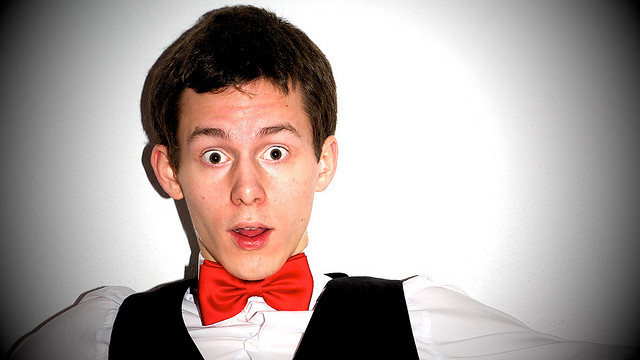

In [8]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you save the dictionary to disk.


In [10]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

2021-07-28 01:38:51.724662: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-28 01:38:52.396689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-28 01:38:52.397733: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:05.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-07-28 01:38:52.397773: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-28 01:38:52.410682: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-28 01:38:52.410775: I tensorflow/stream_executor/platfo

    8192/87910968 [..............................] - ETA: 9s

 4202496/87910968 [>.............................] - ETA: 24s

17686528/87910968 [=====>........................] - ETA: 5s 

32931840/87910968 [==========>...................] - ETA: 2s

33562624/87910968 [==========>...................] - ETA: 3s

41951232/87910968 [=============>................] - ETA: 2s

52027392/87910968 [================>.............] - ETA: 1s

58728448/87910968 [===================>..........] - ETA: 1s

67117056/87910968 [=====================>........] - ETA: 1s

79552512/87910968 [==========================>...] - ETA: 0s

87916544/87910968 [==============================] - 4s 0us/step


## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. Install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [11]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

2021-07-28 01:39:00.906130: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-28 01:39:00.907617: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2000179999 Hz
2021-07-28 01:39:01.056105: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8


2021-07-28 01:39:03.207340: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100


2021-07-28 01:39:08.876833: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


2021-07-28 01:39:10.057729: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [12]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [13]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [14]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [15]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [16]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [17]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [18]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [19]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24012, 24012, 6007, 6007)

## Create a tf.data dataset for training


Your images and captions are ready! Next, let's create a `tf.data` dataset to use for training your model.

In [20]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [21]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [23]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [24]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [25]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [26]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [27]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [28]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [29]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [30]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [31]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [32]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.9004


Epoch 1 Batch 100 Loss 1.0669


Epoch 1 Batch 200 Loss 0.8644


Epoch 1 Batch 300 Loss 0.7575


Epoch 1 Loss 0.971214
Time taken for 1 epoch 150.00 sec



Epoch 2 Batch 0 Loss 0.8469


Epoch 2 Batch 100 Loss 0.7256


Epoch 2 Batch 200 Loss 0.7352


Epoch 2 Batch 300 Loss 0.6788


Epoch 2 Loss 0.740390
Time taken for 1 epoch 52.59 sec



Epoch 3 Batch 0 Loss 0.7644


Epoch 3 Batch 100 Loss 0.6992


Epoch 3 Batch 200 Loss 0.6509


Epoch 3 Batch 300 Loss 0.5881


Epoch 3 Loss 0.665821
Time taken for 1 epoch 52.17 sec



Epoch 4 Batch 0 Loss 0.6438


Epoch 4 Batch 100 Loss 0.5957


Epoch 4 Batch 200 Loss 0.6577


Epoch 4 Batch 300 Loss 0.6111


Epoch 4 Loss 0.617179
Time taken for 1 epoch 51.69 sec



Epoch 5 Batch 0 Loss 0.5838


Epoch 5 Batch 100 Loss 0.6093


Epoch 5 Batch 200 Loss 0.6297


Epoch 5 Batch 300 Loss 0.5459


Epoch 5 Loss 0.579694
Time taken for 1 epoch 51.83 sec



Epoch 6 Batch 0 Loss 0.5737


Epoch 6 Batch 100 Loss 0.5443


Epoch 6 Batch 200 Loss 0.5537


Epoch 6 Batch 300 Loss 0.5825


Epoch 6 Loss 0.546888
Time taken for 1 epoch 51.11 sec



Epoch 7 Batch 0 Loss 0.5380


Epoch 7 Batch 100 Loss 0.5383


Epoch 7 Batch 200 Loss 0.4824


Epoch 7 Batch 300 Loss 0.4913


Epoch 7 Loss 0.517661
Time taken for 1 epoch 50.39 sec



Epoch 8 Batch 0 Loss 0.4940


Epoch 8 Batch 100 Loss 0.5097


Epoch 8 Batch 200 Loss 0.5023


Epoch 8 Batch 300 Loss 0.4532


Epoch 8 Loss 0.490831
Time taken for 1 epoch 50.93 sec



Epoch 9 Batch 0 Loss 0.4901


Epoch 9 Batch 100 Loss 0.4050


Epoch 9 Batch 200 Loss 0.4870


Epoch 9 Batch 300 Loss 0.4596


Epoch 9 Loss 0.465417
Time taken for 1 epoch 51.03 sec



Epoch 10 Batch 0 Loss 0.4536


Epoch 10 Batch 100 Loss 0.4588


Epoch 10 Batch 200 Loss 0.4160


Epoch 10 Batch 300 Loss 0.4242


Epoch 10 Loss 0.440437
Time taken for 1 epoch 51.10 sec



Epoch 11 Batch 0 Loss 0.4445


Epoch 11 Batch 100 Loss 0.4225


Epoch 11 Batch 200 Loss 0.4142


Epoch 11 Batch 300 Loss 0.4043


Epoch 11 Loss 0.418332
Time taken for 1 epoch 51.65 sec



Epoch 12 Batch 0 Loss 0.4569


Epoch 12 Batch 100 Loss 0.3960


Epoch 12 Batch 200 Loss 0.3994


Epoch 12 Batch 300 Loss 0.3606


Epoch 12 Loss 0.396864
Time taken for 1 epoch 50.60 sec



Epoch 13 Batch 0 Loss 0.3756


Epoch 13 Batch 100 Loss 0.3739


Epoch 13 Batch 200 Loss 0.3485


Epoch 13 Batch 300 Loss 0.3188


Epoch 13 Loss 0.377340
Time taken for 1 epoch 50.36 sec



Epoch 14 Batch 0 Loss 0.3615


Epoch 14 Batch 100 Loss 0.3441


Epoch 14 Batch 200 Loss 0.3526


Epoch 14 Batch 300 Loss 0.3481


Epoch 14 Loss 0.357066
Time taken for 1 epoch 50.84 sec



Epoch 15 Batch 0 Loss 0.3696


Epoch 15 Batch 100 Loss 0.3506


Epoch 15 Batch 200 Loss 0.3470


Epoch 15 Batch 300 Loss 0.3242


Epoch 15 Loss 0.339348
Time taken for 1 epoch 50.10 sec



Epoch 16 Batch 0 Loss 0.3250


Epoch 16 Batch 100 Loss 0.3281


Epoch 16 Batch 200 Loss 0.3296


Epoch 16 Batch 300 Loss 0.3140


Epoch 16 Loss 0.321988
Time taken for 1 epoch 50.75 sec



Epoch 17 Batch 0 Loss 0.2916


Epoch 17 Batch 100 Loss 0.2957


Epoch 17 Batch 200 Loss 0.3014


Epoch 17 Batch 300 Loss 0.2942


Epoch 17 Loss 0.306097
Time taken for 1 epoch 51.17 sec



Epoch 18 Batch 0 Loss 0.2839


Epoch 18 Batch 100 Loss 0.2937


Epoch 18 Batch 200 Loss 0.2837


Epoch 18 Batch 300 Loss 0.2717


Epoch 18 Loss 0.291026
Time taken for 1 epoch 49.86 sec



Epoch 19 Batch 0 Loss 0.3187


Epoch 19 Batch 100 Loss 0.3106


Epoch 19 Batch 200 Loss 0.2696


Epoch 19 Batch 300 Loss 0.2765


Epoch 19 Loss 0.278087
Time taken for 1 epoch 51.39 sec



Epoch 20 Batch 0 Loss 0.2823


Epoch 20 Batch 100 Loss 0.2791


Epoch 20 Batch 200 Loss 0.2556


Epoch 20 Batch 300 Loss 0.2598


Epoch 20 Loss 0.264479
Time taken for 1 epoch 51.29 sec



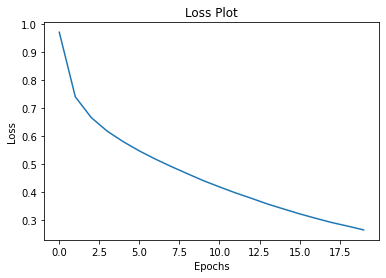

In [33]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [34]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [35]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> some people are playing a game in a field <end>
Prediction Caption: a man and little boy that is playing frisbee in a <unk> <end>


/home/kbuilder/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


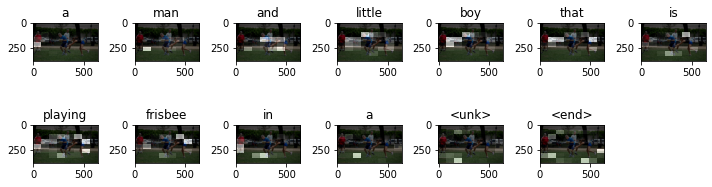

In [36]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


 8192/64400 [==>...........................] - ETA: 0s

16384/64400 [======>.......................] - ETA: 0s

32768/64400 [==============>...............] - ETA: 0s

49152/64400 [=====================>........] - ETA: 0s

65536/64400 [==============================] - 0s 5us/step


Prediction Caption: a man in <unk> as he rides a surf board <end>


/home/kbuilder/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


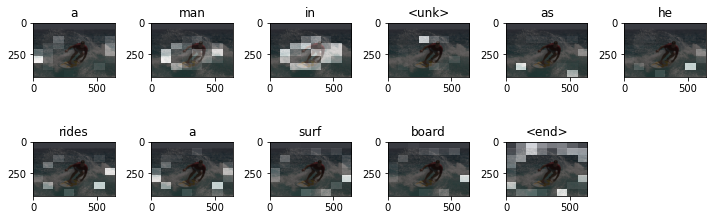

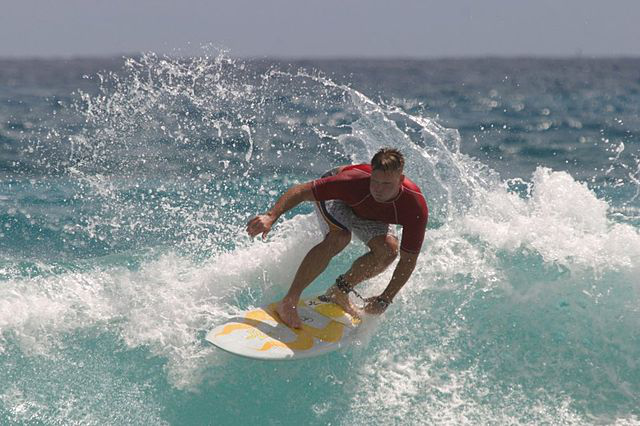

In [37]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.